# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   
         3.0    0.235487        0.113697  0.054401  0.196026  0.220231   
         4.0    0.215716        0.086401  0.035714  0.192050  0.248849   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898  
         3.0   0.247211  0.003811  0.031346  0.049192  0.009499  
         4.0   0.287262  0.004502  0.029509  0.047445  0.013083

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         1.0   6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   
         2.0   6.425365e+06  5.499584e+06  591328.783707  3.865639e+06   
         3.0   6.552225e+06  5.877726e+06  644465.987031  4.213751e+06   
         4.0   6.617553e+06  6.086991e+06  674784.517390  4.412428e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   
         3.0   1.295555e+06  7.983898e+06  4.148877e+06  1.085557e+06   
         4.0   1.348773e+06  8.458683e+06  4.205790e+06  1.124709e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.341080  
         1.0      398139.231561  
         2.0      494315.467226  
         3.0      537605.057823  
         4.0      562223.555107

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


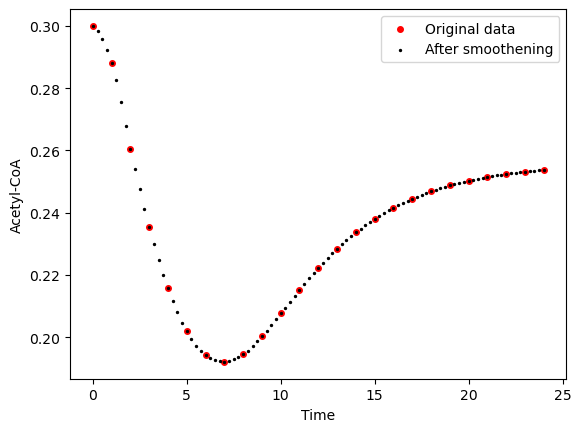

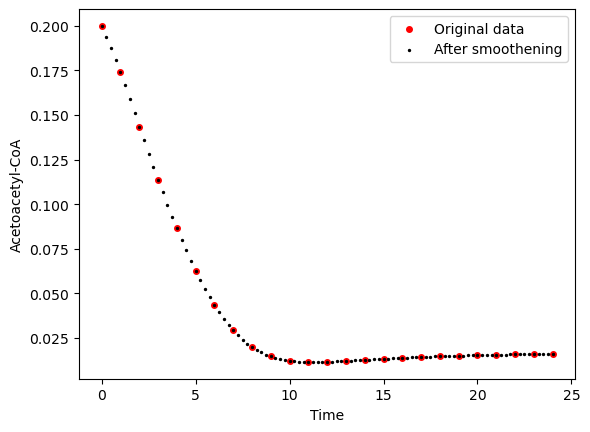

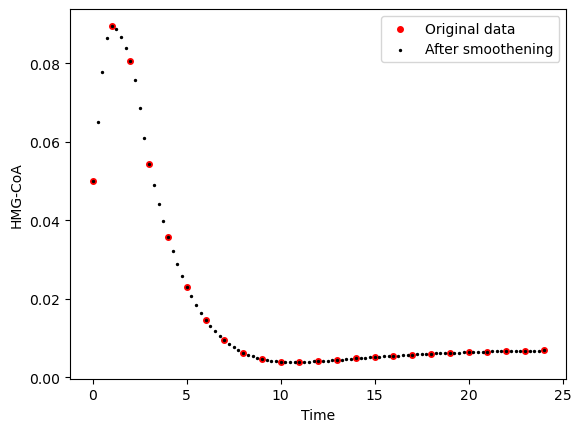

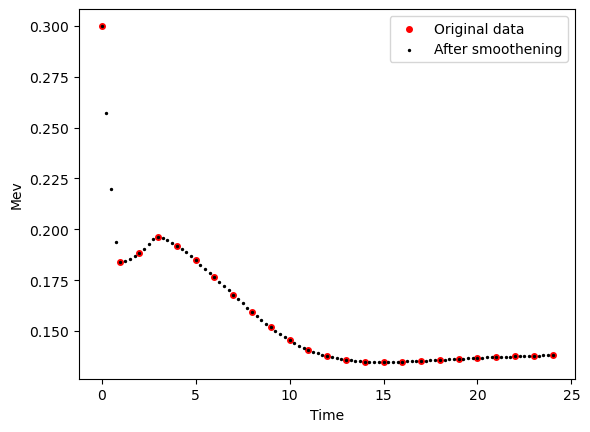

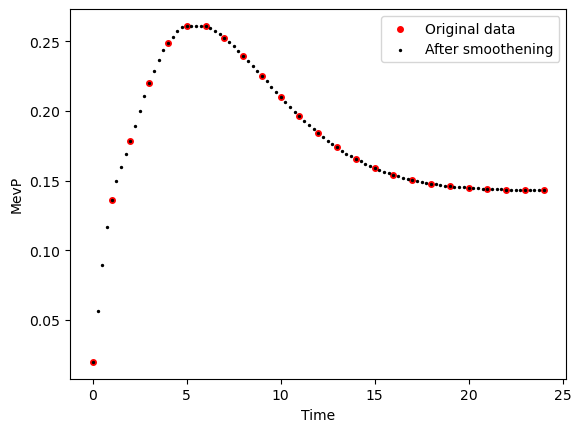

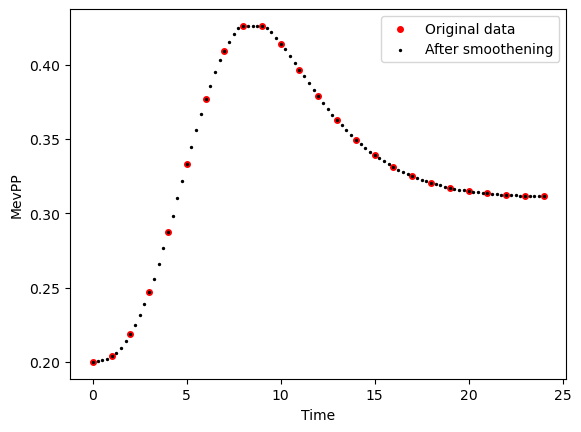

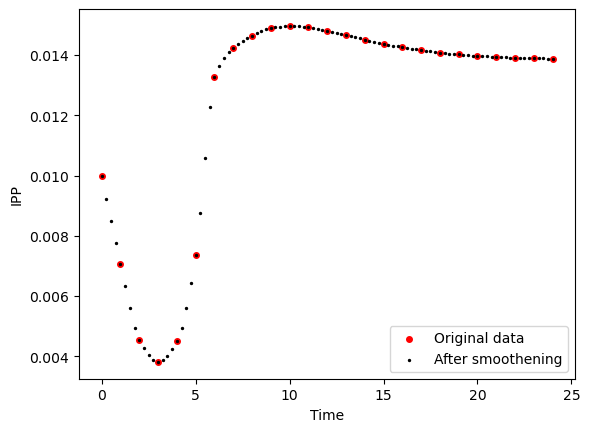

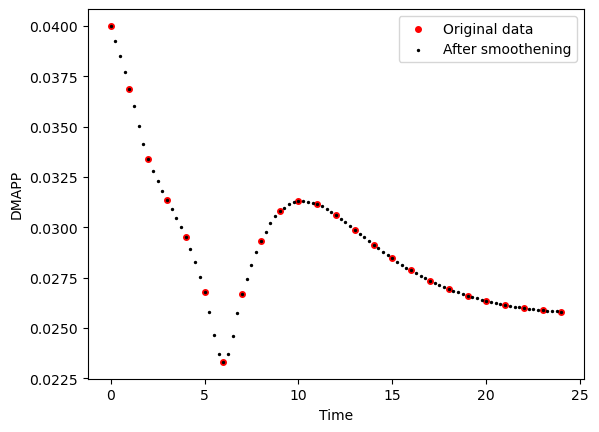

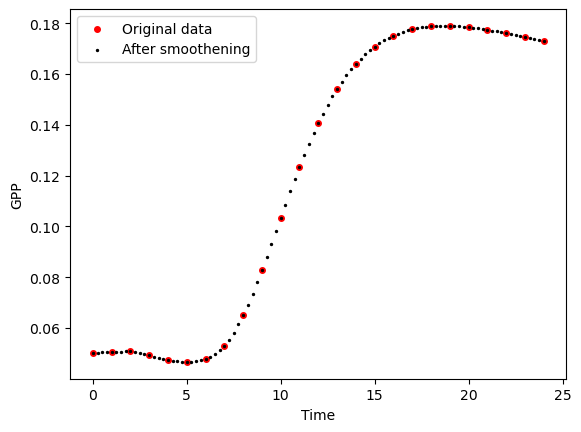

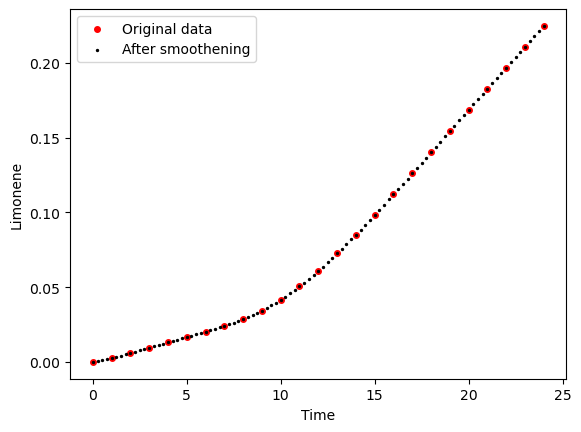

Strain Strain 2


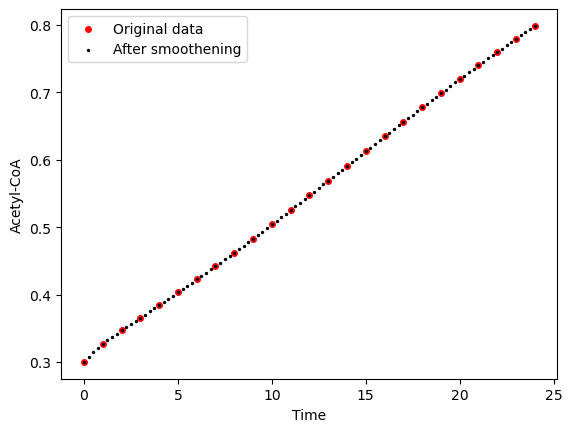

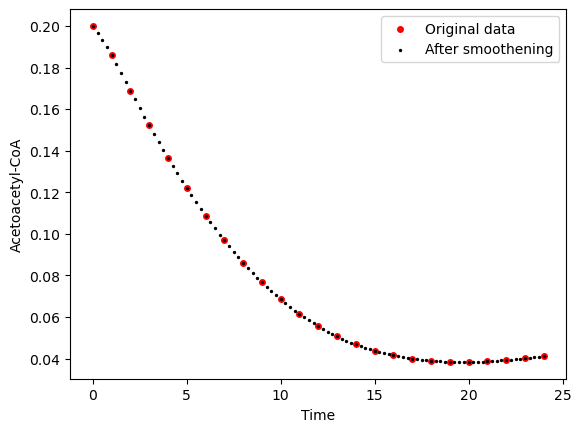

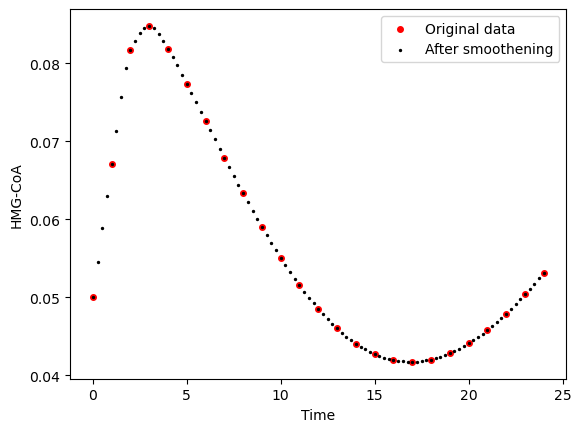

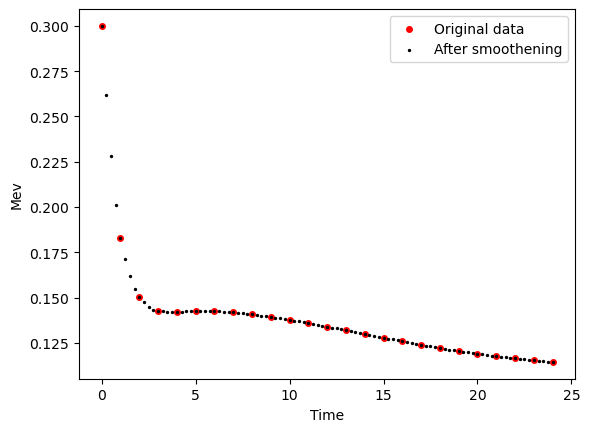

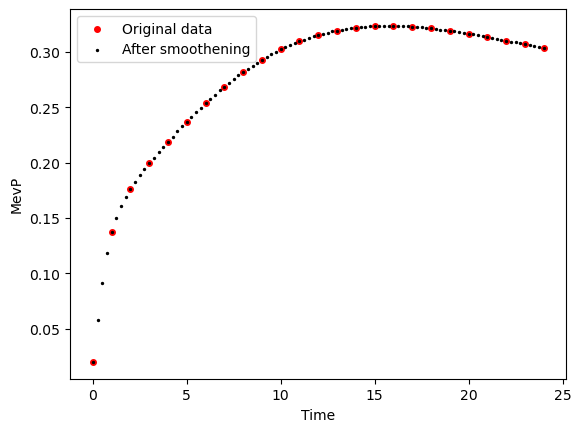

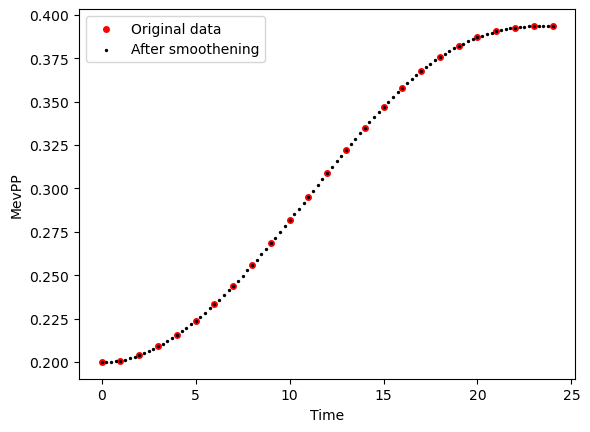

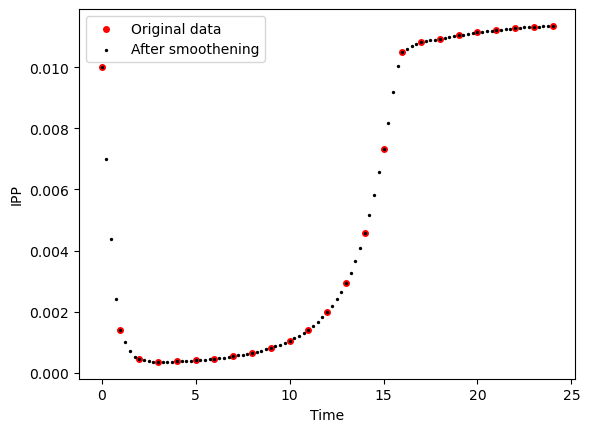

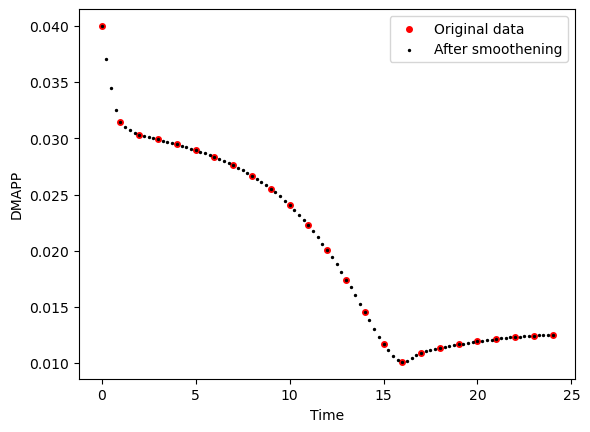

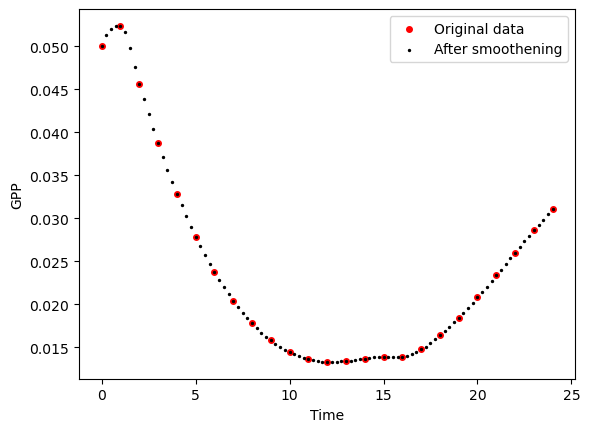

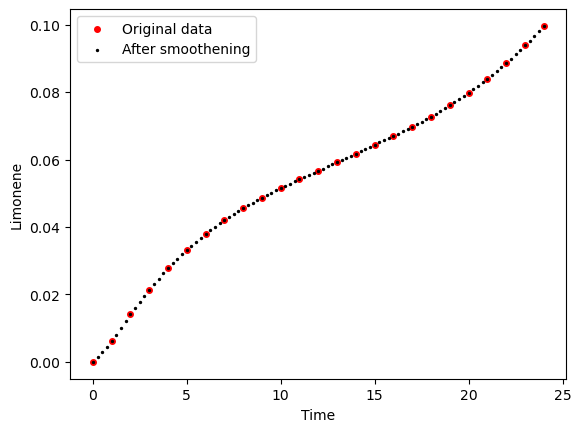

Strain Strain 3


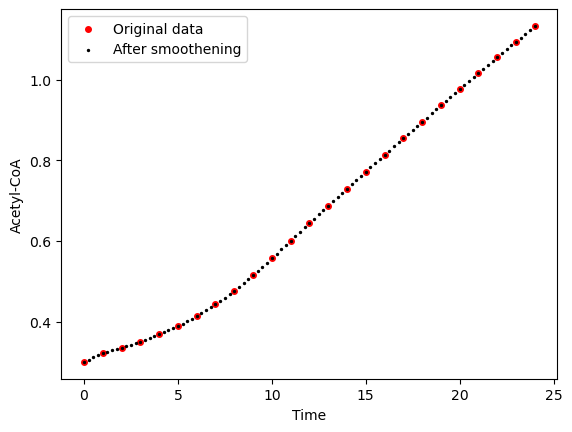

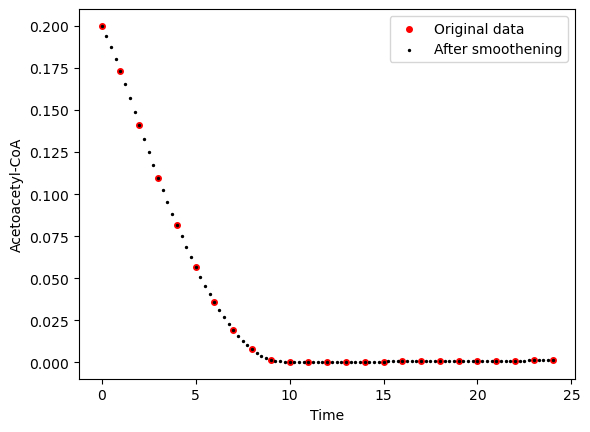

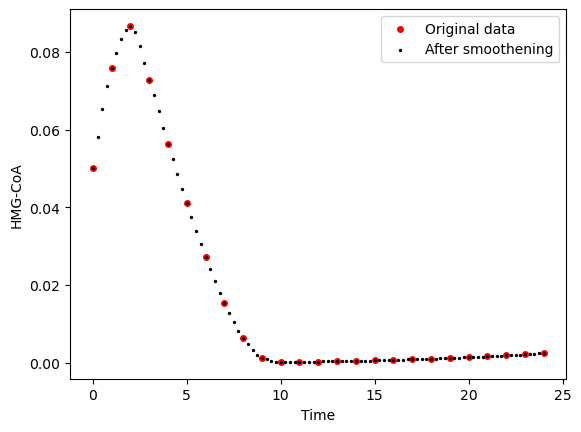

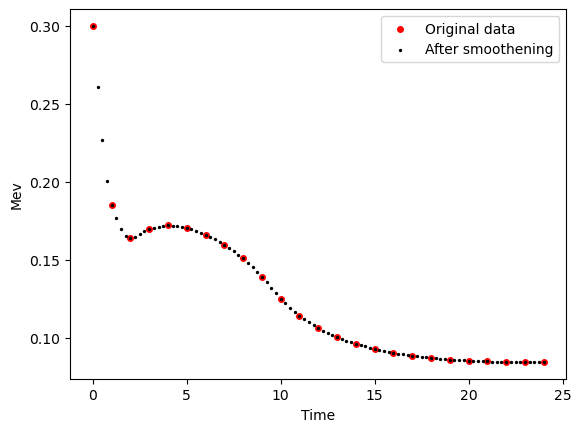

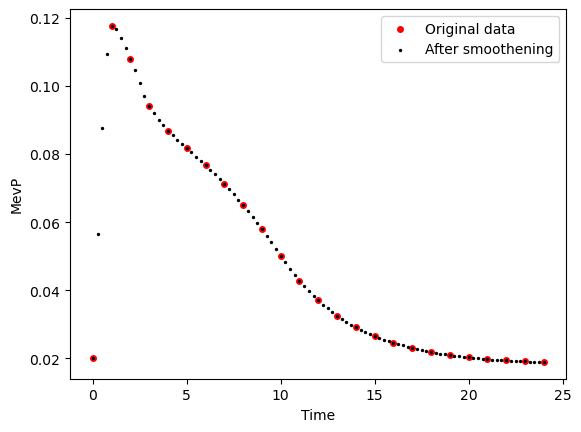

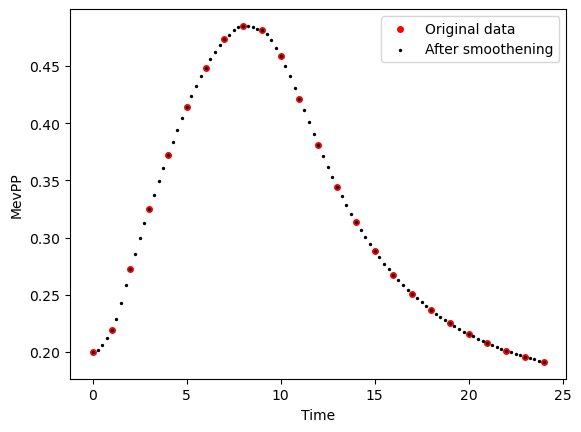

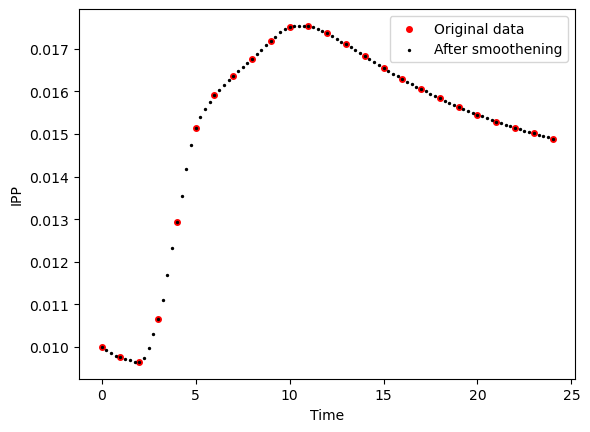

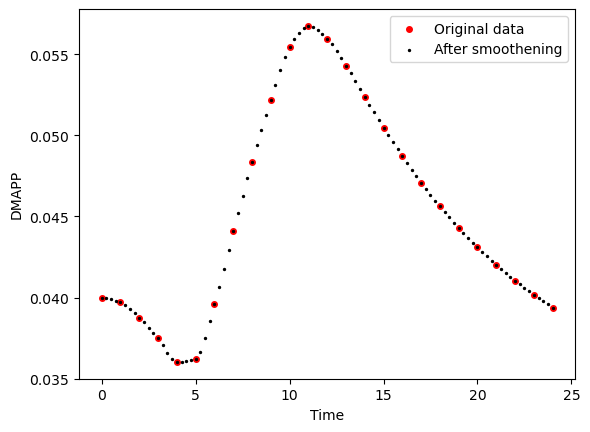

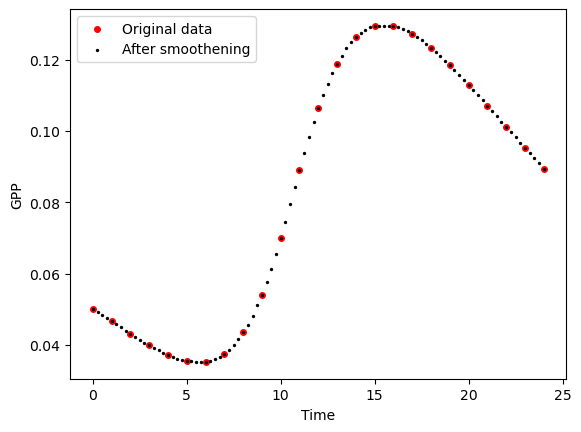

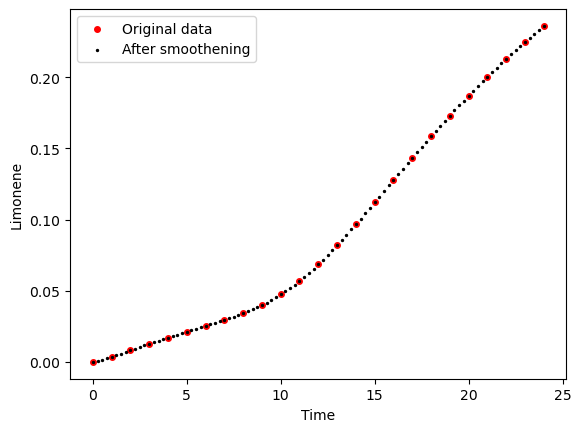

Strain WT


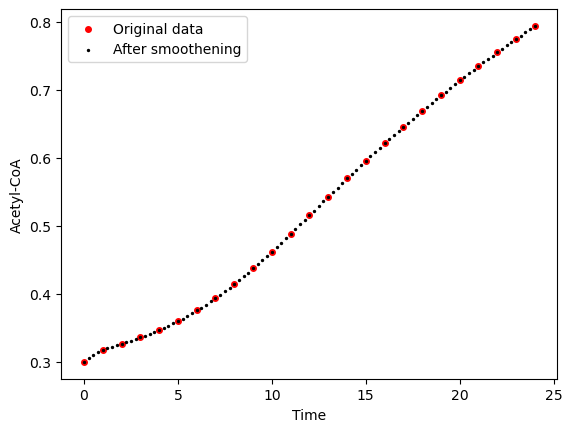

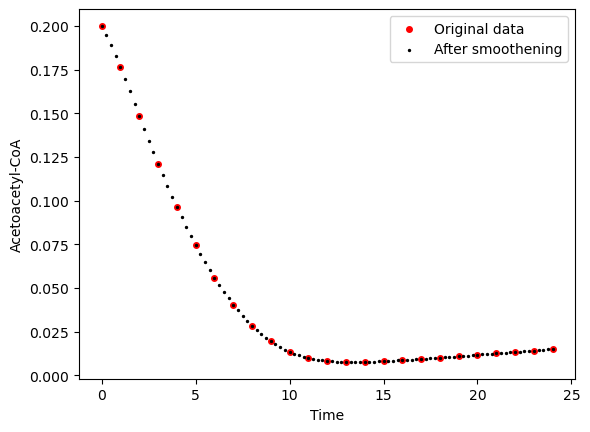

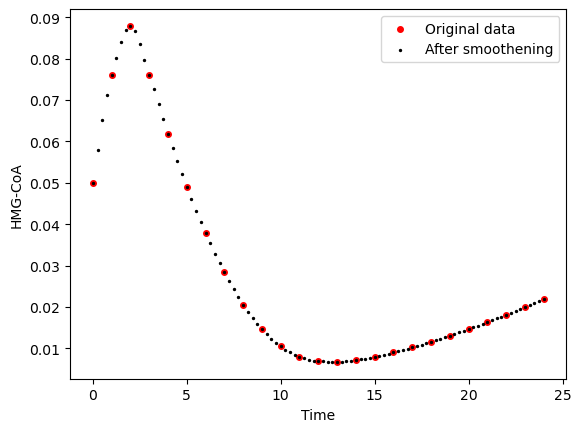

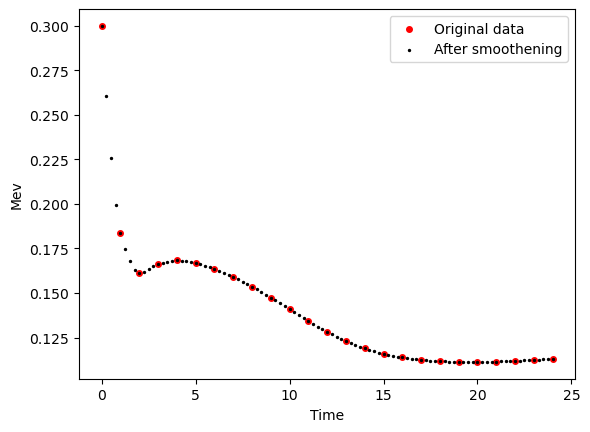

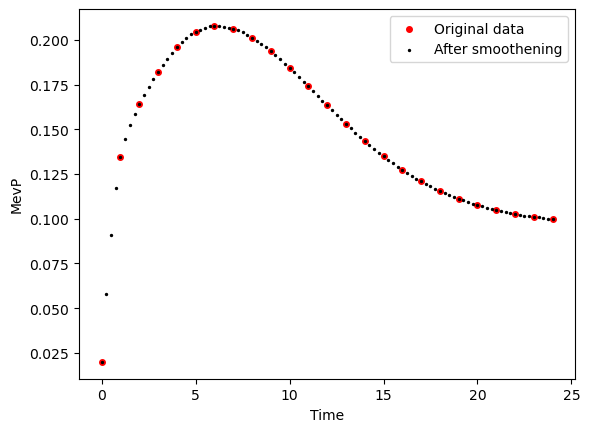

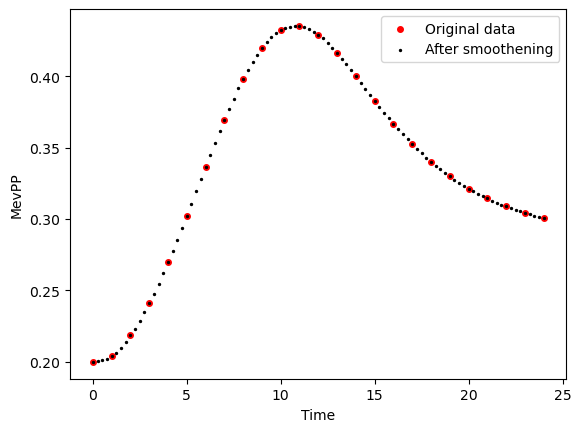

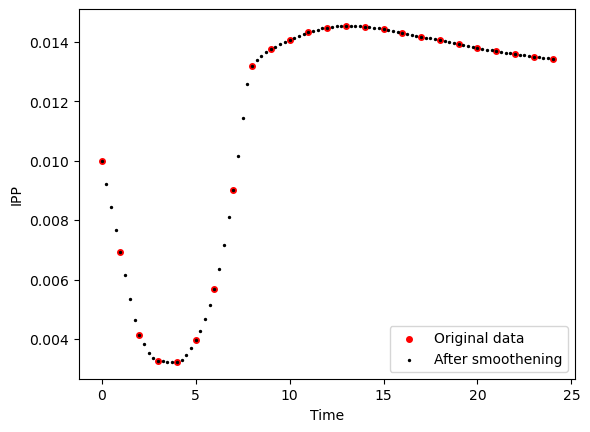

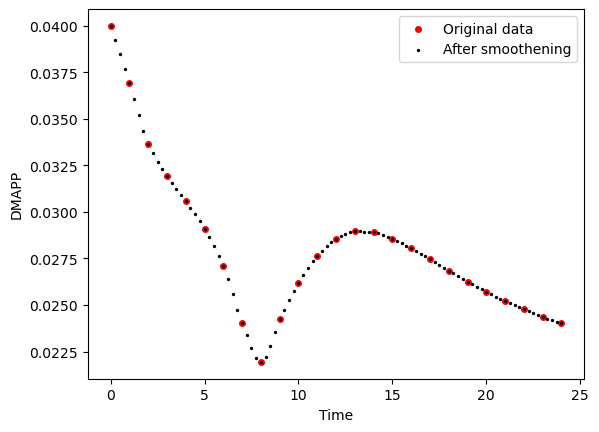

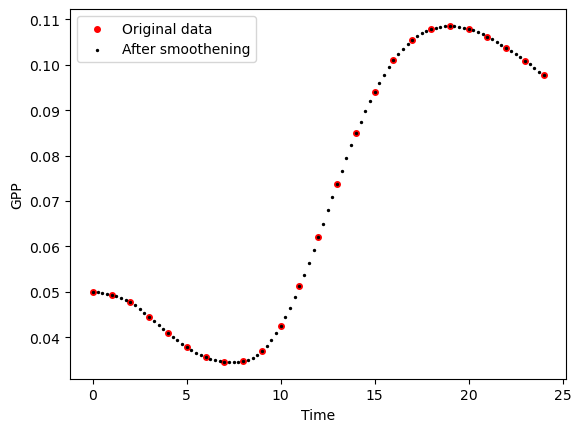

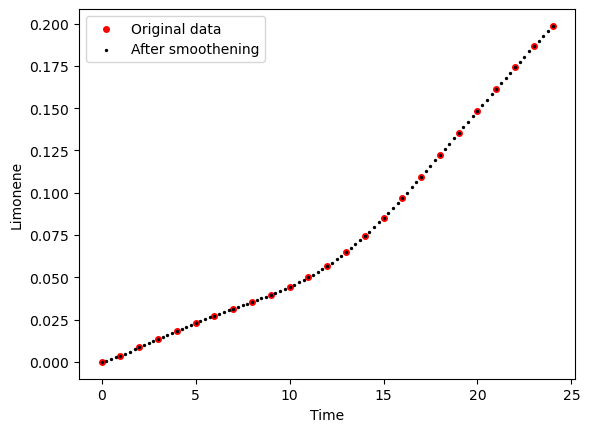

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


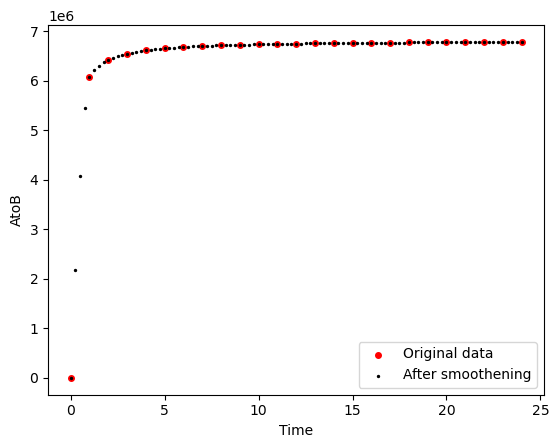

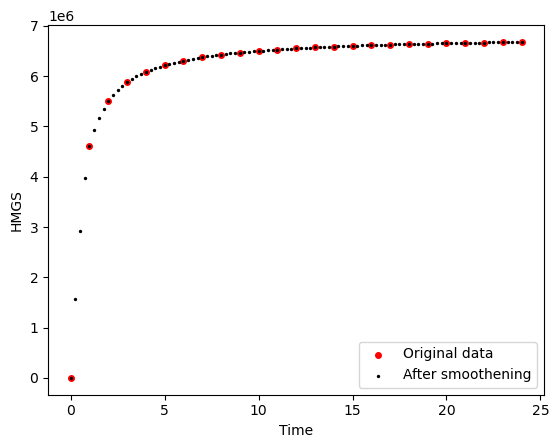

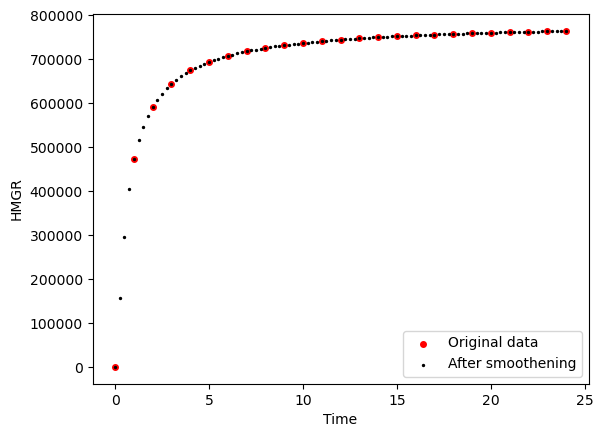

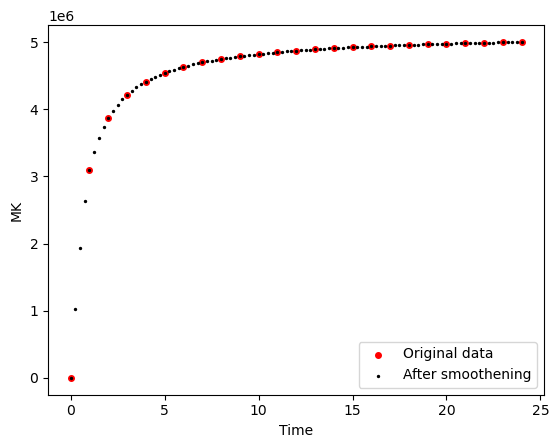

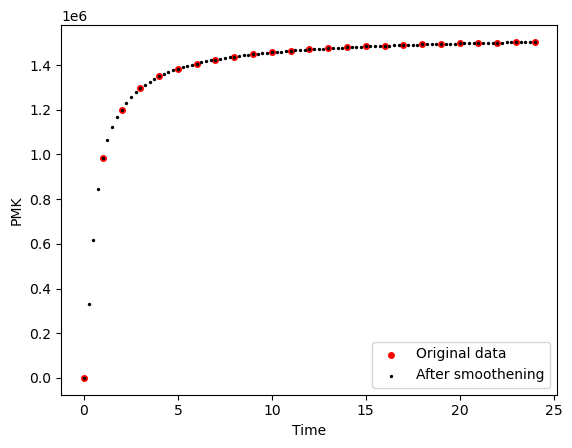

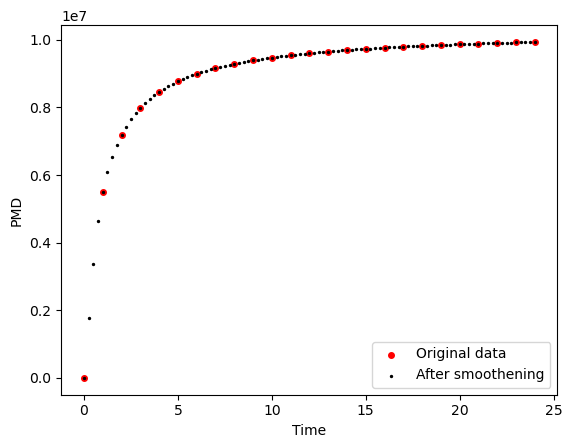

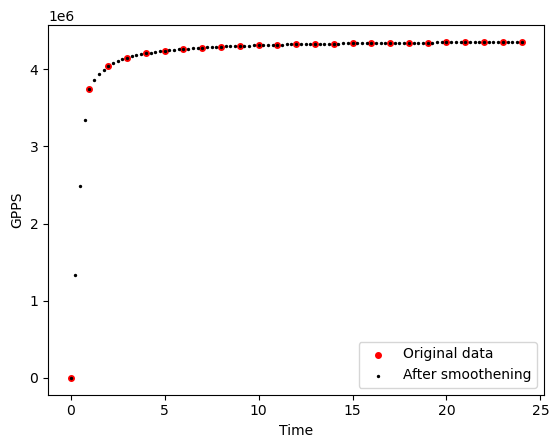

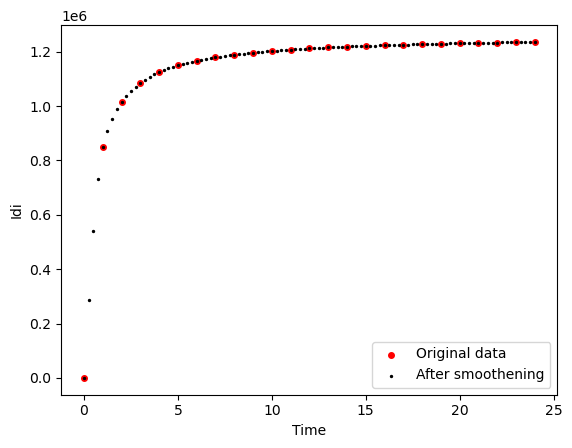

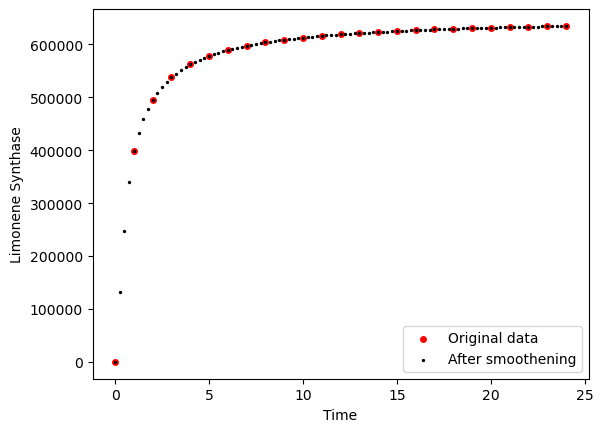

Strain Strain 2


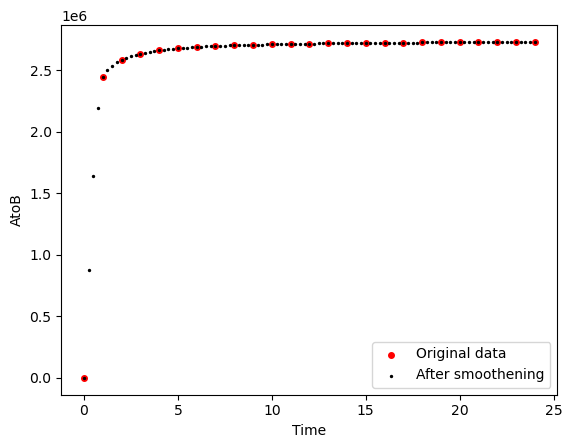

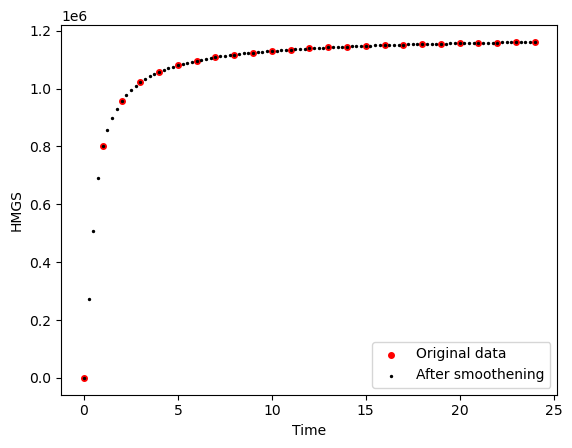

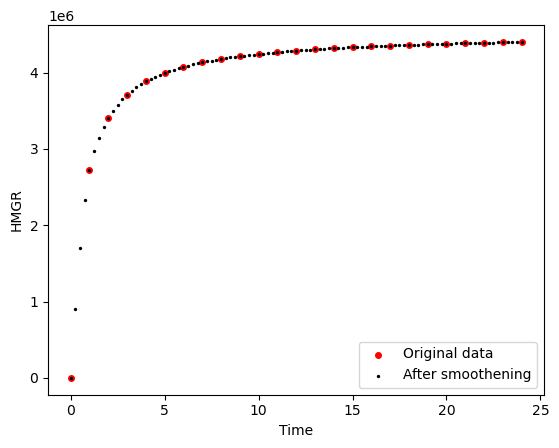

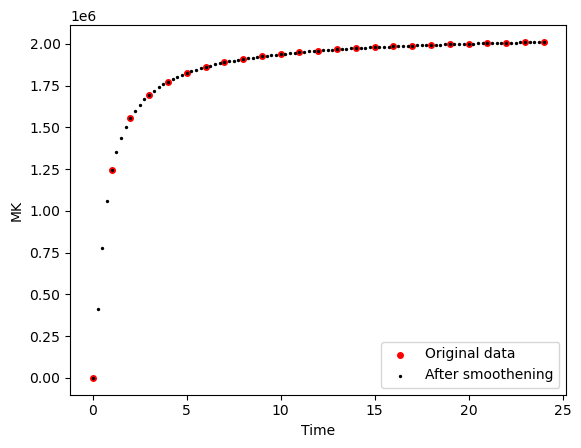

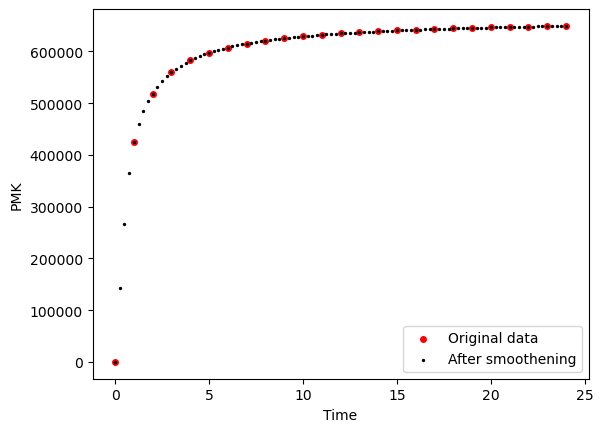

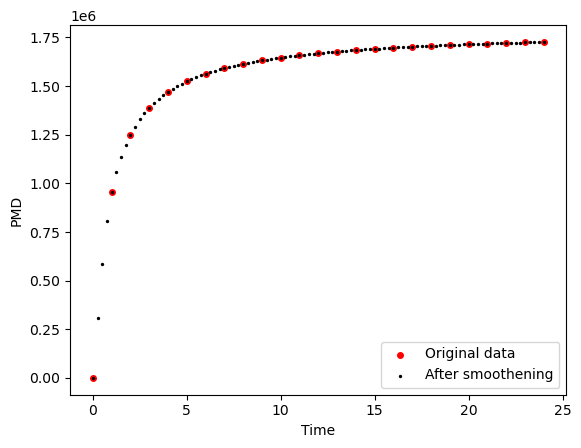

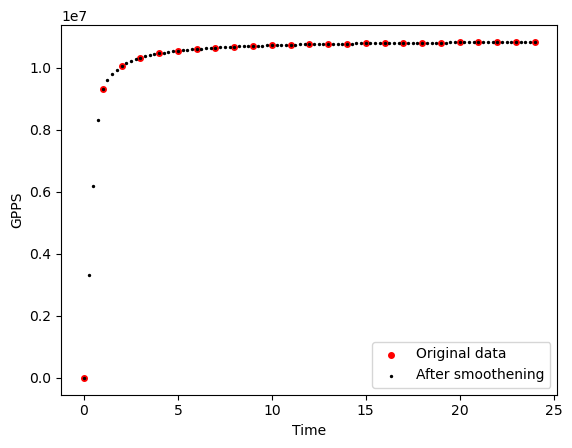

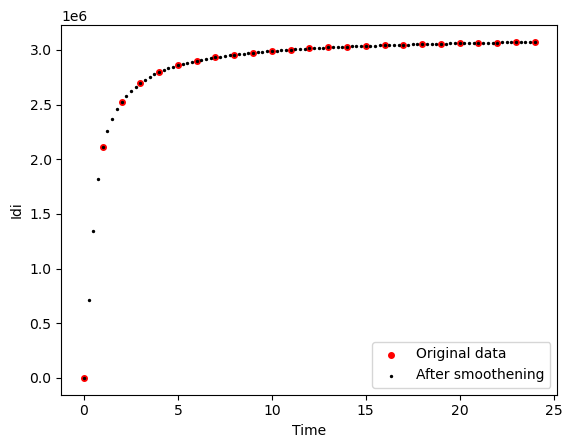

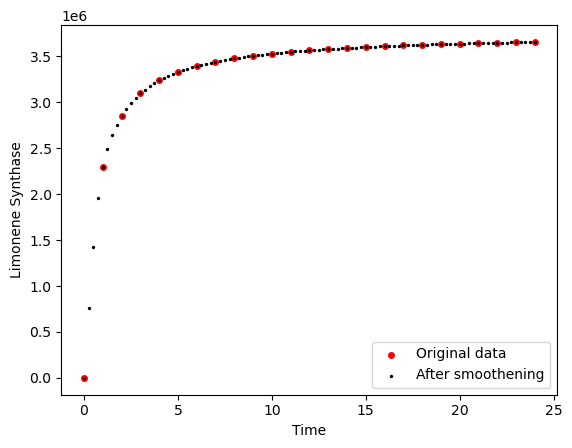

Strain Strain 3


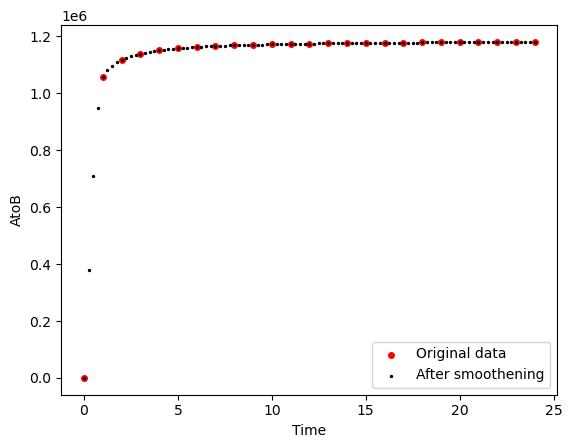

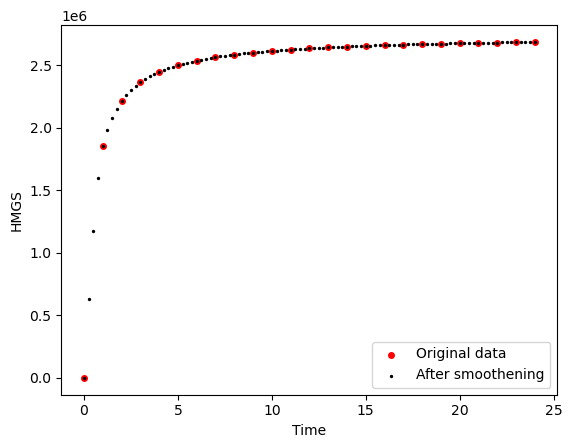

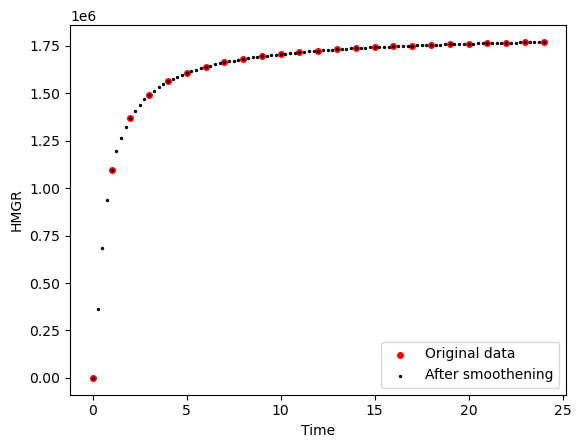

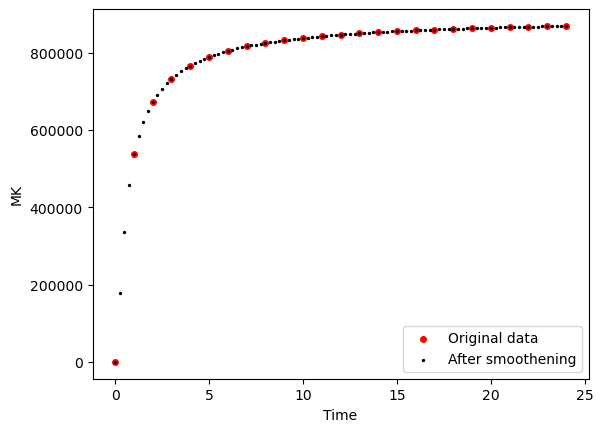

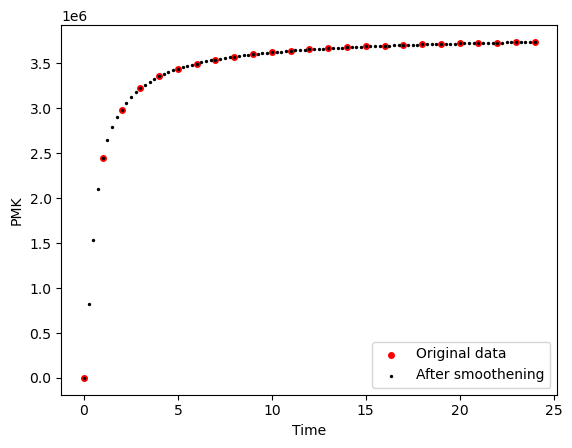

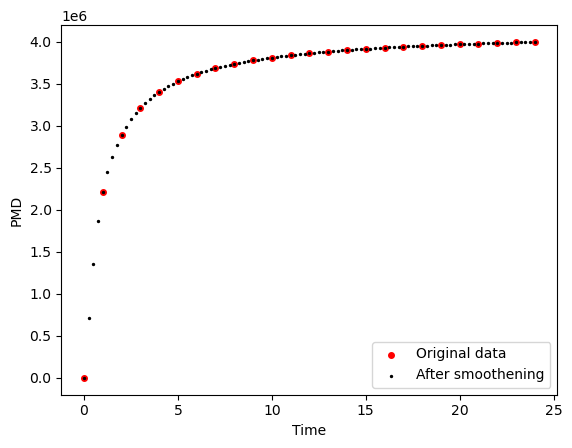

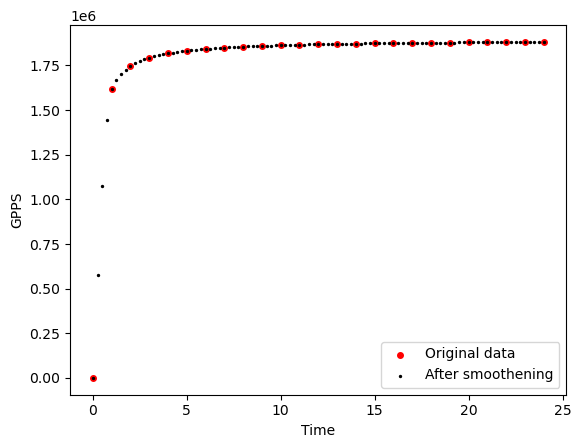

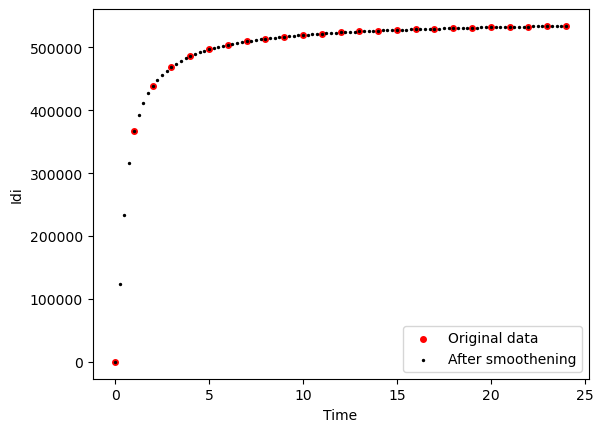

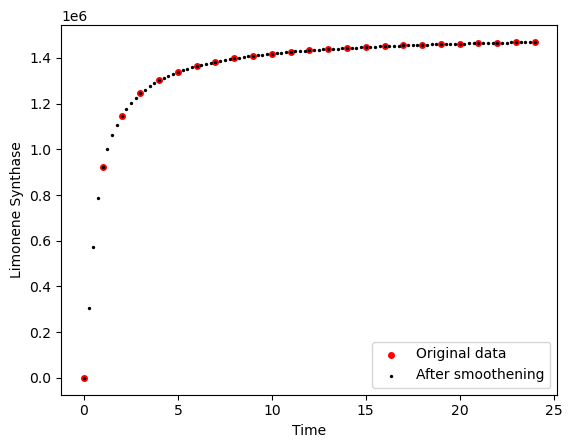

Strain WT


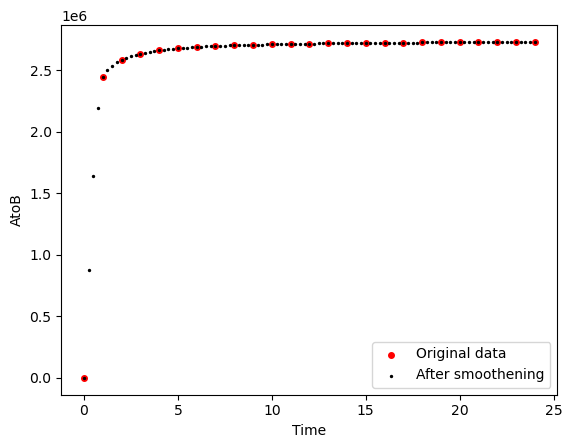

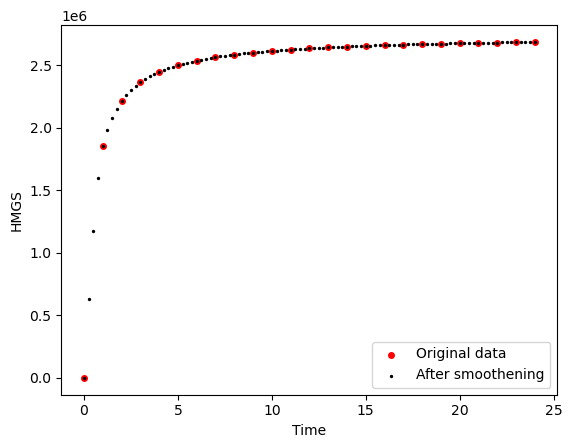

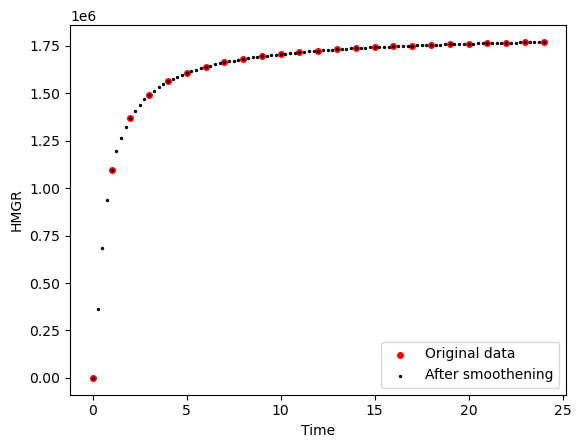

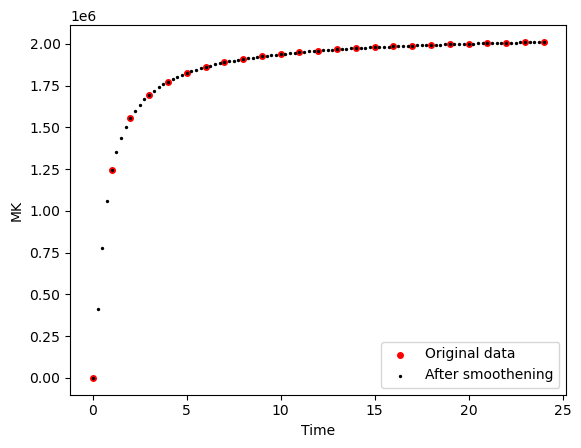

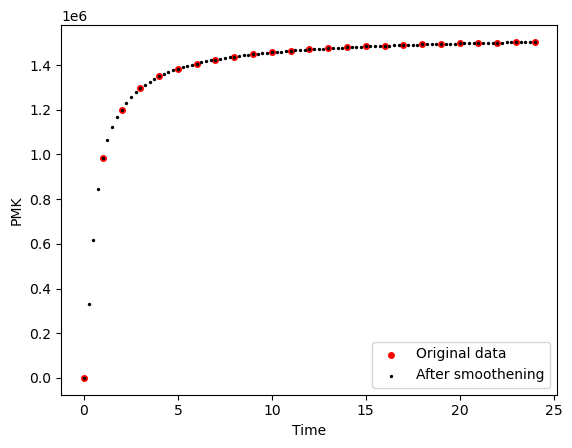

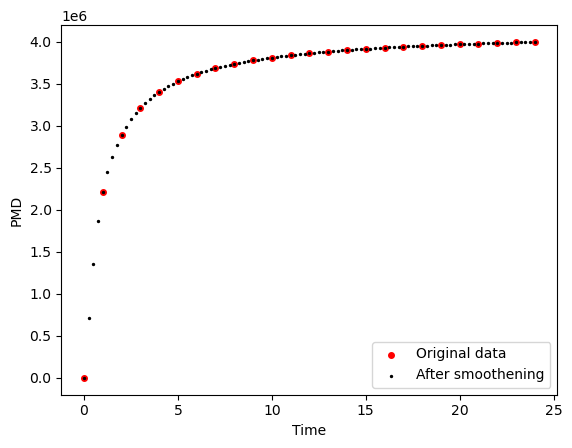

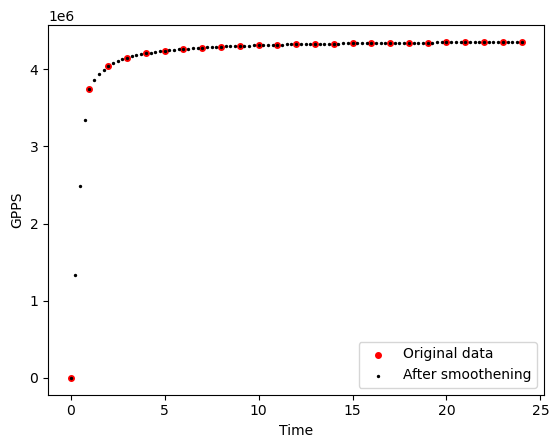

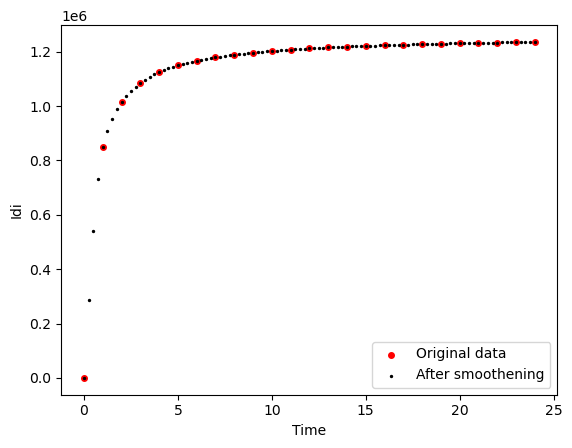

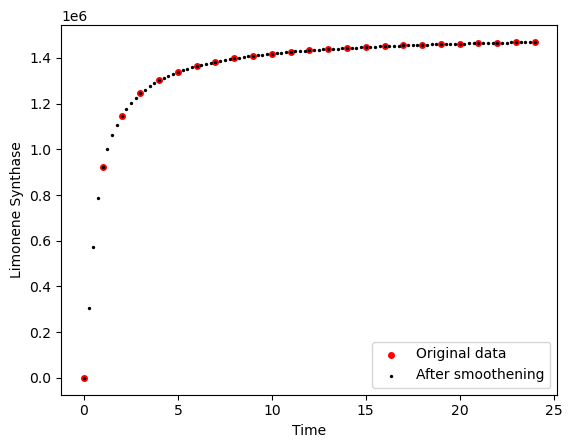

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.298383        0.193946  0.065149  0.257084  0.056859   
         0.50    0.295677        0.187596  0.077750  0.219963  0.089623   
         0.75    0.292180        0.180967  0.086366  0.193859  0.116665   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112529  0.100703   
         23.50   0.784585        0.014581  0.020885  0.112673  0.100406   
         23.75   0.789291        0.014788  0.021362  0.112824  0.100136   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200300  0.009225  0.039259  0.050238  0.000531  ...   
         0.50   0.201111  0.008475  0.038493  0.050445  0.001124  ...   
         0.75   0.202294  0.007751  0.037703  0.050600  0.001772  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303342  0.013479  0.024269  0.100097  0.189617  ...   
         23.50  0.302439  0.013460  0.024180  0.099307  0.192637  ...   
         23.75  0.301595  0.013442  0.024094  0.098498  0.195634  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.006814       -0.023908  0.073868 -0.213743  0.163982   
         0.25    -0.008651       -0.024790  0.056084 -0.162081  0.140030   
         0.50    -0.011368       -0.025838  0.039185 -0.114301  0.116330   
         0.75    -0.014965       -0.027051  0.023170 -0.070403  0.092879   
         1.00    -0.019338       -0.028498  0.005273 -0.020786  0.066037   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001866  0.000550 -0.001346   
         23.25    0.019092        0.000828  0.001882  0.000568 -0.001235   
         23.50    0.018915        0.000828  0.001899  0.000588 -0.001124   
         23.75    0.018738        0.000829  0.001916  0.000611 -0.001019   
         24.00    0.018561        0.000829  0.001933  0.000635 -0.000918   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002041 -0.003236 -0.002991  0.001146  0.002070  
         0.25   0.002194 -0.003041 -0.003005  0.000899  0.002246  
         0.50   0.003219 -0.002910 -0.003078  0.000670  0.002453  
         0.75   0.005114 -0.002844 -0.003212  0.000460  0.002690  
         1.00   0.007662 -0.002883 -0.003442  0.000227  0.002961  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003945 -0.000080 -0.000373 -0.003059  0.012217  
         23.25 -0.003713 -0.000078 -0.000361 -0.003121  0.012124  
         23.50 -0.003479 -0.000075 -0.000349 -0.003193  0.012032  
         23.75 -0.003251 -0.000072 -0.000337 -0.003272  0.011943  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

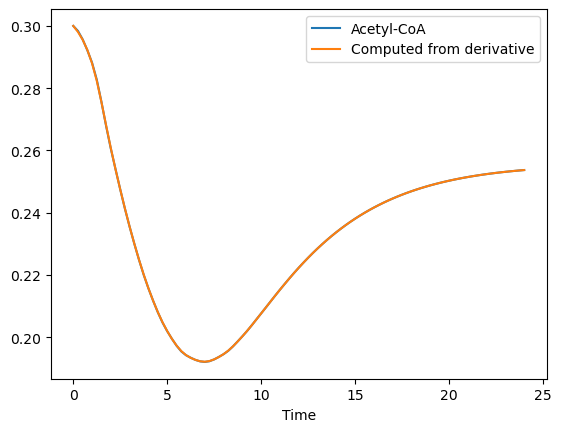

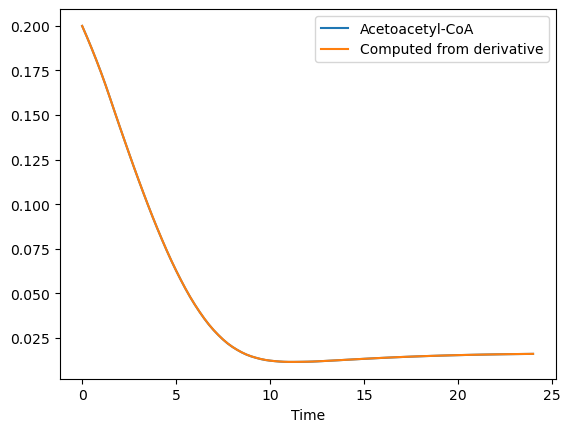

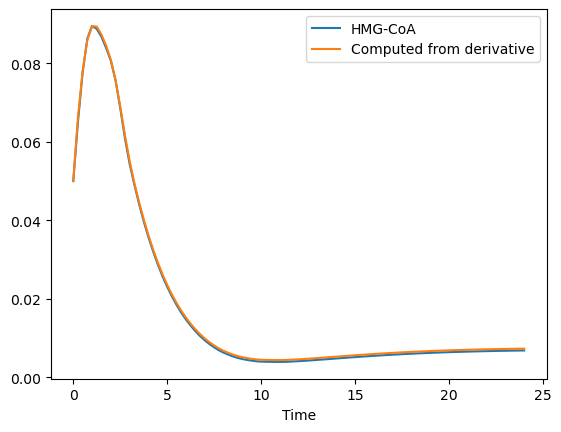

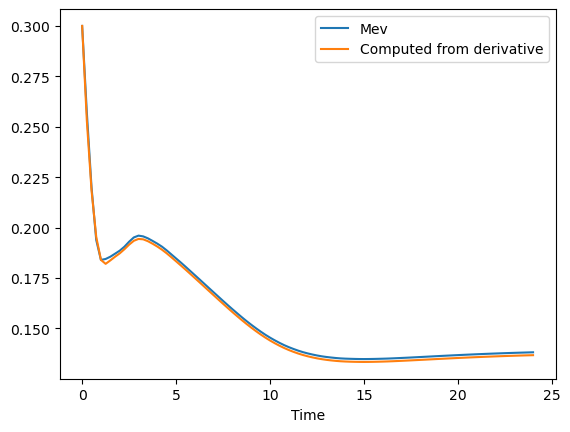

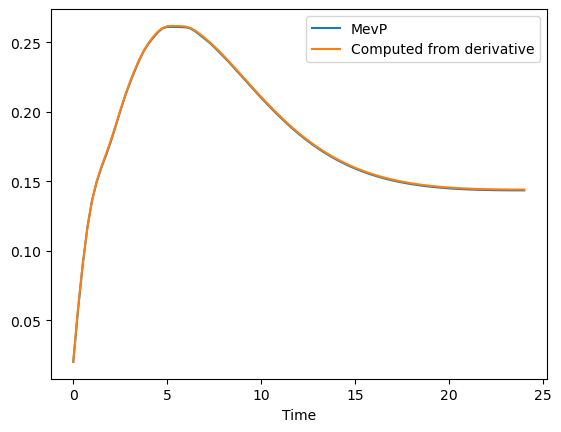

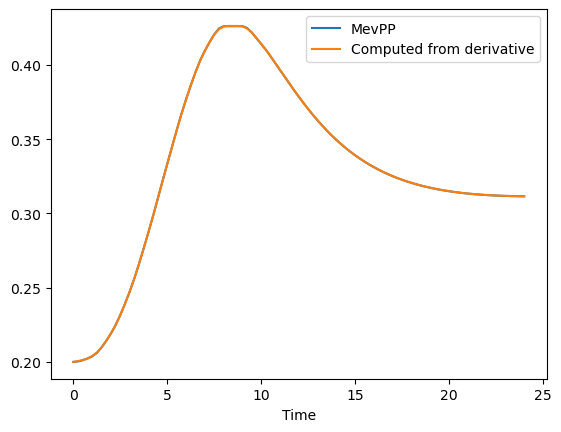

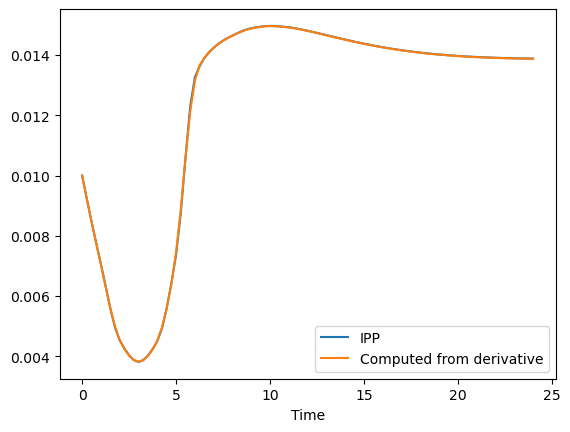

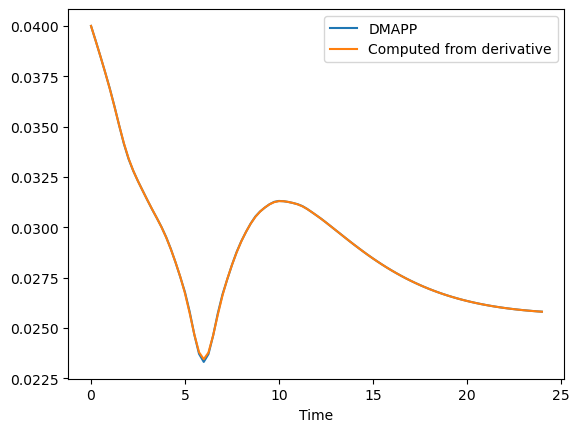

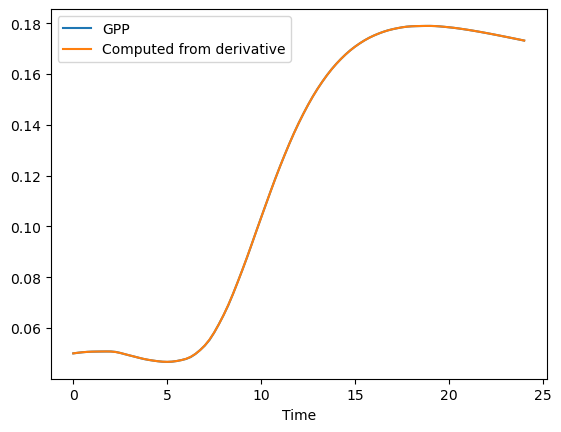

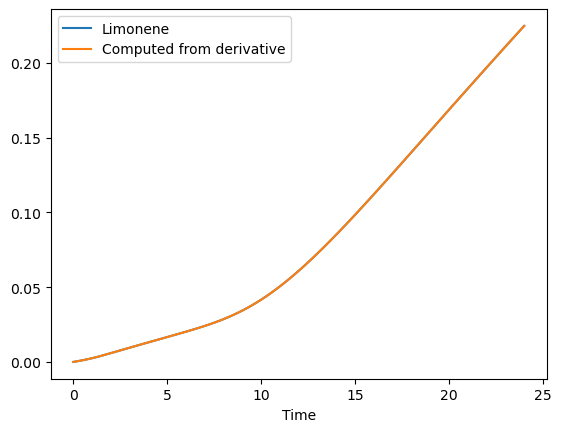

'Time profile from derivative vs. actual profile for Strain 2'

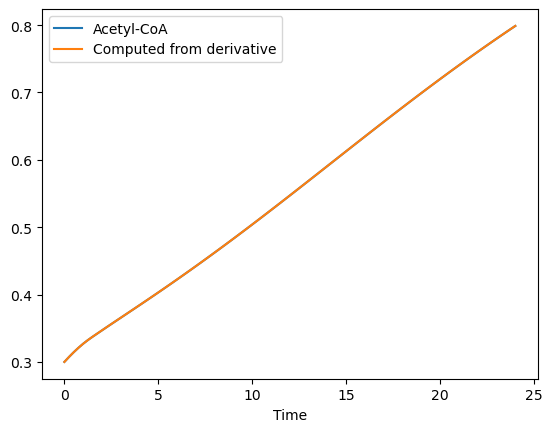

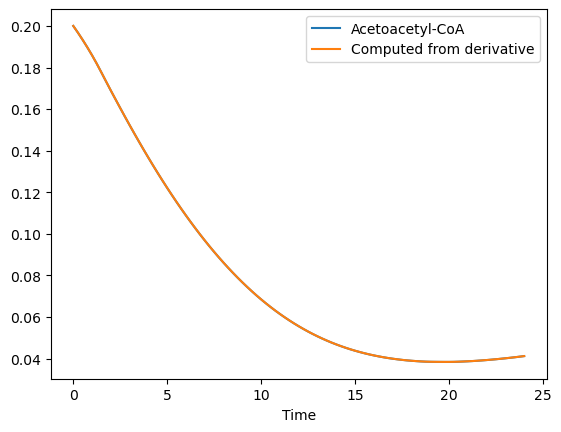

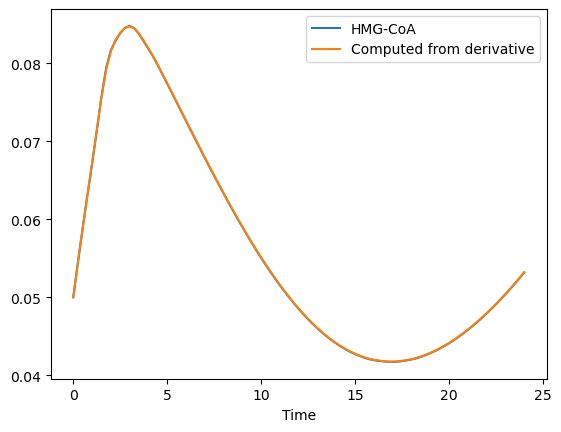

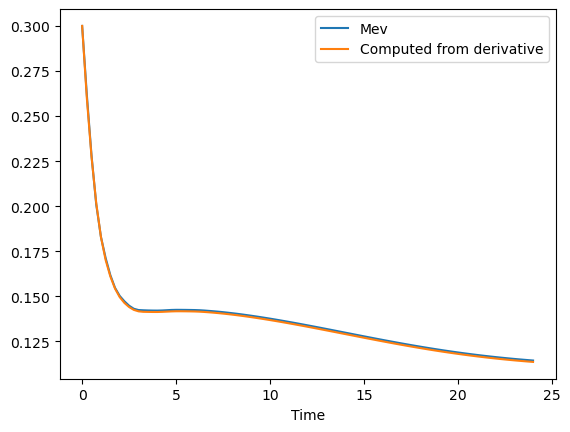

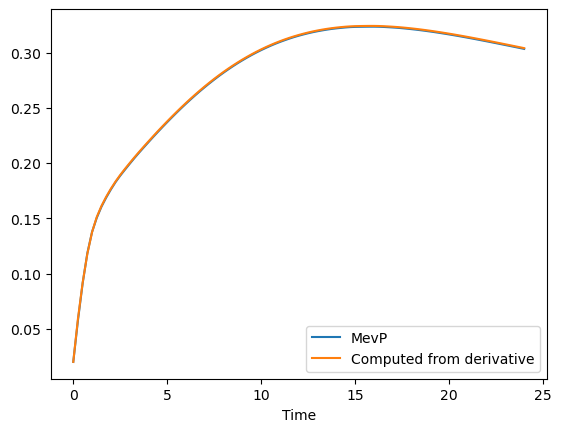

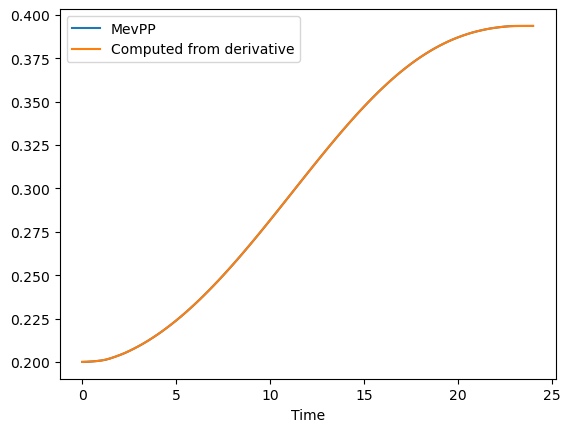

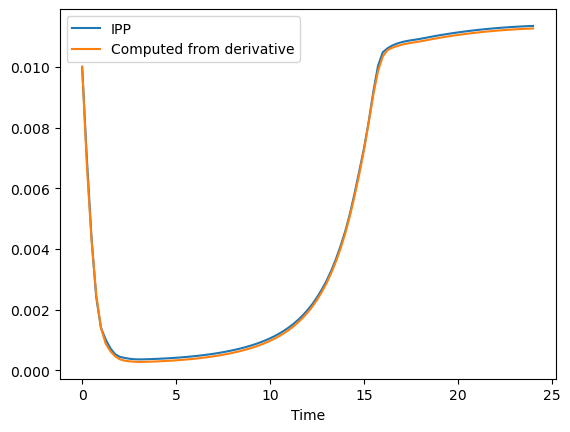

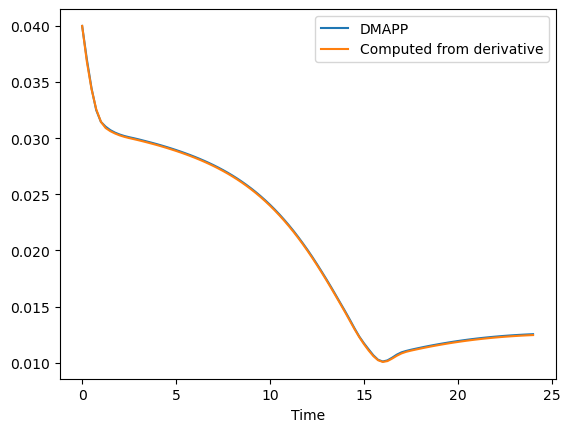

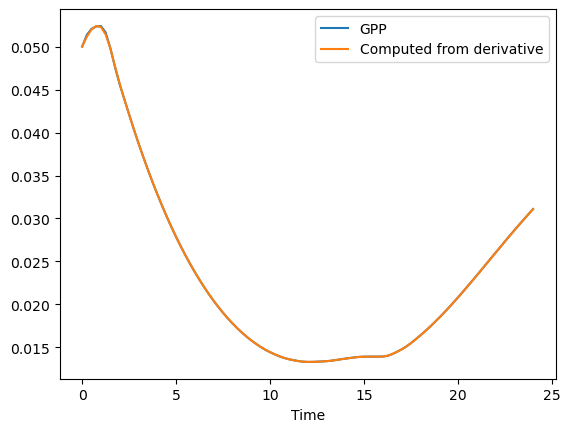

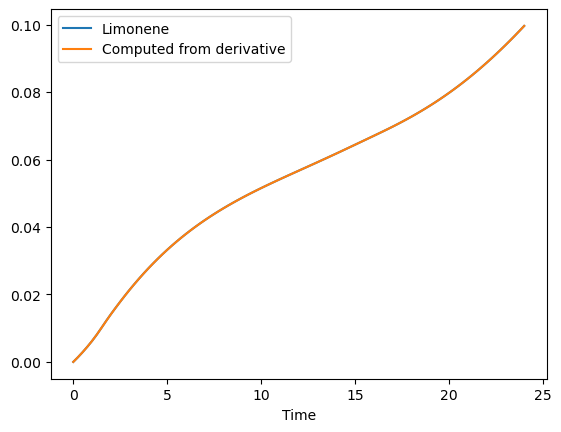

'Time profile from derivative vs. actual profile for Strain 3'

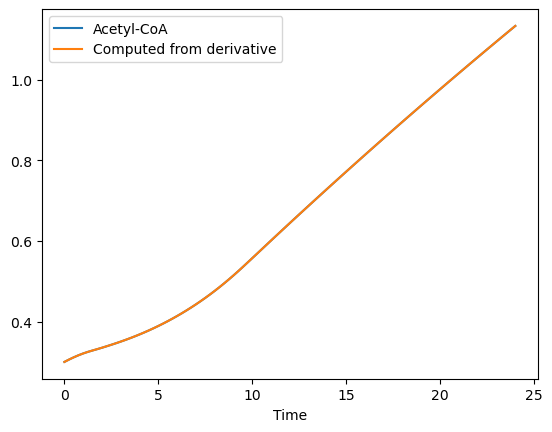

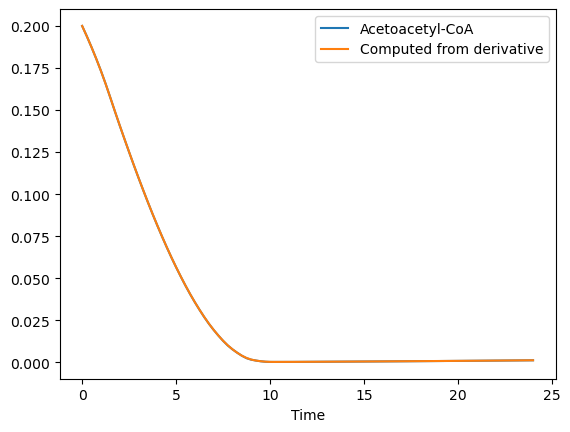

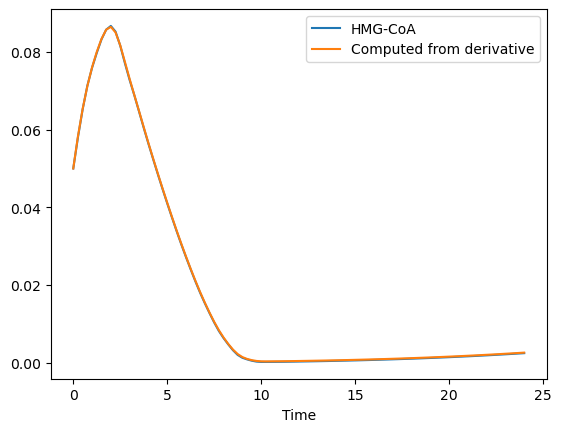

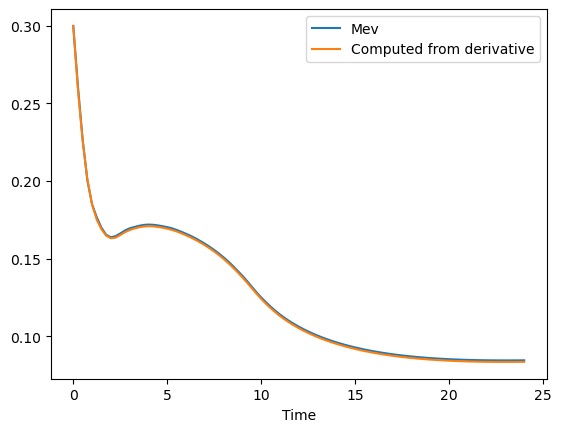

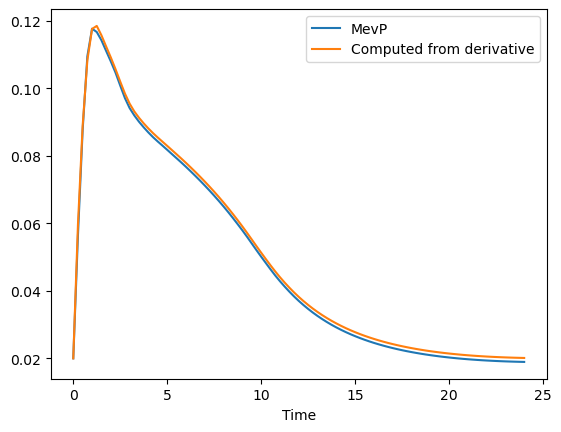

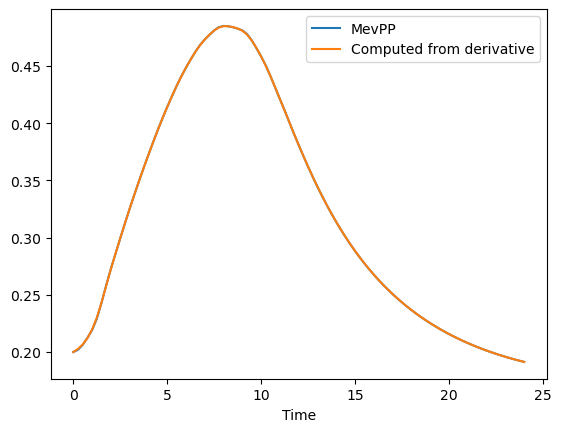

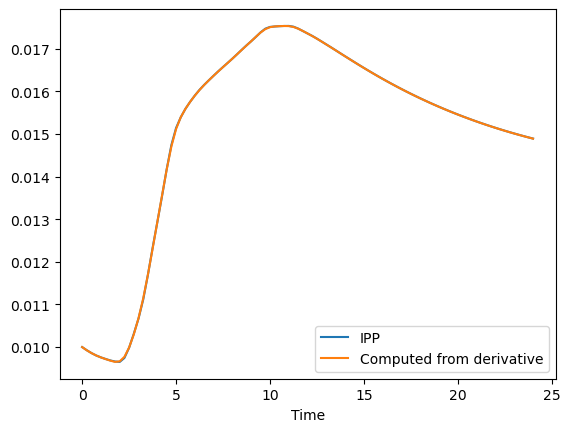

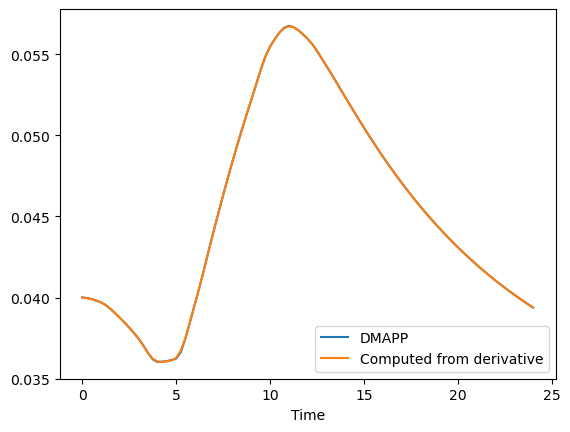

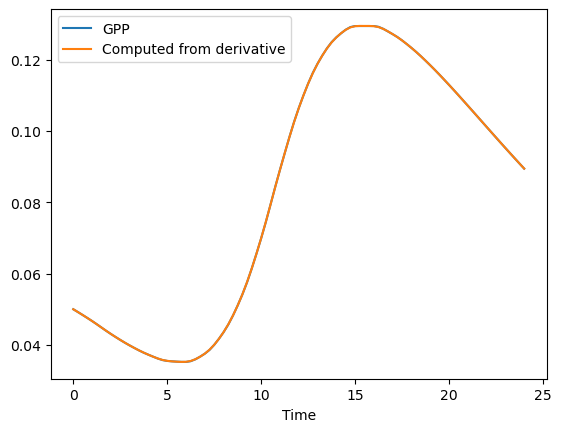

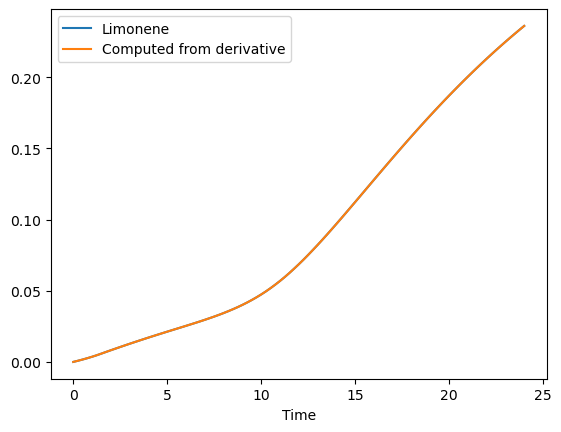

'Time profile from derivative vs. actual profile for WT'

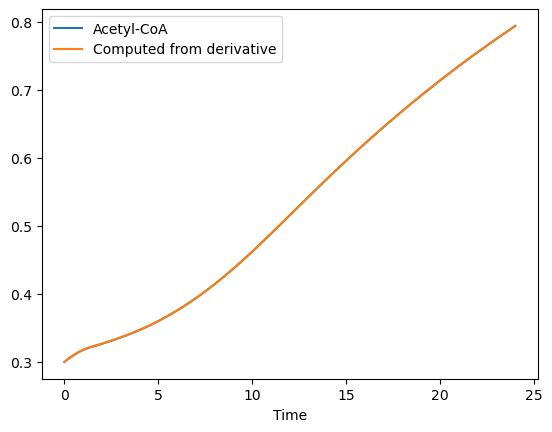

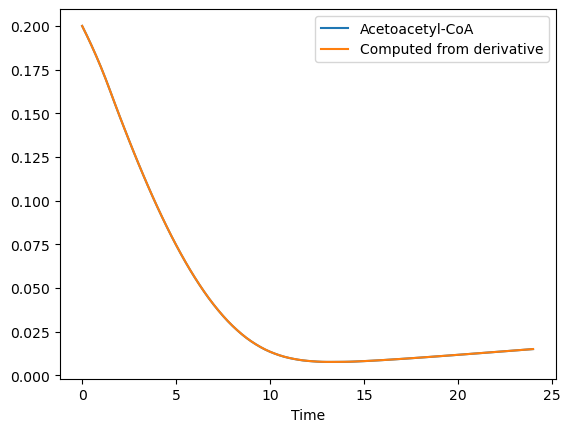

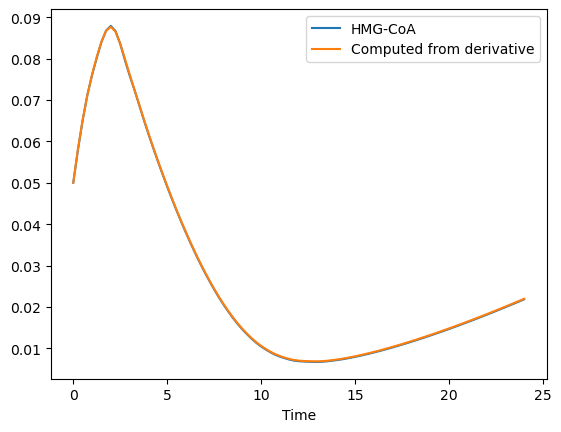

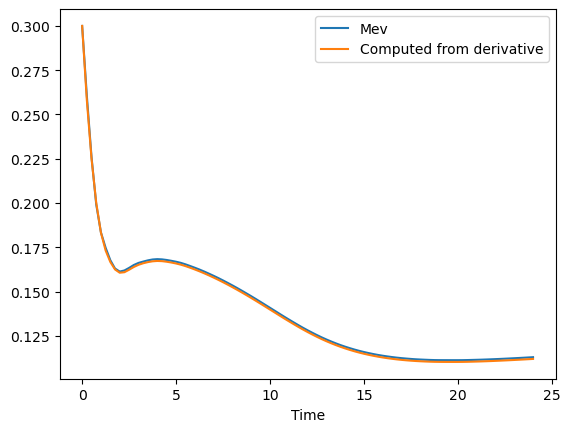

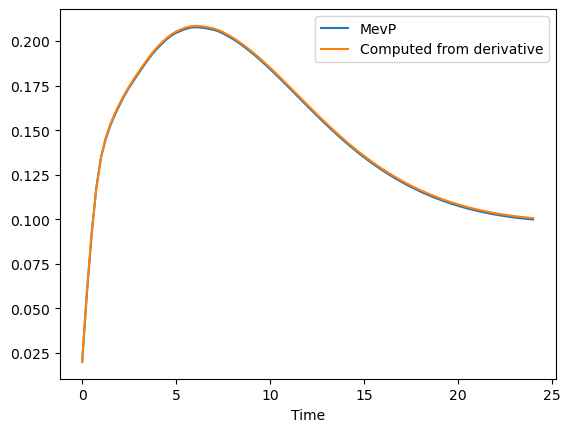

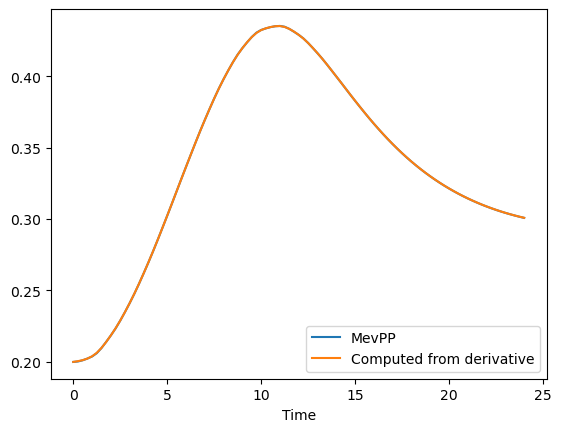

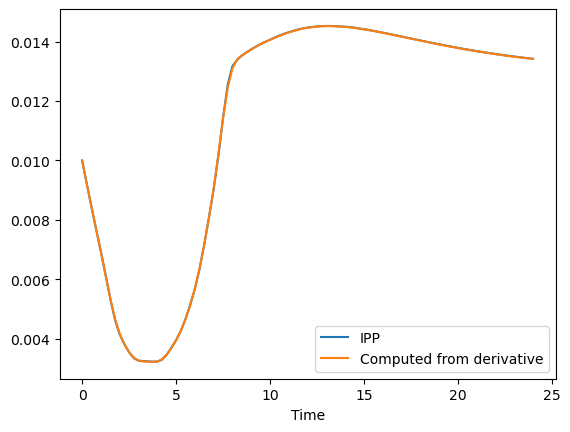

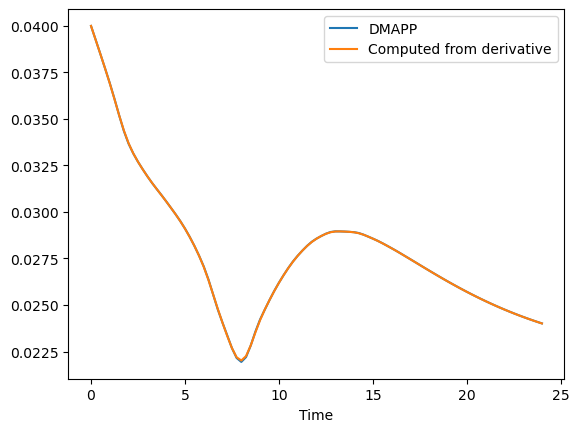

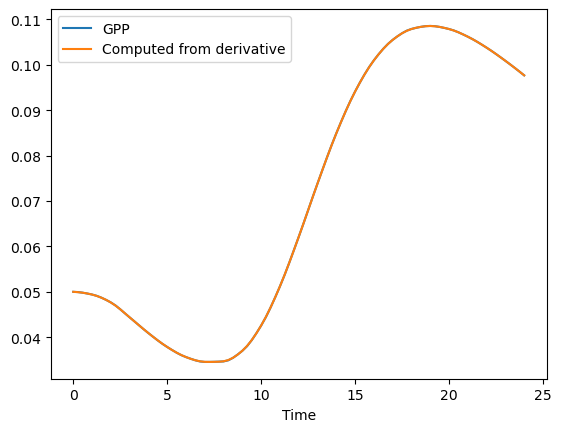

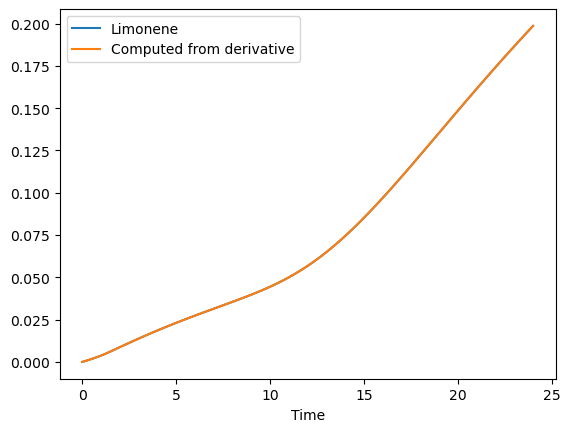

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   2.173781e+06  1.560234e+06  1.570374e+05  1.025868e+06   
         0.50   4.069572e+06  2.927241e+06  2.951031e+05  1.927997e+06   
         0.75   5.448752e+06  3.983103e+06  4.041436e+05  2.640608e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768629e+06  2.010384e+06   
         23.50  2.729713e+06  2.686646e+06  1.769147e+06  2.010975e+06   
         23.75  2.729864e+06  2.687210e+06  1.769654e+06  2.011553e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   3.297925e+05  1.785807e+06  1.328120e+06  2.871277e+05   
         0.50   6.192067e+05  3.363592e+06  2.486684e+06  5.387196e+05   
         0.75   8.452060e+05  4.637042e+06  3.337821e+06  7.332309e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992255e+06  4.354150e+06  1.235379e+06   
         23.50  1.502404e+06  3.993787e+06  4.354490e+06  1.235648e+06   
         23.75  1.502773e+06  3.995286e+06  4.354823e+06  1.235911e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.321864e+05   0.298383        0.193946  0.065149   
         0.50       2.483535e+05   0.295677        0.187596  0.077750   
         0.75       3.398863e+05   0.292180        0.180967  0.086366   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468852e+06   0.784585        0.014581  0.020885   
         23.75      1.469260e+06   0.789291        0.014788  0.021362   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.257084  0.056859  0.200300  0.009225  0.039259  0.050238   
         0.50   0.219963  0.089623  0.201111  0.008475  0.038493  0.050445   
         0.75   0.193859  0.116665  0.202294  0.007751  0.037703  0.050600   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112529  0.100703  0.303342  0.013479  0.024269  0.100097   
         23.50  0.112673  0.100406  0.302439  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.006814       -0.023908  0.073868 -0.213743  0.163982   
         0.25    -0.008651       -0.024790  0.056084 -0.162081  0.140030   
         0.50    -0.011368       -0.025838  0.039185 -0.114301  0.116330   
         0.75    -0.014965       -0.027051  0.023170 -0.070403  0.092879   
         1.00    -0.019338       -0.028498  0.005273 -0.020786  0.066037   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001866  0.000550 -0.001346   
         23.25    0.019092        0.000828  0.001882  0.000568 -0.001235   
         23.50    0.018915        0.000828  0.001899  0.000588 -0.001124   
         23.75    0.018738        0.000829  0.001916  0.000611 -0.001019   
         24.00    0.018561        0.000829  0.001933  0.000635 -0.000918   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002041 -0.003236 -0.002991  0.001146  0.002070  
         0.25   0.002194 -0.003041 -0.003005  0.000899  0.002246  
         0.50   0.003219 -0.002910 -0.003078  0.000670  0.002453  
         0.75   0.005114 -0.002844 -0.003212  0.000460  0.002690  
         1.00   0.007662 -0.002883 -0.003442  0.000227  0.002961  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003945 -0.000080 -0.000373 -0.003059  0.012217  
         23.25 -0.003713 -0.000078 -0.000361 -0.003121  0.012124  
         23.50 -0.003479 -0.000075 -0.000349 -0.003193  0.012032  
         23.75 -0.003251 -0.000072 -0.000337 -0.003272  0.011943  
         24.00 -0.003031 -0.000070 -0.000326 -0.003358  0.011855  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 2.064952E+180 | 1.178132E+108
     2 |       74 | 4.946488E+117 | 3.454491E+106
     3 |      138 | 4.018974E+105 |  3.630217E+86
     4 |      202 |  5.675356E+95 |  5.452153E+77
     5 |      266 |  8.012856E+84 |  9.678184E+71
     6 |      330 |  1.268281E+74 |  1.191916E+61
     7 |      394 |  1.161932E+71 |  2.664832E+54
     8 |      458 |  4.793050E+62 |  8.139255E+43
     9 |      522 |  4.152592E+55 |  1.621729E+37
    10 |      586 |  2.647529E+45 |  3.601650E+36
    11 |      650 |  8.307227E+44 |  2.882950E+26
    12 |      714 |  6.058106E+36 |  2.882950E+26
    13 |      778 |  2.288137E+34 |  1.725832E+20
    14 |      842 |  3.232845E+31 |  4.605648E+19
    15 |      906 |  5.740987E+26 |  4.605648E+19
    16 |      970 |  1.028161E+31 |  4.605648E+19
    17 |     1034 |  6.463471E+22 |  3.572968E+18
    18 |     1098 |  1.302446E+21 |  4.951827E+15
    19 |     1162 |  1.251

   162 |    10314 |  2.065879E+01 |  1.995049E+01
   163 |    10378 |  2.051727E+01 |  1.995049E+01
   164 |    10442 |  2.046320E+01 |  1.922211E+01
   165 |    10506 |  2.028496E+01 |  1.922211E+01
   166 |    10570 |  2.036348E+01 |  1.922211E+01
   167 |    10634 |  2.024641E+01 |  1.922211E+01
   168 |    10698 |  2.036764E+01 |  1.922211E+01
   169 |    10762 |  2.023337E+01 |  1.922211E+01
   170 |    10826 |  2.021021E+01 |  1.922211E+01
   171 |    10890 |  2.031258E+01 |  1.922211E+01
   172 |    10954 |  2.034598E+01 |  1.922211E+01
   173 |    11018 |  2.043023E+01 |  1.922211E+01
   174 |    11082 |  2.033480E+01 |  1.922211E+01
   175 |    11146 |  2.003373E+01 |  1.922211E+01
   176 |    11210 |  2.016046E+01 |  1.922211E+01
   177 |    11274 |  2.014700E+01 |  1.922211E+01
   178 |    11338 |  2.015235E+01 |  1.922211E+01
   179 |    11402 |  2.017414E+01 |  1.922211E+01
   180 |    11466 |  1.996005E+01 |  1.919788E+01
   181 |    11530 |  1.983361E+01 |  1.919788E+01


   326 |    20810 |  1.438870E+01 |  1.299742E+01
   327 |    20874 |  1.449124E+01 |  1.299742E+01
   328 |    20938 |  1.473198E+01 |  1.299742E+01
   329 |    21002 |  1.460937E+01 |  1.299742E+01
   330 |    21066 |  1.452300E+01 |  1.299742E+01
   331 |    21130 |  1.448899E+01 |  1.299742E+01
   332 |    21194 |  1.428418E+01 |  1.299742E+01
   333 |    21258 |  1.449541E+01 |  1.299742E+01
   334 |    21322 |  1.453580E+01 |  1.299742E+01
   335 |    21386 |  1.439336E+01 |  1.299742E+01
   336 |    21450 |  1.455490E+01 |  1.299742E+01
   337 |    21514 |  1.443808E+01 |  1.299742E+01
   338 |    21578 |  1.440743E+01 |  1.299742E+01
   339 |    21642 |  1.434079E+01 |  1.299742E+01
   340 |    21706 |  1.446328E+01 |  1.299742E+01
   341 |    21770 |  1.436830E+01 |  1.299742E+01
   342 |    21834 |  1.413965E+01 |  1.299742E+01
   343 |    21898 |  1.420626E+01 |  1.299742E+01
   344 |    21962 |  1.410557E+01 |  1.299742E+01
   345 |    22026 |  1.433510E+01 |  1.299742E+01


   490 |    31306 |  1.252108E+01 |  1.188679E+01
   491 |    31370 |  1.255633E+01 |  1.188679E+01
   492 |    31434 |  1.243054E+01 |  1.188679E+01
   493 |    31498 |  1.246707E+01 |  1.188679E+01
   494 |    31562 |  1.238737E+01 |  1.188679E+01
   495 |    31626 |  1.241296E+01 |  1.188679E+01
   496 |    31690 |  1.238126E+01 |  1.188679E+01
   497 |    31754 |  1.247065E+01 |  1.188679E+01
   498 |    31818 |  1.229225E+01 |  1.180831E+01
   499 |    31882 |  1.230147E+01 |  1.180831E+01
   500 |    31946 |  1.221455E+01 |  1.180831E+01
   501 |    32010 |  1.207989E+01 |  1.180831E+01
   502 |    32074 |  1.205734E+01 |  1.169788E+01
   503 |    32138 |  1.194754E+01 |  1.159344E+01
   504 |    32202 |  1.184218E+01 |  1.158082E+01
   505 |    32266 |  1.184988E+01 |  1.136812E+01
   506 |    32330 |  1.187323E+01 |  1.136812E+01
   507 |    32394 |  1.178516E+01 |  1.136812E+01
   508 |    32458 |  1.187209E+01 |  1.136812E+01
   509 |    32522 |  1.188622E+01 |  1.136812E+01


   654 |    41802 |  1.048565E+01 |  1.028535E+01
   655 |    41866 |  1.047554E+01 |  1.028535E+01
   656 |    41930 |  1.047148E+01 |  1.028535E+01
   657 |    41994 |  1.046698E+01 |  1.028535E+01
   658 |    42058 |  1.047971E+01 |  1.028535E+01
   659 |    42122 |  1.046455E+01 |  1.028535E+01
   660 |    42186 |  1.045994E+01 |  1.028535E+01
   661 |    42250 |  1.046861E+01 |  1.028535E+01
   662 |    42314 |  1.045720E+01 |  1.028535E+01
   663 |    42378 |  1.045611E+01 |  1.028535E+01
   664 |    42442 |  1.044146E+01 |  1.028535E+01
   665 |    42506 |  1.045322E+01 |  1.028535E+01
   666 |    42570 |  1.046189E+01 |  1.028535E+01
   667 |    42634 |  1.041548E+01 |  1.028535E+01
   668 |    42698 |  1.039716E+01 |  1.028535E+01
   669 |    42762 |  1.039276E+01 |  1.022469E+01
   670 |    42826 |  1.039996E+01 |  1.022469E+01
   671 |    42890 |  1.038226E+01 |  1.022469E+01
   672 |    42954 |  1.037297E+01 |  1.022469E+01
   673 |    43018 |  1.031283E+01 |  1.022469E+01


   818 |    52298 |  8.4751277880 |  8.4213455511
   819 |    52362 |  8.4539366730 |  8.4136973157
   820 |    52426 |  8.4755644696 |  8.4136973157
   821 |    52490 |  8.4853211382 |  8.4051216612
   822 |    52554 |  8.4722672656 |  8.4051216612
   823 |    52618 |  8.4756037092 |  8.3874752775
   824 |    52682 |  8.4606190684 |  8.3874752775
   825 |    52746 |  8.4271904337 |  8.3874752775
   826 |    52810 |  8.4241770643 |  8.3874752775
   827 |    52874 |  8.4251088823 |  8.3647955648
   828 |    52938 |  8.4274781206 |  8.3647955648
   829 |    53002 |  8.4078239088 |  8.3647955648
   830 |    53066 |  8.4076124234 |  8.3305302574
   831 |    53130 |  8.3843101832 |  8.3065138600
   832 |    53194 |  8.3769597152 |  8.3065138600
   833 |    53258 |  8.3471534235 |  8.3065138600
   834 |    53322 |  8.3643353925 |  8.3002748884
   835 |    53386 |  8.3547174374 |  8.3002748884
   836 |    53450 |  8.3680206925 |  8.3002748884
   837 |    53514 |  8.3667303644 |  8.3002748884


   982 |    62794 |  7.1972182791 |  7.1663691728
   983 |    62858 |  7.1973511993 |  7.1663691728
   984 |    62922 |  7.1946260909 |  7.1663691728
   985 |    62986 |  7.1897934726 |  7.1663691728
   986 |    63050 |  7.1918100841 |  7.1663691728
   987 |    63114 |  7.1822969885 |  7.1661987831
   988 |    63178 |  7.1812567615 |  7.1661987831
   989 |    63242 |  7.1792268578 |  7.1647468344
   990 |    63306 |  7.1655708421 |  7.1518018387
   991 |    63370 |  7.1606037902 |  7.1518018387
   992 |    63434 |  7.1627352407 |  7.1315918870
   993 |    63498 |  7.1575807439 |  7.1315918870
   994 |    63562 |  7.1467984055 |  7.1315918870
   995 |    63626 |  7.1453583081 |  7.1315918870
   996 |    63690 |  7.1441118470 |  7.1214559700
   997 |    63754 |  7.1384217592 |  7.1214559700
   998 |    63818 |  7.1488261416 |  7.1214559700
   999 |    63882 |  7.1400066012 |  7.1105909820
  1000 |    63946 |  7.1428855299 |  7.1105909820
  1001 |    64010 |  7.1382166655 |  7.1105909820


  1146 |    73290 |  6.3015317331 |  6.2930890432
  1147 |    73354 |  6.2964233611 |  6.2872186946
  1148 |    73418 |  6.2926382221 |  6.2846057913
  1149 |    73482 |  6.2903592915 |  6.2846057913
  1150 |    73546 |  6.2873404333 |  6.2832981340
  1151 |    73610 |  6.2893056334 |  6.2775651970
  1152 |    73674 |  6.2855381539 |  6.2725946912
  1153 |    73738 |  6.2798076657 |  6.2689409527
  1154 |    73802 |  6.2711730821 |  6.2603771846
  1155 |    73866 |  6.2690848133 |  6.2589578072
  1156 |    73930 |  6.2595661599 |  6.2506416838
  1157 |    73994 |  6.2522067182 |  6.2432633444
  1158 |    74058 |  6.2473693653 |  6.2411549850
  1159 |    74122 |  6.2479545088 |  6.2411549850
  1160 |    74186 |  6.2482744009 |  6.2411549850
  1161 |    74250 |  6.2460710382 |  6.2411549850
  1162 |    74314 |  6.2445653357 |  6.2375069403
  1163 |    74378 |  6.2444239064 |  6.2375069403
  1164 |    74442 |  6.2426290662 |  6.2353783728
  1165 |    74506 |  6.2423476931 |  6.2353783728


  1310 |    83786 |  5.8541150500 |  5.8507751109
  1311 |    83850 |  5.8557812034 |  5.8507751109
  1312 |    83914 |  5.8537085375 |  5.8483676089
  1313 |    83978 |  5.8500850486 |  5.8464361065
  1314 |    84042 |  5.8464920525 |  5.8405025971
  1315 |    84106 |  5.8443389464 |  5.8405025971
  1316 |    84170 |  5.8397719406 |  5.8355009123
  1317 |    84234 |  5.8367433859 |  5.8335201625
  1318 |    84298 |  5.8343616811 |  5.8303365087
  1319 |    84362 |  5.8338503041 |  5.8301177826
  1320 |    84426 |  5.8325130089 |  5.8292465675
  1321 |    84490 |  5.8327727741 |  5.8292465675
  1322 |    84554 |  5.8315093870 |  5.8292465675
  1323 |    84618 |  5.8293510574 |  5.8254069675
  1324 |    84682 |  5.8267179059 |  5.8237113014
  1325 |    84746 |  5.8237990381 |  5.8192345103
  1326 |    84810 |  5.8215342332 |  5.8185893267
  1327 |    84874 |  5.8194706501 |  5.8178134825
  1328 |    84938 |  5.8191617957 |  5.8173138176
  1329 |    85002 |  5.8160916587 |  5.8119057093


  1474 |    94282 |  5.5590169059 |  5.5567409254
  1475 |    94346 |  5.5551865313 |  5.5501150274
  1476 |    94410 |  5.5508689272 |  5.5479915138
  1477 |    94474 |  5.5480543350 |  5.5411959654
  1478 |    94538 |  5.5451519081 |  5.5404076340
  1479 |    94602 |  5.5433066353 |  5.5401371015
  1480 |    94666 |  5.5416542570 |  5.5379157812
  1481 |    94730 |  5.5389019998 |  5.5364719992
  1482 |    94794 |  5.5359068606 |  5.5303790784
  1483 |    94858 |  5.5348085172 |  5.5301554851
  1484 |    94922 |  5.5329709259 |  5.5300010334
  1485 |    94986 |  5.5312874652 |  5.5287523027
  1486 |    95050 |  5.5295638687 |  5.5268488006
  1487 |    95114 |  5.5277215049 |  5.5257470147
  1488 |    95178 |  5.5273807778 |  5.5245383669
  1489 |    95242 |  5.5269187869 |  5.5242245066
  1490 |    95306 |  5.5250352670 |  5.5226357801
  1491 |    95370 |  5.5231535410 |  5.5188061984
  1492 |    95434 |  5.5211346642 |  5.5180099207
  1493 |    95498 |  5.5191882778 |  5.5164001451


  1638 |   104778 |  5.3903256040 |  5.3892511280
  1639 |   104842 |  5.3898534458 |  5.3888902756
  1640 |   104906 |  5.3898528333 |  5.3888902756
  1641 |   104970 |  5.3896563655 |  5.3873463028
  1642 |   105034 |  5.3887483804 |  5.3873463028
  1643 |   105098 |  5.3881408708 |  5.3872324031
  1644 |   105162 |  5.3877631287 |  5.3866018092
  1645 |   105226 |  5.3874795244 |  5.3863354269
  1646 |   105290 |  5.3871178258 |  5.3862528333
  1647 |   105354 |  5.3865802167 |  5.3858570072
  1648 |   105418 |  5.3864491969 |  5.3858570072
  1649 |   105482 |  5.3863142162 |  5.3846290661
  1650 |   105546 |  5.3854134525 |  5.3839703466
  1651 |   105610 |  5.3848657842 |  5.3838767206
  1652 |   105674 |  5.3844471039 |  5.3834441854
  1653 |   105738 |  5.3842400081 |  5.3830124490
  1654 |   105802 |  5.3834997575 |  5.3819159743
  1655 |   105866 |  5.3827007092 |  5.3814896806
  1656 |   105930 |  5.3817311202 |  5.3806103422
  1657 |   105994 |  5.3808101266 |  5.3795681144


  1802 |   115274 |  5.2956995956 |  5.2938920126
  1803 |   115338 |  5.2943625301 |  5.2925063997
  1804 |   115402 |  5.2932532590 |  5.2909657441
  1805 |   115466 |  5.2920536217 |  5.2909657441
  1806 |   115530 |  5.2916018594 |  5.2905004374
  1807 |   115594 |  5.2912322811 |  5.2902723567
  1808 |   115658 |  5.2905374267 |  5.2891842596
  1809 |   115722 |  5.2903285079 |  5.2890130978
  1810 |   115786 |  5.2902508625 |  5.2882502208
  1811 |   115850 |  5.2895767398 |  5.2872018244
  1812 |   115914 |  5.2882610201 |  5.2866079261
  1813 |   115978 |  5.2880671818 |  5.2855790411
  1814 |   116042 |  5.2866783077 |  5.2849370679
  1815 |   116106 |  5.2862631920 |  5.2849370679
  1816 |   116170 |  5.2851589291 |  5.2840174407
  1817 |   116234 |  5.2844827742 |  5.2832634383
  1818 |   116298 |  5.2833027708 |  5.2807992522
  1819 |   116362 |  5.2815276608 |  5.2803557305
  1820 |   116426 |  5.2810267532 |  5.2797086132
  1821 |   116490 |  5.2803158271 |  5.2785296412


  1966 |   125770 |  5.1906534978 |  5.1897491890
  1967 |   125834 |  5.1899287045 |  5.1889709505
  1968 |   125898 |  5.1896423324 |  5.1885446944
  1969 |   125962 |  5.1884606597 |  5.1877829232
  1970 |   126026 |  5.1875219298 |  5.1860512956
  1971 |   126090 |  5.1868402377 |  5.1846719897
  1972 |   126154 |  5.1853377559 |  5.1824782947
  1973 |   126218 |  5.1833668165 |  5.1819435044
  1974 |   126282 |  5.1825865857 |  5.1818406782
  1975 |   126346 |  5.1809734782 |  5.1789159471
  1976 |   126410 |  5.1793997093 |  5.1775533985
  1977 |   126474 |  5.1779290843 |  5.1768759161
  1978 |   126538 |  5.1764405080 |  5.1747447237
  1979 |   126602 |  5.1757936501 |  5.1741636522
  1980 |   126666 |  5.1746821869 |  5.1732948779
  1981 |   126730 |  5.1740764330 |  5.1730490382
  1982 |   126794 |  5.1728460433 |  5.1722938050
  1983 |   126858 |  5.1718859927 |  5.1703535221
  1984 |   126922 |  5.1696021744 |  5.1677249189
  1985 |   126986 |  5.1684081732 |  5.1672128627


  2130 |   136266 |  4.9154788658 |  4.9120333468
  2131 |   136330 |  4.9150332694 |  4.9120333468
  2132 |   136394 |  4.9148322409 |  4.9116375930
  2133 |   136458 |  4.9129093150 |  4.9106461815
  2134 |   136522 |  4.9120409127 |  4.9088913166
  2135 |   136586 |  4.9090127490 |  4.9058932200
  2136 |   136650 |  4.9070799913 |  4.9038654381
  2137 |   136714 |  4.9072686395 |  4.9038654381
  2138 |   136778 |  4.9056186054 |  4.9016693340
  2139 |   136842 |  4.9020845133 |  4.8975653737
  2140 |   136906 |  4.9000400938 |  4.8972630024
  2141 |   136970 |  4.8977090298 |  4.8956570370
  2142 |   137034 |  4.8969219134 |  4.8951351108
  2143 |   137098 |  4.8960458285 |  4.8924472231
  2144 |   137162 |  4.8929388060 |  4.8886138786
  2145 |   137226 |  4.8913830853 |  4.8871815422
  2146 |   137290 |  4.8906352335 |  4.8871247632
  2147 |   137354 |  4.8907683604 |  4.8871247632
  2148 |   137418 |  4.8907758776 |  4.8871247632
  2149 |   137482 |  4.8901333721 |  4.8861907127


  2294 |   146762 |  4.7265998091 |  4.7251368317
  2295 |   146826 |  4.7254294440 |  4.7243402537
  2296 |   146890 |  4.7243895783 |  4.7232626708
  2297 |   146954 |  4.7238657238 |  4.7210476495
  2298 |   147018 |  4.7223074747 |  4.7186380354
  2299 |   147082 |  4.7200766042 |  4.7177892577
  2300 |   147146 |  4.7185254199 |  4.7160344760
  2301 |   147210 |  4.7166691304 |  4.7146280036
  2302 |   147274 |  4.7160800535 |  4.7133198053
  2303 |   147338 |  4.7151701331 |  4.7131501445
  2304 |   147402 |  4.7145563850 |  4.7126729604
  2305 |   147466 |  4.7135626676 |  4.7116447870
  2306 |   147530 |  4.7132683148 |  4.7116447870
  2307 |   147594 |  4.7127829937 |  4.7099578708
  2308 |   147658 |  4.7119383612 |  4.7092385572
  2309 |   147722 |  4.7109187149 |  4.7092385572
  2310 |   147786 |  4.7102957675 |  4.7067826874
  2311 |   147850 |  4.7089344196 |  4.7067826874
  2312 |   147914 |  4.7074947874 |  4.7043914664
  2313 |   147978 |  4.7061426679 |  4.7043914664


  2458 |   157258 |  4.6207393878 |  4.6181252876
  2459 |   157322 |  4.6204431401 |  4.6172456713
  2460 |   157386 |  4.6196088872 |  4.6169030026
  2461 |   157450 |  4.6188318321 |  4.6144050148
  2462 |   157514 |  4.6176893811 |  4.6144050148
  2463 |   157578 |  4.6167738270 |  4.6144050148
  2464 |   157642 |  4.6165416022 |  4.6140150287
  2465 |   157706 |  4.6160485952 |  4.6140150287
  2466 |   157770 |  4.6158260505 |  4.6140150287
  2467 |   157834 |  4.6154223923 |  4.6140150287
  2468 |   157898 |  4.6151896330 |  4.6136198603
  2469 |   157962 |  4.6148136939 |  4.6134325502
  2470 |   158026 |  4.6142052090 |  4.6132328971
  2471 |   158090 |  4.6133915310 |  4.6119807813
  2472 |   158154 |  4.6125468133 |  4.6113382468
  2473 |   158218 |  4.6119633642 |  4.6108652326
  2474 |   158282 |  4.6113212875 |  4.6102184976
  2475 |   158346 |  4.6111489233 |  4.6102184976
  2476 |   158410 |  4.6107670315 |  4.6100214263
  2477 |   158474 |  4.6102355303 |  4.6087480605


  2622 |   167754 |  4.5088475724 |  4.5073825401
  2623 |   167818 |  4.5084753795 |  4.5073825401
  2624 |   167882 |  4.5079440227 |  4.5071729818
  2625 |   167946 |  4.5077430643 |  4.5067788586
  2626 |   168010 |  4.5075516749 |  4.5063839043
  2627 |   168074 |  4.5071399544 |  4.5062219398
  2628 |   168138 |  4.5071109976 |  4.5062219398
  2629 |   168202 |  4.5066311685 |  4.5057403844
  2630 |   168266 |  4.5065531807 |  4.5057403844
  2631 |   168330 |  4.5060591577 |  4.5054123598
  2632 |   168394 |  4.5058996047 |  4.5053713362
  2633 |   168458 |  4.5057305639 |  4.5049847238
  2634 |   168522 |  4.5050427242 |  4.5040243289
  2635 |   168586 |  4.5043146235 |  4.5030833350
  2636 |   168650 |  4.5041710831 |  4.5030833350
  2637 |   168714 |  4.5040555733 |  4.5030833350
  2638 |   168778 |  4.5039317606 |  4.5030833350
  2639 |   168842 |  4.5039309437 |  4.5030833350
  2640 |   168906 |  4.5035903034 |  4.5027917588
  2641 |   168970 |  4.5035428950 |  4.5027917588


  2786 |   178250 |  4.4529294832 |  4.4516606039
  2787 |   178314 |  4.4537487334 |  4.4516606039
  2788 |   178378 |  4.4525342058 |  4.4516606039
  2789 |   178442 |  4.4525599723 |  4.4516606039
  2790 |   178506 |  4.4525630483 |  4.4511710676
  2791 |   178570 |  4.4522418583 |  4.4507927531
  2792 |   178634 |  4.4520297971 |  4.4505490723
  2793 |   178698 |  4.4516719884 |  4.4500558250
  2794 |   178762 |  4.4514627425 |  4.4500558250
  2795 |   178826 |  4.4509458179 |  4.4490944450
  2796 |   178890 |  4.4505867814 |  4.4489581776
  2797 |   178954 |  4.4498251799 |  4.4488130180
  2798 |   179018 |  4.4500919798 |  4.4477963226
  2799 |   179082 |  4.4498273532 |  4.4477963226
  2800 |   179146 |  4.4490514613 |  4.4477963226
  2801 |   179210 |  4.4484933852 |  4.4469978969
  2802 |   179274 |  4.4478640692 |  4.4469978969
  2803 |   179338 |  4.4481278208 |  4.4465230674
  2804 |   179402 |  4.4479171372 |  4.4464784968
  2805 |   179466 |  4.4478450720 |  4.4464784968


  2950 |   188746 |  4.4084071727 |  4.4078178997
  2951 |   188810 |  4.4080904578 |  4.4076187970
  2952 |   188874 |  4.4078063530 |  4.4075928101
  2953 |   188938 |  4.4077006762 |  4.4071687211
  2954 |   189002 |  4.4075522531 |  4.4071687211
  2955 |   189066 |  4.4072661844 |  4.4070990605
  2956 |   189130 |  4.4071826147 |  4.4068877346
  2957 |   189194 |  4.4068753828 |  4.4065460408
  2958 |   189258 |  4.4066770993 |  4.4062705406
  2959 |   189322 |  4.4063514234 |  4.4055642376
  2960 |   189386 |  4.4059455001 |  4.4055642376
  2961 |   189450 |  4.4055032081 |  4.4047052007
  2962 |   189514 |  4.4047886053 |  4.4042297615
  2963 |   189578 |  4.4043578870 |  4.4040548055
  2964 |   189642 |  4.4040533914 |  4.4034028156
  2965 |   189706 |  4.4034595118 |  4.4028460688
  2966 |   189770 |  4.4029639880 |  4.4023328920
  2967 |   189834 |  4.4025005679 |  4.4017155009
  2968 |   189898 |  4.4020375097 |  4.4016872310
  2969 |   189962 |  4.4016096836 |  4.4009905721


  3114 |   199242 |  4.2795214160 |  4.2786638839
  3115 |   199306 |  4.2794016276 |  4.2786638839
  3116 |   199370 |  4.2792081712 |  4.2783995628
  3117 |   199434 |  4.2789122772 |  4.2777054217
  3118 |   199498 |  4.2784934099 |  4.2777054217
  3119 |   199562 |  4.2783558329 |  4.2776237962
  3120 |   199626 |  4.2784026567 |  4.2773263620
  3121 |   199690 |  4.2777409799 |  4.2770144704
  3122 |   199754 |  4.2776092495 |  4.2767443141
  3123 |   199818 |  4.2771482413 |  4.2762117671
  3124 |   199882 |  4.2770150556 |  4.2762117671
  3125 |   199946 |  4.2769773127 |  4.2762117671
  3126 |   200010 |  4.2769449311 |  4.2760815550
  3127 |   200074 |  4.2762734351 |  4.2739738077
  3128 |   200138 |  4.2758335697 |  4.2739556555
  3129 |   200202 |  4.2742212240 |  4.2735883872
  3130 |   200266 |  4.2738447521 |  4.2730569585
  3131 |   200330 |  4.2732746073 |  4.2724415358
  3132 |   200394 |  4.2730329084 |  4.2724415358
  3133 |   200458 |  4.2722739634 |  4.2714216363


  3278 |   209738 |  4.2276266596 |  4.2272396429
  3279 |   209802 |  4.2273843029 |  4.2267377648
  3280 |   209866 |  4.2270482438 |  4.2266754441
  3281 |   209930 |  4.2266782916 |  4.2262466266
  3282 |   209994 |  4.2264224698 |  4.2259713773
  3283 |   210058 |  4.2261447928 |  4.2256397468
  3284 |   210122 |  4.2256443021 |  4.2248465764
  3285 |   210186 |  4.2253090251 |  4.2248465764
  3286 |   210250 |  4.2246579601 |  4.2243619112
  3287 |   210314 |  4.2243327746 |  4.2236087416
  3288 |   210378 |  4.2238377358 |  4.2227943426
  3289 |   210442 |  4.2236095235 |  4.2227943426
  3290 |   210506 |  4.2234040683 |  4.2226923856
  3291 |   210570 |  4.2231920816 |  4.2223368822
  3292 |   210634 |  4.2227167203 |  4.2223108692
  3293 |   210698 |  4.2222629651 |  4.2220093181
  3294 |   210762 |  4.2218400536 |  4.2211147476
  3295 |   210826 |  4.2216309553 |  4.2210434565
  3296 |   210890 |  4.2211720743 |  4.2203393069
  3297 |   210954 |  4.2210614896 |  4.2203393069


  3442 |   220234 |  4.1116877378 |  4.1099377460
  3443 |   220298 |  4.1108040479 |  4.1098360038
  3444 |   220362 |  4.1109372101 |  4.1091952112
  3445 |   220426 |  4.1104251403 |  4.1091952112
  3446 |   220490 |  4.1105153952 |  4.1091952112
  3447 |   220554 |  4.1098239483 |  4.1090301035
  3448 |   220618 |  4.1091670510 |  4.1084392370
  3449 |   220682 |  4.1090045984 |  4.1081424297
  3450 |   220746 |  4.1081936607 |  4.1074708388
  3451 |   220810 |  4.1082980353 |  4.1070002817
  3452 |   220874 |  4.1068893920 |  4.1052973100
  3453 |   220938 |  4.1053998304 |  4.1038808122
  3454 |   221002 |  4.1044052700 |  4.1033844997
  3455 |   221066 |  4.1034906229 |  4.1016274016
  3456 |   221130 |  4.1031872825 |  4.1013905003
  3457 |   221194 |  4.1021343016 |  4.1010033306
  3458 |   221258 |  4.1011781757 |  4.0998243175
  3459 |   221322 |  4.1000150047 |  4.0993911920
  3460 |   221386 |  4.0992781341 |  4.0986433659
  3461 |   221450 |  4.0993497461 |  4.0986433659


  3606 |   230730 |  3.9879025554 |  3.9867957423
  3607 |   230794 |  3.9872351453 |  3.9861953794
  3608 |   230858 |  3.9867956291 |  3.9842047856
  3609 |   230922 |  3.9862438021 |  3.9842047856
  3610 |   230986 |  3.9858320819 |  3.9842047856
  3611 |   231050 |  3.9849045270 |  3.9826581948
  3612 |   231114 |  3.9836441372 |  3.9823105624
  3613 |   231178 |  3.9827417690 |  3.9816599074
  3614 |   231242 |  3.9825453110 |  3.9809646171
  3615 |   231306 |  3.9818678191 |  3.9808807916
  3616 |   231370 |  3.9809234187 |  3.9792823268
  3617 |   231434 |  3.9806961800 |  3.9792823268
  3618 |   231498 |  3.9798391433 |  3.9783730640
  3619 |   231562 |  3.9795340841 |  3.9775194124
  3620 |   231626 |  3.9789711418 |  3.9775194124
  3621 |   231690 |  3.9793297751 |  3.9770123488
  3622 |   231754 |  3.9789869015 |  3.9769782319
  3623 |   231818 |  3.9785103029 |  3.9769782319
  3624 |   231882 |  3.9779046120 |  3.9769782319
  3625 |   231946 |  3.9773246803 |  3.9768146545


  3770 |   241226 |  3.8858869451 |  3.8846859029
  3771 |   241290 |  3.8850438452 |  3.8843955757
  3772 |   241354 |  3.8855500203 |  3.8843955757
  3773 |   241418 |  3.8849875760 |  3.8840692650
  3774 |   241482 |  3.8843790342 |  3.8831227494
  3775 |   241546 |  3.8840560309 |  3.8827439978
  3776 |   241610 |  3.8838077947 |  3.8827439978
  3777 |   241674 |  3.8832044681 |  3.8824108000
  3778 |   241738 |  3.8831526426 |  3.8814234723
  3779 |   241802 |  3.8825280268 |  3.8809607387
  3780 |   241866 |  3.8822381168 |  3.8807703946
  3781 |   241930 |  3.8816271281 |  3.8807703946
  3782 |   241994 |  3.8808303732 |  3.8795827090
  3783 |   242058 |  3.8806437693 |  3.8795827090
  3784 |   242122 |  3.8805490720 |  3.8795827090
  3785 |   242186 |  3.8804596883 |  3.8795827090
  3786 |   242250 |  3.8800196954 |  3.8792410696
  3787 |   242314 |  3.8801785480 |  3.8791977423
  3788 |   242378 |  3.8796534867 |  3.8791977423
  3789 |   242442 |  3.8800593769 |  3.8783672161


  3934 |   251722 |  3.8110557181 |  3.8106062493
  3935 |   251786 |  3.8106316948 |  3.8096886344
  3936 |   251850 |  3.8103165233 |  3.8096886344
  3937 |   251914 |  3.8095289633 |  3.8084364775
  3938 |   251978 |  3.8089355286 |  3.8080452487
  3939 |   252042 |  3.8084605067 |  3.8077606531
  3940 |   252106 |  3.8082572608 |  3.8074570007
  3941 |   252170 |  3.8082806418 |  3.8074570007
  3942 |   252234 |  3.8073145164 |  3.8058250519
  3943 |   252298 |  3.8076056331 |  3.8058250519
  3944 |   252362 |  3.8059462677 |  3.8046285475
  3945 |   252426 |  3.8052027725 |  3.8045739646
  3946 |   252490 |  3.8043990029 |  3.8031281276
  3947 |   252554 |  3.8041338597 |  3.8029632620
  3948 |   252618 |  3.8034444568 |  3.8021164076
  3949 |   252682 |  3.8031011611 |  3.8021164076
  3950 |   252746 |  3.8026161837 |  3.8007119669
  3951 |   252810 |  3.8018486457 |  3.8007119669
  3952 |   252874 |  3.8016386850 |  3.8007119669
  3953 |   252938 |  3.8010182694 |  3.8006824252


  4098 |   262218 |  3.7356132443 |  3.7343152807
  4099 |   262282 |  3.7352924477 |  3.7340644526
  4100 |   262346 |  3.7348443342 |  3.7336678102
  4101 |   262410 |  3.7343821382 |  3.7334279655
  4102 |   262474 |  3.7336037409 |  3.7328453063
  4103 |   262538 |  3.7331718177 |  3.7319865667
  4104 |   262602 |  3.7326145243 |  3.7317778885
  4105 |   262666 |  3.7322919809 |  3.7314676533
  4106 |   262730 |  3.7318662753 |  3.7314676533
  4107 |   262794 |  3.7316283604 |  3.7311777666
  4108 |   262858 |  3.7315236941 |  3.7309734826
  4109 |   262922 |  3.7310243518 |  3.7305136335
  4110 |   262986 |  3.7306389315 |  3.7301095493
  4111 |   263050 |  3.7303133662 |  3.7297428227
  4112 |   263114 |  3.7298619317 |  3.7291137949
  4113 |   263178 |  3.7296020898 |  3.7290849302
  4114 |   263242 |  3.7295261796 |  3.7290849302
  4115 |   263306 |  3.7293310511 |  3.7284913378
  4116 |   263370 |  3.7288131639 |  3.7279280596
  4117 |   263434 |  3.7283719377 |  3.7279280596


  4262 |   272714 |  3.6540494567 |  3.6531488212
  4263 |   272778 |  3.6529830552 |  3.6523383706
  4264 |   272842 |  3.6524135073 |  3.6513101606
  4265 |   272906 |  3.6516471839 |  3.6510554243
  4266 |   272970 |  3.6511956171 |  3.6504162164
  4267 |   273034 |  3.6509390458 |  3.6503607149
  4268 |   273098 |  3.6505669369 |  3.6498073553
  4269 |   273162 |  3.6503493091 |  3.6497872316
  4270 |   273226 |  3.6499782262 |  3.6494678447
  4271 |   273290 |  3.6497417200 |  3.6494678447
  4272 |   273354 |  3.6495126010 |  3.6485156909
  4273 |   273418 |  3.6489015349 |  3.6480359905
  4274 |   273482 |  3.6483898320 |  3.6473647093
  4275 |   273546 |  3.6481478836 |  3.6473647093
  4276 |   273610 |  3.6478848186 |  3.6473315479
  4277 |   273674 |  3.6475064504 |  3.6469337123
  4278 |   273738 |  3.6470679068 |  3.6468267925
  4279 |   273802 |  3.6468562265 |  3.6463135265
  4280 |   273866 |  3.6463319740 |  3.6456503173
  4281 |   273930 |  3.6455902267 |  3.6445199686


  4426 |   283210 |  3.5431295403 |  3.5424737926
  4427 |   283274 |  3.5427432200 |  3.5413230621
  4428 |   283338 |  3.5418215324 |  3.5404475957
  4429 |   283402 |  3.5404528260 |  3.5394379501
  4430 |   283466 |  3.5397527624 |  3.5388970491
  4431 |   283530 |  3.5395794366 |  3.5388970491
  4432 |   283594 |  3.5391478590 |  3.5371006532
  4433 |   283658 |  3.5381320326 |  3.5359573379
  4434 |   283722 |  3.5367722098 |  3.5359086444
  4435 |   283786 |  3.5358231579 |  3.5350377968
  4436 |   283850 |  3.5346753188 |  3.5337059423
  4437 |   283914 |  3.5340851846 |  3.5332215673
  4438 |   283978 |  3.5337564328 |  3.5319544381
  4439 |   284042 |  3.5328172128 |  3.5309937884
  4440 |   284106 |  3.5318619922 |  3.5302561187
  4441 |   284170 |  3.5311784161 |  3.5301840498
  4442 |   284234 |  3.5308243071 |  3.5297090104
  4443 |   284298 |  3.5295031850 |  3.5281795212
  4444 |   284362 |  3.5285097649 |  3.5274187724
  4445 |   284426 |  3.5277165378 |  3.5261887647


  4590 |   293706 |  3.4393130463 |  3.4380626274
  4591 |   293770 |  3.4388402217 |  3.4380626274
  4592 |   293834 |  3.4382391217 |  3.4377644307
  4593 |   293898 |  3.4376000543 |  3.4373479487
  4594 |   293962 |  3.4374059325 |  3.4364287267
  4595 |   294026 |  3.4370043435 |  3.4364287267
  4596 |   294090 |  3.4365212345 |  3.4361444278
  4597 |   294154 |  3.4361888797 |  3.4358772289
  4598 |   294218 |  3.4358314270 |  3.4354890656
  4599 |   294282 |  3.4356436168 |  3.4353777139
  4600 |   294346 |  3.4351651079 |  3.4346064738
  4601 |   294410 |  3.4348562325 |  3.4344670746
  4602 |   294474 |  3.4346458186 |  3.4341703584
  4603 |   294538 |  3.4341082002 |  3.4335715435
  4604 |   294602 |  3.4335959019 |  3.4332638950
  4605 |   294666 |  3.4332723044 |  3.4326673843
  4606 |   294730 |  3.4330261244 |  3.4326612392
  4607 |   294794 |  3.4328157308 |  3.4326334320
  4608 |   294858 |  3.4324329951 |  3.4315420407
  4609 |   294922 |  3.4317760999 |  3.4311245744


  4754 |   304202 |  3.3843562862 |  3.3839520310
  4755 |   304266 |  3.3840416233 |  3.3836788702
  4756 |   304330 |  3.3839244339 |  3.3834928149
  4757 |   304394 |  3.3839140859 |  3.3834928149
  4758 |   304458 |  3.3833277581 |  3.3824903088
  4759 |   304522 |  3.3829477767 |  3.3824903088
  4760 |   304586 |  3.3823645716 |  3.3818595014
  4761 |   304650 |  3.3821638843 |  3.3815022925
  4762 |   304714 |  3.3822433657 |  3.3812448488
  4763 |   304778 |  3.3818224563 |  3.3812448488
  4764 |   304842 |  3.3815981439 |  3.3812108077
  4765 |   304906 |  3.3815426099 |  3.3807859018
  4766 |   304970 |  3.3810492443 |  3.3804195621
  4767 |   305034 |  3.3804901363 |  3.3796799774
  4768 |   305098 |  3.3803699381 |  3.3796799774
  4769 |   305162 |  3.3798832127 |  3.3793897279
  4770 |   305226 |  3.3797248622 |  3.3789852154
  4771 |   305290 |  3.3794182981 |  3.3786924978
  4772 |   305354 |  3.3788173726 |  3.3783605224
  4773 |   305418 |  3.3787409105 |  3.3778359926


  4918 |   314698 |  3.3281456762 |  3.3277533000
  4919 |   314762 |  3.3280366964 |  3.3277533000
  4920 |   314826 |  3.3276127099 |  3.3270877467
  4921 |   314890 |  3.3271418751 |  3.3267358008
  4922 |   314954 |  3.3268199817 |  3.3266999745
  4923 |   315018 |  3.3264635141 |  3.3262030266
  4924 |   315082 |  3.3262537774 |  3.3253098778
  4925 |   315146 |  3.3256214384 |  3.3249770843
  4926 |   315210 |  3.3253033897 |  3.3249770843
  4927 |   315274 |  3.3249981435 |  3.3245679031
  4928 |   315338 |  3.3248582736 |  3.3245530360
  4929 |   315402 |  3.3246591553 |  3.3243631299
  4930 |   315466 |  3.3244202029 |  3.3241542270
  4931 |   315530 |  3.3240711652 |  3.3238184876
  4932 |   315594 |  3.3237492518 |  3.3234261707
  4933 |   315658 |  3.3235418852 |  3.3231904392
  4934 |   315722 |  3.3235265889 |  3.3231225223
  4935 |   315786 |  3.3231278794 |  3.3225689977
  4936 |   315850 |  3.3227337907 |  3.3222845274
  4937 |   315914 |  3.3224124849 |  3.3219275280


  5082 |   325194 |  3.2719636146 |  3.2711029587
  5083 |   325258 |  3.2720549798 |  3.2709470866
  5084 |   325322 |  3.2715114068 |  3.2703734137
  5085 |   325386 |  3.2705973028 |  3.2697631587
  5086 |   325450 |  3.2703124818 |  3.2691432228
  5087 |   325514 |  3.2702385745 |  3.2691251318
  5088 |   325578 |  3.2697980028 |  3.2688412181
  5089 |   325642 |  3.2691840194 |  3.2675573079
  5090 |   325706 |  3.2686210398 |  3.2675573079
  5091 |   325770 |  3.2680836209 |  3.2653799466
  5092 |   325834 |  3.2671962153 |  3.2645556943
  5093 |   325898 |  3.2658493001 |  3.2638091394
  5094 |   325962 |  3.2646691343 |  3.2638091394
  5095 |   326026 |  3.2645291513 |  3.2631924337
  5096 |   326090 |  3.2640489305 |  3.2623674179
  5097 |   326154 |  3.2633489103 |  3.2619749942
  5098 |   326218 |  3.2629493307 |  3.2619749942
  5099 |   326282 |  3.2624440400 |  3.2604970939
  5100 |   326346 |  3.2617284732 |  3.2604970939
  5101 |   326410 |  3.2618571105 |  3.2604295407


  5246 |   335690 |  3.1870702019 |  3.1832605442
  5247 |   335754 |  3.1858146138 |  3.1827418709
  5248 |   335818 |  3.1832901726 |  3.1774339603
  5249 |   335882 |  3.1816517924 |  3.1755026029
  5250 |   335946 |  3.1798303673 |  3.1755026029
  5251 |   336010 |  3.1784649389 |  3.1755026029
  5252 |   336074 |  3.1789442049 |  3.1755026029
  5253 |   336138 |  3.1777606587 |  3.1755026029
  5254 |   336202 |  3.1771386531 |  3.1746369263
  5255 |   336266 |  3.1773395870 |  3.1746369263
  5256 |   336330 |  3.1775925821 |  3.1729626807
  5257 |   336394 |  3.1757802113 |  3.1722407619
  5258 |   336458 |  3.1743694705 |  3.1722407619
  5259 |   336522 |  3.1733550400 |  3.1714428190
  5260 |   336586 |  3.1733774548 |  3.1714428190
  5261 |   336650 |  3.1733501580 |  3.1713978682
  5262 |   336714 |  3.1730369589 |  3.1712174460
  5263 |   336778 |  3.1721118224 |  3.1695439382
  5264 |   336842 |  3.1712159159 |  3.1690656419
  5265 |   336906 |  3.1699844617 |  3.1688023873


  5410 |   346186 |  3.1146413832 |  3.1139486908
  5411 |   346250 |  3.1144244002 |  3.1131423741
  5412 |   346314 |  3.1138377718 |  3.1125836833
  5413 |   346378 |  3.1136118843 |  3.1125836833
  5414 |   346442 |  3.1134351792 |  3.1125836833
  5415 |   346506 |  3.1131347000 |  3.1124308258
  5416 |   346570 |  3.1128246538 |  3.1124308258
  5417 |   346634 |  3.1125099093 |  3.1118910643
  5418 |   346698 |  3.1122604755 |  3.1116400442
  5419 |   346762 |  3.1116377761 |  3.1110598293
  5420 |   346826 |  3.1116997054 |  3.1110598293
  5421 |   346890 |  3.1115808109 |  3.1110143453
  5422 |   346954 |  3.1114860110 |  3.1106282782
  5423 |   347018 |  3.1112991857 |  3.1105955500
  5424 |   347082 |  3.1108832552 |  3.1104829587
  5425 |   347146 |  3.1106868446 |  3.1102676419
  5426 |   347210 |  3.1106349606 |  3.1102676419
  5427 |   347274 |  3.1101716358 |  3.1093441257
  5428 |   347338 |  3.1099429512 |  3.1093441257
  5429 |   347402 |  3.1097680318 |  3.1091482048


  5574 |   356682 |  3.0674276686 |  3.0653916632
  5575 |   356746 |  3.0670669080 |  3.0653056101
  5576 |   356810 |  3.0653935797 |  3.0641772128
  5577 |   356874 |  3.0652681525 |  3.0641772128
  5578 |   356938 |  3.0646428877 |  3.0632682169
  5579 |   357002 |  3.0635989255 |  3.0628683019
  5580 |   357066 |  3.0631146260 |  3.0623838521
  5581 |   357130 |  3.0627124459 |  3.0610720647
  5582 |   357194 |  3.0623425664 |  3.0610720647
  5583 |   357258 |  3.0617153582 |  3.0607117889
  5584 |   357322 |  3.0615747808 |  3.0606900337
  5585 |   357386 |  3.0618879569 |  3.0606900337
  5586 |   357450 |  3.0613444948 |  3.0606900337
  5587 |   357514 |  3.0608793268 |  3.0598309074
  5588 |   357578 |  3.0604929520 |  3.0593347025
  5589 |   357642 |  3.0598979368 |  3.0589397777
  5590 |   357706 |  3.0592529113 |  3.0581313270
  5591 |   357770 |  3.0590909150 |  3.0581313270
  5592 |   357834 |  3.0589329538 |  3.0579535019
  5593 |   357898 |  3.0587423915 |  3.0567237132


  5738 |   367178 |  2.9719850191 |  2.9681106314
  5739 |   367242 |  2.9725229983 |  2.9673676066
  5740 |   367306 |  2.9729388435 |  2.9673676066
  5741 |   367370 |  2.9729647227 |  2.9673676066
  5742 |   367434 |  2.9729922259 |  2.9673676066
  5743 |   367498 |  2.9733816267 |  2.9673676066
  5744 |   367562 |  2.9737084482 |  2.9673676066
  5745 |   367626 |  2.9732482191 |  2.9673676066
  5746 |   367690 |  2.9738559635 |  2.9673676066
  5747 |   367754 |  2.9735942930 |  2.9673676066
  5748 |   367818 |  2.9724016301 |  2.9673676066
  5749 |   367882 |  2.9697303934 |  2.9620963871
  5750 |   367946 |  2.9642123162 |  2.9590480845
  5751 |   368010 |  2.9622483467 |  2.9589819392
  5752 |   368074 |  2.9610197824 |  2.9566787237
  5753 |   368138 |  2.9612966311 |  2.9566787237
  5754 |   368202 |  2.9617917087 |  2.9566787237
  5755 |   368266 |  2.9592124290 |  2.9555855413
  5756 |   368330 |  2.9584697010 |  2.9555128618
  5757 |   368394 |  2.9573899774 |  2.9555128618


  5902 |   377674 |  2.8893184921 |  2.8874408596
  5903 |   377738 |  2.8888376329 |  2.8871088276
  5904 |   377802 |  2.8877535360 |  2.8860552770
  5905 |   377866 |  2.8865487292 |  2.8859379326
  5906 |   377930 |  2.8860047282 |  2.8837864888
  5907 |   377994 |  2.8850342544 |  2.8829530206
  5908 |   378058 |  2.8835888981 |  2.8820465168
  5909 |   378122 |  2.8829378520 |  2.8817201818
  5910 |   378186 |  2.8823833143 |  2.8813205893
  5911 |   378250 |  2.8819577811 |  2.8811038150
  5912 |   378314 |  2.8811262595 |  2.8803229384
  5913 |   378378 |  2.8804905914 |  2.8782989465
  5914 |   378442 |  2.8792934427 |  2.8782989465
  5915 |   378506 |  2.8782980153 |  2.8769869400
  5916 |   378570 |  2.8773082647 |  2.8764541232
  5917 |   378634 |  2.8766719479 |  2.8755387786
  5918 |   378698 |  2.8760655459 |  2.8751172611
  5919 |   378762 |  2.8752290807 |  2.8746593854
  5920 |   378826 |  2.8747112129 |  2.8735822337
  5921 |   378890 |  2.8742937147 |  2.8725231210


  6066 |   388170 |  2.8143972790 |  2.8139556999
  6067 |   388234 |  2.8143235086 |  2.8139556999
  6068 |   388298 |  2.8139829254 |  2.8135024398
  6069 |   388362 |  2.8138826942 |  2.8134856139
  6070 |   388426 |  2.8136926086 |  2.8133360276
  6071 |   388490 |  2.8134708797 |  2.8130602163
  6072 |   388554 |  2.8131113867 |  2.8126543788
  6073 |   388618 |  2.8131068821 |  2.8126543788
  6074 |   388682 |  2.8131510791 |  2.8124561255
  6075 |   388746 |  2.8127383354 |  2.8119653033
  6076 |   388810 |  2.8124089529 |  2.8119168300
  6077 |   388874 |  2.8121591834 |  2.8111953704
  6078 |   388938 |  2.8117268598 |  2.8107670245
  6079 |   389002 |  2.8111326173 |  2.8106472223
  6080 |   389066 |  2.8108721586 |  2.8104760716
  6081 |   389130 |  2.8110634853 |  2.8104651002
  6082 |   389194 |  2.8110982756 |  2.8104651002
  6083 |   389258 |  2.8109146313 |  2.8099948317
  6084 |   389322 |  2.8106462089 |  2.8099948317
  6085 |   389386 |  2.8106743782 |  2.8099948317


  6230 |   398666 |  2.7908024602 |  2.7904923864
  6231 |   398730 |  2.7907189138 |  2.7904923864
  6232 |   398794 |  2.7906287278 |  2.7901633946
  6233 |   398858 |  2.7905083971 |  2.7901351660
  6234 |   398922 |  2.7902850993 |  2.7900526516
  6235 |   398986 |  2.7901417652 |  2.7900506994
  6236 |   399050 |  2.7900585701 |  2.7895873381
  6237 |   399114 |  2.7896604977 |  2.7892779496
  6238 |   399178 |  2.7895154765 |  2.7891272427
  6239 |   399242 |  2.7894927371 |  2.7891272427
  6240 |   399306 |  2.7893703654 |  2.7891272427
  6241 |   399370 |  2.7891536333 |  2.7888092485
  6242 |   399434 |  2.7889707818 |  2.7888092485
  6243 |   399498 |  2.7890241451 |  2.7888092485
  6244 |   399562 |  2.7889121215 |  2.7886117677
  6245 |   399626 |  2.7888596780 |  2.7886117677
  6246 |   399690 |  2.7888726453 |  2.7886117677
  6247 |   399754 |  2.7888042392 |  2.7886117677
  6248 |   399818 |  2.7886348534 |  2.7883165103
  6249 |   399882 |  2.7884611544 |  2.7880786419


  6394 |   409162 |  2.7668240460 |  2.7665446195
  6395 |   409226 |  2.7666317089 |  2.7662737308
  6396 |   409290 |  2.7664305840 |  2.7662737308
  6397 |   409354 |  2.7661742144 |  2.7656026148
  6398 |   409418 |  2.7660986778 |  2.7655045468
  6399 |   409482 |  2.7657209039 |  2.7653476703
  6400 |   409546 |  2.7655252321 |  2.7649826620
  6401 |   409610 |  2.7654185989 |  2.7647753448
  6402 |   409674 |  2.7653599866 |  2.7647753448
  6403 |   409738 |  2.7653128532 |  2.7647753448
  6404 |   409802 |  2.7651100610 |  2.7645292900
  6405 |   409866 |  2.7648796702 |  2.7643545280
  6406 |   409930 |  2.7647244466 |  2.7639597115
  6407 |   409994 |  2.7646641168 |  2.7638780517
  6408 |   410058 |  2.7645137819 |  2.7638008530
  6409 |   410122 |  2.7644951484 |  2.7638008530
  6410 |   410186 |  2.7646980637 |  2.7638008530
  6411 |   410250 |  2.7647115678 |  2.7638008530
  6412 |   410314 |  2.7645795207 |  2.7638008530
  6413 |   410378 |  2.7645895099 |  2.7638008530


  6558 |   419658 |  2.7431932503 |  2.7429296591
  6559 |   419722 |  2.7431293910 |  2.7428320943
  6560 |   419786 |  2.7430234737 |  2.7428320943
  6561 |   419850 |  2.7428031481 |  2.7424652849
  6562 |   419914 |  2.7426163872 |  2.7423745637
  6563 |   419978 |  2.7425522526 |  2.7421820127
  6564 |   420042 |  2.7423830161 |  2.7421112405
  6565 |   420106 |  2.7422658550 |  2.7421064698
  6566 |   420170 |  2.7422165094 |  2.7418742716
  6567 |   420234 |  2.7420289231 |  2.7417430721
  6568 |   420298 |  2.7418128492 |  2.7417177537
  6569 |   420362 |  2.7417125001 |  2.7412338800
  6570 |   420426 |  2.7414424194 |  2.7412338800
  6571 |   420490 |  2.7412841196 |  2.7409622514
  6572 |   420554 |  2.7410408211 |  2.7407350138
  6573 |   420618 |  2.7408945997 |  2.7407135541
  6574 |   420682 |  2.7408494724 |  2.7405469005
  6575 |   420746 |  2.7406447456 |  2.7404540716
  6576 |   420810 |  2.7404818117 |  2.7402803363
  6577 |   420874 |  2.7404327028 |  2.7400803208


  6722 |   430154 |  2.7242152718 |  2.7240199587
  6723 |   430218 |  2.7239995529 |  2.7232836053
  6724 |   430282 |  2.7236822983 |  2.7232836053
  6725 |   430346 |  2.7237127828 |  2.7232836053
  6726 |   430410 |  2.7234700011 |  2.7231594549
  6727 |   430474 |  2.7233111824 |  2.7231411913
  6728 |   430538 |  2.7232133443 |  2.7228691087
  6729 |   430602 |  2.7232267251 |  2.7228263750
  6730 |   430666 |  2.7229944224 |  2.7225267006
  6731 |   430730 |  2.7230290900 |  2.7225267006
  6732 |   430794 |  2.7227224466 |  2.7221382811
  6733 |   430858 |  2.7223004324 |  2.7218186824
  6734 |   430922 |  2.7220014053 |  2.7215990592
  6735 |   430986 |  2.7216549321 |  2.7213022992
  6736 |   431050 |  2.7211655687 |  2.7206350391
  6737 |   431114 |  2.7210384469 |  2.7206350391
  6738 |   431178 |  2.7207630070 |  2.7203321823
  6739 |   431242 |  2.7205827696 |  2.7201473851
  6740 |   431306 |  2.7205158689 |  2.7199956064
  6741 |   431370 |  2.7202294101 |  2.7197108186


  6886 |   440650 |  2.6970906685 |  2.6967538604
  6887 |   440714 |  2.6968555511 |  2.6966959209
  6888 |   440778 |  2.6969405569 |  2.6965935192
  6889 |   440842 |  2.6967668004 |  2.6962748843
  6890 |   440906 |  2.6964223845 |  2.6958429743
  6891 |   440970 |  2.6960421098 |  2.6957417983
  6892 |   441034 |  2.6959397080 |  2.6955826455
  6893 |   441098 |  2.6957984513 |  2.6950203322
  6894 |   441162 |  2.6953746012 |  2.6947675431
  6895 |   441226 |  2.6950835058 |  2.6946933044
  6896 |   441290 |  2.6950898252 |  2.6946453081
  6897 |   441354 |  2.6949683670 |  2.6946112312
  6898 |   441418 |  2.6947663752 |  2.6945758928
  6899 |   441482 |  2.6948074589 |  2.6945016406
  6900 |   441546 |  2.6947130479 |  2.6945016406
  6901 |   441610 |  2.6946028178 |  2.6942798001
  6902 |   441674 |  2.6946195167 |  2.6941922608
  6903 |   441738 |  2.6945301981 |  2.6941922608
  6904 |   441802 |  2.6945072305 |  2.6941922608
  6905 |   441866 |  2.6942748466 |  2.6939732203


  7050 |   451146 |  2.6797349962 |  2.6794943494
  7051 |   451210 |  2.6796520560 |  2.6793320852
  7052 |   451274 |  2.6794298220 |  2.6791755984
  7053 |   451338 |  2.6793590590 |  2.6791755984
  7054 |   451402 |  2.6792414164 |  2.6788442245
  7055 |   451466 |  2.6790667038 |  2.6788442245
  7056 |   451530 |  2.6790138665 |  2.6788404460
  7057 |   451594 |  2.6788651380 |  2.6787970955
  7058 |   451658 |  2.6788889185 |  2.6787535839
  7059 |   451722 |  2.6788057404 |  2.6786975737
  7060 |   451786 |  2.6786805708 |  2.6785589584
  7061 |   451850 |  2.6785648987 |  2.6783807727
  7062 |   451914 |  2.6784883786 |  2.6783653476
  7063 |   451978 |  2.6783678779 |  2.6781632572
  7064 |   452042 |  2.6782439073 |  2.6781316951
  7065 |   452106 |  2.6781703060 |  2.6779118749
  7066 |   452170 |  2.6781340102 |  2.6778957331
  7067 |   452234 |  2.6779917451 |  2.6777276325
  7068 |   452298 |  2.6778579950 |  2.6777276325
  7069 |   452362 |  2.6778388027 |  2.6776422130


  7214 |   461642 |  2.6584174803 |  2.6579915579
  7215 |   461706 |  2.6582514850 |  2.6578065365
  7216 |   461770 |  2.6580300938 |  2.6574362798
  7217 |   461834 |  2.6577992721 |  2.6574055035
  7218 |   461898 |  2.6578428901 |  2.6574055035
  7219 |   461962 |  2.6576344096 |  2.6573705687
  7220 |   462026 |  2.6576731071 |  2.6572891232
  7221 |   462090 |  2.6574813805 |  2.6570145342
  7222 |   462154 |  2.6571936225 |  2.6568151182
  7223 |   462218 |  2.6570696442 |  2.6568151182
  7224 |   462282 |  2.6571064276 |  2.6568151182
  7225 |   462346 |  2.6570141586 |  2.6568151182
  7226 |   462410 |  2.6568481444 |  2.6562909664
  7227 |   462474 |  2.6566563533 |  2.6562909664
  7228 |   462538 |  2.6566088667 |  2.6561720744
  7229 |   462602 |  2.6565366106 |  2.6560704075
  7230 |   462666 |  2.6564016465 |  2.6560704075
  7231 |   462730 |  2.6561698612 |  2.6560504390
  7232 |   462794 |  2.6562011768 |  2.6560504390
  7233 |   462858 |  2.6561804329 |  2.6560504390


  7378 |   472138 |  2.6452805510 |  2.6450028462
  7379 |   472202 |  2.6452331733 |  2.6450028462
  7380 |   472266 |  2.6451417043 |  2.6450028462
  7381 |   472330 |  2.6450403680 |  2.6449375537
  7382 |   472394 |  2.6450225565 |  2.6448927123
  7383 |   472458 |  2.6448232760 |  2.6447218196
  7384 |   472522 |  2.6447085319 |  2.6444158244
  7385 |   472586 |  2.6445544487 |  2.6442983562
  7386 |   472650 |  2.6443977900 |  2.6441813712
  7387 |   472714 |  2.6441861531 |  2.6440227346
  7388 |   472778 |  2.6440992247 |  2.6440092400
  7389 |   472842 |  2.6440778931 |  2.6439508168
  7390 |   472906 |  2.6440047265 |  2.6438078317
  7391 |   472970 |  2.6439021045 |  2.6437019531
  7392 |   473034 |  2.6436927677 |  2.6434062267
  7393 |   473098 |  2.6435825120 |  2.6434062267
  7394 |   473162 |  2.6435333968 |  2.6434062267
  7395 |   473226 |  2.6434396350 |  2.6432708483
  7396 |   473290 |  2.6434521272 |  2.6432708483
  7397 |   473354 |  2.6434348014 |  2.6432708483


  7542 |   482634 |  2.6213714042 |  2.6210776682
  7543 |   482698 |  2.6210705764 |  2.6206639831
  7544 |   482762 |  2.6206624620 |  2.6202844690
  7545 |   482826 |  2.6203011115 |  2.6200843953
  7546 |   482890 |  2.6200538247 |  2.6197317307
  7547 |   482954 |  2.6199944687 |  2.6196376049
  7548 |   483018 |  2.6197465629 |  2.6193309224
  7549 |   483082 |  2.6192786338 |  2.6186862604
  7550 |   483146 |  2.6190518296 |  2.6186480238
  7551 |   483210 |  2.6187210906 |  2.6180571727
  7552 |   483274 |  2.6185821479 |  2.6180571727
  7553 |   483338 |  2.6183954072 |  2.6178319583
  7554 |   483402 |  2.6182480842 |  2.6175787035
  7555 |   483466 |  2.6180424242 |  2.6175787035
  7556 |   483530 |  2.6175718144 |  2.6169965902
  7557 |   483594 |  2.6172133513 |  2.6166265166
  7558 |   483658 |  2.6169504532 |  2.6166265166
  7559 |   483722 |  2.6166906126 |  2.6162079338
  7560 |   483786 |  2.6164141364 |  2.6159746215
  7561 |   483850 |  2.6161074791 |  2.6158145436


  7706 |   493130 |  2.5720423049 |  2.5717381587
  7707 |   493194 |  2.5718503139 |  2.5711996725
  7708 |   493258 |  2.5714798476 |  2.5711108517
  7709 |   493322 |  2.5713861998 |  2.5709101187
  7710 |   493386 |  2.5712017327 |  2.5708856289
  7711 |   493450 |  2.5710753188 |  2.5706379211
  7712 |   493514 |  2.5709462821 |  2.5706300037
  7713 |   493578 |  2.5708526867 |  2.5705252056
  7714 |   493642 |  2.5706867403 |  2.5703460645
  7715 |   493706 |  2.5704605708 |  2.5699916767
  7716 |   493770 |  2.5703332681 |  2.5699635042
  7717 |   493834 |  2.5700866898 |  2.5698559186
  7718 |   493898 |  2.5698762099 |  2.5692006143
  7719 |   493962 |  2.5695344178 |  2.5690769074
  7720 |   494026 |  2.5693359091 |  2.5690537001
  7721 |   494090 |  2.5692133626 |  2.5688941258
  7722 |   494154 |  2.5689475271 |  2.5685961224
  7723 |   494218 |  2.5686352920 |  2.5683652702
  7724 |   494282 |  2.5685321943 |  2.5681847842
  7725 |   494346 |  2.5682972381 |  2.5679269746


  7870 |   503626 |  2.5382399700 |  2.5379717481
  7871 |   503690 |  2.5381706143 |  2.5379493661
  7872 |   503754 |  2.5381616895 |  2.5379493661
  7873 |   503818 |  2.5381050260 |  2.5379103118
  7874 |   503882 |  2.5379644902 |  2.5377127917
  7875 |   503946 |  2.5378307282 |  2.5376832308
  7876 |   504010 |  2.5378204022 |  2.5375837007
  7877 |   504074 |  2.5377725843 |  2.5375761939
  7878 |   504138 |  2.5376710821 |  2.5375611603
  7879 |   504202 |  2.5376107707 |  2.5374999975
  7880 |   504266 |  2.5374647541 |  2.5373806229
  7881 |   504330 |  2.5373365917 |  2.5369777981
  7882 |   504394 |  2.5371199986 |  2.5369300556
  7883 |   504458 |  2.5370294206 |  2.5369300556
  7884 |   504522 |  2.5369408474 |  2.5367895271
  7885 |   504586 |  2.5369119167 |  2.5367811329
  7886 |   504650 |  2.5368196874 |  2.5366518648
  7887 |   504714 |  2.5367591028 |  2.5365159689
  7888 |   504778 |  2.5366620948 |  2.5364575104
  7889 |   504842 |  2.5365446734 |  2.5362484008


  8034 |   514122 |  2.5086402905 |  2.5083657981
  8035 |   514186 |  2.5083608024 |  2.5078812165
  8036 |   514250 |  2.5081637215 |  2.5073372621
  8037 |   514314 |  2.5078065670 |  2.5068537347
  8038 |   514378 |  2.5072037899 |  2.5065682393
  8039 |   514442 |  2.5067466347 |  2.5064740595
  8040 |   514506 |  2.5063792752 |  2.5050416867
  8041 |   514570 |  2.5055956822 |  2.5050416867
  8042 |   514634 |  2.5054525330 |  2.5047001155
  8043 |   514698 |  2.5049629424 |  2.5041201301
  8044 |   514762 |  2.5042152569 |  2.5037710498
  8045 |   514826 |  2.5042595723 |  2.5035494397
  8046 |   514890 |  2.5036167553 |  2.5027705255
  8047 |   514954 |  2.5028980420 |  2.5023503595
  8048 |   515018 |  2.5023058827 |  2.5015376281
  8049 |   515082 |  2.5019067495 |  2.5015376281
  8050 |   515146 |  2.5014757661 |  2.5010425175
  8051 |   515210 |  2.5010846073 |  2.5006107240
  8052 |   515274 |  2.5009276000 |  2.5002962236
  8053 |   515338 |  2.5006448047 |  2.5002560912


  8198 |   524618 |  2.4612501439 |  2.4604222025
  8199 |   524682 |  2.4608257941 |  2.4603230620
  8200 |   524746 |  2.4605960929 |  2.4603230620
  8201 |   524810 |  2.4605861970 |  2.4603230620
  8202 |   524874 |  2.4605170527 |  2.4602655003
  8203 |   524938 |  2.4604395297 |  2.4600544770
  8204 |   525002 |  2.4603583382 |  2.4599450132
  8205 |   525066 |  2.4602397309 |  2.4598459816
  8206 |   525130 |  2.4599693679 |  2.4596529988
  8207 |   525194 |  2.4597959804 |  2.4593631313
  8208 |   525258 |  2.4597729778 |  2.4590573814
  8209 |   525322 |  2.4593714763 |  2.4590573814
  8210 |   525386 |  2.4593107119 |  2.4589524080
  8211 |   525450 |  2.4590011083 |  2.4587655666
  8212 |   525514 |  2.4589314826 |  2.4585988083
  8213 |   525578 |  2.4587898210 |  2.4585216358
  8214 |   525642 |  2.4586245173 |  2.4583939306
  8215 |   525706 |  2.4583410044 |  2.4578312988
  8216 |   525770 |  2.4581520290 |  2.4578312988
  8217 |   525834 |  2.4579734806 |  2.4573763257


  8362 |   535114 |  2.4288896354 |  2.4285848620
  8363 |   535178 |  2.4287001227 |  2.4284823797
  8364 |   535242 |  2.4284603735 |  2.4280253208
  8365 |   535306 |  2.4281641320 |  2.4278262010
  8366 |   535370 |  2.4280689833 |  2.4278262010
  8367 |   535434 |  2.4279397433 |  2.4274572573
  8368 |   535498 |  2.4279445119 |  2.4274572573
  8369 |   535562 |  2.4278372348 |  2.4274572573
  8370 |   535626 |  2.4275488676 |  2.4273506602
  8371 |   535690 |  2.4274555639 |  2.4272689690
  8372 |   535754 |  2.4272092226 |  2.4269501025
  8373 |   535818 |  2.4272357272 |  2.4268993897
  8374 |   535882 |  2.4270622263 |  2.4267601349
  8375 |   535946 |  2.4268367980 |  2.4263299330
  8376 |   536010 |  2.4265190043 |  2.4260618136
  8377 |   536074 |  2.4262513681 |  2.4259334210
  8378 |   536138 |  2.4260614187 |  2.4257933706
  8379 |   536202 |  2.4260029747 |  2.4253733775
  8380 |   536266 |  2.4258986667 |  2.4253733775
  8381 |   536330 |  2.4255341733 |  2.4251810713


  8526 |   545610 |  2.4049826157 |  2.4048542333
  8527 |   545674 |  2.4050239684 |  2.4048533568
  8528 |   545738 |  2.4051109889 |  2.4048533568
  8529 |   545802 |  2.4049195177 |  2.4045583449
  8530 |   545866 |  2.4048149229 |  2.4044981462
  8531 |   545930 |  2.4048773003 |  2.4044981462
  8532 |   545994 |  2.4047405675 |  2.4044152451
  8533 |   546058 |  2.4045621722 |  2.4043187585
  8534 |   546122 |  2.4043861851 |  2.4040994887
  8535 |   546186 |  2.4042653189 |  2.4040068166
  8536 |   546250 |  2.4041635933 |  2.4038129567
  8537 |   546314 |  2.4039061636 |  2.4035811014
  8538 |   546378 |  2.4038393480 |  2.4035811014
  8539 |   546442 |  2.4038828744 |  2.4035811014
  8540 |   546506 |  2.4037532121 |  2.4035093161
  8541 |   546570 |  2.4035939022 |  2.4034457930
  8542 |   546634 |  2.4036068258 |  2.4034457930
  8543 |   546698 |  2.4035609807 |  2.4033911153
  8544 |   546762 |  2.4036033681 |  2.4032965401
  8545 |   546826 |  2.4034740559 |  2.4032197790


  8690 |   556106 |  2.3814758371 |  2.3810374814
  8691 |   556170 |  2.3814030622 |  2.3810374814
  8692 |   556234 |  2.3812165875 |  2.3809664978
  8693 |   556298 |  2.3811835615 |  2.3809664978
  8694 |   556362 |  2.3810777548 |  2.3807763421
  8695 |   556426 |  2.3808505150 |  2.3805134139
  8696 |   556490 |  2.3805542137 |  2.3799810870
  8697 |   556554 |  2.3802031807 |  2.3799810870
  8698 |   556618 |  2.3800036388 |  2.3795794340
  8699 |   556682 |  2.3797110732 |  2.3794922863
  8700 |   556746 |  2.3796613456 |  2.3794576655
  8701 |   556810 |  2.3795373940 |  2.3793244279
  8702 |   556874 |  2.3795481875 |  2.3790836644
  8703 |   556938 |  2.3792969820 |  2.3789797533
  8704 |   557002 |  2.3791461150 |  2.3787015765
  8705 |   557066 |  2.3788324576 |  2.3785201384
  8706 |   557130 |  2.3786559133 |  2.3784783700
  8707 |   557194 |  2.3785363010 |  2.3782587298
  8708 |   557258 |  2.3783405953 |  2.3779856365
  8709 |   557322 |  2.3781590599 |  2.3776813330


  8854 |   566602 |  2.3487781096 |  2.3486179962
  8855 |   566666 |  2.3487460582 |  2.3485793486
  8856 |   566730 |  2.3486638004 |  2.3485622519
  8857 |   566794 |  2.3486908120 |  2.3485622519
  8858 |   566858 |  2.3486196831 |  2.3484372273
  8859 |   566922 |  2.3484943138 |  2.3482286151
  8860 |   566986 |  2.3484134580 |  2.3482286151
  8861 |   567050 |  2.3482235137 |  2.3481124419
  8862 |   567114 |  2.3481694614 |  2.3478350691
  8863 |   567178 |  2.3481095813 |  2.3478350691
  8864 |   567242 |  2.3479487390 |  2.3475760367
  8865 |   567306 |  2.3478852173 |  2.3475760367
  8866 |   567370 |  2.3477341327 |  2.3474244596
  8867 |   567434 |  2.3475700343 |  2.3471924853
  8868 |   567498 |  2.3474744875 |  2.3470619582
  8869 |   567562 |  2.3472896719 |  2.3470213648
  8870 |   567626 |  2.3471587812 |  2.3470213648
  8871 |   567690 |  2.3470469780 |  2.3469136300
  8872 |   567754 |  2.3468992704 |  2.3467390656
  8873 |   567818 |  2.3468061066 |  2.3466022131


  9018 |   577098 |  2.3234990664 |  2.3229368686
  9019 |   577162 |  2.3235040469 |  2.3228574807
  9020 |   577226 |  2.3232976285 |  2.3228574807
  9021 |   577290 |  2.3232241198 |  2.3228574807
  9022 |   577354 |  2.3232061173 |  2.3228509672
  9023 |   577418 |  2.3231044490 |  2.3228169332
  9024 |   577482 |  2.3230739515 |  2.3226503354
  9025 |   577546 |  2.3230667648 |  2.3226162550
  9026 |   577610 |  2.3229017829 |  2.3226162550
  9027 |   577674 |  2.3228487584 |  2.3226162550
  9028 |   577738 |  2.3229207091 |  2.3226162550
  9029 |   577802 |  2.3228412314 |  2.3224620445
  9030 |   577866 |  2.3226924193 |  2.3224620445
  9031 |   577930 |  2.3225495717 |  2.3223715107
  9032 |   577994 |  2.3224261184 |  2.3222702340
  9033 |   578058 |  2.3223915887 |  2.3221476435
  9034 |   578122 |  2.3223008132 |  2.3220491075
  9035 |   578186 |  2.3222458770 |  2.3219539178
  9036 |   578250 |  2.3221597451 |  2.3219261122
  9037 |   578314 |  2.3219800375 |  2.3217928373


  9182 |   587594 |  2.3106337215 |  2.3105646926
  9183 |   587658 |  2.3105421877 |  2.3104434594
  9184 |   587722 |  2.3105026088 |  2.3103875617
  9185 |   587786 |  2.3104490281 |  2.3103875617
  9186 |   587850 |  2.3104120669 |  2.3103145395
  9187 |   587914 |  2.3103816080 |  2.3102542209
  9188 |   587978 |  2.3103007690 |  2.3101883191
  9189 |   588042 |  2.3102163641 |  2.3101176746
  9190 |   588106 |  2.3101729107 |  2.3100265867
  9191 |   588170 |  2.3101086905 |  2.3100265867
  9192 |   588234 |  2.3100611681 |  2.3099995612
  9193 |   588298 |  2.3099726428 |  2.3099057218
  9194 |   588362 |  2.3098662115 |  2.3098236426
  9195 |   588426 |  2.3098157889 |  2.3097729456
  9196 |   588490 |  2.3097734593 |  2.3096982564
  9197 |   588554 |  2.3097375861 |  2.3096797724
  9198 |   588618 |  2.3096888862 |  2.3096494539
  9199 |   588682 |  2.3096518009 |  2.3095990681
  9200 |   588746 |  2.3096271554 |  2.3095642561
  9201 |   588810 |  2.3095848887 |  2.3094642901


  9346 |   598090 |  2.2938049688 |  2.2933775299
  9347 |   598154 |  2.2935782108 |  2.2932906127
  9348 |   598218 |  2.2934317451 |  2.2932568746
  9349 |   598282 |  2.2932330395 |  2.2929592170
  9350 |   598346 |  2.2931231215 |  2.2929171485
  9351 |   598410 |  2.2929899306 |  2.2927127366
  9352 |   598474 |  2.2929274638 |  2.2925702367
  9353 |   598538 |  2.2929065792 |  2.2925702367
  9354 |   598602 |  2.2928762233 |  2.2924605634
  9355 |   598666 |  2.2925632567 |  2.2923731470
  9356 |   598730 |  2.2923403196 |  2.2918862959
  9357 |   598794 |  2.2920596936 |  2.2918213151
  9358 |   598858 |  2.2920154352 |  2.2917872839
  9359 |   598922 |  2.2919654576 |  2.2915374956
  9360 |   598986 |  2.2918131116 |  2.2914133621
  9361 |   599050 |  2.2916540077 |  2.2913393357
  9362 |   599114 |  2.2914825558 |  2.2910441740
  9363 |   599178 |  2.2911422520 |  2.2907205933
  9364 |   599242 |  2.2910031826 |  2.2907205933
  9365 |   599306 |  2.2906359923 |  2.2901986935


  9510 |   608586 |  2.2629102383 |  2.2626391035
  9511 |   608650 |  2.2629603951 |  2.2626391035
  9512 |   608714 |  2.2629027750 |  2.2626391035
  9513 |   608778 |  2.2630247113 |  2.2626391035
  9514 |   608842 |  2.2629418129 |  2.2626391035
  9515 |   608906 |  2.2628429944 |  2.2626391035
  9516 |   608970 |  2.2628951070 |  2.2626391035
  9517 |   609034 |  2.2628094520 |  2.2626391035
  9518 |   609098 |  2.2626812595 |  2.2624640391
  9519 |   609162 |  2.2625919276 |  2.2624484428
  9520 |   609226 |  2.2624713208 |  2.2622665516
  9521 |   609290 |  2.2623614604 |  2.2621396447
  9522 |   609354 |  2.2623325890 |  2.2621047792
  9523 |   609418 |  2.2622800777 |  2.2620828405
  9524 |   609482 |  2.2621656720 |  2.2619700027
  9525 |   609546 |  2.2621223839 |  2.2619700027
  9526 |   609610 |  2.2619590323 |  2.2617694863
  9527 |   609674 |  2.2619176964 |  2.2617216609
  9528 |   609738 |  2.2617808469 |  2.2614990896
  9529 |   609802 |  2.2616716653 |  2.2614708423


  9674 |   619082 |  2.2499149234 |  2.2498247658
  9675 |   619146 |  2.2498295948 |  2.2497250092
  9676 |   619210 |  2.2497377334 |  2.2496569252
  9677 |   619274 |  2.2496737904 |  2.2496055387
  9678 |   619338 |  2.2496143993 |  2.2495440039
  9679 |   619402 |  2.2495487736 |  2.2494883146
  9680 |   619466 |  2.2494503488 |  2.2493518592
  9681 |   619530 |  2.2494007622 |  2.2493018558
  9682 |   619594 |  2.2493401743 |  2.2492219688
  9683 |   619658 |  2.2493063749 |  2.2492219688
  9684 |   619722 |  2.2492651725 |  2.2492086819
  9685 |   619786 |  2.2491983944 |  2.2491186117
  9686 |   619850 |  2.2491327978 |  2.2490769616
  9687 |   619914 |  2.2490423727 |  2.2486633573
  9688 |   619978 |  2.2488195013 |  2.2486633573
  9689 |   620042 |  2.2486937560 |  2.2483834431
  9690 |   620106 |  2.2485063867 |  2.2482893966
  9691 |   620170 |  2.2483312756 |  2.2482031154
  9692 |   620234 |  2.2482073843 |  2.2481063121
  9693 |   620298 |  2.2480858588 |  2.2479425899


  9838 |   629578 |  2.2336529000 |  2.2335426169
  9839 |   629642 |  2.2336524738 |  2.2335426169
  9840 |   629706 |  2.2335636815 |  2.2334462047
  9841 |   629770 |  2.2335646973 |  2.2334462047
  9842 |   629834 |  2.2335399953 |  2.2334462047
  9843 |   629898 |  2.2334875070 |  2.2332985814
  9844 |   629962 |  2.2333613468 |  2.2331380531
  9845 |   630026 |  2.2332021263 |  2.2330331112
  9846 |   630090 |  2.2331308516 |  2.2330331112
  9847 |   630154 |  2.2331128202 |  2.2330169360
  9848 |   630218 |  2.2330589503 |  2.2329085067
  9849 |   630282 |  2.2329312545 |  2.2328376536
  9850 |   630346 |  2.2328931288 |  2.2327855209
  9851 |   630410 |  2.2328292916 |  2.2327298611
  9852 |   630474 |  2.2327911044 |  2.2327276117
  9853 |   630538 |  2.2326846594 |  2.2326108920
  9854 |   630602 |  2.2326278324 |  2.2325332156
  9855 |   630666 |  2.2325543265 |  2.2324555390
  9856 |   630730 |  2.2325635131 |  2.2324436710
  9857 |   630794 |  2.2325130941 |  2.2324108858


 10002 |   640074 |  2.2142358095 |  2.2137683987
 10003 |   640138 |  2.2139045636 |  2.2137408870
 10004 |   640202 |  2.2135473558 |  2.2132328620
 10005 |   640266 |  2.2133513123 |  2.2131341657
 10006 |   640330 |  2.2132201467 |  2.2128875668
 10007 |   640394 |  2.2130767844 |  2.2128451659
 10008 |   640458 |  2.2126022166 |  2.2121406453
 10009 |   640522 |  2.2123368986 |  2.2119496974
 10010 |   640586 |  2.2121400264 |  2.2118991764
 10011 |   640650 |  2.2120875687 |  2.2117696463
 10012 |   640714 |  2.2118091196 |  2.2114587821
 10013 |   640778 |  2.2115635657 |  2.2112377053
 10014 |   640842 |  2.2113612197 |  2.2111116755
 10015 |   640906 |  2.2112370794 |  2.2109221707
 10016 |   640970 |  2.2110346190 |  2.2107560493
 10017 |   641034 |  2.2109045008 |  2.2104590116
 10018 |   641098 |  2.2105542633 |  2.2101750923
 10019 |   641162 |  2.2103087203 |  2.2100539666
 10020 |   641226 |  2.2101465469 |  2.2099313891
 10021 |   641290 |  2.2100501548 |  2.2098850492


 10166 |   650570 |  2.1908891193 |  2.1906412578
 10167 |   650634 |  2.1907867098 |  2.1905754775
 10168 |   650698 |  2.1907074940 |  2.1903211162
 10169 |   650762 |  2.1906438374 |  2.1903211162
 10170 |   650826 |  2.1903389467 |  2.1898705755
 10171 |   650890 |  2.1901833299 |  2.1898705755
 10172 |   650954 |  2.1899897914 |  2.1896563898
 10173 |   651018 |  2.1896455501 |  2.1893060555
 10174 |   651082 |  2.1894821150 |  2.1892498289
 10175 |   651146 |  2.1892419744 |  2.1890362280
 10176 |   651210 |  2.1890727260 |  2.1889253609
 10177 |   651274 |  2.1889626618 |  2.1888205674
 10178 |   651338 |  2.1888214034 |  2.1886321186
 10179 |   651402 |  2.1887504140 |  2.1886177038
 10180 |   651466 |  2.1886297802 |  2.1884907005
 10181 |   651530 |  2.1883971837 |  2.1880942425
 10182 |   651594 |  2.1882790342 |  2.1880304857
 10183 |   651658 |  2.1880546818 |  2.1877833075
 10184 |   651722 |  2.1877952509 |  2.1876246759
 10185 |   651786 |  2.1877123357 |  2.1875373643


 10330 |   661066 |  2.1518823521 |  2.1513318829
 10331 |   661130 |  2.1515752788 |  2.1511363225
 10332 |   661194 |  2.1511591400 |  2.1504721864
 10333 |   661258 |  2.1508679066 |  2.1504436525
 10334 |   661322 |  2.1503995246 |  2.1497585222
 10335 |   661386 |  2.1502604234 |  2.1496807996
 10336 |   661450 |  2.1499159334 |  2.1491295058
 10337 |   661514 |  2.1496660176 |  2.1489493748
 10338 |   661578 |  2.1495204308 |  2.1488124387
 10339 |   661642 |  2.1492592275 |  2.1487954293
 10340 |   661706 |  2.1490081737 |  2.1487557704
 10341 |   661770 |  2.1487959063 |  2.1485077643
 10342 |   661834 |  2.1486759852 |  2.1482313836
 10343 |   661898 |  2.1487212848 |  2.1482313836
 10344 |   661962 |  2.1485525465 |  2.1479893829
 10345 |   662026 |  2.1486217190 |  2.1479893829
 10346 |   662090 |  2.1484225015 |  2.1479511845
 10347 |   662154 |  2.1481737251 |  2.1474530800
 10348 |   662218 |  2.1479257902 |  2.1472934879
 10349 |   662282 |  2.1477244706 |  2.1472934879


 10494 |   671562 |  2.1220313678 |  2.1214915442
 10495 |   671626 |  2.1218532087 |  2.1214915442
 10496 |   671690 |  2.1218579089 |  2.1214915442
 10497 |   671754 |  2.1217901543 |  2.1214915442
 10498 |   671818 |  2.1217365580 |  2.1214449965
 10499 |   671882 |  2.1216355007 |  2.1213252074
 10500 |   671946 |  2.1217038719 |  2.1213252074
 10501 |   672010 |  2.1215902359 |  2.1213252074
 10502 |   672074 |  2.1214491368 |  2.1211418728
 10503 |   672138 |  2.1212336403 |  2.1210754368
 10504 |   672202 |  2.1211097647 |  2.1209810850
 10505 |   672266 |  2.1211012071 |  2.1207504454
 10506 |   672330 |  2.1209594726 |  2.1206381131
 10507 |   672394 |  2.1207687617 |  2.1205512734
 10508 |   672458 |  2.1206841619 |  2.1205328684
 10509 |   672522 |  2.1206502098 |  2.1204914075
 10510 |   672586 |  2.1205975489 |  2.1204714924
 10511 |   672650 |  2.1205242302 |  2.1204399172
 10512 |   672714 |  2.1204325273 |  2.1203802181
 10513 |   672778 |  2.1204076927 |  2.1202552562


 10658 |   682058 |  2.1046377140 |  2.1042735389
 10659 |   682122 |  2.1045005647 |  2.1042735389
 10660 |   682186 |  2.1044374748 |  2.1042368343
 10661 |   682250 |  2.1043275496 |  2.1042368343
 10662 |   682314 |  2.1043278970 |  2.1041828967
 10663 |   682378 |  2.1041929660 |  2.1039347916
 10664 |   682442 |  2.1040543887 |  2.1039173338
 10665 |   682506 |  2.1039444963 |  2.1036371600
 10666 |   682570 |  2.1039083106 |  2.1036371600
 10667 |   682634 |  2.1038222682 |  2.1035678185
 10668 |   682698 |  2.1037364882 |  2.1035678185
 10669 |   682762 |  2.1036025288 |  2.1034165391
 10670 |   682826 |  2.1034831301 |  2.1033668301
 10671 |   682890 |  2.1033330048 |  2.1031708606
 10672 |   682954 |  2.1031557483 |  2.1029530592
 10673 |   683018 |  2.1030385472 |  2.1028843596
 10674 |   683082 |  2.1029507114 |  2.1026795309
 10675 |   683146 |  2.1028408397 |  2.1026795309
 10676 |   683210 |  2.1027744924 |  2.1026304663
 10677 |   683274 |  2.1027265579 |  2.1024411367


 10822 |   692554 |  2.0890035083 |  2.0888911891
 10823 |   692618 |  2.0889599714 |  2.0888492410
 10824 |   692682 |  2.0889353882 |  2.0887750693
 10825 |   692746 |  2.0888556351 |  2.0887750693
 10826 |   692810 |  2.0887785317 |  2.0886187634
 10827 |   692874 |  2.0887162388 |  2.0886025531
 10828 |   692938 |  2.0886546713 |  2.0885078131
 10829 |   693002 |  2.0886050634 |  2.0885078131
 10830 |   693066 |  2.0885505007 |  2.0883726554
 10831 |   693130 |  2.0884400368 |  2.0881805852
 10832 |   693194 |  2.0882568490 |  2.0881033801
 10833 |   693258 |  2.0881569347 |  2.0880607404
 10834 |   693322 |  2.0880698554 |  2.0880102291
 10835 |   693386 |  2.0880477885 |  2.0879784860
 10836 |   693450 |  2.0879940935 |  2.0879462539
 10837 |   693514 |  2.0879767198 |  2.0879252447
 10838 |   693578 |  2.0879622584 |  2.0878621635
 10839 |   693642 |  2.0879177985 |  2.0878048624
 10840 |   693706 |  2.0878229324 |  2.0877214975
 10841 |   693770 |  2.0877528772 |  2.0876194083


 10986 |   703050 |  2.0705907241 |  2.0701304148
 10987 |   703114 |  2.0705449183 |  2.0701304148
 10988 |   703178 |  2.0704896396 |  2.0696487089
 10989 |   703242 |  2.0702143397 |  2.0696487089
 10990 |   703306 |  2.0697966306 |  2.0695348274
 10991 |   703370 |  2.0697665990 |  2.0689710298
 10992 |   703434 |  2.0695139793 |  2.0689268801
 10993 |   703498 |  2.0694589711 |  2.0689268801
 10994 |   703562 |  2.0690861057 |  2.0684963365
 10995 |   703626 |  2.0689720417 |  2.0681919076
 10996 |   703690 |  2.0685300613 |  2.0681919076
 10997 |   703754 |  2.0681569852 |  2.0670659594
 10998 |   703818 |  2.0677341859 |  2.0670227198
 10999 |   703882 |  2.0674586686 |  2.0668661477
 11000 |   703946 |  2.0671954730 |  2.0663170975
 11001 |   704010 |  2.0669991198 |  2.0663170975
 11002 |   704074 |  2.0667658114 |  2.0660251613
 11003 |   704138 |  2.0667319785 |  2.0659366416
 11004 |   704202 |  2.0662263517 |  2.0658527521
 11005 |   704266 |  2.0661806615 |  2.0658527521


 11150 |   713546 |  2.0414917549 |  2.0414015597
 11151 |   713610 |  2.0413575787 |  2.0412280943
 11152 |   713674 |  2.0412853667 |  2.0411385607
 11153 |   713738 |  2.0411811261 |  2.0409286457
 11154 |   713802 |  2.0410758831 |  2.0408210357
 11155 |   713866 |  2.0409388946 |  2.0407880586
 11156 |   713930 |  2.0408586617 |  2.0406086224
 11157 |   713994 |  2.0408010118 |  2.0405693945
 11158 |   714058 |  2.0406502139 |  2.0404571688
 11159 |   714122 |  2.0405808575 |  2.0403466362
 11160 |   714186 |  2.0404618948 |  2.0403189039
 11161 |   714250 |  2.0404311769 |  2.0402754138
 11162 |   714314 |  2.0402929612 |  2.0401535300
 11163 |   714378 |  2.0401792066 |  2.0399704195
 11164 |   714442 |  2.0400439191 |  2.0398783910
 11165 |   714506 |  2.0398305718 |  2.0394982260
 11166 |   714570 |  2.0397179231 |  2.0394614862
 11167 |   714634 |  2.0397224543 |  2.0394614862
 11168 |   714698 |  2.0396666184 |  2.0394614862
 11169 |   714762 |  2.0396785445 |  2.0394614862


 11314 |   724042 |  2.0298493992 |  2.0297718457
 11315 |   724106 |  2.0298174478 |  2.0297127794
 11316 |   724170 |  2.0297572204 |  2.0296582880
 11317 |   724234 |  2.0297093307 |  2.0296326431
 11318 |   724298 |  2.0296528582 |  2.0295844217
 11319 |   724362 |  2.0295650192 |  2.0293762746
 11320 |   724426 |  2.0294897495 |  2.0293762746
 11321 |   724490 |  2.0294826055 |  2.0293762746
 11322 |   724554 |  2.0294229683 |  2.0292934137
 11323 |   724618 |  2.0293503264 |  2.0292934137
 11324 |   724682 |  2.0293217448 |  2.0292373054
 11325 |   724746 |  2.0292770955 |  2.0291361507
 11326 |   724810 |  2.0291501746 |  2.0290186514
 11327 |   724874 |  2.0290418058 |  2.0289683225
 11328 |   724938 |  2.0289382458 |  2.0288519068
 11329 |   725002 |  2.0288675225 |  2.0286765262
 11330 |   725066 |  2.0288703630 |  2.0286765262
 11331 |   725130 |  2.0288447272 |  2.0286765262
 11332 |   725194 |  2.0286467739 |  2.0284226668
 11333 |   725258 |  2.0285576755 |  2.0284226668


 11478 |   734538 |  2.0113577266 |  2.0109234593
 11479 |   734602 |  2.0111644814 |  2.0107220603
 11480 |   734666 |  2.0108636237 |  2.0103234639
 11481 |   734730 |  2.0106531287 |  2.0103145513
 11482 |   734794 |  2.0106256120 |  2.0103145513
 11483 |   734858 |  2.0103517560 |  2.0101232735
 11484 |   734922 |  2.0102793922 |  2.0100194415
 11485 |   734986 |  2.0100918659 |  2.0097361145
 11486 |   735050 |  2.0100487397 |  2.0095873269
 11487 |   735114 |  2.0100311572 |  2.0095746617
 11488 |   735178 |  2.0099164658 |  2.0095746617
 11489 |   735242 |  2.0095940175 |  2.0092405961
 11490 |   735306 |  2.0092160150 |  2.0086372401
 11491 |   735370 |  2.0091673596 |  2.0086372401
 11492 |   735434 |  2.0090356012 |  2.0086372401
 11493 |   735498 |  2.0089241564 |  2.0086372401
 11494 |   735562 |  2.0087287693 |  2.0085014174
 11495 |   735626 |  2.0087011081 |  2.0085014174
 11496 |   735690 |  2.0086279635 |  2.0083203443
 11497 |   735754 |  2.0084751207 |  2.0079782149


 11642 |   745034 |  1.9960316066 |  1.9958510050
 11643 |   745098 |  1.9960269691 |  1.9958510050
 11644 |   745162 |  1.9960370196 |  1.9958510050
 11645 |   745226 |  1.9959765795 |  1.9958460308
 11646 |   745290 |  1.9959966886 |  1.9958460308
 11647 |   745354 |  1.9959404676 |  1.9956703359
 11648 |   745418 |  1.9958206308 |  1.9956703359
 11649 |   745482 |  1.9957800136 |  1.9956084829
 11650 |   745546 |  1.9957156060 |  1.9955396553
 11651 |   745610 |  1.9956355854 |  1.9955396553
 11652 |   745674 |  1.9956776585 |  1.9955396553
 11653 |   745738 |  1.9955943637 |  1.9954291289
 11654 |   745802 |  1.9954939761 |  1.9953550048
 11655 |   745866 |  1.9954107263 |  1.9952841407
 11656 |   745930 |  1.9953836640 |  1.9952074772
 11657 |   745994 |  1.9952940583 |  1.9952000244
 11658 |   746058 |  1.9952746384 |  1.9952000244
 11659 |   746122 |  1.9952569043 |  1.9951759262
 11660 |   746186 |  1.9952712784 |  1.9951267784
 11661 |   746250 |  1.9952332441 |  1.9950213652


 11806 |   755530 |  1.9887566239 |  1.9887029426
 11807 |   755594 |  1.9886709041 |  1.9885570893
 11808 |   755658 |  1.9886213096 |  1.9885221684
 11809 |   755722 |  1.9885469605 |  1.9884509424
 11810 |   755786 |  1.9884164604 |  1.9881750875
 11811 |   755850 |  1.9883599788 |  1.9881438227
 11812 |   755914 |  1.9882551816 |  1.9881438227
 11813 |   755978 |  1.9881868936 |  1.9880835855
 11814 |   756042 |  1.9881147279 |  1.9880102363
 11815 |   756106 |  1.9880397263 |  1.9878599499
 11816 |   756170 |  1.9879311106 |  1.9877911761
 11817 |   756234 |  1.9877497434 |  1.9876817643
 11818 |   756298 |  1.9877009516 |  1.9874827357
 11819 |   756362 |  1.9876637745 |  1.9874827357
 11820 |   756426 |  1.9875128702 |  1.9873815169
 11821 |   756490 |  1.9874862540 |  1.9873320576
 11822 |   756554 |  1.9873802391 |  1.9872851863
 11823 |   756618 |  1.9873017728 |  1.9872309776
 11824 |   756682 |  1.9872105355 |  1.9871277615
 11825 |   756746 |  1.9871328047 |  1.9869836111


 11970 |   766026 |  1.9707541395 |  1.9706497830
 11971 |   766090 |  1.9707522720 |  1.9706297378
 11972 |   766154 |  1.9706940017 |  1.9705431571
 11973 |   766218 |  1.9706080288 |  1.9705252683
 11974 |   766282 |  1.9706361031 |  1.9705131673
 11975 |   766346 |  1.9705555099 |  1.9704283505
 11976 |   766410 |  1.9704534055 |  1.9703225318
 11977 |   766474 |  1.9702911081 |  1.9701248900
 11978 |   766538 |  1.9701151358 |  1.9699123695
 11979 |   766602 |  1.9700219738 |  1.9698519049
 11980 |   766666 |  1.9699343247 |  1.9698097455
 11981 |   766730 |  1.9699024989 |  1.9697842289
 11982 |   766794 |  1.9698651740 |  1.9697272796
 11983 |   766858 |  1.9697606650 |  1.9695676138
 11984 |   766922 |  1.9696839040 |  1.9694541002
 11985 |   766986 |  1.9695960514 |  1.9694541002
 11986 |   767050 |  1.9695835085 |  1.9694541002
 11987 |   767114 |  1.9695693551 |  1.9694541002
 11988 |   767178 |  1.9695147578 |  1.9694241839
 11989 |   767242 |  1.9694586099 |  1.9693412906


 12134 |   776522 |  1.9557856106 |  1.9555311350
 12135 |   776586 |  1.9558132974 |  1.9554591631
 12136 |   776650 |  1.9556802134 |  1.9553452331
 12137 |   776714 |  1.9555361446 |  1.9553049125
 12138 |   776778 |  1.9554805170 |  1.9552995321
 12139 |   776842 |  1.9553401067 |  1.9552163398
 12140 |   776906 |  1.9552449459 |  1.9551452257
 12141 |   776970 |  1.9552243971 |  1.9550693939
 12142 |   777034 |  1.9552027464 |  1.9550568428
 12143 |   777098 |  1.9551727439 |  1.9549287358
 12144 |   777162 |  1.9551281888 |  1.9549287358
 12145 |   777226 |  1.9550185838 |  1.9548085027
 12146 |   777290 |  1.9550450683 |  1.9548085027
 12147 |   777354 |  1.9548708634 |  1.9546935556
 12148 |   777418 |  1.9548085072 |  1.9546163722
 12149 |   777482 |  1.9546727800 |  1.9543862477
 12150 |   777546 |  1.9544799988 |  1.9543594091
 12151 |   777610 |  1.9544716205 |  1.9543184633
 12152 |   777674 |  1.9544568694 |  1.9543184633
 12153 |   777738 |  1.9544039473 |  1.9541488234


 12298 |   787018 |  1.9429259420 |  1.9427820679
 12299 |   787082 |  1.9428282467 |  1.9427408843
 12300 |   787146 |  1.9427756713 |  1.9426645828
 12301 |   787210 |  1.9427042166 |  1.9426139289
 12302 |   787274 |  1.9426476963 |  1.9425055942
 12303 |   787338 |  1.9425537759 |  1.9424632738
 12304 |   787402 |  1.9425590899 |  1.9424632738
 12305 |   787466 |  1.9425100097 |  1.9424632738
 12306 |   787530 |  1.9424795796 |  1.9423835304
 12307 |   787594 |  1.9424413787 |  1.9423239983
 12308 |   787658 |  1.9423841800 |  1.9422461276
 12309 |   787722 |  1.9423509370 |  1.9422461276
 12310 |   787786 |  1.9422944814 |  1.9420704436
 12311 |   787850 |  1.9422229088 |  1.9420372713
 12312 |   787914 |  1.9421401431 |  1.9419393547
 12313 |   787978 |  1.9420166884 |  1.9418943794
 12314 |   788042 |  1.9419379956 |  1.9418041418
 12315 |   788106 |  1.9418933923 |  1.9417508401
 12316 |   788170 |  1.9417958155 |  1.9416346130
 12317 |   788234 |  1.9417485297 |  1.9415733898


 12462 |   797514 |  1.9342299052 |  1.9340939823
 12463 |   797578 |  1.9342011214 |  1.9340939823
 12464 |   797642 |  1.9342120232 |  1.9340939823
 12465 |   797706 |  1.9342013103 |  1.9340939823
 12466 |   797770 |  1.9342263771 |  1.9340939823
 12467 |   797834 |  1.9341656883 |  1.9339543970
 12468 |   797898 |  1.9341385928 |  1.9339543970
 12469 |   797962 |  1.9341332951 |  1.9339543970
 12470 |   798026 |  1.9340111225 |  1.9338380844
 12471 |   798090 |  1.9339657706 |  1.9338380844
 12472 |   798154 |  1.9339069498 |  1.9338308896
 12473 |   798218 |  1.9338976377 |  1.9337760299
 12474 |   798282 |  1.9338042541 |  1.9337025589
 12475 |   798346 |  1.9337514373 |  1.9336252111
 12476 |   798410 |  1.9336301631 |  1.9334930760
 12477 |   798474 |  1.9334768522 |  1.9333730778
 12478 |   798538 |  1.9334398926 |  1.9333501415
 12479 |   798602 |  1.9334118809 |  1.9333501415
 12480 |   798666 |  1.9334277760 |  1.9333501415
 12481 |   798730 |  1.9334189438 |  1.9333501415


 12626 |   808010 |  1.9269984323 |  1.9266279654
 12627 |   808074 |  1.9268030668 |  1.9265967828
 12628 |   808138 |  1.9266852509 |  1.9265370534
 12629 |   808202 |  1.9265421717 |  1.9263916088
 12630 |   808266 |  1.9264451664 |  1.9263376255
 12631 |   808330 |  1.9263084600 |  1.9261742871
 12632 |   808394 |  1.9261609201 |  1.9258760277
 12633 |   808458 |  1.9259767872 |  1.9256271732
 12634 |   808522 |  1.9258140635 |  1.9255881770
 12635 |   808586 |  1.9255815187 |  1.9252611345
 12636 |   808650 |  1.9253985667 |  1.9251752944
 12637 |   808714 |  1.9252157261 |  1.9247937288
 12638 |   808778 |  1.9251564588 |  1.9247937288
 12639 |   808842 |  1.9249589303 |  1.9246083440
 12640 |   808906 |  1.9248331932 |  1.9245823332
 12641 |   808970 |  1.9247240558 |  1.9243649816
 12642 |   809034 |  1.9245250216 |  1.9243119909
 12643 |   809098 |  1.9244164746 |  1.9240621245
 12644 |   809162 |  1.9242451085 |  1.9237170339
 12645 |   809226 |  1.9240700802 |  1.9236630956


 12790 |   818506 |  1.9050284378 |  1.9047081017
 12791 |   818570 |  1.9047455111 |  1.9045427453
 12792 |   818634 |  1.9045449429 |  1.9041065927
 12793 |   818698 |  1.9042731278 |  1.9039547275
 12794 |   818762 |  1.9041638715 |  1.9039547275
 12795 |   818826 |  1.9039621185 |  1.9036889655
 12796 |   818890 |  1.9037535529 |  1.9035588732
 12797 |   818954 |  1.9036056760 |  1.9033754519
 12798 |   819018 |  1.9035386130 |  1.9032377533
 12799 |   819082 |  1.9034156030 |  1.9032377533
 12800 |   819146 |  1.9031511586 |  1.9029253638
 12801 |   819210 |  1.9030370610 |  1.9028977136
 12802 |   819274 |  1.9029258997 |  1.9026287728
 12803 |   819338 |  1.9027469220 |  1.9024963543
 12804 |   819402 |  1.9026132098 |  1.9024869119
 12805 |   819466 |  1.9024546775 |  1.9021725003
 12806 |   819530 |  1.9022962932 |  1.9019899630
 12807 |   819594 |  1.9021482084 |  1.9018450870
 12808 |   819658 |  1.9019415849 |  1.9016074320
 12809 |   819722 |  1.9017706317 |  1.9015560272


 12954 |   829002 |  1.8868517626 |  1.8865595435
 12955 |   829066 |  1.8868452454 |  1.8865541486
 12956 |   829130 |  1.8866509521 |  1.8861460653
 12957 |   829194 |  1.8864715047 |  1.8861460653
 12958 |   829258 |  1.8865423240 |  1.8861460653
 12959 |   829322 |  1.8864282764 |  1.8861460653
 12960 |   829386 |  1.8863084955 |  1.8860630936
 12961 |   829450 |  1.8862783067 |  1.8860630936
 12962 |   829514 |  1.8860292019 |  1.8857371723
 12963 |   829578 |  1.8859841614 |  1.8854686490
 12964 |   829642 |  1.8858759902 |  1.8854686490
 12965 |   829706 |  1.8858764921 |  1.8854686490
 12966 |   829770 |  1.8856851849 |  1.8854350295
 12967 |   829834 |  1.8856239018 |  1.8854065833
 12968 |   829898 |  1.8856787667 |  1.8851903345
 12969 |   829962 |  1.8855416098 |  1.8851903345
 12970 |   830026 |  1.8852069448 |  1.8848717792
 12971 |   830090 |  1.8850221232 |  1.8847415317
 12972 |   830154 |  1.8849220353 |  1.8842163663
 12973 |   830218 |  1.8846025008 |  1.8841359740


 13118 |   839498 |  1.8725882438 |  1.8724129804
 13119 |   839562 |  1.8725730697 |  1.8724129804
 13120 |   839626 |  1.8725008876 |  1.8723332214
 13121 |   839690 |  1.8723920119 |  1.8720816724
 13122 |   839754 |  1.8722805138 |  1.8719634453
 13123 |   839818 |  1.8721141668 |  1.8719634453
 13124 |   839882 |  1.8720049655 |  1.8718722820
 13125 |   839946 |  1.8718253854 |  1.8714766336
 13126 |   840010 |  1.8716075783 |  1.8713810707
 13127 |   840074 |  1.8714268095 |  1.8711974713
 13128 |   840138 |  1.8713610554 |  1.8711974713
 13129 |   840202 |  1.8712453929 |  1.8709499370
 13130 |   840266 |  1.8709716274 |  1.8707346731
 13131 |   840330 |  1.8708545586 |  1.8706114019
 13132 |   840394 |  1.8707012113 |  1.8703722545
 13133 |   840458 |  1.8705686301 |  1.8703722545
 13134 |   840522 |  1.8703997036 |  1.8701662047
 13135 |   840586 |  1.8702908401 |  1.8701451873
 13136 |   840650 |  1.8702377492 |  1.8701451873
 13137 |   840714 |  1.8700939487 |  1.8699858696


 13282 |   849994 |  1.8575014839 |  1.8572569931
 13283 |   850058 |  1.8574709579 |  1.8572569931
 13284 |   850122 |  1.8573447862 |  1.8568875194
 13285 |   850186 |  1.8572578458 |  1.8568251278
 13286 |   850250 |  1.8571999873 |  1.8568251278
 13287 |   850314 |  1.8571784263 |  1.8568251278
 13288 |   850378 |  1.8571226153 |  1.8568251278
 13289 |   850442 |  1.8569872857 |  1.8568251278
 13290 |   850506 |  1.8569291731 |  1.8566520471
 13291 |   850570 |  1.8568302648 |  1.8565284032
 13292 |   850634 |  1.8567804831 |  1.8565284032
 13293 |   850698 |  1.8566852634 |  1.8564871144
 13294 |   850762 |  1.8566577484 |  1.8562739562
 13295 |   850826 |  1.8565494341 |  1.8562739562
 13296 |   850890 |  1.8565538344 |  1.8562739562
 13297 |   850954 |  1.8565095753 |  1.8562739562
 13298 |   851018 |  1.8565004686 |  1.8561925542
 13299 |   851082 |  1.8564043498 |  1.8561439547
 13300 |   851146 |  1.8563446210 |  1.8561439547
 13301 |   851210 |  1.8564290804 |  1.8561439547


 13446 |   860490 |  1.8428817621 |  1.8428079745
 13447 |   860554 |  1.8427956368 |  1.8426286547
 13448 |   860618 |  1.8426532927 |  1.8425150824
 13449 |   860682 |  1.8425666311 |  1.8424872446
 13450 |   860746 |  1.8425340886 |  1.8424595445
 13451 |   860810 |  1.8425088689 |  1.8424595445
 13452 |   860874 |  1.8424607714 |  1.8423794722
 13453 |   860938 |  1.8424499664 |  1.8423512055
 13454 |   861002 |  1.8424044398 |  1.8422880210
 13455 |   861066 |  1.8423662339 |  1.8422389588
 13456 |   861130 |  1.8423083126 |  1.8421845407
 13457 |   861194 |  1.8422592601 |  1.8421583839
 13458 |   861258 |  1.8421712251 |  1.8420000334
 13459 |   861322 |  1.8420683203 |  1.8419289002
 13460 |   861386 |  1.8419916212 |  1.8418770804
 13461 |   861450 |  1.8419408608 |  1.8418770804
 13462 |   861514 |  1.8419310714 |  1.8418770804
 13463 |   861578 |  1.8418888938 |  1.8418110822
 13464 |   861642 |  1.8418259868 |  1.8417468791
 13465 |   861706 |  1.8417392980 |  1.8416200028


 13610 |   870986 |  1.8268758967 |  1.8267785084
 13611 |   871050 |  1.8267612479 |  1.8266487289
 13612 |   871114 |  1.8265414729 |  1.8264188781
 13613 |   871178 |  1.8264188490 |  1.8262784885
 13614 |   871242 |  1.8263413791 |  1.8262708088
 13615 |   871306 |  1.8262534012 |  1.8260985166
 13616 |   871370 |  1.8262408285 |  1.8260985166
 13617 |   871434 |  1.8262070608 |  1.8260543765
 13618 |   871498 |  1.8261332276 |  1.8259670916
 13619 |   871562 |  1.8260352516 |  1.8256889190
 13620 |   871626 |  1.8258048099 |  1.8255007957
 13621 |   871690 |  1.8255813517 |  1.8254171244
 13622 |   871754 |  1.8254373509 |  1.8253196578
 13623 |   871818 |  1.8253911545 |  1.8252758517
 13624 |   871882 |  1.8253116041 |  1.8252060319
 13625 |   871946 |  1.8252167889 |  1.8251288415
 13626 |   872010 |  1.8251563092 |  1.8251120152
 13627 |   872074 |  1.8250660776 |  1.8248682144
 13628 |   872138 |  1.8249338524 |  1.8248624581
 13629 |   872202 |  1.8248368377 |  1.8246430615


 13774 |   881482 |  1.8136279181 |  1.8134931143
 13775 |   881546 |  1.8135694450 |  1.8134152749
 13776 |   881610 |  1.8134599677 |  1.8133320884
 13777 |   881674 |  1.8134212635 |  1.8133110399
 13778 |   881738 |  1.8133419868 |  1.8132193619
 13779 |   881802 |  1.8132407086 |  1.8131088442
 13780 |   881866 |  1.8131406684 |  1.8130094612
 13781 |   881930 |  1.8130079446 |  1.8127983720
 13782 |   881994 |  1.8129280545 |  1.8126924182
 13783 |   882058 |  1.8128138671 |  1.8126332785
 13784 |   882122 |  1.8127760695 |  1.8126332785
 13785 |   882186 |  1.8126820221 |  1.8125598686
 13786 |   882250 |  1.8126496436 |  1.8125100809
 13787 |   882314 |  1.8125630513 |  1.8124249448
 13788 |   882378 |  1.8125573159 |  1.8124249448
 13789 |   882442 |  1.8125125036 |  1.8124249448
 13790 |   882506 |  1.8124402161 |  1.8123533557
 13791 |   882570 |  1.8123846505 |  1.8123270507
 13792 |   882634 |  1.8123995420 |  1.8123270507
 13793 |   882698 |  1.8123897334 |  1.8122945096


 13938 |   891978 |  1.8030911379 |  1.8027494230
 13939 |   892042 |  1.8029275343 |  1.8026948381
 13940 |   892106 |  1.8028001723 |  1.8025516509
 13941 |   892170 |  1.8026781988 |  1.8025516509
 13942 |   892234 |  1.8026469357 |  1.8025516509
 13943 |   892298 |  1.8025686685 |  1.8024823148
 13944 |   892362 |  1.8025386654 |  1.8024144293
 13945 |   892426 |  1.8024822716 |  1.8024144293
 13946 |   892490 |  1.8024450855 |  1.8023582164
 13947 |   892554 |  1.8024189309 |  1.8022260907
 13948 |   892618 |  1.8023789691 |  1.8022260907
 13949 |   892682 |  1.8023120986 |  1.8020922340
 13950 |   892746 |  1.8021462527 |  1.8018745216
 13951 |   892810 |  1.8019829559 |  1.8018198878
 13952 |   892874 |  1.8018668036 |  1.8016667660
 13953 |   892938 |  1.8018022707 |  1.8016523987
 13954 |   893002 |  1.8016952792 |  1.8015258068
 13955 |   893066 |  1.8016452358 |  1.8015258068
 13956 |   893130 |  1.8015142439 |  1.8013715406
 13957 |   893194 |  1.8013722912 |  1.8012605111


 14102 |   902474 |  1.7928546491 |  1.7924875489
 14103 |   902538 |  1.7927066407 |  1.7924875489
 14104 |   902602 |  1.7926700987 |  1.7924875489
 14105 |   902666 |  1.7926025115 |  1.7924035405
 14106 |   902730 |  1.7924840224 |  1.7924035405
 14107 |   902794 |  1.7923846089 |  1.7922953568
 14108 |   902858 |  1.7922893413 |  1.7921594488
 14109 |   902922 |  1.7922581328 |  1.7920852566
 14110 |   902986 |  1.7922234794 |  1.7920852566
 14111 |   903050 |  1.7921857790 |  1.7920852566
 14112 |   903114 |  1.7920794500 |  1.7919132243
 14113 |   903178 |  1.7919969455 |  1.7917887967
 14114 |   903242 |  1.7919368494 |  1.7917887967
 14115 |   903306 |  1.7919631540 |  1.7917887967
 14116 |   903370 |  1.7919280400 |  1.7916515995
 14117 |   903434 |  1.7918314061 |  1.7916515995
 14118 |   903498 |  1.7917703660 |  1.7916515995
 14119 |   903562 |  1.7916775070 |  1.7914701301
 14120 |   903626 |  1.7916008439 |  1.7913255043
 14121 |   903690 |  1.7915387166 |  1.7913255043


 14266 |   912970 |  1.7792585210 |  1.7788193200
 14267 |   913034 |  1.7791209699 |  1.7785115660
 14268 |   913098 |  1.7788142939 |  1.7784403770
 14269 |   913162 |  1.7786587500 |  1.7784260322
 14270 |   913226 |  1.7787544006 |  1.7784260322
 14271 |   913290 |  1.7786740601 |  1.7782933957
 14272 |   913354 |  1.7786647523 |  1.7782933957
 14273 |   913418 |  1.7785816677 |  1.7782933957
 14274 |   913482 |  1.7784793604 |  1.7781818087
 14275 |   913546 |  1.7783141722 |  1.7780533192
 14276 |   913610 |  1.7781759825 |  1.7779259434
 14277 |   913674 |  1.7781160437 |  1.7778546776
 14278 |   913738 |  1.7779765602 |  1.7776122389
 14279 |   913802 |  1.7778358414 |  1.7775663977
 14280 |   913866 |  1.7776945175 |  1.7775410818
 14281 |   913930 |  1.7775591658 |  1.7773825957
 14282 |   913994 |  1.7774744861 |  1.7773470277
 14283 |   914058 |  1.7773364875 |  1.7772398110
 14284 |   914122 |  1.7773065723 |  1.7770361406
 14285 |   914186 |  1.7771962897 |  1.7770154972


 14430 |   923466 |  1.7698581309 |  1.7697305982
 14431 |   923530 |  1.7698463393 |  1.7697305982
 14432 |   923594 |  1.7697972695 |  1.7697128728
 14433 |   923658 |  1.7697370335 |  1.7696647181
 14434 |   923722 |  1.7696837379 |  1.7696457480
 14435 |   923786 |  1.7696479487 |  1.7695639479
 14436 |   923850 |  1.7695901995 |  1.7694711166
 14437 |   923914 |  1.7695618608 |  1.7694476636
 14438 |   923978 |  1.7695258569 |  1.7694449810
 14439 |   924042 |  1.7694940876 |  1.7694376537
 14440 |   924106 |  1.7694630559 |  1.7694046912
 14441 |   924170 |  1.7694228320 |  1.7693655555
 14442 |   924234 |  1.7693793468 |  1.7692429589
 14443 |   924298 |  1.7693543235 |  1.7692342523
 14444 |   924362 |  1.7692895756 |  1.7691856163
 14445 |   924426 |  1.7692482216 |  1.7691771323
 14446 |   924490 |  1.7691912979 |  1.7690734632
 14447 |   924554 |  1.7691533944 |  1.7690370251
 14448 |   924618 |  1.7690941690 |  1.7689703352
 14449 |   924682 |  1.7690499164 |  1.7689264003


 14594 |   933962 |  1.7644304033 |  1.7643097508
 14595 |   934026 |  1.7643828141 |  1.7643097508
 14596 |   934090 |  1.7643300784 |  1.7642509078
 14597 |   934154 |  1.7643213757 |  1.7642509078
 14598 |   934218 |  1.7643033170 |  1.7641593076
 14599 |   934282 |  1.7642574142 |  1.7641560182
 14600 |   934346 |  1.7641853869 |  1.7640788552
 14601 |   934410 |  1.7641432090 |  1.7640661697
 14602 |   934474 |  1.7640994542 |  1.7640245936
 14603 |   934538 |  1.7640995401 |  1.7640081321
 14604 |   934602 |  1.7640971155 |  1.7639864462
 14605 |   934666 |  1.7640473659 |  1.7639519462
 14606 |   934730 |  1.7639949602 |  1.7639116755
 14607 |   934794 |  1.7639624517 |  1.7638253919
 14608 |   934858 |  1.7638792045 |  1.7637002136
 14609 |   934922 |  1.7638423566 |  1.7637002136
 14610 |   934986 |  1.7638832062 |  1.7637002136
 14611 |   935050 |  1.7638892146 |  1.7637002136
 14612 |   935114 |  1.7638488345 |  1.7637002136
 14613 |   935178 |  1.7637387977 |  1.7636475203


 14758 |   944458 |  1.7558642140 |  1.7557476962
 14759 |   944522 |  1.7557923061 |  1.7556773726
 14760 |   944586 |  1.7556128631 |  1.7553599839
 14761 |   944650 |  1.7555254684 |  1.7553599839
 14762 |   944714 |  1.7554572949 |  1.7553599839
 14763 |   944778 |  1.7554427505 |  1.7553118300
 14764 |   944842 |  1.7553388948 |  1.7551216941
 14765 |   944906 |  1.7552426271 |  1.7551007068
 14766 |   944970 |  1.7551348349 |  1.7550273731
 14767 |   945034 |  1.7550848962 |  1.7548901055
 14768 |   945098 |  1.7550060683 |  1.7548819182
 14769 |   945162 |  1.7548966409 |  1.7546763765
 14770 |   945226 |  1.7548264114 |  1.7546406272
 14771 |   945290 |  1.7547220508 |  1.7545409136
 14772 |   945354 |  1.7546731663 |  1.7545409136
 14773 |   945418 |  1.7546351649 |  1.7544480466
 14774 |   945482 |  1.7545361567 |  1.7544313539
 14775 |   945546 |  1.7544550361 |  1.7543523829
 14776 |   945610 |  1.7544012585 |  1.7542836671
 14777 |   945674 |  1.7543928046 |  1.7542836671


 14922 |   954954 |  1.7494092691 |  1.7493525472
 14923 |   955018 |  1.7493834100 |  1.7493525472
 14924 |   955082 |  1.7493516917 |  1.7492693075
 14925 |   955146 |  1.7493330015 |  1.7492693075
 14926 |   955210 |  1.7492792913 |  1.7492349607
 14927 |   955274 |  1.7492628906 |  1.7491909862
 14928 |   955338 |  1.7492513049 |  1.7491909862
 14929 |   955402 |  1.7492403619 |  1.7491398548
 14930 |   955466 |  1.7491816231 |  1.7491142602
 14931 |   955530 |  1.7491428325 |  1.7490846988
 14932 |   955594 |  1.7490812277 |  1.7490278462
 14933 |   955658 |  1.7490774635 |  1.7490278462
 14934 |   955722 |  1.7490661432 |  1.7490278462
 14935 |   955786 |  1.7490511386 |  1.7489732879
 14936 |   955850 |  1.7490196143 |  1.7489267130
 14937 |   955914 |  1.7489699878 |  1.7488401717
 14938 |   955978 |  1.7488907677 |  1.7488360681
 14939 |   956042 |  1.7488494023 |  1.7487846657
 14940 |   956106 |  1.7488105318 |  1.7487411168
 14941 |   956170 |  1.7487961858 |  1.7487411168


 15086 |   965450 |  1.7450381748 |  1.7449704673
 15087 |   965514 |  1.7449962140 |  1.7449341781
 15088 |   965578 |  1.7449790600 |  1.7449288535
 15089 |   965642 |  1.7449514300 |  1.7449105018
 15090 |   965706 |  1.7449176076 |  1.7448667776
 15091 |   965770 |  1.7449058798 |  1.7448438294
 15092 |   965834 |  1.7448908552 |  1.7448056190
 15093 |   965898 |  1.7448432616 |  1.7447576473
 15094 |   965962 |  1.7448270995 |  1.7447463367
 15095 |   966026 |  1.7447753933 |  1.7447431779
 15096 |   966090 |  1.7447499453 |  1.7446790760
 15097 |   966154 |  1.7446932320 |  1.7446446805
 15098 |   966218 |  1.7446741554 |  1.7445896513
 15099 |   966282 |  1.7446469791 |  1.7445710766
 15100 |   966346 |  1.7446255168 |  1.7445477984
 15101 |   966410 |  1.7445857351 |  1.7445242864
 15102 |   966474 |  1.7445415563 |  1.7445110815
 15103 |   966538 |  1.7445532904 |  1.7444888511
 15104 |   966602 |  1.7445352601 |  1.7444888511
 15105 |   966666 |  1.7445012581 |  1.7444470912


 15250 |   975946 |  1.7414311245 |  1.7414015564
 15251 |   976010 |  1.7414191258 |  1.7413908030
 15252 |   976074 |  1.7414131285 |  1.7413891402
 15253 |   976138 |  1.7414023892 |  1.7413433890
 15254 |   976202 |  1.7413779584 |  1.7413279155
 15255 |   976266 |  1.7413632085 |  1.7413195702
 15256 |   976330 |  1.7413386594 |  1.7413092503
 15257 |   976394 |  1.7413214073 |  1.7413015551
 15258 |   976458 |  1.7413135806 |  1.7412893832
 15259 |   976522 |  1.7412916300 |  1.7412695244
 15260 |   976586 |  1.7412800693 |  1.7412613106
 15261 |   976650 |  1.7412625667 |  1.7412194548
 15262 |   976714 |  1.7412318762 |  1.7412041152
 15263 |   976778 |  1.7412162612 |  1.7411741311
 15264 |   976842 |  1.7411972572 |  1.7411138551
 15265 |   976906 |  1.7411533760 |  1.7411052661
 15266 |   976970 |  1.7411364376 |  1.7411011138
 15267 |   977034 |  1.7411081931 |  1.7410883459
 15268 |   977098 |  1.7410908473 |  1.7410658646
 15269 |   977162 |  1.7410671830 |  1.7410395808


 15414 |   986442 |  1.7358028110 |  1.7356499429
 15415 |   986506 |  1.7357112244 |  1.7356150315
 15416 |   986570 |  1.7356949333 |  1.7356150315
 15417 |   986634 |  1.7356389411 |  1.7355840757
 15418 |   986698 |  1.7355737972 |  1.7354825181
 15419 |   986762 |  1.7355701751 |  1.7354745384
 15420 |   986826 |  1.7355358486 |  1.7353955662
 15421 |   986890 |  1.7354767038 |  1.7353709793
 15422 |   986954 |  1.7354093610 |  1.7353091476
 15423 |   987018 |  1.7353315927 |  1.7352035469
 15424 |   987082 |  1.7351899102 |  1.7350886216
 15425 |   987146 |  1.7351152068 |  1.7350081061
 15426 |   987210 |  1.7350657639 |  1.7350081061
 15427 |   987274 |  1.7350663664 |  1.7349843030
 15428 |   987338 |  1.7349865117 |  1.7349146680
 15429 |   987402 |  1.7349594635 |  1.7349048624
 15430 |   987466 |  1.7349899179 |  1.7348726766
 15431 |   987530 |  1.7349541487 |  1.7348336121
 15432 |   987594 |  1.7349241248 |  1.7348336121
 15433 |   987658 |  1.7349069885 |  1.7346288056


 15578 |   996938 |  1.7287973492 |  1.7286282128
 15579 |   997002 |  1.7286572394 |  1.7285311881
 15580 |   997066 |  1.7286267905 |  1.7285311881
 15581 |   997130 |  1.7286042242 |  1.7285311881
 15582 |   997194 |  1.7285608288 |  1.7284454086
 15583 |   997258 |  1.7285726259 |  1.7284454086
 15584 |   997322 |  1.7285164426 |  1.7284031434
 15585 |   997386 |  1.7284519804 |  1.7283092607
 15586 |   997450 |  1.7283637004 |  1.7282370011
 15587 |   997514 |  1.7282996100 |  1.7282335255
 15588 |   997578 |  1.7282899696 |  1.7281964263
 15589 |   997642 |  1.7282572440 |  1.7281247523
 15590 |   997706 |  1.7282472316 |  1.7280065580
 15591 |   997770 |  1.7281906678 |  1.7280065580
 15592 |   997834 |  1.7281881607 |  1.7280065580
 15593 |   997898 |  1.7281479539 |  1.7280065580
 15594 |   997962 |  1.7281058856 |  1.7279302884
 15595 |   998026 |  1.7279420552 |  1.7278593476
 15596 |   998090 |  1.7278999711 |  1.7277795281
 15597 |   998154 |  1.7278492628 |  1.7277262661


 15742 |  1007434 |  1.7230287962 |  1.7229978377
 15743 |  1007498 |  1.7230004430 |  1.7229567926
 15744 |  1007562 |  1.7229562124 |  1.7228879871
 15745 |  1007626 |  1.7229426264 |  1.7228796180
 15746 |  1007690 |  1.7229006848 |  1.7227533207
 15747 |  1007754 |  1.7228552632 |  1.7227533207
 15748 |  1007818 |  1.7228182944 |  1.7227533207
 15749 |  1007882 |  1.7227986360 |  1.7227533207
 15750 |  1007946 |  1.7227579980 |  1.7227084702
 15751 |  1008010 |  1.7227209645 |  1.7226415155
 15752 |  1008074 |  1.7226978245 |  1.7226024450
 15753 |  1008138 |  1.7226223333 |  1.7224958532
 15754 |  1008202 |  1.7225830341 |  1.7224958532
 15755 |  1008266 |  1.7225435014 |  1.7224890377
 15756 |  1008330 |  1.7225130356 |  1.7224546056
 15757 |  1008394 |  1.7224945189 |  1.7223621181
 15758 |  1008458 |  1.7224460727 |  1.7223275177
 15759 |  1008522 |  1.7224163233 |  1.7223275177
 15760 |  1008586 |  1.7223844498 |  1.7222558520
 15761 |  1008650 |  1.7223268013 |  1.7222532232


 15906 |  1017930 |  1.7105795239 |  1.7104187845
 15907 |  1017994 |  1.7105078073 |  1.7103304157
 15908 |  1018058 |  1.7103410170 |  1.7101334307
 15909 |  1018122 |  1.7102368442 |  1.7101081214
 15910 |  1018186 |  1.7101415059 |  1.7100429002
 15911 |  1018250 |  1.7100912272 |  1.7100429002
 15912 |  1018314 |  1.7100148199 |  1.7098425234
 15913 |  1018378 |  1.7099056700 |  1.7097478771
 15914 |  1018442 |  1.7098025928 |  1.7096692198
 15915 |  1018506 |  1.7097457833 |  1.7096261130
 15916 |  1018570 |  1.7096946665 |  1.7096215774
 15917 |  1018634 |  1.7095884317 |  1.7094448195
 15918 |  1018698 |  1.7095039050 |  1.7093705524
 15919 |  1018762 |  1.7094192561 |  1.7092980519
 15920 |  1018826 |  1.7094445523 |  1.7092980519
 15921 |  1018890 |  1.7094162564 |  1.7091842012
 15922 |  1018954 |  1.7093749451 |  1.7091742294
 15923 |  1019018 |  1.7092650861 |  1.7091381710
 15924 |  1019082 |  1.7091335996 |  1.7090038251
 15925 |  1019146 |  1.7092077392 |  1.7090038251


 16070 |  1028426 |  1.6972109034 |  1.6970247194
 16071 |  1028490 |  1.6971232073 |  1.6968140073
 16072 |  1028554 |  1.6970002232 |  1.6968140073
 16073 |  1028618 |  1.6969092141 |  1.6968140073
 16074 |  1028682 |  1.6966689987 |  1.6964164295
 16075 |  1028746 |  1.6965610088 |  1.6964164295
 16076 |  1028810 |  1.6963704868 |  1.6961998789
 16077 |  1028874 |  1.6962593587 |  1.6958990570
 16078 |  1028938 |  1.6960794592 |  1.6957986031
 16079 |  1029002 |  1.6959384325 |  1.6957630534
 16080 |  1029066 |  1.6958553265 |  1.6957155030
 16081 |  1029130 |  1.6957014608 |  1.6954574611
 16082 |  1029194 |  1.6955204128 |  1.6953536432
 16083 |  1029258 |  1.6954171803 |  1.6951383088
 16084 |  1029322 |  1.6953905770 |  1.6951383088
 16085 |  1029386 |  1.6953006113 |  1.6949581338
 16086 |  1029450 |  1.6951265260 |  1.6946785180
 16087 |  1029514 |  1.6950337291 |  1.6946415276
 16088 |  1029578 |  1.6948844922 |  1.6946015453
 16089 |  1029642 |  1.6947511008 |  1.6945110244


 16234 |  1038922 |  1.6838930927 |  1.6838243421
 16235 |  1038986 |  1.6838699539 |  1.6838243421
 16236 |  1039050 |  1.6838599791 |  1.6838233816
 16237 |  1039114 |  1.6838630238 |  1.6838233816
 16238 |  1039178 |  1.6838554743 |  1.6837802216
 16239 |  1039242 |  1.6838425772 |  1.6837802216
 16240 |  1039306 |  1.6838375238 |  1.6837802216
 16241 |  1039370 |  1.6838187411 |  1.6837656370
 16242 |  1039434 |  1.6838078866 |  1.6837645422
 16243 |  1039498 |  1.6837759276 |  1.6837109185
 16244 |  1039562 |  1.6837485904 |  1.6837012661
 16245 |  1039626 |  1.6837427785 |  1.6836988386
 16246 |  1039690 |  1.6837378127 |  1.6836988386
 16247 |  1039754 |  1.6837068445 |  1.6836614562
 16248 |  1039818 |  1.6837058237 |  1.6836614562
 16249 |  1039882 |  1.6836910477 |  1.6836614562
 16250 |  1039946 |  1.6836764983 |  1.6836509798
 16251 |  1040010 |  1.6836441624 |  1.6835945614
 16252 |  1040074 |  1.6836235255 |  1.6835876780
 16253 |  1040138 |  1.6836084150 |  1.6835876780


 16398 |  1049418 |  1.6815103384 |  1.6814814276
 16399 |  1049482 |  1.6814987833 |  1.6814814276
 16400 |  1049546 |  1.6815030950 |  1.6814721370
 16401 |  1049610 |  1.6815004321 |  1.6814721370
 16402 |  1049674 |  1.6814816642 |  1.6814281138
 16403 |  1049738 |  1.6814799994 |  1.6814281138
 16404 |  1049802 |  1.6814711137 |  1.6814281138
 16405 |  1049866 |  1.6814419154 |  1.6814176292
 16406 |  1049930 |  1.6814349376 |  1.6814085693
 16407 |  1049994 |  1.6814213846 |  1.6813950756
 16408 |  1050058 |  1.6814030788 |  1.6813682125
 16409 |  1050122 |  1.6813954981 |  1.6813682125
 16410 |  1050186 |  1.6813923418 |  1.6813454015
 16411 |  1050250 |  1.6813740492 |  1.6813454015
 16412 |  1050314 |  1.6813641874 |  1.6813454015
 16413 |  1050378 |  1.6813618490 |  1.6813454015
 16414 |  1050442 |  1.6813558740 |  1.6813177682
 16415 |  1050506 |  1.6813466761 |  1.6812459123
 16416 |  1050570 |  1.6812979075 |  1.6812251640
 16417 |  1050634 |  1.6812577653 |  1.6811925736


 16562 |  1059914 |  1.6782602653 |  1.6782211365
 16563 |  1059978 |  1.6782343074 |  1.6781999058
 16564 |  1060042 |  1.6781962950 |  1.6781455415
 16565 |  1060106 |  1.6781789212 |  1.6781455415
 16566 |  1060170 |  1.6781659387 |  1.6781370768
 16567 |  1060234 |  1.6781445920 |  1.6781249247
 16568 |  1060298 |  1.6781122947 |  1.6780856497
 16569 |  1060362 |  1.6780898924 |  1.6780526629
 16570 |  1060426 |  1.6780622611 |  1.6780458751
 16571 |  1060490 |  1.6780300331 |  1.6779954551
 16572 |  1060554 |  1.6780086126 |  1.6779557379
 16573 |  1060618 |  1.6779788544 |  1.6779557379
 16574 |  1060682 |  1.6779596214 |  1.6779452564
 16575 |  1060746 |  1.6779403084 |  1.6779091596
 16576 |  1060810 |  1.6779212646 |  1.6779000866
 16577 |  1060874 |  1.6779013181 |  1.6778930114
 16578 |  1060938 |  1.6778842709 |  1.6778715302
 16579 |  1061002 |  1.6778737903 |  1.6778395909
 16580 |  1061066 |  1.6778528637 |  1.6778155235
 16581 |  1061130 |  1.6778216023 |  1.6777840233


 16726 |  1070410 |  1.6703353570 |  1.6702197925
 16727 |  1070474 |  1.6702629153 |  1.6701921072
 16728 |  1070538 |  1.6702373007 |  1.6701921072
 16729 |  1070602 |  1.6701802898 |  1.6701311217
 16730 |  1070666 |  1.6701603432 |  1.6700916986
 16731 |  1070730 |  1.6701115822 |  1.6700650950
 16732 |  1070794 |  1.6700916062 |  1.6700225025
 16733 |  1070858 |  1.6700582850 |  1.6700225025
 16734 |  1070922 |  1.6700199154 |  1.6699639257
 16735 |  1070986 |  1.6699957670 |  1.6699547270
 16736 |  1071050 |  1.6699278580 |  1.6698028511
 16737 |  1071114 |  1.6698530191 |  1.6698028511
 16738 |  1071178 |  1.6698204100 |  1.6697642042
 16739 |  1071242 |  1.6697497514 |  1.6696354604
 16740 |  1071306 |  1.6697071947 |  1.6696256048
 16741 |  1071370 |  1.6696908470 |  1.6695964412
 16742 |  1071434 |  1.6696198023 |  1.6695419208
 16743 |  1071498 |  1.6696014050 |  1.6695419208
 16744 |  1071562 |  1.6695664961 |  1.6695035396
 16745 |  1071626 |  1.6695351908 |  1.6694932183


 16890 |  1080906 |  1.6624992075 |  1.6623341041
 16891 |  1080970 |  1.6624179872 |  1.6623341041
 16892 |  1081034 |  1.6623862802 |  1.6623037016
 16893 |  1081098 |  1.6623110478 |  1.6622208993
 16894 |  1081162 |  1.6621845008 |  1.6621072117
 16895 |  1081226 |  1.6620952074 |  1.6620390095
 16896 |  1081290 |  1.6620590435 |  1.6620060145
 16897 |  1081354 |  1.6619998131 |  1.6618540059
 16898 |  1081418 |  1.6619370969 |  1.6618540059
 16899 |  1081482 |  1.6618967689 |  1.6618526247
 16900 |  1081546 |  1.6618511307 |  1.6618087898
 16901 |  1081610 |  1.6617728010 |  1.6616933041
 16902 |  1081674 |  1.6617069931 |  1.6614702024
 16903 |  1081738 |  1.6615146772 |  1.6613440434
 16904 |  1081802 |  1.6613644367 |  1.6611778070
 16905 |  1081866 |  1.6612523956 |  1.6611745388
 16906 |  1081930 |  1.6612045124 |  1.6611336741
 16907 |  1081994 |  1.6611497562 |  1.6610409529
 16908 |  1082058 |  1.6610637940 |  1.6609561651
 16909 |  1082122 |  1.6609658852 |  1.6608213727


 17054 |  1091402 |  1.6519496906 |  1.6518309850
 17055 |  1091466 |  1.6518903123 |  1.6518309850
 17056 |  1091530 |  1.6518714852 |  1.6518265495
 17057 |  1091594 |  1.6518298968 |  1.6517991605
 17058 |  1091658 |  1.6518428421 |  1.6517685837
 17059 |  1091722 |  1.6517856414 |  1.6516966093
 17060 |  1091786 |  1.6517301824 |  1.6515992182
 17061 |  1091850 |  1.6516988678 |  1.6515808425
 17062 |  1091914 |  1.6516759844 |  1.6515808425
 17063 |  1091978 |  1.6516200631 |  1.6515550268
 17064 |  1092042 |  1.6515924272 |  1.6515028520
 17065 |  1092106 |  1.6515500849 |  1.6514671460
 17066 |  1092170 |  1.6515005328 |  1.6513730155
 17067 |  1092234 |  1.6514101683 |  1.6513113289
 17068 |  1092298 |  1.6513600178 |  1.6512504859
 17069 |  1092362 |  1.6513056547 |  1.6512500268
 17070 |  1092426 |  1.6512538594 |  1.6511936174
 17071 |  1092490 |  1.6512067964 |  1.6511085638
 17072 |  1092554 |  1.6511630370 |  1.6511049810
 17073 |  1092618 |  1.6511448048 |  1.6511049810


 17218 |  1101898 |  1.6452663413 |  1.6451430598
 17219 |  1101962 |  1.6452177642 |  1.6450977225
 17220 |  1102026 |  1.6451067621 |  1.6450154079
 17221 |  1102090 |  1.6450748062 |  1.6450025402
 17222 |  1102154 |  1.6450579944 |  1.6450025402
 17223 |  1102218 |  1.6449960258 |  1.6448837503
 17224 |  1102282 |  1.6449733478 |  1.6448837503
 17225 |  1102346 |  1.6449299132 |  1.6448772326
 17226 |  1102410 |  1.6449297718 |  1.6448772326
 17227 |  1102474 |  1.6449241032 |  1.6448478587
 17228 |  1102538 |  1.6449029204 |  1.6448478587
 17229 |  1102602 |  1.6448931039 |  1.6448458685
 17230 |  1102666 |  1.6448194582 |  1.6447744802
 17231 |  1102730 |  1.6448083837 |  1.6447744802
 17232 |  1102794 |  1.6447756425 |  1.6447396268
 17233 |  1102858 |  1.6447697586 |  1.6447391888
 17234 |  1102922 |  1.6447424420 |  1.6446801116
 17235 |  1102986 |  1.6447209337 |  1.6446257219
 17236 |  1103050 |  1.6446939431 |  1.6446257219
 17237 |  1103114 |  1.6446568438 |  1.6445476328


 17382 |  1112394 |  1.6403295754 |  1.6402820222
 17383 |  1112458 |  1.6402986874 |  1.6402735181
 17384 |  1112522 |  1.6402872083 |  1.6402696243
 17385 |  1112586 |  1.6402870987 |  1.6402587164
 17386 |  1112650 |  1.6402641168 |  1.6402111363
 17387 |  1112714 |  1.6402565528 |  1.6402000168
 17388 |  1112778 |  1.6402217611 |  1.6401805164
 17389 |  1112842 |  1.6401911218 |  1.6401574537
 17390 |  1112906 |  1.6401726615 |  1.6401574537
 17391 |  1112970 |  1.6401510026 |  1.6401112926
 17392 |  1113034 |  1.6401350242 |  1.6401061527
 17393 |  1113098 |  1.6401211860 |  1.6400897965
 17394 |  1113162 |  1.6401092593 |  1.6400855047
 17395 |  1113226 |  1.6400933514 |  1.6400510213
 17396 |  1113290 |  1.6400676401 |  1.6400448087
 17397 |  1113354 |  1.6400525798 |  1.6400393081
 17398 |  1113418 |  1.6400400873 |  1.6400114139
 17399 |  1113482 |  1.6400200219 |  1.6399799135
 17400 |  1113546 |  1.6400164292 |  1.6399799135
 17401 |  1113610 |  1.6400086777 |  1.6399682479


 17546 |  1122890 |  1.6309021496 |  1.6308232277
 17547 |  1122954 |  1.6308863844 |  1.6308232277
 17548 |  1123018 |  1.6308601400 |  1.6308232277
 17549 |  1123082 |  1.6308180723 |  1.6307605877
 17550 |  1123146 |  1.6307892915 |  1.6307196857
 17551 |  1123210 |  1.6307283974 |  1.6306867937
 17552 |  1123274 |  1.6306849951 |  1.6306567782
 17553 |  1123338 |  1.6306601935 |  1.6306432740
 17554 |  1123402 |  1.6306352153 |  1.6305803856
 17555 |  1123466 |  1.6305882229 |  1.6305579421
 17556 |  1123530 |  1.6305682330 |  1.6305106340
 17557 |  1123594 |  1.6305470818 |  1.6305036296
 17558 |  1123658 |  1.6305326702 |  1.6304815480
 17559 |  1123722 |  1.6305126292 |  1.6304612781
 17560 |  1123786 |  1.6304874728 |  1.6304543168
 17561 |  1123850 |  1.6304877136 |  1.6304490289
 17562 |  1123914 |  1.6304617084 |  1.6304187840
 17563 |  1123978 |  1.6304656570 |  1.6304187840
 17564 |  1124042 |  1.6304565338 |  1.6304147215
 17565 |  1124106 |  1.6304443335 |  1.6303836420


 17710 |  1133386 |  1.6257402463 |  1.6255086601
 17711 |  1133450 |  1.6256397421 |  1.6253307339
 17712 |  1133514 |  1.6255289192 |  1.6253307339
 17713 |  1133578 |  1.6253618501 |  1.6252031119
 17714 |  1133642 |  1.6253119985 |  1.6251531255
 17715 |  1133706 |  1.6252422743 |  1.6250560286
 17716 |  1133770 |  1.6252090654 |  1.6249576173
 17717 |  1133834 |  1.6251022022 |  1.6249576173
 17718 |  1133898 |  1.6249769238 |  1.6247633464
 17719 |  1133962 |  1.6248515038 |  1.6247559474
 17720 |  1134026 |  1.6247410253 |  1.6246449543
 17721 |  1134090 |  1.6247002112 |  1.6245076914
 17722 |  1134154 |  1.6246822217 |  1.6244446058
 17723 |  1134218 |  1.6246225754 |  1.6243167025
 17724 |  1134282 |  1.6245178615 |  1.6242416238
 17725 |  1134346 |  1.6244205901 |  1.6242085165
 17726 |  1134410 |  1.6242003578 |  1.6239492377
 17727 |  1134474 |  1.6240611075 |  1.6239492377
 17728 |  1134538 |  1.6241143801 |  1.6239302457
 17729 |  1134602 |  1.6241583753 |  1.6239302457


 17874 |  1143882 |  1.6144066704 |  1.6143846775
 17875 |  1143946 |  1.6143996322 |  1.6143476619
 17876 |  1144010 |  1.6143775830 |  1.6143467502
 17877 |  1144074 |  1.6143592075 |  1.6143352488
 17878 |  1144138 |  1.6143602096 |  1.6143254503
 17879 |  1144202 |  1.6143353423 |  1.6143067871
 17880 |  1144266 |  1.6143150672 |  1.6142734866
 17881 |  1144330 |  1.6142960557 |  1.6142476991
 17882 |  1144394 |  1.6142655552 |  1.6142281605
 17883 |  1144458 |  1.6142377289 |  1.6141846710
 17884 |  1144522 |  1.6142100990 |  1.6141567858
 17885 |  1144586 |  1.6141830801 |  1.6141521377
 17886 |  1144650 |  1.6141664228 |  1.6141354300
 17887 |  1144714 |  1.6141721664 |  1.6141284558
 17888 |  1144778 |  1.6141577795 |  1.6141228634
 17889 |  1144842 |  1.6141829613 |  1.6141050612
 17890 |  1144906 |  1.6141573695 |  1.6141050612
 17891 |  1144970 |  1.6141237283 |  1.6140928370
 17892 |  1145034 |  1.6141118847 |  1.6140548072
 17893 |  1145098 |  1.6140750900 |  1.6140285259


 18038 |  1154378 |  1.6056673699 |  1.6053795615
 18039 |  1154442 |  1.6053837410 |  1.6048318758
 18040 |  1154506 |  1.6051515432 |  1.6048318758
 18041 |  1154570 |  1.6051667095 |  1.6048318758
 18042 |  1154634 |  1.6051714204 |  1.6048318758
 18043 |  1154698 |  1.6051964863 |  1.6048061893
 18044 |  1154762 |  1.6052059996 |  1.6048061893
 18045 |  1154826 |  1.6050438978 |  1.6045199929
 18046 |  1154890 |  1.6048724428 |  1.6045199929
 18047 |  1154954 |  1.6049485616 |  1.6045199929
 18048 |  1155018 |  1.6046878314 |  1.6043097643
 18049 |  1155082 |  1.6045083988 |  1.6043097643
 18050 |  1155146 |  1.6045370451 |  1.6042909807
 18051 |  1155210 |  1.6043796967 |  1.6040268667
 18052 |  1155274 |  1.6041662732 |  1.6038872108
 18053 |  1155338 |  1.6040477969 |  1.6037290663
 18054 |  1155402 |  1.6040044788 |  1.6037290663
 18055 |  1155466 |  1.6040023669 |  1.6036650952
 18056 |  1155530 |  1.6037939353 |  1.6034952372
 18057 |  1155594 |  1.6036587944 |  1.6034952372


 18202 |  1164874 |  1.5957522395 |  1.5956976294
 18203 |  1164938 |  1.5957201480 |  1.5956789280
 18204 |  1165002 |  1.5956726415 |  1.5956423310
 18205 |  1165066 |  1.5956572257 |  1.5955842596
 18206 |  1165130 |  1.5956372900 |  1.5955842596
 18207 |  1165194 |  1.5956126756 |  1.5955842596
 18208 |  1165258 |  1.5955789241 |  1.5955208685
 18209 |  1165322 |  1.5955430407 |  1.5955152405
 18210 |  1165386 |  1.5955317607 |  1.5954944039
 18211 |  1165450 |  1.5954868295 |  1.5954053899
 18212 |  1165514 |  1.5954705575 |  1.5954053899
 18213 |  1165578 |  1.5954575543 |  1.5954053899
 18214 |  1165642 |  1.5954304769 |  1.5953966060
 18215 |  1165706 |  1.5953772766 |  1.5952981036
 18216 |  1165770 |  1.5953293475 |  1.5952485957
 18217 |  1165834 |  1.5953003342 |  1.5952485957
 18218 |  1165898 |  1.5952611212 |  1.5951995241
 18219 |  1165962 |  1.5952151504 |  1.5951094458
 18220 |  1166026 |  1.5951389282 |  1.5950912198
 18221 |  1166090 |  1.5950894259 |  1.5950334026


 18366 |  1175370 |  1.5906015266 |  1.5905202281
 18367 |  1175434 |  1.5905618430 |  1.5905083685
 18368 |  1175498 |  1.5904755044 |  1.5904009287
 18369 |  1175562 |  1.5904203801 |  1.5903823886
 18370 |  1175626 |  1.5903829360 |  1.5902766500
 18371 |  1175690 |  1.5903784507 |  1.5902766500
 18372 |  1175754 |  1.5903554618 |  1.5902678537
 18373 |  1175818 |  1.5903273982 |  1.5902275265
 18374 |  1175882 |  1.5903075308 |  1.5902275265
 18375 |  1175946 |  1.5902843411 |  1.5902221234
 18376 |  1176010 |  1.5902407253 |  1.5901866590
 18377 |  1176074 |  1.5902287467 |  1.5901527583
 18378 |  1176138 |  1.5901887596 |  1.5900979242
 18379 |  1176202 |  1.5901766302 |  1.5900979242
 18380 |  1176266 |  1.5901684428 |  1.5900570815
 18381 |  1176330 |  1.5901300399 |  1.5900320125
 18382 |  1176394 |  1.5901046147 |  1.5900188885
 18383 |  1176458 |  1.5900736782 |  1.5900188885
 18384 |  1176522 |  1.5900543559 |  1.5899585207
 18385 |  1176586 |  1.5900189906 |  1.5899216305


 18530 |  1185866 |  1.5844507118 |  1.5843929617
 18531 |  1185930 |  1.5844379723 |  1.5843244784
 18532 |  1185994 |  1.5843869924 |  1.5843244784
 18533 |  1186058 |  1.5843359724 |  1.5842677450
 18534 |  1186122 |  1.5842418041 |  1.5841644291
 18535 |  1186186 |  1.5842367895 |  1.5841520771
 18536 |  1186250 |  1.5841679441 |  1.5840911209
 18537 |  1186314 |  1.5841325999 |  1.5840635697
 18538 |  1186378 |  1.5840853544 |  1.5839635321
 18539 |  1186442 |  1.5840257544 |  1.5839431595
 18540 |  1186506 |  1.5839880259 |  1.5839393684
 18541 |  1186570 |  1.5839654684 |  1.5839059556
 18542 |  1186634 |  1.5839277445 |  1.5838672798
 18543 |  1186698 |  1.5839546667 |  1.5838672798
 18544 |  1186762 |  1.5839184271 |  1.5838577109
 18545 |  1186826 |  1.5838931466 |  1.5838131710
 18546 |  1186890 |  1.5838633801 |  1.5838131710
 18547 |  1186954 |  1.5837753908 |  1.5836941717
 18548 |  1187018 |  1.5837863394 |  1.5836941717
 18549 |  1187082 |  1.5837584640 |  1.5836538527


 18694 |  1196362 |  1.5774377952 |  1.5772589613
 18695 |  1196426 |  1.5774083680 |  1.5772589613
 18696 |  1196490 |  1.5773872835 |  1.5772589613
 18697 |  1196554 |  1.5773096596 |  1.5772324069
 18698 |  1196618 |  1.5773179091 |  1.5771467151
 18699 |  1196682 |  1.5772022554 |  1.5770536110
 18700 |  1196746 |  1.5772309438 |  1.5770536110
 18701 |  1196810 |  1.5772429608 |  1.5770536110
 18702 |  1196874 |  1.5772061930 |  1.5770536110
 18703 |  1196938 |  1.5771822223 |  1.5770536110
 18704 |  1197002 |  1.5771281821 |  1.5770536110
 18705 |  1197066 |  1.5770949216 |  1.5769457937
 18706 |  1197130 |  1.5770348779 |  1.5768848195
 18707 |  1197194 |  1.5769405299 |  1.5768007655
 18708 |  1197258 |  1.5768723655 |  1.5767810773
 18709 |  1197322 |  1.5768187076 |  1.5767386846
 18710 |  1197386 |  1.5768451087 |  1.5767386846
 18711 |  1197450 |  1.5767964571 |  1.5767366483
 18712 |  1197514 |  1.5768022852 |  1.5767277135
 18713 |  1197578 |  1.5767771744 |  1.5766462867


 18858 |  1206858 |  1.5718362618 |  1.5717494857
 18859 |  1206922 |  1.5718492641 |  1.5717494857
 18860 |  1206986 |  1.5718343583 |  1.5717469901
 18861 |  1207050 |  1.5717651286 |  1.5715849506
 18862 |  1207114 |  1.5716746780 |  1.5715849506
 18863 |  1207178 |  1.5716139109 |  1.5715330397
 18864 |  1207242 |  1.5715560507 |  1.5712683000
 18865 |  1207306 |  1.5714721149 |  1.5712683000
 18866 |  1207370 |  1.5713257194 |  1.5711861015
 18867 |  1207434 |  1.5711946436 |  1.5709585817
 18868 |  1207498 |  1.5710543578 |  1.5709461732
 18869 |  1207562 |  1.5709403048 |  1.5708729787
 18870 |  1207626 |  1.5708678240 |  1.5707600227
 18871 |  1207690 |  1.5707609610 |  1.5706780675
 18872 |  1207754 |  1.5707287879 |  1.5706359731
 18873 |  1207818 |  1.5706219161 |  1.5705522246
 18874 |  1207882 |  1.5705795948 |  1.5705131927
 18875 |  1207946 |  1.5705244414 |  1.5704469676
 18876 |  1208010 |  1.5705139824 |  1.5704469676
 18877 |  1208074 |  1.5704898478 |  1.5704240439


 19022 |  1217354 |  1.5652601689 |  1.5651523671
 19023 |  1217418 |  1.5652138314 |  1.5651523671
 19024 |  1217482 |  1.5652308744 |  1.5651523671
 19025 |  1217546 |  1.5652246733 |  1.5651523671
 19026 |  1217610 |  1.5651882434 |  1.5651167579
 19027 |  1217674 |  1.5651537126 |  1.5651071400
 19028 |  1217738 |  1.5651301402 |  1.5650903131
 19029 |  1217802 |  1.5650921510 |  1.5649813298
 19030 |  1217866 |  1.5650906514 |  1.5649813298
 19031 |  1217930 |  1.5650494611 |  1.5649791095
 19032 |  1217994 |  1.5650198051 |  1.5649250660
 19033 |  1218058 |  1.5649801949 |  1.5648826550
 19034 |  1218122 |  1.5649626397 |  1.5648826550
 19035 |  1218186 |  1.5649154342 |  1.5648453217
 19036 |  1218250 |  1.5649204803 |  1.5648453217
 19037 |  1218314 |  1.5648644832 |  1.5648125356
 19038 |  1218378 |  1.5648365426 |  1.5647969829
 19039 |  1218442 |  1.5648178189 |  1.5647723541
 19040 |  1218506 |  1.5647949822 |  1.5647369358
 19041 |  1218570 |  1.5648062198 |  1.5647152823


 19186 |  1227850 |  1.5589206608 |  1.5588274872
 19187 |  1227914 |  1.5588555661 |  1.5587251115
 19188 |  1227978 |  1.5587607590 |  1.5586240144
 19189 |  1228042 |  1.5586810691 |  1.5586240144
 19190 |  1228106 |  1.5586399377 |  1.5585473075
 19191 |  1228170 |  1.5585809209 |  1.5585287842
 19192 |  1228234 |  1.5585203005 |  1.5583871185
 19193 |  1228298 |  1.5584863879 |  1.5583871185
 19194 |  1228362 |  1.5584751644 |  1.5583871185
 19195 |  1228426 |  1.5584577377 |  1.5583398380
 19196 |  1228490 |  1.5583931605 |  1.5582622270
 19197 |  1228554 |  1.5582979694 |  1.5580598702
 19198 |  1228618 |  1.5582343339 |  1.5580598702
 19199 |  1228682 |  1.5582211236 |  1.5580598702
 19200 |  1228746 |  1.5582168245 |  1.5580595791
 19201 |  1228810 |  1.5582041620 |  1.5580595791
 19202 |  1228874 |  1.5581623176 |  1.5580238765
 19203 |  1228938 |  1.5581739839 |  1.5580238765
 19204 |  1229002 |  1.5581717691 |  1.5579934468
 19205 |  1229066 |  1.5580993012 |  1.5578630965


 19350 |  1238346 |  1.5510623333 |  1.5510376508
 19351 |  1238410 |  1.5510478403 |  1.5509977522
 19352 |  1238474 |  1.5510213495 |  1.5509533186
 19353 |  1238538 |  1.5509615993 |  1.5509337153
 19354 |  1238602 |  1.5509398269 |  1.5508974973
 19355 |  1238666 |  1.5509265112 |  1.5508936923
 19356 |  1238730 |  1.5509236601 |  1.5508843310
 19357 |  1238794 |  1.5509025433 |  1.5508824390
 19358 |  1238858 |  1.5508888676 |  1.5507998907
 19359 |  1238922 |  1.5508329291 |  1.5507690337
 19360 |  1238986 |  1.5508011900 |  1.5507613607
 19361 |  1239050 |  1.5507818231 |  1.5507454397
 19362 |  1239114 |  1.5507651038 |  1.5507362261
 19363 |  1239178 |  1.5507377674 |  1.5506747946
 19364 |  1239242 |  1.5507051381 |  1.5506747946
 19365 |  1239306 |  1.5506955639 |  1.5506613188
 19366 |  1239370 |  1.5506816942 |  1.5505740150
 19367 |  1239434 |  1.5506309075 |  1.5505228428
 19368 |  1239498 |  1.5505994339 |  1.5505228428
 19369 |  1239562 |  1.5505411038 |  1.5504976278


 19514 |  1248842 |  1.5451243230 |  1.5450321417
 19515 |  1248906 |  1.5451113875 |  1.5450321417
 19516 |  1248970 |  1.5451197104 |  1.5450321417
 19517 |  1249034 |  1.5450774462 |  1.5449934721
 19518 |  1249098 |  1.5450472603 |  1.5449565241
 19519 |  1249162 |  1.5450013192 |  1.5449275903
 19520 |  1249226 |  1.5449753088 |  1.5449025594
 19521 |  1249290 |  1.5449670419 |  1.5448762819
 19522 |  1249354 |  1.5449575841 |  1.5448189703
 19523 |  1249418 |  1.5449385641 |  1.5448189703
 19524 |  1249482 |  1.5449248824 |  1.5448189703
 19525 |  1249546 |  1.5448829265 |  1.5448139942
 19526 |  1249610 |  1.5448332039 |  1.5446520521
 19527 |  1249674 |  1.5447123463 |  1.5445856469
 19528 |  1249738 |  1.5446677990 |  1.5445117777
 19529 |  1249802 |  1.5445745960 |  1.5444774365
 19530 |  1249866 |  1.5445341717 |  1.5444279849
 19531 |  1249930 |  1.5445134670 |  1.5444279849
 19532 |  1249994 |  1.5444756192 |  1.5443681939
 19533 |  1250058 |  1.5444181768 |  1.5443284764


 19678 |  1259338 |  1.5382263590 |  1.5381794081
 19679 |  1259402 |  1.5382288003 |  1.5381794081
 19680 |  1259466 |  1.5382049577 |  1.5381707525
 19681 |  1259530 |  1.5381730336 |  1.5381495178
 19682 |  1259594 |  1.5381513029 |  1.5380825066
 19683 |  1259658 |  1.5381056103 |  1.5380450201
 19684 |  1259722 |  1.5380898324 |  1.5380336028
 19685 |  1259786 |  1.5380565370 |  1.5380327421
 19686 |  1259850 |  1.5380385965 |  1.5379529163
 19687 |  1259914 |  1.5380034976 |  1.5379529163
 19688 |  1259978 |  1.5379618770 |  1.5378653346
 19689 |  1260042 |  1.5378729840 |  1.5378061174
 19690 |  1260106 |  1.5378142118 |  1.5377770753
 19691 |  1260170 |  1.5378001046 |  1.5377626133
 19692 |  1260234 |  1.5377769964 |  1.5377619451
 19693 |  1260298 |  1.5377489577 |  1.5377201151
 19694 |  1260362 |  1.5377443418 |  1.5376939985
 19695 |  1260426 |  1.5377253486 |  1.5376890499
 19696 |  1260490 |  1.5376982107 |  1.5376478061
 19697 |  1260554 |  1.5376683934 |  1.5375897837


 19842 |  1269834 |  1.5315376703 |  1.5314683306
 19843 |  1269898 |  1.5315135113 |  1.5313767512
 19844 |  1269962 |  1.5314534008 |  1.5313767512
 19845 |  1270026 |  1.5314265959 |  1.5313693112
 19846 |  1270090 |  1.5313805590 |  1.5312868305
 19847 |  1270154 |  1.5313289194 |  1.5312627080
 19848 |  1270218 |  1.5313098301 |  1.5312627080
 19849 |  1270282 |  1.5312914638 |  1.5312530443
 19850 |  1270346 |  1.5312756696 |  1.5312452356
 19851 |  1270410 |  1.5312649483 |  1.5311980099
 19852 |  1270474 |  1.5312194757 |  1.5311369775
 19853 |  1270538 |  1.5311795362 |  1.5310900524
 19854 |  1270602 |  1.5311639227 |  1.5310900524
 19855 |  1270666 |  1.5311415130 |  1.5310900524
 19856 |  1270730 |  1.5311184743 |  1.5310649853
 19857 |  1270794 |  1.5311012176 |  1.5310219071
 19858 |  1270858 |  1.5310658358 |  1.5310219071
 19859 |  1270922 |  1.5310597769 |  1.5310087193
 19860 |  1270986 |  1.5310026607 |  1.5309545534
 19861 |  1271050 |  1.5309568324 |  1.5308892004


 20006 |  1280330 |  1.5263505449 |  1.5263350081
 20007 |  1280394 |  1.5263329716 |  1.5262848208
 20008 |  1280458 |  1.5263067515 |  1.5262581696
 20009 |  1280522 |  1.5262728288 |  1.5262325049
 20010 |  1280586 |  1.5262664639 |  1.5262230566
 20011 |  1280650 |  1.5262461790 |  1.5262230566
 20012 |  1280714 |  1.5262247583 |  1.5261952160
 20013 |  1280778 |  1.5262066644 |  1.5261307593
 20014 |  1280842 |  1.5261891858 |  1.5261307593
 20015 |  1280906 |  1.5261855984 |  1.5261307593
 20016 |  1280970 |  1.5261644254 |  1.5261287593
 20017 |  1281034 |  1.5261467168 |  1.5261036152
 20018 |  1281098 |  1.5261209117 |  1.5260949826
 20019 |  1281162 |  1.5261223471 |  1.5260945781
 20020 |  1281226 |  1.5260978008 |  1.5260334313
 20021 |  1281290 |  1.5260829595 |  1.5260334313
 20022 |  1281354 |  1.5260590289 |  1.5260334313
 20023 |  1281418 |  1.5260463847 |  1.5259760137
 20024 |  1281482 |  1.5260058538 |  1.5259518894
 20025 |  1281546 |  1.5259657022 |  1.5259134524


 20170 |  1290826 |  1.5203121554 |  1.5202731667
 20171 |  1290890 |  1.5202830832 |  1.5202521975
 20172 |  1290954 |  1.5202638970 |  1.5202045572
 20173 |  1291018 |  1.5202339504 |  1.5201715169
 20174 |  1291082 |  1.5201625115 |  1.5200996062
 20175 |  1291146 |  1.5201127893 |  1.5200497065
 20176 |  1291210 |  1.5200359938 |  1.5199747940
 20177 |  1291274 |  1.5199638061 |  1.5199107385
 20178 |  1291338 |  1.5199059001 |  1.5198837324
 20179 |  1291402 |  1.5198919775 |  1.5198237828
 20180 |  1291466 |  1.5198598690 |  1.5198237828
 20181 |  1291530 |  1.5198512349 |  1.5198213782
 20182 |  1291594 |  1.5198150846 |  1.5197357925
 20183 |  1291658 |  1.5197978662 |  1.5197357925
 20184 |  1291722 |  1.5197355921 |  1.5196462651
 20185 |  1291786 |  1.5196703244 |  1.5196352475
 20186 |  1291850 |  1.5196161338 |  1.5195558121
 20187 |  1291914 |  1.5195758879 |  1.5195403677
 20188 |  1291978 |  1.5195207973 |  1.5194728445
 20189 |  1292042 |  1.5194385072 |  1.5192686441


 20334 |  1301322 |  1.5122988424 |  1.5122293891
 20335 |  1301386 |  1.5122662411 |  1.5121886461
 20336 |  1301450 |  1.5122194919 |  1.5121746471
 20337 |  1301514 |  1.5121908374 |  1.5121613984
 20338 |  1301578 |  1.5121574802 |  1.5121196785
 20339 |  1301642 |  1.5121385715 |  1.5121097804
 20340 |  1301706 |  1.5120864062 |  1.5119872739
 20341 |  1301770 |  1.5120495219 |  1.5119835319
 20342 |  1301834 |  1.5120429020 |  1.5119466426
 20343 |  1301898 |  1.5120082064 |  1.5119458962
 20344 |  1301962 |  1.5119617499 |  1.5119268485
 20345 |  1302026 |  1.5119211509 |  1.5118530954
 20346 |  1302090 |  1.5119096171 |  1.5118402714
 20347 |  1302154 |  1.5118717029 |  1.5118381345
 20348 |  1302218 |  1.5118511686 |  1.5118331973
 20349 |  1302282 |  1.5118284447 |  1.5117614858
 20350 |  1302346 |  1.5117904041 |  1.5117497858
 20351 |  1302410 |  1.5117769218 |  1.5117138733
 20352 |  1302474 |  1.5117303786 |  1.5116924234
 20353 |  1302538 |  1.5117107907 |  1.5116352098


 20498 |  1311818 |  1.5067764379 |  1.5067159878
 20499 |  1311882 |  1.5067613774 |  1.5066822777
 20500 |  1311946 |  1.5067480521 |  1.5066822777
 20501 |  1312010 |  1.5067172646 |  1.5066278834
 20502 |  1312074 |  1.5066535257 |  1.5066056218
 20503 |  1312138 |  1.5066213521 |  1.5065224862
 20504 |  1312202 |  1.5065935697 |  1.5065213371
 20505 |  1312266 |  1.5065658660 |  1.5065140463
 20506 |  1312330 |  1.5065327590 |  1.5064359693
 20507 |  1312394 |  1.5064692381 |  1.5063804147
 20508 |  1312458 |  1.5064333939 |  1.5063783559
 20509 |  1312522 |  1.5063997576 |  1.5063611110
 20510 |  1312586 |  1.5063998381 |  1.5063588616
 20511 |  1312650 |  1.5063932065 |  1.5063273837
 20512 |  1312714 |  1.5063834761 |  1.5063273837
 20513 |  1312778 |  1.5063814453 |  1.5063273837
 20514 |  1312842 |  1.5063711751 |  1.5063273837
 20515 |  1312906 |  1.5063582055 |  1.5062996330
 20516 |  1312970 |  1.5063396593 |  1.5062996330
 20517 |  1313034 |  1.5063321510 |  1.5062825368


 20662 |  1322314 |  1.5031960652 |  1.5031317233
 20663 |  1322378 |  1.5031455337 |  1.5030935037
 20664 |  1322442 |  1.5031373223 |  1.5029936313
 20665 |  1322506 |  1.5030828588 |  1.5029919621
 20666 |  1322570 |  1.5030333414 |  1.5029571257
 20667 |  1322634 |  1.5030399721 |  1.5029571257
 20668 |  1322698 |  1.5030131252 |  1.5029571257
 20669 |  1322762 |  1.5029672975 |  1.5029171123
 20670 |  1322826 |  1.5029350186 |  1.5028906353
 20671 |  1322890 |  1.5029319986 |  1.5028906353
 20672 |  1322954 |  1.5029301448 |  1.5028411737
 20673 |  1323018 |  1.5029107854 |  1.5028250428
 20674 |  1323082 |  1.5028701730 |  1.5027927348
 20675 |  1323146 |  1.5028421104 |  1.5027927348
 20676 |  1323210 |  1.5028227313 |  1.5027681576
 20677 |  1323274 |  1.5027995388 |  1.5026816233
 20678 |  1323338 |  1.5027363370 |  1.5026675444
 20679 |  1323402 |  1.5027030820 |  1.5026413977
 20680 |  1323466 |  1.5026920594 |  1.5026413977
 20681 |  1323530 |  1.5026546762 |  1.5025872061


 20826 |  1332810 |  1.4969224677 |  1.4968376130
 20827 |  1332874 |  1.4968864820 |  1.4968376130
 20828 |  1332938 |  1.4968468203 |  1.4967427569
 20829 |  1333002 |  1.4967955072 |  1.4967057423
 20830 |  1333066 |  1.4967811019 |  1.4967057423
 20831 |  1333130 |  1.4967243496 |  1.4966863975
 20832 |  1333194 |  1.4967008245 |  1.4966388100
 20833 |  1333258 |  1.4966798657 |  1.4966388100
 20834 |  1333322 |  1.4966554361 |  1.4966020275
 20835 |  1333386 |  1.4966688521 |  1.4966020275
 20836 |  1333450 |  1.4966719063 |  1.4966020275
 20837 |  1333514 |  1.4966536340 |  1.4965668865
 20838 |  1333578 |  1.4966181398 |  1.4965668865
 20839 |  1333642 |  1.4966205381 |  1.4965668865
 20840 |  1333706 |  1.4966235665 |  1.4965668865
 20841 |  1333770 |  1.4965977176 |  1.4964903586
 20842 |  1333834 |  1.4965441398 |  1.4964903586
 20843 |  1333898 |  1.4965099849 |  1.4964551534
 20844 |  1333962 |  1.4964920370 |  1.4964179496
 20845 |  1334026 |  1.4964915468 |  1.4964179496


 20990 |  1343306 |  1.4923366641 |  1.4922537862
 20991 |  1343370 |  1.4922931850 |  1.4921583148
 20992 |  1343434 |  1.4922577689 |  1.4921583148
 20993 |  1343498 |  1.4922506760 |  1.4921583148
 20994 |  1343562 |  1.4922564130 |  1.4921583148
 20995 |  1343626 |  1.4922398540 |  1.4921583148
 20996 |  1343690 |  1.4921814767 |  1.4920694038
 20997 |  1343754 |  1.4921187889 |  1.4919977444
 20998 |  1343818 |  1.4920563174 |  1.4919977444
 20999 |  1343882 |  1.4919947189 |  1.4919214196
 21000 |  1343946 |  1.4919648568 |  1.4919046815
 21001 |  1344010 |  1.4918655965 |  1.4917636994
 21002 |  1344074 |  1.4917988968 |  1.4917419542
 21003 |  1344138 |  1.4917920392 |  1.4917419542
 21004 |  1344202 |  1.4918077045 |  1.4917419542
 21005 |  1344266 |  1.4917399062 |  1.4915465964
 21006 |  1344330 |  1.4916171128 |  1.4914971473
 21007 |  1344394 |  1.4915745287 |  1.4914971473
 21008 |  1344458 |  1.4915239571 |  1.4914254031
 21009 |  1344522 |  1.4914597051 |  1.4913791624


 21154 |  1353802 |  1.4851973244 |  1.4851434242
 21155 |  1353866 |  1.4851653968 |  1.4851225760
 21156 |  1353930 |  1.4851464081 |  1.4850378021
 21157 |  1353994 |  1.4850682606 |  1.4849627051
 21158 |  1354058 |  1.4850163717 |  1.4849627051
 21159 |  1354122 |  1.4849761675 |  1.4848936248
 21160 |  1354186 |  1.4849273890 |  1.4848629983
 21161 |  1354250 |  1.4848694814 |  1.4848011552
 21162 |  1354314 |  1.4848476187 |  1.4847950266
 21163 |  1354378 |  1.4848146049 |  1.4847785134
 21164 |  1354442 |  1.4848099075 |  1.4847623107
 21165 |  1354506 |  1.4847846684 |  1.4847623107
 21166 |  1354570 |  1.4847817375 |  1.4847528180
 21167 |  1354634 |  1.4847698238 |  1.4847252921
 21168 |  1354698 |  1.4847414731 |  1.4846968128
 21169 |  1354762 |  1.4847219266 |  1.4846618779
 21170 |  1354826 |  1.4846956640 |  1.4846618779
 21171 |  1354890 |  1.4846884322 |  1.4846613055
 21172 |  1354954 |  1.4846596286 |  1.4846212027
 21173 |  1355018 |  1.4846494826 |  1.4846212027


 21318 |  1364298 |  1.4817955722 |  1.4817438243
 21319 |  1364362 |  1.4817590001 |  1.4816601187
 21320 |  1364426 |  1.4817160754 |  1.4816405520
 21321 |  1364490 |  1.4817026507 |  1.4816401217
 21322 |  1364554 |  1.4816805960 |  1.4815963425
 21323 |  1364618 |  1.4816631805 |  1.4815963425
 21324 |  1364682 |  1.4816427211 |  1.4815584203
 21325 |  1364746 |  1.4816154722 |  1.4815584203
 21326 |  1364810 |  1.4816033573 |  1.4815358151
 21327 |  1364874 |  1.4815616243 |  1.4814913313
 21328 |  1364938 |  1.4815289416 |  1.4814820605
 21329 |  1365002 |  1.4815596923 |  1.4814722231
 21330 |  1365066 |  1.4815088581 |  1.4814352107
 21331 |  1365130 |  1.4814826840 |  1.4814352107
 21332 |  1365194 |  1.4814754288 |  1.4814127390
 21333 |  1365258 |  1.4814636744 |  1.4814032192
 21334 |  1365322 |  1.4814404790 |  1.4813708739
 21335 |  1365386 |  1.4814122647 |  1.4813445362
 21336 |  1365450 |  1.4813401788 |  1.4812848706
 21337 |  1365514 |  1.4812822951 |  1.4812157192


 21482 |  1374794 |  1.4787999030 |  1.4787763157
 21483 |  1374858 |  1.4787651734 |  1.4787310694
 21484 |  1374922 |  1.4787300999 |  1.4786926026
 21485 |  1374986 |  1.4787010236 |  1.4786731517
 21486 |  1375050 |  1.4786740636 |  1.4786470956
 21487 |  1375114 |  1.4786475147 |  1.4785960944
 21488 |  1375178 |  1.4786049203 |  1.4785846972
 21489 |  1375242 |  1.4785914838 |  1.4785590962
 21490 |  1375306 |  1.4785697502 |  1.4785004285
 21491 |  1375370 |  1.4785121327 |  1.4784739925
 21492 |  1375434 |  1.4784870817 |  1.4784491902
 21493 |  1375498 |  1.4784629218 |  1.4784383056
 21494 |  1375562 |  1.4784448155 |  1.4784122835
 21495 |  1375626 |  1.4784119398 |  1.4783824270
 21496 |  1375690 |  1.4783847864 |  1.4783483647
 21497 |  1375754 |  1.4783392033 |  1.4782935225
 21498 |  1375818 |  1.4782944469 |  1.4782125741
 21499 |  1375882 |  1.4782311322 |  1.4781688642
 21500 |  1375946 |  1.4781907740 |  1.4781666838
 21501 |  1376010 |  1.4781646839 |  1.4781422890


 21646 |  1385290 |  1.4727051878 |  1.4725070953
 21647 |  1385354 |  1.4726886087 |  1.4725070953
 21648 |  1385418 |  1.4726824574 |  1.4725070953
 21649 |  1385482 |  1.4726800782 |  1.4725070953
 21650 |  1385546 |  1.4726116275 |  1.4724991332
 21651 |  1385610 |  1.4725969943 |  1.4724991332
 21652 |  1385674 |  1.4725648896 |  1.4724851982
 21653 |  1385738 |  1.4725659536 |  1.4724831855
 21654 |  1385802 |  1.4725455555 |  1.4724595724
 21655 |  1385866 |  1.4725515973 |  1.4724595724
 21656 |  1385930 |  1.4725182305 |  1.4724017960
 21657 |  1385994 |  1.4725081230 |  1.4724017960
 21658 |  1386058 |  1.4724717449 |  1.4724017960
 21659 |  1386122 |  1.4724917192 |  1.4723995531
 21660 |  1386186 |  1.4724558831 |  1.4723995531
 21661 |  1386250 |  1.4724186068 |  1.4723755100
 21662 |  1386314 |  1.4724028592 |  1.4723518452
 21663 |  1386378 |  1.4723941198 |  1.4723518452
 21664 |  1386442 |  1.4723694101 |  1.4723124544
 21665 |  1386506 |  1.4723710050 |  1.4723124544


 21810 |  1395786 |  1.4693839403 |  1.4692432738
 21811 |  1395850 |  1.4693760684 |  1.4692360310
 21812 |  1395914 |  1.4693175666 |  1.4692193967
 21813 |  1395978 |  1.4692926394 |  1.4691995530
 21814 |  1396042 |  1.4692921172 |  1.4690952143
 21815 |  1396106 |  1.4692179890 |  1.4690952143
 21816 |  1396170 |  1.4692037580 |  1.4690111191
 21817 |  1396234 |  1.4691951023 |  1.4690111191
 21818 |  1396298 |  1.4691312274 |  1.4690111191
 21819 |  1396362 |  1.4691734372 |  1.4690111191
 21820 |  1396426 |  1.4690968344 |  1.4689759864
 21821 |  1396490 |  1.4690702203 |  1.4689160514
 21822 |  1396554 |  1.4689838550 |  1.4688747862
 21823 |  1396618 |  1.4689833868 |  1.4688747862
 21824 |  1396682 |  1.4689149081 |  1.4688720909
 21825 |  1396746 |  1.4689100369 |  1.4688012074
 21826 |  1396810 |  1.4688891995 |  1.4688012074
 21827 |  1396874 |  1.4688712465 |  1.4687500690
 21828 |  1396938 |  1.4689063160 |  1.4687500690
 21829 |  1397002 |  1.4688986269 |  1.4687500690


 21974 |  1406282 |  1.4655603029 |  1.4655011298
 21975 |  1406346 |  1.4655363975 |  1.4655011298
 21976 |  1406410 |  1.4655310645 |  1.4654874511
 21977 |  1406474 |  1.4655050183 |  1.4654387957
 21978 |  1406538 |  1.4654726323 |  1.4654176851
 21979 |  1406602 |  1.4654380188 |  1.4653866401
 21980 |  1406666 |  1.4654169448 |  1.4653696157
 21981 |  1406730 |  1.4653905168 |  1.4653235214
 21982 |  1406794 |  1.4653689424 |  1.4653235214
 21983 |  1406858 |  1.4653519219 |  1.4653235214
 21984 |  1406922 |  1.4653536579 |  1.4653235214
 21985 |  1406986 |  1.4653373577 |  1.4653051290
 21986 |  1407050 |  1.4653081842 |  1.4652749795
 21987 |  1407114 |  1.4653086460 |  1.4652749795
 21988 |  1407178 |  1.4652985732 |  1.4652669042
 21989 |  1407242 |  1.4652849932 |  1.4652542286
 21990 |  1407306 |  1.4652650722 |  1.4652176721
 21991 |  1407370 |  1.4652418980 |  1.4651866741
 21992 |  1407434 |  1.4652101890 |  1.4651750672
 21993 |  1407498 |  1.4651766693 |  1.4651166662


 22138 |  1416778 |  1.4616445996 |  1.4615928556
 22139 |  1416842 |  1.4615957054 |  1.4615487568
 22140 |  1416906 |  1.4615150841 |  1.4614374395
 22141 |  1416970 |  1.4614659576 |  1.4613172271
 22142 |  1417034 |  1.4614009432 |  1.4613070743
 22143 |  1417098 |  1.4613368933 |  1.4612514782
 22144 |  1417162 |  1.4612714098 |  1.4611591627
 22145 |  1417226 |  1.4612201928 |  1.4610718952
 22146 |  1417290 |  1.4611400190 |  1.4610084881
 22147 |  1417354 |  1.4610117068 |  1.4609252603
 22148 |  1417418 |  1.4609580433 |  1.4608606960
 22149 |  1417482 |  1.4608946405 |  1.4607848186
 22150 |  1417546 |  1.4608616737 |  1.4607848186
 22151 |  1417610 |  1.4608183396 |  1.4607639926
 22152 |  1417674 |  1.4608038309 |  1.4607639926
 22153 |  1417738 |  1.4607586096 |  1.4606795287
 22154 |  1417802 |  1.4606953385 |  1.4604882833
 22155 |  1417866 |  1.4606614420 |  1.4604882833
 22156 |  1417930 |  1.4606022861 |  1.4604882833
 22157 |  1417994 |  1.4605535814 |  1.4604882833


 22302 |  1427274 |  1.4527046541 |  1.4526054239
 22303 |  1427338 |  1.4526699700 |  1.4525816952
 22304 |  1427402 |  1.4526158470 |  1.4525457355
 22305 |  1427466 |  1.4526120331 |  1.4525457355
 22306 |  1427530 |  1.4525936392 |  1.4525177504
 22307 |  1427594 |  1.4525399413 |  1.4525054293
 22308 |  1427658 |  1.4525452071 |  1.4524973534
 22309 |  1427722 |  1.4525221229 |  1.4524776933
 22310 |  1427786 |  1.4524950863 |  1.4524394037
 22311 |  1427850 |  1.4524502595 |  1.4524040955
 22312 |  1427914 |  1.4524318038 |  1.4523832423
 22313 |  1427978 |  1.4523989371 |  1.4523065480
 22314 |  1428042 |  1.4523453904 |  1.4522140498
 22315 |  1428106 |  1.4522554446 |  1.4521562707
 22316 |  1428170 |  1.4522230304 |  1.4521562707
 22317 |  1428234 |  1.4521776114 |  1.4521266766
 22318 |  1428298 |  1.4521119394 |  1.4520605935
 22319 |  1428362 |  1.4521075770 |  1.4520596930
 22320 |  1428426 |  1.4520336549 |  1.4519661270
 22321 |  1428490 |  1.4520020254 |  1.4519651404


 22466 |  1437770 |  1.4445699001 |  1.4444972900
 22467 |  1437834 |  1.4445715256 |  1.4444607575
 22468 |  1437898 |  1.4445717099 |  1.4443870018
 22469 |  1437962 |  1.4444462227 |  1.4442924377
 22470 |  1438026 |  1.4444520704 |  1.4442924377
 22471 |  1438090 |  1.4443945542 |  1.4442898931
 22472 |  1438154 |  1.4444043623 |  1.4442898931
 22473 |  1438218 |  1.4444120032 |  1.4442898931
 22474 |  1438282 |  1.4443306712 |  1.4441835121
 22475 |  1438346 |  1.4443744450 |  1.4441835121
 22476 |  1438410 |  1.4444285086 |  1.4441835121
 22477 |  1438474 |  1.4443418644 |  1.4440868352
 22478 |  1438538 |  1.4444024684 |  1.4440868352
 22479 |  1438602 |  1.4443891296 |  1.4440868352
 22480 |  1438666 |  1.4442580470 |  1.4440181223
 22481 |  1438730 |  1.4442684704 |  1.4440181223
 22482 |  1438794 |  1.4442625786 |  1.4440181223
 22483 |  1438858 |  1.4441581715 |  1.4438902261
 22484 |  1438922 |  1.4440094038 |  1.4438902261
 22485 |  1438986 |  1.4439406139 |  1.4436546030


 22630 |  1448266 |  1.4397780437 |  1.4396811238
 22631 |  1448330 |  1.4397688825 |  1.4396811238
 22632 |  1448394 |  1.4397631503 |  1.4394883830
 22633 |  1448458 |  1.4396604432 |  1.4393934527
 22634 |  1448522 |  1.4395016195 |  1.4393373183
 22635 |  1448586 |  1.4394585201 |  1.4393130369
 22636 |  1448650 |  1.4394028974 |  1.4392139913
 22637 |  1448714 |  1.4393287148 |  1.4391934519
 22638 |  1448778 |  1.4393124670 |  1.4391934519
 22639 |  1448842 |  1.4392616879 |  1.4391875403
 22640 |  1448906 |  1.4392046378 |  1.4391112414
 22641 |  1448970 |  1.4391778023 |  1.4390426744
 22642 |  1449034 |  1.4391257398 |  1.4390426744
 22643 |  1449098 |  1.4391302154 |  1.4390426744
 22644 |  1449162 |  1.4390674726 |  1.4389466344
 22645 |  1449226 |  1.4390122069 |  1.4389325378
 22646 |  1449290 |  1.4389675794 |  1.4388293351
 22647 |  1449354 |  1.4389177139 |  1.4388293351
 22648 |  1449418 |  1.4388727893 |  1.4387644351
 22649 |  1449482 |  1.4388129413 |  1.4387279427


 22794 |  1458762 |  1.4330422472 |  1.4329633903
 22795 |  1458826 |  1.4330002605 |  1.4329159604
 22796 |  1458890 |  1.4329915033 |  1.4329159604
 22797 |  1458954 |  1.4329957104 |  1.4329159604
 22798 |  1459018 |  1.4329755151 |  1.4328946476
 22799 |  1459082 |  1.4329426629 |  1.4328335243
 22800 |  1459146 |  1.4328860113 |  1.4327646468
 22801 |  1459210 |  1.4328607897 |  1.4327646468
 22802 |  1459274 |  1.4328303859 |  1.4327224870
 22803 |  1459338 |  1.4328231550 |  1.4327224870
 22804 |  1459402 |  1.4328235906 |  1.4327224870
 22805 |  1459466 |  1.4328076331 |  1.4326947289
 22806 |  1459530 |  1.4327317868 |  1.4326919407
 22807 |  1459594 |  1.4327011551 |  1.4326476946
 22808 |  1459658 |  1.4326673863 |  1.4325613399
 22809 |  1459722 |  1.4326548803 |  1.4325613399
 22810 |  1459786 |  1.4326059046 |  1.4324933170
 22811 |  1459850 |  1.4325786130 |  1.4324933170
 22812 |  1459914 |  1.4325344729 |  1.4324833624
 22813 |  1459978 |  1.4324714206 |  1.4324252042


 22958 |  1469258 |  1.4276265938 |  1.4275433408
 22959 |  1469322 |  1.4275778817 |  1.4275429720
 22960 |  1469386 |  1.4275644725 |  1.4274878622
 22961 |  1469450 |  1.4275385976 |  1.4274878622
 22962 |  1469514 |  1.4274940552 |  1.4274745923
 22963 |  1469578 |  1.4274563588 |  1.4273933111
 22964 |  1469642 |  1.4274142285 |  1.4273086169
 22965 |  1469706 |  1.4273133935 |  1.4272446848
 22966 |  1469770 |  1.4272678553 |  1.4272214449
 22967 |  1469834 |  1.4272284328 |  1.4271498606
 22968 |  1469898 |  1.4271869358 |  1.4271309912
 22969 |  1469962 |  1.4271342256 |  1.4270752958
 22970 |  1470026 |  1.4270770176 |  1.4270428195
 22971 |  1470090 |  1.4270483222 |  1.4270019707
 22972 |  1470154 |  1.4270341863 |  1.4270019707
 22973 |  1470218 |  1.4270241759 |  1.4269637443
 22974 |  1470282 |  1.4270130995 |  1.4269275633
 22975 |  1470346 |  1.4269923020 |  1.4269275633
 22976 |  1470410 |  1.4269485076 |  1.4268650337
 22977 |  1470474 |  1.4268928333 |  1.4268348045


 23122 |  1479754 |  1.4217275610 |  1.4216724215
 23123 |  1479818 |  1.4216885409 |  1.4216641851
 23124 |  1479882 |  1.4216901477 |  1.4216572197
 23125 |  1479946 |  1.4216709494 |  1.4216290759
 23126 |  1480010 |  1.4216699860 |  1.4216290759
 23127 |  1480074 |  1.4216498837 |  1.4216290759
 23128 |  1480138 |  1.4216433267 |  1.4216114934
 23129 |  1480202 |  1.4216305933 |  1.4215874525
 23130 |  1480266 |  1.4216332820 |  1.4215874525
 23131 |  1480330 |  1.4216096171 |  1.4215874525
 23132 |  1480394 |  1.4215915157 |  1.4215423104
 23133 |  1480458 |  1.4215808792 |  1.4215210710
 23134 |  1480522 |  1.4215567809 |  1.4215210710
 23135 |  1480586 |  1.4215268616 |  1.4214829754
 23136 |  1480650 |  1.4214902909 |  1.4214568247
 23137 |  1480714 |  1.4214816424 |  1.4214320561
 23138 |  1480778 |  1.4214398369 |  1.4213972136
 23139 |  1480842 |  1.4214030035 |  1.4213731320
 23140 |  1480906 |  1.4213791211 |  1.4213422062
 23141 |  1480970 |  1.4213579277 |  1.4213251046


 23286 |  1490250 |  1.4169210802 |  1.4168608495
 23287 |  1490314 |  1.4168976354 |  1.4168598164
 23288 |  1490378 |  1.4168836625 |  1.4168294169
 23289 |  1490442 |  1.4168590299 |  1.4168294169
 23290 |  1490506 |  1.4168440192 |  1.4168118128
 23291 |  1490570 |  1.4168229204 |  1.4167945937
 23292 |  1490634 |  1.4168055411 |  1.4167668180
 23293 |  1490698 |  1.4167884454 |  1.4167668180
 23294 |  1490762 |  1.4167778370 |  1.4167328168
 23295 |  1490826 |  1.4167428626 |  1.4166993005
 23296 |  1490890 |  1.4167181871 |  1.4166526206
 23297 |  1490954 |  1.4166857214 |  1.4166294001
 23298 |  1491018 |  1.4166593569 |  1.4166191455
 23299 |  1491082 |  1.4166307037 |  1.4166005323
 23300 |  1491146 |  1.4166272993 |  1.4165960488
 23301 |  1491210 |  1.4166267486 |  1.4165839598
 23302 |  1491274 |  1.4165926209 |  1.4165529872
 23303 |  1491338 |  1.4165651050 |  1.4165419762
 23304 |  1491402 |  1.4165305359 |  1.4164842747
 23305 |  1491466 |  1.4164973167 |  1.4164513740


 23450 |  1500746 |  1.4131349728 |  1.4131065186
 23451 |  1500810 |  1.4131003025 |  1.4130604430
 23452 |  1500874 |  1.4130744619 |  1.4129629845
 23453 |  1500938 |  1.4130324710 |  1.4129629845
 23454 |  1501002 |  1.4130247207 |  1.4129486875
 23455 |  1501066 |  1.4129841013 |  1.4129377139
 23456 |  1501130 |  1.4129260885 |  1.4128827517
 23457 |  1501194 |  1.4128991892 |  1.4128807697
 23458 |  1501258 |  1.4128410832 |  1.4127561242
 23459 |  1501322 |  1.4128496722 |  1.4127561242
 23460 |  1501386 |  1.4127649656 |  1.4126065536
 23461 |  1501450 |  1.4126682895 |  1.4125740149
 23462 |  1501514 |  1.4126177754 |  1.4124882870
 23463 |  1501578 |  1.4125369638 |  1.4123300934
 23464 |  1501642 |  1.4124316131 |  1.4123038269
 23465 |  1501706 |  1.4123414245 |  1.4121787783
 23466 |  1501770 |  1.4122763266 |  1.4121787783
 23467 |  1501834 |  1.4122270993 |  1.4121447188
 23468 |  1501898 |  1.4121559444 |  1.4120754968
 23469 |  1501962 |  1.4121720732 |  1.4120754968


 23614 |  1511242 |  1.4072050099 |  1.4071658505
 23615 |  1511306 |  1.4071813412 |  1.4071547888
 23616 |  1511370 |  1.4071724514 |  1.4071190998
 23617 |  1511434 |  1.4071393057 |  1.4070976053
 23618 |  1511498 |  1.4071172754 |  1.4070900188
 23619 |  1511562 |  1.4071032182 |  1.4070679624
 23620 |  1511626 |  1.4070808282 |  1.4070480080
 23621 |  1511690 |  1.4070668012 |  1.4070480080
 23622 |  1511754 |  1.4070465962 |  1.4070366750
 23623 |  1511818 |  1.4070241282 |  1.4070015201
 23624 |  1511882 |  1.4070103843 |  1.4069831789
 23625 |  1511946 |  1.4069968707 |  1.4069808007
 23626 |  1512010 |  1.4069931897 |  1.4069808007
 23627 |  1512074 |  1.4069748629 |  1.4069617333
 23628 |  1512138 |  1.4069629323 |  1.4069406848
 23629 |  1512202 |  1.4069377836 |  1.4069189438
 23630 |  1512266 |  1.4069175631 |  1.4069009948
 23631 |  1512330 |  1.4069041359 |  1.4068782992
 23632 |  1512394 |  1.4068786447 |  1.4068484107
 23633 |  1512458 |  1.4068611140 |  1.4068484107


 23778 |  1521738 |  1.4036844210 |  1.4036583579
 23779 |  1521802 |  1.4036612316 |  1.4036464677
 23780 |  1521866 |  1.4036606822 |  1.4036433365
 23781 |  1521930 |  1.4036573369 |  1.4036039370
 23782 |  1521994 |  1.4036410012 |  1.4036039370
 23783 |  1522058 |  1.4036084914 |  1.4035670792
 23784 |  1522122 |  1.4036075892 |  1.4035670792
 23785 |  1522186 |  1.4035870152 |  1.4035609169
 23786 |  1522250 |  1.4035636640 |  1.4034824018
 23787 |  1522314 |  1.4035212847 |  1.4034639552
 23788 |  1522378 |  1.4034846495 |  1.4034428685
 23789 |  1522442 |  1.4034500436 |  1.4033457333
 23790 |  1522506 |  1.4034239766 |  1.4033457333
 23791 |  1522570 |  1.4034109143 |  1.4033457333
 23792 |  1522634 |  1.4033855583 |  1.4033457333
 23793 |  1522698 |  1.4033567775 |  1.4033066510
 23794 |  1522762 |  1.4033038677 |  1.4032639245
 23795 |  1522826 |  1.4032850358 |  1.4032219957
 23796 |  1522890 |  1.4032499433 |  1.4031760134
 23797 |  1522954 |  1.4032088997 |  1.4031642321


 23942 |  1532234 |  1.3978567261 |  1.3977520878
 23943 |  1532298 |  1.3978192104 |  1.3977520878
 23944 |  1532362 |  1.3977669539 |  1.3977014662
 23945 |  1532426 |  1.3977123770 |  1.3976369160
 23946 |  1532490 |  1.3976699029 |  1.3976318127
 23947 |  1532554 |  1.3976528329 |  1.3975999827
 23948 |  1532618 |  1.3976122977 |  1.3975369910
 23949 |  1532682 |  1.3975971165 |  1.3974611317
 23950 |  1532746 |  1.3975283807 |  1.3974370124
 23951 |  1532810 |  1.3975006475 |  1.3974316345
 23952 |  1532874 |  1.3974856554 |  1.3974316345
 23953 |  1532938 |  1.3974536717 |  1.3974074284
 23954 |  1533002 |  1.3974419468 |  1.3973719631
 23955 |  1533066 |  1.3973849395 |  1.3972749842
 23956 |  1533130 |  1.3972887347 |  1.3971472719
 23957 |  1533194 |  1.3972216939 |  1.3971472719
 23958 |  1533258 |  1.3971645374 |  1.3971139475
 23959 |  1533322 |  1.3971238161 |  1.3970301173
 23960 |  1533386 |  1.3970455838 |  1.3969988176
 23961 |  1533450 |  1.3970042160 |  1.3969169380


 24106 |  1542730 |  1.3929630552 |  1.3929242431
 24107 |  1542794 |  1.3929454393 |  1.3928738328
 24108 |  1542858 |  1.3928864122 |  1.3928030620
 24109 |  1542922 |  1.3927828119 |  1.3926941111
 24110 |  1542986 |  1.3926962706 |  1.3926346569
 24111 |  1543050 |  1.3926778455 |  1.3926316307
 24112 |  1543114 |  1.3926583296 |  1.3926072227
 24113 |  1543178 |  1.3926315165 |  1.3925160374
 24114 |  1543242 |  1.3925644603 |  1.3925013739
 24115 |  1543306 |  1.3924837313 |  1.3924152485
 24116 |  1543370 |  1.3924511757 |  1.3923990696
 24117 |  1543434 |  1.3924560255 |  1.3923990696
 24118 |  1543498 |  1.3924117778 |  1.3923101584
 24119 |  1543562 |  1.3923554742 |  1.3922905764
 24120 |  1543626 |  1.3923174946 |  1.3922630199
 24121 |  1543690 |  1.3922822410 |  1.3921906373
 24122 |  1543754 |  1.3922231860 |  1.3921611503
 24123 |  1543818 |  1.3921996282 |  1.3921611503
 24124 |  1543882 |  1.3921832132 |  1.3921388038
 24125 |  1543946 |  1.3921666746 |  1.3921388038


 24270 |  1553226 |  1.3875632605 |  1.3875184080
 24271 |  1553290 |  1.3875405804 |  1.3874880552
 24272 |  1553354 |  1.3874862400 |  1.3873896710
 24273 |  1553418 |  1.3874716875 |  1.3873896710
 24274 |  1553482 |  1.3874406578 |  1.3873782694
 24275 |  1553546 |  1.3873955398 |  1.3873636397
 24276 |  1553610 |  1.3873481796 |  1.3872713455
 24277 |  1553674 |  1.3873211673 |  1.3872705374
 24278 |  1553738 |  1.3872823102 |  1.3871698879
 24279 |  1553802 |  1.3872238211 |  1.3871298440
 24280 |  1553866 |  1.3871636669 |  1.3871132571
 24281 |  1553930 |  1.3871182849 |  1.3870314494
 24282 |  1553994 |  1.3870283573 |  1.3869672747
 24283 |  1554058 |  1.3869521903 |  1.3868852966
 24284 |  1554122 |  1.3868823948 |  1.3868092418
 24285 |  1554186 |  1.3868363717 |  1.3867772002
 24286 |  1554250 |  1.3868202295 |  1.3867662732
 24287 |  1554314 |  1.3868095178 |  1.3867662732
 24288 |  1554378 |  1.3867897492 |  1.3867562502
 24289 |  1554442 |  1.3867472538 |  1.3866959655


 24434 |  1563722 |  1.3818729544 |  1.3818083988
 24435 |  1563786 |  1.3818520401 |  1.3817992942
 24436 |  1563850 |  1.3818274599 |  1.3817616145
 24437 |  1563914 |  1.3817982848 |  1.3817380187
 24438 |  1563978 |  1.3817576356 |  1.3817294194
 24439 |  1564042 |  1.3817434044 |  1.3817258119
 24440 |  1564106 |  1.3817519186 |  1.3816757628
 24441 |  1564170 |  1.3817232065 |  1.3816757628
 24442 |  1564234 |  1.3817006542 |  1.3816482588
 24443 |  1564298 |  1.3816944735 |  1.3816482588
 24444 |  1564362 |  1.3816380522 |  1.3815954855
 24445 |  1564426 |  1.3816296497 |  1.3815883792
 24446 |  1564490 |  1.3815815145 |  1.3815456194
 24447 |  1564554 |  1.3815684113 |  1.3815456194
 24448 |  1564618 |  1.3815623105 |  1.3815277850
 24449 |  1564682 |  1.3815534709 |  1.3815018931
 24450 |  1564746 |  1.3815490998 |  1.3815009068
 24451 |  1564810 |  1.3815313391 |  1.3814920051
 24452 |  1564874 |  1.3815224712 |  1.3814689733
 24453 |  1564938 |  1.3815057839 |  1.3814568239


 24598 |  1574218 |  1.3784717501 |  1.3784511571
 24599 |  1574282 |  1.3784710913 |  1.3784425814
 24600 |  1574346 |  1.3784562573 |  1.3784333298
 24601 |  1574410 |  1.3784431125 |  1.3783885839
 24602 |  1574474 |  1.3784119863 |  1.3783684878
 24603 |  1574538 |  1.3783888942 |  1.3783671932
 24604 |  1574602 |  1.3783694146 |  1.3783301273
 24605 |  1574666 |  1.3783448290 |  1.3783255234
 24606 |  1574730 |  1.3783451324 |  1.3782978410
 24607 |  1574794 |  1.3783281150 |  1.3782901561
 24608 |  1574858 |  1.3783248334 |  1.3782806010
 24609 |  1574922 |  1.3782990250 |  1.3782539305
 24610 |  1574986 |  1.3782809288 |  1.3782539305
 24611 |  1575050 |  1.3782658837 |  1.3782027527
 24612 |  1575114 |  1.3782419173 |  1.3782027527
 24613 |  1575178 |  1.3782500918 |  1.3782027527
 24614 |  1575242 |  1.3782409643 |  1.3781933591
 24615 |  1575306 |  1.3782111263 |  1.3781862141
 24616 |  1575370 |  1.3781880737 |  1.3781555931
 24617 |  1575434 |  1.3781842225 |  1.3781381870


 24762 |  1584714 |  1.3744718311 |  1.3744215876
 24763 |  1584778 |  1.3744298541 |  1.3742972266
 24764 |  1584842 |  1.3743448144 |  1.3742325230
 24765 |  1584906 |  1.3742696831 |  1.3741963412
 24766 |  1584970 |  1.3742550033 |  1.3741952499
 24767 |  1585034 |  1.3742173622 |  1.3741619392
 24768 |  1585098 |  1.3741361310 |  1.3741082730
 24769 |  1585162 |  1.3741225999 |  1.3740837332
 24770 |  1585226 |  1.3741122123 |  1.3740836792
 24771 |  1585290 |  1.3740817165 |  1.3740275809
 24772 |  1585354 |  1.3740649045 |  1.3740262179
 24773 |  1585418 |  1.3740183324 |  1.3739555121
 24774 |  1585482 |  1.3740122357 |  1.3739555121
 24775 |  1585546 |  1.3739813800 |  1.3739442952
 24776 |  1585610 |  1.3739619459 |  1.3739228634
 24777 |  1585674 |  1.3739373519 |  1.3738742742
 24778 |  1585738 |  1.3739015070 |  1.3738702699
 24779 |  1585802 |  1.3738911444 |  1.3738624077
 24780 |  1585866 |  1.3738725582 |  1.3737980204
 24781 |  1585930 |  1.3738472030 |  1.3737951334


 24926 |  1595210 |  1.3707492538 |  1.3707186982
 24927 |  1595274 |  1.3707270190 |  1.3707125976
 24928 |  1595338 |  1.3706987994 |  1.3706752458
 24929 |  1595402 |  1.3706961798 |  1.3706724330
 24930 |  1595466 |  1.3706977237 |  1.3706406143
 24931 |  1595530 |  1.3706666115 |  1.3706203608
 24932 |  1595594 |  1.3706471259 |  1.3706203608
 24933 |  1595658 |  1.3706161439 |  1.3705913951
 24934 |  1595722 |  1.3706237621 |  1.3705808531
 24935 |  1595786 |  1.3705965072 |  1.3705617039
 24936 |  1595850 |  1.3705762275 |  1.3705311368
 24937 |  1595914 |  1.3705517879 |  1.3704649842
 24938 |  1595978 |  1.3705187575 |  1.3704649842
 24939 |  1596042 |  1.3705116828 |  1.3704649842
 24940 |  1596106 |  1.3705070080 |  1.3704593166
 24941 |  1596170 |  1.3704717860 |  1.3704395355
 24942 |  1596234 |  1.3704469572 |  1.3703770577
 24943 |  1596298 |  1.3704164245 |  1.3703770577
 24944 |  1596362 |  1.3703985043 |  1.3703646701
 24945 |  1596426 |  1.3703672489 |  1.3703459338


 25090 |  1605706 |  1.3659613033 |  1.3658883059
 25091 |  1605770 |  1.3659534307 |  1.3658883059
 25092 |  1605834 |  1.3659337780 |  1.3658883059
 25093 |  1605898 |  1.3659079689 |  1.3658883059
 25094 |  1605962 |  1.3659003272 |  1.3658491745
 25095 |  1606026 |  1.3658685732 |  1.3658186943
 25096 |  1606090 |  1.3658719736 |  1.3658042155
 25097 |  1606154 |  1.3658468515 |  1.3658042155
 25098 |  1606218 |  1.3658257234 |  1.3658013549
 25099 |  1606282 |  1.3658030048 |  1.3657315321
 25100 |  1606346 |  1.3657725856 |  1.3656986731
 25101 |  1606410 |  1.3657612788 |  1.3656986731
 25102 |  1606474 |  1.3657313923 |  1.3656621268
 25103 |  1606538 |  1.3657317482 |  1.3656621268
 25104 |  1606602 |  1.3657244435 |  1.3656621268
 25105 |  1606666 |  1.3656941345 |  1.3656621268
 25106 |  1606730 |  1.3656796272 |  1.3656438004
 25107 |  1606794 |  1.3656371020 |  1.3655246320
 25108 |  1606858 |  1.3655490993 |  1.3654772512
 25109 |  1606922 |  1.3655190800 |  1.3654656881


 25254 |  1616202 |  1.3623129607 |  1.3622581632
 25255 |  1616266 |  1.3623202546 |  1.3622581632
 25256 |  1616330 |  1.3623086726 |  1.3622581632
 25257 |  1616394 |  1.3622739831 |  1.3622195670
 25258 |  1616458 |  1.3622633062 |  1.3622146628
 25259 |  1616522 |  1.3622403194 |  1.3621902012
 25260 |  1616586 |  1.3622169349 |  1.3621638681
 25261 |  1616650 |  1.3621885042 |  1.3621571217
 25262 |  1616714 |  1.3621788716 |  1.3621571217
 25263 |  1616778 |  1.3621738954 |  1.3621271747
 25264 |  1616842 |  1.3621679740 |  1.3620716278
 25265 |  1616906 |  1.3621593658 |  1.3620716278
 25266 |  1616970 |  1.3621479293 |  1.3620716278
 25267 |  1617034 |  1.3621326316 |  1.3620716278
 25268 |  1617098 |  1.3620905624 |  1.3620224665
 25269 |  1617162 |  1.3620586107 |  1.3620189138
 25270 |  1617226 |  1.3620419596 |  1.3620123816
 25271 |  1617290 |  1.3620062670 |  1.3619171180
 25272 |  1617354 |  1.3619581847 |  1.3619053162
 25273 |  1617418 |  1.3619512433 |  1.3619053162


 25418 |  1626698 |  1.3547160415 |  1.3546353159
 25419 |  1626762 |  1.3546693692 |  1.3546353159
 25420 |  1626826 |  1.3546457584 |  1.3545582079
 25421 |  1626890 |  1.3546383877 |  1.3545582079
 25422 |  1626954 |  1.3546530907 |  1.3545582079
 25423 |  1627018 |  1.3546085573 |  1.3545377092
 25424 |  1627082 |  1.3545848327 |  1.3545377092
 25425 |  1627146 |  1.3545741279 |  1.3545377092
 25426 |  1627210 |  1.3545599740 |  1.3544955518
 25427 |  1627274 |  1.3545224694 |  1.3544689734
 25428 |  1627338 |  1.3545334341 |  1.3544689734
 25429 |  1627402 |  1.3544930291 |  1.3544387225
 25430 |  1627466 |  1.3544874702 |  1.3544387225
 25431 |  1627530 |  1.3544799635 |  1.3544387225
 25432 |  1627594 |  1.3544650614 |  1.3543978728
 25433 |  1627658 |  1.3544498402 |  1.3543953877
 25434 |  1627722 |  1.3544287053 |  1.3543869680
 25435 |  1627786 |  1.3544148912 |  1.3543676615
 25436 |  1627850 |  1.3544102435 |  1.3543676615
 25437 |  1627914 |  1.3543893463 |  1.3542883878


 25582 |  1637194 |  1.3494939659 |  1.3493839685
 25583 |  1637258 |  1.3494484406 |  1.3493624969
 25584 |  1637322 |  1.3494703673 |  1.3493624969
 25585 |  1637386 |  1.3494431720 |  1.3493624969
 25586 |  1637450 |  1.3493873170 |  1.3493286669
 25587 |  1637514 |  1.3493486933 |  1.3492846879
 25588 |  1637578 |  1.3493105018 |  1.3492252311
 25589 |  1637642 |  1.3492891374 |  1.3492222310
 25590 |  1637706 |  1.3492829553 |  1.3492222310
 25591 |  1637770 |  1.3492349424 |  1.3491773199
 25592 |  1637834 |  1.3492012680 |  1.3491162279
 25593 |  1637898 |  1.3491479881 |  1.3490952426
 25594 |  1637962 |  1.3491396524 |  1.3489607158
 25595 |  1638026 |  1.3490514663 |  1.3489607158
 25596 |  1638090 |  1.3490140632 |  1.3489472676
 25597 |  1638154 |  1.3490094704 |  1.3489447875
 25598 |  1638218 |  1.3489726961 |  1.3489293597
 25599 |  1638282 |  1.3489616475 |  1.3489060823
 25600 |  1638346 |  1.3489340450 |  1.3488929599
 25601 |  1638410 |  1.3489276248 |  1.3488775170


 25746 |  1647690 |  1.3462332902 |  1.3462032001
 25747 |  1647754 |  1.3462266074 |  1.3462032001
 25748 |  1647818 |  1.3462224391 |  1.3462032001
 25749 |  1647882 |  1.3462112834 |  1.3461983758
 25750 |  1647946 |  1.3462039537 |  1.3461829628
 25751 |  1648010 |  1.3461948631 |  1.3461807080
 25752 |  1648074 |  1.3461839533 |  1.3461621918
 25753 |  1648138 |  1.3461706461 |  1.3461583517
 25754 |  1648202 |  1.3461436450 |  1.3461262120
 25755 |  1648266 |  1.3461226179 |  1.3461112696
 25756 |  1648330 |  1.3461029090 |  1.3460810469
 25757 |  1648394 |  1.3460970826 |  1.3460810469
 25758 |  1648458 |  1.3460925447 |  1.3460651943
 25759 |  1648522 |  1.3460778604 |  1.3460471609
 25760 |  1648586 |  1.3460578436 |  1.3460331990
 25761 |  1648650 |  1.3460382247 |  1.3460165810
 25762 |  1648714 |  1.3460243077 |  1.3460044282
 25763 |  1648778 |  1.3460121491 |  1.3459943294
 25764 |  1648842 |  1.3460009641 |  1.3459863135
 25765 |  1648906 |  1.3459949608 |  1.3459795827


 25910 |  1658186 |  1.3431004813 |  1.3430401559
 25911 |  1658250 |  1.3430684747 |  1.3430163850
 25912 |  1658314 |  1.3430458813 |  1.3429943986
 25913 |  1658378 |  1.3430117336 |  1.3429342219
 25914 |  1658442 |  1.3429422479 |  1.3428742335
 25915 |  1658506 |  1.3429127460 |  1.3428506457
 25916 |  1658570 |  1.3429019362 |  1.3428276948
 25917 |  1658634 |  1.3428852381 |  1.3428276948
 25918 |  1658698 |  1.3428514232 |  1.3428244190
 25919 |  1658762 |  1.3428362410 |  1.3427821920
 25920 |  1658826 |  1.3428282259 |  1.3427821920
 25921 |  1658890 |  1.3427992469 |  1.3427410040
 25922 |  1658954 |  1.3427727528 |  1.3426987586
 25923 |  1659018 |  1.3427633278 |  1.3426707522
 25924 |  1659082 |  1.3427317053 |  1.3426707522
 25925 |  1659146 |  1.3427110061 |  1.3426010695
 25926 |  1659210 |  1.3426404790 |  1.3424960169
 25927 |  1659274 |  1.3425573918 |  1.3424960169
 25928 |  1659338 |  1.3425522131 |  1.3424482985
 25929 |  1659402 |  1.3425016095 |  1.3424182392


 26074 |  1668682 |  1.3398051728 |  1.3397904272
 26075 |  1668746 |  1.3397977878 |  1.3397805394
 26076 |  1668810 |  1.3397828768 |  1.3397591928
 26077 |  1668874 |  1.3397801114 |  1.3397591928
 26078 |  1668938 |  1.3397688103 |  1.3397591928
 26079 |  1669002 |  1.3397629543 |  1.3397349511
 26080 |  1669066 |  1.3397427088 |  1.3397172458
 26081 |  1669130 |  1.3397219190 |  1.3396981729
 26082 |  1669194 |  1.3397074245 |  1.3396972391
 26083 |  1669258 |  1.3397020030 |  1.3396816399
 26084 |  1669322 |  1.3396916426 |  1.3396770410
 26085 |  1669386 |  1.3396813558 |  1.3396563369
 26086 |  1669450 |  1.3396589689 |  1.3396398664
 26087 |  1669514 |  1.3396360290 |  1.3396080333
 26088 |  1669578 |  1.3396276490 |  1.3396080333
 26089 |  1669642 |  1.3396191872 |  1.3395875053
 26090 |  1669706 |  1.3396061237 |  1.3395875053
 26091 |  1669770 |  1.3395986484 |  1.3395745118
 26092 |  1669834 |  1.3395893791 |  1.3395477967
 26093 |  1669898 |  1.3395668015 |  1.3395346433


 26238 |  1679178 |  1.3359837998 |  1.3358437886
 26239 |  1679242 |  1.3359867294 |  1.3358437886
 26240 |  1679306 |  1.3359922321 |  1.3358437886
 26241 |  1679370 |  1.3358907613 |  1.3358367621
 26242 |  1679434 |  1.3358653413 |  1.3357681210
 26243 |  1679498 |  1.3358053906 |  1.3356994344
 26244 |  1679562 |  1.3358251962 |  1.3356994344
 26245 |  1679626 |  1.3358107047 |  1.3356994344
 26246 |  1679690 |  1.3357683790 |  1.3356626349
 26247 |  1679754 |  1.3357372859 |  1.3356322580
 26248 |  1679818 |  1.3357618653 |  1.3356322580
 26249 |  1679882 |  1.3357431506 |  1.3356307588
 26250 |  1679946 |  1.3357157407 |  1.3356307588
 26251 |  1680010 |  1.3356610343 |  1.3355912451
 26252 |  1680074 |  1.3356367807 |  1.3355462471
 26253 |  1680138 |  1.3355816246 |  1.3355100878
 26254 |  1680202 |  1.3355921166 |  1.3355100878
 26255 |  1680266 |  1.3355481880 |  1.3355027915
 26256 |  1680330 |  1.3355616557 |  1.3354302010
 26257 |  1680394 |  1.3354844428 |  1.3353699030


 26402 |  1689674 |  1.3326663791 |  1.3325841954
 26403 |  1689738 |  1.3326145684 |  1.3325470759
 26404 |  1689802 |  1.3325703454 |  1.3325081375
 26405 |  1689866 |  1.3325278207 |  1.3324517568
 26406 |  1689930 |  1.3324896655 |  1.3324334201
 26407 |  1689994 |  1.3324480852 |  1.3323895795
 26408 |  1690058 |  1.3324155419 |  1.3323895795
 26409 |  1690122 |  1.3323977208 |  1.3323692791
 26410 |  1690186 |  1.3323808591 |  1.3323528251
 26411 |  1690250 |  1.3323690951 |  1.3323374601
 26412 |  1690314 |  1.3323454351 |  1.3323117717
 26413 |  1690378 |  1.3323189773 |  1.3322747953
 26414 |  1690442 |  1.3322993984 |  1.3322747953
 26415 |  1690506 |  1.3322850381 |  1.3322534836
 26416 |  1690570 |  1.3322513716 |  1.3322027390
 26417 |  1690634 |  1.3322416338 |  1.3322027390
 26418 |  1690698 |  1.3321991239 |  1.3321717463
 26419 |  1690762 |  1.3321945389 |  1.3321706987
 26420 |  1690826 |  1.3321604555 |  1.3321403827
 26421 |  1690890 |  1.3321523535 |  1.3321271659


 26566 |  1700170 |  1.3282319827 |  1.3282047629
 26567 |  1700234 |  1.3282256405 |  1.3282036831
 26568 |  1700298 |  1.3282293190 |  1.3281805821
 26569 |  1700362 |  1.3281928038 |  1.3281116620
 26570 |  1700426 |  1.3281739638 |  1.3281116620
 26571 |  1700490 |  1.3281250049 |  1.3280670255
 26572 |  1700554 |  1.3280995002 |  1.3280670255
 26573 |  1700618 |  1.3280689247 |  1.3280019287
 26574 |  1700682 |  1.3280300841 |  1.3279787629
 26575 |  1700746 |  1.3279942205 |  1.3279357507
 26576 |  1700810 |  1.3279751412 |  1.3279357507
 26577 |  1700874 |  1.3279428570 |  1.3278559172
 26578 |  1700938 |  1.3278921042 |  1.3278545152
 26579 |  1701002 |  1.3278627993 |  1.3278091468
 26580 |  1701066 |  1.3278354164 |  1.3277933581
 26581 |  1701130 |  1.3278181142 |  1.3277047461
 26582 |  1701194 |  1.3277772083 |  1.3277047461
 26583 |  1701258 |  1.3277345478 |  1.3276936483
 26584 |  1701322 |  1.3276883185 |  1.3275980250
 26585 |  1701386 |  1.3276563700 |  1.3275875012


 26730 |  1710666 |  1.3247287365 |  1.3246917988
 26731 |  1710730 |  1.3247235630 |  1.3246708782
 26732 |  1710794 |  1.3247132903 |  1.3246460339
 26733 |  1710858 |  1.3246831418 |  1.3246460339
 26734 |  1710922 |  1.3246503631 |  1.3245931169
 26735 |  1710986 |  1.3246263466 |  1.3245871777
 26736 |  1711050 |  1.3246206963 |  1.3245871777
 26737 |  1711114 |  1.3246228823 |  1.3245871777
 26738 |  1711178 |  1.3246106650 |  1.3245625558
 26739 |  1711242 |  1.3245977206 |  1.3245625558
 26740 |  1711306 |  1.3245866324 |  1.3245625558
 26741 |  1711370 |  1.3245906113 |  1.3245625558
 26742 |  1711434 |  1.3245721359 |  1.3245468696
 26743 |  1711498 |  1.3245612692 |  1.3245448145
 26744 |  1711562 |  1.3245397003 |  1.3245083749
 26745 |  1711626 |  1.3245238053 |  1.3244982232
 26746 |  1711690 |  1.3245090308 |  1.3244734183
 26747 |  1711754 |  1.3244873594 |  1.3244604086
 26748 |  1711818 |  1.3244751186 |  1.3244485030
 26749 |  1711882 |  1.3244560424 |  1.3244299482


 26894 |  1721162 |  1.3222821563 |  1.3222354968
 26895 |  1721226 |  1.3222661364 |  1.3222182968
 26896 |  1721290 |  1.3222601473 |  1.3221877374
 26897 |  1721354 |  1.3222275116 |  1.3221565060
 26898 |  1721418 |  1.3221950674 |  1.3221528444
 26899 |  1721482 |  1.3221730108 |  1.3221133418
 26900 |  1721546 |  1.3221309119 |  1.3220909298
 26901 |  1721610 |  1.3221168596 |  1.3220909298
 26902 |  1721674 |  1.3221239876 |  1.3220490934
 26903 |  1721738 |  1.3220783770 |  1.3220046199
 26904 |  1721802 |  1.3220562459 |  1.3219967797
 26905 |  1721866 |  1.3220570236 |  1.3219967797
 26906 |  1721930 |  1.3220350361 |  1.3219967797
 26907 |  1721994 |  1.3220017107 |  1.3219427822
 26908 |  1722058 |  1.3219619133 |  1.3219259945
 26909 |  1722122 |  1.3219286819 |  1.3218818537
 26910 |  1722186 |  1.3219193908 |  1.3218818537
 26911 |  1722250 |  1.3219167464 |  1.3218818537
 26912 |  1722314 |  1.3219058955 |  1.3218741780
 26913 |  1722378 |  1.3218993617 |  1.3218700789


 27058 |  1731658 |  1.3189733153 |  1.3189447155
 27059 |  1731722 |  1.3189666933 |  1.3189237254
 27060 |  1731786 |  1.3189594609 |  1.3189237254
 27061 |  1731850 |  1.3189333398 |  1.3189090330
 27062 |  1731914 |  1.3189516789 |  1.3189090330
 27063 |  1731978 |  1.3189397928 |  1.3188782418
 27064 |  1732042 |  1.3189216498 |  1.3188782418
 27065 |  1732106 |  1.3188943229 |  1.3188619978
 27066 |  1732170 |  1.3188761352 |  1.3188532814
 27067 |  1732234 |  1.3188611989 |  1.3188022822
 27068 |  1732298 |  1.3188325842 |  1.3187797776
 27069 |  1732362 |  1.3188127655 |  1.3187703675
 27070 |  1732426 |  1.3187802656 |  1.3187551520
 27071 |  1732490 |  1.3187766839 |  1.3187522781
 27072 |  1732554 |  1.3187824298 |  1.3187522781
 27073 |  1732618 |  1.3187809658 |  1.3187522781
 27074 |  1732682 |  1.3187875269 |  1.3187522781
 27075 |  1732746 |  1.3187781458 |  1.3187470521
 27076 |  1732810 |  1.3187676764 |  1.3187168216
 27077 |  1732874 |  1.3187503275 |  1.3187168216


 27222 |  1742154 |  1.3161773573 |  1.3161276847
 27223 |  1742218 |  1.3161751609 |  1.3161276847
 27224 |  1742282 |  1.3161641137 |  1.3161276847
 27225 |  1742346 |  1.3161412835 |  1.3161046693
 27226 |  1742410 |  1.3161383860 |  1.3161046693
 27227 |  1742474 |  1.3161289170 |  1.3160651494
 27228 |  1742538 |  1.3160990624 |  1.3160597503
 27229 |  1742602 |  1.3160732678 |  1.3160311040
 27230 |  1742666 |  1.3160623955 |  1.3160223893
 27231 |  1742730 |  1.3160528055 |  1.3159703334
 27232 |  1742794 |  1.3160034772 |  1.3159703334
 27233 |  1742858 |  1.3159834030 |  1.3159640888
 27234 |  1742922 |  1.3159717892 |  1.3159510514
 27235 |  1742986 |  1.3159591770 |  1.3159287826
 27236 |  1743050 |  1.3159339302 |  1.3159180669
 27237 |  1743114 |  1.3159122600 |  1.3158431276
 27238 |  1743178 |  1.3158860261 |  1.3158431276
 27239 |  1743242 |  1.3158829356 |  1.3158310925
 27240 |  1743306 |  1.3158526070 |  1.3158010381
 27241 |  1743370 |  1.3158376284 |  1.3158010381


 27386 |  1752650 |  1.3129770604 |  1.3129461684
 27387 |  1752714 |  1.3129479796 |  1.3128957874
 27388 |  1752778 |  1.3129331522 |  1.3128957874
 27389 |  1752842 |  1.3129253606 |  1.3128673269
 27390 |  1752906 |  1.3129050506 |  1.3128673269
 27391 |  1752970 |  1.3128828710 |  1.3128613822
 27392 |  1753034 |  1.3128693984 |  1.3128234830
 27393 |  1753098 |  1.3128281948 |  1.3127630864
 27394 |  1753162 |  1.3127807853 |  1.3127395783
 27395 |  1753226 |  1.3127567581 |  1.3127068544
 27396 |  1753290 |  1.3127422664 |  1.3126720099
 27397 |  1753354 |  1.3127016129 |  1.3126619615
 27398 |  1753418 |  1.3126813419 |  1.3126619615
 27399 |  1753482 |  1.3126563873 |  1.3126007439
 27400 |  1753546 |  1.3126010458 |  1.3125288126
 27401 |  1753610 |  1.3125530342 |  1.3124871380
 27402 |  1753674 |  1.3125289517 |  1.3124666635
 27403 |  1753738 |  1.3124841390 |  1.3124398335
 27404 |  1753802 |  1.3124558057 |  1.3123924886
 27405 |  1753866 |  1.3124171344 |  1.3123409985


 27550 |  1763146 |  1.3068180740 |  1.3067892857
 27551 |  1763210 |  1.3068248147 |  1.3067622247
 27552 |  1763274 |  1.3068106787 |  1.3067342883
 27553 |  1763338 |  1.3067918122 |  1.3067071111
 27554 |  1763402 |  1.3067583240 |  1.3066681235
 27555 |  1763466 |  1.3066945454 |  1.3066214336
 27556 |  1763530 |  1.3066843551 |  1.3066214336
 27557 |  1763594 |  1.3066874361 |  1.3066214336
 27558 |  1763658 |  1.3066689334 |  1.3066214336
 27559 |  1763722 |  1.3066428579 |  1.3065716718
 27560 |  1763786 |  1.3066048810 |  1.3065198057
 27561 |  1763850 |  1.3065367239 |  1.3064582840
 27562 |  1763914 |  1.3064904355 |  1.3064554924
 27563 |  1763978 |  1.3064656272 |  1.3064497231
 27564 |  1764042 |  1.3064427553 |  1.3064233190
 27565 |  1764106 |  1.3064320876 |  1.3064045854
 27566 |  1764170 |  1.3064324953 |  1.3063877241
 27567 |  1764234 |  1.3064046807 |  1.3063713644
 27568 |  1764298 |  1.3063750507 |  1.3062979373
 27569 |  1764362 |  1.3063286269 |  1.3062521922


 27714 |  1773642 |  1.3031990657 |  1.3030837589
 27715 |  1773706 |  1.3031814490 |  1.3030837589
 27716 |  1773770 |  1.3031548046 |  1.3030837589
 27717 |  1773834 |  1.3031002589 |  1.3030269459
 27718 |  1773898 |  1.3030591286 |  1.3030130605
 27719 |  1773962 |  1.3030339933 |  1.3029843701
 27720 |  1774026 |  1.3030103800 |  1.3029226898
 27721 |  1774090 |  1.3029669349 |  1.3028893957
 27722 |  1774154 |  1.3029645420 |  1.3028893957
 27723 |  1774218 |  1.3029206048 |  1.3028399986
 27724 |  1774282 |  1.3028713679 |  1.3028051087
 27725 |  1774346 |  1.3028783774 |  1.3027201462
 27726 |  1774410 |  1.3028221124 |  1.3027201462
 27727 |  1774474 |  1.3027977992 |  1.3027201462
 27728 |  1774538 |  1.3027611451 |  1.3027171379
 27729 |  1774602 |  1.3027265810 |  1.3027026396
 27730 |  1774666 |  1.3026855248 |  1.3026600613
 27731 |  1774730 |  1.3026286848 |  1.3025626561
 27732 |  1774794 |  1.3026103761 |  1.3025626561
 27733 |  1774858 |  1.3025912175 |  1.3025256601


 27878 |  1784138 |  1.2988756751 |  1.2987392073
 27879 |  1784202 |  1.2988230287 |  1.2985875853
 27880 |  1784266 |  1.2986647493 |  1.2985776364
 27881 |  1784330 |  1.2985862199 |  1.2983824236
 27882 |  1784394 |  1.2984711080 |  1.2983631577
 27883 |  1784458 |  1.2983603686 |  1.2983179783
 27884 |  1784522 |  1.2983176406 |  1.2982400437
 27885 |  1784586 |  1.2983172761 |  1.2982142249
 27886 |  1784650 |  1.2982885232 |  1.2982142249
 27887 |  1784714 |  1.2982879270 |  1.2982142249
 27888 |  1784778 |  1.2982206201 |  1.2981466205
 27889 |  1784842 |  1.2981454961 |  1.2980093911
 27890 |  1784906 |  1.2980834026 |  1.2979455180
 27891 |  1784970 |  1.2980146941 |  1.2979336928
 27892 |  1785034 |  1.2979838064 |  1.2979213611
 27893 |  1785098 |  1.2979546289 |  1.2978824251
 27894 |  1785162 |  1.2979195289 |  1.2978824251
 27895 |  1785226 |  1.2979033259 |  1.2978772735
 27896 |  1785290 |  1.2978821202 |  1.2978220743
 27897 |  1785354 |  1.2978658066 |  1.2978220743


 28042 |  1794634 |  1.2947937863 |  1.2947043861
 28043 |  1794698 |  1.2947619798 |  1.2947043861
 28044 |  1794762 |  1.2946780976 |  1.2946208218
 28045 |  1794826 |  1.2946549919 |  1.2945912464
 28046 |  1794890 |  1.2946326820 |  1.2944958771
 28047 |  1794954 |  1.2945920041 |  1.2944958771
 28048 |  1795018 |  1.2945152171 |  1.2944496149
 28049 |  1795082 |  1.2945158544 |  1.2944496149
 28050 |  1795146 |  1.2944907726 |  1.2944318488
 28051 |  1795210 |  1.2944556156 |  1.2944119751
 28052 |  1795274 |  1.2944088897 |  1.2943747165
 28053 |  1795338 |  1.2943714103 |  1.2943110197
 28054 |  1795402 |  1.2943236555 |  1.2942527852
 28055 |  1795466 |  1.2942692567 |  1.2942178094
 28056 |  1795530 |  1.2942391915 |  1.2941405734
 28057 |  1795594 |  1.2942058398 |  1.2941405734
 28058 |  1795658 |  1.2942016563 |  1.2941405734
 28059 |  1795722 |  1.2941757991 |  1.2941405734
 28060 |  1795786 |  1.2941619870 |  1.2941163922
 28061 |  1795850 |  1.2941277873 |  1.2940719963


 28206 |  1805130 |  1.2911994918 |  1.2911147702
 28207 |  1805194 |  1.2911718503 |  1.2911147702
 28208 |  1805258 |  1.2911554611 |  1.2911147702
 28209 |  1805322 |  1.2911513127 |  1.2911132802
 28210 |  1805386 |  1.2911247168 |  1.2910801037
 28211 |  1805450 |  1.2911069965 |  1.2910678386
 28212 |  1805514 |  1.2910861928 |  1.2910475650
 28213 |  1805578 |  1.2910899316 |  1.2910475650
 28214 |  1805642 |  1.2910871662 |  1.2910334442
 28215 |  1805706 |  1.2910577218 |  1.2910334442
 28216 |  1805770 |  1.2910500275 |  1.2910100807
 28217 |  1805834 |  1.2910480128 |  1.2910100807
 28218 |  1805898 |  1.2910328409 |  1.2909985260
 28219 |  1805962 |  1.2910130882 |  1.2909758613
 28220 |  1806026 |  1.2910094468 |  1.2909758613
 28221 |  1806090 |  1.2910062085 |  1.2909755063
 28222 |  1806154 |  1.2909848386 |  1.2909688643
 28223 |  1806218 |  1.2909863890 |  1.2909422499
 28224 |  1806282 |  1.2909961784 |  1.2909279913
 28225 |  1806346 |  1.2909830670 |  1.2909279913


 28370 |  1815626 |  1.2886664708 |  1.2886262695
 28371 |  1815690 |  1.2886521912 |  1.2886062175
 28372 |  1815754 |  1.2886347591 |  1.2886062175
 28373 |  1815818 |  1.2886238056 |  1.2885990460
 28374 |  1815882 |  1.2885899355 |  1.2885481016
 28375 |  1815946 |  1.2885770678 |  1.2885337625
 28376 |  1816010 |  1.2885723657 |  1.2885337625
 28377 |  1816074 |  1.2885531927 |  1.2885034212
 28378 |  1816138 |  1.2885437328 |  1.2884981844
 28379 |  1816202 |  1.2885286497 |  1.2884877994
 28380 |  1816266 |  1.2885350335 |  1.2884757356
 28381 |  1816330 |  1.2885079868 |  1.2884671533
 28382 |  1816394 |  1.2884753073 |  1.2884397470
 28383 |  1816458 |  1.2884475046 |  1.2884219174
 28384 |  1816522 |  1.2884208155 |  1.2883546852
 28385 |  1816586 |  1.2884066655 |  1.2883546852
 28386 |  1816650 |  1.2883936054 |  1.2883546852
 28387 |  1816714 |  1.2883722815 |  1.2883063283
 28388 |  1816778 |  1.2883489183 |  1.2882908516
 28389 |  1816842 |  1.2883399014 |  1.2882908516


 28534 |  1826122 |  1.2856335573 |  1.2855892128
 28535 |  1826186 |  1.2855951320 |  1.2855633792
 28536 |  1826250 |  1.2855783266 |  1.2855304022
 28537 |  1826314 |  1.2855688946 |  1.2855304022
 28538 |  1826378 |  1.2855656333 |  1.2855304022
 28539 |  1826442 |  1.2855377057 |  1.2855068786
 28540 |  1826506 |  1.2855120480 |  1.2854841027
 28541 |  1826570 |  1.2854870173 |  1.2854780165
 28542 |  1826634 |  1.2854853229 |  1.2854461325
 28543 |  1826698 |  1.2854663285 |  1.2854461325
 28544 |  1826762 |  1.2854272332 |  1.2853855317
 28545 |  1826826 |  1.2854017339 |  1.2853754159
 28546 |  1826890 |  1.2853710894 |  1.2853323001
 28547 |  1826954 |  1.2853484779 |  1.2853166566
 28548 |  1827018 |  1.2853176158 |  1.2852707537
 28549 |  1827082 |  1.2852816495 |  1.2852407574
 28550 |  1827146 |  1.2852726240 |  1.2852407574
 28551 |  1827210 |  1.2852527560 |  1.2852234712
 28552 |  1827274 |  1.2852246157 |  1.2851546783
 28553 |  1827338 |  1.2851705374 |  1.2851191967


 28698 |  1836618 |  1.2814542722 |  1.2813509038
 28699 |  1836682 |  1.2814187584 |  1.2813138454
 28700 |  1836746 |  1.2814151168 |  1.2813138454
 28701 |  1836810 |  1.2813887088 |  1.2813138454
 28702 |  1836874 |  1.2813788697 |  1.2813138454
 28703 |  1836938 |  1.2813175509 |  1.2811788302
 28704 |  1837002 |  1.2812684680 |  1.2811788302
 28705 |  1837066 |  1.2812366844 |  1.2811082436
 28706 |  1837130 |  1.2811925283 |  1.2810735560
 28707 |  1837194 |  1.2811544031 |  1.2810735560
 28708 |  1837258 |  1.2811816755 |  1.2810735560
 28709 |  1837322 |  1.2811367187 |  1.2809562090
 28710 |  1837386 |  1.2810945740 |  1.2809562090
 28711 |  1837450 |  1.2811406908 |  1.2809562090
 28712 |  1837514 |  1.2811204712 |  1.2809562090
 28713 |  1837578 |  1.2810983225 |  1.2809562090
 28714 |  1837642 |  1.2810546830 |  1.2809552235
 28715 |  1837706 |  1.2810249358 |  1.2809035680
 28716 |  1837770 |  1.2809521566 |  1.2807984044
 28717 |  1837834 |  1.2808612366 |  1.2807356272


 28862 |  1847114 |  1.2773164792 |  1.2772738630
 28863 |  1847178 |  1.2772920537 |  1.2772639375
 28864 |  1847242 |  1.2773022080 |  1.2772631746
 28865 |  1847306 |  1.2772831469 |  1.2772464308
 28866 |  1847370 |  1.2772529509 |  1.2772205348
 28867 |  1847434 |  1.2772586825 |  1.2772205348
 28868 |  1847498 |  1.2772322067 |  1.2771882654
 28869 |  1847562 |  1.2772069242 |  1.2771666040
 28870 |  1847626 |  1.2771715264 |  1.2771268167
 28871 |  1847690 |  1.2771544493 |  1.2771120387
 28872 |  1847754 |  1.2771271692 |  1.2770885895
 28873 |  1847818 |  1.2771042715 |  1.2770811021
 28874 |  1847882 |  1.2771039688 |  1.2770811021
 28875 |  1847946 |  1.2770793815 |  1.2770602581
 28876 |  1848010 |  1.2770600707 |  1.2770489943
 28877 |  1848074 |  1.2770397631 |  1.2770135551
 28878 |  1848138 |  1.2770262531 |  1.2769656442
 28879 |  1848202 |  1.2769944390 |  1.2769534210
 28880 |  1848266 |  1.2769797624 |  1.2769312568
 28881 |  1848330 |  1.2769629486 |  1.2769044472


 29026 |  1857610 |  1.2749070413 |  1.2748997105
 29027 |  1857674 |  1.2749004964 |  1.2748926759
 29028 |  1857738 |  1.2748926304 |  1.2748882863
 29029 |  1857802 |  1.2748877868 |  1.2748810382
 29030 |  1857866 |  1.2748803225 |  1.2748724910
 29031 |  1857930 |  1.2748752472 |  1.2748704324
 29032 |  1857994 |  1.2748680221 |  1.2748642247
 29033 |  1858058 |  1.2748658955 |  1.2748574256
 29034 |  1858122 |  1.2748629252 |  1.2748574256
 29035 |  1858186 |  1.2748588836 |  1.2748555110
 29036 |  1858250 |  1.2748536336 |  1.2748452768
 29037 |  1858314 |  1.2748499484 |  1.2748383312
 29038 |  1858378 |  1.2748417434 |  1.2748332597
 29039 |  1858442 |  1.2748390832 |  1.2748277039
 29040 |  1858506 |  1.2748327595 |  1.2748172736
 29041 |  1858570 |  1.2748190380 |  1.2748060371
 29042 |  1858634 |  1.2748103959 |  1.2748028024
 29043 |  1858698 |  1.2748057978 |  1.2747951666
 29044 |  1858762 |  1.2747957029 |  1.2747900740
 29045 |  1858826 |  1.2747917597 |  1.2747799470


 29190 |  1868106 |  1.2732970245 |  1.2732676377
 29191 |  1868170 |  1.2732804774 |  1.2732624425
 29192 |  1868234 |  1.2732702315 |  1.2732478574
 29193 |  1868298 |  1.2732628335 |  1.2732444005
 29194 |  1868362 |  1.2732525775 |  1.2732305514
 29195 |  1868426 |  1.2732319431 |  1.2731966056
 29196 |  1868490 |  1.2732172039 |  1.2731966056
 29197 |  1868554 |  1.2732005666 |  1.2731787735
 29198 |  1868618 |  1.2731774553 |  1.2731591926
 29199 |  1868682 |  1.2731753004 |  1.2731540504
 29200 |  1868746 |  1.2731650146 |  1.2731540504
 29201 |  1868810 |  1.2731568369 |  1.2731412411
 29202 |  1868874 |  1.2731569658 |  1.2731412411
 29203 |  1868938 |  1.2731543946 |  1.2731412411
 29204 |  1869002 |  1.2731512302 |  1.2731412411
 29205 |  1869066 |  1.2731432635 |  1.2731324914
 29206 |  1869130 |  1.2731355435 |  1.2731288915
 29207 |  1869194 |  1.2731261640 |  1.2731153418
 29208 |  1869258 |  1.2731186668 |  1.2731141989
 29209 |  1869322 |  1.2731116815 |  1.2730982898


 29354 |  1878602 |  1.2719634851 |  1.2719457227
 29355 |  1878666 |  1.2719552878 |  1.2719382317
 29356 |  1878730 |  1.2719464100 |  1.2719159417
 29357 |  1878794 |  1.2719349726 |  1.2719079153
 29358 |  1878858 |  1.2719214216 |  1.2719079153
 29359 |  1878922 |  1.2719144716 |  1.2718882998
 29360 |  1878986 |  1.2719049198 |  1.2718826672
 29361 |  1879050 |  1.2718924730 |  1.2718788703
 29362 |  1879114 |  1.2718969549 |  1.2718788703
 29363 |  1879178 |  1.2718955820 |  1.2718788703
 29364 |  1879242 |  1.2718829680 |  1.2718519695
 29365 |  1879306 |  1.2718804160 |  1.2718519695
 29366 |  1879370 |  1.2718677354 |  1.2718481209
 29367 |  1879434 |  1.2718602927 |  1.2718390157
 29368 |  1879498 |  1.2718545498 |  1.2718390157
 29369 |  1879562 |  1.2718413501 |  1.2718281675
 29370 |  1879626 |  1.2718329037 |  1.2718163423
 29371 |  1879690 |  1.2718175626 |  1.2717941830
 29372 |  1879754 |  1.2718104216 |  1.2717941830
 29373 |  1879818 |  1.2717966153 |  1.2717840954


 29518 |  1889098 |  1.2701274772 |  1.2700974541
 29519 |  1889162 |  1.2701224119 |  1.2700974541
 29520 |  1889226 |  1.2701195747 |  1.2700974541
 29521 |  1889290 |  1.2701099341 |  1.2700903846
 29522 |  1889354 |  1.2701048166 |  1.2700842234
 29523 |  1889418 |  1.2701079075 |  1.2700842234
 29524 |  1889482 |  1.2701066388 |  1.2700732316
 29525 |  1889546 |  1.2701076183 |  1.2700603832
 29526 |  1889610 |  1.2700811254 |  1.2700263636
 29527 |  1889674 |  1.2700471197 |  1.2700193068
 29528 |  1889738 |  1.2700257317 |  1.2700116410
 29529 |  1889802 |  1.2700224844 |  1.2699882871
 29530 |  1889866 |  1.2700033878 |  1.2699772460
 29531 |  1889930 |  1.2699903614 |  1.2699465433
 29532 |  1889994 |  1.2699777174 |  1.2699465433
 29533 |  1890058 |  1.2699715574 |  1.2699425220
 29534 |  1890122 |  1.2699488559 |  1.2699210585
 29535 |  1890186 |  1.2699450067 |  1.2699192617
 29536 |  1890250 |  1.2699429129 |  1.2699034304
 29537 |  1890314 |  1.2699189701 |  1.2698925613


 29682 |  1899594 |  1.2681544419 |  1.2681225932
 29683 |  1899658 |  1.2681326596 |  1.2680735646
 29684 |  1899722 |  1.2681159986 |  1.2680720585
 29685 |  1899786 |  1.2681113592 |  1.2680720585
 29686 |  1899850 |  1.2680962633 |  1.2680720585
 29687 |  1899914 |  1.2680757083 |  1.2680619023
 29688 |  1899978 |  1.2680757878 |  1.2680515122
 29689 |  1900042 |  1.2680795473 |  1.2680418460
 29690 |  1900106 |  1.2680591886 |  1.2680418460
 29691 |  1900170 |  1.2680479635 |  1.2680276618
 29692 |  1900234 |  1.2680279880 |  1.2680113325
 29693 |  1900298 |  1.2680228506 |  1.2680016508
 29694 |  1900362 |  1.2680153101 |  1.2679912856
 29695 |  1900426 |  1.2680107312 |  1.2679829739
 29696 |  1900490 |  1.2680059146 |  1.2679829739
 29697 |  1900554 |  1.2679732799 |  1.2679253897
 29698 |  1900618 |  1.2679583271 |  1.2679203911
 29699 |  1900682 |  1.2679348708 |  1.2678869121
 29700 |  1900746 |  1.2679255547 |  1.2678869121
 29701 |  1900810 |  1.2679076570 |  1.2678825997


 29846 |  1910090 |  1.2652768969 |  1.2651909313
 29847 |  1910154 |  1.2652588138 |  1.2651909313
 29848 |  1910218 |  1.2652667139 |  1.2651688581
 29849 |  1910282 |  1.2652403791 |  1.2651493035
 29850 |  1910346 |  1.2651810570 |  1.2651049181
 29851 |  1910410 |  1.2651218846 |  1.2650019517
 29852 |  1910474 |  1.2650597185 |  1.2650011033
 29853 |  1910538 |  1.2650559342 |  1.2650011033
 29854 |  1910602 |  1.2650400209 |  1.2649344523
 29855 |  1910666 |  1.2650139739 |  1.2649344523
 29856 |  1910730 |  1.2649984312 |  1.2649344523
 29857 |  1910794 |  1.2649826259 |  1.2649344523
 29858 |  1910858 |  1.2649730319 |  1.2649319760
 29859 |  1910922 |  1.2649557233 |  1.2649295397
 29860 |  1910986 |  1.2649559356 |  1.2649035422
 29861 |  1911050 |  1.2649561913 |  1.2648647741
 29862 |  1911114 |  1.2649071139 |  1.2648584915
 29863 |  1911178 |  1.2649151919 |  1.2648111150
 29864 |  1911242 |  1.2648661599 |  1.2648111150
 29865 |  1911306 |  1.2648755890 |  1.2647871741


 30010 |  1920586 |  1.2612806093 |  1.2612187317
 30011 |  1920650 |  1.2612706048 |  1.2611950321
 30012 |  1920714 |  1.2612655348 |  1.2611822975
 30013 |  1920778 |  1.2612100793 |  1.2611440354
 30014 |  1920842 |  1.2612069386 |  1.2611440354
 30015 |  1920906 |  1.2612199865 |  1.2611440354
 30016 |  1920970 |  1.2612068425 |  1.2611440354
 30017 |  1921034 |  1.2611878587 |  1.2611395777
 30018 |  1921098 |  1.2611843925 |  1.2611364155
 30019 |  1921162 |  1.2611663795 |  1.2611077794
 30020 |  1921226 |  1.2611558685 |  1.2610966430
 30021 |  1921290 |  1.2611175093 |  1.2610686612
 30022 |  1921354 |  1.2610881857 |  1.2610444998
 30023 |  1921418 |  1.2610932551 |  1.2610443281
 30024 |  1921482 |  1.2610343052 |  1.2609515046
 30025 |  1921546 |  1.2610113204 |  1.2609515046
 30026 |  1921610 |  1.2610163046 |  1.2609447048
 30027 |  1921674 |  1.2609986260 |  1.2609447048
 30028 |  1921738 |  1.2609958493 |  1.2609447048
 30029 |  1921802 |  1.2609487742 |  1.2609073571


 30174 |  1931082 |  1.2586777699 |  1.2586355680
 30175 |  1931146 |  1.2586427527 |  1.2585842397
 30176 |  1931210 |  1.2586143834 |  1.2585452781
 30177 |  1931274 |  1.2586069166 |  1.2585452781
 30178 |  1931338 |  1.2586073688 |  1.2585452781
 30179 |  1931402 |  1.2586032079 |  1.2585452781
 30180 |  1931466 |  1.2585997105 |  1.2585452781
 30181 |  1931530 |  1.2585835859 |  1.2585304048
 30182 |  1931594 |  1.2585753588 |  1.2585304048
 30183 |  1931658 |  1.2585563484 |  1.2585151101
 30184 |  1931722 |  1.2585222950 |  1.2584900498
 30185 |  1931786 |  1.2585254283 |  1.2584705462
 30186 |  1931850 |  1.2585184592 |  1.2584603335
 30187 |  1931914 |  1.2585016679 |  1.2584603335
 30188 |  1931978 |  1.2584605762 |  1.2584255031
 30189 |  1932042 |  1.2584358789 |  1.2583473027
 30190 |  1932106 |  1.2583936668 |  1.2583183134
 30191 |  1932170 |  1.2583774318 |  1.2583183134
 30192 |  1932234 |  1.2583528405 |  1.2582965850
 30193 |  1932298 |  1.2583392751 |  1.2582965850


 30338 |  1941578 |  1.2560630947 |  1.2560545077
 30339 |  1941642 |  1.2560585880 |  1.2560545077
 30340 |  1941706 |  1.2560535448 |  1.2560396788
 30341 |  1941770 |  1.2560412454 |  1.2560320329
 30342 |  1941834 |  1.2560330660 |  1.2560206000
 30343 |  1941898 |  1.2560300423 |  1.2560169199
 30344 |  1941962 |  1.2560251772 |  1.2560114788
 30345 |  1942026 |  1.2560210168 |  1.2559990871
 30346 |  1942090 |  1.2560093702 |  1.2559903602
 30347 |  1942154 |  1.2559990598 |  1.2559704537
 30348 |  1942218 |  1.2559821798 |  1.2559647732
 30349 |  1942282 |  1.2559751543 |  1.2559647732
 30350 |  1942346 |  1.2559636311 |  1.2559518338
 30351 |  1942410 |  1.2559559447 |  1.2559430289
 30352 |  1942474 |  1.2559475207 |  1.2559301526
 30353 |  1942538 |  1.2559325909 |  1.2558987751
 30354 |  1942602 |  1.2559120042 |  1.2558856694
 30355 |  1942666 |  1.2558942000 |  1.2558733479
 30356 |  1942730 |  1.2558791175 |  1.2558612596
 30357 |  1942794 |  1.2558701788 |  1.2558586629


 30502 |  1952074 |  1.2535614759 |  1.2535352011
 30503 |  1952138 |  1.2535396296 |  1.2535187926
 30504 |  1952202 |  1.2535274850 |  1.2534859335
 30505 |  1952266 |  1.2535048877 |  1.2534414589
 30506 |  1952330 |  1.2534605901 |  1.2533757079
 30507 |  1952394 |  1.2534213441 |  1.2533543089
 30508 |  1952458 |  1.2533761272 |  1.2533543089
 30509 |  1952522 |  1.2533467731 |  1.2532888577
 30510 |  1952586 |  1.2533006691 |  1.2532698420
 30511 |  1952650 |  1.2532863279 |  1.2532399396
 30512 |  1952714 |  1.2532680426 |  1.2532310065
 30513 |  1952778 |  1.2532173806 |  1.2531772797
 30514 |  1952842 |  1.2531925887 |  1.2531670541
 30515 |  1952906 |  1.2531845429 |  1.2531365182
 30516 |  1952970 |  1.2531442619 |  1.2531084555
 30517 |  1953034 |  1.2531229314 |  1.2530593863
 30518 |  1953098 |  1.2531048480 |  1.2530593863
 30519 |  1953162 |  1.2530869485 |  1.2529979074
 30520 |  1953226 |  1.2530567065 |  1.2529971602
 30521 |  1953290 |  1.2530255506 |  1.2529875900


 30666 |  1962570 |  1.2505898610 |  1.2505496973
 30667 |  1962634 |  1.2505697651 |  1.2505179989
 30668 |  1962698 |  1.2505408898 |  1.2504847881
 30669 |  1962762 |  1.2505192678 |  1.2504560366
 30670 |  1962826 |  1.2504956847 |  1.2504459628
 30671 |  1962890 |  1.2504784849 |  1.2504459628
 30672 |  1962954 |  1.2504642424 |  1.2504318601
 30673 |  1963018 |  1.2504602785 |  1.2504252842
 30674 |  1963082 |  1.2504427963 |  1.2504252842
 30675 |  1963146 |  1.2504260620 |  1.2503888430
 30676 |  1963210 |  1.2504019482 |  1.2503512469
 30677 |  1963274 |  1.2503727430 |  1.2503477070
 30678 |  1963338 |  1.2503455598 |  1.2502968136
 30679 |  1963402 |  1.2503193057 |  1.2502968136
 30680 |  1963466 |  1.2503226474 |  1.2502951211
 30681 |  1963530 |  1.2502994599 |  1.2502576301
 30682 |  1963594 |  1.2502711444 |  1.2502383049
 30683 |  1963658 |  1.2502563720 |  1.2502321119
 30684 |  1963722 |  1.2502335752 |  1.2501987057
 30685 |  1963786 |  1.2502111669 |  1.2501807619


 30830 |  1973066 |  1.2482366546 |  1.2482150308
 30831 |  1973130 |  1.2482336003 |  1.2482150308
 30832 |  1973194 |  1.2482228263 |  1.2481961142
 30833 |  1973258 |  1.2482063816 |  1.2481774832
 30834 |  1973322 |  1.2481943410 |  1.2481774832
 30835 |  1973386 |  1.2481860732 |  1.2481636534
 30836 |  1973450 |  1.2481711979 |  1.2481473650
 30837 |  1973514 |  1.2481490984 |  1.2481182731
 30838 |  1973578 |  1.2481293692 |  1.2481050340
 30839 |  1973642 |  1.2481120952 |  1.2480843055
 30840 |  1973706 |  1.2480987274 |  1.2480843055
 30841 |  1973770 |  1.2480925391 |  1.2480664719
 30842 |  1973834 |  1.2480757253 |  1.2480621142
 30843 |  1973898 |  1.2480753507 |  1.2480586749
 30844 |  1973962 |  1.2480502118 |  1.2480313421
 30845 |  1974026 |  1.2480401000 |  1.2480249668
 30846 |  1974090 |  1.2480223125 |  1.2479953204
 30847 |  1974154 |  1.2480022782 |  1.2479884446
 30848 |  1974218 |  1.2479727487 |  1.2479484700
 30849 |  1974282 |  1.2479562700 |  1.2479236295


 30994 |  1983562 |  1.2458091923 |  1.2457841370
 30995 |  1983626 |  1.2457921800 |  1.2457812826
 30996 |  1983690 |  1.2457715744 |  1.2457267550
 30997 |  1983754 |  1.2457448939 |  1.2457103930
 30998 |  1983818 |  1.2457156378 |  1.2456823066
 30999 |  1983882 |  1.2457007693 |  1.2456662005
 31000 |  1983946 |  1.2457065400 |  1.2456640911
 31001 |  1984010 |  1.2456919419 |  1.2456640911
 31002 |  1984074 |  1.2456743552 |  1.2456371114
 31003 |  1984138 |  1.2456564155 |  1.2456201265
 31004 |  1984202 |  1.2456438610 |  1.2456057181
 31005 |  1984266 |  1.2456294246 |  1.2455789016
 31006 |  1984330 |  1.2456151993 |  1.2455665098
 31007 |  1984394 |  1.2456012270 |  1.2455622624
 31008 |  1984458 |  1.2455846733 |  1.2455507625
 31009 |  1984522 |  1.2455766805 |  1.2455507625
 31010 |  1984586 |  1.2455673923 |  1.2455341626
 31011 |  1984650 |  1.2455496056 |  1.2455176505
 31012 |  1984714 |  1.2455326788 |  1.2455049255
 31013 |  1984778 |  1.2455316371 |  1.2455049255


 31158 |  1994058 |  1.2418678836 |  1.2417896770
 31159 |  1994122 |  1.2418099297 |  1.2417589766
 31160 |  1994186 |  1.2417823462 |  1.2417272334
 31161 |  1994250 |  1.2417458581 |  1.2416988334
 31162 |  1994314 |  1.2417241447 |  1.2416482715
 31163 |  1994378 |  1.2417167432 |  1.2416482715
 31164 |  1994442 |  1.2416906792 |  1.2415965020
 31165 |  1994506 |  1.2416553112 |  1.2415297847
 31166 |  1994570 |  1.2415942368 |  1.2415297847
 31167 |  1994634 |  1.2415421496 |  1.2414961263
 31168 |  1994698 |  1.2415218717 |  1.2414400850
 31169 |  1994762 |  1.2414983618 |  1.2414397649
 31170 |  1994826 |  1.2414759798 |  1.2414397649
 31171 |  1994890 |  1.2414370591 |  1.2414007137
 31172 |  1994954 |  1.2414171460 |  1.2413128384
 31173 |  1995018 |  1.2413660228 |  1.2413128384
 31174 |  1995082 |  1.2413352013 |  1.2413080632
 31175 |  1995146 |  1.2413189448 |  1.2412771901
 31176 |  1995210 |  1.2412795445 |  1.2412255647
 31177 |  1995274 |  1.2412521145 |  1.2412255647


 31322 |  2004554 |  1.2359124390 |  1.2357075606
 31323 |  2004618 |  1.2359120355 |  1.2357075606
 31324 |  2004682 |  1.2359120662 |  1.2356988522
 31325 |  2004746 |  1.2358687037 |  1.2356988522
 31326 |  2004810 |  1.2357752705 |  1.2354879762
 31327 |  2004874 |  1.2356225799 |  1.2354760581
 31328 |  2004938 |  1.2355763565 |  1.2354243194
 31329 |  2005002 |  1.2355426560 |  1.2353912654
 31330 |  2005066 |  1.2354247310 |  1.2353382335
 31331 |  2005130 |  1.2353724538 |  1.2352157118
 31332 |  2005194 |  1.2353098734 |  1.2352157118
 31333 |  2005258 |  1.2352833960 |  1.2352157118
 31334 |  2005322 |  1.2352532757 |  1.2351915710
 31335 |  2005386 |  1.2352643915 |  1.2351701757
 31336 |  2005450 |  1.2352394713 |  1.2351701757
 31337 |  2005514 |  1.2352211698 |  1.2351443600
 31338 |  2005578 |  1.2351417471 |  1.2350100909
 31339 |  2005642 |  1.2351009510 |  1.2349885185
 31340 |  2005706 |  1.2350829200 |  1.2349885185
 31341 |  2005770 |  1.2350662332 |  1.2349885185


 31486 |  2015050 |  1.2325290209 |  1.2325082962
 31487 |  2015114 |  1.2325212523 |  1.2324929370
 31488 |  2015178 |  1.2325110024 |  1.2324727181
 31489 |  2015242 |  1.2324937280 |  1.2324483176
 31490 |  2015306 |  1.2324738010 |  1.2324483176
 31491 |  2015370 |  1.2324612041 |  1.2324300996
 31492 |  2015434 |  1.2324348682 |  1.2324121047
 31493 |  2015498 |  1.2324302917 |  1.2324121047
 31494 |  2015562 |  1.2324286811 |  1.2323971334
 31495 |  2015626 |  1.2324109368 |  1.2323898550
 31496 |  2015690 |  1.2323908453 |  1.2323642713
 31497 |  2015754 |  1.2323859199 |  1.2323619595
 31498 |  2015818 |  1.2323774407 |  1.2323505786
 31499 |  2015882 |  1.2323668888 |  1.2323505786
 31500 |  2015946 |  1.2323475063 |  1.2323135245
 31501 |  2016010 |  1.2323214009 |  1.2322953351
 31502 |  2016074 |  1.2323142805 |  1.2322928458
 31503 |  2016138 |  1.2323026499 |  1.2322899911
 31504 |  2016202 |  1.2323022588 |  1.2322862342
 31505 |  2016266 |  1.2322940875 |  1.2322862342


 31650 |  2025546 |  1.2308719704 |  1.2308522854
 31651 |  2025610 |  1.2308643608 |  1.2308484121
 31652 |  2025674 |  1.2308471942 |  1.2308294781
 31653 |  2025738 |  1.2308369567 |  1.2308235867
 31654 |  2025802 |  1.2308302348 |  1.2308099814
 31655 |  2025866 |  1.2308219988 |  1.2308065125
 31656 |  2025930 |  1.2308116346 |  1.2308039762
 31657 |  2025994 |  1.2308113852 |  1.2307955721
 31658 |  2026058 |  1.2307977055 |  1.2307776918
 31659 |  2026122 |  1.2307928578 |  1.2307776918
 31660 |  2026186 |  1.2307906422 |  1.2307764037
 31661 |  2026250 |  1.2307782678 |  1.2307573088
 31662 |  2026314 |  1.2307627943 |  1.2307453086
 31663 |  2026378 |  1.2307590029 |  1.2307453086
 31664 |  2026442 |  1.2307515282 |  1.2307315668
 31665 |  2026506 |  1.2307419461 |  1.2307234552
 31666 |  2026570 |  1.2307349838 |  1.2307234552
 31667 |  2026634 |  1.2307265268 |  1.2307222368
 31668 |  2026698 |  1.2307244165 |  1.2307110555
 31669 |  2026762 |  1.2307178118 |  1.2307047241


 31814 |  2036042 |  1.2296621303 |  1.2296527155
 31815 |  2036106 |  1.2296558244 |  1.2296462693
 31816 |  2036170 |  1.2296452691 |  1.2296374939
 31817 |  2036234 |  1.2296377181 |  1.2296279159
 31818 |  2036298 |  1.2296286410 |  1.2296059904
 31819 |  2036362 |  1.2296311235 |  1.2296059904
 31820 |  2036426 |  1.2296200400 |  1.2295976236
 31821 |  2036490 |  1.2296068904 |  1.2295805455
 31822 |  2036554 |  1.2295950447 |  1.2295802484
 31823 |  2036618 |  1.2295904044 |  1.2295766128
 31824 |  2036682 |  1.2295773697 |  1.2295541102
 31825 |  2036746 |  1.2295659625 |  1.2295483070
 31826 |  2036810 |  1.2295434554 |  1.2295282261
 31827 |  2036874 |  1.2295225441 |  1.2295069763
 31828 |  2036938 |  1.2295143511 |  1.2295029389
 31829 |  2037002 |  1.2294970727 |  1.2294695999
 31830 |  2037066 |  1.2294953842 |  1.2294695999
 31831 |  2037130 |  1.2294895430 |  1.2294695999
 31832 |  2037194 |  1.2294767603 |  1.2294582198
 31833 |  2037258 |  1.2294586322 |  1.2294270669


 31978 |  2046538 |  1.2275136324 |  1.2274804750
 31979 |  2046602 |  1.2274905165 |  1.2274687428
 31980 |  2046666 |  1.2274649976 |  1.2274252033
 31981 |  2046730 |  1.2274249299 |  1.2273997127
 31982 |  2046794 |  1.2274056097 |  1.2273661214
 31983 |  2046858 |  1.2273877932 |  1.2273521868
 31984 |  2046922 |  1.2273625326 |  1.2273432381
 31985 |  2046986 |  1.2273488464 |  1.2273318447
 31986 |  2047050 |  1.2273401883 |  1.2273207692
 31987 |  2047114 |  1.2273292650 |  1.2272784395
 31988 |  2047178 |  1.2272906263 |  1.2272585860
 31989 |  2047242 |  1.2272860683 |  1.2272585860
 31990 |  2047306 |  1.2272691463 |  1.2272374394
 31991 |  2047370 |  1.2272605099 |  1.2272288107
 31992 |  2047434 |  1.2272492779 |  1.2272106967
 31993 |  2047498 |  1.2272295020 |  1.2271971169
 31994 |  2047562 |  1.2272109981 |  1.2271674960
 31995 |  2047626 |  1.2271986439 |  1.2271630404
 31996 |  2047690 |  1.2271730472 |  1.2271375554
 31997 |  2047754 |  1.2271633146 |  1.2270708097


 32142 |  2057034 |  1.2254365725 |  1.2253921463
 32143 |  2057098 |  1.2254188503 |  1.2253921463
 32144 |  2057162 |  1.2254068359 |  1.2253423619
 32145 |  2057226 |  1.2253733076 |  1.2253423619
 32146 |  2057290 |  1.2253535742 |  1.2252662729
 32147 |  2057354 |  1.2253285325 |  1.2252662729
 32148 |  2057418 |  1.2253220701 |  1.2252662729
 32149 |  2057482 |  1.2253246572 |  1.2252662729
 32150 |  2057546 |  1.2253233457 |  1.2252662729
 32151 |  2057610 |  1.2252988340 |  1.2252179813
 32152 |  2057674 |  1.2252977988 |  1.2252179813
 32153 |  2057738 |  1.2252593247 |  1.2251944516
 32154 |  2057802 |  1.2252299154 |  1.2251857980
 32155 |  2057866 |  1.2252127497 |  1.2251775408
 32156 |  2057930 |  1.2252342363 |  1.2251775408
 32157 |  2057994 |  1.2252251532 |  1.2251465392
 32158 |  2058058 |  1.2251852123 |  1.2251289003
 32159 |  2058122 |  1.2251952665 |  1.2251212346
 32160 |  2058186 |  1.2251657290 |  1.2251212346
 32161 |  2058250 |  1.2251435729 |  1.2251026120


 32306 |  2067530 |  1.2227958527 |  1.2227756807
 32307 |  2067594 |  1.2227709605 |  1.2227487523
 32308 |  2067658 |  1.2227584724 |  1.2227292480
 32309 |  2067722 |  1.2227479997 |  1.2227184657
 32310 |  2067786 |  1.2227305121 |  1.2227036180
 32311 |  2067850 |  1.2227203580 |  1.2227036180
 32312 |  2067914 |  1.2227113529 |  1.2226765384
 32313 |  2067978 |  1.2227043854 |  1.2226765384
 32314 |  2068042 |  1.2226986827 |  1.2226765384
 32315 |  2068106 |  1.2226986794 |  1.2226700332
 32316 |  2068170 |  1.2226838372 |  1.2226413758
 32317 |  2068234 |  1.2226695664 |  1.2226151387
 32318 |  2068298 |  1.2226493654 |  1.2225662135
 32319 |  2068362 |  1.2226142965 |  1.2225630002
 32320 |  2068426 |  1.2225861787 |  1.2225630002
 32321 |  2068490 |  1.2225699858 |  1.2225452904
 32322 |  2068554 |  1.2225515111 |  1.2225156901
 32323 |  2068618 |  1.2225420219 |  1.2225034691
 32324 |  2068682 |  1.2225237631 |  1.2224986823
 32325 |  2068746 |  1.2225095279 |  1.2224633412


 32470 |  2078026 |  1.2197937026 |  1.2197678312
 32471 |  2078090 |  1.2197777479 |  1.2197445503
 32472 |  2078154 |  1.2197628227 |  1.2197367742
 32473 |  2078218 |  1.2197625416 |  1.2197109593
 32474 |  2078282 |  1.2197331365 |  1.2196987428
 32475 |  2078346 |  1.2197162631 |  1.2196899927
 32476 |  2078410 |  1.2196948553 |  1.2196549261
 32477 |  2078474 |  1.2196853744 |  1.2196446439
 32478 |  2078538 |  1.2196685858 |  1.2196186157
 32479 |  2078602 |  1.2196639764 |  1.2196186157
 32480 |  2078666 |  1.2196584032 |  1.2196059506
 32481 |  2078730 |  1.2196575529 |  1.2196059506
 32482 |  2078794 |  1.2196454338 |  1.2196059506
 32483 |  2078858 |  1.2196524472 |  1.2196059506
 32484 |  2078922 |  1.2196104847 |  1.2195694766
 32485 |  2078986 |  1.2195668128 |  1.2195292377
 32486 |  2079050 |  1.2195547085 |  1.2195019786
 32487 |  2079114 |  1.2195197573 |  1.2194974860
 32488 |  2079178 |  1.2195043902 |  1.2194709252
 32489 |  2079242 |  1.2194926722 |  1.2194240322


 32634 |  2088522 |  1.2164828402 |  1.2163978601
 32635 |  2088586 |  1.2164514262 |  1.2163841646
 32636 |  2088650 |  1.2164245523 |  1.2162875404
 32637 |  2088714 |  1.2165212562 |  1.2162875404
 32638 |  2088778 |  1.2165425749 |  1.2162875404
 32639 |  2088842 |  1.2165484030 |  1.2162875404
 32640 |  2088906 |  1.2165035804 |  1.2162875404
 32641 |  2088970 |  1.2164610960 |  1.2162875404
 32642 |  2089034 |  1.2164014813 |  1.2162161422
 32643 |  2089098 |  1.2163266925 |  1.2162046442
 32644 |  2089162 |  1.2162670097 |  1.2161730744
 32645 |  2089226 |  1.2162145577 |  1.2161730744
 32646 |  2089290 |  1.2161908130 |  1.2161112031
 32647 |  2089354 |  1.2160969664 |  1.2159483823
 32648 |  2089418 |  1.2160515987 |  1.2159483823
 32649 |  2089482 |  1.2160516482 |  1.2159439558
 32650 |  2089546 |  1.2159816501 |  1.2158800958
 32651 |  2089610 |  1.2159887650 |  1.2158800958
 32652 |  2089674 |  1.2159922469 |  1.2158800958
 32653 |  2089738 |  1.2159340041 |  1.2158800958


 32798 |  2099018 |  1.2128442651 |  1.2128111287
 32799 |  2099082 |  1.2128362562 |  1.2128111287
 32800 |  2099146 |  1.2128084077 |  1.2127704613
 32801 |  2099210 |  1.2127777618 |  1.2127405408
 32802 |  2099274 |  1.2127690705 |  1.2127405408
 32803 |  2099338 |  1.2127659051 |  1.2127405408
 32804 |  2099402 |  1.2127616742 |  1.2127405408
 32805 |  2099466 |  1.2127381278 |  1.2127166069
 32806 |  2099530 |  1.2127355600 |  1.2127166069
 32807 |  2099594 |  1.2127384831 |  1.2126956532
 32808 |  2099658 |  1.2127155639 |  1.2126721345
 32809 |  2099722 |  1.2126844785 |  1.2126456315
 32810 |  2099786 |  1.2126583149 |  1.2126354091
 32811 |  2099850 |  1.2126486525 |  1.2126288185
 32812 |  2099914 |  1.2126417514 |  1.2126130290
 32813 |  2099978 |  1.2126251322 |  1.2125934953
 32814 |  2100042 |  1.2126109400 |  1.2125769929
 32815 |  2100106 |  1.2125839668 |  1.2125748073
 32816 |  2100170 |  1.2125736280 |  1.2125604079
 32817 |  2100234 |  1.2125585810 |  1.2125296532


 32962 |  2109514 |  1.2106274633 |  1.2106188883
 32963 |  2109578 |  1.2106158615 |  1.2106083662
 32964 |  2109642 |  1.2106086561 |  1.2105998772
 32965 |  2109706 |  1.2106040247 |  1.2105945220
 32966 |  2109770 |  1.2105921412 |  1.2105793394
 32967 |  2109834 |  1.2105820564 |  1.2105634708
 32968 |  2109898 |  1.2105718849 |  1.2105634708
 32969 |  2109962 |  1.2105599027 |  1.2105564663
 32970 |  2110026 |  1.2105471258 |  1.2105383013
 32971 |  2110090 |  1.2105411962 |  1.2105339097
 32972 |  2110154 |  1.2105317814 |  1.2105209653
 32973 |  2110218 |  1.2105197993 |  1.2105082488
 32974 |  2110282 |  1.2105105249 |  1.2104973289
 32975 |  2110346 |  1.2105001034 |  1.2104805917
 32976 |  2110410 |  1.2104852902 |  1.2104736702
 32977 |  2110474 |  1.2104745295 |  1.2104557802
 32978 |  2110538 |  1.2104662009 |  1.2104557802
 32979 |  2110602 |  1.2104573441 |  1.2104464887
 32980 |  2110666 |  1.2104482961 |  1.2104388911
 32981 |  2110730 |  1.2104415109 |  1.2104209196


 33126 |  2120010 |  1.2087444745 |  1.2087299995
 33127 |  2120074 |  1.2087324299 |  1.2087089022
 33128 |  2120138 |  1.2087191244 |  1.2086979651
 33129 |  2120202 |  1.2087185857 |  1.2086915598
 33130 |  2120266 |  1.2087028546 |  1.2086756135
 33131 |  2120330 |  1.2086912930 |  1.2086756135
 33132 |  2120394 |  1.2086798824 |  1.2086645267
 33133 |  2120458 |  1.2086795344 |  1.2086645267
 33134 |  2120522 |  1.2086666580 |  1.2086418204
 33135 |  2120586 |  1.2086635944 |  1.2086294731
 33136 |  2120650 |  1.2086458015 |  1.2086209896
 33137 |  2120714 |  1.2086361755 |  1.2086199514
 33138 |  2120778 |  1.2086286030 |  1.2086109153
 33139 |  2120842 |  1.2086210320 |  1.2086061036
 33140 |  2120906 |  1.2086115165 |  1.2085881157
 33141 |  2120970 |  1.2085986345 |  1.2085842005
 33142 |  2121034 |  1.2085917760 |  1.2085718159
 33143 |  2121098 |  1.2085757392 |  1.2085600535
 33144 |  2121162 |  1.2085639713 |  1.2085427270
 33145 |  2121226 |  1.2085566994 |  1.2085427270


 33290 |  2130506 |  1.2062406198 |  1.2062073718
 33291 |  2130570 |  1.2062337776 |  1.2062073718
 33292 |  2130634 |  1.2062380315 |  1.2061815413
 33293 |  2130698 |  1.2062324536 |  1.2061815413
 33294 |  2130762 |  1.2062197929 |  1.2061815413
 33295 |  2130826 |  1.2062029557 |  1.2061761919
 33296 |  2130890 |  1.2061846201 |  1.2061521104
 33297 |  2130954 |  1.2061672009 |  1.2061408719
 33298 |  2131018 |  1.2061698740 |  1.2061267454
 33299 |  2131082 |  1.2061646084 |  1.2061267454
 33300 |  2131146 |  1.2061498835 |  1.2061169880
 33301 |  2131210 |  1.2061318292 |  1.2061055836
 33302 |  2131274 |  1.2061157069 |  1.2060994013
 33303 |  2131338 |  1.2061200661 |  1.2060927528
 33304 |  2131402 |  1.2061002201 |  1.2060736115
 33305 |  2131466 |  1.2060908134 |  1.2060531078
 33306 |  2131530 |  1.2060924127 |  1.2060531078
 33307 |  2131594 |  1.2061109146 |  1.2060531078
 33308 |  2131658 |  1.2060959484 |  1.2059966594
 33309 |  2131722 |  1.2060807316 |  1.2059966594


 33454 |  2141002 |  1.2045458145 |  1.2045247537
 33455 |  2141066 |  1.2045297387 |  1.2045166608
 33456 |  2141130 |  1.2045299407 |  1.2045166608
 33457 |  2141194 |  1.2045271553 |  1.2045057477
 33458 |  2141258 |  1.2045168220 |  1.2045042493
 33459 |  2141322 |  1.2045122729 |  1.2045005542
 33460 |  2141386 |  1.2045054746 |  1.2044774675
 33461 |  2141450 |  1.2045059580 |  1.2044774675
 33462 |  2141514 |  1.2045023525 |  1.2044774675
 33463 |  2141578 |  1.2044920007 |  1.2044682602
 33464 |  2141642 |  1.2044662244 |  1.2044388945
 33465 |  2141706 |  1.2044598817 |  1.2044388945
 33466 |  2141770 |  1.2044333832 |  1.2044068648
 33467 |  2141834 |  1.2044153437 |  1.2043698282
 33468 |  2141898 |  1.2044038198 |  1.2043698282
 33469 |  2141962 |  1.2043937259 |  1.2043566214
 33470 |  2142026 |  1.2043648742 |  1.2043281963
 33471 |  2142090 |  1.2043433302 |  1.2043208146
 33472 |  2142154 |  1.2043334792 |  1.2042960936
 33473 |  2142218 |  1.2043136791 |  1.2042938974


 33618 |  2151498 |  1.2029914060 |  1.2029791384
 33619 |  2151562 |  1.2029908720 |  1.2029715784
 33620 |  2151626 |  1.2029829518 |  1.2029680655
 33621 |  2151690 |  1.2029818630 |  1.2029583773
 33622 |  2151754 |  1.2029661422 |  1.2029308246
 33623 |  2151818 |  1.2029531359 |  1.2029187107
 33624 |  2151882 |  1.2029387562 |  1.2029167655
 33625 |  2151946 |  1.2029367172 |  1.2029167655
 33626 |  2152010 |  1.2029317898 |  1.2029133817
 33627 |  2152074 |  1.2029344510 |  1.2029133817
 33628 |  2152138 |  1.2029273816 |  1.2029133817
 33629 |  2152202 |  1.2029231808 |  1.2028926039
 33630 |  2152266 |  1.2029167563 |  1.2028926039
 33631 |  2152330 |  1.2029072756 |  1.2028916012
 33632 |  2152394 |  1.2028995613 |  1.2028831775
 33633 |  2152458 |  1.2028913990 |  1.2028760035
 33634 |  2152522 |  1.2028824802 |  1.2028730310
 33635 |  2152586 |  1.2028742383 |  1.2028583469
 33636 |  2152650 |  1.2028664780 |  1.2028460039
 33637 |  2152714 |  1.2028587648 |  1.2028289796


 33782 |  2161994 |  1.2018907950 |  1.2018860833
 33783 |  2162058 |  1.2018869624 |  1.2018778156
 33784 |  2162122 |  1.2018779146 |  1.2018677447
 33785 |  2162186 |  1.2018680795 |  1.2018596112
 33786 |  2162250 |  1.2018689479 |  1.2018541551
 33787 |  2162314 |  1.2018655649 |  1.2018408418
 33788 |  2162378 |  1.2018460974 |  1.2018330066
 33789 |  2162442 |  1.2018375903 |  1.2018242830
 33790 |  2162506 |  1.2018370795 |  1.2018155500
 33791 |  2162570 |  1.2018268939 |  1.2018120957
 33792 |  2162634 |  1.2018257914 |  1.2018120957
 33793 |  2162698 |  1.2018209163 |  1.2018040283
 33794 |  2162762 |  1.2018145425 |  1.2018040283
 33795 |  2162826 |  1.2018132600 |  1.2018009264
 33796 |  2162890 |  1.2018120613 |  1.2017975313
 33797 |  2162954 |  1.2018024424 |  1.2017741023
 33798 |  2163018 |  1.2017890731 |  1.2017725989
 33799 |  2163082 |  1.2017762027 |  1.2017610588
 33800 |  2163146 |  1.2017715814 |  1.2017471442
 33801 |  2163210 |  1.2017568681 |  1.2017455359


 33946 |  2172490 |  1.2009230395 |  1.2009189411
 33947 |  2172554 |  1.2009213601 |  1.2009165410
 33948 |  2172618 |  1.2009168384 |  1.2009136684
 33949 |  2172682 |  1.2009137637 |  1.2009020036
 33950 |  2172746 |  1.2009119650 |  1.2009020036
 33951 |  2172810 |  1.2009083682 |  1.2009020036
 33952 |  2172874 |  1.2009020646 |  1.2008944710
 33953 |  2172938 |  1.2008953647 |  1.2008909661
 33954 |  2173002 |  1.2008905412 |  1.2008793054
 33955 |  2173066 |  1.2008836081 |  1.2008767879
 33956 |  2173130 |  1.2008764297 |  1.2008649635
 33957 |  2173194 |  1.2008700978 |  1.2008647655
 33958 |  2173258 |  1.2008674020 |  1.2008607110
 33959 |  2173322 |  1.2008634749 |  1.2008528862
 33960 |  2173386 |  1.2008561846 |  1.2008517494
 33961 |  2173450 |  1.2008538854 |  1.2008454945
 33962 |  2173514 |  1.2008495810 |  1.2008408092
 33963 |  2173578 |  1.2008463218 |  1.2008408092
 33964 |  2173642 |  1.2008421227 |  1.2008362781
 33965 |  2173706 |  1.2008356702 |  1.2008310555


 34110 |  2182986 |  1.1997861551 |  1.1997735923
 34111 |  2183050 |  1.1997780992 |  1.1997707447
 34112 |  2183114 |  1.1997738878 |  1.1997652523
 34113 |  2183178 |  1.1997723789 |  1.1997593457
 34114 |  2183242 |  1.1997616594 |  1.1997519938
 34115 |  2183306 |  1.1997576544 |  1.1997519938
 34116 |  2183370 |  1.1997520056 |  1.1997444797
 34117 |  2183434 |  1.1997461102 |  1.1997375360
 34118 |  2183498 |  1.1997389999 |  1.1997313677
 34119 |  2183562 |  1.1997348919 |  1.1997313677
 34120 |  2183626 |  1.1997318616 |  1.1997232463
 34121 |  2183690 |  1.1997252722 |  1.1997182584
 34122 |  2183754 |  1.1997207472 |  1.1997182584
 34123 |  2183818 |  1.1997156372 |  1.1997078569
 34124 |  2183882 |  1.1997113769 |  1.1997059407
 34125 |  2183946 |  1.1997086693 |  1.1997020542
 34126 |  2184010 |  1.1997045472 |  1.1997014048
 34127 |  2184074 |  1.1997018160 |  1.1996908423
 34128 |  2184138 |  1.1996976560 |  1.1996908423
 34129 |  2184202 |  1.1996936048 |  1.1996828875


 34274 |  2193482 |  1.1976019224 |  1.1975605483
 34275 |  2193546 |  1.1975867356 |  1.1975331087
 34276 |  2193610 |  1.1975606361 |  1.1975331087
 34277 |  2193674 |  1.1975486741 |  1.1975331087
 34278 |  2193738 |  1.1975314290 |  1.1975093476
 34279 |  2193802 |  1.1975163446 |  1.1974820691
 34280 |  2193866 |  1.1974872762 |  1.1974376774
 34281 |  2193930 |  1.1974626961 |  1.1974246131
 34282 |  2193994 |  1.1974399578 |  1.1974212806
 34283 |  2194058 |  1.1974270416 |  1.1973676672
 34284 |  2194122 |  1.1974077596 |  1.1973676672
 34285 |  2194186 |  1.1973876902 |  1.1973583939
 34286 |  2194250 |  1.1973761183 |  1.1973419728
 34287 |  2194314 |  1.1973625883 |  1.1973419728
 34288 |  2194378 |  1.1973455658 |  1.1973243078
 34289 |  2194442 |  1.1973289751 |  1.1972986929
 34290 |  2194506 |  1.1973034925 |  1.1972745381
 34291 |  2194570 |  1.1972857787 |  1.1972391730
 34292 |  2194634 |  1.1972586476 |  1.1972391730
 34293 |  2194698 |  1.1972377559 |  1.1971960910


 34438 |  2203978 |  1.1956321299 |  1.1956237607
 34439 |  2204042 |  1.1956279535 |  1.1956236764
 34440 |  2204106 |  1.1956230303 |  1.1956170398
 34441 |  2204170 |  1.1956246691 |  1.1956117965
 34442 |  2204234 |  1.1956209803 |  1.1956088587
 34443 |  2204298 |  1.1956098074 |  1.1955973192
 34444 |  2204362 |  1.1956005281 |  1.1955862725
 34445 |  2204426 |  1.1955987078 |  1.1955827993
 34446 |  2204490 |  1.1955888903 |  1.1955783396
 34447 |  2204554 |  1.1955725994 |  1.1955355832
 34448 |  2204618 |  1.1955615686 |  1.1955326457
 34449 |  2204682 |  1.1955523364 |  1.1955326457
 34450 |  2204746 |  1.1955486961 |  1.1955135313
 34451 |  2204810 |  1.1955299372 |  1.1955135313
 34452 |  2204874 |  1.1955176638 |  1.1955060307
 34453 |  2204938 |  1.1955105280 |  1.1954947009
 34454 |  2205002 |  1.1955025796 |  1.1954907079
 34455 |  2205066 |  1.1954976906 |  1.1954802288
 34456 |  2205130 |  1.1954898852 |  1.1954802288
 34457 |  2205194 |  1.1954806065 |  1.1954647080


 34602 |  2214474 |  1.1943312419 |  1.1943202923
 34603 |  2214538 |  1.1943266571 |  1.1943190698
 34604 |  2214602 |  1.1943208221 |  1.1943078996
 34605 |  2214666 |  1.1943117878 |  1.1942984502
 34606 |  2214730 |  1.1943010673 |  1.1942912466
 34607 |  2214794 |  1.1942966949 |  1.1942911034
 34608 |  2214858 |  1.1942940514 |  1.1942847755
 34609 |  2214922 |  1.1942894512 |  1.1942820027
 34610 |  2214986 |  1.1942837841 |  1.1942769060
 34611 |  2215050 |  1.1942805259 |  1.1942701872
 34612 |  2215114 |  1.1942753248 |  1.1942651597
 34613 |  2215178 |  1.1942696396 |  1.1942635475
 34614 |  2215242 |  1.1942697963 |  1.1942600335
 34615 |  2215306 |  1.1942637847 |  1.1942515034
 34616 |  2215370 |  1.1942583730 |  1.1942499659
 34617 |  2215434 |  1.1942547340 |  1.1942457597
 34618 |  2215498 |  1.1942474151 |  1.1942313382
 34619 |  2215562 |  1.1942416914 |  1.1942288784
 34620 |  2215626 |  1.1942330616 |  1.1942228432
 34621 |  2215690 |  1.1942279724 |  1.1942177235


 34766 |  2224970 |  1.1930688298 |  1.1930443764
 34767 |  2225034 |  1.1930564602 |  1.1930412838
 34768 |  2225098 |  1.1930490773 |  1.1930378851
 34769 |  2225162 |  1.1930429923 |  1.1930195137
 34770 |  2225226 |  1.1930306322 |  1.1930090099
 34771 |  2225290 |  1.1930207428 |  1.1930090099
 34772 |  2225354 |  1.1930118947 |  1.1929920167
 34773 |  2225418 |  1.1929988692 |  1.1929870243
 34774 |  2225482 |  1.1929928173 |  1.1929851064
 34775 |  2225546 |  1.1929900861 |  1.1929842694
 34776 |  2225610 |  1.1929871186 |  1.1929748528
 34777 |  2225674 |  1.1929736820 |  1.1929572670
 34778 |  2225738 |  1.1929635313 |  1.1929455982
 34779 |  2225802 |  1.1929617270 |  1.1929451048
 34780 |  2225866 |  1.1929592235 |  1.1929419769
 34781 |  2225930 |  1.1929544571 |  1.1929331422
 34782 |  2225994 |  1.1929431113 |  1.1929299000
 34783 |  2226058 |  1.1929368922 |  1.1928894569
 34784 |  2226122 |  1.1929108862 |  1.1928876151
 34785 |  2226186 |  1.1928734931 |  1.1928337154


 34930 |  2235466 |  1.1910317464 |  1.1910020717
 34931 |  2235530 |  1.1910483935 |  1.1910020717
 34932 |  2235594 |  1.1910385784 |  1.1910020717
 34933 |  2235658 |  1.1910324446 |  1.1909708459
 34934 |  2235722 |  1.1910239202 |  1.1909708459
 34935 |  2235786 |  1.1910226332 |  1.1909708459
 34936 |  2235850 |  1.1909914760 |  1.1909351804
 34937 |  2235914 |  1.1909570667 |  1.1908881829
 34938 |  2235978 |  1.1909253838 |  1.1908881829
 34939 |  2236042 |  1.1908977992 |  1.1908760144
 34940 |  2236106 |  1.1908967010 |  1.1908637984
 34941 |  2236170 |  1.1908822290 |  1.1908528610
 34942 |  2236234 |  1.1908887733 |  1.1908413969
 34943 |  2236298 |  1.1908674214 |  1.1908023883
 34944 |  2236362 |  1.1908477950 |  1.1908023883
 34945 |  2236426 |  1.1908246580 |  1.1907851059
 34946 |  2236490 |  1.1908110664 |  1.1907320156
 34947 |  2236554 |  1.1907667560 |  1.1907312515
 34948 |  2236618 |  1.1907534953 |  1.1907001803
 34949 |  2236682 |  1.1907242794 |  1.1906665139


 35094 |  2245962 |  1.1892199052 |  1.1892069743
 35095 |  2246026 |  1.1892103832 |  1.1892048264
 35096 |  2246090 |  1.1892039637 |  1.1891930480
 35097 |  2246154 |  1.1891889940 |  1.1891611071
 35098 |  2246218 |  1.1891762830 |  1.1891611071
 35099 |  2246282 |  1.1891671211 |  1.1891516158
 35100 |  2246346 |  1.1891548040 |  1.1891341486
 35101 |  2246410 |  1.1891448225 |  1.1891302603
 35102 |  2246474 |  1.1891325905 |  1.1891184738
 35103 |  2246538 |  1.1891178162 |  1.1890939263
 35104 |  2246602 |  1.1891044462 |  1.1890874307
 35105 |  2246666 |  1.1890974304 |  1.1890816770
 35106 |  2246730 |  1.1890773522 |  1.1890628173
 35107 |  2246794 |  1.1890636689 |  1.1890484961
 35108 |  2246858 |  1.1890544995 |  1.1890484961
 35109 |  2246922 |  1.1890499532 |  1.1890437628
 35110 |  2246986 |  1.1890393607 |  1.1890308114
 35111 |  2247050 |  1.1890316303 |  1.1890220686
 35112 |  2247114 |  1.1890275723 |  1.1890160171
 35113 |  2247178 |  1.1890207293 |  1.1890021836


 35258 |  2256458 |  1.1867429910 |  1.1866983712
 35259 |  2256522 |  1.1867284380 |  1.1866983712
 35260 |  2256586 |  1.1867203726 |  1.1866619834
 35261 |  2256650 |  1.1866852171 |  1.1866326165
 35262 |  2256714 |  1.1866720288 |  1.1866198548
 35263 |  2256778 |  1.1866551000 |  1.1866140604
 35264 |  2256842 |  1.1866314462 |  1.1865993186
 35265 |  2256906 |  1.1866288813 |  1.1865993186
 35266 |  2256970 |  1.1866329439 |  1.1865993186
 35267 |  2257034 |  1.1866140374 |  1.1865630101
 35268 |  2257098 |  1.1866014305 |  1.1865442564
 35269 |  2257162 |  1.1865827761 |  1.1865442564
 35270 |  2257226 |  1.1865860071 |  1.1865442564
 35271 |  2257290 |  1.1865470124 |  1.1865147012
 35272 |  2257354 |  1.1865229420 |  1.1864323671
 35273 |  2257418 |  1.1864830311 |  1.1864236606
 35274 |  2257482 |  1.1864449707 |  1.1864169412
 35275 |  2257546 |  1.1864303104 |  1.1863977060
 35276 |  2257610 |  1.1864353844 |  1.1863977060
 35277 |  2257674 |  1.1863986538 |  1.1863353805


 35422 |  2266954 |  1.1842353260 |  1.1842130474
 35423 |  2267018 |  1.1842457234 |  1.1842130474
 35424 |  2267082 |  1.1842431964 |  1.1842130474
 35425 |  2267146 |  1.1842157964 |  1.1842008728
 35426 |  2267210 |  1.1842061528 |  1.1841899499
 35427 |  2267274 |  1.1841937385 |  1.1841736238
 35428 |  2267338 |  1.1841798735 |  1.1841634226
 35429 |  2267402 |  1.1841706100 |  1.1841434554
 35430 |  2267466 |  1.1841612124 |  1.1841434554
 35431 |  2267530 |  1.1841617221 |  1.1841383711
 35432 |  2267594 |  1.1841520248 |  1.1841367167
 35433 |  2267658 |  1.1841296062 |  1.1841131295
 35434 |  2267722 |  1.1841259640 |  1.1841077103
 35435 |  2267786 |  1.1841232797 |  1.1841052802
 35436 |  2267850 |  1.1841216508 |  1.1841052802
 35437 |  2267914 |  1.1841071554 |  1.1840849790
 35438 |  2267978 |  1.1840987900 |  1.1840590013
 35439 |  2268042 |  1.1840848784 |  1.1840590013
 35440 |  2268106 |  1.1840660371 |  1.1840490571
 35441 |  2268170 |  1.1840598124 |  1.1840490571


 35586 |  2277450 |  1.1828904713 |  1.1828506294
 35587 |  2277514 |  1.1828704563 |  1.1828462604
 35588 |  2277578 |  1.1828566166 |  1.1828462604
 35589 |  2277642 |  1.1828578616 |  1.1828462604
 35590 |  2277706 |  1.1828594211 |  1.1828437805
 35591 |  2277770 |  1.1828504297 |  1.1828349404
 35592 |  2277834 |  1.1828431006 |  1.1828093119
 35593 |  2277898 |  1.1828331436 |  1.1828062345
 35594 |  2277962 |  1.1828239349 |  1.1828001066
 35595 |  2278026 |  1.1828113418 |  1.1828001066
 35596 |  2278090 |  1.1827960033 |  1.1827783910
 35597 |  2278154 |  1.1827922040 |  1.1827646457
 35598 |  2278218 |  1.1827795335 |  1.1827504893
 35599 |  2278282 |  1.1827768357 |  1.1827504893
 35600 |  2278346 |  1.1827601613 |  1.1827484912
 35601 |  2278410 |  1.1827638567 |  1.1827409516
 35602 |  2278474 |  1.1827563929 |  1.1827409516
 35603 |  2278538 |  1.1827341294 |  1.1827101458
 35604 |  2278602 |  1.1827215926 |  1.1826909100
 35605 |  2278666 |  1.1827132449 |  1.1826909100


 35750 |  2287946 |  1.1814004658 |  1.1813857195
 35751 |  2288010 |  1.1813847424 |  1.1813608528
 35752 |  2288074 |  1.1813695762 |  1.1813546395
 35753 |  2288138 |  1.1813531720 |  1.1813353738
 35754 |  2288202 |  1.1813426444 |  1.1813280130
 35755 |  2288266 |  1.1813364122 |  1.1813270883
 35756 |  2288330 |  1.1813277597 |  1.1813095675
 35757 |  2288394 |  1.1813140665 |  1.1812971347
 35758 |  2288458 |  1.1813036340 |  1.1812945438
 35759 |  2288522 |  1.1812948893 |  1.1812727042
 35760 |  2288586 |  1.1812801424 |  1.1812704413
 35761 |  2288650 |  1.1812680679 |  1.1812470092
 35762 |  2288714 |  1.1812584179 |  1.1812470092
 35763 |  2288778 |  1.1812545130 |  1.1812399015
 35764 |  2288842 |  1.1812503604 |  1.1812396470
 35765 |  2288906 |  1.1812453541 |  1.1812337837
 35766 |  2288970 |  1.1812364299 |  1.1812216300
 35767 |  2289034 |  1.1812257518 |  1.1812051231
 35768 |  2289098 |  1.1812128485 |  1.1812007203
 35769 |  2289162 |  1.1812008847 |  1.1811852781


 35914 |  2298442 |  1.1787400313 |  1.1787230617
 35915 |  2298506 |  1.1787213277 |  1.1786912931
 35916 |  2298570 |  1.1787036568 |  1.1786824911
 35917 |  2298634 |  1.1786885309 |  1.1786535131
 35918 |  2298698 |  1.1786653532 |  1.1786402611
 35919 |  2298762 |  1.1786549839 |  1.1786377612
 35920 |  2298826 |  1.1786380088 |  1.1786144940
 35921 |  2298890 |  1.1786273705 |  1.1786144940
 35922 |  2298954 |  1.1786235721 |  1.1786111204
 35923 |  2299018 |  1.1786121844 |  1.1785884655
 35924 |  2299082 |  1.1785857148 |  1.1785161533
 35925 |  2299146 |  1.1785530020 |  1.1785161533
 35926 |  2299210 |  1.1785348630 |  1.1785075604
 35927 |  2299274 |  1.1785128085 |  1.1784733041
 35928 |  2299338 |  1.1784898053 |  1.1784538133
 35929 |  2299402 |  1.1784741024 |  1.1784420737
 35930 |  2299466 |  1.1784502709 |  1.1784088029
 35931 |  2299530 |  1.1784278375 |  1.1784088029
 35932 |  2299594 |  1.1784159620 |  1.1783944347
 35933 |  2299658 |  1.1784065657 |  1.1783766515


 36078 |  2308938 |  1.1768052941 |  1.1767888041
 36079 |  2309002 |  1.1767948036 |  1.1767812473
 36080 |  2309066 |  1.1767827384 |  1.1767505084
 36081 |  2309130 |  1.1767696936 |  1.1767505084
 36082 |  2309194 |  1.1767558799 |  1.1767362326
 36083 |  2309258 |  1.1767493798 |  1.1767304589
 36084 |  2309322 |  1.1767419768 |  1.1767200304
 36085 |  2309386 |  1.1767271329 |  1.1767168889
 36086 |  2309450 |  1.1767207136 |  1.1767010364
 36087 |  2309514 |  1.1767157885 |  1.1766725331
 36088 |  2309578 |  1.1767035796 |  1.1766725331
 36089 |  2309642 |  1.1766881161 |  1.1766725331
 36090 |  2309706 |  1.1766698483 |  1.1766379456
 36091 |  2309770 |  1.1766621798 |  1.1766379456
 36092 |  2309834 |  1.1766581002 |  1.1766343319
 36093 |  2309898 |  1.1766493506 |  1.1766337900
 36094 |  2309962 |  1.1766566766 |  1.1766337900
 36095 |  2310026 |  1.1766452463 |  1.1766181856
 36096 |  2310090 |  1.1766390966 |  1.1766041962
 36097 |  2310154 |  1.1766369105 |  1.1766041962


 36242 |  2319434 |  1.1758389766 |  1.1758290103
 36243 |  2319498 |  1.1758318016 |  1.1758184759
 36244 |  2319562 |  1.1758267886 |  1.1758127285
 36245 |  2319626 |  1.1758243603 |  1.1758127285
 36246 |  2319690 |  1.1758205130 |  1.1758126470
 36247 |  2319754 |  1.1758156972 |  1.1758098840
 36248 |  2319818 |  1.1758165842 |  1.1758083256
 36249 |  2319882 |  1.1758130556 |  1.1758067628
 36250 |  2319946 |  1.1758121019 |  1.1758057881
 36251 |  2320010 |  1.1758108600 |  1.1758043316
 36252 |  2320074 |  1.1758070279 |  1.1758007951
 36253 |  2320138 |  1.1758033645 |  1.1757882249
 36254 |  2320202 |  1.1757944723 |  1.1757882249
 36255 |  2320266 |  1.1757915304 |  1.1757882249
 36256 |  2320330 |  1.1757888110 |  1.1757853576
 36257 |  2320394 |  1.1757864065 |  1.1757822603
 36258 |  2320458 |  1.1757823624 |  1.1757784130
 36259 |  2320522 |  1.1757794542 |  1.1757739004
 36260 |  2320586 |  1.1757772148 |  1.1757739004
 36261 |  2320650 |  1.1757740573 |  1.1757688128


 36406 |  2329930 |  1.1752889910 |  1.1752752557
 36407 |  2329994 |  1.1752806804 |  1.1752732798
 36408 |  2330058 |  1.1752750190 |  1.1752688333
 36409 |  2330122 |  1.1752756218 |  1.1752688333
 36410 |  2330186 |  1.1752718976 |  1.1752631657
 36411 |  2330250 |  1.1752691700 |  1.1752584094
 36412 |  2330314 |  1.1752593570 |  1.1752443487
 36413 |  2330378 |  1.1752529070 |  1.1752443487
 36414 |  2330442 |  1.1752470723 |  1.1752425870
 36415 |  2330506 |  1.1752399403 |  1.1752351253
 36416 |  2330570 |  1.1752329908 |  1.1752249980
 36417 |  2330634 |  1.1752265114 |  1.1752089570
 36418 |  2330698 |  1.1752211123 |  1.1752089570
 36419 |  2330762 |  1.1752140398 |  1.1752050359
 36420 |  2330826 |  1.1752065304 |  1.1751941384
 36421 |  2330890 |  1.1751953382 |  1.1751742870
 36422 |  2330954 |  1.1751816224 |  1.1751645380
 36423 |  2331018 |  1.1751726107 |  1.1751571681
 36424 |  2331082 |  1.1751622997 |  1.1751488675
 36425 |  2331146 |  1.1751502298 |  1.1751312936


 36570 |  2340426 |  1.1734113063 |  1.1733753101
 36571 |  2340490 |  1.1733847794 |  1.1733654659
 36572 |  2340554 |  1.1733865563 |  1.1733654659
 36573 |  2340618 |  1.1733786639 |  1.1733437677
 36574 |  2340682 |  1.1733558016 |  1.1733337188
 36575 |  2340746 |  1.1733409792 |  1.1733302687
 36576 |  2340810 |  1.1733374125 |  1.1733255921
 36577 |  2340874 |  1.1733219369 |  1.1732910402
 36578 |  2340938 |  1.1732919471 |  1.1732813181
 36579 |  2341002 |  1.1732764743 |  1.1732578685
 36580 |  2341066 |  1.1732546175 |  1.1732356170
 36581 |  2341130 |  1.1732401961 |  1.1732103061
 36582 |  2341194 |  1.1732010310 |  1.1731562056
 36583 |  2341258 |  1.1731811679 |  1.1731490158
 36584 |  2341322 |  1.1731720860 |  1.1731490158
 36585 |  2341386 |  1.1731543823 |  1.1731280593
 36586 |  2341450 |  1.1731266422 |  1.1730737158
 36587 |  2341514 |  1.1731148294 |  1.1730737158
 36588 |  2341578 |  1.1731057007 |  1.1730453297
 36589 |  2341642 |  1.1730578895 |  1.1730179852


 36734 |  2350922 |  1.1684932421 |  1.1684124969
 36735 |  2350986 |  1.1684489139 |  1.1684124969
 36736 |  2351050 |  1.1684375642 |  1.1683911527
 36737 |  2351114 |  1.1684317017 |  1.1683911527
 36738 |  2351178 |  1.1684268986 |  1.1683911527
 36739 |  2351242 |  1.1683818633 |  1.1683176243
 36740 |  2351306 |  1.1683554262 |  1.1682755182
 36741 |  2351370 |  1.1683216964 |  1.1682755182
 36742 |  2351434 |  1.1683025558 |  1.1682755182
 36743 |  2351498 |  1.1682772465 |  1.1682441822
 36744 |  2351562 |  1.1682591384 |  1.1682232329
 36745 |  2351626 |  1.1682597326 |  1.1682232329
 36746 |  2351690 |  1.1682333000 |  1.1681886608
 36747 |  2351754 |  1.1682418530 |  1.1681841147
 36748 |  2351818 |  1.1682034909 |  1.1681527979
 36749 |  2351882 |  1.1681783552 |  1.1681235761
 36750 |  2351946 |  1.1681686450 |  1.1681117534
 36751 |  2352010 |  1.1681535775 |  1.1681117534
 36752 |  2352074 |  1.1681424833 |  1.1681079734
 36753 |  2352138 |  1.1681294345 |  1.1681037770


 36898 |  2361418 |  1.1665459404 |  1.1665404131
 36899 |  2361482 |  1.1665418691 |  1.1665329855
 36900 |  2361546 |  1.1665360822 |  1.1665217593
 36901 |  2361610 |  1.1665268154 |  1.1665183935
 36902 |  2361674 |  1.1665238689 |  1.1665082728
 36903 |  2361738 |  1.1665150225 |  1.1665062653
 36904 |  2361802 |  1.1665127467 |  1.1665046555
 36905 |  2361866 |  1.1665075584 |  1.1665034090
 36906 |  2361930 |  1.1665039550 |  1.1664931834
 36907 |  2361994 |  1.1664987422 |  1.1664842030
 36908 |  2362058 |  1.1664983526 |  1.1664842030
 36909 |  2362122 |  1.1664983191 |  1.1664842030
 36910 |  2362186 |  1.1664966720 |  1.1664819244
 36911 |  2362250 |  1.1664967194 |  1.1664809213
 36912 |  2362314 |  1.1664911634 |  1.1664791616
 36913 |  2362378 |  1.1664847634 |  1.1664651425
 36914 |  2362442 |  1.1664725181 |  1.1664488043
 36915 |  2362506 |  1.1664548276 |  1.1664407710
 36916 |  2362570 |  1.1664476668 |  1.1664387149
 36917 |  2362634 |  1.1664452914 |  1.1664348415


 37062 |  2371914 |  1.1645395251 |  1.1645076416
 37063 |  2371978 |  1.1645286212 |  1.1645076416
 37064 |  2372042 |  1.1645161303 |  1.1644969632
 37065 |  2372106 |  1.1644800546 |  1.1644544031
 37066 |  2372170 |  1.1644546629 |  1.1644328997
 37067 |  2372234 |  1.1644387086 |  1.1644276645
 37068 |  2372298 |  1.1644322719 |  1.1644181417
 37069 |  2372362 |  1.1644235069 |  1.1644133902
 37070 |  2372426 |  1.1644189541 |  1.1644133902
 37071 |  2372490 |  1.1644033807 |  1.1643929625
 37072 |  2372554 |  1.1643953386 |  1.1643851917
 37073 |  2372618 |  1.1643912630 |  1.1643815595
 37074 |  2372682 |  1.1643911133 |  1.1643798552
 37075 |  2372746 |  1.1643865457 |  1.1643736215
 37076 |  2372810 |  1.1643817640 |  1.1643689125
 37077 |  2372874 |  1.1643780761 |  1.1643615376
 37078 |  2372938 |  1.1643734822 |  1.1643582487
 37079 |  2373002 |  1.1643602219 |  1.1643425377
 37080 |  2373066 |  1.1643551587 |  1.1643425377
 37081 |  2373130 |  1.1643490011 |  1.1643403366


 37226 |  2382410 |  1.1627216556 |  1.1626896985
 37227 |  2382474 |  1.1626963573 |  1.1626472826
 37228 |  2382538 |  1.1626583944 |  1.1626240917
 37229 |  2382602 |  1.1626365330 |  1.1626085519
 37230 |  2382666 |  1.1626095625 |  1.1625776037
 37231 |  2382730 |  1.1626063517 |  1.1625776037
 37232 |  2382794 |  1.1625992271 |  1.1625776037
 37233 |  2382858 |  1.1625686283 |  1.1625269580
 37234 |  2382922 |  1.1625602461 |  1.1625269580
 37235 |  2382986 |  1.1625402308 |  1.1625200474
 37236 |  2383050 |  1.1625342633 |  1.1625017616
 37237 |  2383114 |  1.1625280261 |  1.1625017616
 37238 |  2383178 |  1.1625124975 |  1.1624807540
 37239 |  2383242 |  1.1624924037 |  1.1624783756
 37240 |  2383306 |  1.1624857758 |  1.1624514714
 37241 |  2383370 |  1.1624683193 |  1.1624514714
 37242 |  2383434 |  1.1624456352 |  1.1624036859
 37243 |  2383498 |  1.1624135491 |  1.1623898623
 37244 |  2383562 |  1.1623943625 |  1.1623753489
 37245 |  2383626 |  1.1623792399 |  1.1623651362


 37390 |  2392906 |  1.1609628501 |  1.1609556769
 37391 |  2392970 |  1.1609596462 |  1.1609506606
 37392 |  2393034 |  1.1609542487 |  1.1609473119
 37393 |  2393098 |  1.1609510776 |  1.1609403158
 37394 |  2393162 |  1.1609475344 |  1.1609403158
 37395 |  2393226 |  1.1609431817 |  1.1609328003
 37396 |  2393290 |  1.1609357875 |  1.1609261845
 37397 |  2393354 |  1.1609367221 |  1.1609261845
 37398 |  2393418 |  1.1609334259 |  1.1609247682
 37399 |  2393482 |  1.1609272089 |  1.1609207033
 37400 |  2393546 |  1.1609251694 |  1.1609167502
 37401 |  2393610 |  1.1609195873 |  1.1609141208
 37402 |  2393674 |  1.1609140848 |  1.1609092427
 37403 |  2393738 |  1.1609074272 |  1.1609002803
 37404 |  2393802 |  1.1609029282 |  1.1608984052
 37405 |  2393866 |  1.1608999643 |  1.1608948792
 37406 |  2393930 |  1.1608958239 |  1.1608891689
 37407 |  2393994 |  1.1608883157 |  1.1608732091
 37408 |  2394058 |  1.1608808932 |  1.1608732091
 37409 |  2394122 |  1.1608775168 |  1.1608732091


 37554 |  2403402 |  1.1598899009 |  1.1598683898
 37555 |  2403466 |  1.1598814135 |  1.1598669103
 37556 |  2403530 |  1.1598651205 |  1.1598439840
 37557 |  2403594 |  1.1598618211 |  1.1598439840
 37558 |  2403658 |  1.1598561061 |  1.1598383373
 37559 |  2403722 |  1.1598468418 |  1.1598315079
 37560 |  2403786 |  1.1598429652 |  1.1598221038
 37561 |  2403850 |  1.1598274327 |  1.1598181251
 37562 |  2403914 |  1.1598228759 |  1.1598055801
 37563 |  2403978 |  1.1598103401 |  1.1597944503
 37564 |  2404042 |  1.1598007289 |  1.1597921337
 37565 |  2404106 |  1.1597937331 |  1.1597782836
 37566 |  2404170 |  1.1597936781 |  1.1597779773
 37567 |  2404234 |  1.1597856020 |  1.1597560706
 37568 |  2404298 |  1.1597820381 |  1.1597560706
 37569 |  2404362 |  1.1597711154 |  1.1597500879
 37570 |  2404426 |  1.1597589231 |  1.1597439406
 37571 |  2404490 |  1.1597467363 |  1.1597315714
 37572 |  2404554 |  1.1597379931 |  1.1597309629
 37573 |  2404618 |  1.1597276893 |  1.1597074465


 37718 |  2413898 |  1.1587005777 |  1.1586894556
 37719 |  2413962 |  1.1586898667 |  1.1586798276
 37720 |  2414026 |  1.1586795845 |  1.1586600442
 37721 |  2414090 |  1.1586706465 |  1.1586577734
 37722 |  2414154 |  1.1586664828 |  1.1586440486
 37723 |  2414218 |  1.1586514330 |  1.1586299143
 37724 |  2414282 |  1.1586365291 |  1.1586228669
 37725 |  2414346 |  1.1586314013 |  1.1586174008
 37726 |  2414410 |  1.1586233856 |  1.1586166079
 37727 |  2414474 |  1.1586250321 |  1.1586166079
 37728 |  2414538 |  1.1586187762 |  1.1586121226
 37729 |  2414602 |  1.1586136716 |  1.1586042988
 37730 |  2414666 |  1.1586094167 |  1.1585936848
 37731 |  2414730 |  1.1586049557 |  1.1585936848
 37732 |  2414794 |  1.1586027858 |  1.1585936848
 37733 |  2414858 |  1.1585990533 |  1.1585926254
 37734 |  2414922 |  1.1585894006 |  1.1585673883
 37735 |  2414986 |  1.1585857615 |  1.1585671922
 37736 |  2415050 |  1.1585707031 |  1.1585462025
 37737 |  2415114 |  1.1585605234 |  1.1585462025


 37882 |  2424394 |  1.1569405650 |  1.1569144933
 37883 |  2424458 |  1.1569327498 |  1.1569107598
 37884 |  2424522 |  1.1569208589 |  1.1569036557
 37885 |  2424586 |  1.1569201926 |  1.1569010111
 37886 |  2424650 |  1.1569091532 |  1.1568866659
 37887 |  2424714 |  1.1569053675 |  1.1568622445
 37888 |  2424778 |  1.1568861786 |  1.1568518269
 37889 |  2424842 |  1.1568723183 |  1.1568518269
 37890 |  2424906 |  1.1568610093 |  1.1568493515
 37891 |  2424970 |  1.1568582487 |  1.1568458668
 37892 |  2425034 |  1.1568529960 |  1.1568420932
 37893 |  2425098 |  1.1568476658 |  1.1568353199
 37894 |  2425162 |  1.1568420553 |  1.1568347136
 37895 |  2425226 |  1.1568352765 |  1.1568298496
 37896 |  2425290 |  1.1568270203 |  1.1568078675
 37897 |  2425354 |  1.1568135304 |  1.1568010834
 37898 |  2425418 |  1.1568003014 |  1.1567894152
 37899 |  2425482 |  1.1567980113 |  1.1567894152
 37900 |  2425546 |  1.1567919334 |  1.1567855708
 37901 |  2425610 |  1.1567897998 |  1.1567782279


 38046 |  2434890 |  1.1554294938 |  1.1553789483
 38047 |  2434954 |  1.1554585742 |  1.1553789483
 38048 |  2435018 |  1.1554402024 |  1.1553671242
 38049 |  2435082 |  1.1554177542 |  1.1553632172
 38050 |  2435146 |  1.1554099766 |  1.1553369183
 38051 |  2435210 |  1.1553734535 |  1.1553369183
 38052 |  2435274 |  1.1553767216 |  1.1552803554
 38053 |  2435338 |  1.1553504365 |  1.1552803554
 38054 |  2435402 |  1.1553441978 |  1.1552803554
 38055 |  2435466 |  1.1553480641 |  1.1552803554
 38056 |  2435530 |  1.1553449691 |  1.1552803554
 38057 |  2435594 |  1.1553172927 |  1.1552594522
 38058 |  2435658 |  1.1553017115 |  1.1552580818
 38059 |  2435722 |  1.1552982526 |  1.1552546843
 38060 |  2435786 |  1.1552824639 |  1.1552546843
 38061 |  2435850 |  1.1552682572 |  1.1551997248
 38062 |  2435914 |  1.1552480541 |  1.1551997248
 38063 |  2435978 |  1.1552221492 |  1.1551559390
 38064 |  2436042 |  1.1552177640 |  1.1551559390
 38065 |  2436106 |  1.1552034086 |  1.1551337720


 38210 |  2445386 |  1.1527700671 |  1.1527529326
 38211 |  2445450 |  1.1527480087 |  1.1527280174
 38212 |  2445514 |  1.1527398184 |  1.1527140670
 38213 |  2445578 |  1.1527290123 |  1.1527140670
 38214 |  2445642 |  1.1527169044 |  1.1526789077
 38215 |  2445706 |  1.1527010719 |  1.1526789077
 38216 |  2445770 |  1.1526953151 |  1.1526729325
 38217 |  2445834 |  1.1526736476 |  1.1526436309
 38218 |  2445898 |  1.1526614349 |  1.1526436309
 38219 |  2445962 |  1.1526506435 |  1.1526275036
 38220 |  2446026 |  1.1526449427 |  1.1526275036
 38221 |  2446090 |  1.1526317173 |  1.1526115317
 38222 |  2446154 |  1.1526203767 |  1.1526004805
 38223 |  2446218 |  1.1526134405 |  1.1525999898
 38224 |  2446282 |  1.1526029706 |  1.1525756093
 38225 |  2446346 |  1.1525870785 |  1.1525614466
 38226 |  2446410 |  1.1525708525 |  1.1525543709
 38227 |  2446474 |  1.1525531830 |  1.1525097041
 38228 |  2446538 |  1.1525329405 |  1.1525024516
 38229 |  2446602 |  1.1525136343 |  1.1524862672


 38374 |  2455882 |  1.1510246850 |  1.1510020952
 38375 |  2455946 |  1.1510112364 |  1.1509861516
 38376 |  2456010 |  1.1510053221 |  1.1509714560
 38377 |  2456074 |  1.1509911509 |  1.1509638305
 38378 |  2456138 |  1.1509634951 |  1.1509203268
 38379 |  2456202 |  1.1509419642 |  1.1509030290
 38380 |  2456266 |  1.1509231598 |  1.1508853629
 38381 |  2456330 |  1.1508862258 |  1.1508732167
 38382 |  2456394 |  1.1508732491 |  1.1508402854
 38383 |  2456458 |  1.1508491649 |  1.1508271606
 38384 |  2456522 |  1.1508292621 |  1.1508126143
 38385 |  2456586 |  1.1508184344 |  1.1507790723
 38386 |  2456650 |  1.1507957189 |  1.1507595037
 38387 |  2456714 |  1.1507673369 |  1.1507294255
 38388 |  2456778 |  1.1507442846 |  1.1506913063
 38389 |  2456842 |  1.1507206966 |  1.1506837584
 38390 |  2456906 |  1.1506949740 |  1.1506536058
 38391 |  2456970 |  1.1506837302 |  1.1506536058
 38392 |  2457034 |  1.1506741903 |  1.1506454489
 38393 |  2457098 |  1.1506683045 |  1.1506119908


 38538 |  2466378 |  1.1486838841 |  1.1486711245
 38539 |  2466442 |  1.1486738967 |  1.1486555343
 38540 |  2466506 |  1.1486590277 |  1.1486378015
 38541 |  2466570 |  1.1486389456 |  1.1486064175
 38542 |  2466634 |  1.1486110133 |  1.1485683054
 38543 |  2466698 |  1.1485810821 |  1.1485502565
 38544 |  2466762 |  1.1485629996 |  1.1485375569
 38545 |  2466826 |  1.1485368889 |  1.1485050681
 38546 |  2466890 |  1.1485211673 |  1.1484637424
 38547 |  2466954 |  1.1484894839 |  1.1484388725
 38548 |  2467018 |  1.1484573255 |  1.1484272495
 38549 |  2467082 |  1.1484300700 |  1.1484030721
 38550 |  2467146 |  1.1484199373 |  1.1483938277
 38551 |  2467210 |  1.1483995248 |  1.1483790798
 38552 |  2467274 |  1.1483882064 |  1.1483733055
 38553 |  2467338 |  1.1483704882 |  1.1483441820
 38554 |  2467402 |  1.1483410714 |  1.1482998013
 38555 |  2467466 |  1.1483178141 |  1.1482956905
 38556 |  2467530 |  1.1482935080 |  1.1482651211
 38557 |  2467594 |  1.1482739707 |  1.1482471069


 38702 |  2476874 |  1.1461288898 |  1.1460855698
 38703 |  2476938 |  1.1461076627 |  1.1460855698
 38704 |  2477002 |  1.1461087054 |  1.1460855698
 38705 |  2477066 |  1.1461047565 |  1.1460806918
 38706 |  2477130 |  1.1460885291 |  1.1460753701
 38707 |  2477194 |  1.1460796825 |  1.1460526214
 38708 |  2477258 |  1.1460593829 |  1.1460424019
 38709 |  2477322 |  1.1460568448 |  1.1460179296
 38710 |  2477386 |  1.1460410209 |  1.1460046251
 38711 |  2477450 |  1.1460267446 |  1.1460046251
 38712 |  2477514 |  1.1460122830 |  1.1459835317
 38713 |  2477578 |  1.1459898131 |  1.1459598238
 38714 |  2477642 |  1.1459791651 |  1.1459506248
 38715 |  2477706 |  1.1459739489 |  1.1459501247
 38716 |  2477770 |  1.1459453786 |  1.1459013101
 38717 |  2477834 |  1.1459242092 |  1.1458951435
 38718 |  2477898 |  1.1458963850 |  1.1458567173
 38719 |  2477962 |  1.1458806447 |  1.1458439958
 38720 |  2478026 |  1.1458762924 |  1.1458390324
 38721 |  2478090 |  1.1458548151 |  1.1458145100


 38866 |  2487370 |  1.1440179120 |  1.1440000579
 38867 |  2487434 |  1.1440087443 |  1.1439865584
 38868 |  2487498 |  1.1440003007 |  1.1439813614
 38869 |  2487562 |  1.1439874213 |  1.1439663339
 38870 |  2487626 |  1.1439665027 |  1.1439614571
 38871 |  2487690 |  1.1439606189 |  1.1439531073
 38872 |  2487754 |  1.1439581118 |  1.1439531073
 38873 |  2487818 |  1.1439537069 |  1.1439486799
 38874 |  2487882 |  1.1439551551 |  1.1439486799
 38875 |  2487946 |  1.1439522066 |  1.1439423857
 38876 |  2488010 |  1.1439468815 |  1.1439283768
 38877 |  2488074 |  1.1439384930 |  1.1439212113
 38878 |  2488138 |  1.1439302652 |  1.1439180084
 38879 |  2488202 |  1.1439259086 |  1.1439141948
 38880 |  2488266 |  1.1439229733 |  1.1439120906
 38881 |  2488330 |  1.1439167448 |  1.1439069294
 38882 |  2488394 |  1.1439124309 |  1.1439023682
 38883 |  2488458 |  1.1439092414 |  1.1438991368
 38884 |  2488522 |  1.1438953532 |  1.1438799341
 38885 |  2488586 |  1.1438887446 |  1.1438787110


 39030 |  2497866 |  1.1427395070 |  1.1427289081
 39031 |  2497930 |  1.1427354259 |  1.1427231248
 39032 |  2497994 |  1.1427329009 |  1.1427165771
 39033 |  2498058 |  1.1427279468 |  1.1427165771
 39034 |  2498122 |  1.1427202700 |  1.1427097172
 39035 |  2498186 |  1.1427155016 |  1.1427054967
 39036 |  2498250 |  1.1427109891 |  1.1426999087
 39037 |  2498314 |  1.1427035843 |  1.1426897616
 39038 |  2498378 |  1.1426936566 |  1.1426802556
 39039 |  2498442 |  1.1426862031 |  1.1426727786
 39040 |  2498506 |  1.1426788470 |  1.1426723397
 39041 |  2498570 |  1.1426695223 |  1.1426485369
 39042 |  2498634 |  1.1426545119 |  1.1426311392
 39043 |  2498698 |  1.1426362161 |  1.1426210323
 39044 |  2498762 |  1.1426262654 |  1.1426126393
 39045 |  2498826 |  1.1426179990 |  1.1426101715
 39046 |  2498890 |  1.1426075056 |  1.1425986915
 39047 |  2498954 |  1.1426042595 |  1.1425948092
 39048 |  2499018 |  1.1425970189 |  1.1425912549
 39049 |  2499082 |  1.1425916788 |  1.1425844334


 39194 |  2508362 |  1.1414444377 |  1.1414373462
 39195 |  2508426 |  1.1414413718 |  1.1414239700
 39196 |  2508490 |  1.1414318564 |  1.1414117976
 39197 |  2508554 |  1.1414221751 |  1.1414055936
 39198 |  2508618 |  1.1414134936 |  1.1414024188
 39199 |  2508682 |  1.1414066704 |  1.1413777222
 39200 |  2508746 |  1.1413906734 |  1.1413735281
 39201 |  2508810 |  1.1413808094 |  1.1413677645
 39202 |  2508874 |  1.1413755712 |  1.1413652558
 39203 |  2508938 |  1.1413655555 |  1.1413586568
 39204 |  2509002 |  1.1413570449 |  1.1413396791
 39205 |  2509066 |  1.1413480251 |  1.1413356397
 39206 |  2509130 |  1.1413404939 |  1.1413305577
 39207 |  2509194 |  1.1413258787 |  1.1413047704
 39208 |  2509258 |  1.1413186873 |  1.1413047704
 39209 |  2509322 |  1.1413052464 |  1.1412832158
 39210 |  2509386 |  1.1412940265 |  1.1412832158
 39211 |  2509450 |  1.1412860523 |  1.1412789254
 39212 |  2509514 |  1.1412823588 |  1.1412716638
 39213 |  2509578 |  1.1412823994 |  1.1412691405


 39358 |  2518858 |  1.1397982881 |  1.1397909755
 39359 |  2518922 |  1.1397930587 |  1.1397589458
 39360 |  2518986 |  1.1397738419 |  1.1397479412
 39361 |  2519050 |  1.1397697667 |  1.1397369023
 39362 |  2519114 |  1.1397494890 |  1.1397319877
 39363 |  2519178 |  1.1397243970 |  1.1397070139
 39364 |  2519242 |  1.1397117867 |  1.1396953327
 39365 |  2519306 |  1.1397039969 |  1.1396778350
 39366 |  2519370 |  1.1396968654 |  1.1396689744
 39367 |  2519434 |  1.1396721288 |  1.1396371719
 39368 |  2519498 |  1.1396665635 |  1.1396371719
 39369 |  2519562 |  1.1396545974 |  1.1396343906
 39370 |  2519626 |  1.1396497017 |  1.1396343906
 39371 |  2519690 |  1.1396453332 |  1.1396307337
 39372 |  2519754 |  1.1396413210 |  1.1396262294
 39373 |  2519818 |  1.1396193680 |  1.1395858618
 39374 |  2519882 |  1.1395987734 |  1.1395845331
 39375 |  2519946 |  1.1395927029 |  1.1395780328
 39376 |  2520010 |  1.1395935148 |  1.1395757383
 39377 |  2520074 |  1.1395850824 |  1.1395660954


 39522 |  2529354 |  1.1380583831 |  1.1380134558
 39523 |  2529418 |  1.1380212358 |  1.1379751476
 39524 |  2529482 |  1.1379940923 |  1.1379496153
 39525 |  2529546 |  1.1379964767 |  1.1379496153
 39526 |  2529610 |  1.1379908353 |  1.1379496153
 39527 |  2529674 |  1.1379945806 |  1.1379496153
 39528 |  2529738 |  1.1379772843 |  1.1379132262
 39529 |  2529802 |  1.1379696666 |  1.1379132262
 39530 |  2529866 |  1.1379428529 |  1.1378782686
 39531 |  2529930 |  1.1379234482 |  1.1378782686
 39532 |  2529994 |  1.1379187390 |  1.1378782686
 39533 |  2530058 |  1.1379012063 |  1.1378559337
 39534 |  2530122 |  1.1378877263 |  1.1378559337
 39535 |  2530186 |  1.1378760396 |  1.1377863988
 39536 |  2530250 |  1.1378308749 |  1.1377863988
 39537 |  2530314 |  1.1378043926 |  1.1377669087
 39538 |  2530378 |  1.1377778274 |  1.1377632112
 39539 |  2530442 |  1.1377728797 |  1.1377430500
 39540 |  2530506 |  1.1377729625 |  1.1377015173
 39541 |  2530570 |  1.1377335607 |  1.1376952306


 39686 |  2539850 |  1.1360152075 |  1.1359827163
 39687 |  2539914 |  1.1360030074 |  1.1359736713
 39688 |  2539978 |  1.1359987053 |  1.1359691667
 39689 |  2540042 |  1.1359912673 |  1.1359670235
 39690 |  2540106 |  1.1359776246 |  1.1359597932
 39691 |  2540170 |  1.1359718310 |  1.1359583454
 39692 |  2540234 |  1.1359537535 |  1.1359374108
 39693 |  2540298 |  1.1359470855 |  1.1359374108
 39694 |  2540362 |  1.1359310121 |  1.1359137626
 39695 |  2540426 |  1.1359217777 |  1.1359137626
 39696 |  2540490 |  1.1359191068 |  1.1359062523
 39697 |  2540554 |  1.1359074323 |  1.1358971053
 39698 |  2540618 |  1.1359036015 |  1.1358917773
 39699 |  2540682 |  1.1358872983 |  1.1358745383
 39700 |  2540746 |  1.1358728022 |  1.1358569328
 39701 |  2540810 |  1.1358621343 |  1.1358463844
 39702 |  2540874 |  1.1358557682 |  1.1358398515
 39703 |  2540938 |  1.1358516585 |  1.1358269554
 39704 |  2541002 |  1.1358342806 |  1.1358212718
 39705 |  2541066 |  1.1358290509 |  1.1358094168


 39850 |  2550346 |  1.1347213098 |  1.1346918221
 39851 |  2550410 |  1.1347056101 |  1.1346896766
 39852 |  2550474 |  1.1346990062 |  1.1346840200
 39853 |  2550538 |  1.1346912222 |  1.1346817435
 39854 |  2550602 |  1.1346827947 |  1.1346706388
 39855 |  2550666 |  1.1346745122 |  1.1346547492
 39856 |  2550730 |  1.1346658366 |  1.1346217791
 39857 |  2550794 |  1.1346380100 |  1.1346169315
 39858 |  2550858 |  1.1346345584 |  1.1346169315
 39859 |  2550922 |  1.1346286227 |  1.1346163855
 39860 |  2550986 |  1.1346111409 |  1.1345860851
 39861 |  2551050 |  1.1346006459 |  1.1345748598
 39862 |  2551114 |  1.1345910462 |  1.1345748598
 39863 |  2551178 |  1.1345788550 |  1.1345687314
 39864 |  2551242 |  1.1345728732 |  1.1345588398
 39865 |  2551306 |  1.1345649357 |  1.1345557420
 39866 |  2551370 |  1.1345607809 |  1.1345370618
 39867 |  2551434 |  1.1345430867 |  1.1345290196
 39868 |  2551498 |  1.1345322361 |  1.1345193685
 39869 |  2551562 |  1.1345309412 |  1.1345193685


 40014 |  2560842 |  1.1334972986 |  1.1334891813
 40015 |  2560906 |  1.1334942619 |  1.1334759574
 40016 |  2560970 |  1.1334899601 |  1.1334759574
 40017 |  2561034 |  1.1334900188 |  1.1334735289
 40018 |  2561098 |  1.1334834076 |  1.1334735289
 40019 |  2561162 |  1.1334792135 |  1.1334634331
 40020 |  2561226 |  1.1334632981 |  1.1334481217
 40021 |  2561290 |  1.1334556097 |  1.1334481217
 40022 |  2561354 |  1.1334509624 |  1.1334444791
 40023 |  2561418 |  1.1334487432 |  1.1334444791
 40024 |  2561482 |  1.1334488184 |  1.1334394187
 40025 |  2561546 |  1.1334406939 |  1.1334283831
 40026 |  2561610 |  1.1334389051 |  1.1334283831
 40027 |  2561674 |  1.1334289912 |  1.1334136876
 40028 |  2561738 |  1.1334195972 |  1.1334073131
 40029 |  2561802 |  1.1334129117 |  1.1333954860
 40030 |  2561866 |  1.1334021673 |  1.1333923234
 40031 |  2561930 |  1.1333964274 |  1.1333882357
 40032 |  2561994 |  1.1333918768 |  1.1333808012
 40033 |  2562058 |  1.1333800522 |  1.1333710960


 40178 |  2571338 |  1.1319001432 |  1.1318823925
 40179 |  2571402 |  1.1318951387 |  1.1318823925
 40180 |  2571466 |  1.1318950654 |  1.1318823925
 40181 |  2571530 |  1.1318933986 |  1.1318648492
 40182 |  2571594 |  1.1318812474 |  1.1318524698
 40183 |  2571658 |  1.1318751382 |  1.1318524698
 40184 |  2571722 |  1.1318725378 |  1.1318524698
 40185 |  2571786 |  1.1318624175 |  1.1318445177
 40186 |  2571850 |  1.1318445934 |  1.1318142489
 40187 |  2571914 |  1.1318269155 |  1.1317909523
 40188 |  2571978 |  1.1318167171 |  1.1317909523
 40189 |  2572042 |  1.1318074983 |  1.1317909523
 40190 |  2572106 |  1.1317957141 |  1.1317679030
 40191 |  2572170 |  1.1317961634 |  1.1317679030
 40192 |  2572234 |  1.1317925500 |  1.1317679030
 40193 |  2572298 |  1.1317843961 |  1.1317679030
 40194 |  2572362 |  1.1317774806 |  1.1317590270
 40195 |  2572426 |  1.1317679491 |  1.1317482930
 40196 |  2572490 |  1.1317533389 |  1.1317465859
 40197 |  2572554 |  1.1317466055 |  1.1317265983


 40342 |  2581834 |  1.1307489644 |  1.1307251790
 40343 |  2581898 |  1.1307497143 |  1.1307165759
 40344 |  2581962 |  1.1307388709 |  1.1307109077
 40345 |  2582026 |  1.1307329053 |  1.1307109077
 40346 |  2582090 |  1.1307253915 |  1.1307109077
 40347 |  2582154 |  1.1307215721 |  1.1307109077
 40348 |  2582218 |  1.1307097328 |  1.1306934133
 40349 |  2582282 |  1.1307091029 |  1.1306930064
 40350 |  2582346 |  1.1307080230 |  1.1306930064
 40351 |  2582410 |  1.1307016504 |  1.1306867943
 40352 |  2582474 |  1.1306987605 |  1.1306756840
 40353 |  2582538 |  1.1306821752 |  1.1306618372
 40354 |  2582602 |  1.1306759637 |  1.1306568311
 40355 |  2582666 |  1.1306710387 |  1.1306568311
 40356 |  2582730 |  1.1306582817 |  1.1306465344
 40357 |  2582794 |  1.1306503895 |  1.1306363093
 40358 |  2582858 |  1.1306451448 |  1.1306234692
 40359 |  2582922 |  1.1306425875 |  1.1306234692
 40360 |  2582986 |  1.1306346277 |  1.1306137391
 40361 |  2583050 |  1.1306263989 |  1.1306107226


 40506 |  2592330 |  1.1292362272 |  1.1292250568
 40507 |  2592394 |  1.1292237873 |  1.1292108616
 40508 |  2592458 |  1.1292180028 |  1.1292093842
 40509 |  2592522 |  1.1292116673 |  1.1291972332
 40510 |  2592586 |  1.1292053037 |  1.1291860688
 40511 |  2592650 |  1.1291930528 |  1.1291678123
 40512 |  2592714 |  1.1291812755 |  1.1291678123
 40513 |  2592778 |  1.1291694164 |  1.1291442643
 40514 |  2592842 |  1.1291528959 |  1.1291427916
 40515 |  2592906 |  1.1291471442 |  1.1291117648
 40516 |  2592970 |  1.1291250030 |  1.1291061814
 40517 |  2593034 |  1.1291127494 |  1.1290990517
 40518 |  2593098 |  1.1290980210 |  1.1290913791
 40519 |  2593162 |  1.1290958724 |  1.1290834894
 40520 |  2593226 |  1.1290899514 |  1.1290788235
 40521 |  2593290 |  1.1290789114 |  1.1290681001
 40522 |  2593354 |  1.1290717276 |  1.1290630672
 40523 |  2593418 |  1.1290637726 |  1.1290566878
 40524 |  2593482 |  1.1290473208 |  1.1290291887
 40525 |  2593546 |  1.1290397487 |  1.1290291887


 40670 |  2602826 |  1.1275672808 |  1.1275095045
 40671 |  2602890 |  1.1275310386 |  1.1275095045
 40672 |  2602954 |  1.1275084490 |  1.1274871078
 40673 |  2603018 |  1.1274738694 |  1.1274402211
 40674 |  2603082 |  1.1274601087 |  1.1274379392
 40675 |  2603146 |  1.1274540963 |  1.1274379392
 40676 |  2603210 |  1.1274496415 |  1.1274227109
 40677 |  2603274 |  1.1274379912 |  1.1274112181
 40678 |  2603338 |  1.1274159818 |  1.1273919351
 40679 |  2603402 |  1.1274049401 |  1.1273701314
 40680 |  2603466 |  1.1273920712 |  1.1273701314
 40681 |  2603530 |  1.1273860939 |  1.1273701314
 40682 |  2603594 |  1.1273773204 |  1.1273569250
 40683 |  2603658 |  1.1273561649 |  1.1273171430
 40684 |  2603722 |  1.1273505818 |  1.1273166866
 40685 |  2603786 |  1.1273492621 |  1.1273166866
 40686 |  2603850 |  1.1273440447 |  1.1273166866
 40687 |  2603914 |  1.1273227111 |  1.1272685895
 40688 |  2603978 |  1.1272836197 |  1.1272536920
 40689 |  2604042 |  1.1272794905 |  1.1272480770


 40834 |  2613322 |  1.1253252017 |  1.1253091659
 40835 |  2613386 |  1.1253234428 |  1.1252949204
 40836 |  2613450 |  1.1253186271 |  1.1252913920
 40837 |  2613514 |  1.1253072395 |  1.1252913920
 40838 |  2613578 |  1.1253042608 |  1.1252891862
 40839 |  2613642 |  1.1252919979 |  1.1252809064
 40840 |  2613706 |  1.1252821930 |  1.1252712702
 40841 |  2613770 |  1.1252756897 |  1.1252698117
 40842 |  2613834 |  1.1252702735 |  1.1252561296
 40843 |  2613898 |  1.1252594634 |  1.1252389204
 40844 |  2613962 |  1.1252412369 |  1.1252290090
 40845 |  2614026 |  1.1252232196 |  1.1251964080
 40846 |  2614090 |  1.1252138395 |  1.1251924666
 40847 |  2614154 |  1.1252044445 |  1.1251855490
 40848 |  2614218 |  1.1251910874 |  1.1251745537
 40849 |  2614282 |  1.1251824141 |  1.1251572950
 40850 |  2614346 |  1.1251666128 |  1.1251483782
 40851 |  2614410 |  1.1251607743 |  1.1251483782
 40852 |  2614474 |  1.1251453037 |  1.1251093122
 40853 |  2614538 |  1.1251173484 |  1.1250971051


 40998 |  2623818 |  1.1237485328 |  1.1237385275
 40999 |  2623882 |  1.1237355454 |  1.1237189158
 41000 |  2623946 |  1.1237324986 |  1.1237189158
 41001 |  2624010 |  1.1237288919 |  1.1237189158
 41002 |  2624074 |  1.1237242413 |  1.1236981448
 41003 |  2624138 |  1.1237140351 |  1.1236931259
 41004 |  2624202 |  1.1237018311 |  1.1236893097
 41005 |  2624266 |  1.1236941705 |  1.1236685418
 41006 |  2624330 |  1.1236858096 |  1.1236685418
 41007 |  2624394 |  1.1236834603 |  1.1236685418
 41008 |  2624458 |  1.1236662830 |  1.1236191498
 41009 |  2624522 |  1.1236472352 |  1.1236191498
 41010 |  2624586 |  1.1236498143 |  1.1235984011
 41011 |  2624650 |  1.1236215226 |  1.1235602205
 41012 |  2624714 |  1.1236018790 |  1.1235602205
 41013 |  2624778 |  1.1236042997 |  1.1235602205
 41014 |  2624842 |  1.1235821166 |  1.1235301330
 41015 |  2624906 |  1.1235458390 |  1.1235177723
 41016 |  2624970 |  1.1235387599 |  1.1235040559
 41017 |  2625034 |  1.1235222143 |  1.1235030688


 41162 |  2634314 |  1.1222576854 |  1.1222435624
 41163 |  2634378 |  1.1222455621 |  1.1222076747
 41164 |  2634442 |  1.1222242805 |  1.1222001982
 41165 |  2634506 |  1.1222162368 |  1.1222001982
 41166 |  2634570 |  1.1222102004 |  1.1221999822
 41167 |  2634634 |  1.1222029850 |  1.1221929190
 41168 |  2634698 |  1.1221987099 |  1.1221895421
 41169 |  2634762 |  1.1221861389 |  1.1221676421
 41170 |  2634826 |  1.1221803519 |  1.1221676421
 41171 |  2634890 |  1.1221741258 |  1.1221618053
 41172 |  2634954 |  1.1221662437 |  1.1221533341
 41173 |  2635018 |  1.1221593442 |  1.1221442042
 41174 |  2635082 |  1.1221559684 |  1.1221367300
 41175 |  2635146 |  1.1221455663 |  1.1221367300
 41176 |  2635210 |  1.1221413431 |  1.1221311829
 41177 |  2635274 |  1.1221397276 |  1.1221258055
 41178 |  2635338 |  1.1221315067 |  1.1221178662
 41179 |  2635402 |  1.1221252603 |  1.1221148251
 41180 |  2635466 |  1.1221207725 |  1.1220901403
 41181 |  2635530 |  1.1220984953 |  1.1220816297


 41326 |  2644810 |  1.1206308476 |  1.1205953409
 41327 |  2644874 |  1.1206287523 |  1.1205936065
 41328 |  2644938 |  1.1206152226 |  1.1205936065
 41329 |  2645002 |  1.1205872320 |  1.1205511070
 41330 |  2645066 |  1.1205725208 |  1.1205450599
 41331 |  2645130 |  1.1205754728 |  1.1205450599
 41332 |  2645194 |  1.1205769425 |  1.1205450599
 41333 |  2645258 |  1.1205668371 |  1.1205312470
 41334 |  2645322 |  1.1205687928 |  1.1205312470
 41335 |  2645386 |  1.1205625426 |  1.1205312470
 41336 |  2645450 |  1.1205527162 |  1.1205301792
 41337 |  2645514 |  1.1205482512 |  1.1205301792
 41338 |  2645578 |  1.1205439289 |  1.1205055635
 41339 |  2645642 |  1.1205348267 |  1.1205055635
 41340 |  2645706 |  1.1205340430 |  1.1205055635
 41341 |  2645770 |  1.1205144771 |  1.1205014030
 41342 |  2645834 |  1.1205173657 |  1.1205014030
 41343 |  2645898 |  1.1205198839 |  1.1205014030
 41344 |  2645962 |  1.1205103757 |  1.1204887021
 41345 |  2646026 |  1.1205007557 |  1.1204790811


 41490 |  2655306 |  1.1196632106 |  1.1196552823
 41491 |  2655370 |  1.1196577527 |  1.1196528733
 41492 |  2655434 |  1.1196559074 |  1.1196511910
 41493 |  2655498 |  1.1196538681 |  1.1196464969
 41494 |  2655562 |  1.1196532590 |  1.1196455254
 41495 |  2655626 |  1.1196497679 |  1.1196431642
 41496 |  2655690 |  1.1196413747 |  1.1196362668
 41497 |  2655754 |  1.1196384147 |  1.1196302911
 41498 |  2655818 |  1.1196339407 |  1.1196296214
 41499 |  2655882 |  1.1196336525 |  1.1196281070
 41500 |  2655946 |  1.1196337513 |  1.1196271339
 41501 |  2656010 |  1.1196333211 |  1.1196271339
 41502 |  2656074 |  1.1196315613 |  1.1196246529
 41503 |  2656138 |  1.1196282262 |  1.1196224494
 41504 |  2656202 |  1.1196252792 |  1.1196197991
 41505 |  2656266 |  1.1196237806 |  1.1196166281
 41506 |  2656330 |  1.1196230728 |  1.1196166281
 41507 |  2656394 |  1.1196197180 |  1.1196148973
 41508 |  2656458 |  1.1196173130 |  1.1196128511
 41509 |  2656522 |  1.1196136021 |  1.1196097951


 41654 |  2665802 |  1.1191270715 |  1.1191068686
 41655 |  2665866 |  1.1191236323 |  1.1191068686
 41656 |  2665930 |  1.1191157616 |  1.1190962349
 41657 |  2665994 |  1.1191058033 |  1.1190867383
 41658 |  2666058 |  1.1190971948 |  1.1190867383
 41659 |  2666122 |  1.1190877359 |  1.1190794272
 41660 |  2666186 |  1.1190799240 |  1.1190680877
 41661 |  2666250 |  1.1190667710 |  1.1190520771
 41662 |  2666314 |  1.1190643708 |  1.1190476433
 41663 |  2666378 |  1.1190575906 |  1.1190461384
 41664 |  2666442 |  1.1190581587 |  1.1190461384
 41665 |  2666506 |  1.1190497614 |  1.1190431647
 41666 |  2666570 |  1.1190384134 |  1.1190281323
 41667 |  2666634 |  1.1190299672 |  1.1190189775
 41668 |  2666698 |  1.1190228063 |  1.1190146683
 41669 |  2666762 |  1.1190171497 |  1.1190056544
 41670 |  2666826 |  1.1190135768 |  1.1190051875
 41671 |  2666890 |  1.1190037446 |  1.1189861771
 41672 |  2666954 |  1.1189975385 |  1.1189861771
 41673 |  2667018 |  1.1189969284 |  1.1189811645


 41818 |  2676298 |  1.1181396718 |  1.1181268272
 41819 |  2676362 |  1.1181385101 |  1.1181204962
 41820 |  2676426 |  1.1181283358 |  1.1181074939
 41821 |  2676490 |  1.1181246635 |  1.1181074939
 41822 |  2676554 |  1.1181187692 |  1.1181074939
 41823 |  2676618 |  1.1181124042 |  1.1181001258
 41824 |  2676682 |  1.1181033410 |  1.1180904617
 41825 |  2676746 |  1.1180965391 |  1.1180797061
 41826 |  2676810 |  1.1180919048 |  1.1180797061
 41827 |  2676874 |  1.1180926994 |  1.1180797061
 41828 |  2676938 |  1.1180820286 |  1.1180640202
 41829 |  2677002 |  1.1180709891 |  1.1180530426
 41830 |  2677066 |  1.1180626358 |  1.1180474940
 41831 |  2677130 |  1.1180570736 |  1.1180474940
 41832 |  2677194 |  1.1180519001 |  1.1180428998
 41833 |  2677258 |  1.1180551237 |  1.1180428998
 41834 |  2677322 |  1.1180541584 |  1.1180389786
 41835 |  2677386 |  1.1180514410 |  1.1180389786
 41836 |  2677450 |  1.1180399690 |  1.1180236363
 41837 |  2677514 |  1.1180327482 |  1.1180236363


 41982 |  2686794 |  1.1171765117 |  1.1171510369
 41983 |  2686858 |  1.1171672070 |  1.1171502920
 41984 |  2686922 |  1.1171679733 |  1.1171502920
 41985 |  2686986 |  1.1171660695 |  1.1171502920
 41986 |  2687050 |  1.1171617516 |  1.1171502920
 41987 |  2687114 |  1.1171609242 |  1.1171502920
 41988 |  2687178 |  1.1171617348 |  1.1171502920
 41989 |  2687242 |  1.1171643128 |  1.1171502920
 41990 |  2687306 |  1.1171594992 |  1.1171474593
 41991 |  2687370 |  1.1171466384 |  1.1171400335
 41992 |  2687434 |  1.1171404945 |  1.1171355835
 41993 |  2687498 |  1.1171371280 |  1.1171296810
 41994 |  2687562 |  1.1171273890 |  1.1171163673
 41995 |  2687626 |  1.1171232049 |  1.1171163673
 41996 |  2687690 |  1.1171152159 |  1.1171086073
 41997 |  2687754 |  1.1171092959 |  1.1171036520
 41998 |  2687818 |  1.1171039733 |  1.1170982172
 41999 |  2687882 |  1.1170975921 |  1.1170882276
 42000 |  2687946 |  1.1170904073 |  1.1170837680
 42001 |  2688010 |  1.1170815480 |  1.1170720263


 42146 |  2697290 |  1.1163249766 |  1.1163066255
 42147 |  2697354 |  1.1163175264 |  1.1163061465
 42148 |  2697418 |  1.1163099867 |  1.1162978478
 42149 |  2697482 |  1.1163042272 |  1.1162904897
 42150 |  2697546 |  1.1163034147 |  1.1162844819
 42151 |  2697610 |  1.1163052926 |  1.1162758580
 42152 |  2697674 |  1.1162925399 |  1.1162704186
 42153 |  2697738 |  1.1162832551 |  1.1162698272
 42154 |  2697802 |  1.1162751801 |  1.1162622483
 42155 |  2697866 |  1.1162708910 |  1.1162567899
 42156 |  2697930 |  1.1162645294 |  1.1162312643
 42157 |  2697994 |  1.1162477927 |  1.1162265080
 42158 |  2698058 |  1.1162388958 |  1.1162249350
 42159 |  2698122 |  1.1162322814 |  1.1162249350
 42160 |  2698186 |  1.1162220929 |  1.1162033170
 42161 |  2698250 |  1.1162173901 |  1.1162033170
 42162 |  2698314 |  1.1162184795 |  1.1162033170
 42163 |  2698378 |  1.1162086626 |  1.1161971882
 42164 |  2698442 |  1.1162033874 |  1.1161966409
 42165 |  2698506 |  1.1161998189 |  1.1161899184


 42310 |  2707786 |  1.1150187671 |  1.1150028991
 42311 |  2707850 |  1.1150178913 |  1.1149940396
 42312 |  2707914 |  1.1150068510 |  1.1149915083
 42313 |  2707978 |  1.1150015419 |  1.1149785725
 42314 |  2708042 |  1.1149958319 |  1.1149785725
 42315 |  2708106 |  1.1149878357 |  1.1149782183
 42316 |  2708170 |  1.1149784145 |  1.1149612814
 42317 |  2708234 |  1.1149735704 |  1.1149612814
 42318 |  2708298 |  1.1149613008 |  1.1149469816
 42319 |  2708362 |  1.1149543009 |  1.1149466103
 42320 |  2708426 |  1.1149510527 |  1.1149247649
 42321 |  2708490 |  1.1149473614 |  1.1149233026
 42322 |  2708554 |  1.1149470938 |  1.1149233026
 42323 |  2708618 |  1.1149358854 |  1.1149098186
 42324 |  2708682 |  1.1149335776 |  1.1148867346
 42325 |  2708746 |  1.1149153970 |  1.1148867346
 42326 |  2708810 |  1.1149046455 |  1.1148785520
 42327 |  2708874 |  1.1149034371 |  1.1148785520
 42328 |  2708938 |  1.1148953567 |  1.1148785520
 42329 |  2709002 |  1.1148925088 |  1.1148560028


 42474 |  2718282 |  1.1137519657 |  1.1137424952
 42475 |  2718346 |  1.1137463369 |  1.1137347771
 42476 |  2718410 |  1.1137439872 |  1.1137322020
 42477 |  2718474 |  1.1137327658 |  1.1137199219
 42478 |  2718538 |  1.1137218138 |  1.1137057714
 42479 |  2718602 |  1.1137184902 |  1.1137050763
 42480 |  2718666 |  1.1137104636 |  1.1137042012
 42481 |  2718730 |  1.1137084382 |  1.1137030460
 42482 |  2718794 |  1.1137041915 |  1.1136955460
 42483 |  2718858 |  1.1136980608 |  1.1136827418
 42484 |  2718922 |  1.1136939270 |  1.1136826299
 42485 |  2718986 |  1.1136908731 |  1.1136826299
 42486 |  2719050 |  1.1136878977 |  1.1136772452
 42487 |  2719114 |  1.1136819808 |  1.1136682564
 42488 |  2719178 |  1.1136777240 |  1.1136682564
 42489 |  2719242 |  1.1136752407 |  1.1136682564
 42490 |  2719306 |  1.1136719115 |  1.1136647880
 42491 |  2719370 |  1.1136621231 |  1.1136482852
 42492 |  2719434 |  1.1136553810 |  1.1136482852
 42493 |  2719498 |  1.1136471916 |  1.1136376897


 42638 |  2728778 |  1.1131863912 |  1.1131823757
 42639 |  2728842 |  1.1131811218 |  1.1131759815
 42640 |  2728906 |  1.1131790912 |  1.1131716988
 42641 |  2728970 |  1.1131741504 |  1.1131680882
 42642 |  2729034 |  1.1131721352 |  1.1131680882
 42643 |  2729098 |  1.1131708001 |  1.1131646955
 42644 |  2729162 |  1.1131694661 |  1.1131646955
 42645 |  2729226 |  1.1131672379 |  1.1131628968
 42646 |  2729290 |  1.1131639030 |  1.1131586452
 42647 |  2729354 |  1.1131593702 |  1.1131498046
 42648 |  2729418 |  1.1131545724 |  1.1131484143
 42649 |  2729482 |  1.1131544705 |  1.1131484143
 42650 |  2729546 |  1.1131565536 |  1.1131484143
 42651 |  2729610 |  1.1131540201 |  1.1131484143
 42652 |  2729674 |  1.1131510650 |  1.1131446899
 42653 |  2729738 |  1.1131493719 |  1.1131362929
 42654 |  2729802 |  1.1131469306 |  1.1131362929
 42655 |  2729866 |  1.1131476073 |  1.1131362929
 42656 |  2729930 |  1.1131415926 |  1.1131337329
 42657 |  2729994 |  1.1131417025 |  1.1131311469


 42802 |  2739274 |  1.1124706873 |  1.1124545991
 42803 |  2739338 |  1.1124620560 |  1.1124499325
 42804 |  2739402 |  1.1124602960 |  1.1124499325
 42805 |  2739466 |  1.1124633877 |  1.1124499325
 42806 |  2739530 |  1.1124560777 |  1.1124420793
 42807 |  2739594 |  1.1124506048 |  1.1124420793
 42808 |  2739658 |  1.1124457933 |  1.1124338159
 42809 |  2739722 |  1.1124388494 |  1.1124245931
 42810 |  2739786 |  1.1124303426 |  1.1124087820
 42811 |  2739850 |  1.1124238243 |  1.1124071756
 42812 |  2739914 |  1.1124196128 |  1.1124071756
 42813 |  2739978 |  1.1124095984 |  1.1123930906
 42814 |  2740042 |  1.1123992082 |  1.1123841945
 42815 |  2740106 |  1.1123856192 |  1.1123713751
 42816 |  2740170 |  1.1123865723 |  1.1123713751
 42817 |  2740234 |  1.1123815012 |  1.1123698380
 42818 |  2740298 |  1.1123760225 |  1.1123624256
 42819 |  2740362 |  1.1123666265 |  1.1123492731
 42820 |  2740426 |  1.1123558071 |  1.1123443095
 42821 |  2740490 |  1.1123531313 |  1.1123383250


 42966 |  2749770 |  1.1117642668 |  1.1117441551
 42967 |  2749834 |  1.1117578696 |  1.1117441551
 42968 |  2749898 |  1.1117532836 |  1.1117441551
 42969 |  2749962 |  1.1117488324 |  1.1117422430
 42970 |  2750026 |  1.1117469873 |  1.1117381092
 42971 |  2750090 |  1.1117444930 |  1.1117349708
 42972 |  2750154 |  1.1117382514 |  1.1117282848
 42973 |  2750218 |  1.1117387714 |  1.1117234626
 42974 |  2750282 |  1.1117311688 |  1.1117198039
 42975 |  2750346 |  1.1117246384 |  1.1117176069
 42976 |  2750410 |  1.1117196889 |  1.1117107847
 42977 |  2750474 |  1.1117166685 |  1.1117084797
 42978 |  2750538 |  1.1117131728 |  1.1117070161
 42979 |  2750602 |  1.1117093841 |  1.1117031672
 42980 |  2750666 |  1.1117100226 |  1.1116967936
 42981 |  2750730 |  1.1117064085 |  1.1116910753
 42982 |  2750794 |  1.1117000483 |  1.1116910753
 42983 |  2750858 |  1.1116965673 |  1.1116871947
 42984 |  2750922 |  1.1116965854 |  1.1116847549
 42985 |  2750986 |  1.1116892329 |  1.1116789962


 43130 |  2760266 |  1.1108547475 |  1.1108479398
 43131 |  2760330 |  1.1108571893 |  1.1108301748
 43132 |  2760394 |  1.1108555080 |  1.1108301748
 43133 |  2760458 |  1.1108415317 |  1.1108301748
 43134 |  2760522 |  1.1108310077 |  1.1108143663
 43135 |  2760586 |  1.1108258460 |  1.1108108832
 43136 |  2760650 |  1.1108144669 |  1.1108005364
 43137 |  2760714 |  1.1108127920 |  1.1107906880
 43138 |  2760778 |  1.1108070625 |  1.1107853792
 43139 |  2760842 |  1.1107907947 |  1.1107774511
 43140 |  2760906 |  1.1107823454 |  1.1107716180
 43141 |  2760970 |  1.1107779029 |  1.1107559103
 43142 |  2761034 |  1.1107678357 |  1.1107506974
 43143 |  2761098 |  1.1107562924 |  1.1107391414
 43144 |  2761162 |  1.1107474425 |  1.1107346662
 43145 |  2761226 |  1.1107461659 |  1.1107346662
 43146 |  2761290 |  1.1107393833 |  1.1107273603
 43147 |  2761354 |  1.1107300533 |  1.1107156531
 43148 |  2761418 |  1.1107215392 |  1.1107049587
 43149 |  2761482 |  1.1107185477 |  1.1107030172


 43294 |  2770762 |  1.1096564470 |  1.1096436009
 43295 |  2770826 |  1.1096465936 |  1.1096341264
 43296 |  2770890 |  1.1096394883 |  1.1096241455
 43297 |  2770954 |  1.1096238149 |  1.1096125821
 43298 |  2771018 |  1.1096203771 |  1.1096096843
 43299 |  2771082 |  1.1096124835 |  1.1096016170
 43300 |  2771146 |  1.1096094765 |  1.1095994192
 43301 |  2771210 |  1.1096010454 |  1.1095870155
 43302 |  2771274 |  1.1095989417 |  1.1095870155
 43303 |  2771338 |  1.1095970221 |  1.1095795704
 43304 |  2771402 |  1.1095925409 |  1.1095761045
 43305 |  2771466 |  1.1095861180 |  1.1095696834
 43306 |  2771530 |  1.1095770859 |  1.1095648902
 43307 |  2771594 |  1.1095745844 |  1.1095636118
 43308 |  2771658 |  1.1095627431 |  1.1095465258
 43309 |  2771722 |  1.1095533861 |  1.1095399242
 43310 |  2771786 |  1.1095474224 |  1.1095307567
 43311 |  2771850 |  1.1095402371 |  1.1095255907
 43312 |  2771914 |  1.1095420739 |  1.1095255907
 43313 |  2771978 |  1.1095406688 |  1.1095255907


 43458 |  2781258 |  1.1086870871 |  1.1086794575
 43459 |  2781322 |  1.1086850840 |  1.1086794575
 43460 |  2781386 |  1.1086808853 |  1.1086774970
 43461 |  2781450 |  1.1086785745 |  1.1086728116
 43462 |  2781514 |  1.1086714411 |  1.1086637931
 43463 |  2781578 |  1.1086667592 |  1.1086635167
 43464 |  2781642 |  1.1086624209 |  1.1086572889
 43465 |  2781706 |  1.1086594491 |  1.1086549528
 43466 |  2781770 |  1.1086566883 |  1.1086549346
 43467 |  2781834 |  1.1086509091 |  1.1086450043
 43468 |  2781898 |  1.1086490713 |  1.1086416276
 43469 |  2781962 |  1.1086450045 |  1.1086408607
 43470 |  2782026 |  1.1086428418 |  1.1086380746
 43471 |  2782090 |  1.1086409999 |  1.1086346164
 43472 |  2782154 |  1.1086323788 |  1.1086238097
 43473 |  2782218 |  1.1086278294 |  1.1086205046
 43474 |  2782282 |  1.1086268561 |  1.1086205046
 43475 |  2782346 |  1.1086252417 |  1.1086202995
 43476 |  2782410 |  1.1086224397 |  1.1086156147
 43477 |  2782474 |  1.1086176847 |  1.1086128974


 43622 |  2791754 |  1.1077929846 |  1.1077572410
 43623 |  2791818 |  1.1077797399 |  1.1077572410
 43624 |  2791882 |  1.1077716486 |  1.1077448871
 43625 |  2791946 |  1.1077551829 |  1.1077280117
 43626 |  2792010 |  1.1077316646 |  1.1077092336
 43627 |  2792074 |  1.1077245419 |  1.1077087884
 43628 |  2792138 |  1.1077224108 |  1.1077087884
 43629 |  2792202 |  1.1077216469 |  1.1077087884
 43630 |  2792266 |  1.1077126172 |  1.1076945196
 43631 |  2792330 |  1.1077119300 |  1.1076945196
 43632 |  2792394 |  1.1077080565 |  1.1076851732
 43633 |  2792458 |  1.1076914358 |  1.1076764547
 43634 |  2792522 |  1.1076728538 |  1.1076424880
 43635 |  2792586 |  1.1076711893 |  1.1076424880
 43636 |  2792650 |  1.1076574887 |  1.1076424880
 43637 |  2792714 |  1.1076509738 |  1.1076424880
 43638 |  2792778 |  1.1076356205 |  1.1076034494
 43639 |  2792842 |  1.1076184896 |  1.1076000717
 43640 |  2792906 |  1.1076061450 |  1.1075963941
 43641 |  2792970 |  1.1075993787 |  1.1075877641


 43786 |  2802250 |  1.1060638857 |  1.1060204809
 43787 |  2802314 |  1.1060438823 |  1.1060204809
 43788 |  2802378 |  1.1060357974 |  1.1060204809
 43789 |  2802442 |  1.1060300635 |  1.1060204809
 43790 |  2802506 |  1.1060253369 |  1.1060108637
 43791 |  2802570 |  1.1060183497 |  1.1060002438
 43792 |  2802634 |  1.1060033484 |  1.1059918519
 43793 |  2802698 |  1.1060011623 |  1.1059762626
 43794 |  2802762 |  1.1059958808 |  1.1059762626
 43795 |  2802826 |  1.1059831003 |  1.1059618550
 43796 |  2802890 |  1.1059613426 |  1.1059506128
 43797 |  2802954 |  1.1059554636 |  1.1059255838
 43798 |  2803018 |  1.1059582029 |  1.1059255838
 43799 |  2803082 |  1.1059517274 |  1.1059141408
 43800 |  2803146 |  1.1059323756 |  1.1059051878
 43801 |  2803210 |  1.1059243738 |  1.1058965415
 43802 |  2803274 |  1.1059129231 |  1.1058927696
 43803 |  2803338 |  1.1059046922 |  1.1058768074
 43804 |  2803402 |  1.1058802827 |  1.1058718710
 43805 |  2803466 |  1.1058732692 |  1.1058515276


 43950 |  2812746 |  1.1051723729 |  1.1051503274
 43951 |  2812810 |  1.1051636186 |  1.1051420048
 43952 |  2812874 |  1.1051608471 |  1.1051420048
 43953 |  2812938 |  1.1051664345 |  1.1051420048
 43954 |  2813002 |  1.1051630070 |  1.1051420048
 43955 |  2813066 |  1.1051564010 |  1.1051420048
 43956 |  2813130 |  1.1051575734 |  1.1051326621
 43957 |  2813194 |  1.1051517537 |  1.1051326621
 43958 |  2813258 |  1.1051415913 |  1.1051231936
 43959 |  2813322 |  1.1051328684 |  1.1051218941
 43960 |  2813386 |  1.1051297740 |  1.1051208343
 43961 |  2813450 |  1.1051228041 |  1.1051116824
 43962 |  2813514 |  1.1051105799 |  1.1050990616
 43963 |  2813578 |  1.1051106503 |  1.1050990616
 43964 |  2813642 |  1.1051077000 |  1.1050963762
 43965 |  2813706 |  1.1051004109 |  1.1050847508
 43966 |  2813770 |  1.1050962440 |  1.1050824056
 43967 |  2813834 |  1.1050962900 |  1.1050824056
 43968 |  2813898 |  1.1050868176 |  1.1050790917
 43969 |  2813962 |  1.1050859812 |  1.1050790917


 44114 |  2823242 |  1.1044961882 |  1.1044903484
 44115 |  2823306 |  1.1044927102 |  1.1044852011
 44116 |  2823370 |  1.1044868327 |  1.1044749843
 44117 |  2823434 |  1.1044817747 |  1.1044695935
 44118 |  2823498 |  1.1044791312 |  1.1044695935
 44119 |  2823562 |  1.1044737987 |  1.1044618031
 44120 |  2823626 |  1.1044676298 |  1.1044591165
 44121 |  2823690 |  1.1044692534 |  1.1044591165
 44122 |  2823754 |  1.1044664712 |  1.1044591165
 44123 |  2823818 |  1.1044637017 |  1.1044461869
 44124 |  2823882 |  1.1044572203 |  1.1044342135
 44125 |  2823946 |  1.1044395549 |  1.1044230340
 44126 |  2824010 |  1.1044322933 |  1.1044227298
 44127 |  2824074 |  1.1044287726 |  1.1044227298
 44128 |  2824138 |  1.1044260617 |  1.1044172027
 44129 |  2824202 |  1.1044203169 |  1.1044144005
 44130 |  2824266 |  1.1044143599 |  1.1044111461
 44131 |  2824330 |  1.1044112967 |  1.1044061771
 44132 |  2824394 |  1.1044038156 |  1.1043941711
 44133 |  2824458 |  1.1043994950 |  1.1043862866


 44278 |  2833738 |  1.1028993571 |  1.1028727776
 44279 |  2833802 |  1.1028831506 |  1.1028676307
 44280 |  2833866 |  1.1028798580 |  1.1028676307
 44281 |  2833930 |  1.1028640696 |  1.1028394407
 44282 |  2833994 |  1.1028621434 |  1.1028394407
 44283 |  2834058 |  1.1028532981 |  1.1028358919
 44284 |  2834122 |  1.1028521386 |  1.1028358919
 44285 |  2834186 |  1.1028453546 |  1.1028208085
 44286 |  2834250 |  1.1028325234 |  1.1028110177
 44287 |  2834314 |  1.1028163691 |  1.1027989174
 44288 |  2834378 |  1.1028085987 |  1.1027844941
 44289 |  2834442 |  1.1028077433 |  1.1027844941
 44290 |  2834506 |  1.1028038332 |  1.1027729593
 44291 |  2834570 |  1.1027984998 |  1.1027729593
 44292 |  2834634 |  1.1027825171 |  1.1027595959
 44293 |  2834698 |  1.1027788030 |  1.1027489857
 44294 |  2834762 |  1.1027618181 |  1.1027105599
 44295 |  2834826 |  1.1027363354 |  1.1027105599
 44296 |  2834890 |  1.1027182376 |  1.1026892956
 44297 |  2834954 |  1.1027018848 |  1.1026648287


 44442 |  2844234 |  1.1014120970 |  1.1013805688
 44443 |  2844298 |  1.1014007825 |  1.1013794731
 44444 |  2844362 |  1.1013866633 |  1.1013690280
 44445 |  2844426 |  1.1013743788 |  1.1013690280
 44446 |  2844490 |  1.1013652976 |  1.1013534398
 44447 |  2844554 |  1.1013571662 |  1.1013448144
 44448 |  2844618 |  1.1013460659 |  1.1013049252
 44449 |  2844682 |  1.1013221989 |  1.1012999235
 44450 |  2844746 |  1.1013118612 |  1.1012847843
 44451 |  2844810 |  1.1013047408 |  1.1012847843
 44452 |  2844874 |  1.1012967611 |  1.1012825020
 44453 |  2844938 |  1.1012858808 |  1.1012768937
 44454 |  2845002 |  1.1012820363 |  1.1012694727
 44455 |  2845066 |  1.1012770678 |  1.1012612846
 44456 |  2845130 |  1.1012800037 |  1.1012612846
 44457 |  2845194 |  1.1012734661 |  1.1012586724
 44458 |  2845258 |  1.1012687160 |  1.1012498202
 44459 |  2845322 |  1.1012624329 |  1.1012435615
 44460 |  2845386 |  1.1012560949 |  1.1012435615
 44461 |  2845450 |  1.1012486175 |  1.1012380023


 44606 |  2854730 |  1.1000254859 |  1.1000073221
 44607 |  2854794 |  1.1000202084 |  1.1000073221
 44608 |  2854858 |  1.1000100572 |  1.1000010093
 44609 |  2854922 |  1.1000015262 |  1.0999888617
 44610 |  2854986 |  1.0999953033 |  1.0999852252
 44611 |  2855050 |  1.0999833859 |  1.0999696454
 44612 |  2855114 |  1.0999772165 |  1.0999674605
 44613 |  2855178 |  1.0999713543 |  1.0999649090
 44614 |  2855242 |  1.0999627069 |  1.0999444589
 44615 |  2855306 |  1.0999495189 |  1.0999315665
 44616 |  2855370 |  1.0999458126 |  1.0999315665
 44617 |  2855434 |  1.0999404716 |  1.0999201450
 44618 |  2855498 |  1.0999282095 |  1.0999078867
 44619 |  2855562 |  1.0999172683 |  1.0998884848
 44620 |  2855626 |  1.0999042167 |  1.0998884848
 44621 |  2855690 |  1.0998981606 |  1.0998884848
 44622 |  2855754 |  1.0998914144 |  1.0998730854
 44623 |  2855818 |  1.0998793230 |  1.0998673005
 44624 |  2855882 |  1.0998645662 |  1.0998559209
 44625 |  2855946 |  1.0998593646 |  1.0998480393


 44770 |  2865226 |  1.0988605657 |  1.0988363100
 44771 |  2865290 |  1.0988518960 |  1.0988363100
 44772 |  2865354 |  1.0988492650 |  1.0988363100
 44773 |  2865418 |  1.0988444353 |  1.0988235679
 44774 |  2865482 |  1.0988309610 |  1.0988149798
 44775 |  2865546 |  1.0988285275 |  1.0988108364
 44776 |  2865610 |  1.0988231182 |  1.0988108364
 44777 |  2865674 |  1.0988239839 |  1.0988044683
 44778 |  2865738 |  1.0988178134 |  1.0987970297
 44779 |  2865802 |  1.0988107656 |  1.0987964060
 44780 |  2865866 |  1.0988031999 |  1.0987835843
 44781 |  2865930 |  1.0987975856 |  1.0987789048
 44782 |  2865994 |  1.0987882563 |  1.0987676213
 44783 |  2866058 |  1.0987710302 |  1.0987537739
 44784 |  2866122 |  1.0987660456 |  1.0987462720
 44785 |  2866186 |  1.0987542905 |  1.0987390664
 44786 |  2866250 |  1.0987427906 |  1.0987238306
 44787 |  2866314 |  1.0987369069 |  1.0987203898
 44788 |  2866378 |  1.0987285213 |  1.0987203898
 44789 |  2866442 |  1.0987198097 |  1.0987080951


 44934 |  2875722 |  1.0977093725 |  1.0977025696
 44935 |  2875786 |  1.0977096791 |  1.0976999381
 44936 |  2875850 |  1.0977070247 |  1.0976983337
 44937 |  2875914 |  1.0977006740 |  1.0976952663
 44938 |  2875978 |  1.0977004280 |  1.0976928514
 44939 |  2876042 |  1.0976972323 |  1.0976904684
 44940 |  2876106 |  1.0976931696 |  1.0976854842
 44941 |  2876170 |  1.0976943766 |  1.0976773037
 44942 |  2876234 |  1.0976899621 |  1.0976773037
 44943 |  2876298 |  1.0976894383 |  1.0976773037
 44944 |  2876362 |  1.0976895622 |  1.0976773037
 44945 |  2876426 |  1.0976797266 |  1.0976610072
 44946 |  2876490 |  1.0976733073 |  1.0976588845
 44947 |  2876554 |  1.0976659305 |  1.0976530791
 44948 |  2876618 |  1.0976646483 |  1.0976530791
 44949 |  2876682 |  1.0976628673 |  1.0976520360
 44950 |  2876746 |  1.0976584832 |  1.0976520360
 44951 |  2876810 |  1.0976573477 |  1.0976495550
 44952 |  2876874 |  1.0976496063 |  1.0976441655
 44953 |  2876938 |  1.0976426308 |  1.0976335936


 45098 |  2886218 |  1.0968630025 |  1.0968381854
 45099 |  2886282 |  1.0968526495 |  1.0968366394
 45100 |  2886346 |  1.0968476004 |  1.0968301892
 45101 |  2886410 |  1.0968410319 |  1.0968285697
 45102 |  2886474 |  1.0968443367 |  1.0968257523
 45103 |  2886538 |  1.0968344973 |  1.0968081741
 45104 |  2886602 |  1.0968311954 |  1.0968081741
 45105 |  2886666 |  1.0968210453 |  1.0968081741
 45106 |  2886730 |  1.0968249011 |  1.0968081741
 45107 |  2886794 |  1.0968194629 |  1.0967887492
 45108 |  2886858 |  1.0968132380 |  1.0967887492
 45109 |  2886922 |  1.0967979968 |  1.0967836036
 45110 |  2886986 |  1.0967848304 |  1.0967728714
 45111 |  2887050 |  1.0967782880 |  1.0967651155
 45112 |  2887114 |  1.0967759546 |  1.0967544191
 45113 |  2887178 |  1.0967667939 |  1.0967508974
 45114 |  2887242 |  1.0967576003 |  1.0967395542
 45115 |  2887306 |  1.0967543464 |  1.0967351828
 45116 |  2887370 |  1.0967431122 |  1.0967185949
 45117 |  2887434 |  1.0967350730 |  1.0967185949


 45262 |  2896714 |  1.0957740151 |  1.0957676690
 45263 |  2896778 |  1.0957636065 |  1.0957507984
 45264 |  2896842 |  1.0957446703 |  1.0957103884
 45265 |  2896906 |  1.0957291297 |  1.0957103884
 45266 |  2896970 |  1.0957106110 |  1.0956901767
 45267 |  2897034 |  1.0956946980 |  1.0956735688
 45268 |  2897098 |  1.0956781004 |  1.0956646031
 45269 |  2897162 |  1.0956592658 |  1.0956398293
 45270 |  2897226 |  1.0956418753 |  1.0956243191
 45271 |  2897290 |  1.0956300853 |  1.0956127947
 45272 |  2897354 |  1.0956279947 |  1.0956116748
 45273 |  2897418 |  1.0956091537 |  1.0955831135
 45274 |  2897482 |  1.0955946446 |  1.0955769393
 45275 |  2897546 |  1.0955713596 |  1.0955349573
 45276 |  2897610 |  1.0955431302 |  1.0955205650
 45277 |  2897674 |  1.0955316165 |  1.0955057402
 45278 |  2897738 |  1.0955086482 |  1.0954870732
 45279 |  2897802 |  1.0954892008 |  1.0954619280
 45280 |  2897866 |  1.0954715189 |  1.0954567865
 45281 |  2897930 |  1.0954632823 |  1.0954492655


 45426 |  2907210 |  1.0940498739 |  1.0940450170
 45427 |  2907274 |  1.0940522967 |  1.0940379379
 45428 |  2907338 |  1.0940438963 |  1.0940332858
 45429 |  2907402 |  1.0940427521 |  1.0940332858
 45430 |  2907466 |  1.0940350158 |  1.0940134075
 45431 |  2907530 |  1.0940259806 |  1.0940057905
 45432 |  2907594 |  1.0940209609 |  1.0940057905
 45433 |  2907658 |  1.0940135994 |  1.0940007292
 45434 |  2907722 |  1.0940053632 |  1.0939911330
 45435 |  2907786 |  1.0939976247 |  1.0939892773
 45436 |  2907850 |  1.0939937362 |  1.0939866283
 45437 |  2907914 |  1.0939922412 |  1.0939865412
 45438 |  2907978 |  1.0939891300 |  1.0939764643
 45439 |  2908042 |  1.0939737233 |  1.0939544386
 45440 |  2908106 |  1.0939706751 |  1.0939544386
 45441 |  2908170 |  1.0939601450 |  1.0939310981
 45442 |  2908234 |  1.0939445975 |  1.0939245554
 45443 |  2908298 |  1.0939341848 |  1.0939200062
 45444 |  2908362 |  1.0939271255 |  1.0939190021
 45445 |  2908426 |  1.0939232181 |  1.0939152769


 45590 |  2917706 |  1.0927997761 |  1.0927809893
 45591 |  2917770 |  1.0927957732 |  1.0927809893
 45592 |  2917834 |  1.0927894438 |  1.0927809237
 45593 |  2917898 |  1.0927881679 |  1.0927690929
 45594 |  2917962 |  1.0927723451 |  1.0927519451
 45595 |  2918026 |  1.0927613629 |  1.0927519451
 45596 |  2918090 |  1.0927613403 |  1.0927519451
 45597 |  2918154 |  1.0927561921 |  1.0927289041
 45598 |  2918218 |  1.0927394178 |  1.0927253620
 45599 |  2918282 |  1.0927301786 |  1.0927197806
 45600 |  2918346 |  1.0927217861 |  1.0927068919
 45601 |  2918410 |  1.0927141890 |  1.0927068919
 45602 |  2918474 |  1.0927118749 |  1.0926994141
 45603 |  2918538 |  1.0927059593 |  1.0926913510
 45604 |  2918602 |  1.0926895706 |  1.0926793722
 45605 |  2918666 |  1.0926830113 |  1.0926742404
 45606 |  2918730 |  1.0926810678 |  1.0926742404
 45607 |  2918794 |  1.0926748241 |  1.0926658351
 45608 |  2918858 |  1.0926710259 |  1.0926493334
 45609 |  2918922 |  1.0926533561 |  1.0926377933


 45754 |  2928202 |  1.0918742297 |  1.0918610048
 45755 |  2928266 |  1.0918706277 |  1.0918477567
 45756 |  2928330 |  1.0918675017 |  1.0918477567
 45757 |  2928394 |  1.0918608264 |  1.0918427826
 45758 |  2928458 |  1.0918477995 |  1.0918281569
 45759 |  2928522 |  1.0918398710 |  1.0918281569
 45760 |  2928586 |  1.0918303767 |  1.0918134068
 45761 |  2928650 |  1.0918228737 |  1.0918074721
 45762 |  2928714 |  1.0918145383 |  1.0917993560
 45763 |  2928778 |  1.0918072484 |  1.0917987207
 45764 |  2928842 |  1.0918008924 |  1.0917905666
 45765 |  2928906 |  1.0917956773 |  1.0917890095
 45766 |  2928970 |  1.0917894686 |  1.0917792525
 45767 |  2929034 |  1.0917825908 |  1.0917638981
 45768 |  2929098 |  1.0917750872 |  1.0917638981
 45769 |  2929162 |  1.0917668700 |  1.0917594923
 45770 |  2929226 |  1.0917591836 |  1.0917498987
 45771 |  2929290 |  1.0917484764 |  1.0917430326
 45772 |  2929354 |  1.0917476045 |  1.0917299827
 45773 |  2929418 |  1.0917366723 |  1.0917210786


 45918 |  2938698 |  1.0900859355 |  1.0900707781
 45919 |  2938762 |  1.0900796274 |  1.0900707781
 45920 |  2938826 |  1.0900759846 |  1.0900707781
 45921 |  2938890 |  1.0900710845 |  1.0900623065
 45922 |  2938954 |  1.0900672070 |  1.0900623065
 45923 |  2939018 |  1.0900621798 |  1.0900544760
 45924 |  2939082 |  1.0900581322 |  1.0900518228
 45925 |  2939146 |  1.0900568773 |  1.0900487671
 45926 |  2939210 |  1.0900512514 |  1.0900420922
 45927 |  2939274 |  1.0900485359 |  1.0900384602
 45928 |  2939338 |  1.0900452777 |  1.0900384602
 45929 |  2939402 |  1.0900409459 |  1.0900333348
 45930 |  2939466 |  1.0900364886 |  1.0900264595
 45931 |  2939530 |  1.0900370257 |  1.0900264595
 45932 |  2939594 |  1.0900342070 |  1.0900221358
 45933 |  2939658 |  1.0900352133 |  1.0900221358
 45934 |  2939722 |  1.0900335283 |  1.0900215341
 45935 |  2939786 |  1.0900267680 |  1.0900059558
 45936 |  2939850 |  1.0900216658 |  1.0900059558
 45937 |  2939914 |  1.0900109979 |  1.0900016092


 46082 |  2949194 |  1.0889727838 |  1.0889563482
 46083 |  2949258 |  1.0889587954 |  1.0889394731
 46084 |  2949322 |  1.0889488256 |  1.0889353313
 46085 |  2949386 |  1.0889373973 |  1.0889226027
 46086 |  2949450 |  1.0889331992 |  1.0889226027
 46087 |  2949514 |  1.0889262076 |  1.0889149608
 46088 |  2949578 |  1.0889140088 |  1.0888887094
 46089 |  2949642 |  1.0888971329 |  1.0888631485
 46090 |  2949706 |  1.0888818768 |  1.0888567052
 46091 |  2949770 |  1.0888699897 |  1.0888494337
 46092 |  2949834 |  1.0888571211 |  1.0888287458
 46093 |  2949898 |  1.0888503623 |  1.0888287458
 46094 |  2949962 |  1.0888410571 |  1.0888286509
 46095 |  2950026 |  1.0888332956 |  1.0888130445
 46096 |  2950090 |  1.0888307219 |  1.0888130445
 46097 |  2950154 |  1.0888220931 |  1.0888130445
 46098 |  2950218 |  1.0888165943 |  1.0888040954
 46099 |  2950282 |  1.0888171191 |  1.0888040954
 46100 |  2950346 |  1.0888087530 |  1.0887981742
 46101 |  2950410 |  1.0888031268 |  1.0887920049


 46246 |  2959690 |  1.0876901733 |  1.0876522648
 46247 |  2959754 |  1.0876746021 |  1.0876275911
 46248 |  2959818 |  1.0876544807 |  1.0876275911
 46249 |  2959882 |  1.0876466253 |  1.0876064426
 46250 |  2959946 |  1.0876434685 |  1.0876064426
 46251 |  2960010 |  1.0876469756 |  1.0876060847
 46252 |  2960074 |  1.0876331226 |  1.0875896387
 46253 |  2960138 |  1.0876181008 |  1.0875896387
 46254 |  2960202 |  1.0875959657 |  1.0875376652
 46255 |  2960266 |  1.0875829250 |  1.0875228157
 46256 |  2960330 |  1.0875618758 |  1.0875123763
 46257 |  2960394 |  1.0875364419 |  1.0874992116
 46258 |  2960458 |  1.0875081487 |  1.0874845514
 46259 |  2960522 |  1.0874975392 |  1.0874845514
 46260 |  2960586 |  1.0874919885 |  1.0874402962
 46261 |  2960650 |  1.0874851474 |  1.0874402962
 46262 |  2960714 |  1.0874628653 |  1.0874084942
 46263 |  2960778 |  1.0874655155 |  1.0874084942
 46264 |  2960842 |  1.0874416546 |  1.0874069864
 46265 |  2960906 |  1.0874366027 |  1.0874042656


 46410 |  2970186 |  1.0865456794 |  1.0865230715
 46411 |  2970250 |  1.0865414034 |  1.0865230715
 46412 |  2970314 |  1.0865404421 |  1.0865230715
 46413 |  2970378 |  1.0865255760 |  1.0865028268
 46414 |  2970442 |  1.0865110730 |  1.0865008443
 46415 |  2970506 |  1.0865095427 |  1.0864998570
 46416 |  2970570 |  1.0865069743 |  1.0864907211
 46417 |  2970634 |  1.0865069883 |  1.0864877772
 46418 |  2970698 |  1.0865050786 |  1.0864756956
 46419 |  2970762 |  1.0865054765 |  1.0864756956
 46420 |  2970826 |  1.0865055480 |  1.0864756956
 46421 |  2970890 |  1.0864895532 |  1.0864662021
 46422 |  2970954 |  1.0864795565 |  1.0864662021
 46423 |  2971018 |  1.0864688253 |  1.0864534006
 46424 |  2971082 |  1.0864563208 |  1.0864283226
 46425 |  2971146 |  1.0864495417 |  1.0864283226
 46426 |  2971210 |  1.0864397896 |  1.0864258332
 46427 |  2971274 |  1.0864260963 |  1.0864062117
 46428 |  2971338 |  1.0864278229 |  1.0864062117
 46429 |  2971402 |  1.0864191437 |  1.0863916201


 46574 |  2980682 |  1.0851037255 |  1.0850793194
 46575 |  2980746 |  1.0850862115 |  1.0850085123
 46576 |  2980810 |  1.0850739997 |  1.0850085123
 46577 |  2980874 |  1.0850476902 |  1.0850085123
 46578 |  2980938 |  1.0850471152 |  1.0850085123
 46579 |  2981002 |  1.0850495660 |  1.0850085123
 46580 |  2981066 |  1.0850620722 |  1.0849995500
 46581 |  2981130 |  1.0850333045 |  1.0849896105
 46582 |  2981194 |  1.0850210199 |  1.0849823736
 46583 |  2981258 |  1.0850193141 |  1.0849548996
 46584 |  2981322 |  1.0850041595 |  1.0849490099
 46585 |  2981386 |  1.0849954221 |  1.0849490099
 46586 |  2981450 |  1.0849831396 |  1.0849450987
 46587 |  2981514 |  1.0849711294 |  1.0849443002
 46588 |  2981578 |  1.0849651777 |  1.0849185057
 46589 |  2981642 |  1.0849724694 |  1.0849185057
 46590 |  2981706 |  1.0849823912 |  1.0849185057
 46591 |  2981770 |  1.0849737372 |  1.0849185057
 46592 |  2981834 |  1.0849575951 |  1.0849185057
 46593 |  2981898 |  1.0849501984 |  1.0849121869


 46738 |  2991178 |  1.0839226623 |  1.0839191434
 46739 |  2991242 |  1.0839186144 |  1.0839119757
 46740 |  2991306 |  1.0839173145 |  1.0839028454
 46741 |  2991370 |  1.0839116799 |  1.0839028454
 46742 |  2991434 |  1.0839101259 |  1.0839028454
 46743 |  2991498 |  1.0839044736 |  1.0838973140
 46744 |  2991562 |  1.0838986607 |  1.0838848342
 46745 |  2991626 |  1.0838926491 |  1.0838846078
 46746 |  2991690 |  1.0838901179 |  1.0838843472
 46747 |  2991754 |  1.0838878416 |  1.0838810000
 46748 |  2991818 |  1.0838852067 |  1.0838792189
 46749 |  2991882 |  1.0838791589 |  1.0838713886
 46750 |  2991946 |  1.0838726116 |  1.0838620102
 46751 |  2992010 |  1.0838709539 |  1.0838620102
 46752 |  2992074 |  1.0838705105 |  1.0838620102
 46753 |  2992138 |  1.0838663861 |  1.0838614544
 46754 |  2992202 |  1.0838641195 |  1.0838586160
 46755 |  2992266 |  1.0838581451 |  1.0838485653
 46756 |  2992330 |  1.0838539082 |  1.0838412299
 46757 |  2992394 |  1.0838480812 |  1.0838412299


 46902 |  3001674 |  1.0830077555 |  1.0830035701
 46903 |  3001738 |  1.0830032545 |  1.0829998154
 46904 |  3001802 |  1.0830021181 |  1.0829967956
 46905 |  3001866 |  1.0829935519 |  1.0829832738
 46906 |  3001930 |  1.0829872297 |  1.0829769913
 46907 |  3001994 |  1.0829787101 |  1.0829701267
 46908 |  3002058 |  1.0829761216 |  1.0829696161
 46909 |  3002122 |  1.0829695718 |  1.0829625739
 46910 |  3002186 |  1.0829674268 |  1.0829605476
 46911 |  3002250 |  1.0829644030 |  1.0829580954
 46912 |  3002314 |  1.0829625048 |  1.0829562819
 46913 |  3002378 |  1.0829589425 |  1.0829462738
 46914 |  3002442 |  1.0829509308 |  1.0829386552
 46915 |  3002506 |  1.0829402151 |  1.0829310059
 46916 |  3002570 |  1.0829375040 |  1.0829310059
 46917 |  3002634 |  1.0829351247 |  1.0829294630
 46918 |  3002698 |  1.0829295213 |  1.0829244090
 46919 |  3002762 |  1.0829248962 |  1.0829201208
 46920 |  3002826 |  1.0829194175 |  1.0829138266
 46921 |  3002890 |  1.0829119519 |  1.0829039972


 47066 |  3012170 |  1.0822549050 |  1.0822438356
 47067 |  3012234 |  1.0822446793 |  1.0822243806
 47068 |  3012298 |  1.0822321414 |  1.0822164526
 47069 |  3012362 |  1.0822182169 |  1.0822001180
 47070 |  3012426 |  1.0821993723 |  1.0821734164
 47071 |  3012490 |  1.0821755953 |  1.0821596412
 47072 |  3012554 |  1.0821582164 |  1.0821337848
 47073 |  3012618 |  1.0821459261 |  1.0821337848
 47074 |  3012682 |  1.0821386165 |  1.0821231486
 47075 |  3012746 |  1.0821256043 |  1.0821122800
 47076 |  3012810 |  1.0821128567 |  1.0820963146
 47077 |  3012874 |  1.0821044476 |  1.0820762469
 47078 |  3012938 |  1.0820887766 |  1.0820707614
 47079 |  3013002 |  1.0820661541 |  1.0820508653
 47080 |  3013066 |  1.0820539799 |  1.0820309739
 47081 |  3013130 |  1.0820293389 |  1.0819964939
 47082 |  3013194 |  1.0820015044 |  1.0819828828
 47083 |  3013258 |  1.0819874965 |  1.0819729226
 47084 |  3013322 |  1.0819759711 |  1.0819581237
 47085 |  3013386 |  1.0819660947 |  1.0819530264


 47230 |  3022666 |  1.0803827178 |  1.0803488438
 47231 |  3022730 |  1.0803716967 |  1.0803351124
 47232 |  3022794 |  1.0803621366 |  1.0803351124
 47233 |  3022858 |  1.0803642231 |  1.0803351124
 47234 |  3022922 |  1.0803622690 |  1.0803351124
 47235 |  3022986 |  1.0803575127 |  1.0803351124
 47236 |  3023050 |  1.0803490637 |  1.0803300274
 47237 |  3023114 |  1.0803499940 |  1.0803300274
 47238 |  3023178 |  1.0803449782 |  1.0803080524
 47239 |  3023242 |  1.0803345605 |  1.0803075903
 47240 |  3023306 |  1.0803190452 |  1.0803075903
 47241 |  3023370 |  1.0803096537 |  1.0802856289
 47242 |  3023434 |  1.0802942011 |  1.0802624862
 47243 |  3023498 |  1.0802873339 |  1.0802624862
 47244 |  3023562 |  1.0802764786 |  1.0802605984
 47245 |  3023626 |  1.0802627423 |  1.0802389083
 47246 |  3023690 |  1.0802504906 |  1.0802361331
 47247 |  3023754 |  1.0802428613 |  1.0802207170
 47248 |  3023818 |  1.0802308984 |  1.0802207170
 47249 |  3023882 |  1.0802243762 |  1.0802029106


 47394 |  3033162 |  1.0790447888 |  1.0790328358
 47395 |  3033226 |  1.0790393879 |  1.0790289727
 47396 |  3033290 |  1.0790327343 |  1.0790128538
 47397 |  3033354 |  1.0790290053 |  1.0790128538
 47398 |  3033418 |  1.0790261972 |  1.0790090013
 47399 |  3033482 |  1.0790149935 |  1.0790047934
 47400 |  3033546 |  1.0790109718 |  1.0790001832
 47401 |  3033610 |  1.0790079238 |  1.0789935172
 47402 |  3033674 |  1.0789954647 |  1.0789762544
 47403 |  3033738 |  1.0789819858 |  1.0789683766
 47404 |  3033802 |  1.0789708472 |  1.0789577258
 47405 |  3033866 |  1.0789652377 |  1.0789548562
 47406 |  3033930 |  1.0789590632 |  1.0789334799
 47407 |  3033994 |  1.0789537674 |  1.0789334799
 47408 |  3034058 |  1.0789524501 |  1.0789280445
 47409 |  3034122 |  1.0789394772 |  1.0789280445
 47410 |  3034186 |  1.0789395136 |  1.0789192880
 47411 |  3034250 |  1.0789426946 |  1.0789104463
 47412 |  3034314 |  1.0789457611 |  1.0789104463
 47413 |  3034378 |  1.0789269203 |  1.0789104463


 47558 |  3043658 |  1.0778384250 |  1.0778214095
 47559 |  3043722 |  1.0778324071 |  1.0778214095
 47560 |  3043786 |  1.0778302258 |  1.0778214095
 47561 |  3043850 |  1.0778265083 |  1.0778040365
 47562 |  3043914 |  1.0778056466 |  1.0777799525
 47563 |  3043978 |  1.0777820763 |  1.0777592374
 47564 |  3044042 |  1.0777580953 |  1.0777397434
 47565 |  3044106 |  1.0777422644 |  1.0777267162
 47566 |  3044170 |  1.0777302978 |  1.0777039845
 47567 |  3044234 |  1.0777202281 |  1.0777039845
 47568 |  3044298 |  1.0777182219 |  1.0777018914
 47569 |  3044362 |  1.0777133372 |  1.0777018914
 47570 |  3044426 |  1.0777083835 |  1.0776858355
 47571 |  3044490 |  1.0776916473 |  1.0776651781
 47572 |  3044554 |  1.0776754265 |  1.0776618492
 47573 |  3044618 |  1.0776563756 |  1.0776430171
 47574 |  3044682 |  1.0776385010 |  1.0776199403
 47575 |  3044746 |  1.0776312800 |  1.0776198589
 47576 |  3044810 |  1.0776270947 |  1.0775968878
 47577 |  3044874 |  1.0776081794 |  1.0775968878


 47722 |  3054154 |  1.0762819166 |  1.0762729165
 47723 |  3054218 |  1.0762800801 |  1.0762700829
 47724 |  3054282 |  1.0762792314 |  1.0762678359
 47725 |  3054346 |  1.0762739290 |  1.0762588428
 47726 |  3054410 |  1.0762610671 |  1.0762465070
 47727 |  3054474 |  1.0762536904 |  1.0762428576
 47728 |  3054538 |  1.0762485906 |  1.0762384926
 47729 |  3054602 |  1.0762460234 |  1.0762320237
 47730 |  3054666 |  1.0762405147 |  1.0762313205
 47731 |  3054730 |  1.0762343604 |  1.0762210556
 47732 |  3054794 |  1.0762261896 |  1.0762153819
 47733 |  3054858 |  1.0762232100 |  1.0762115825
 47734 |  3054922 |  1.0762193663 |  1.0762115825
 47735 |  3054986 |  1.0762124283 |  1.0762026470
 47736 |  3055050 |  1.0762084597 |  1.0761965740
 47737 |  3055114 |  1.0762010760 |  1.0761955779
 47738 |  3055178 |  1.0761971114 |  1.0761880053
 47739 |  3055242 |  1.0761945725 |  1.0761880053
 47740 |  3055306 |  1.0761886706 |  1.0761794725
 47741 |  3055370 |  1.0761845003 |  1.0761783374


 47886 |  3064650 |  1.0754017842 |  1.0753951166
 47887 |  3064714 |  1.0754013446 |  1.0753926574
 47888 |  3064778 |  1.0753993937 |  1.0753883876
 47889 |  3064842 |  1.0753920302 |  1.0753712690
 47890 |  3064906 |  1.0753903890 |  1.0753694617
 47891 |  3064970 |  1.0753889748 |  1.0753694617
 47892 |  3065034 |  1.0753813660 |  1.0753694617
 47893 |  3065098 |  1.0753728294 |  1.0753588559
 47894 |  3065162 |  1.0753650706 |  1.0753377827
 47895 |  3065226 |  1.0753612565 |  1.0753377827
 47896 |  3065290 |  1.0753655163 |  1.0753377827
 47897 |  3065354 |  1.0753567653 |  1.0753377827
 47898 |  3065418 |  1.0753541328 |  1.0753377827
 47899 |  3065482 |  1.0753609667 |  1.0753377827
 47900 |  3065546 |  1.0753663284 |  1.0753366535
 47901 |  3065610 |  1.0753661967 |  1.0753366535
 47902 |  3065674 |  1.0753492881 |  1.0753171370
 47903 |  3065738 |  1.0753426153 |  1.0753171370
 47904 |  3065802 |  1.0753329565 |  1.0753171370
 47905 |  3065866 |  1.0753231443 |  1.0753132117


 48050 |  3075146 |  1.0746715497 |  1.0746580144
 48051 |  3075210 |  1.0746680711 |  1.0746580144
 48052 |  3075274 |  1.0746649483 |  1.0746564787
 48053 |  3075338 |  1.0746590579 |  1.0746420139
 48054 |  3075402 |  1.0746571561 |  1.0746420139
 48055 |  3075466 |  1.0746501422 |  1.0746367786
 48056 |  3075530 |  1.0746463589 |  1.0746353190
 48057 |  3075594 |  1.0746429042 |  1.0746353190
 48058 |  3075658 |  1.0746379514 |  1.0746292882
 48059 |  3075722 |  1.0746323946 |  1.0746278781
 48060 |  3075786 |  1.0746290548 |  1.0746220328
 48061 |  3075850 |  1.0746261286 |  1.0746220328
 48062 |  3075914 |  1.0746242375 |  1.0746170671
 48063 |  3075978 |  1.0746210997 |  1.0746156873
 48064 |  3076042 |  1.0746161251 |  1.0746075856
 48065 |  3076106 |  1.0746140943 |  1.0746075856
 48066 |  3076170 |  1.0746118033 |  1.0746075856
 48067 |  3076234 |  1.0746105060 |  1.0746030915
 48068 |  3076298 |  1.0746083591 |  1.0746030915
 48069 |  3076362 |  1.0746051073 |  1.0746000024


 48214 |  3085642 |  1.0739991157 |  1.0739904239
 48215 |  3085706 |  1.0739983557 |  1.0739861682
 48216 |  3085770 |  1.0739913313 |  1.0739753971
 48217 |  3085834 |  1.0739760291 |  1.0739614407
 48218 |  3085898 |  1.0739704050 |  1.0739580788
 48219 |  3085962 |  1.0739654916 |  1.0739550052
 48220 |  3086026 |  1.0739614574 |  1.0739470008
 48221 |  3086090 |  1.0739554117 |  1.0739405635
 48222 |  3086154 |  1.0739526636 |  1.0739404123
 48223 |  3086218 |  1.0739509467 |  1.0739404123
 48224 |  3086282 |  1.0739455808 |  1.0739393597
 48225 |  3086346 |  1.0739424280 |  1.0739289591
 48226 |  3086410 |  1.0739401018 |  1.0739282268
 48227 |  3086474 |  1.0739388525 |  1.0739282268
 48228 |  3086538 |  1.0739436929 |  1.0739252042
 48229 |  3086602 |  1.0739271575 |  1.0739075514
 48230 |  3086666 |  1.0739162436 |  1.0738860701
 48231 |  3086730 |  1.0739103616 |  1.0738846991
 48232 |  3086794 |  1.0739025861 |  1.0738700096
 48233 |  3086858 |  1.0738866150 |  1.0738454061


 48378 |  3096138 |  1.0731494840 |  1.0731322223
 48379 |  3096202 |  1.0731396620 |  1.0731194004
 48380 |  3096266 |  1.0731227409 |  1.0731062675
 48381 |  3096330 |  1.0731105426 |  1.0731019534
 48382 |  3096394 |  1.0731069893 |  1.0731019534
 48383 |  3096458 |  1.0731035305 |  1.0730868664
 48384 |  3096522 |  1.0730970454 |  1.0730859428
 48385 |  3096586 |  1.0730948966 |  1.0730810806
 48386 |  3096650 |  1.0730931666 |  1.0730800983
 48387 |  3096714 |  1.0730867753 |  1.0730720064
 48388 |  3096778 |  1.0730803104 |  1.0730577048
 48389 |  3096842 |  1.0730740502 |  1.0730577048
 48390 |  3096906 |  1.0730697889 |  1.0730577048
 48391 |  3096970 |  1.0730605623 |  1.0730468087
 48392 |  3097034 |  1.0730534267 |  1.0730468087
 48393 |  3097098 |  1.0730451588 |  1.0730396646
 48394 |  3097162 |  1.0730379902 |  1.0730310733
 48395 |  3097226 |  1.0730324044 |  1.0730143903
 48396 |  3097290 |  1.0730239100 |  1.0730081044
 48397 |  3097354 |  1.0730098106 |  1.0729990929


 48542 |  3106634 |  1.0723109528 |  1.0723015637
 48543 |  3106698 |  1.0723071826 |  1.0723015637
 48544 |  3106762 |  1.0723009008 |  1.0722881357
 48545 |  3106826 |  1.0722934228 |  1.0722845450
 48546 |  3106890 |  1.0722867484 |  1.0722797226
 48547 |  3106954 |  1.0722806524 |  1.0722739000
 48548 |  3107018 |  1.0722760569 |  1.0722698717
 48549 |  3107082 |  1.0722756647 |  1.0722698717
 48550 |  3107146 |  1.0722735978 |  1.0722691739
 48551 |  3107210 |  1.0722691630 |  1.0722656113
 48552 |  3107274 |  1.0722661351 |  1.0722626774
 48553 |  3107338 |  1.0722605476 |  1.0722528815
 48554 |  3107402 |  1.0722586973 |  1.0722487860
 48555 |  3107466 |  1.0722547520 |  1.0722446178
 48556 |  3107530 |  1.0722523703 |  1.0722446178
 48557 |  3107594 |  1.0722523510 |  1.0722446178
 48558 |  3107658 |  1.0722528899 |  1.0722441793
 48559 |  3107722 |  1.0722519407 |  1.0722441793
 48560 |  3107786 |  1.0722513166 |  1.0722347524
 48561 |  3107850 |  1.0722437074 |  1.0722281689


 48706 |  3117130 |  1.0715399693 |  1.0715221765
 48707 |  3117194 |  1.0715289438 |  1.0715175465
 48708 |  3117258 |  1.0715225228 |  1.0715102215
 48709 |  3117322 |  1.0715190922 |  1.0715084013
 48710 |  3117386 |  1.0715190775 |  1.0715012067
 48711 |  3117450 |  1.0715150381 |  1.0715012067
 48712 |  3117514 |  1.0715148755 |  1.0715012067
 48713 |  3117578 |  1.0715118107 |  1.0715012067
 48714 |  3117642 |  1.0715049330 |  1.0714967670
 48715 |  3117706 |  1.0715010272 |  1.0714938926
 48716 |  3117770 |  1.0714966732 |  1.0714885106
 48717 |  3117834 |  1.0714892079 |  1.0714647831
 48718 |  3117898 |  1.0714850872 |  1.0714647831
 48719 |  3117962 |  1.0714746117 |  1.0714616335
 48720 |  3118026 |  1.0714737422 |  1.0714601915
 48721 |  3118090 |  1.0714695917 |  1.0714546784
 48722 |  3118154 |  1.0714635941 |  1.0714474482
 48723 |  3118218 |  1.0714562299 |  1.0714455712
 48724 |  3118282 |  1.0714519480 |  1.0714353519
 48725 |  3118346 |  1.0714511386 |  1.0714349678


 48870 |  3127626 |  1.0705231771 |  1.0705089901
 48871 |  3127690 |  1.0705115777 |  1.0704928359
 48872 |  3127754 |  1.0705016123 |  1.0704928359
 48873 |  3127818 |  1.0704938385 |  1.0704860890
 48874 |  3127882 |  1.0704925818 |  1.0704831112
 48875 |  3127946 |  1.0704889693 |  1.0704722138
 48876 |  3128010 |  1.0704808714 |  1.0704722138
 48877 |  3128074 |  1.0704751856 |  1.0704620453
 48878 |  3128138 |  1.0704650491 |  1.0704579269
 48879 |  3128202 |  1.0704582107 |  1.0704525890
 48880 |  3128266 |  1.0704549443 |  1.0704435315
 48881 |  3128330 |  1.0704485300 |  1.0704366462
 48882 |  3128394 |  1.0704475684 |  1.0704366462
 48883 |  3128458 |  1.0704452173 |  1.0704329577
 48884 |  3128522 |  1.0704370235 |  1.0704258968
 48885 |  3128586 |  1.0704266432 |  1.0704139028
 48886 |  3128650 |  1.0704185510 |  1.0703974525
 48887 |  3128714 |  1.0704043657 |  1.0703931821
 48888 |  3128778 |  1.0703993646 |  1.0703892503
 48889 |  3128842 |  1.0703915202 |  1.0703844678


 49034 |  3138122 |  1.0691050498 |  1.0690797131
 49035 |  3138186 |  1.0691107465 |  1.0690797131
 49036 |  3138250 |  1.0691130514 |  1.0690735864
 49037 |  3138314 |  1.0691002775 |  1.0690658213
 49038 |  3138378 |  1.0690745627 |  1.0690410164
 49039 |  3138442 |  1.0690648859 |  1.0690410164
 49040 |  3138506 |  1.0690651778 |  1.0690347092
 49041 |  3138570 |  1.0690556715 |  1.0690251241
 49042 |  3138634 |  1.0690402811 |  1.0690207247
 49043 |  3138698 |  1.0690449188 |  1.0690207247
 49044 |  3138762 |  1.0690436694 |  1.0690207247
 49045 |  3138826 |  1.0690339768 |  1.0690036937
 49046 |  3138890 |  1.0690162900 |  1.0689994634
 49047 |  3138954 |  1.0690158414 |  1.0689994634
 49048 |  3139018 |  1.0690178395 |  1.0689934518
 49049 |  3139082 |  1.0690089268 |  1.0689868962
 49050 |  3139146 |  1.0690059991 |  1.0689634208
 49051 |  3139210 |  1.0689940877 |  1.0689634208
 49052 |  3139274 |  1.0689935248 |  1.0689633903
 49053 |  3139338 |  1.0689859138 |  1.0689633903


 49198 |  3148618 |  1.0683556379 |  1.0683479353
 49199 |  3148682 |  1.0683398230 |  1.0683195417
 49200 |  3148746 |  1.0683283189 |  1.0683179890
 49201 |  3148810 |  1.0683206965 |  1.0683130102
 49202 |  3148874 |  1.0683167126 |  1.0683005062
 49203 |  3148938 |  1.0683062259 |  1.0683005062
 49204 |  3149002 |  1.0682962593 |  1.0682896200
 49205 |  3149066 |  1.0682922782 |  1.0682818113
 49206 |  3149130 |  1.0682852462 |  1.0682777401
 49207 |  3149194 |  1.0682814777 |  1.0682735764
 49208 |  3149258 |  1.0682770558 |  1.0682635803
 49209 |  3149322 |  1.0682698189 |  1.0682577441
 49210 |  3149386 |  1.0682584954 |  1.0682478899
 49211 |  3149450 |  1.0682544535 |  1.0682470445
 49212 |  3149514 |  1.0682470070 |  1.0682315470
 49213 |  3149578 |  1.0682386252 |  1.0682262963
 49214 |  3149642 |  1.0682296713 |  1.0682206650
 49215 |  3149706 |  1.0682202187 |  1.0682139680
 49216 |  3149770 |  1.0682186994 |  1.0682048822
 49217 |  3149834 |  1.0682106267 |  1.0681980799


 49362 |  3159114 |  1.0669638257 |  1.0669382305
 49363 |  3159178 |  1.0669487583 |  1.0669339212
 49364 |  3159242 |  1.0669432544 |  1.0669123208
 49365 |  3159306 |  1.0669335490 |  1.0669010108
 49366 |  3159370 |  1.0669093044 |  1.0668963963
 49367 |  3159434 |  1.0668977682 |  1.0668760541
 49368 |  3159498 |  1.0668945907 |  1.0668755590
 49369 |  3159562 |  1.0668791811 |  1.0668675649
 49370 |  3159626 |  1.0668681851 |  1.0668587906
 49371 |  3159690 |  1.0668632166 |  1.0668490608
 49372 |  3159754 |  1.0668554997 |  1.0668345299
 49373 |  3159818 |  1.0668481590 |  1.0668290394
 49374 |  3159882 |  1.0668373517 |  1.0668197176
 49375 |  3159946 |  1.0668280162 |  1.0668146414
 49376 |  3160010 |  1.0668210619 |  1.0668005111
 49377 |  3160074 |  1.0668037347 |  1.0667916279
 49378 |  3160138 |  1.0667952445 |  1.0667727618
 49379 |  3160202 |  1.0667851401 |  1.0667617681
 49380 |  3160266 |  1.0667801539 |  1.0667598293
 49381 |  3160330 |  1.0667721296 |  1.0667521729


 49526 |  3169610 |  1.0656129077 |  1.0656040731
 49527 |  3169674 |  1.0656052875 |  1.0655977565
 49528 |  3169738 |  1.0656015874 |  1.0655944437
 49529 |  3169802 |  1.0655933461 |  1.0655855465
 49530 |  3169866 |  1.0655902963 |  1.0655841252
 49531 |  3169930 |  1.0655866792 |  1.0655815323
 49532 |  3169994 |  1.0655822502 |  1.0655729866
 49533 |  3170058 |  1.0655770564 |  1.0655690075
 49534 |  3170122 |  1.0655796212 |  1.0655690075
 49535 |  3170186 |  1.0655746784 |  1.0655631510
 49536 |  3170250 |  1.0655689887 |  1.0655628307
 49537 |  3170314 |  1.0655677684 |  1.0655589712
 49538 |  3170378 |  1.0655616728 |  1.0655509802
 49539 |  3170442 |  1.0655533393 |  1.0655472102
 49540 |  3170506 |  1.0655483723 |  1.0655403024
 49541 |  3170570 |  1.0655471251 |  1.0655329333
 49542 |  3170634 |  1.0655404905 |  1.0655231342
 49543 |  3170698 |  1.0655338893 |  1.0655231342
 49544 |  3170762 |  1.0655288028 |  1.0655231342
 49545 |  3170826 |  1.0655288927 |  1.0655197357


 49690 |  3180106 |  1.0648350717 |  1.0648260211
 49691 |  3180170 |  1.0648338631 |  1.0648260211
 49692 |  3180234 |  1.0648309566 |  1.0648256546
 49693 |  3180298 |  1.0648273332 |  1.0648132358
 49694 |  3180362 |  1.0648234865 |  1.0648123586
 49695 |  3180426 |  1.0648191148 |  1.0648050288
 49696 |  3180490 |  1.0648086181 |  1.0648033094
 49697 |  3180554 |  1.0647997211 |  1.0647891125
 49698 |  3180618 |  1.0647889107 |  1.0647730866
 49699 |  3180682 |  1.0647762384 |  1.0647693889
 49700 |  3180746 |  1.0647722245 |  1.0647591729
 49701 |  3180810 |  1.0647652635 |  1.0647585746
 49702 |  3180874 |  1.0647586631 |  1.0647538698
 49703 |  3180938 |  1.0647542866 |  1.0647425553
 49704 |  3181002 |  1.0647478462 |  1.0647398519
 49705 |  3181066 |  1.0647413995 |  1.0647337239
 49706 |  3181130 |  1.0647375429 |  1.0647337239
 49707 |  3181194 |  1.0647311040 |  1.0647178616
 49708 |  3181258 |  1.0647199996 |  1.0647093428
 49709 |  3181322 |  1.0647163256 |  1.0647084070


 49854 |  3190602 |  1.0639721325 |  1.0639643854
 49855 |  3190666 |  1.0639630336 |  1.0639545420
 49856 |  3190730 |  1.0639567080 |  1.0639454793
 49857 |  3190794 |  1.0639510355 |  1.0639454793
 49858 |  3190858 |  1.0639457258 |  1.0639318877
 49859 |  3190922 |  1.0639421296 |  1.0639312038
 49860 |  3190986 |  1.0639380800 |  1.0639298057
 49861 |  3191050 |  1.0639322153 |  1.0639163790
 49862 |  3191114 |  1.0639191231 |  1.0639031382
 49863 |  3191178 |  1.0639059903 |  1.0639004916
 49864 |  3191242 |  1.0639020559 |  1.0638926503
 49865 |  3191306 |  1.0638937512 |  1.0638830801
 49866 |  3191370 |  1.0638867494 |  1.0638793996
 49867 |  3191434 |  1.0638805681 |  1.0638697271
 49868 |  3191498 |  1.0638713845 |  1.0638599819
 49869 |  3191562 |  1.0638669123 |  1.0638599819
 49870 |  3191626 |  1.0638635666 |  1.0638543784
 49871 |  3191690 |  1.0638564445 |  1.0638450357
 49872 |  3191754 |  1.0638437162 |  1.0638312950
 49873 |  3191818 |  1.0638347236 |  1.0638237540


 50018 |  3201098 |  1.0628997881 |  1.0628918038
 50019 |  3201162 |  1.0628911948 |  1.0628804655
 50020 |  3201226 |  1.0628835048 |  1.0628798780
 50021 |  3201290 |  1.0628788250 |  1.0628737351
 50022 |  3201354 |  1.0628782792 |  1.0628725684
 50023 |  3201418 |  1.0628733971 |  1.0628663881
 50024 |  3201482 |  1.0628710162 |  1.0628663881
 50025 |  3201546 |  1.0628658711 |  1.0628571025
 50026 |  3201610 |  1.0628621694 |  1.0628571025
 50027 |  3201674 |  1.0628568893 |  1.0628483659
 50028 |  3201738 |  1.0628514958 |  1.0628458821
 50029 |  3201802 |  1.0628466468 |  1.0628405506
 50030 |  3201866 |  1.0628476898 |  1.0628389475
 50031 |  3201930 |  1.0628443430 |  1.0628389475
 50032 |  3201994 |  1.0628382295 |  1.0628328877
 50033 |  3202058 |  1.0628369282 |  1.0628328877
 50034 |  3202122 |  1.0628355360 |  1.0628281363
 50035 |  3202186 |  1.0628344681 |  1.0628249964
 50036 |  3202250 |  1.0628310316 |  1.0628234213
 50037 |  3202314 |  1.0628283839 |  1.0628219804


 50182 |  3211594 |  1.0622848466 |  1.0622703417
 50183 |  3211658 |  1.0622771122 |  1.0622703417
 50184 |  3211722 |  1.0622679251 |  1.0622502443
 50185 |  3211786 |  1.0622636413 |  1.0622428281
 50186 |  3211850 |  1.0622563770 |  1.0622373127
 50187 |  3211914 |  1.0622394097 |  1.0622169653
 50188 |  3211978 |  1.0622240955 |  1.0622126653
 50189 |  3212042 |  1.0622206854 |  1.0621929373
 50190 |  3212106 |  1.0622167506 |  1.0621929373
 50191 |  3212170 |  1.0622048011 |  1.0621893588
 50192 |  3212234 |  1.0622086633 |  1.0621893588
 50193 |  3212298 |  1.0622141157 |  1.0621893588
 50194 |  3212362 |  1.0622128238 |  1.0621893588
 50195 |  3212426 |  1.0622145396 |  1.0621893588
 50196 |  3212490 |  1.0622112687 |  1.0621866636
 50197 |  3212554 |  1.0622136158 |  1.0621866636
 50198 |  3212618 |  1.0622003634 |  1.0621794734
 50199 |  3212682 |  1.0621837192 |  1.0621576410
 50200 |  3212746 |  1.0621779029 |  1.0621576410
 50201 |  3212810 |  1.0621756782 |  1.0621576410


 50346 |  3222090 |  1.0609013364 |  1.0608753020
 50347 |  3222154 |  1.0608948475 |  1.0608753020
 50348 |  3222218 |  1.0608828579 |  1.0608494952
 50349 |  3222282 |  1.0608870720 |  1.0608494952
 50350 |  3222346 |  1.0608722529 |  1.0608312399
 50351 |  3222410 |  1.0608511282 |  1.0608312399
 50352 |  3222474 |  1.0608405698 |  1.0608156957
 50353 |  3222538 |  1.0608370600 |  1.0608156957
 50354 |  3222602 |  1.0608322913 |  1.0607877800
 50355 |  3222666 |  1.0608201900 |  1.0607877800
 50356 |  3222730 |  1.0608102432 |  1.0607877800
 50357 |  3222794 |  1.0608094911 |  1.0607862279
 50358 |  3222858 |  1.0608028775 |  1.0607816993
 50359 |  3222922 |  1.0607901363 |  1.0607720777
 50360 |  3222986 |  1.0607891617 |  1.0607712959
 50361 |  3223050 |  1.0607841305 |  1.0607712959
 50362 |  3223114 |  1.0607751285 |  1.0607390676
 50363 |  3223178 |  1.0607563812 |  1.0607261128
 50364 |  3223242 |  1.0607291793 |  1.0607200505
 50365 |  3223306 |  1.0607271446 |  1.0607084324


 50510 |  3232586 |  1.0597540391 |  1.0597429085
 50511 |  3232650 |  1.0597469640 |  1.0597184522
 50512 |  3232714 |  1.0597342666 |  1.0597184522
 50513 |  3232778 |  1.0597229775 |  1.0597088553
 50514 |  3232842 |  1.0597088659 |  1.0596959488
 50515 |  3232906 |  1.0596969807 |  1.0596798201
 50516 |  3232970 |  1.0596809347 |  1.0596621044
 50517 |  3233034 |  1.0596663363 |  1.0596419626
 50518 |  3233098 |  1.0596660035 |  1.0596419626
 50519 |  3233162 |  1.0596518329 |  1.0596263003
 50520 |  3233226 |  1.0596356984 |  1.0596183326
 50521 |  3233290 |  1.0596129052 |  1.0596005623
 50522 |  3233354 |  1.0596098248 |  1.0595999980
 50523 |  3233418 |  1.0596065922 |  1.0595846616
 50524 |  3233482 |  1.0595928239 |  1.0595802156
 50525 |  3233546 |  1.0595865284 |  1.0595630663
 50526 |  3233610 |  1.0595723822 |  1.0595487550
 50527 |  3233674 |  1.0595633512 |  1.0595463660
 50528 |  3233738 |  1.0595528555 |  1.0595302231
 50529 |  3233802 |  1.0595461268 |  1.0595302231


 50674 |  3243082 |  1.0585819938 |  1.0585626164
 50675 |  3243146 |  1.0585704875 |  1.0585536410
 50676 |  3243210 |  1.0585681009 |  1.0585536410
 50677 |  3243274 |  1.0585578868 |  1.0585479914
 50678 |  3243338 |  1.0585569388 |  1.0585462795
 50679 |  3243402 |  1.0585476194 |  1.0585375682
 50680 |  3243466 |  1.0585406290 |  1.0585295660
 50681 |  3243530 |  1.0585357783 |  1.0585257000
 50682 |  3243594 |  1.0585309991 |  1.0585154854
 50683 |  3243658 |  1.0585173304 |  1.0585003997
 50684 |  3243722 |  1.0585000726 |  1.0584840459
 50685 |  3243786 |  1.0584972712 |  1.0584840459
 50686 |  3243850 |  1.0584932480 |  1.0584725126
 50687 |  3243914 |  1.0584736025 |  1.0584612476
 50688 |  3243978 |  1.0584683605 |  1.0584597242
 50689 |  3244042 |  1.0584647267 |  1.0584393606
 50690 |  3244106 |  1.0584467335 |  1.0584271288
 50691 |  3244170 |  1.0584398065 |  1.0584201145
 50692 |  3244234 |  1.0584352894 |  1.0584200805
 50693 |  3244298 |  1.0584313235 |  1.0584182149


 50838 |  3253578 |  1.0570449218 |  1.0570154878
 50839 |  3253642 |  1.0570322775 |  1.0570106103
 50840 |  3253706 |  1.0570299075 |  1.0570106103
 50841 |  3253770 |  1.0570087121 |  1.0569691023
 50842 |  3253834 |  1.0569971954 |  1.0569691023
 50843 |  3253898 |  1.0569832746 |  1.0569411110
 50844 |  3253962 |  1.0569658384 |  1.0569411110
 50845 |  3254026 |  1.0569598483 |  1.0569317244
 50846 |  3254090 |  1.0569395946 |  1.0569153987
 50847 |  3254154 |  1.0569284088 |  1.0569054868
 50848 |  3254218 |  1.0569221299 |  1.0569054868
 50849 |  3254282 |  1.0569110625 |  1.0568914068
 50850 |  3254346 |  1.0569022480 |  1.0568910035
 50851 |  3254410 |  1.0568964417 |  1.0568700699
 50852 |  3254474 |  1.0568726564 |  1.0568564902
 50853 |  3254538 |  1.0568669332 |  1.0568482257
 50854 |  3254602 |  1.0568674523 |  1.0568482257
 50855 |  3254666 |  1.0568662698 |  1.0568482257
 50856 |  3254730 |  1.0568633518 |  1.0568476841
 50857 |  3254794 |  1.0568599963 |  1.0568448015


 51002 |  3264074 |  1.0560392518 |  1.0560300993
 51003 |  3264138 |  1.0560410969 |  1.0560286496
 51004 |  3264202 |  1.0560357209 |  1.0560220888
 51005 |  3264266 |  1.0560296867 |  1.0560157176
 51006 |  3264330 |  1.0560226366 |  1.0560157176
 51007 |  3264394 |  1.0560118548 |  1.0560009523
 51008 |  3264458 |  1.0560069696 |  1.0559850476
 51009 |  3264522 |  1.0559970931 |  1.0559765587
 51010 |  3264586 |  1.0559868467 |  1.0559702542
 51011 |  3264650 |  1.0559781893 |  1.0559435997
 51012 |  3264714 |  1.0559505850 |  1.0559275359
 51013 |  3264778 |  1.0559354600 |  1.0559255508
 51014 |  3264842 |  1.0559380701 |  1.0559208770
 51015 |  3264906 |  1.0559365781 |  1.0559200321
 51016 |  3264970 |  1.0559386381 |  1.0559200321
 51017 |  3265034 |  1.0559393768 |  1.0559187489
 51018 |  3265098 |  1.0559304655 |  1.0559174129
 51019 |  3265162 |  1.0559289706 |  1.0559048704
 51020 |  3265226 |  1.0559243117 |  1.0559001955
 51021 |  3265290 |  1.0559077714 |  1.0558830255


 51166 |  3274570 |  1.0548294287 |  1.0548146714
 51167 |  3274634 |  1.0548248864 |  1.0548077687
 51168 |  3274698 |  1.0548205380 |  1.0548077687
 51169 |  3274762 |  1.0548173556 |  1.0548077687
 51170 |  3274826 |  1.0548141890 |  1.0548031142
 51171 |  3274890 |  1.0548102628 |  1.0548024585
 51172 |  3274954 |  1.0548068685 |  1.0547978356
 51173 |  3275018 |  1.0548036108 |  1.0547957683
 51174 |  3275082 |  1.0547981432 |  1.0547896473
 51175 |  3275146 |  1.0547916970 |  1.0547882312
 51176 |  3275210 |  1.0547906560 |  1.0547822520
 51177 |  3275274 |  1.0547892140 |  1.0547812692
 51178 |  3275338 |  1.0547815869 |  1.0547744626
 51179 |  3275402 |  1.0547799642 |  1.0547744626
 51180 |  3275466 |  1.0547799279 |  1.0547656945
 51181 |  3275530 |  1.0547776030 |  1.0547551007
 51182 |  3275594 |  1.0547627709 |  1.0547551007
 51183 |  3275658 |  1.0547598810 |  1.0547493680
 51184 |  3275722 |  1.0547550325 |  1.0547440466
 51185 |  3275786 |  1.0547510290 |  1.0547440466


 51330 |  3285066 |  1.0537030003 |  1.0536380520
 51331 |  3285130 |  1.0536864395 |  1.0536263929
 51332 |  3285194 |  1.0536905644 |  1.0536233368
 51333 |  3285258 |  1.0536611144 |  1.0536136470
 51334 |  3285322 |  1.0536301908 |  1.0535763749
 51335 |  3285386 |  1.0535943339 |  1.0535619722
 51336 |  3285450 |  1.0535766535 |  1.0535469380
 51337 |  3285514 |  1.0535608081 |  1.0535151958
 51338 |  3285578 |  1.0535436137 |  1.0534578327
 51339 |  3285642 |  1.0535107443 |  1.0534152077
 51340 |  3285706 |  1.0534617977 |  1.0534107107
 51341 |  3285770 |  1.0534535819 |  1.0534107107
 51342 |  3285834 |  1.0534979432 |  1.0534107107
 51343 |  3285898 |  1.0534749255 |  1.0534107107
 51344 |  3285962 |  1.0534695242 |  1.0533925397
 51345 |  3286026 |  1.0534330008 |  1.0533925397
 51346 |  3286090 |  1.0534135091 |  1.0533673470
 51347 |  3286154 |  1.0533855716 |  1.0533381883
 51348 |  3286218 |  1.0533861353 |  1.0533381883
 51349 |  3286282 |  1.0533674337 |  1.0533276527


 51494 |  3295562 |  1.0517828410 |  1.0517449288
 51495 |  3295626 |  1.0517716305 |  1.0517449288
 51496 |  3295690 |  1.0517681895 |  1.0517449288
 51497 |  3295754 |  1.0517591542 |  1.0517449288
 51498 |  3295818 |  1.0517548051 |  1.0517215919
 51499 |  3295882 |  1.0517434165 |  1.0517193928
 51500 |  3295946 |  1.0517340898 |  1.0516951519
 51501 |  3296010 |  1.0517120587 |  1.0516897955
 51502 |  3296074 |  1.0516991501 |  1.0516880613
 51503 |  3296138 |  1.0516951986 |  1.0516828759
 51504 |  3296202 |  1.0516938802 |  1.0516826484
 51505 |  3296266 |  1.0516814990 |  1.0516602043
 51506 |  3296330 |  1.0516756879 |  1.0516602043
 51507 |  3296394 |  1.0516673619 |  1.0516535655
 51508 |  3296458 |  1.0516578615 |  1.0516460574
 51509 |  3296522 |  1.0516549751 |  1.0516459853
 51510 |  3296586 |  1.0516504810 |  1.0516418997
 51511 |  3296650 |  1.0516457001 |  1.0516374181
 51512 |  3296714 |  1.0516373535 |  1.0516282801
 51513 |  3296778 |  1.0516262979 |  1.0515914881


 51658 |  3306058 |  1.0505693390 |  1.0505394291
 51659 |  3306122 |  1.0505508019 |  1.0505355264
 51660 |  3306186 |  1.0505338355 |  1.0505104642
 51661 |  3306250 |  1.0505313386 |  1.0505104642
 51662 |  3306314 |  1.0505163051 |  1.0505003106
 51663 |  3306378 |  1.0505030684 |  1.0504750453
 51664 |  3306442 |  1.0504945082 |  1.0504750453
 51665 |  3306506 |  1.0504908606 |  1.0504642156
 51666 |  3306570 |  1.0504902430 |  1.0504642156
 51667 |  3306634 |  1.0504830834 |  1.0504528913
 51668 |  3306698 |  1.0504803878 |  1.0504528913
 51669 |  3306762 |  1.0504810873 |  1.0504528913
 51670 |  3306826 |  1.0504604319 |  1.0504205643
 51671 |  3306890 |  1.0504354449 |  1.0504091246
 51672 |  3306954 |  1.0504311014 |  1.0504091246
 51673 |  3307018 |  1.0504227494 |  1.0503928388
 51674 |  3307082 |  1.0504082570 |  1.0503874607
 51675 |  3307146 |  1.0504002762 |  1.0503745039
 51676 |  3307210 |  1.0503947872 |  1.0503745039
 51677 |  3307274 |  1.0503873646 |  1.0503697286


 51822 |  3316554 |  1.0496664559 |  1.0496612791
 51823 |  3316618 |  1.0496637288 |  1.0496558438
 51824 |  3316682 |  1.0496587931 |  1.0496545631
 51825 |  3316746 |  1.0496549651 |  1.0496471893
 51826 |  3316810 |  1.0496509184 |  1.0496388437
 51827 |  3316874 |  1.0496505802 |  1.0496388437
 51828 |  3316938 |  1.0496498603 |  1.0496387960
 51829 |  3317002 |  1.0496446446 |  1.0496334196
 51830 |  3317066 |  1.0496381951 |  1.0496246675
 51831 |  3317130 |  1.0496283826 |  1.0496101135
 51832 |  3317194 |  1.0496235209 |  1.0496101135
 51833 |  3317258 |  1.0496195186 |  1.0496064923
 51834 |  3317322 |  1.0496119861 |  1.0495991054
 51835 |  3317386 |  1.0496112824 |  1.0495991054
 51836 |  3317450 |  1.0496064685 |  1.0495977986
 51837 |  3317514 |  1.0496019204 |  1.0495869925
 51838 |  3317578 |  1.0496002135 |  1.0495851358
 51839 |  3317642 |  1.0496008739 |  1.0495851358
 51840 |  3317706 |  1.0495970875 |  1.0495839266
 51841 |  3317770 |  1.0495957322 |  1.0495839266


 51986 |  3327050 |  1.0490603911 |  1.0490546825
 51987 |  3327114 |  1.0490577228 |  1.0490546825
 51988 |  3327178 |  1.0490570480 |  1.0490544858
 51989 |  3327242 |  1.0490546603 |  1.0490519472
 51990 |  3327306 |  1.0490520166 |  1.0490495513
 51991 |  3327370 |  1.0490497628 |  1.0490461630
 51992 |  3327434 |  1.0490474405 |  1.0490433435
 51993 |  3327498 |  1.0490461495 |  1.0490431382
 51994 |  3327562 |  1.0490444094 |  1.0490396520
 51995 |  3327626 |  1.0490431120 |  1.0490396520
 51996 |  3327690 |  1.0490412248 |  1.0490385364
 51997 |  3327754 |  1.0490384292 |  1.0490351153
 51998 |  3327818 |  1.0490367559 |  1.0490349607
 51999 |  3327882 |  1.0490366993 |  1.0490349607
 52000 |  3327946 |  1.0490337919 |  1.0490292862
 52001 |  3328010 |  1.0490316808 |  1.0490282694
 52002 |  3328074 |  1.0490304468 |  1.0490274508
 52003 |  3328138 |  1.0490283142 |  1.0490247871
 52004 |  3328202 |  1.0490268067 |  1.0490239593
 52005 |  3328266 |  1.0490247381 |  1.0490223945


 52150 |  3337546 |  1.0484062185 |  1.0483762434
 52151 |  3337610 |  1.0483877871 |  1.0483596061
 52152 |  3337674 |  1.0483836424 |  1.0483596061
 52153 |  3337738 |  1.0483812386 |  1.0483596061
 52154 |  3337802 |  1.0483803084 |  1.0483596061
 52155 |  3337866 |  1.0483757698 |  1.0483486059
 52156 |  3337930 |  1.0483653603 |  1.0483486059
 52157 |  3337994 |  1.0483616306 |  1.0483330826
 52158 |  3338058 |  1.0483467954 |  1.0483275285
 52159 |  3338122 |  1.0483425447 |  1.0483174314
 52160 |  3338186 |  1.0483446590 |  1.0483174314
 52161 |  3338250 |  1.0483402939 |  1.0483174314
 52162 |  3338314 |  1.0483276948 |  1.0483057578
 52163 |  3338378 |  1.0483257190 |  1.0483057578
 52164 |  3338442 |  1.0483243258 |  1.0483054486
 52165 |  3338506 |  1.0483189151 |  1.0483054486
 52166 |  3338570 |  1.0483163148 |  1.0482974214
 52167 |  3338634 |  1.0483105425 |  1.0482974214
 52168 |  3338698 |  1.0483076167 |  1.0482952990
 52169 |  3338762 |  1.0483038648 |  1.0482907875


 52314 |  3348042 |  1.0473038066 |  1.0472969236
 52315 |  3348106 |  1.0472966369 |  1.0472802568
 52316 |  3348170 |  1.0472905147 |  1.0472760797
 52317 |  3348234 |  1.0472814187 |  1.0472682239
 52318 |  3348298 |  1.0472772158 |  1.0472641040
 52319 |  3348362 |  1.0472625676 |  1.0472495698
 52320 |  3348426 |  1.0472514813 |  1.0472401544
 52321 |  3348490 |  1.0472454947 |  1.0472300064
 52322 |  3348554 |  1.0472424373 |  1.0472300064
 52323 |  3348618 |  1.0472364386 |  1.0472210968
 52324 |  3348682 |  1.0472342919 |  1.0472123777
 52325 |  3348746 |  1.0472288391 |  1.0472123777
 52326 |  3348810 |  1.0472187168 |  1.0472009711
 52327 |  3348874 |  1.0472034851 |  1.0471939722
 52328 |  3348938 |  1.0471956333 |  1.0471775413
 52329 |  3349002 |  1.0471863774 |  1.0471752464
 52330 |  3349066 |  1.0471775106 |  1.0471670294
 52331 |  3349130 |  1.0471790984 |  1.0471606647
 52332 |  3349194 |  1.0471735796 |  1.0471606647
 52333 |  3349258 |  1.0471704932 |  1.0471606647


 52478 |  3358538 |  1.0465436536 |  1.0465404072
 52479 |  3358602 |  1.0465440162 |  1.0465389324
 52480 |  3358666 |  1.0465417552 |  1.0465338099
 52481 |  3358730 |  1.0465384733 |  1.0465338099
 52482 |  3358794 |  1.0465369914 |  1.0465333613
 52483 |  3358858 |  1.0465323800 |  1.0465262857
 52484 |  3358922 |  1.0465303860 |  1.0465253117
 52485 |  3358986 |  1.0465275259 |  1.0465220145
 52486 |  3359050 |  1.0465236466 |  1.0465204246
 52487 |  3359114 |  1.0465207893 |  1.0465145468
 52488 |  3359178 |  1.0465180329 |  1.0465137806
 52489 |  3359242 |  1.0465164342 |  1.0465117119
 52490 |  3359306 |  1.0465152878 |  1.0465117119
 52491 |  3359370 |  1.0465146435 |  1.0465117102
 52492 |  3359434 |  1.0465135281 |  1.0465095272
 52493 |  3359498 |  1.0465123020 |  1.0465055101
 52494 |  3359562 |  1.0465096208 |  1.0465048660
 52495 |  3359626 |  1.0465065683 |  1.0465007356
 52496 |  3359690 |  1.0465037076 |  1.0465006548
 52497 |  3359754 |  1.0465006509 |  1.0464955409


 52642 |  3369034 |  1.0456647299 |  1.0456543788
 52643 |  3369098 |  1.0456602574 |  1.0456486559
 52644 |  3369162 |  1.0456539797 |  1.0456447870
 52645 |  3369226 |  1.0456503553 |  1.0456355745
 52646 |  3369290 |  1.0456451765 |  1.0456274025
 52647 |  3369354 |  1.0456346065 |  1.0456150820
 52648 |  3369418 |  1.0456283000 |  1.0456150820
 52649 |  3369482 |  1.0456226872 |  1.0455971031
 52650 |  3369546 |  1.0456131946 |  1.0455953049
 52651 |  3369610 |  1.0455995181 |  1.0455863666
 52652 |  3369674 |  1.0455925848 |  1.0455770670
 52653 |  3369738 |  1.0455821108 |  1.0455717954
 52654 |  3369802 |  1.0455746166 |  1.0455622541
 52655 |  3369866 |  1.0455622670 |  1.0455456989
 52656 |  3369930 |  1.0455524968 |  1.0455318815
 52657 |  3369994 |  1.0455346692 |  1.0455212158
 52658 |  3370058 |  1.0455222661 |  1.0455132730
 52659 |  3370122 |  1.0455146766 |  1.0455096686
 52660 |  3370186 |  1.0455114230 |  1.0455020973
 52661 |  3370250 |  1.0455071569 |  1.0454973159


 52806 |  3379530 |  1.0449005516 |  1.0448938336
 52807 |  3379594 |  1.0448992266 |  1.0448866359
 52808 |  3379658 |  1.0448957420 |  1.0448866359
 52809 |  3379722 |  1.0448949580 |  1.0448866359
 52810 |  3379786 |  1.0448902391 |  1.0448866359
 52811 |  3379850 |  1.0448878756 |  1.0448799502
 52812 |  3379914 |  1.0448833167 |  1.0448726384
 52813 |  3379978 |  1.0448780366 |  1.0448706923
 52814 |  3380042 |  1.0448723465 |  1.0448661290
 52815 |  3380106 |  1.0448673895 |  1.0448554250
 52816 |  3380170 |  1.0448610217 |  1.0448547484
 52817 |  3380234 |  1.0448610407 |  1.0448497677
 52818 |  3380298 |  1.0448554122 |  1.0448489324
 52819 |  3380362 |  1.0448496856 |  1.0448416490
 52820 |  3380426 |  1.0448458586 |  1.0448412366
 52821 |  3380490 |  1.0448410220 |  1.0448335967
 52822 |  3380554 |  1.0448304639 |  1.0448233060
 52823 |  3380618 |  1.0448264133 |  1.0448181016
 52824 |  3380682 |  1.0448205810 |  1.0448157322
 52825 |  3380746 |  1.0448165731 |  1.0448049795


 52970 |  3390026 |  1.0441052120 |  1.0441002854
 52971 |  3390090 |  1.0441011317 |  1.0440974857
 52972 |  3390154 |  1.0440975941 |  1.0440908149
 52973 |  3390218 |  1.0440946845 |  1.0440902686
 52974 |  3390282 |  1.0440927777 |  1.0440865848
 52975 |  3390346 |  1.0440899320 |  1.0440852827
 52976 |  3390410 |  1.0440874431 |  1.0440821397
 52977 |  3390474 |  1.0440831747 |  1.0440763515
 52978 |  3390538 |  1.0440786981 |  1.0440680736
 52979 |  3390602 |  1.0440730949 |  1.0440585098
 52980 |  3390666 |  1.0440647190 |  1.0440563051
 52981 |  3390730 |  1.0440600263 |  1.0440510822
 52982 |  3390794 |  1.0440577296 |  1.0440510822
 52983 |  3390858 |  1.0440523714 |  1.0440453159
 52984 |  3390922 |  1.0440490982 |  1.0440376509
 52985 |  3390986 |  1.0440419832 |  1.0440348814
 52986 |  3391050 |  1.0440402341 |  1.0440348814
 52987 |  3391114 |  1.0440365134 |  1.0440252315
 52988 |  3391178 |  1.0440275067 |  1.0440174101
 52989 |  3391242 |  1.0440227278 |  1.0440174101


 53134 |  3400522 |  1.0430257241 |  1.0430041572
 53135 |  3400586 |  1.0430113079 |  1.0429803496
 53136 |  3400650 |  1.0429916583 |  1.0429795498
 53137 |  3400714 |  1.0429791271 |  1.0429594523
 53138 |  3400778 |  1.0429689849 |  1.0429568558
 53139 |  3400842 |  1.0429685147 |  1.0429531059
 53140 |  3400906 |  1.0429453608 |  1.0429181758
 53141 |  3400970 |  1.0429296011 |  1.0429090241
 53142 |  3401034 |  1.0429201621 |  1.0428977651
 53143 |  3401098 |  1.0428966563 |  1.0428622723
 53144 |  3401162 |  1.0428831306 |  1.0428622723
 53145 |  3401226 |  1.0428522607 |  1.0428223712
 53146 |  3401290 |  1.0428453090 |  1.0428223712
 53147 |  3401354 |  1.0428348147 |  1.0428062164
 53148 |  3401418 |  1.0428200082 |  1.0427670840
 53149 |  3401482 |  1.0427982494 |  1.0427634764
 53150 |  3401546 |  1.0427827947 |  1.0427455270
 53151 |  3401610 |  1.0427777058 |  1.0427452248
 53152 |  3401674 |  1.0427566050 |  1.0427249296
 53153 |  3401738 |  1.0427479318 |  1.0427249296


 53298 |  3411018 |  1.0410510145 |  1.0410264303
 53299 |  3411082 |  1.0410421778 |  1.0410262917
 53300 |  3411146 |  1.0410348936 |  1.0410219462
 53301 |  3411210 |  1.0410223429 |  1.0410146581
 53302 |  3411274 |  1.0410180036 |  1.0410012972
 53303 |  3411338 |  1.0410098544 |  1.0410002391
 53304 |  3411402 |  1.0410032676 |  1.0409907333
 53305 |  3411466 |  1.0410014074 |  1.0409846156
 53306 |  3411530 |  1.0409914796 |  1.0409672305
 53307 |  3411594 |  1.0409819355 |  1.0409672305
 53308 |  3411658 |  1.0409777612 |  1.0409672305
 53309 |  3411722 |  1.0409729037 |  1.0409507664
 53310 |  3411786 |  1.0409582581 |  1.0409369354
 53311 |  3411850 |  1.0409479601 |  1.0409369354
 53312 |  3411914 |  1.0409446798 |  1.0409369354
 53313 |  3411978 |  1.0409409065 |  1.0409196260
 53314 |  3412042 |  1.0409324535 |  1.0409129042
 53315 |  3412106 |  1.0409229851 |  1.0409089895
 53316 |  3412170 |  1.0409213821 |  1.0409089895
 53317 |  3412234 |  1.0409148721 |  1.0408981054


 53462 |  3421514 |  1.0399204654 |  1.0398989805
 53463 |  3421578 |  1.0399157115 |  1.0398989805
 53464 |  3421642 |  1.0399130470 |  1.0398989805
 53465 |  3421706 |  1.0398994109 |  1.0398819946
 53466 |  3421770 |  1.0398868435 |  1.0398633864
 53467 |  3421834 |  1.0398874560 |  1.0398633864
 53468 |  3421898 |  1.0398829415 |  1.0398633864
 53469 |  3421962 |  1.0398755339 |  1.0398500650
 53470 |  3422026 |  1.0398667684 |  1.0398500650
 53471 |  3422090 |  1.0398617775 |  1.0398454460
 53472 |  3422154 |  1.0398488618 |  1.0398233318
 53473 |  3422218 |  1.0398388545 |  1.0398233318
 53474 |  3422282 |  1.0398295372 |  1.0398016420
 53475 |  3422346 |  1.0398226198 |  1.0397999936
 53476 |  3422410 |  1.0398186553 |  1.0397999936
 53477 |  3422474 |  1.0398171621 |  1.0397999936
 53478 |  3422538 |  1.0398153100 |  1.0397999936
 53479 |  3422602 |  1.0398168471 |  1.0397982786
 53480 |  3422666 |  1.0398120083 |  1.0397982786
 53481 |  3422730 |  1.0398071682 |  1.0397905873


 53626 |  3432010 |  1.0387932390 |  1.0387725097
 53627 |  3432074 |  1.0387950164 |  1.0387725097
 53628 |  3432138 |  1.0387887260 |  1.0387701893
 53629 |  3432202 |  1.0387786747 |  1.0387615098
 53630 |  3432266 |  1.0387683252 |  1.0387430225
 53631 |  3432330 |  1.0387543375 |  1.0387401893
 53632 |  3432394 |  1.0387564072 |  1.0387310359
 53633 |  3432458 |  1.0387509613 |  1.0387303040
 53634 |  3432522 |  1.0387528419 |  1.0387303040
 53635 |  3432586 |  1.0387403328 |  1.0387278634
 53636 |  3432650 |  1.0387375464 |  1.0387143993
 53637 |  3432714 |  1.0387344587 |  1.0387143993
 53638 |  3432778 |  1.0387261577 |  1.0387143215
 53639 |  3432842 |  1.0387233143 |  1.0387112880
 53640 |  3432906 |  1.0387111547 |  1.0386993226
 53641 |  3432970 |  1.0386985537 |  1.0386879608
 53642 |  3433034 |  1.0386935888 |  1.0386867979
 53643 |  3433098 |  1.0386899540 |  1.0386812777
 53644 |  3433162 |  1.0386806101 |  1.0386711801
 53645 |  3433226 |  1.0386786471 |  1.0386530539


 53790 |  3442506 |  1.0380432057 |  1.0380309276
 53791 |  3442570 |  1.0380363111 |  1.0380285612
 53792 |  3442634 |  1.0380304855 |  1.0380181030
 53793 |  3442698 |  1.0380258534 |  1.0380170051
 53794 |  3442762 |  1.0380230673 |  1.0380086756
 53795 |  3442826 |  1.0380203703 |  1.0380086756
 53796 |  3442890 |  1.0380181290 |  1.0380086756
 53797 |  3442954 |  1.0380163811 |  1.0380065503
 53798 |  3443018 |  1.0380141168 |  1.0380065503
 53799 |  3443082 |  1.0380133985 |  1.0380047092
 53800 |  3443146 |  1.0380090395 |  1.0380034617
 53801 |  3443210 |  1.0380070932 |  1.0379974546
 53802 |  3443274 |  1.0380035968 |  1.0379938699
 53803 |  3443338 |  1.0379989622 |  1.0379926586
 53804 |  3443402 |  1.0379949959 |  1.0379876593
 53805 |  3443466 |  1.0379950829 |  1.0379869244
 53806 |  3443530 |  1.0379878706 |  1.0379803657
 53807 |  3443594 |  1.0379852805 |  1.0379693981
 53808 |  3443658 |  1.0379850223 |  1.0379683270
 53809 |  3443722 |  1.0379791552 |  1.0379683270


 53954 |  3453002 |  1.0372259646 |  1.0372175913
 53955 |  3453066 |  1.0372207153 |  1.0372108083
 53956 |  3453130 |  1.0372185922 |  1.0372108083
 53957 |  3453194 |  1.0372189931 |  1.0372108083
 53958 |  3453258 |  1.0372189848 |  1.0372048847
 53959 |  3453322 |  1.0372148927 |  1.0372048847
 53960 |  3453386 |  1.0372111205 |  1.0372044904
 53961 |  3453450 |  1.0372115840 |  1.0372044654
 53962 |  3453514 |  1.0372100192 |  1.0371986787
 53963 |  3453578 |  1.0372076621 |  1.0371986787
 53964 |  3453642 |  1.0372047238 |  1.0371960577
 53965 |  3453706 |  1.0372021373 |  1.0371949920
 53966 |  3453770 |  1.0371980511 |  1.0371889223
 53967 |  3453834 |  1.0371960367 |  1.0371870204
 53968 |  3453898 |  1.0371915514 |  1.0371823955
 53969 |  3453962 |  1.0371904636 |  1.0371823955
 53970 |  3454026 |  1.0371864359 |  1.0371745022
 53971 |  3454090 |  1.0371839749 |  1.0371745022
 53972 |  3454154 |  1.0371796809 |  1.0371741999
 53973 |  3454218 |  1.0371791299 |  1.0371691020


 54118 |  3463498 |  1.0367338740 |  1.0367308609
 54119 |  3463562 |  1.0367295348 |  1.0367245037
 54120 |  3463626 |  1.0367287486 |  1.0367245037
 54121 |  3463690 |  1.0367280633 |  1.0367245037
 54122 |  3463754 |  1.0367263161 |  1.0367235769
 54123 |  3463818 |  1.0367214707 |  1.0367180153
 54124 |  3463882 |  1.0367197135 |  1.0367150579
 54125 |  3463946 |  1.0367172548 |  1.0367117712
 54126 |  3464010 |  1.0367134719 |  1.0367102123
 54127 |  3464074 |  1.0367092934 |  1.0367048903
 54128 |  3464138 |  1.0367062702 |  1.0367005016
 54129 |  3464202 |  1.0367038327 |  1.0366989996
 54130 |  3464266 |  1.0367018329 |  1.0366962867
 54131 |  3464330 |  1.0366986566 |  1.0366962867
 54132 |  3464394 |  1.0366982319 |  1.0366935384
 54133 |  3464458 |  1.0366952435 |  1.0366877324
 54134 |  3464522 |  1.0366925198 |  1.0366874801
 54135 |  3464586 |  1.0366908749 |  1.0366862187
 54136 |  3464650 |  1.0366874365 |  1.0366822175
 54137 |  3464714 |  1.0366824145 |  1.0366752556


 54282 |  3473994 |  1.0358181713 |  1.0358114411
 54283 |  3474058 |  1.0358158919 |  1.0358105625
 54284 |  3474122 |  1.0358159636 |  1.0358091941
 54285 |  3474186 |  1.0358180737 |  1.0358089572
 54286 |  3474250 |  1.0358151581 |  1.0357992966
 54287 |  3474314 |  1.0358131946 |  1.0357927613
 54288 |  3474378 |  1.0358083213 |  1.0357927613
 54289 |  3474442 |  1.0358068911 |  1.0357927613
 54290 |  3474506 |  1.0358031287 |  1.0357903013
 54291 |  3474570 |  1.0358016753 |  1.0357903013
 54292 |  3474634 |  1.0357967521 |  1.0357815802
 54293 |  3474698 |  1.0357918654 |  1.0357802195
 54294 |  3474762 |  1.0357843970 |  1.0357733300
 54295 |  3474826 |  1.0357817316 |  1.0357733300
 54296 |  3474890 |  1.0357794683 |  1.0357722871
 54297 |  3474954 |  1.0357754986 |  1.0357650104
 54298 |  3475018 |  1.0357719834 |  1.0357623585
 54299 |  3475082 |  1.0357708500 |  1.0357609456
 54300 |  3475146 |  1.0357656179 |  1.0357512397
 54301 |  3475210 |  1.0357631393 |  1.0357512397


 54446 |  3484490 |  1.0351841958 |  1.0351749361
 54447 |  3484554 |  1.0351811052 |  1.0351702188
 54448 |  3484618 |  1.0351768217 |  1.0351691273
 54449 |  3484682 |  1.0351723727 |  1.0351668694
 54450 |  3484746 |  1.0351699146 |  1.0351648193
 54451 |  3484810 |  1.0351664913 |  1.0351582262
 54452 |  3484874 |  1.0351645782 |  1.0351578661
 54453 |  3484938 |  1.0351613264 |  1.0351569236
 54454 |  3485002 |  1.0351582119 |  1.0351548028
 54455 |  3485066 |  1.0351579538 |  1.0351511674
 54456 |  3485130 |  1.0351513153 |  1.0351415425
 54457 |  3485194 |  1.0351466642 |  1.0351386971
 54458 |  3485258 |  1.0351466417 |  1.0351386971
 54459 |  3485322 |  1.0351485052 |  1.0351386971
 54460 |  3485386 |  1.0351476747 |  1.0351378064
 54461 |  3485450 |  1.0351428179 |  1.0351369721
 54462 |  3485514 |  1.0351358884 |  1.0351260057
 54463 |  3485578 |  1.0351311597 |  1.0351234516
 54464 |  3485642 |  1.0351253848 |  1.0351159147
 54465 |  3485706 |  1.0351228986 |  1.0351109626


 54610 |  3494986 |  1.0342742590 |  1.0342629413
 54611 |  3495050 |  1.0342670132 |  1.0342628923
 54612 |  3495114 |  1.0342660896 |  1.0342628923
 54613 |  3495178 |  1.0342649005 |  1.0342580854
 54614 |  3495242 |  1.0342641173 |  1.0342554806
 54615 |  3495306 |  1.0342591681 |  1.0342523564
 54616 |  3495370 |  1.0342562350 |  1.0342492648
 54617 |  3495434 |  1.0342531993 |  1.0342421917
 54618 |  3495498 |  1.0342472541 |  1.0342368459
 54619 |  3495562 |  1.0342379686 |  1.0342196828
 54620 |  3495626 |  1.0342307570 |  1.0342176732
 54621 |  3495690 |  1.0342229188 |  1.0342129220
 54622 |  3495754 |  1.0342183695 |  1.0342012666
 54623 |  3495818 |  1.0342132179 |  1.0342012666
 54624 |  3495882 |  1.0342102436 |  1.0341995130
 54625 |  3495946 |  1.0342076194 |  1.0341995130
 54626 |  3496010 |  1.0342070636 |  1.0341995130
 54627 |  3496074 |  1.0342053026 |  1.0341993896
 54628 |  3496138 |  1.0342022714 |  1.0341970301
 54629 |  3496202 |  1.0342015004 |  1.0341922868


 54774 |  3505482 |  1.0335926895 |  1.0335718523
 54775 |  3505546 |  1.0335949489 |  1.0335718523
 54776 |  3505610 |  1.0335909009 |  1.0335718523
 54777 |  3505674 |  1.0335862478 |  1.0335718523
 54778 |  3505738 |  1.0335832320 |  1.0335688064
 54779 |  3505802 |  1.0335738714 |  1.0335641323
 54780 |  3505866 |  1.0335665183 |  1.0335490463
 54781 |  3505930 |  1.0335665537 |  1.0335490463
 54782 |  3505994 |  1.0335653248 |  1.0335462637
 54783 |  3506058 |  1.0335583875 |  1.0335462637
 54784 |  3506122 |  1.0335527895 |  1.0335389623
 54785 |  3506186 |  1.0335475182 |  1.0335376488
 54786 |  3506250 |  1.0335389500 |  1.0335245066
 54787 |  3506314 |  1.0335278713 |  1.0335136513
 54788 |  3506378 |  1.0335231818 |  1.0335121619
 54789 |  3506442 |  1.0335207918 |  1.0335119621
 54790 |  3506506 |  1.0335120085 |  1.0335059211
 54791 |  3506570 |  1.0335090890 |  1.0335031281
 54792 |  3506634 |  1.0335064387 |  1.0334949587
 54793 |  3506698 |  1.0335014731 |  1.0334900653


 54938 |  3515978 |  1.0328388909 |  1.0328308262
 54939 |  3516042 |  1.0328310151 |  1.0328232183
 54940 |  3516106 |  1.0328255625 |  1.0328224585
 54941 |  3516170 |  1.0328217239 |  1.0328154190
 54942 |  3516234 |  1.0328160001 |  1.0328106311
 54943 |  3516298 |  1.0328126710 |  1.0328068377
 54944 |  3516362 |  1.0328089981 |  1.0328059537
 54945 |  3516426 |  1.0328056342 |  1.0328018194
 54946 |  3516490 |  1.0328025525 |  1.0327951839
 54947 |  3516554 |  1.0327988442 |  1.0327913298
 54948 |  3516618 |  1.0327929691 |  1.0327850148
 54949 |  3516682 |  1.0327888853 |  1.0327850148
 54950 |  3516746 |  1.0327900567 |  1.0327850148
 54951 |  3516810 |  1.0327858729 |  1.0327814497
 54952 |  3516874 |  1.0327820417 |  1.0327688229
 54953 |  3516938 |  1.0327747008 |  1.0327675892
 54954 |  3517002 |  1.0327721349 |  1.0327664741
 54955 |  3517066 |  1.0327702624 |  1.0327640972
 54956 |  3517130 |  1.0327666268 |  1.0327579182
 54957 |  3517194 |  1.0327638830 |  1.0327579182


 55102 |  3526474 |  1.0321488604 |  1.0321408824
 55103 |  3526538 |  1.0321469945 |  1.0321408824
 55104 |  3526602 |  1.0321452563 |  1.0321336766
 55105 |  3526666 |  1.0321408916 |  1.0321290496
 55106 |  3526730 |  1.0321319443 |  1.0321233962
 55107 |  3526794 |  1.0321222017 |  1.0321155030
 55108 |  3526858 |  1.0321161471 |  1.0321078645
 55109 |  3526922 |  1.0321135759 |  1.0321078645
 55110 |  3526986 |  1.0321090287 |  1.0321041223
 55111 |  3527050 |  1.0321058812 |  1.0320984622
 55112 |  3527114 |  1.0321025605 |  1.0320942457
 55113 |  3527178 |  1.0320994193 |  1.0320941298
 55114 |  3527242 |  1.0320974668 |  1.0320918754
 55115 |  3527306 |  1.0320924508 |  1.0320886415
 55116 |  3527370 |  1.0320874004 |  1.0320744608
 55117 |  3527434 |  1.0320792123 |  1.0320742982
 55118 |  3527498 |  1.0320754963 |  1.0320700283
 55119 |  3527562 |  1.0320723655 |  1.0320678789
 55120 |  3527626 |  1.0320680173 |  1.0320604217
 55121 |  3527690 |  1.0320632345 |  1.0320583854


 55266 |  3536970 |  1.0315604936 |  1.0315577150
 55267 |  3537034 |  1.0315593096 |  1.0315552029
 55268 |  3537098 |  1.0315579813 |  1.0315505366
 55269 |  3537162 |  1.0315552539 |  1.0315449514
 55270 |  3537226 |  1.0315499540 |  1.0315443700
 55271 |  3537290 |  1.0315480920 |  1.0315424702
 55272 |  3537354 |  1.0315487226 |  1.0315424702
 55273 |  3537418 |  1.0315469402 |  1.0315414448
 55274 |  3537482 |  1.0315437802 |  1.0315314395
 55275 |  3537546 |  1.0315307159 |  1.0315247528
 55276 |  3537610 |  1.0315261569 |  1.0315201964
 55277 |  3537674 |  1.0315249104 |  1.0315173701
 55278 |  3537738 |  1.0315206802 |  1.0315103986
 55279 |  3537802 |  1.0315215930 |  1.0315103986
 55280 |  3537866 |  1.0315182344 |  1.0315102898
 55281 |  3537930 |  1.0315124499 |  1.0315030490
 55282 |  3537994 |  1.0315079002 |  1.0314973849
 55283 |  3538058 |  1.0315035149 |  1.0314955016
 55284 |  3538122 |  1.0315006150 |  1.0314889264
 55285 |  3538186 |  1.0314938629 |  1.0314876480


 55430 |  3547466 |  1.0305394983 |  1.0305143053
 55431 |  3547530 |  1.0305312023 |  1.0305029372
 55432 |  3547594 |  1.0305438069 |  1.0305029372
 55433 |  3547658 |  1.0305227517 |  1.0304588344
 55434 |  3547722 |  1.0305071945 |  1.0304530406
 55435 |  3547786 |  1.0304877698 |  1.0304530406
 55436 |  3547850 |  1.0305009908 |  1.0304068779
 55437 |  3547914 |  1.0304587898 |  1.0304068779
 55438 |  3547978 |  1.0304332515 |  1.0303730736
 55439 |  3548042 |  1.0304097667 |  1.0303592747
 55440 |  3548106 |  1.0303958265 |  1.0303591915
 55441 |  3548170 |  1.0303772082 |  1.0302984710
 55442 |  3548234 |  1.0303507142 |  1.0302899974
 55443 |  3548298 |  1.0303096473 |  1.0302626134
 55444 |  3548362 |  1.0302860957 |  1.0302372090
 55445 |  3548426 |  1.0302557230 |  1.0302184957
 55446 |  3548490 |  1.0302436561 |  1.0302077152
 55447 |  3548554 |  1.0302205302 |  1.0301717393
 55448 |  3548618 |  1.0301898188 |  1.0301542544
 55449 |  3548682 |  1.0301934185 |  1.0301542544


 55594 |  3557962 |  1.0285664411 |  1.0285515608
 55595 |  3558026 |  1.0285520414 |  1.0285310734
 55596 |  3558090 |  1.0285470360 |  1.0285268490
 55597 |  3558154 |  1.0285316797 |  1.0285124840
 55598 |  3558218 |  1.0285209515 |  1.0284948389
 55599 |  3558282 |  1.0285129016 |  1.0284938400
 55600 |  3558346 |  1.0285031530 |  1.0284804621
 55601 |  3558410 |  1.0284867829 |  1.0284539592
 55602 |  3558474 |  1.0284652452 |  1.0284532931
 55603 |  3558538 |  1.0284562070 |  1.0284469002
 55604 |  3558602 |  1.0284479875 |  1.0284279725
 55605 |  3558666 |  1.0284375269 |  1.0284265131
 55606 |  3558730 |  1.0284367300 |  1.0284265131
 55607 |  3558794 |  1.0284275377 |  1.0284198486
 55608 |  3558858 |  1.0284234800 |  1.0284173682
 55609 |  3558922 |  1.0284139675 |  1.0284016102
 55610 |  3558986 |  1.0284061169 |  1.0283941352
 55611 |  3559050 |  1.0284028792 |  1.0283941352
 55612 |  3559114 |  1.0284006453 |  1.0283933762
 55613 |  3559178 |  1.0283972856 |  1.0283919432


 55758 |  3568458 |  1.0271756883 |  1.0271583940
 55759 |  3568522 |  1.0271646302 |  1.0271572191
 55760 |  3568586 |  1.0271652616 |  1.0271458330
 55761 |  3568650 |  1.0271569473 |  1.0271428153
 55762 |  3568714 |  1.0271486454 |  1.0271271560
 55763 |  3568778 |  1.0271384698 |  1.0271271560
 55764 |  3568842 |  1.0271344318 |  1.0271228581
 55765 |  3568906 |  1.0271314242 |  1.0271033940
 55766 |  3568970 |  1.0271243971 |  1.0271033940
 55767 |  3569034 |  1.0271076438 |  1.0270904799
 55768 |  3569098 |  1.0271037249 |  1.0270838698
 55769 |  3569162 |  1.0270895217 |  1.0270626392
 55770 |  3569226 |  1.0270761951 |  1.0270626392
 55771 |  3569290 |  1.0270682579 |  1.0270595300
 55772 |  3569354 |  1.0270632461 |  1.0270471008
 55773 |  3569418 |  1.0270524254 |  1.0270397997
 55774 |  3569482 |  1.0270415376 |  1.0270317513
 55775 |  3569546 |  1.0270340496 |  1.0270273423
 55776 |  3569610 |  1.0270327047 |  1.0270230736
 55777 |  3569674 |  1.0270293416 |  1.0270200310


 55922 |  3578954 |  1.0263428622 |  1.0263260853
 55923 |  3579018 |  1.0263409157 |  1.0263231611
 55924 |  3579082 |  1.0263318769 |  1.0263188659
 55925 |  3579146 |  1.0263290734 |  1.0263146248
 55926 |  3579210 |  1.0263188777 |  1.0262930052
 55927 |  3579274 |  1.0263011456 |  1.0262494183
 55928 |  3579338 |  1.0262833711 |  1.0262494183
 55929 |  3579402 |  1.0262808593 |  1.0262494183
 55930 |  3579466 |  1.0262861256 |  1.0262494183
 55931 |  3579530 |  1.0262839527 |  1.0262352425
 55932 |  3579594 |  1.0262749223 |  1.0262352425
 55933 |  3579658 |  1.0262766735 |  1.0262352425
 55934 |  3579722 |  1.0262703743 |  1.0262201778
 55935 |  3579786 |  1.0262599805 |  1.0262201778
 55936 |  3579850 |  1.0262592176 |  1.0262201778
 55937 |  3579914 |  1.0262533927 |  1.0262135498
 55938 |  3579978 |  1.0262703184 |  1.0262135498
 55939 |  3580042 |  1.0262634938 |  1.0262135498
 55940 |  3580106 |  1.0262573483 |  1.0262091115
 55941 |  3580170 |  1.0262518371 |  1.0262091115


 56086 |  3589450 |  1.0257480107 |  1.0257378910
 56087 |  3589514 |  1.0257435076 |  1.0257378022
 56088 |  3589578 |  1.0257445554 |  1.0257354461
 56089 |  3589642 |  1.0257402369 |  1.0257312247
 56090 |  3589706 |  1.0257404975 |  1.0257312247
 56091 |  3589770 |  1.0257423290 |  1.0257293672
 56092 |  3589834 |  1.0257402003 |  1.0257293672
 56093 |  3589898 |  1.0257394023 |  1.0257293672
 56094 |  3589962 |  1.0257406655 |  1.0257260862
 56095 |  3590026 |  1.0257381372 |  1.0257260862
 56096 |  3590090 |  1.0257378765 |  1.0257172813
 56097 |  3590154 |  1.0257331134 |  1.0257172813
 56098 |  3590218 |  1.0257310421 |  1.0257151768
 56099 |  3590282 |  1.0257327216 |  1.0257136813
 56100 |  3590346 |  1.0257209817 |  1.0257136813
 56101 |  3590410 |  1.0257229817 |  1.0257124027
 56102 |  3590474 |  1.0257209265 |  1.0257106559
 56103 |  3590538 |  1.0257198614 |  1.0256977166
 56104 |  3590602 |  1.0257188877 |  1.0256977166
 56105 |  3590666 |  1.0257102616 |  1.0256937636


 56250 |  3599946 |  1.0250595185 |  1.0250528884
 56251 |  3600010 |  1.0250616745 |  1.0250528884
 56252 |  3600074 |  1.0250516018 |  1.0250292069
 56253 |  3600138 |  1.0250422629 |  1.0250292069
 56254 |  3600202 |  1.0250379411 |  1.0250292069
 56255 |  3600266 |  1.0250362706 |  1.0250292069
 56256 |  3600330 |  1.0250338493 |  1.0250252853
 56257 |  3600394 |  1.0250299302 |  1.0250162351
 56258 |  3600458 |  1.0250259187 |  1.0250162351
 56259 |  3600522 |  1.0250232352 |  1.0250133136
 56260 |  3600586 |  1.0250182359 |  1.0250129132
 56261 |  3600650 |  1.0250123488 |  1.0250056960
 56262 |  3600714 |  1.0250117912 |  1.0250027236
 56263 |  3600778 |  1.0250033251 |  1.0249952820
 56264 |  3600842 |  1.0249976468 |  1.0249904485
 56265 |  3600906 |  1.0249931594 |  1.0249877793
 56266 |  3600970 |  1.0249886993 |  1.0249759170
 56267 |  3601034 |  1.0249756211 |  1.0249661791
 56268 |  3601098 |  1.0249704252 |  1.0249654651
 56269 |  3601162 |  1.0249702815 |  1.0249654651


 56414 |  3610442 |  1.0243549584 |  1.0243503416
 56415 |  3610506 |  1.0243485993 |  1.0243382978
 56416 |  3610570 |  1.0243452410 |  1.0243382978
 56417 |  3610634 |  1.0243403987 |  1.0243361541
 56418 |  3610698 |  1.0243333890 |  1.0243258085
 56419 |  3610762 |  1.0243277799 |  1.0243173459
 56420 |  3610826 |  1.0243197035 |  1.0243059152
 56421 |  3610890 |  1.0243123240 |  1.0243018053
 56422 |  3610954 |  1.0243041801 |  1.0242967688
 56423 |  3611018 |  1.0242955924 |  1.0242890969
 56424 |  3611082 |  1.0242864128 |  1.0242820577
 56425 |  3611146 |  1.0242840291 |  1.0242717190
 56426 |  3611210 |  1.0242774202 |  1.0242717190
 56427 |  3611274 |  1.0242737178 |  1.0242649563
 56428 |  3611338 |  1.0242640934 |  1.0242494889
 56429 |  3611402 |  1.0242570947 |  1.0242455453
 56430 |  3611466 |  1.0242488638 |  1.0242384431
 56431 |  3611530 |  1.0242450904 |  1.0242384431
 56432 |  3611594 |  1.0242427654 |  1.0242384431
 56433 |  3611658 |  1.0242403473 |  1.0242355933


 56578 |  3620938 |  1.0236405185 |  1.0236336017
 56579 |  3621002 |  1.0236373395 |  1.0236304620
 56580 |  3621066 |  1.0236343177 |  1.0236290303
 56581 |  3621130 |  1.0236292043 |  1.0236228956
 56582 |  3621194 |  1.0236246404 |  1.0236186136
 56583 |  3621258 |  1.0236207602 |  1.0236163382
 56584 |  3621322 |  1.0236165330 |  1.0236073848
 56585 |  3621386 |  1.0236150524 |  1.0236073848
 56586 |  3621450 |  1.0236132108 |  1.0236073848
 56587 |  3621514 |  1.0236097161 |  1.0236027353
 56588 |  3621578 |  1.0236067949 |  1.0236003110
 56589 |  3621642 |  1.0236036394 |  1.0236003110
 56590 |  3621706 |  1.0236018522 |  1.0235927167
 56591 |  3621770 |  1.0236012386 |  1.0235927167
 56592 |  3621834 |  1.0235977159 |  1.0235886014
 56593 |  3621898 |  1.0235933600 |  1.0235883982
 56594 |  3621962 |  1.0235911529 |  1.0235785406
 56595 |  3622026 |  1.0235842246 |  1.0235723235
 56596 |  3622090 |  1.0235776724 |  1.0235717439
 56597 |  3622154 |  1.0235738223 |  1.0235701692


 56742 |  3631434 |  1.0228835831 |  1.0228709657
 56743 |  3631498 |  1.0228787526 |  1.0228709657
 56744 |  3631562 |  1.0228763882 |  1.0228709657
 56745 |  3631626 |  1.0228710586 |  1.0228685475
 56746 |  3631690 |  1.0228692858 |  1.0228672422
 56747 |  3631754 |  1.0228658758 |  1.0228581940
 56748 |  3631818 |  1.0228629336 |  1.0228581940
 56749 |  3631882 |  1.0228612624 |  1.0228581940
 56750 |  3631946 |  1.0228567779 |  1.0228501093
 56751 |  3632010 |  1.0228520311 |  1.0228473536
 56752 |  3632074 |  1.0228491336 |  1.0228410406
 56753 |  3632138 |  1.0228441422 |  1.0228379299
 56754 |  3632202 |  1.0228423605 |  1.0228379299
 56755 |  3632266 |  1.0228391472 |  1.0228267992
 56756 |  3632330 |  1.0228335642 |  1.0228265507
 56757 |  3632394 |  1.0228289559 |  1.0228207261
 56758 |  3632458 |  1.0228216834 |  1.0228159962
 56759 |  3632522 |  1.0228169190 |  1.0228134850
 56760 |  3632586 |  1.0228151077 |  1.0228099220
 56761 |  3632650 |  1.0228094674 |  1.0228020392


 56906 |  3641930 |  1.0223112166 |  1.0223046379
 56907 |  3641994 |  1.0223089440 |  1.0223014959
 56908 |  3642058 |  1.0223045870 |  1.0222789983
 56909 |  3642122 |  1.0222981816 |  1.0222789983
 56910 |  3642186 |  1.0222899370 |  1.0222789983
 56911 |  3642250 |  1.0222868056 |  1.0222732446
 56912 |  3642314 |  1.0222773808 |  1.0222667510
 56913 |  3642378 |  1.0222767746 |  1.0222664905
 56914 |  3642442 |  1.0222728057 |  1.0222664905
 56915 |  3642506 |  1.0222666027 |  1.0222620189
 56916 |  3642570 |  1.0222670953 |  1.0222569036
 56917 |  3642634 |  1.0222601981 |  1.0222439457
 56918 |  3642698 |  1.0222558975 |  1.0222439457
 56919 |  3642762 |  1.0222521803 |  1.0222422876
 56920 |  3642826 |  1.0222483717 |  1.0222347130
 56921 |  3642890 |  1.0222442966 |  1.0222299671
 56922 |  3642954 |  1.0222349270 |  1.0222247579
 56923 |  3643018 |  1.0222284409 |  1.0222173430
 56924 |  3643082 |  1.0222241389 |  1.0222173430
 56925 |  3643146 |  1.0222216454 |  1.0222121859


 57070 |  3652426 |  1.0216106127 |  1.0216063969
 57071 |  3652490 |  1.0216112797 |  1.0216009584
 57072 |  3652554 |  1.0216057949 |  1.0216009584
 57073 |  3652618 |  1.0216028733 |  1.0215960705
 57074 |  3652682 |  1.0215991976 |  1.0215948077
 57075 |  3652746 |  1.0215997909 |  1.0215948077
 57076 |  3652810 |  1.0216015933 |  1.0215948077
 57077 |  3652874 |  1.0216002437 |  1.0215948077
 57078 |  3652938 |  1.0215982393 |  1.0215945332
 57079 |  3653002 |  1.0215945697 |  1.0215902169
 57080 |  3653066 |  1.0215922376 |  1.0215898794
 57081 |  3653130 |  1.0215906534 |  1.0215868721
 57082 |  3653194 |  1.0215887737 |  1.0215829764
 57083 |  3653258 |  1.0215857363 |  1.0215829096
 57084 |  3653322 |  1.0215849457 |  1.0215817557
 57085 |  3653386 |  1.0215838361 |  1.0215805358
 57086 |  3653450 |  1.0215813798 |  1.0215769172
 57087 |  3653514 |  1.0215785169 |  1.0215746660
 57088 |  3653578 |  1.0215784908 |  1.0215746660
 57089 |  3653642 |  1.0215753375 |  1.0215711327


 57234 |  3662922 |  1.0203162198 |  1.0202972659
 57235 |  3662986 |  1.0203151336 |  1.0202972659
 57236 |  3663050 |  1.0203134008 |  1.0202972659
 57237 |  3663114 |  1.0203123272 |  1.0202972659
 57238 |  3663178 |  1.0203014435 |  1.0202962569
 57239 |  3663242 |  1.0202934648 |  1.0202776504
 57240 |  3663306 |  1.0202817441 |  1.0202721590
 57241 |  3663370 |  1.0202791610 |  1.0202708389
 57242 |  3663434 |  1.0202753633 |  1.0202708389
 57243 |  3663498 |  1.0202761908 |  1.0202707189
 57244 |  3663562 |  1.0202754010 |  1.0202646242
 57245 |  3663626 |  1.0202698062 |  1.0202617811
 57246 |  3663690 |  1.0202644055 |  1.0202582778
 57247 |  3663754 |  1.0202607048 |  1.0202577651
 57248 |  3663818 |  1.0202562345 |  1.0202458739
 57249 |  3663882 |  1.0202498060 |  1.0202390818
 57250 |  3663946 |  1.0202466213 |  1.0202390818
 57251 |  3664010 |  1.0202428211 |  1.0202390818
 57252 |  3664074 |  1.0202397515 |  1.0202339920
 57253 |  3664138 |  1.0202403645 |  1.0202322738


 57398 |  3673418 |  1.0192753770 |  1.0192505841
 57399 |  3673482 |  1.0192645597 |  1.0192479741
 57400 |  3673546 |  1.0192623157 |  1.0192479741
 57401 |  3673610 |  1.0192547076 |  1.0192329478
 57402 |  3673674 |  1.0192552498 |  1.0192329478
 57403 |  3673738 |  1.0192487052 |  1.0192312549
 57404 |  3673802 |  1.0192390557 |  1.0192250321
 57405 |  3673866 |  1.0192272026 |  1.0192110301
 57406 |  3673930 |  1.0192186459 |  1.0192046992
 57407 |  3673994 |  1.0192105044 |  1.0191980836
 57408 |  3674058 |  1.0192068569 |  1.0191791241
 57409 |  3674122 |  1.0191911407 |  1.0191744568
 57410 |  3674186 |  1.0191865207 |  1.0191716293
 57411 |  3674250 |  1.0191798897 |  1.0191593388
 57412 |  3674314 |  1.0191760649 |  1.0191593388
 57413 |  3674378 |  1.0191668142 |  1.0191502953
 57414 |  3674442 |  1.0191648792 |  1.0191286296
 57415 |  3674506 |  1.0191491887 |  1.0191286296
 57416 |  3674570 |  1.0191378084 |  1.0191171237
 57417 |  3674634 |  1.0191187350 |  1.0190923749


 57562 |  3683914 |  1.0184118072 |  1.0183998018
 57563 |  3683978 |  1.0184079379 |  1.0183996960
 57564 |  3684042 |  1.0184032667 |  1.0183920344
 57565 |  3684106 |  1.0184035241 |  1.0183920344
 57566 |  3684170 |  1.0184015152 |  1.0183920344
 57567 |  3684234 |  1.0184002388 |  1.0183898695
 57568 |  3684298 |  1.0183976485 |  1.0183887306
 57569 |  3684362 |  1.0183894547 |  1.0183855148
 57570 |  3684426 |  1.0183865987 |  1.0183793937
 57571 |  3684490 |  1.0183855759 |  1.0183788619
 57572 |  3684554 |  1.0183799257 |  1.0183717808
 57573 |  3684618 |  1.0183753387 |  1.0183668206
 57574 |  3684682 |  1.0183697096 |  1.0183646453
 57575 |  3684746 |  1.0183655651 |  1.0183482690
 57576 |  3684810 |  1.0183589463 |  1.0183482690
 57577 |  3684874 |  1.0183519443 |  1.0183391608
 57578 |  3684938 |  1.0183439358 |  1.0183348071
 57579 |  3685002 |  1.0183397413 |  1.0183326736
 57580 |  3685066 |  1.0183380283 |  1.0183307714
 57581 |  3685130 |  1.0183358675 |  1.0183304574


 57726 |  3694410 |  1.0178014168 |  1.0177826444
 57727 |  3694474 |  1.0177931824 |  1.0177784959
 57728 |  3694538 |  1.0177903455 |  1.0177723528
 57729 |  3694602 |  1.0177889090 |  1.0177671987
 57730 |  3694666 |  1.0177747626 |  1.0177541985
 57731 |  3694730 |  1.0177713715 |  1.0177541985
 57732 |  3694794 |  1.0177614835 |  1.0177516263
 57733 |  3694858 |  1.0177512207 |  1.0177374776
 57734 |  3694922 |  1.0177511347 |  1.0177374776
 57735 |  3694986 |  1.0177395646 |  1.0177243302
 57736 |  3695050 |  1.0177376472 |  1.0177141609
 57737 |  3695114 |  1.0177316217 |  1.0177020912
 57738 |  3695178 |  1.0177245310 |  1.0177020912
 57739 |  3695242 |  1.0177210354 |  1.0176965613
 57740 |  3695306 |  1.0177086607 |  1.0176965613
 57741 |  3695370 |  1.0177089064 |  1.0176919474
 57742 |  3695434 |  1.0176996873 |  1.0176849232
 57743 |  3695498 |  1.0176967317 |  1.0176849232
 57744 |  3695562 |  1.0176947122 |  1.0176849232
 57745 |  3695626 |  1.0176924265 |  1.0176709273


 57890 |  3704906 |  1.0168384696 |  1.0168126543
 57891 |  3704970 |  1.0168317267 |  1.0168056286
 57892 |  3705034 |  1.0168208979 |  1.0168028628
 57893 |  3705098 |  1.0168205548 |  1.0168016587
 57894 |  3705162 |  1.0168136581 |  1.0168003198
 57895 |  3705226 |  1.0168108808 |  1.0167906710
 57896 |  3705290 |  1.0167998151 |  1.0167859298
 57897 |  3705354 |  1.0167942671 |  1.0167847497
 57898 |  3705418 |  1.0167983248 |  1.0167789705
 57899 |  3705482 |  1.0168003152 |  1.0167749299
 57900 |  3705546 |  1.0167976795 |  1.0167749299
 57901 |  3705610 |  1.0167936959 |  1.0167676170
 57902 |  3705674 |  1.0167900030 |  1.0167676170
 57903 |  3705738 |  1.0167855728 |  1.0167676170
 57904 |  3705802 |  1.0167759543 |  1.0167560078
 57905 |  3705866 |  1.0167617519 |  1.0167432832
 57906 |  3705930 |  1.0167595226 |  1.0167432832
 57907 |  3705994 |  1.0167591291 |  1.0167432832
 57908 |  3706058 |  1.0167576143 |  1.0167403969
 57909 |  3706122 |  1.0167530082 |  1.0167390577


 58054 |  3715402 |  1.0159370467 |  1.0159286686
 58055 |  3715466 |  1.0159344754 |  1.0159286686
 58056 |  3715530 |  1.0159314109 |  1.0159244928
 58057 |  3715594 |  1.0159270607 |  1.0159166964
 58058 |  3715658 |  1.0159230306 |  1.0159095953
 58059 |  3715722 |  1.0159154494 |  1.0159076223
 58060 |  3715786 |  1.0159107347 |  1.0159003831
 58061 |  3715850 |  1.0159071219 |  1.0159003831
 58062 |  3715914 |  1.0159019959 |  1.0158908665
 58063 |  3715978 |  1.0158961029 |  1.0158908665
 58064 |  3716042 |  1.0158914747 |  1.0158835398
 58065 |  3716106 |  1.0158912712 |  1.0158835398
 58066 |  3716170 |  1.0158859679 |  1.0158758739
 58067 |  3716234 |  1.0158810586 |  1.0158651476
 58068 |  3716298 |  1.0158782915 |  1.0158651476
 58069 |  3716362 |  1.0158687587 |  1.0158561764
 58070 |  3716426 |  1.0158642363 |  1.0158548442
 58071 |  3716490 |  1.0158632728 |  1.0158527682
 58072 |  3716554 |  1.0158568139 |  1.0158482966
 58073 |  3716618 |  1.0158543599 |  1.0158373313


 58218 |  3725898 |  1.0151332047 |  1.0151131620
 58219 |  3725962 |  1.0151281150 |  1.0151046226
 58220 |  3726026 |  1.0151210295 |  1.0150974241
 58221 |  3726090 |  1.0151060769 |  1.0150902806
 58222 |  3726154 |  1.0150982888 |  1.0150876633
 58223 |  3726218 |  1.0150937569 |  1.0150816520
 58224 |  3726282 |  1.0150901362 |  1.0150797697
 58225 |  3726346 |  1.0150869757 |  1.0150758705
 58226 |  3726410 |  1.0150804570 |  1.0150723550
 58227 |  3726474 |  1.0150819746 |  1.0150665181
 58228 |  3726538 |  1.0150804170 |  1.0150618001
 58229 |  3726602 |  1.0150730756 |  1.0150577689
 58230 |  3726666 |  1.0150627959 |  1.0150533787
 58231 |  3726730 |  1.0150581233 |  1.0150445168
 58232 |  3726794 |  1.0150508625 |  1.0150394405
 58233 |  3726858 |  1.0150472245 |  1.0150394405
 58234 |  3726922 |  1.0150418573 |  1.0150318335
 58235 |  3726986 |  1.0150369625 |  1.0150241752
 58236 |  3727050 |  1.0150394870 |  1.0150241752
 58237 |  3727114 |  1.0150360742 |  1.0150228902


 58382 |  3736394 |  1.0145855169 |  1.0145829349
 58383 |  3736458 |  1.0145840775 |  1.0145812663
 58384 |  3736522 |  1.0145814279 |  1.0145760339
 58385 |  3736586 |  1.0145786132 |  1.0145746482
 58386 |  3736650 |  1.0145765023 |  1.0145701844
 58387 |  3736714 |  1.0145721122 |  1.0145614855
 58388 |  3736778 |  1.0145682517 |  1.0145610649
 58389 |  3736842 |  1.0145638648 |  1.0145574219
 58390 |  3736906 |  1.0145599481 |  1.0145530237
 58391 |  3736970 |  1.0145573082 |  1.0145530237
 58392 |  3737034 |  1.0145559012 |  1.0145503952
 58393 |  3737098 |  1.0145531010 |  1.0145472525
 58394 |  3737162 |  1.0145508630 |  1.0145419708
 58395 |  3737226 |  1.0145473986 |  1.0145419708
 58396 |  3737290 |  1.0145441130 |  1.0145367661
 58397 |  3737354 |  1.0145409353 |  1.0145360147
 58398 |  3737418 |  1.0145405734 |  1.0145360147
 58399 |  3737482 |  1.0145381363 |  1.0145337863
 58400 |  3737546 |  1.0145370344 |  1.0145280159
 58401 |  3737610 |  1.0145321389 |  1.0145273149


 58546 |  3746890 |  1.0138058266 |  1.0137915441
 58547 |  3746954 |  1.0137974906 |  1.0137869578
 58548 |  3747018 |  1.0138013166 |  1.0137820125
 58549 |  3747082 |  1.0137946577 |  1.0137630016
 58550 |  3747146 |  1.0137775160 |  1.0137508374
 58551 |  3747210 |  1.0137617779 |  1.0137199120
 58552 |  3747274 |  1.0137429585 |  1.0137199120
 58553 |  3747338 |  1.0137311004 |  1.0137076949
 58554 |  3747402 |  1.0137203706 |  1.0137040260
 58555 |  3747466 |  1.0137137591 |  1.0136986076
 58556 |  3747530 |  1.0137132216 |  1.0136986076
 58557 |  3747594 |  1.0137085540 |  1.0136849192
 58558 |  3747658 |  1.0137048655 |  1.0136849192
 58559 |  3747722 |  1.0136966358 |  1.0136849192
 58560 |  3747786 |  1.0136979712 |  1.0136730358
 58561 |  3747850 |  1.0136857623 |  1.0136520005
 58562 |  3747914 |  1.0136724080 |  1.0136520005
 58563 |  3747978 |  1.0136652438 |  1.0136413865
 58564 |  3748042 |  1.0136611187 |  1.0136413865
 58565 |  3748106 |  1.0136575328 |  1.0136407050


 58710 |  3757386 |  1.0130295033 |  1.0130186277
 58711 |  3757450 |  1.0130244471 |  1.0130139876
 58712 |  3757514 |  1.0130224656 |  1.0130048103
 58713 |  3757578 |  1.0130072382 |  1.0129925491
 58714 |  3757642 |  1.0130010757 |  1.0129870729
 58715 |  3757706 |  1.0129992489 |  1.0129849508
 58716 |  3757770 |  1.0129858849 |  1.0129577993
 58717 |  3757834 |  1.0129697716 |  1.0129484629
 58718 |  3757898 |  1.0129651070 |  1.0129484629
 58719 |  3757962 |  1.0129669544 |  1.0129484629
 58720 |  3758026 |  1.0129643014 |  1.0129484629
 58721 |  3758090 |  1.0129598568 |  1.0129451930
 58722 |  3758154 |  1.0129584525 |  1.0129272642
 58723 |  3758218 |  1.0129411660 |  1.0129229415
 58724 |  3758282 |  1.0129305524 |  1.0129108663
 58725 |  3758346 |  1.0129233189 |  1.0129056115
 58726 |  3758410 |  1.0129207578 |  1.0129056115
 58727 |  3758474 |  1.0129065153 |  1.0128920657
 58728 |  3758538 |  1.0128980504 |  1.0128840395
 58729 |  3758602 |  1.0128879984 |  1.0128701752


 58874 |  3767882 |  1.0113140278 |  1.0112913609
 58875 |  3767946 |  1.0112961618 |  1.0112582755
 58876 |  3768010 |  1.0112721629 |  1.0112407835
 58877 |  3768074 |  1.0112749919 |  1.0112407835
 58878 |  3768138 |  1.0112630439 |  1.0112286467
 58879 |  3768202 |  1.0112429947 |  1.0112231590
 58880 |  3768266 |  1.0112320287 |  1.0112129096
 58881 |  3768330 |  1.0112202046 |  1.0112078756
 58882 |  3768394 |  1.0112108924 |  1.0112010961
 58883 |  3768458 |  1.0111950973 |  1.0111784290
 58884 |  3768522 |  1.0111824801 |  1.0111736281
 58885 |  3768586 |  1.0111768125 |  1.0111605124
 58886 |  3768650 |  1.0111617775 |  1.0111476163
 58887 |  3768714 |  1.0111522977 |  1.0111331692
 58888 |  3768778 |  1.0111422370 |  1.0111294968
 58889 |  3768842 |  1.0111382844 |  1.0111193710
 58890 |  3768906 |  1.0111305162 |  1.0111166955
 58891 |  3768970 |  1.0111256883 |  1.0111166955
 58892 |  3769034 |  1.0111225722 |  1.0111102603
 58893 |  3769098 |  1.0111196191 |  1.0111052979


 59038 |  3778378 |  1.0103501245 |  1.0103402969
 59039 |  3778442 |  1.0103421771 |  1.0103322395
 59040 |  3778506 |  1.0103321922 |  1.0103253579
 59041 |  3778570 |  1.0103271189 |  1.0103231493
 59042 |  3778634 |  1.0103240994 |  1.0103167761
 59043 |  3778698 |  1.0103205300 |  1.0103134894
 59044 |  3778762 |  1.0103141004 |  1.0103044965
 59045 |  3778826 |  1.0103099226 |  1.0103013763
 59046 |  3778890 |  1.0103035039 |  1.0102890690
 59047 |  3778954 |  1.0102976484 |  1.0102890690
 59048 |  3779018 |  1.0102906285 |  1.0102746237
 59049 |  3779082 |  1.0102858517 |  1.0102746237
 59050 |  3779146 |  1.0102794637 |  1.0102681833
 59051 |  3779210 |  1.0102725328 |  1.0102617299
 59052 |  3779274 |  1.0102653737 |  1.0102567992
 59053 |  3779338 |  1.0102635812 |  1.0102567992
 59054 |  3779402 |  1.0102622745 |  1.0102542359
 59055 |  3779466 |  1.0102640475 |  1.0102542359
 59056 |  3779530 |  1.0102587205 |  1.0102527877
 59057 |  3779594 |  1.0102513731 |  1.0102438212


 59202 |  3788874 |  1.0097400761 |  1.0097275026
 59203 |  3788938 |  1.0097347857 |  1.0097217027
 59204 |  3789002 |  1.0097274842 |  1.0097207528
 59205 |  3789066 |  1.0097233775 |  1.0097170835
 59206 |  3789130 |  1.0097207844 |  1.0097170835
 59207 |  3789194 |  1.0097174620 |  1.0097137233
 59208 |  3789258 |  1.0097147995 |  1.0097115417
 59209 |  3789322 |  1.0097112651 |  1.0097060257
 59210 |  3789386 |  1.0097107218 |  1.0097060257
 59211 |  3789450 |  1.0097092099 |  1.0097037654
 59212 |  3789514 |  1.0097075525 |  1.0097019527
 59213 |  3789578 |  1.0097047430 |  1.0096981008
 59214 |  3789642 |  1.0097016378 |  1.0096960813
 59215 |  3789706 |  1.0096975693 |  1.0096937172
 59216 |  3789770 |  1.0096937419 |  1.0096870798
 59217 |  3789834 |  1.0096877372 |  1.0096794005
 59218 |  3789898 |  1.0096850662 |  1.0096794005
 59219 |  3789962 |  1.0096797459 |  1.0096710116
 59220 |  3790026 |  1.0096758020 |  1.0096682143
 59221 |  3790090 |  1.0096713866 |  1.0096657082


 59366 |  3799370 |  1.0092344300 |  1.0092318625
 59367 |  3799434 |  1.0092327703 |  1.0092283553
 59368 |  3799498 |  1.0092304595 |  1.0092269396
 59369 |  3799562 |  1.0092278499 |  1.0092259633
 59370 |  3799626 |  1.0092251641 |  1.0092241627
 59371 |  3799690 |  1.0092239978 |  1.0092200041
 59372 |  3799754 |  1.0092214956 |  1.0092180965
 59373 |  3799818 |  1.0092196263 |  1.0092113511
 59374 |  3799882 |  1.0092160207 |  1.0092113511
 59375 |  3799946 |  1.0092167243 |  1.0092113511
 59376 |  3800010 |  1.0092149867 |  1.0092113511
 59377 |  3800074 |  1.0092124530 |  1.0092090662
 59378 |  3800138 |  1.0092111951 |  1.0092075113
 59379 |  3800202 |  1.0092082563 |  1.0092022018
 59380 |  3800266 |  1.0092036700 |  1.0091984231
 59381 |  3800330 |  1.0092010665 |  1.0091966866
 59382 |  3800394 |  1.0091985016 |  1.0091922147
 59383 |  3800458 |  1.0091940710 |  1.0091914420
 59384 |  3800522 |  1.0091892257 |  1.0091850074
 59385 |  3800586 |  1.0091872681 |  1.0091821721


 59530 |  3809866 |  1.0087896388 |  1.0087850465
 59531 |  3809930 |  1.0087881226 |  1.0087821042
 59532 |  3809994 |  1.0087876181 |  1.0087811909
 59533 |  3810058 |  1.0087793276 |  1.0087694484
 59534 |  3810122 |  1.0087761815 |  1.0087694484
 59535 |  3810186 |  1.0087739529 |  1.0087674399
 59536 |  3810250 |  1.0087738730 |  1.0087637153
 59537 |  3810314 |  1.0087731909 |  1.0087637153
 59538 |  3810378 |  1.0087676547 |  1.0087544887
 59539 |  3810442 |  1.0087614123 |  1.0087530271
 59540 |  3810506 |  1.0087598126 |  1.0087455475
 59541 |  3810570 |  1.0087526021 |  1.0087395573
 59542 |  3810634 |  1.0087486505 |  1.0087364777
 59543 |  3810698 |  1.0087439735 |  1.0087332380
 59544 |  3810762 |  1.0087391794 |  1.0087332380
 59545 |  3810826 |  1.0087326323 |  1.0087179040
 59546 |  3810890 |  1.0087259594 |  1.0087165224
 59547 |  3810954 |  1.0087239839 |  1.0087097750
 59548 |  3811018 |  1.0087140459 |  1.0086997159
 59549 |  3811082 |  1.0087109840 |  1.0086997159


 59694 |  3820362 |  1.0078593287 |  1.0078499224
 59695 |  3820426 |  1.0078533215 |  1.0078452222
 59696 |  3820490 |  1.0078485820 |  1.0078382231
 59697 |  3820554 |  1.0078460066 |  1.0078382231
 59698 |  3820618 |  1.0078489283 |  1.0078382231
 59699 |  3820682 |  1.0078453411 |  1.0078281039
 59700 |  3820746 |  1.0078328845 |  1.0078103526
 59701 |  3820810 |  1.0078161613 |  1.0078027383
 59702 |  3820874 |  1.0078051740 |  1.0077900095
 59703 |  3820938 |  1.0077949336 |  1.0077838308
 59704 |  3821002 |  1.0077867804 |  1.0077676218
 59705 |  3821066 |  1.0077828273 |  1.0077676218
 59706 |  3821130 |  1.0077729313 |  1.0077642685
 59707 |  3821194 |  1.0077719768 |  1.0077563343
 59708 |  3821258 |  1.0077666129 |  1.0077459094
 59709 |  3821322 |  1.0077546211 |  1.0077360143
 59710 |  3821386 |  1.0077437875 |  1.0077283654
 59711 |  3821450 |  1.0077297944 |  1.0077109462
 59712 |  3821514 |  1.0077185135 |  1.0077088655
 59713 |  3821578 |  1.0077150979 |  1.0077034320


 59858 |  3830858 |  1.0068966410 |  1.0068859813
 59859 |  3830922 |  1.0068958982 |  1.0068841523
 59860 |  3830986 |  1.0068967361 |  1.0068841523
 59861 |  3831050 |  1.0068917294 |  1.0068827280
 59862 |  3831114 |  1.0068901519 |  1.0068765928
 59863 |  3831178 |  1.0068819074 |  1.0068663946
 59864 |  3831242 |  1.0068737070 |  1.0068571662
 59865 |  3831306 |  1.0068650946 |  1.0068571662
 59866 |  3831370 |  1.0068623460 |  1.0068541018
 59867 |  3831434 |  1.0068558507 |  1.0068467420
 59868 |  3831498 |  1.0068519764 |  1.0068370636
 59869 |  3831562 |  1.0068427260 |  1.0068347087
 59870 |  3831626 |  1.0068385123 |  1.0068338720
 59871 |  3831690 |  1.0068362459 |  1.0068210801
 59872 |  3831754 |  1.0068298020 |  1.0068192517
 59873 |  3831818 |  1.0068272675 |  1.0068155715
 59874 |  3831882 |  1.0068206212 |  1.0068109025
 59875 |  3831946 |  1.0068167188 |  1.0068061644
 59876 |  3832010 |  1.0068122859 |  1.0068010985
 59877 |  3832074 |  1.0068090919 |  1.0068010985


 60022 |  3841354 |  1.0060023754 |  1.0059958096
 60023 |  3841418 |  1.0060022485 |  1.0059957786
 60024 |  3841482 |  1.0059965943 |  1.0059915034
 60025 |  3841546 |  1.0059931323 |  1.0059857282
 60026 |  3841610 |  1.0059909507 |  1.0059857282
 60027 |  3841674 |  1.0059910539 |  1.0059856026
 60028 |  3841738 |  1.0059899993 |  1.0059843738
 60029 |  3841802 |  1.0059850155 |  1.0059804852
 60030 |  3841866 |  1.0059806551 |  1.0059759526
 60031 |  3841930 |  1.0059752798 |  1.0059674428
 60032 |  3841994 |  1.0059705480 |  1.0059633089
 60033 |  3842058 |  1.0059629660 |  1.0059550758
 60034 |  3842122 |  1.0059599731 |  1.0059550758
 60035 |  3842186 |  1.0059545199 |  1.0059503014
 60036 |  3842250 |  1.0059520134 |  1.0059501673
 60037 |  3842314 |  1.0059534475 |  1.0059485217
 60038 |  3842378 |  1.0059513983 |  1.0059485217
 60039 |  3842442 |  1.0059497430 |  1.0059448469
 60040 |  3842506 |  1.0059477536 |  1.0059393952
 60041 |  3842570 |  1.0059390482 |  1.0059286551


 60186 |  3851850 |  1.0055446777 |  1.0055309353
 60187 |  3851914 |  1.0055390739 |  1.0055309353
 60188 |  3851978 |  1.0055369968 |  1.0055309353
 60189 |  3852042 |  1.0055357039 |  1.0055309353
 60190 |  3852106 |  1.0055299573 |  1.0055209106
 60191 |  3852170 |  1.0055256584 |  1.0055192072
 60192 |  3852234 |  1.0055207656 |  1.0055096615
 60193 |  3852298 |  1.0055115294 |  1.0055044610
 60194 |  3852362 |  1.0055095194 |  1.0055040925
 60195 |  3852426 |  1.0055082221 |  1.0054998661
 60196 |  3852490 |  1.0055058185 |  1.0054981507
 60197 |  3852554 |  1.0055049940 |  1.0054981507
 60198 |  3852618 |  1.0055047933 |  1.0054981507
 60199 |  3852682 |  1.0055043549 |  1.0054948588
 60200 |  3852746 |  1.0055024226 |  1.0054937551
 60201 |  3852810 |  1.0055047067 |  1.0054937551
 60202 |  3852874 |  1.0054998000 |  1.0054934348
 60203 |  3852938 |  1.0054959093 |  1.0054904704
 60204 |  3853002 |  1.0054956097 |  1.0054859090
 60205 |  3853066 |  1.0054934996 |  1.0054839421


 60350 |  3862346 |  1.0049996840 |  1.0049945070
 60351 |  3862410 |  1.0049992652 |  1.0049945070
 60352 |  3862474 |  1.0049929137 |  1.0049903172
 60353 |  3862538 |  1.0049938266 |  1.0049903172
 60354 |  3862602 |  1.0049918847 |  1.0049864916
 60355 |  3862666 |  1.0049914266 |  1.0049864916
 60356 |  3862730 |  1.0049855551 |  1.0049790711
 60357 |  3862794 |  1.0049842909 |  1.0049790711
 60358 |  3862858 |  1.0049834274 |  1.0049790711
 60359 |  3862922 |  1.0049823644 |  1.0049789972
 60360 |  3862986 |  1.0049814695 |  1.0049777918
 60361 |  3863050 |  1.0049802767 |  1.0049764669
 60362 |  3863114 |  1.0049766801 |  1.0049689992
 60363 |  3863178 |  1.0049733602 |  1.0049659886
 60364 |  3863242 |  1.0049685658 |  1.0049644603
 60365 |  3863306 |  1.0049652554 |  1.0049610420
 60366 |  3863370 |  1.0049628034 |  1.0049596086
 60367 |  3863434 |  1.0049627914 |  1.0049596086
 60368 |  3863498 |  1.0049625756 |  1.0049596086
 60369 |  3863562 |  1.0049622199 |  1.0049575714


 60514 |  3872842 |  1.0043983433 |  1.0043882482
 60515 |  3872906 |  1.0043971904 |  1.0043860285
 60516 |  3872970 |  1.0043917029 |  1.0043816315
 60517 |  3873034 |  1.0043895472 |  1.0043816315
 60518 |  3873098 |  1.0043855048 |  1.0043778373
 60519 |  3873162 |  1.0043831067 |  1.0043777121
 60520 |  3873226 |  1.0043748191 |  1.0043661632
 60521 |  3873290 |  1.0043721416 |  1.0043647643
 60522 |  3873354 |  1.0043680071 |  1.0043578107
 60523 |  3873418 |  1.0043655308 |  1.0043578107
 60524 |  3873482 |  1.0043614135 |  1.0043547649
 60525 |  3873546 |  1.0043610528 |  1.0043547649
 60526 |  3873610 |  1.0043602130 |  1.0043542244
 60527 |  3873674 |  1.0043560905 |  1.0043474739
 60528 |  3873738 |  1.0043529934 |  1.0043447306
 60529 |  3873802 |  1.0043484291 |  1.0043430278
 60530 |  3873866 |  1.0043455062 |  1.0043423907
 60531 |  3873930 |  1.0043437176 |  1.0043392688
 60532 |  3873994 |  1.0043410614 |  1.0043373584
 60533 |  3874058 |  1.0043389315 |  1.0043356166


 60678 |  3883338 |  1.0038012907 |  1.0037952719
 60679 |  3883402 |  1.0037973180 |  1.0037916186
 60680 |  3883466 |  1.0037938129 |  1.0037808897
 60681 |  3883530 |  1.0037865780 |  1.0037807051
 60682 |  3883594 |  1.0037826848 |  1.0037780212
 60683 |  3883658 |  1.0037839412 |  1.0037780212
 60684 |  3883722 |  1.0037825188 |  1.0037772885
 60685 |  3883786 |  1.0037831353 |  1.0037769467
 60686 |  3883850 |  1.0037824636 |  1.0037769467
 60687 |  3883914 |  1.0037807204 |  1.0037742710
 60688 |  3883978 |  1.0037792416 |  1.0037742710
 60689 |  3884042 |  1.0037763846 |  1.0037689318
 60690 |  3884106 |  1.0037776223 |  1.0037689318
 60691 |  3884170 |  1.0037785595 |  1.0037689318
 60692 |  3884234 |  1.0037761745 |  1.0037684032
 60693 |  3884298 |  1.0037716767 |  1.0037657396
 60694 |  3884362 |  1.0037701720 |  1.0037615285
 60695 |  3884426 |  1.0037690859 |  1.0037615285
 60696 |  3884490 |  1.0037687575 |  1.0037588812
 60697 |  3884554 |  1.0037668811 |  1.0037588812


 60842 |  3893834 |  1.0033405176 |  1.0033318334
 60843 |  3893898 |  1.0033353146 |  1.0033318334
 60844 |  3893962 |  1.0033324806 |  1.0033250758
 60845 |  3894026 |  1.0033211705 |  1.0033101692
 60846 |  3894090 |  1.0033151238 |  1.0033045748
 60847 |  3894154 |  1.0033103270 |  1.0033040283
 60848 |  3894218 |  1.0033046017 |  1.0032967374
 60849 |  3894282 |  1.0033010004 |  1.0032918729
 60850 |  3894346 |  1.0032944743 |  1.0032883933
 60851 |  3894410 |  1.0032875155 |  1.0032800545
 60852 |  3894474 |  1.0032860517 |  1.0032792280
 60853 |  3894538 |  1.0032798818 |  1.0032737801
 60854 |  3894602 |  1.0032793595 |  1.0032663600
 60855 |  3894666 |  1.0032759079 |  1.0032663600
 60856 |  3894730 |  1.0032720728 |  1.0032661190
 60857 |  3894794 |  1.0032654085 |  1.0032610400
 60858 |  3894858 |  1.0032621507 |  1.0032526033
 60859 |  3894922 |  1.0032510169 |  1.0032423693
 60860 |  3894986 |  1.0032445818 |  1.0032358738
 60861 |  3895050 |  1.0032423033 |  1.0032307212


 61006 |  3904330 |  1.0024364569 |  1.0024269102
 61007 |  3904394 |  1.0024323030 |  1.0024250166
 61008 |  3904458 |  1.0024323535 |  1.0024237335
 61009 |  3904522 |  1.0024291547 |  1.0024237335
 61010 |  3904586 |  1.0024266680 |  1.0024159943
 61011 |  3904650 |  1.0024222382 |  1.0024159943
 61012 |  3904714 |  1.0024208673 |  1.0024159943
 61013 |  3904778 |  1.0024196482 |  1.0024155680
 61014 |  3904842 |  1.0024167971 |  1.0024130964
 61015 |  3904906 |  1.0024172683 |  1.0024130964
 61016 |  3904970 |  1.0024164937 |  1.0024127125
 61017 |  3905034 |  1.0024180775 |  1.0024110837
 61018 |  3905098 |  1.0024151569 |  1.0024079551
 61019 |  3905162 |  1.0024132377 |  1.0024071456
 61020 |  3905226 |  1.0024124923 |  1.0024071456
 61021 |  3905290 |  1.0024115701 |  1.0024071456
 61022 |  3905354 |  1.0024113865 |  1.0024071456
 61023 |  3905418 |  1.0024112868 |  1.0024071456
 61024 |  3905482 |  1.0024100580 |  1.0024065135
 61025 |  3905546 |  1.0024085143 |  1.0024065135


 61170 |  3914826 |  1.0020553849 |  1.0020508573
 61171 |  3914890 |  1.0020510993 |  1.0020465641
 61172 |  3914954 |  1.0020487076 |  1.0020458318
 61173 |  3915018 |  1.0020483038 |  1.0020445194
 61174 |  3915082 |  1.0020444470 |  1.0020401639
 61175 |  3915146 |  1.0020439409 |  1.0020393967
 61176 |  3915210 |  1.0020452471 |  1.0020393967
 61177 |  3915274 |  1.0020414613 |  1.0020393967
 61178 |  3915338 |  1.0020413921 |  1.0020393967
 61179 |  3915402 |  1.0020386967 |  1.0020363742
 61180 |  3915466 |  1.0020376708 |  1.0020335490
 61181 |  3915530 |  1.0020354329 |  1.0020292496
 61182 |  3915594 |  1.0020314835 |  1.0020223865
 61183 |  3915658 |  1.0020277769 |  1.0020222154
 61184 |  3915722 |  1.0020233524 |  1.0020175144
 61185 |  3915786 |  1.0020169060 |  1.0020100937
 61186 |  3915850 |  1.0020133744 |  1.0020100316
 61187 |  3915914 |  1.0020130579 |  1.0020087438
 61188 |  3915978 |  1.0020113425 |  1.0020059202
 61189 |  3916042 |  1.0020091081 |  1.0020041707


 61334 |  3925322 |  1.0015276246 |  1.0015217617
 61335 |  3925386 |  1.0015274794 |  1.0015213077
 61336 |  3925450 |  1.0015244890 |  1.0015212158
 61337 |  3925514 |  1.0015239550 |  1.0015191315
 61338 |  3925578 |  1.0015232003 |  1.0015166445
 61339 |  3925642 |  1.0015204513 |  1.0015095855
 61340 |  3925706 |  1.0015171578 |  1.0015095855
 61341 |  3925770 |  1.0015152788 |  1.0015095855
 61342 |  3925834 |  1.0015089691 |  1.0014956693
 61343 |  3925898 |  1.0015032620 |  1.0014879635
 61344 |  3925962 |  1.0014955373 |  1.0014879635
 61345 |  3926026 |  1.0014951965 |  1.0014873716
 61346 |  3926090 |  1.0014922587 |  1.0014873716
 61347 |  3926154 |  1.0014896589 |  1.0014853141
 61348 |  3926218 |  1.0014900714 |  1.0014847230
 61349 |  3926282 |  1.0014872373 |  1.0014760964
 61350 |  3926346 |  1.0014862017 |  1.0014760964
 61351 |  3926410 |  1.0014800708 |  1.0014760964
 61352 |  3926474 |  1.0014777438 |  1.0014724233
 61353 |  3926538 |  1.0014761905 |  1.0014724233


 61498 |  3935818 |  1.0007870192 |  1.0007810945
 61499 |  3935882 |  1.0007811880 |  1.0007680528
 61500 |  3935946 |  1.0007782081 |  1.0007680528
 61501 |  3936010 |  1.0007748428 |  1.0007649624
 61502 |  3936074 |  1.0007705036 |  1.0007613315
 61503 |  3936138 |  1.0007677522 |  1.0007613315
 61504 |  3936202 |  1.0007601051 |  1.0007522311
 61505 |  3936266 |  1.0007543037 |  1.0007426819
 61506 |  3936330 |  1.0007507695 |  1.0007426819
 61507 |  3936394 |  1.0007476247 |  1.0007370978
 61508 |  3936458 |  1.0007438939 |  1.0007369615
 61509 |  3936522 |  1.0007410314 |  1.0007338192
 61510 |  3936586 |  1.0007374433 |  1.0007291077
 61511 |  3936650 |  1.0007308395 |  1.0007211660
 61512 |  3936714 |  1.0007279671 |  1.0007211660
 61513 |  3936778 |  1.0007258025 |  1.0007117644
 61514 |  3936842 |  1.0007214863 |  1.0007117644
 61515 |  3936906 |  1.0007164717 |  1.0007074033
 61516 |  3936970 |  1.0007137795 |  1.0007070574
 61517 |  3937034 |  1.0007080676 |  1.0007024454


 61662 |  3946314 |  1.0001096573 |  1.0000970272
 61663 |  3946378 |  1.0001078965 |  1.0000970272
 61664 |  3946442 |  1.0001047266 |  1.0000970272
 61665 |  3946506 |  1.0001040180 |  1.0000970272
 61666 |  3946570 |  1.0001032207 |  1.0000970272
 61667 |  3946634 |  1.0001005230 |  1.0000934804
 61668 |  3946698 |  1.0000961596 |  1.0000880856
 61669 |  3946762 |  1.0000874733 |  1.0000811869
 61670 |  3946826 |  1.0000825520 |  1.0000787911
 61671 |  3946890 |  1.0000798027 |  1.0000738035
 61672 |  3946954 |  1.0000793422 |  1.0000733840
 61673 |  3947018 |  1.0000768826 |  1.0000733840
 61674 |  3947082 |  1.0000733814 |  1.0000661019
 61675 |  3947146 |  1.0000664248 |  1.0000617433
 61676 |  3947210 |  1.0000634601 |  1.0000586520
 61677 |  3947274 |  1.0000615886 |  1.0000526176
 61678 |  3947338 |  1.0000575469 |  1.0000526176
 61679 |  3947402 |  1.0000571103 |  1.0000497814
 61680 |  3947466 |  1.0000503738 |  1.0000461602
 61681 |  3947530 |  1.0000492105 |  1.0000340422


 61826 |  3956810 |  0.9994636992 |  0.9994442731
 61827 |  3956874 |  0.9994550111 |  0.9994425549
 61828 |  3956938 |  0.9994511802 |  0.9994375898
 61829 |  3957002 |  0.9994522265 |  0.9994375898
 61830 |  3957066 |  0.9994484262 |  0.9994219910
 61831 |  3957130 |  0.9994410449 |  0.9994176490
 61832 |  3957194 |  0.9994331153 |  0.9994176490
 61833 |  3957258 |  0.9994207281 |  0.9994016977
 61834 |  3957322 |  0.9994206037 |  0.9993976714
 61835 |  3957386 |  0.9994169785 |  0.9993894227
 61836 |  3957450 |  0.9994016442 |  0.9993670244
 61837 |  3957514 |  0.9993892718 |  0.9993630826
 61838 |  3957578 |  0.9993739885 |  0.9993553940
 61839 |  3957642 |  0.9993765655 |  0.9993553940
 61840 |  3957706 |  0.9993563416 |  0.9993263485
 61841 |  3957770 |  0.9993353246 |  0.9993252205
 61842 |  3957834 |  0.9993416521 |  0.9993220074
 61843 |  3957898 |  0.9993380968 |  0.9992795364
 61844 |  3957962 |  0.9993229232 |  0.9992795364
 61845 |  3958026 |  0.9993132698 |  0.9992795162


 61990 |  3967306 |  0.9980194576 |  0.9980070910
 61991 |  3967370 |  0.9980033080 |  0.9979909632
 61992 |  3967434 |  0.9980013559 |  0.9979909632
 61993 |  3967498 |  0.9979894591 |  0.9979744669
 61994 |  3967562 |  0.9979848619 |  0.9979686404
 61995 |  3967626 |  0.9979771079 |  0.9979652244
 61996 |  3967690 |  0.9979770621 |  0.9979574971
 61997 |  3967754 |  0.9979721835 |  0.9979500985
 61998 |  3967818 |  0.9979683311 |  0.9979500985
 61999 |  3967882 |  0.9979604921 |  0.9979500574
 62000 |  3967946 |  0.9979590225 |  0.9979412182
 62001 |  3968010 |  0.9979472507 |  0.9979348237
 62002 |  3968074 |  0.9979456765 |  0.9979348237
 62003 |  3968138 |  0.9979426640 |  0.9979345213
 62004 |  3968202 |  0.9979330193 |  0.9979107659
 62005 |  3968266 |  0.9979223448 |  0.9978799764
 62006 |  3968330 |  0.9979055436 |  0.9978799764
 62007 |  3968394 |  0.9978985676 |  0.9978582864
 62008 |  3968458 |  0.9978870646 |  0.9978582864
 62009 |  3968522 |  0.9978762448 |  0.9978582864


 62154 |  3977802 |  0.9969890537 |  0.9969736519
 62155 |  3977866 |  0.9969770956 |  0.9969626277
 62156 |  3977930 |  0.9969664471 |  0.9969597893
 62157 |  3977994 |  0.9969633854 |  0.9969484742
 62158 |  3978058 |  0.9969577263 |  0.9969484742
 62159 |  3978122 |  0.9969533275 |  0.9969437358
 62160 |  3978186 |  0.9969566086 |  0.9969437358
 62161 |  3978250 |  0.9969466345 |  0.9969333951
 62162 |  3978314 |  0.9969435660 |  0.9969308134
 62163 |  3978378 |  0.9969387732 |  0.9969275513
 62164 |  3978442 |  0.9969427333 |  0.9969275513
 62165 |  3978506 |  0.9969312605 |  0.9969068434
 62166 |  3978570 |  0.9969200309 |  0.9969068434
 62167 |  3978634 |  0.9969223536 |  0.9969068434
 62168 |  3978698 |  0.9969135947 |  0.9969063561
 62169 |  3978762 |  0.9969082922 |  0.9969024008
 62170 |  3978826 |  0.9969065637 |  0.9968929975
 62171 |  3978890 |  0.9969022273 |  0.9968925096
 62172 |  3978954 |  0.9968971800 |  0.9968846315
 62173 |  3979018 |  0.9968938439 |  0.9968846315


 62318 |  3988298 |  0.9960629680 |  0.9960499741
 62319 |  3988362 |  0.9960523548 |  0.9960355605
 62320 |  3988426 |  0.9960445519 |  0.9960351674
 62321 |  3988490 |  0.9960395584 |  0.9960310118
 62322 |  3988554 |  0.9960328389 |  0.9960169044
 62323 |  3988618 |  0.9960279463 |  0.9960133427
 62324 |  3988682 |  0.9960221619 |  0.9960048211
 62325 |  3988746 |  0.9960104103 |  0.9960020686
 62326 |  3988810 |  0.9960068082 |  0.9960005917
 62327 |  3988874 |  0.9960000425 |  0.9959928771
 62328 |  3988938 |  0.9959968776 |  0.9959913526
 62329 |  3989002 |  0.9959911486 |  0.9959770224
 62330 |  3989066 |  0.9959866721 |  0.9959770224
 62331 |  3989130 |  0.9959850178 |  0.9959767236
 62332 |  3989194 |  0.9959791255 |  0.9959712554
 62333 |  3989258 |  0.9959757560 |  0.9959695445
 62334 |  3989322 |  0.9959712624 |  0.9959633505
 62335 |  3989386 |  0.9959681861 |  0.9959592277
 62336 |  3989450 |  0.9959656973 |  0.9959592277
 62337 |  3989514 |  0.9959644176 |  0.9959592277


 62482 |  3998794 |  0.9952102301 |  0.9951857100
 62483 |  3998858 |  0.9951999290 |  0.9951857100
 62484 |  3998922 |  0.9951928350 |  0.9951844313
 62485 |  3998986 |  0.9951833765 |  0.9951695618
 62486 |  3999050 |  0.9951806808 |  0.9951695618
 62487 |  3999114 |  0.9951744063 |  0.9951679608
 62488 |  3999178 |  0.9951699823 |  0.9951586751
 62489 |  3999242 |  0.9951665886 |  0.9951524272
 62490 |  3999306 |  0.9951660982 |  0.9951524272
 62491 |  3999370 |  0.9951566191 |  0.9951503480
 62492 |  3999434 |  0.9951478809 |  0.9951348634
 62493 |  3999498 |  0.9951423187 |  0.9951329766
 62494 |  3999562 |  0.9951404440 |  0.9951329766
 62495 |  3999626 |  0.9951377891 |  0.9951326431
 62496 |  3999690 |  0.9951335002 |  0.9951239722
 62497 |  3999754 |  0.9951267105 |  0.9951190610
 62498 |  3999818 |  0.9951259862 |  0.9951190610
 62499 |  3999882 |  0.9951274093 |  0.9951103913
 62500 |  3999946 |  0.9951199180 |  0.9951010708
 62501 |  4000010 |  0.9951111802 |  0.9951010708


 62646 |  4009290 |  0.9946727053 |  0.9946711016
 62647 |  4009354 |  0.9946720228 |  0.9946703063
 62648 |  4009418 |  0.9946704806 |  0.9946677998
 62649 |  4009482 |  0.9946686064 |  0.9946654705
 62650 |  4009546 |  0.9946679442 |  0.9946638079
 62651 |  4009610 |  0.9946666805 |  0.9946614931
 62652 |  4009674 |  0.9946631854 |  0.9946562124
 62653 |  4009738 |  0.9946587763 |  0.9946514634
 62654 |  4009802 |  0.9946557304 |  0.9946514634
 62655 |  4009866 |  0.9946547409 |  0.9946514634
 62656 |  4009930 |  0.9946512627 |  0.9946485650
 62657 |  4009994 |  0.9946490195 |  0.9946432068
 62658 |  4010058 |  0.9946465314 |  0.9946426893
 62659 |  4010122 |  0.9946446714 |  0.9946426893
 62660 |  4010186 |  0.9946439421 |  0.9946416175
 62661 |  4010250 |  0.9946422806 |  0.9946386030
 62662 |  4010314 |  0.9946380935 |  0.9946328088
 62663 |  4010378 |  0.9946344192 |  0.9946292976
 62664 |  4010442 |  0.9946311373 |  0.9946279835
 62665 |  4010506 |  0.9946300972 |  0.9946252587


 62810 |  4019786 |  0.9937318985 |  0.9937154664
 62811 |  4019850 |  0.9937196426 |  0.9936909245
 62812 |  4019914 |  0.9937028655 |  0.9936769839
 62813 |  4019978 |  0.9936952749 |  0.9936769839
 62814 |  4020042 |  0.9936768707 |  0.9936642706
 62815 |  4020106 |  0.9936725384 |  0.9936495670
 62816 |  4020170 |  0.9936780975 |  0.9936495670
 62817 |  4020234 |  0.9936731126 |  0.9936474230
 62818 |  4020298 |  0.9936721665 |  0.9936474230
 62819 |  4020362 |  0.9936573451 |  0.9936470350
 62820 |  4020426 |  0.9936539577 |  0.9936423025
 62821 |  4020490 |  0.9936544420 |  0.9936423025
 62822 |  4020554 |  0.9936435816 |  0.9936128739
 62823 |  4020618 |  0.9936288885 |  0.9935959564
 62824 |  4020682 |  0.9936252515 |  0.9935929791
 62825 |  4020746 |  0.9936229495 |  0.9935918768
 62826 |  4020810 |  0.9936153974 |  0.9935523674
 62827 |  4020874 |  0.9936022369 |  0.9935523674
 62828 |  4020938 |  0.9935956959 |  0.9935489497
 62829 |  4021002 |  0.9935760550 |  0.9935326368


 62974 |  4030282 |  0.9922862763 |  0.9922807561
 62975 |  4030346 |  0.9922816405 |  0.9922712632
 62976 |  4030410 |  0.9922804414 |  0.9922703953
 62977 |  4030474 |  0.9922814825 |  0.9922703953
 62978 |  4030538 |  0.9922743299 |  0.9922567153
 62979 |  4030602 |  0.9922634319 |  0.9922533112
 62980 |  4030666 |  0.9922568603 |  0.9922531557
 62981 |  4030730 |  0.9922575198 |  0.9922523047
 62982 |  4030794 |  0.9922555209 |  0.9922523047
 62983 |  4030858 |  0.9922524596 |  0.9922391925
 62984 |  4030922 |  0.9922502204 |  0.9922330801
 62985 |  4030986 |  0.9922403654 |  0.9922330801
 62986 |  4031050 |  0.9922335651 |  0.9922221800
 62987 |  4031114 |  0.9922292453 |  0.9922211895
 62988 |  4031178 |  0.9922258811 |  0.9922096866
 62989 |  4031242 |  0.9922182712 |  0.9922096866
 62990 |  4031306 |  0.9922184692 |  0.9921998853
 62991 |  4031370 |  0.9922128055 |  0.9921998853
 62992 |  4031434 |  0.9922071092 |  0.9921942169
 62993 |  4031498 |  0.9922039709 |  0.9921942169


 63138 |  4040778 |  0.9915851240 |  0.9915787998
 63139 |  4040842 |  0.9915821516 |  0.9915780714
 63140 |  4040906 |  0.9915767967 |  0.9915709845
 63141 |  4040970 |  0.9915742678 |  0.9915709845
 63142 |  4041034 |  0.9915712643 |  0.9915601157
 63143 |  4041098 |  0.9915642526 |  0.9915549564
 63144 |  4041162 |  0.9915582083 |  0.9915502902
 63145 |  4041226 |  0.9915529556 |  0.9915491551
 63146 |  4041290 |  0.9915497641 |  0.9915436429
 63147 |  4041354 |  0.9915444862 |  0.9915378500
 63148 |  4041418 |  0.9915371548 |  0.9915279958
 63149 |  4041482 |  0.9915311555 |  0.9915207781
 63150 |  4041546 |  0.9915239352 |  0.9915169781
 63151 |  4041610 |  0.9915219480 |  0.9915110783
 63152 |  4041674 |  0.9915132306 |  0.9914919892
 63153 |  4041738 |  0.9915039855 |  0.9914919892
 63154 |  4041802 |  0.9914963263 |  0.9914852485
 63155 |  4041866 |  0.9914932376 |  0.9914852485
 63156 |  4041930 |  0.9914931440 |  0.9914838436
 63157 |  4041994 |  0.9914894549 |  0.9914838436


 63302 |  4051274 |  0.9904498673 |  0.9904422756
 63303 |  4051338 |  0.9904479412 |  0.9904369362
 63304 |  4051402 |  0.9904472735 |  0.9904262178
 63305 |  4051466 |  0.9904468184 |  0.9904139636
 63306 |  4051530 |  0.9904335721 |  0.9904139636
 63307 |  4051594 |  0.9904269504 |  0.9903925562
 63308 |  4051658 |  0.9904104826 |  0.9903889494
 63309 |  4051722 |  0.9903948584 |  0.9903692688
 63310 |  4051786 |  0.9903782730 |  0.9903653653
 63311 |  4051850 |  0.9903696825 |  0.9903460435
 63312 |  4051914 |  0.9903670715 |  0.9903460435
 63313 |  4051978 |  0.9903644943 |  0.9903389473
 63314 |  4052042 |  0.9903519375 |  0.9903287643
 63315 |  4052106 |  0.9903325684 |  0.9903017626
 63316 |  4052170 |  0.9903105903 |  0.9902874980
 63317 |  4052234 |  0.9902995276 |  0.9902679257
 63318 |  4052298 |  0.9902860567 |  0.9902677291
 63319 |  4052362 |  0.9902776822 |  0.9902551261
 63320 |  4052426 |  0.9902662291 |  0.9902138304
 63321 |  4052490 |  0.9902466391 |  0.9902138304


 63466 |  4061770 |  0.9892218048 |  0.9892104186
 63467 |  4061834 |  0.9892044463 |  0.9891924788
 63468 |  4061898 |  0.9892026856 |  0.9891924788
 63469 |  4061962 |  0.9891978030 |  0.9891896556
 63470 |  4062026 |  0.9891961286 |  0.9891829850
 63471 |  4062090 |  0.9891893686 |  0.9891777663
 63472 |  4062154 |  0.9891838208 |  0.9891675401
 63473 |  4062218 |  0.9891796585 |  0.9891451504
 63474 |  4062282 |  0.9891656101 |  0.9891432201
 63475 |  4062346 |  0.9891574704 |  0.9891428344
 63476 |  4062410 |  0.9891539157 |  0.9891344853
 63477 |  4062474 |  0.9891483629 |  0.9891306720
 63478 |  4062538 |  0.9891387378 |  0.9891283386
 63479 |  4062602 |  0.9891300889 |  0.9891195264
 63480 |  4062666 |  0.9891231852 |  0.9891153636
 63481 |  4062730 |  0.9891250674 |  0.9891097480
 63482 |  4062794 |  0.9891241879 |  0.9891097480
 63483 |  4062858 |  0.9891180982 |  0.9891028133
 63484 |  4062922 |  0.9891164062 |  0.9891015666
 63485 |  4062986 |  0.9891118862 |  0.9890968574


 63630 |  4072266 |  0.9883399719 |  0.9883366190
 63631 |  4072330 |  0.9883381268 |  0.9883334048
 63632 |  4072394 |  0.9883365775 |  0.9883269152
 63633 |  4072458 |  0.9883370378 |  0.9883217171
 63634 |  4072522 |  0.9883265155 |  0.9883127118
 63635 |  4072586 |  0.9883203120 |  0.9883127118
 63636 |  4072650 |  0.9883165246 |  0.9883126332
 63637 |  4072714 |  0.9883145318 |  0.9883066920
 63638 |  4072778 |  0.9883087233 |  0.9883058338
 63639 |  4072842 |  0.9883066424 |  0.9883053313
 63640 |  4072906 |  0.9883027157 |  0.9882950377
 63641 |  4072970 |  0.9882982427 |  0.9882891535
 63642 |  4073034 |  0.9882943772 |  0.9882891535
 63643 |  4073098 |  0.9882917517 |  0.9882883588
 63644 |  4073162 |  0.9882892746 |  0.9882826646
 63645 |  4073226 |  0.9882871490 |  0.9882819493
 63646 |  4073290 |  0.9882818692 |  0.9882782727
 63647 |  4073354 |  0.9882780541 |  0.9882716806
 63648 |  4073418 |  0.9882732740 |  0.9882665318
 63649 |  4073482 |  0.9882664047 |  0.9882560247


 63794 |  4082762 |  0.9873625829 |  0.9873534906
 63795 |  4082826 |  0.9873577363 |  0.9873504938
 63796 |  4082890 |  0.9873523549 |  0.9873367125
 63797 |  4082954 |  0.9873416043 |  0.9873293378
 63798 |  4083018 |  0.9873386712 |  0.9873293378
 63799 |  4083082 |  0.9873360873 |  0.9873242772
 63800 |  4083146 |  0.9873293217 |  0.9873213349
 63801 |  4083210 |  0.9873252380 |  0.9873169598
 63802 |  4083274 |  0.9873165881 |  0.9873117096
 63803 |  4083338 |  0.9873123910 |  0.9873040322
 63804 |  4083402 |  0.9873080418 |  0.9873028341
 63805 |  4083466 |  0.9873022377 |  0.9872961811
 63806 |  4083530 |  0.9872989701 |  0.9872894492
 63807 |  4083594 |  0.9872934121 |  0.9872894492
 63808 |  4083658 |  0.9872897063 |  0.9872835050
 63809 |  4083722 |  0.9872859971 |  0.9872819748
 63810 |  4083786 |  0.9872849823 |  0.9872819748
 63811 |  4083850 |  0.9872836446 |  0.9872777855
 63812 |  4083914 |  0.9872773918 |  0.9872707269
 63813 |  4083978 |  0.9872702488 |  0.9872646797


 63958 |  4093258 |  0.9869006564 |  0.9868870929
 63959 |  4093322 |  0.9868978557 |  0.9868870929
 63960 |  4093386 |  0.9868929730 |  0.9868847450
 63961 |  4093450 |  0.9868886192 |  0.9868832940
 63962 |  4093514 |  0.9868849477 |  0.9868812768
 63963 |  4093578 |  0.9868807498 |  0.9868746773
 63964 |  4093642 |  0.9868753388 |  0.9868690543
 63965 |  4093706 |  0.9868711493 |  0.9868668245
 63966 |  4093770 |  0.9868698265 |  0.9868652824
 63967 |  4093834 |  0.9868689438 |  0.9868652824
 63968 |  4093898 |  0.9868664440 |  0.9868582924
 63969 |  4093962 |  0.9868638624 |  0.9868582924
 63970 |  4094026 |  0.9868601568 |  0.9868515768
 63971 |  4094090 |  0.9868549359 |  0.9868486762
 63972 |  4094154 |  0.9868509606 |  0.9868479393
 63973 |  4094218 |  0.9868485446 |  0.9868415315
 63974 |  4094282 |  0.9868484384 |  0.9868385518
 63975 |  4094346 |  0.9868428945 |  0.9868364294
 63976 |  4094410 |  0.9868396966 |  0.9868329088
 63977 |  4094474 |  0.9868369600 |  0.9868305619


 64122 |  4103754 |  0.9860979230 |  0.9860862858
 64123 |  4103818 |  0.9860923595 |  0.9860776257
 64124 |  4103882 |  0.9860832261 |  0.9860649209
 64125 |  4103946 |  0.9860810457 |  0.9860649209
 64126 |  4104010 |  0.9860738155 |  0.9860607858
 64127 |  4104074 |  0.9860657940 |  0.9860607858
 64128 |  4104138 |  0.9860601780 |  0.9860498900
 64129 |  4104202 |  0.9860543133 |  0.9860386281
 64130 |  4104266 |  0.9860481171 |  0.9860384700
 64131 |  4104330 |  0.9860436883 |  0.9860342164
 64132 |  4104394 |  0.9860429771 |  0.9860342164
 64133 |  4104458 |  0.9860397810 |  0.9860308659
 64134 |  4104522 |  0.9860287896 |  0.9860211892
 64135 |  4104586 |  0.9860264956 |  0.9860211892
 64136 |  4104650 |  0.9860237956 |  0.9860162473
 64137 |  4104714 |  0.9860186245 |  0.9860064333
 64138 |  4104778 |  0.9860133108 |  0.9860050160
 64139 |  4104842 |  0.9860076329 |  0.9860000392
 64140 |  4104906 |  0.9860030371 |  0.9859955468
 64141 |  4104970 |  0.9859981815 |  0.9859801481


 64286 |  4114250 |  0.9852634507 |  0.9852503256
 64287 |  4114314 |  0.9852606343 |  0.9852429005
 64288 |  4114378 |  0.9852545354 |  0.9852361289
 64289 |  4114442 |  0.9852431613 |  0.9852240823
 64290 |  4114506 |  0.9852347808 |  0.9852240823
 64291 |  4114570 |  0.9852284824 |  0.9852126006
 64292 |  4114634 |  0.9852209196 |  0.9852076604
 64293 |  4114698 |  0.9852117195 |  0.9852043873
 64294 |  4114762 |  0.9852037179 |  0.9851983693
 64295 |  4114826 |  0.9851983528 |  0.9851915826
 64296 |  4114890 |  0.9851943093 |  0.9851845468
 64297 |  4114954 |  0.9851869656 |  0.9851720698
 64298 |  4115018 |  0.9851794505 |  0.9851720698
 64299 |  4115082 |  0.9851747638 |  0.9851711644
 64300 |  4115146 |  0.9851714310 |  0.9851654387
 64301 |  4115210 |  0.9851630894 |  0.9851555502
 64302 |  4115274 |  0.9851586835 |  0.9851478840
 64303 |  4115338 |  0.9851511648 |  0.9851426696
 64304 |  4115402 |  0.9851412646 |  0.9851300413
 64305 |  4115466 |  0.9851353177 |  0.9851273931


 64450 |  4124746 |  0.9843488743 |  0.9843394840
 64451 |  4124810 |  0.9843427580 |  0.9843345356
 64452 |  4124874 |  0.9843369906 |  0.9843309162
 64453 |  4124938 |  0.9843333739 |  0.9843261288
 64454 |  4125002 |  0.9843352852 |  0.9843261288
 64455 |  4125066 |  0.9843338011 |  0.9843261288
 64456 |  4125130 |  0.9843318746 |  0.9843230028
 64457 |  4125194 |  0.9843260022 |  0.9843109865
 64458 |  4125258 |  0.9843223176 |  0.9843049042
 64459 |  4125322 |  0.9843163003 |  0.9843020399
 64460 |  4125386 |  0.9843112630 |  0.9842940515
 64461 |  4125450 |  0.9843076774 |  0.9842940515
 64462 |  4125514 |  0.9843016970 |  0.9842940515
 64463 |  4125578 |  0.9843021800 |  0.9842893391
 64464 |  4125642 |  0.9842998442 |  0.9842893391
 64465 |  4125706 |  0.9843002189 |  0.9842893391
 64466 |  4125770 |  0.9843008440 |  0.9842843199
 64467 |  4125834 |  0.9842990080 |  0.9842843199
 64468 |  4125898 |  0.9842992767 |  0.9842843199
 64469 |  4125962 |  0.9842960244 |  0.9842843199


 64614 |  4135242 |  0.9837048901 |  0.9836924125
 64615 |  4135306 |  0.9837021331 |  0.9836810446
 64616 |  4135370 |  0.9836932389 |  0.9836758836
 64617 |  4135434 |  0.9836884128 |  0.9836758836
 64618 |  4135498 |  0.9836887616 |  0.9836673078
 64619 |  4135562 |  0.9836755983 |  0.9836582662
 64620 |  4135626 |  0.9836685324 |  0.9836533205
 64621 |  4135690 |  0.9836616902 |  0.9836446927
 64622 |  4135754 |  0.9836532277 |  0.9836446927
 64623 |  4135818 |  0.9836461046 |  0.9836371626
 64624 |  4135882 |  0.9836340122 |  0.9836241030
 64625 |  4135946 |  0.9836289445 |  0.9836035609
 64626 |  4136010 |  0.9836143949 |  0.9835853567
 64627 |  4136074 |  0.9835975898 |  0.9835751154
 64628 |  4136138 |  0.9835858452 |  0.9835751154
 64629 |  4136202 |  0.9835825673 |  0.9835691367
 64630 |  4136266 |  0.9835743178 |  0.9835616235
 64631 |  4136330 |  0.9835666669 |  0.9835585601
 64632 |  4136394 |  0.9835635708 |  0.9835584262
 64633 |  4136458 |  0.9835579117 |  0.9835486986


 64778 |  4145738 |  0.9831329821 |  0.9831300831
 64779 |  4145802 |  0.9831306958 |  0.9831270238
 64780 |  4145866 |  0.9831275691 |  0.9831247633
 64781 |  4145930 |  0.9831236300 |  0.9831145691
 64782 |  4145994 |  0.9831204492 |  0.9831145691
 64783 |  4146058 |  0.9831182344 |  0.9831145691
 64784 |  4146122 |  0.9831170148 |  0.9831113974
 64785 |  4146186 |  0.9831142106 |  0.9831106413
 64786 |  4146250 |  0.9831103965 |  0.9831079775
 64787 |  4146314 |  0.9831078736 |  0.9831055457
 64788 |  4146378 |  0.9831053514 |  0.9831018140
 64789 |  4146442 |  0.9831058459 |  0.9831018140
 64790 |  4146506 |  0.9831016495 |  0.9830951037
 64791 |  4146570 |  0.9830999260 |  0.9830951037
 64792 |  4146634 |  0.9830965907 |  0.9830918475
 64793 |  4146698 |  0.9830955720 |  0.9830910800
 64794 |  4146762 |  0.9830924497 |  0.9830876517
 64795 |  4146826 |  0.9830911996 |  0.9830860219
 64796 |  4146890 |  0.9830909943 |  0.9830860219
 64797 |  4146954 |  0.9830860765 |  0.9830825883


 64942 |  4156234 |  0.9826926130 |  0.9826864628
 64943 |  4156298 |  0.9826904530 |  0.9826859051
 64944 |  4156362 |  0.9826875325 |  0.9826859051
 64945 |  4156426 |  0.9826859334 |  0.9826829189
 64946 |  4156490 |  0.9826832829 |  0.9826795693
 64947 |  4156554 |  0.9826822609 |  0.9826788955
 64948 |  4156618 |  0.9826806628 |  0.9826768722
 64949 |  4156682 |  0.9826789751 |  0.9826756197
 64950 |  4156746 |  0.9826768368 |  0.9826747085
 64951 |  4156810 |  0.9826742200 |  0.9826705772
 64952 |  4156874 |  0.9826712309 |  0.9826672764
 64953 |  4156938 |  0.9826675124 |  0.9826656523
 64954 |  4157002 |  0.9826656906 |  0.9826624975
 64955 |  4157066 |  0.9826644796 |  0.9826612609
 64956 |  4157130 |  0.9826615980 |  0.9826594185
 64957 |  4157194 |  0.9826605322 |  0.9826553714
 64958 |  4157258 |  0.9826592918 |  0.9826553714
 64959 |  4157322 |  0.9826565666 |  0.9826534106
 64960 |  4157386 |  0.9826546302 |  0.9826497670
 64961 |  4157450 |  0.9826532099 |  0.9826488441


 65106 |  4166730 |  0.9821325486 |  0.9821244799
 65107 |  4166794 |  0.9821242370 |  0.9821155879
 65108 |  4166858 |  0.9821173445 |  0.9821030866
 65109 |  4166922 |  0.9821069103 |  0.9820991723
 65110 |  4166986 |  0.9821043989 |  0.9820923200
 65111 |  4167050 |  0.9821005010 |  0.9820923200
 65112 |  4167114 |  0.9820976851 |  0.9820869757
 65113 |  4167178 |  0.9820986227 |  0.9820869757
 65114 |  4167242 |  0.9820954735 |  0.9820862293
 65115 |  4167306 |  0.9820861052 |  0.9820671997
 65116 |  4167370 |  0.9820709734 |  0.9820581749
 65117 |  4167434 |  0.9820577293 |  0.9820485146
 65118 |  4167498 |  0.9820542419 |  0.9820468540
 65119 |  4167562 |  0.9820498690 |  0.9820406927
 65120 |  4167626 |  0.9820460556 |  0.9820364724
 65121 |  4167690 |  0.9820380545 |  0.9820271682
 65122 |  4167754 |  0.9820315945 |  0.9820206031
 65123 |  4167818 |  0.9820227558 |  0.9820112727
 65124 |  4167882 |  0.9820187674 |  0.9820112727
 65125 |  4167946 |  0.9820176084 |  0.9820101691


 65270 |  4177226 |  0.9815252062 |  0.9815209262
 65271 |  4177290 |  0.9815241062 |  0.9815133813
 65272 |  4177354 |  0.9815169708 |  0.9815059845
 65273 |  4177418 |  0.9815130359 |  0.9815059845
 65274 |  4177482 |  0.9815076330 |  0.9815041571
 65275 |  4177546 |  0.9815046509 |  0.9814990282
 65276 |  4177610 |  0.9815031816 |  0.9814951358
 65277 |  4177674 |  0.9815029256 |  0.9814922224
 65278 |  4177738 |  0.9814952407 |  0.9814861784
 65279 |  4177802 |  0.9814926209 |  0.9814841449
 65280 |  4177866 |  0.9814890136 |  0.9814806923
 65281 |  4177930 |  0.9814850926 |  0.9814736646
 65282 |  4177994 |  0.9814818112 |  0.9814721323
 65283 |  4178058 |  0.9814754327 |  0.9814645629
 65284 |  4178122 |  0.9814725248 |  0.9814645629
 65285 |  4178186 |  0.9814700592 |  0.9814645629
 65286 |  4178250 |  0.9814695222 |  0.9814633516
 65287 |  4178314 |  0.9814665179 |  0.9814559725
 65288 |  4178378 |  0.9814656904 |  0.9814559725
 65289 |  4178442 |  0.9814654726 |  0.9814504676


 65434 |  4187722 |  0.9811877438 |  0.9811840474
 65435 |  4187786 |  0.9811868847 |  0.9811823974
 65436 |  4187850 |  0.9811861209 |  0.9811823974
 65437 |  4187914 |  0.9811834308 |  0.9811807763
 65438 |  4187978 |  0.9811824242 |  0.9811799820
 65439 |  4188042 |  0.9811800107 |  0.9811784001
 65440 |  4188106 |  0.9811794738 |  0.9811762199
 65441 |  4188170 |  0.9811764896 |  0.9811725222
 65442 |  4188234 |  0.9811760862 |  0.9811725222
 65443 |  4188298 |  0.9811752594 |  0.9811720533
 65444 |  4188362 |  0.9811729668 |  0.9811675975
 65445 |  4188426 |  0.9811712387 |  0.9811656623
 65446 |  4188490 |  0.9811679917 |  0.9811650716
 65447 |  4188554 |  0.9811646921 |  0.9811600146
 65448 |  4188618 |  0.9811627231 |  0.9811582548
 65449 |  4188682 |  0.9811601878 |  0.9811544439
 65450 |  4188746 |  0.9811586063 |  0.9811544439
 65451 |  4188810 |  0.9811564168 |  0.9811532857
 65452 |  4188874 |  0.9811542320 |  0.9811480074
 65453 |  4188938 |  0.9811487117 |  0.9811421439


 65598 |  4198218 |  0.9809024006 |  0.9808994521
 65599 |  4198282 |  0.9809014392 |  0.9808970049
 65600 |  4198346 |  0.9809005354 |  0.9808970049
 65601 |  4198410 |  0.9809000766 |  0.9808970049
 65602 |  4198474 |  0.9809000921 |  0.9808963485
 65603 |  4198538 |  0.9808987677 |  0.9808938384
 65604 |  4198602 |  0.9808943739 |  0.9808899125
 65605 |  4198666 |  0.9808918598 |  0.9808867375
 65606 |  4198730 |  0.9808881393 |  0.9808849782
 65607 |  4198794 |  0.9808851195 |  0.9808796843
 65608 |  4198858 |  0.9808828910 |  0.9808796843
 65609 |  4198922 |  0.9808820626 |  0.9808723539
 65610 |  4198986 |  0.9808774356 |  0.9808714873
 65611 |  4199050 |  0.9808741047 |  0.9808707128
 65612 |  4199114 |  0.9808726554 |  0.9808698498
 65613 |  4199178 |  0.9808704314 |  0.9808673430
 65614 |  4199242 |  0.9808692900 |  0.9808673430
 65615 |  4199306 |  0.9808708640 |  0.9808648763
 65616 |  4199370 |  0.9808702626 |  0.9808648763
 65617 |  4199434 |  0.9808692182 |  0.9808627843


 65762 |  4208714 |  0.9803196597 |  0.9803115092
 65763 |  4208778 |  0.9803098682 |  0.9803027969
 65764 |  4208842 |  0.9803074453 |  0.9803027969
 65765 |  4208906 |  0.9803051148 |  0.9802963601
 65766 |  4208970 |  0.9802991374 |  0.9802898472
 65767 |  4209034 |  0.9802931448 |  0.9802863754
 65768 |  4209098 |  0.9802905852 |  0.9802863754
 65769 |  4209162 |  0.9802873038 |  0.9802774790
 65770 |  4209226 |  0.9802791532 |  0.9802696830
 65771 |  4209290 |  0.9802733554 |  0.9802636703
 65772 |  4209354 |  0.9802698611 |  0.9802568719
 65773 |  4209418 |  0.9802595671 |  0.9802465081
 65774 |  4209482 |  0.9802569809 |  0.9802465081
 65775 |  4209546 |  0.9802537134 |  0.9802464732
 65776 |  4209610 |  0.9802462234 |  0.9802290719
 65777 |  4209674 |  0.9802369565 |  0.9802290719
 65778 |  4209738 |  0.9802335652 |  0.9802243562
 65779 |  4209802 |  0.9802254618 |  0.9802134760
 65780 |  4209866 |  0.9802231693 |  0.9802134760
 65781 |  4209930 |  0.9802184979 |  0.9802041493


 65926 |  4219210 |  0.9796850897 |  0.9796795811
 65927 |  4219274 |  0.9796829488 |  0.9796777406
 65928 |  4219338 |  0.9796793820 |  0.9796633758
 65929 |  4219402 |  0.9796642996 |  0.9796510737
 65930 |  4219466 |  0.9796563986 |  0.9796366910
 65931 |  4219530 |  0.9796452225 |  0.9796366910
 65932 |  4219594 |  0.9796386336 |  0.9796233096
 65933 |  4219658 |  0.9796277504 |  0.9796081540
 65934 |  4219722 |  0.9796101244 |  0.9796004284
 65935 |  4219786 |  0.9796013533 |  0.9795903237
 65936 |  4219850 |  0.9795925421 |  0.9795769984
 65937 |  4219914 |  0.9795854257 |  0.9795769984
 65938 |  4219978 |  0.9795763151 |  0.9795621574
 65939 |  4220042 |  0.9795706307 |  0.9795621574
 65940 |  4220106 |  0.9795648849 |  0.9795544060
 65941 |  4220170 |  0.9795587585 |  0.9795465285
 65942 |  4220234 |  0.9795534466 |  0.9795441584
 65943 |  4220298 |  0.9795467012 |  0.9795425764
 65944 |  4220362 |  0.9795467116 |  0.9795425764
 65945 |  4220426 |  0.9795444439 |  0.9795380426


 66090 |  4229706 |  0.9788628302 |  0.9788590134
 66091 |  4229770 |  0.9788605920 |  0.9788577750
 66092 |  4229834 |  0.9788548342 |  0.9788482081
 66093 |  4229898 |  0.9788516155 |  0.9788417557
 66094 |  4229962 |  0.9788457444 |  0.9788386708
 66095 |  4230026 |  0.9788440937 |  0.9788362529
 66096 |  4230090 |  0.9788398211 |  0.9788362529
 66097 |  4230154 |  0.9788394133 |  0.9788335028
 66098 |  4230218 |  0.9788343029 |  0.9788312959
 66099 |  4230282 |  0.9788331731 |  0.9788284168
 66100 |  4230346 |  0.9788308171 |  0.9788269776
 66101 |  4230410 |  0.9788265792 |  0.9788211821
 66102 |  4230474 |  0.9788214241 |  0.9788062622
 66103 |  4230538 |  0.9788131383 |  0.9788001892
 66104 |  4230602 |  0.9788050559 |  0.9787955777
 66105 |  4230666 |  0.9787980793 |  0.9787915905
 66106 |  4230730 |  0.9787908362 |  0.9787819823
 66107 |  4230794 |  0.9787848389 |  0.9787771713
 66108 |  4230858 |  0.9787816388 |  0.9787771713
 66109 |  4230922 |  0.9787791686 |  0.9787708311


 66254 |  4240202 |  0.9781827227 |  0.9781717801
 66255 |  4240266 |  0.9781794062 |  0.9781717801
 66256 |  4240330 |  0.9781738648 |  0.9781635133
 66257 |  4240394 |  0.9781634963 |  0.9781470544
 66258 |  4240458 |  0.9781578608 |  0.9781470544
 66259 |  4240522 |  0.9781588497 |  0.9781470544
 66260 |  4240586 |  0.9781566662 |  0.9781442343
 66261 |  4240650 |  0.9781494776 |  0.9781407532
 66262 |  4240714 |  0.9781444032 |  0.9781310867
 66263 |  4240778 |  0.9781367026 |  0.9781274639
 66264 |  4240842 |  0.9781246476 |  0.9781054219
 66265 |  4240906 |  0.9781180777 |  0.9781054219
 66266 |  4240970 |  0.9781183775 |  0.9781025898
 66267 |  4241034 |  0.9781166531 |  0.9781015820
 66268 |  4241098 |  0.9781060404 |  0.9780966245
 66269 |  4241162 |  0.9781064241 |  0.9780961066
 66270 |  4241226 |  0.9781057385 |  0.9780853339
 66271 |  4241290 |  0.9780965342 |  0.9780784042
 66272 |  4241354 |  0.9780853054 |  0.9780697309
 66273 |  4241418 |  0.9780723679 |  0.9780630876


 66418 |  4250698 |  0.9776276206 |  0.9776185000
 66419 |  4250762 |  0.9776232516 |  0.9776151940
 66420 |  4250826 |  0.9776183588 |  0.9776118040
 66421 |  4250890 |  0.9776157372 |  0.9776109021
 66422 |  4250954 |  0.9776133735 |  0.9776096215
 66423 |  4251018 |  0.9776111744 |  0.9776025396
 66424 |  4251082 |  0.9776044894 |  0.9775999821
 66425 |  4251146 |  0.9775996925 |  0.9775919455
 66426 |  4251210 |  0.9775935047 |  0.9775823230
 66427 |  4251274 |  0.9775898785 |  0.9775823230
 66428 |  4251338 |  0.9775899417 |  0.9775823230
 66429 |  4251402 |  0.9775900310 |  0.9775823230
 66430 |  4251466 |  0.9775864390 |  0.9775809079
 66431 |  4251530 |  0.9775822853 |  0.9775753568
 66432 |  4251594 |  0.9775771196 |  0.9775695894
 66433 |  4251658 |  0.9775718032 |  0.9775655156
 66434 |  4251722 |  0.9775674777 |  0.9775640529
 66435 |  4251786 |  0.9775660475 |  0.9775594058
 66436 |  4251850 |  0.9775552638 |  0.9775474559
 66437 |  4251914 |  0.9775521810 |  0.9775474559


 66582 |  4261194 |  0.9769940720 |  0.9769852155
 66583 |  4261258 |  0.9769883923 |  0.9769749213
 66584 |  4261322 |  0.9769825163 |  0.9769749213
 66585 |  4261386 |  0.9769838525 |  0.9769749213
 66586 |  4261450 |  0.9769806593 |  0.9769727621
 66587 |  4261514 |  0.9769777532 |  0.9769696116
 66588 |  4261578 |  0.9769747062 |  0.9769674593
 66589 |  4261642 |  0.9769705692 |  0.9769642414
 66590 |  4261706 |  0.9769647203 |  0.9769609813
 66591 |  4261770 |  0.9769611568 |  0.9769559743
 66592 |  4261834 |  0.9769562467 |  0.9769437858
 66593 |  4261898 |  0.9769512434 |  0.9769437858
 66594 |  4261962 |  0.9769469341 |  0.9769435704
 66595 |  4262026 |  0.9769454020 |  0.9769407535
 66596 |  4262090 |  0.9769438254 |  0.9769387922
 66597 |  4262154 |  0.9769414216 |  0.9769331962
 66598 |  4262218 |  0.9769387342 |  0.9769319908
 66599 |  4262282 |  0.9769349549 |  0.9769285683
 66600 |  4262346 |  0.9769333802 |  0.9769285683
 66601 |  4262410 |  0.9769311955 |  0.9769264641


 66746 |  4271690 |  0.9757015462 |  0.9756698971
 66747 |  4271754 |  0.9756872455 |  0.9756631569
 66748 |  4271818 |  0.9756636298 |  0.9756404061
 66749 |  4271882 |  0.9756546213 |  0.9756272365
 66750 |  4271946 |  0.9756498628 |  0.9756272365
 66751 |  4272010 |  0.9756239970 |  0.9755788645
 66752 |  4272074 |  0.9756040282 |  0.9755683818
 66753 |  4272138 |  0.9755738588 |  0.9755546219
 66754 |  4272202 |  0.9755649482 |  0.9755419626
 66755 |  4272266 |  0.9755438162 |  0.9755087494
 66756 |  4272330 |  0.9755245493 |  0.9755087494
 66757 |  4272394 |  0.9755219577 |  0.9755082223
 66758 |  4272458 |  0.9755185512 |  0.9754925487
 66759 |  4272522 |  0.9755121710 |  0.9754925487
 66760 |  4272586 |  0.9755027622 |  0.9754823687
 66761 |  4272650 |  0.9754910808 |  0.9754601783
 66762 |  4272714 |  0.9754692806 |  0.9754450166
 66763 |  4272778 |  0.9754504212 |  0.9754047375
 66764 |  4272842 |  0.9754222017 |  0.9753973498
 66765 |  4272906 |  0.9754122760 |  0.9753875807


 66910 |  4282186 |  0.9742012286 |  0.9741907414
 66911 |  4282250 |  0.9741949334 |  0.9741807921
 66912 |  4282314 |  0.9741855882 |  0.9741721559
 66913 |  4282378 |  0.9741780324 |  0.9741549400
 66914 |  4282442 |  0.9741710395 |  0.9741549400
 66915 |  4282506 |  0.9741739501 |  0.9741549400
 66916 |  4282570 |  0.9741685661 |  0.9741549400
 66917 |  4282634 |  0.9741614686 |  0.9741452790
 66918 |  4282698 |  0.9741537083 |  0.9741436678
 66919 |  4282762 |  0.9741493434 |  0.9741436678
 66920 |  4282826 |  0.9741491920 |  0.9741423718
 66921 |  4282890 |  0.9741467723 |  0.9741394445
 66922 |  4282954 |  0.9741412071 |  0.9741350053
 66923 |  4283018 |  0.9741384901 |  0.9741337447
 66924 |  4283082 |  0.9741345470 |  0.9741240993
 66925 |  4283146 |  0.9741337248 |  0.9741220347
 66926 |  4283210 |  0.9741287108 |  0.9741140835
 66927 |  4283274 |  0.9741236485 |  0.9741112767
 66928 |  4283338 |  0.9741134170 |  0.9741044622
 66929 |  4283402 |  0.9741080465 |  0.9741028603


 67074 |  4292682 |  0.9730687534 |  0.9730468295
 67075 |  4292746 |  0.9730606010 |  0.9730438746
 67076 |  4292810 |  0.9730565302 |  0.9730337596
 67077 |  4292874 |  0.9730466259 |  0.9730280049
 67078 |  4292938 |  0.9730433218 |  0.9730131727
 67079 |  4293002 |  0.9730322098 |  0.9730131727
 67080 |  4293066 |  0.9730248039 |  0.9730124896
 67081 |  4293130 |  0.9730163456 |  0.9729944110
 67082 |  4293194 |  0.9730045268 |  0.9729909919
 67083 |  4293258 |  0.9729995480 |  0.9729858234
 67084 |  4293322 |  0.9729963581 |  0.9729858234
 67085 |  4293386 |  0.9729930379 |  0.9729756180
 67086 |  4293450 |  0.9729805278 |  0.9729598215
 67087 |  4293514 |  0.9729673282 |  0.9729543152
 67088 |  4293578 |  0.9729600206 |  0.9729492956
 67089 |  4293642 |  0.9729447837 |  0.9729200067
 67090 |  4293706 |  0.9729338349 |  0.9729083385
 67091 |  4293770 |  0.9729261765 |  0.9729083385
 67092 |  4293834 |  0.9729212174 |  0.9729064013
 67093 |  4293898 |  0.9729119765 |  0.9728951265


 67238 |  4303178 |  0.9720632894 |  0.9720535400
 67239 |  4303242 |  0.9720591873 |  0.9720491607
 67240 |  4303306 |  0.9720548923 |  0.9720459804
 67241 |  4303370 |  0.9720501777 |  0.9720415647
 67242 |  4303434 |  0.9720496618 |  0.9720415647
 67243 |  4303498 |  0.9720436029 |  0.9720340721
 67244 |  4303562 |  0.9720352790 |  0.9720263498
 67245 |  4303626 |  0.9720292721 |  0.9720199080
 67246 |  4303690 |  0.9720246558 |  0.9720131227
 67247 |  4303754 |  0.9720211270 |  0.9720114300
 67248 |  4303818 |  0.9720181605 |  0.9720082635
 67249 |  4303882 |  0.9720168846 |  0.9720082635
 67250 |  4303946 |  0.9720129352 |  0.9719984851
 67251 |  4304010 |  0.9720067137 |  0.9719982504
 67252 |  4304074 |  0.9720060384 |  0.9719973077
 67253 |  4304138 |  0.9720020869 |  0.9719906324
 67254 |  4304202 |  0.9719949576 |  0.9719895628
 67255 |  4304266 |  0.9719921568 |  0.9719792500
 67256 |  4304330 |  0.9719880575 |  0.9719739461
 67257 |  4304394 |  0.9719770679 |  0.9719608870


 67402 |  4313674 |  0.9712424053 |  0.9712338320
 67403 |  4313738 |  0.9712427879 |  0.9712293068
 67404 |  4313802 |  0.9712285566 |  0.9712173798
 67405 |  4313866 |  0.9712274197 |  0.9712164269
 67406 |  4313930 |  0.9712227317 |  0.9712107597
 67407 |  4313994 |  0.9712181077 |  0.9712100590
 67408 |  4314058 |  0.9712161348 |  0.9712017048
 67409 |  4314122 |  0.9712176168 |  0.9712017048
 67410 |  4314186 |  0.9712199145 |  0.9712017048
 67411 |  4314250 |  0.9712243794 |  0.9712017048
 67412 |  4314314 |  0.9712162391 |  0.9711984205
 67413 |  4314378 |  0.9712109568 |  0.9711983630
 67414 |  4314442 |  0.9712042748 |  0.9711923649
 67415 |  4314506 |  0.9711990192 |  0.9711876559
 67416 |  4314570 |  0.9711954216 |  0.9711730376
 67417 |  4314634 |  0.9711854988 |  0.9711701505
 67418 |  4314698 |  0.9711837666 |  0.9711701505
 67419 |  4314762 |  0.9711760148 |  0.9711472700
 67420 |  4314826 |  0.9711701182 |  0.9711472700
 67421 |  4314890 |  0.9711649469 |  0.9711472700


 67566 |  4324170 |  0.9702874849 |  0.9702768923
 67567 |  4324234 |  0.9702819539 |  0.9702702410
 67568 |  4324298 |  0.9702776577 |  0.9702702410
 67569 |  4324362 |  0.9702768159 |  0.9702702410
 67570 |  4324426 |  0.9702773355 |  0.9702702410
 67571 |  4324490 |  0.9702769051 |  0.9702501233
 67572 |  4324554 |  0.9702633998 |  0.9702501233
 67573 |  4324618 |  0.9702582674 |  0.9702501233
 67574 |  4324682 |  0.9702571067 |  0.9702456066
 67575 |  4324746 |  0.9702517174 |  0.9702429255
 67576 |  4324810 |  0.9702473897 |  0.9702372841
 67577 |  4324874 |  0.9702452404 |  0.9702372841
 67578 |  4324938 |  0.9702393448 |  0.9702246222
 67579 |  4325002 |  0.9702347160 |  0.9702246222
 67580 |  4325066 |  0.9702291606 |  0.9702246222
 67581 |  4325130 |  0.9702255720 |  0.9702145939
 67582 |  4325194 |  0.9702232191 |  0.9702145939
 67583 |  4325258 |  0.9702194679 |  0.9702114926
 67584 |  4325322 |  0.9702167716 |  0.9702114926
 67585 |  4325386 |  0.9702134923 |  0.9702063547


 67730 |  4334666 |  0.9693686702 |  0.9693598804
 67731 |  4334730 |  0.9693671827 |  0.9693598804
 67732 |  4334794 |  0.9693636518 |  0.9693518194
 67733 |  4334858 |  0.9693607933 |  0.9693450718
 67734 |  4334922 |  0.9693571930 |  0.9693450718
 67735 |  4334986 |  0.9693547821 |  0.9693450718
 67736 |  4335050 |  0.9693512288 |  0.9693413523
 67737 |  4335114 |  0.9693447951 |  0.9693323452
 67738 |  4335178 |  0.9693436004 |  0.9693323452
 67739 |  4335242 |  0.9693376160 |  0.9693220477
 67740 |  4335306 |  0.9693266398 |  0.9693172788
 67741 |  4335370 |  0.9693245615 |  0.9693163940
 67742 |  4335434 |  0.9693252829 |  0.9693163940
 67743 |  4335498 |  0.9693227915 |  0.9693163940
 67744 |  4335562 |  0.9693211736 |  0.9693157633
 67745 |  4335626 |  0.9693184149 |  0.9693100586
 67746 |  4335690 |  0.9693148947 |  0.9693066260
 67747 |  4335754 |  0.9693127148 |  0.9693066260
 67748 |  4335818 |  0.9693068134 |  0.9692990672
 67749 |  4335882 |  0.9692996605 |  0.9692915993


 67894 |  4345162 |  0.9689363405 |  0.9689295698
 67895 |  4345226 |  0.9689311871 |  0.9689252046
 67896 |  4345290 |  0.9689284371 |  0.9689239793
 67897 |  4345354 |  0.9689277114 |  0.9689239793
 67898 |  4345418 |  0.9689242887 |  0.9689199761
 67899 |  4345482 |  0.9689224163 |  0.9689199761
 67900 |  4345546 |  0.9689208082 |  0.9689184584
 67901 |  4345610 |  0.9689210025 |  0.9689174227
 67902 |  4345674 |  0.9689166706 |  0.9689109689
 67903 |  4345738 |  0.9689143324 |  0.9689098846
 67904 |  4345802 |  0.9689117488 |  0.9689087994
 67905 |  4345866 |  0.9689115335 |  0.9689083140
 67906 |  4345930 |  0.9689090823 |  0.9689056818
 67907 |  4345994 |  0.9689076886 |  0.9689056818
 67908 |  4346058 |  0.9689097108 |  0.9689056818
 67909 |  4346122 |  0.9689069379 |  0.9689032905
 67910 |  4346186 |  0.9689032286 |  0.9688953984
 67911 |  4346250 |  0.9689006294 |  0.9688947376
 67912 |  4346314 |  0.9688977750 |  0.9688937981
 67913 |  4346378 |  0.9688950052 |  0.9688923971


 68058 |  4355658 |  0.9683655407 |  0.9683392510
 68059 |  4355722 |  0.9683507040 |  0.9683392510
 68060 |  4355786 |  0.9683441791 |  0.9683274951
 68061 |  4355850 |  0.9683345578 |  0.9683213779
 68062 |  4355914 |  0.9683318275 |  0.9683213779
 68063 |  4355978 |  0.9683219826 |  0.9682946924
 68064 |  4356042 |  0.9683172273 |  0.9682934703
 68065 |  4356106 |  0.9683030529 |  0.9682894508
 68066 |  4356170 |  0.9682944588 |  0.9682762489
 68067 |  4356234 |  0.9682884751 |  0.9682731816
 68068 |  4356298 |  0.9682725905 |  0.9682586632
 68069 |  4356362 |  0.9682644978 |  0.9682531059
 68070 |  4356426 |  0.9682523193 |  0.9682319929
 68071 |  4356490 |  0.9682441045 |  0.9682278746
 68072 |  4356554 |  0.9682431990 |  0.9682278746
 68073 |  4356618 |  0.9682385489 |  0.9682271254
 68074 |  4356682 |  0.9682308867 |  0.9682241836
 68075 |  4356746 |  0.9682270123 |  0.9682186817
 68076 |  4356810 |  0.9682239297 |  0.9682132434
 68077 |  4356874 |  0.9682200298 |  0.9682130635


 68222 |  4366154 |  0.9672410661 |  0.9672253634
 68223 |  4366218 |  0.9672405110 |  0.9672171198
 68224 |  4366282 |  0.9672342645 |  0.9672171198
 68225 |  4366346 |  0.9672251333 |  0.9672127099
 68226 |  4366410 |  0.9672183933 |  0.9672043107
 68227 |  4366474 |  0.9672092537 |  0.9671942444
 68228 |  4366538 |  0.9672072527 |  0.9671942444
 68229 |  4366602 |  0.9671945355 |  0.9671858975
 68230 |  4366666 |  0.9671807563 |  0.9671559800
 68231 |  4366730 |  0.9671609601 |  0.9671423942
 68232 |  4366794 |  0.9671475276 |  0.9671205160
 68233 |  4366858 |  0.9671347765 |  0.9670927362
 68234 |  4366922 |  0.9671131437 |  0.9670927362
 68235 |  4366986 |  0.9671033693 |  0.9670836447
 68236 |  4367050 |  0.9671036071 |  0.9670817554
 68237 |  4367114 |  0.9671116046 |  0.9670817554
 68238 |  4367178 |  0.9671048491 |  0.9670704820
 68239 |  4367242 |  0.9670928426 |  0.9670704820
 68240 |  4367306 |  0.9670916763 |  0.9670704820
 68241 |  4367370 |  0.9670766212 |  0.9670595317


 68386 |  4376650 |  0.9665805160 |  0.9665776625
 68387 |  4376714 |  0.9665793231 |  0.9665759642
 68388 |  4376778 |  0.9665771944 |  0.9665719119
 68389 |  4376842 |  0.9665766718 |  0.9665719119
 68390 |  4376906 |  0.9665749513 |  0.9665707509
 68391 |  4376970 |  0.9665729176 |  0.9665686951
 68392 |  4377034 |  0.9665695215 |  0.9665604100
 68393 |  4377098 |  0.9665647770 |  0.9665604100
 68394 |  4377162 |  0.9665620373 |  0.9665569686
 68395 |  4377226 |  0.9665595922 |  0.9665537669
 68396 |  4377290 |  0.9665571758 |  0.9665537669
 68397 |  4377354 |  0.9665569028 |  0.9665537669
 68398 |  4377418 |  0.9665547139 |  0.9665513332
 68399 |  4377482 |  0.9665527047 |  0.9665492025
 68400 |  4377546 |  0.9665522461 |  0.9665492025
 68401 |  4377610 |  0.9665489281 |  0.9665456441
 68402 |  4377674 |  0.9665490672 |  0.9665450765
 68403 |  4377738 |  0.9665459710 |  0.9665403382
 68404 |  4377802 |  0.9665440877 |  0.9665382549
 68405 |  4377866 |  0.9665408533 |  0.9665380566


 68550 |  4387146 |  0.9660673402 |  0.9660652113
 68551 |  4387210 |  0.9660657760 |  0.9660603798
 68552 |  4387274 |  0.9660639121 |  0.9660603798
 68553 |  4387338 |  0.9660617587 |  0.9660559072
 68554 |  4387402 |  0.9660577552 |  0.9660541764
 68555 |  4387466 |  0.9660554448 |  0.9660531307
 68556 |  4387530 |  0.9660535274 |  0.9660507446
 68557 |  4387594 |  0.9660510189 |  0.9660473039
 68558 |  4387658 |  0.9660485194 |  0.9660459838
 68559 |  4387722 |  0.9660473705 |  0.9660430242
 68560 |  4387786 |  0.9660456649 |  0.9660400861
 68561 |  4387850 |  0.9660437390 |  0.9660400861
 68562 |  4387914 |  0.9660407846 |  0.9660324577
 68563 |  4387978 |  0.9660362824 |  0.9660324577
 68564 |  4388042 |  0.9660334010 |  0.9660291348
 68565 |  4388106 |  0.9660304343 |  0.9660260929
 68566 |  4388170 |  0.9660271317 |  0.9660210409
 68567 |  4388234 |  0.9660246836 |  0.9660210409
 68568 |  4388298 |  0.9660229523 |  0.9660208620
 68569 |  4388362 |  0.9660210754 |  0.9660181510


 68714 |  4397642 |  0.9655102931 |  0.9654978391
 68715 |  4397706 |  0.9655029071 |  0.9654963067
 68716 |  4397770 |  0.9654930543 |  0.9654801562
 68717 |  4397834 |  0.9654849248 |  0.9654801562
 68718 |  4397898 |  0.9654824457 |  0.9654706737
 68719 |  4397962 |  0.9654737963 |  0.9654665154
 68720 |  4398026 |  0.9654706634 |  0.9654621348
 68721 |  4398090 |  0.9654624124 |  0.9654509117
 68722 |  4398154 |  0.9654576562 |  0.9654493699
 68723 |  4398218 |  0.9654550178 |  0.9654493699
 68724 |  4398282 |  0.9654481502 |  0.9654362495
 68725 |  4398346 |  0.9654458152 |  0.9654362495
 68726 |  4398410 |  0.9654433477 |  0.9654362495
 68727 |  4398474 |  0.9654408296 |  0.9654355833
 68728 |  4398538 |  0.9654354799 |  0.9654290329
 68729 |  4398602 |  0.9654321938 |  0.9654241542
 68730 |  4398666 |  0.9654278937 |  0.9654234296
 68731 |  4398730 |  0.9654197679 |  0.9654127693
 68732 |  4398794 |  0.9654144996 |  0.9654074939
 68733 |  4398858 |  0.9654109214 |  0.9654037347


 68878 |  4408138 |  0.9649376584 |  0.9649333929
 68879 |  4408202 |  0.9649352481 |  0.9649289747
 68880 |  4408266 |  0.9649320692 |  0.9649284876
 68881 |  4408330 |  0.9649279996 |  0.9649215858
 68882 |  4408394 |  0.9649270469 |  0.9649215858
 68883 |  4408458 |  0.9649240302 |  0.9649189380
 68884 |  4408522 |  0.9649219897 |  0.9649143962
 68885 |  4408586 |  0.9649179031 |  0.9649107180
 68886 |  4408650 |  0.9649154782 |  0.9649107180
 68887 |  4408714 |  0.9649140022 |  0.9649025347
 68888 |  4408778 |  0.9649085790 |  0.9649025347
 68889 |  4408842 |  0.9649054782 |  0.9649025347
 68890 |  4408906 |  0.9649032516 |  0.9648975390
 68891 |  4408970 |  0.9648990981 |  0.9648952536
 68892 |  4409034 |  0.9648979249 |  0.9648936371
 68893 |  4409098 |  0.9648940100 |  0.9648909907
 68894 |  4409162 |  0.9648934843 |  0.9648909680
 68895 |  4409226 |  0.9648913364 |  0.9648845768
 68896 |  4409290 |  0.9648876716 |  0.9648825442
 68897 |  4409354 |  0.9648853760 |  0.9648786864


 69042 |  4418634 |  0.9644454568 |  0.9644428114
 69043 |  4418698 |  0.9644439087 |  0.9644415183
 69044 |  4418762 |  0.9644413385 |  0.9644391174
 69045 |  4418826 |  0.9644394715 |  0.9644360093
 69046 |  4418890 |  0.9644366906 |  0.9644331130
 69047 |  4418954 |  0.9644354047 |  0.9644331130
 69048 |  4419018 |  0.9644346170 |  0.9644315715
 69049 |  4419082 |  0.9644326841 |  0.9644311260
 69050 |  4419146 |  0.9644316258 |  0.9644297496
 69051 |  4419210 |  0.9644286898 |  0.9644242199
 69052 |  4419274 |  0.9644268562 |  0.9644224929
 69053 |  4419338 |  0.9644245385 |  0.9644193226
 69054 |  4419402 |  0.9644216340 |  0.9644193226
 69055 |  4419466 |  0.9644211639 |  0.9644190220
 69056 |  4419530 |  0.9644197662 |  0.9644170508
 69057 |  4419594 |  0.9644172186 |  0.9644142626
 69058 |  4419658 |  0.9644165428 |  0.9644142626
 69059 |  4419722 |  0.9644154301 |  0.9644121078
 69060 |  4419786 |  0.9644127404 |  0.9644078835
 69061 |  4419850 |  0.9644106085 |  0.9644078835


 69206 |  4429130 |  0.9640924085 |  0.9640871701
 69207 |  4429194 |  0.9640916395 |  0.9640833971
 69208 |  4429258 |  0.9640918578 |  0.9640833971
 69209 |  4429322 |  0.9640916805 |  0.9640833971
 69210 |  4429386 |  0.9640869035 |  0.9640741064
 69211 |  4429450 |  0.9640814263 |  0.9640724964
 69212 |  4429514 |  0.9640748401 |  0.9640666065
 69213 |  4429578 |  0.9640728347 |  0.9640664759
 69214 |  4429642 |  0.9640698189 |  0.9640650243
 69215 |  4429706 |  0.9640637087 |  0.9640569189
 69216 |  4429770 |  0.9640550022 |  0.9640437655
 69217 |  4429834 |  0.9640475956 |  0.9640397911
 69218 |  4429898 |  0.9640431173 |  0.9640397911
 69219 |  4429962 |  0.9640472086 |  0.9640397911
 69220 |  4430026 |  0.9640445847 |  0.9640397911
 69221 |  4430090 |  0.9640420973 |  0.9640379081
 69222 |  4430154 |  0.9640359561 |  0.9640210407
 69223 |  4430218 |  0.9640254247 |  0.9640130664
 69224 |  4430282 |  0.9640172461 |  0.9640074925
 69225 |  4430346 |  0.9640079392 |  0.9640031558


 69370 |  4439626 |  0.9634817017 |  0.9634766123
 69371 |  4439690 |  0.9634775575 |  0.9634652310
 69372 |  4439754 |  0.9634737307 |  0.9634652310
 69373 |  4439818 |  0.9634791841 |  0.9634652310
 69374 |  4439882 |  0.9634742031 |  0.9634652310
 69375 |  4439946 |  0.9634655235 |  0.9634531561
 69376 |  4440010 |  0.9634587214 |  0.9634451861
 69377 |  4440074 |  0.9634541248 |  0.9634451861
 69378 |  4440138 |  0.9634543052 |  0.9634451861
 69379 |  4440202 |  0.9634516100 |  0.9634451861
 69380 |  4440266 |  0.9634506900 |  0.9634451861
 69381 |  4440330 |  0.9634538333 |  0.9634427358
 69382 |  4440394 |  0.9634511797 |  0.9634427358
 69383 |  4440458 |  0.9634482317 |  0.9634369991
 69384 |  4440522 |  0.9634444325 |  0.9634354296
 69385 |  4440586 |  0.9634458610 |  0.9634189751
 69386 |  4440650 |  0.9634303039 |  0.9634004462
 69387 |  4440714 |  0.9634233418 |  0.9634004462
 69388 |  4440778 |  0.9634095613 |  0.9633955599
 69389 |  4440842 |  0.9634079944 |  0.9633955599


 69534 |  4450122 |  0.9628902051 |  0.9628888341
 69535 |  4450186 |  0.9628902330 |  0.9628883600
 69536 |  4450250 |  0.9628887982 |  0.9628866478
 69537 |  4450314 |  0.9628867601 |  0.9628839818
 69538 |  4450378 |  0.9628845073 |  0.9628810513
 69539 |  4450442 |  0.9628835384 |  0.9628785471
 69540 |  4450506 |  0.9628820049 |  0.9628785471
 69541 |  4450570 |  0.9628807377 |  0.9628729508
 69542 |  4450634 |  0.9628781477 |  0.9628694567
 69543 |  4450698 |  0.9628746206 |  0.9628637830
 69544 |  4450762 |  0.9628643627 |  0.9628595558
 69545 |  4450826 |  0.9628585002 |  0.9628520874
 69546 |  4450890 |  0.9628580215 |  0.9628510719
 69547 |  4450954 |  0.9628512678 |  0.9628413255
 69548 |  4451018 |  0.9628434316 |  0.9628332316
 69549 |  4451082 |  0.9628390840 |  0.9628332316
 69550 |  4451146 |  0.9628340668 |  0.9628299626
 69551 |  4451210 |  0.9628323937 |  0.9628299626
 69552 |  4451274 |  0.9628325096 |  0.9628283979
 69553 |  4451338 |  0.9628225397 |  0.9628102998


 69698 |  4460618 |  0.9624289255 |  0.9624195679
 69699 |  4460682 |  0.9624233427 |  0.9624179754
 69700 |  4460746 |  0.9624233121 |  0.9624176503
 69701 |  4460810 |  0.9624229568 |  0.9624171556
 69702 |  4460874 |  0.9624201200 |  0.9624118049
 69703 |  4460938 |  0.9624131892 |  0.9624054833
 69704 |  4461002 |  0.9624108203 |  0.9623987322
 69705 |  4461066 |  0.9624132098 |  0.9623987322
 69706 |  4461130 |  0.9624114719 |  0.9623987322
 69707 |  4461194 |  0.9624093977 |  0.9623987322
 69708 |  4461258 |  0.9624079038 |  0.9623980209
 69709 |  4461322 |  0.9624030686 |  0.9623977146
 69710 |  4461386 |  0.9623998598 |  0.9623906631
 69711 |  4461450 |  0.9623982831 |  0.9623905299
 69712 |  4461514 |  0.9623967039 |  0.9623872649
 69713 |  4461578 |  0.9623940010 |  0.9623781927
 69714 |  4461642 |  0.9623886086 |  0.9623781927
 69715 |  4461706 |  0.9623863443 |  0.9623781927
 69716 |  4461770 |  0.9623832602 |  0.9623773221
 69717 |  4461834 |  0.9623787625 |  0.9623730303


 69862 |  4471114 |  0.9616632674 |  0.9616547435
 69863 |  4471178 |  0.9616612877 |  0.9616451114
 69864 |  4471242 |  0.9616583672 |  0.9616451114
 69865 |  4471306 |  0.9616519390 |  0.9616412142
 69866 |  4471370 |  0.9616451008 |  0.9616223598
 69867 |  4471434 |  0.9616264965 |  0.9616138497
 69868 |  4471498 |  0.9616211211 |  0.9616118286
 69869 |  4471562 |  0.9616165682 |  0.9615980948
 69870 |  4471626 |  0.9616033270 |  0.9615940908
 69871 |  4471690 |  0.9616050334 |  0.9615940908
 69872 |  4471754 |  0.9616015881 |  0.9615920135
 69873 |  4471818 |  0.9615942398 |  0.9615887404
 69874 |  4471882 |  0.9615923923 |  0.9615876543
 69875 |  4471946 |  0.9615925205 |  0.9615859186
 69876 |  4472010 |  0.9615916303 |  0.9615769547
 69877 |  4472074 |  0.9615889505 |  0.9615769547
 69878 |  4472138 |  0.9615844169 |  0.9615764659
 69879 |  4472202 |  0.9615818314 |  0.9615706383
 69880 |  4472266 |  0.9615780580 |  0.9615662102
 69881 |  4472330 |  0.9615768197 |  0.9615655514


 70026 |  4481610 |  0.9612349370 |  0.9612283375
 70027 |  4481674 |  0.9612322965 |  0.9612283375
 70028 |  4481738 |  0.9612319002 |  0.9612283054
 70029 |  4481802 |  0.9612302890 |  0.9612265400
 70030 |  4481866 |  0.9612274231 |  0.9612252086
 70031 |  4481930 |  0.9612270288 |  0.9612242773
 70032 |  4481994 |  0.9612249937 |  0.9612215686
 70033 |  4482058 |  0.9612245035 |  0.9612208223
 70034 |  4482122 |  0.9612221021 |  0.9612188476
 70035 |  4482186 |  0.9612205482 |  0.9612164158
 70036 |  4482250 |  0.9612190990 |  0.9612162663
 70037 |  4482314 |  0.9612183470 |  0.9612162663
 70038 |  4482378 |  0.9612170643 |  0.9612129721
 70039 |  4482442 |  0.9612148295 |  0.9612122898
 70040 |  4482506 |  0.9612138956 |  0.9612077947
 70041 |  4482570 |  0.9612113991 |  0.9612077947
 70042 |  4482634 |  0.9612097884 |  0.9612070863
 70043 |  4482698 |  0.9612070455 |  0.9612043877
 70044 |  4482762 |  0.9612054725 |  0.9612011365
 70045 |  4482826 |  0.9612021534 |  0.9611990133


 70190 |  4492106 |  0.9606576116 |  0.9606379786
 70191 |  4492170 |  0.9606495229 |  0.9606339137
 70192 |  4492234 |  0.9606399435 |  0.9606260607
 70193 |  4492298 |  0.9606330440 |  0.9606231523
 70194 |  4492362 |  0.9606259260 |  0.9606194995
 70195 |  4492426 |  0.9606210280 |  0.9606140999
 70196 |  4492490 |  0.9606108318 |  0.9606034787
 70197 |  4492554 |  0.9606047715 |  0.9605970458
 70198 |  4492618 |  0.9605870871 |  0.9605743018
 70199 |  4492682 |  0.9605746509 |  0.9605565704
 70200 |  4492746 |  0.9605646670 |  0.9605533415
 70201 |  4492810 |  0.9605557658 |  0.9605389477
 70202 |  4492874 |  0.9605469097 |  0.9605366508
 70203 |  4492938 |  0.9605391730 |  0.9605283170
 70204 |  4493002 |  0.9605328045 |  0.9605241772
 70205 |  4493066 |  0.9605260707 |  0.9605189549
 70206 |  4493130 |  0.9605205233 |  0.9605061544
 70207 |  4493194 |  0.9605085978 |  0.9604960977
 70208 |  4493258 |  0.9605037117 |  0.9604879446
 70209 |  4493322 |  0.9604973758 |  0.9604842424


 70354 |  4502602 |  0.9589508727 |  0.9589454362
 70355 |  4502666 |  0.9589537803 |  0.9589454362
 70356 |  4502730 |  0.9589499616 |  0.9589449881
 70357 |  4502794 |  0.9589493669 |  0.9589390650
 70358 |  4502858 |  0.9589484369 |  0.9589390650
 70359 |  4502922 |  0.9589486644 |  0.9589390650
 70360 |  4502986 |  0.9589438097 |  0.9589390650
 70361 |  4503050 |  0.9589418306 |  0.9589349433
 70362 |  4503114 |  0.9589426726 |  0.9589349433
 70363 |  4503178 |  0.9589407292 |  0.9589349433
 70364 |  4503242 |  0.9589400804 |  0.9589349433
 70365 |  4503306 |  0.9589383063 |  0.9589308080
 70366 |  4503370 |  0.9589381927 |  0.9589308080
 70367 |  4503434 |  0.9589362192 |  0.9589276091
 70368 |  4503498 |  0.9589323806 |  0.9589276091
 70369 |  4503562 |  0.9589303140 |  0.9589251559
 70370 |  4503626 |  0.9589298194 |  0.9589198789
 70371 |  4503690 |  0.9589271221 |  0.9589172714
 70372 |  4503754 |  0.9589247834 |  0.9589150796
 70373 |  4503818 |  0.9589210014 |  0.9589119030


 70518 |  4513098 |  0.9584710146 |  0.9584582905
 70519 |  4513162 |  0.9584691989 |  0.9584582905
 70520 |  4513226 |  0.9584663995 |  0.9584574816
 70521 |  4513290 |  0.9584602230 |  0.9584541952
 70522 |  4513354 |  0.9584584463 |  0.9584514515
 70523 |  4513418 |  0.9584590371 |  0.9584514515
 70524 |  4513482 |  0.9584567426 |  0.9584506505
 70525 |  4513546 |  0.9584535010 |  0.9584433095
 70526 |  4513610 |  0.9584508537 |  0.9584424889
 70527 |  4513674 |  0.9584469955 |  0.9584424889
 70528 |  4513738 |  0.9584453280 |  0.9584405783
 70529 |  4513802 |  0.9584435375 |  0.9584391229
 70530 |  4513866 |  0.9584411575 |  0.9584337454
 70531 |  4513930 |  0.9584384723 |  0.9584337454
 70532 |  4513994 |  0.9584321201 |  0.9584254025
 70533 |  4514058 |  0.9584297314 |  0.9584254025
 70534 |  4514122 |  0.9584261751 |  0.9584193774
 70535 |  4514186 |  0.9584255189 |  0.9584193774
 70536 |  4514250 |  0.9584190675 |  0.9584143076
 70537 |  4514314 |  0.9584164066 |  0.9584089021


 70682 |  4523594 |  0.9579937290 |  0.9579842784
 70683 |  4523658 |  0.9579908420 |  0.9579842477
 70684 |  4523722 |  0.9579880277 |  0.9579804487
 70685 |  4523786 |  0.9579794746 |  0.9579662358
 70686 |  4523850 |  0.9579715754 |  0.9579645731
 70687 |  4523914 |  0.9579702350 |  0.9579645731
 70688 |  4523978 |  0.9579622623 |  0.9579545558
 70689 |  4524042 |  0.9579612967 |  0.9579484578
 70690 |  4524106 |  0.9579499640 |  0.9579384332
 70691 |  4524170 |  0.9579415448 |  0.9579195886
 70692 |  4524234 |  0.9579296455 |  0.9579195886
 70693 |  4524298 |  0.9579264224 |  0.9579195886
 70694 |  4524362 |  0.9579208252 |  0.9579189014
 70695 |  4524426 |  0.9579150900 |  0.9579050319
 70696 |  4524490 |  0.9579096667 |  0.9579016135
 70697 |  4524554 |  0.9579042438 |  0.9578971398
 70698 |  4524618 |  0.9578994661 |  0.9578900489
 70699 |  4524682 |  0.9578937742 |  0.9578850832
 70700 |  4524746 |  0.9578870999 |  0.9578810298
 70701 |  4524810 |  0.9578804776 |  0.9578709452


 70846 |  4534090 |  0.9575267747 |  0.9575193683
 70847 |  4534154 |  0.9575238754 |  0.9575158227
 70848 |  4534218 |  0.9575219230 |  0.9575158227
 70849 |  4534282 |  0.9575203115 |  0.9575135698
 70850 |  4534346 |  0.9575178296 |  0.9575119541
 70851 |  4534410 |  0.9575156810 |  0.9575074918
 70852 |  4534474 |  0.9575138202 |  0.9575058680
 70853 |  4534538 |  0.9575075865 |  0.9574991549
 70854 |  4534602 |  0.9575055798 |  0.9574991549
 70855 |  4534666 |  0.9575001460 |  0.9574883782
 70856 |  4534730 |  0.9574932819 |  0.9574867744
 70857 |  4534794 |  0.9574897233 |  0.9574789549
 70858 |  4534858 |  0.9574820073 |  0.9574763604
 70859 |  4534922 |  0.9574797307 |  0.9574743246
 70860 |  4534986 |  0.9574739034 |  0.9574675669
 70861 |  4535050 |  0.9574701886 |  0.9574660037
 70862 |  4535114 |  0.9574673523 |  0.9574560730
 70863 |  4535178 |  0.9574624661 |  0.9574560730
 70864 |  4535242 |  0.9574596618 |  0.9574559500
 70865 |  4535306 |  0.9574569602 |  0.9574504579


 71010 |  4544586 |  0.9571271293 |  0.9571252130
 71011 |  4544650 |  0.9571261953 |  0.9571243930
 71012 |  4544714 |  0.9571241643 |  0.9571216033
 71013 |  4544778 |  0.9571229201 |  0.9571205183
 71014 |  4544842 |  0.9571222178 |  0.9571200768
 71015 |  4544906 |  0.9571193138 |  0.9571138011
 71016 |  4544970 |  0.9571155636 |  0.9571121960
 71017 |  4545034 |  0.9571115129 |  0.9571070969
 71018 |  4545098 |  0.9571083360 |  0.9571055872
 71019 |  4545162 |  0.9571061540 |  0.9571023662
 71020 |  4545226 |  0.9571042517 |  0.9571001558
 71021 |  4545290 |  0.9571012117 |  0.9571000032
 71022 |  4545354 |  0.9570989990 |  0.9570942341
 71023 |  4545418 |  0.9570955049 |  0.9570884836
 71024 |  4545482 |  0.9570913373 |  0.9570884836
 71025 |  4545546 |  0.9570888947 |  0.9570866025
 71026 |  4545610 |  0.9570878838 |  0.9570837075
 71027 |  4545674 |  0.9570868310 |  0.9570836531
 71028 |  4545738 |  0.9570847101 |  0.9570820288
 71029 |  4545802 |  0.9570831867 |  0.9570790178


 71174 |  4555082 |  0.9566696003 |  0.9566620630
 71175 |  4555146 |  0.9566671284 |  0.9566600566
 71176 |  4555210 |  0.9566630213 |  0.9566593692
 71177 |  4555274 |  0.9566603815 |  0.9566550258
 71178 |  4555338 |  0.9566571010 |  0.9566525502
 71179 |  4555402 |  0.9566538179 |  0.9566473710
 71180 |  4555466 |  0.9566501441 |  0.9566460311
 71181 |  4555530 |  0.9566478055 |  0.9566420021
 71182 |  4555594 |  0.9566439908 |  0.9566356998
 71183 |  4555658 |  0.9566407095 |  0.9566356998
 71184 |  4555722 |  0.9566362998 |  0.9566307164
 71185 |  4555786 |  0.9566326002 |  0.9566283894
 71186 |  4555850 |  0.9566294895 |  0.9566262334
 71187 |  4555914 |  0.9566249227 |  0.9566204594
 71188 |  4555978 |  0.9566234546 |  0.9566204594
 71189 |  4556042 |  0.9566207106 |  0.9566153489
 71190 |  4556106 |  0.9566175514 |  0.9566130544
 71191 |  4556170 |  0.9566126705 |  0.9566059932
 71192 |  4556234 |  0.9566078881 |  0.9565967644
 71193 |  4556298 |  0.9566019065 |  0.9565952038


 71338 |  4565578 |  0.9561532385 |  0.9561480107
 71339 |  4565642 |  0.9561499051 |  0.9561419078
 71340 |  4565706 |  0.9561476285 |  0.9561401479
 71341 |  4565770 |  0.9561460250 |  0.9561401479
 71342 |  4565834 |  0.9561431745 |  0.9561390104
 71343 |  4565898 |  0.9561411148 |  0.9561359826
 71344 |  4565962 |  0.9561377110 |  0.9561297175
 71345 |  4566026 |  0.9561306757 |  0.9561248925
 71346 |  4566090 |  0.9561290086 |  0.9561214536
 71347 |  4566154 |  0.9561253869 |  0.9561214536
 71348 |  4566218 |  0.9561265575 |  0.9561204400
 71349 |  4566282 |  0.9561236320 |  0.9561204400
 71350 |  4566346 |  0.9561228818 |  0.9561186054
 71351 |  4566410 |  0.9561192889 |  0.9561160927
 71352 |  4566474 |  0.9561163893 |  0.9561142623
 71353 |  4566538 |  0.9561148084 |  0.9561090779
 71354 |  4566602 |  0.9561102595 |  0.9561060031
 71355 |  4566666 |  0.9561121344 |  0.9561024736
 71356 |  4566730 |  0.9561099523 |  0.9560997286
 71357 |  4566794 |  0.9561096142 |  0.9560997286


 71502 |  4576074 |  0.9556497453 |  0.9556366287
 71503 |  4576138 |  0.9556449276 |  0.9556355721
 71504 |  4576202 |  0.9556382577 |  0.9556292312
 71505 |  4576266 |  0.9556395279 |  0.9556243978
 71506 |  4576330 |  0.9556321812 |  0.9556194450
 71507 |  4576394 |  0.9556267198 |  0.9556194450
 71508 |  4576458 |  0.9556237227 |  0.9556121337
 71509 |  4576522 |  0.9556232765 |  0.9556121337
 71510 |  4576586 |  0.9556179811 |  0.9556109467
 71511 |  4576650 |  0.9556150386 |  0.9556069188
 71512 |  4576714 |  0.9556110135 |  0.9556063118
 71513 |  4576778 |  0.9556070668 |  0.9556025630
 71514 |  4576842 |  0.9556037161 |  0.9555977212
 71515 |  4576906 |  0.9555979207 |  0.9555824228
 71516 |  4576970 |  0.9555914219 |  0.9555824228
 71517 |  4577034 |  0.9555839820 |  0.9555692357
 71518 |  4577098 |  0.9555787652 |  0.9555638766
 71519 |  4577162 |  0.9555726135 |  0.9555632894
 71520 |  4577226 |  0.9555634577 |  0.9555288761
 71521 |  4577290 |  0.9555460984 |  0.9555269791


 71666 |  4586570 |  0.9550839166 |  0.9550776941
 71667 |  4586634 |  0.9550825119 |  0.9550732363
 71668 |  4586698 |  0.9550783960 |  0.9550684976
 71669 |  4586762 |  0.9550806596 |  0.9550684976
 71670 |  4586826 |  0.9550806970 |  0.9550684976
 71671 |  4586890 |  0.9550721697 |  0.9550643050
 71672 |  4586954 |  0.9550708610 |  0.9550637753
 71673 |  4587018 |  0.9550695102 |  0.9550624730
 71674 |  4587082 |  0.9550680571 |  0.9550604039
 71675 |  4587146 |  0.9550654361 |  0.9550580545
 71676 |  4587210 |  0.9550614242 |  0.9550564759
 71677 |  4587274 |  0.9550582624 |  0.9550531212
 71678 |  4587338 |  0.9550571952 |  0.9550492457
 71679 |  4587402 |  0.9550528446 |  0.9550405709
 71680 |  4587466 |  0.9550500179 |  0.9550405709
 71681 |  4587530 |  0.9550458708 |  0.9550375601
 71682 |  4587594 |  0.9550445090 |  0.9550375601
 71683 |  4587658 |  0.9550422776 |  0.9550375601
 71684 |  4587722 |  0.9550407818 |  0.9550335382
 71685 |  4587786 |  0.9550385018 |  0.9550276144


 71830 |  4597066 |  0.9547645167 |  0.9547609148
 71831 |  4597130 |  0.9547630423 |  0.9547609148
 71832 |  4597194 |  0.9547616638 |  0.9547582294
 71833 |  4597258 |  0.9547617316 |  0.9547582294
 71834 |  4597322 |  0.9547614694 |  0.9547582294
 71835 |  4597386 |  0.9547580408 |  0.9547521743
 71836 |  4597450 |  0.9547561598 |  0.9547516955
 71837 |  4597514 |  0.9547544361 |  0.9547515238
 71838 |  4597578 |  0.9547530627 |  0.9547498886
 71839 |  4597642 |  0.9547509586 |  0.9547470467
 71840 |  4597706 |  0.9547494935 |  0.9547470467
 71841 |  4597770 |  0.9547492800 |  0.9547470467
 71842 |  4597834 |  0.9547486120 |  0.9547466475
 71843 |  4597898 |  0.9547478791 |  0.9547448841
 71844 |  4597962 |  0.9547456394 |  0.9547425382
 71845 |  4598026 |  0.9547453917 |  0.9547421822
 71846 |  4598090 |  0.9547453203 |  0.9547421822
 71847 |  4598154 |  0.9547446477 |  0.9547421822
 71848 |  4598218 |  0.9547443928 |  0.9547415858
 71849 |  4598282 |  0.9547419005 |  0.9547364435


 71994 |  4607562 |  0.9542247642 |  0.9542177930
 71995 |  4607626 |  0.9542212514 |  0.9542176188
 71996 |  4607690 |  0.9542162938 |  0.9542137266
 71997 |  4607754 |  0.9542146822 |  0.9542033859
 71998 |  4607818 |  0.9542055808 |  0.9541973542
 71999 |  4607882 |  0.9542028290 |  0.9541973542
 72000 |  4607946 |  0.9541977510 |  0.9541904986
 72001 |  4608010 |  0.9541993510 |  0.9541850842
 72002 |  4608074 |  0.9541991253 |  0.9541850842
 72003 |  4608138 |  0.9541945691 |  0.9541713475
 72004 |  4608202 |  0.9541885644 |  0.9541660637
 72005 |  4608266 |  0.9541795713 |  0.9541660637
 72006 |  4608330 |  0.9541780447 |  0.9541556814
 72007 |  4608394 |  0.9541696708 |  0.9541556814
 72008 |  4608458 |  0.9541556776 |  0.9541439488
 72009 |  4608522 |  0.9541471002 |  0.9541326402
 72010 |  4608586 |  0.9541401082 |  0.9541239020
 72011 |  4608650 |  0.9541273768 |  0.9541205067
 72012 |  4608714 |  0.9541239226 |  0.9541187068
 72013 |  4608778 |  0.9541223605 |  0.9541023884


 72158 |  4618058 |  0.9533323409 |  0.9533203894
 72159 |  4618122 |  0.9533279035 |  0.9533203894
 72160 |  4618186 |  0.9533221445 |  0.9533148829
 72161 |  4618250 |  0.9533121944 |  0.9533030748
 72162 |  4618314 |  0.9533052470 |  0.9532988702
 72163 |  4618378 |  0.9533048184 |  0.9532965445
 72164 |  4618442 |  0.9532980701 |  0.9532851642
 72165 |  4618506 |  0.9532954603 |  0.9532851642
 72166 |  4618570 |  0.9532912614 |  0.9532822939
 72167 |  4618634 |  0.9532849648 |  0.9532689440
 72168 |  4618698 |  0.9532811615 |  0.9532689440
 72169 |  4618762 |  0.9532772502 |  0.9532546084
 72170 |  4618826 |  0.9532709194 |  0.9532470293
 72171 |  4618890 |  0.9532540417 |  0.9532399531
 72172 |  4618954 |  0.9532543728 |  0.9532399531
 72173 |  4619018 |  0.9532546591 |  0.9532399531
 72174 |  4619082 |  0.9532483206 |  0.9532250515
 72175 |  4619146 |  0.9532430010 |  0.9532214400
 72176 |  4619210 |  0.9532283550 |  0.9531890489
 72177 |  4619274 |  0.9532136432 |  0.9531890489


 72322 |  4628554 |  0.9524375317 |  0.9524207488
 72323 |  4628618 |  0.9524288656 |  0.9524164423
 72324 |  4628682 |  0.9524234732 |  0.9524048094
 72325 |  4628746 |  0.9524166599 |  0.9524022907
 72326 |  4628810 |  0.9524115695 |  0.9524022907
 72327 |  4628874 |  0.9524134072 |  0.9524022907
 72328 |  4628938 |  0.9524077492 |  0.9523870451
 72329 |  4629002 |  0.9524002853 |  0.9523835023
 72330 |  4629066 |  0.9523917004 |  0.9523720066
 72331 |  4629130 |  0.9523869768 |  0.9523720066
 72332 |  4629194 |  0.9523834293 |  0.9523720066
 72333 |  4629258 |  0.9523805767 |  0.9523711183
 72334 |  4629322 |  0.9523784444 |  0.9523705917
 72335 |  4629386 |  0.9523764230 |  0.9523696967
 72336 |  4629450 |  0.9523700048 |  0.9523652746
 72337 |  4629514 |  0.9523667162 |  0.9523599438
 72338 |  4629578 |  0.9523623456 |  0.9523593538
 72339 |  4629642 |  0.9523521189 |  0.9523411228
 72340 |  4629706 |  0.9523450683 |  0.9523356338
 72341 |  4629770 |  0.9523411450 |  0.9523326907


 72486 |  4639050 |  0.9518240945 |  0.9518199686
 72487 |  4639114 |  0.9518215445 |  0.9518178030
 72488 |  4639178 |  0.9518198705 |  0.9518159748
 72489 |  4639242 |  0.9518175151 |  0.9518137761
 72490 |  4639306 |  0.9518146655 |  0.9518126291
 72491 |  4639370 |  0.9518124160 |  0.9518059209
 72492 |  4639434 |  0.9518118441 |  0.9518059209
 72493 |  4639498 |  0.9518109873 |  0.9518059209
 72494 |  4639562 |  0.9518066757 |  0.9518051721
 72495 |  4639626 |  0.9518049810 |  0.9518010336
 72496 |  4639690 |  0.9518037917 |  0.9517989458
 72497 |  4639754 |  0.9517994248 |  0.9517952975
 72498 |  4639818 |  0.9517967037 |  0.9517950882
 72499 |  4639882 |  0.9517952887 |  0.9517921208
 72500 |  4639946 |  0.9517926527 |  0.9517882996
 72501 |  4640010 |  0.9517906102 |  0.9517882996
 72502 |  4640074 |  0.9517857873 |  0.9517820188
 72503 |  4640138 |  0.9517822682 |  0.9517758705
 72504 |  4640202 |  0.9517791229 |  0.9517712759
 72505 |  4640266 |  0.9517770608 |  0.9517700779


 72650 |  4649546 |  0.9513795895 |  0.9513775726
 72651 |  4649610 |  0.9513794745 |  0.9513767481
 72652 |  4649674 |  0.9513784569 |  0.9513733493
 72653 |  4649738 |  0.9513748015 |  0.9513729310
 72654 |  4649802 |  0.9513739258 |  0.9513710188
 72655 |  4649866 |  0.9513723772 |  0.9513673116
 72656 |  4649930 |  0.9513687758 |  0.9513662686
 72657 |  4649994 |  0.9513678711 |  0.9513640628
 72658 |  4650058 |  0.9513651208 |  0.9513627956
 72659 |  4650122 |  0.9513633004 |  0.9513595345
 72660 |  4650186 |  0.9513614310 |  0.9513595221
 72661 |  4650250 |  0.9513608423 |  0.9513582682
 72662 |  4650314 |  0.9513579998 |  0.9513538655
 72663 |  4650378 |  0.9513562940 |  0.9513508469
 72664 |  4650442 |  0.9513544549 |  0.9513508469
 72665 |  4650506 |  0.9513535385 |  0.9513508469
 72666 |  4650570 |  0.9513529127 |  0.9513482992
 72667 |  4650634 |  0.9513530646 |  0.9513482992
 72668 |  4650698 |  0.9513516152 |  0.9513482992
 72669 |  4650762 |  0.9513514281 |  0.9513473442


 72814 |  4660042 |  0.9510287488 |  0.9510244854
 72815 |  4660106 |  0.9510272025 |  0.9510213769
 72816 |  4660170 |  0.9510245477 |  0.9510193053
 72817 |  4660234 |  0.9510219718 |  0.9510159022
 72818 |  4660298 |  0.9510208336 |  0.9510159022
 72819 |  4660362 |  0.9510190126 |  0.9510145008
 72820 |  4660426 |  0.9510163674 |  0.9510094637
 72821 |  4660490 |  0.9510118265 |  0.9510020156
 72822 |  4660554 |  0.9510085076 |  0.9510020156
 72823 |  4660618 |  0.9510068544 |  0.9509957442
 72824 |  4660682 |  0.9510016486 |  0.9509895933
 72825 |  4660746 |  0.9509948194 |  0.9509844462
 72826 |  4660810 |  0.9509942417 |  0.9509844462
 72827 |  4660874 |  0.9509902018 |  0.9509835693
 72828 |  4660938 |  0.9509890150 |  0.9509825119
 72829 |  4661002 |  0.9509861113 |  0.9509814993
 72830 |  4661066 |  0.9509846402 |  0.9509774924
 72831 |  4661130 |  0.9509815839 |  0.9509763477
 72832 |  4661194 |  0.9509777955 |  0.9509693077
 72833 |  4661258 |  0.9509744473 |  0.9509680957


 72978 |  4670538 |  0.9505665425 |  0.9505594873
 72979 |  4670602 |  0.9505648509 |  0.9505594873
 72980 |  4670666 |  0.9505617524 |  0.9505539209
 72981 |  4670730 |  0.9505566111 |  0.9505487545
 72982 |  4670794 |  0.9505541286 |  0.9505487545
 72983 |  4670858 |  0.9505533325 |  0.9505464543
 72984 |  4670922 |  0.9505527216 |  0.9505464543
 72985 |  4670986 |  0.9505504259 |  0.9505427510
 72986 |  4671050 |  0.9505487202 |  0.9505427510
 72987 |  4671114 |  0.9505434772 |  0.9505369577
 72988 |  4671178 |  0.9505409262 |  0.9505327633
 72989 |  4671242 |  0.9505392219 |  0.9505327633
 72990 |  4671306 |  0.9505373191 |  0.9505327633
 72991 |  4671370 |  0.9505343832 |  0.9505319357
 72992 |  4671434 |  0.9505339774 |  0.9505284209
 72993 |  4671498 |  0.9505284608 |  0.9505236504
 72994 |  4671562 |  0.9505260266 |  0.9505169025
 72995 |  4671626 |  0.9505192304 |  0.9505161014
 72996 |  4671690 |  0.9505171833 |  0.9505092499
 72997 |  4671754 |  0.9505148855 |  0.9505087058


 73142 |  4681034 |  0.9500453061 |  0.9500397940
 73143 |  4681098 |  0.9500416783 |  0.9500340029
 73144 |  4681162 |  0.9500378240 |  0.9500297482
 73145 |  4681226 |  0.9500343819 |  0.9500282366
 73146 |  4681290 |  0.9500289603 |  0.9500229776
 73147 |  4681354 |  0.9500237601 |  0.9500175034
 73148 |  4681418 |  0.9500181292 |  0.9500072831
 73149 |  4681482 |  0.9500172789 |  0.9500072831
 73150 |  4681546 |  0.9500137871 |  0.9500032472
 73151 |  4681610 |  0.9500067540 |  0.9500013997
 73152 |  4681674 |  0.9500047405 |  0.9500007038
 73153 |  4681738 |  0.9500042730 |  0.9499971574
 73154 |  4681802 |  0.9500035162 |  0.9499920433
 73155 |  4681866 |  0.9499977524 |  0.9499833478
 73156 |  4681930 |  0.9499892347 |  0.9499820949
 73157 |  4681994 |  0.9499890410 |  0.9499820949
 73158 |  4682058 |  0.9499889269 |  0.9499820949
 73159 |  4682122 |  0.9499841655 |  0.9499722138
 73160 |  4682186 |  0.9499812175 |  0.9499722138
 73161 |  4682250 |  0.9499785700 |  0.9499666155


 73306 |  4691530 |  0.9490549396 |  0.9490399303
 73307 |  4691594 |  0.9490506900 |  0.9490399303
 73308 |  4691658 |  0.9490452918 |  0.9490365905
 73309 |  4691722 |  0.9490402733 |  0.9490345349
 73310 |  4691786 |  0.9490382761 |  0.9490275288
 73311 |  4691850 |  0.9490334823 |  0.9490232993
 73312 |  4691914 |  0.9490276302 |  0.9490191428
 73313 |  4691978 |  0.9490209706 |  0.9490149435
 73314 |  4692042 |  0.9490144336 |  0.9490074375
 73315 |  4692106 |  0.9490100639 |  0.9490056201
 73316 |  4692170 |  0.9490093782 |  0.9490041508
 73317 |  4692234 |  0.9490044396 |  0.9489944722
 73318 |  4692298 |  0.9489999795 |  0.9489944722
 73319 |  4692362 |  0.9489982833 |  0.9489908168
 73320 |  4692426 |  0.9489955425 |  0.9489907587
 73321 |  4692490 |  0.9489928252 |  0.9489851551
 73322 |  4692554 |  0.9489908197 |  0.9489822030
 73323 |  4692618 |  0.9489879836 |  0.9489810341
 73324 |  4692682 |  0.9489874451 |  0.9489806060
 73325 |  4692746 |  0.9489829515 |  0.9489748268


 73470 |  4702026 |  0.9482668505 |  0.9482562588
 73471 |  4702090 |  0.9482591440 |  0.9482484667
 73472 |  4702154 |  0.9482537487 |  0.9482458818
 73473 |  4702218 |  0.9482484731 |  0.9482392319
 73474 |  4702282 |  0.9482452325 |  0.9482316239
 73475 |  4702346 |  0.9482395114 |  0.9482283013
 73476 |  4702410 |  0.9482360027 |  0.9482283013
 73477 |  4702474 |  0.9482345726 |  0.9482263594
 73478 |  4702538 |  0.9482328532 |  0.9482213248
 73479 |  4702602 |  0.9482236375 |  0.9482125675
 73480 |  4702666 |  0.9482167636 |  0.9482046686
 73481 |  4702730 |  0.9482106870 |  0.9481984029
 73482 |  4702794 |  0.9482102130 |  0.9481984029
 73483 |  4702858 |  0.9482048012 |  0.9481984029
 73484 |  4702922 |  0.9481993625 |  0.9481911415
 73485 |  4702986 |  0.9481954354 |  0.9481886809
 73486 |  4703050 |  0.9481896897 |  0.9481858404
 73487 |  4703114 |  0.9481903479 |  0.9481838569
 73488 |  4703178 |  0.9481861134 |  0.9481811224
 73489 |  4703242 |  0.9481852644 |  0.9481811224


 73634 |  4712522 |  0.9476498235 |  0.9476414399
 73635 |  4712586 |  0.9476448367 |  0.9476393161
 73636 |  4712650 |  0.9476425190 |  0.9476378503
 73637 |  4712714 |  0.9476386617 |  0.9476354029
 73638 |  4712778 |  0.9476346169 |  0.9476301331
 73639 |  4712842 |  0.9476333288 |  0.9476299876
 73640 |  4712906 |  0.9476292769 |  0.9476243088
 73641 |  4712970 |  0.9476293141 |  0.9476243088
 73642 |  4713034 |  0.9476259482 |  0.9476206411
 73643 |  4713098 |  0.9476221606 |  0.9476141062
 73644 |  4713162 |  0.9476172028 |  0.9476128655
 73645 |  4713226 |  0.9476153841 |  0.9476115428
 73646 |  4713290 |  0.9476115042 |  0.9476069005
 73647 |  4713354 |  0.9476073366 |  0.9476034720
 73648 |  4713418 |  0.9476022159 |  0.9475961708
 73649 |  4713482 |  0.9475974478 |  0.9475921920
 73650 |  4713546 |  0.9475929997 |  0.9475878626
 73651 |  4713610 |  0.9475868383 |  0.9475833021
 73652 |  4713674 |  0.9475826183 |  0.9475773162
 73653 |  4713738 |  0.9475786916 |  0.9475738264


 73798 |  4723018 |  0.9469824514 |  0.9469749003
 73799 |  4723082 |  0.9469830193 |  0.9469703897
 73800 |  4723146 |  0.9469793224 |  0.9469703897
 73801 |  4723210 |  0.9469752972 |  0.9469669704
 73802 |  4723274 |  0.9469721557 |  0.9469622123
 73803 |  4723338 |  0.9469708329 |  0.9469622123
 73804 |  4723402 |  0.9469676192 |  0.9469620618
 73805 |  4723466 |  0.9469634297 |  0.9469571308
 73806 |  4723530 |  0.9469584197 |  0.9469444534
 73807 |  4723594 |  0.9469537072 |  0.9469363224
 73808 |  4723658 |  0.9469500159 |  0.9469363224
 73809 |  4723722 |  0.9469482664 |  0.9469363224
 73810 |  4723786 |  0.9469402115 |  0.9469168538
 73811 |  4723850 |  0.9469264018 |  0.9469168538
 73812 |  4723914 |  0.9469253863 |  0.9469168538
 73813 |  4723978 |  0.9469221344 |  0.9469137314
 73814 |  4724042 |  0.9469210295 |  0.9469137314
 73815 |  4724106 |  0.9469188220 |  0.9469096965
 73816 |  4724170 |  0.9469101831 |  0.9468951376
 73817 |  4724234 |  0.9469059391 |  0.9468945513


 73962 |  4733514 |  0.9463086063 |  0.9463009687
 73963 |  4733578 |  0.9463091243 |  0.9463002239
 73964 |  4733642 |  0.9463069856 |  0.9462941082
 73965 |  4733706 |  0.9463030851 |  0.9462941082
 73966 |  4733770 |  0.9462994207 |  0.9462904414
 73967 |  4733834 |  0.9462910004 |  0.9462739813
 73968 |  4733898 |  0.9462807773 |  0.9462686943
 73969 |  4733962 |  0.9462737780 |  0.9462506158
 73970 |  4734026 |  0.9462574420 |  0.9462366710
 73971 |  4734090 |  0.9462420554 |  0.9462366710
 73972 |  4734154 |  0.9462397134 |  0.9462326590
 73973 |  4734218 |  0.9462354950 |  0.9462210986
 73974 |  4734282 |  0.9462282337 |  0.9462191576
 73975 |  4734346 |  0.9462256788 |  0.9462169198
 73976 |  4734410 |  0.9462234374 |  0.9462155155
 73977 |  4734474 |  0.9462157792 |  0.9462050701
 73978 |  4734538 |  0.9462127082 |  0.9462050701
 73979 |  4734602 |  0.9462118555 |  0.9462006757
 73980 |  4734666 |  0.9462066652 |  0.9461997645
 73981 |  4734730 |  0.9462087715 |  0.9461997645


 74126 |  4744010 |  0.9448672697 |  0.9448406498
 74127 |  4744074 |  0.9448566368 |  0.9448406498
 74128 |  4744138 |  0.9448546561 |  0.9448320492
 74129 |  4744202 |  0.9448465637 |  0.9448320492
 74130 |  4744266 |  0.9448448649 |  0.9448320492
 74131 |  4744330 |  0.9448590408 |  0.9448320492
 74132 |  4744394 |  0.9448555552 |  0.9448193970
 74133 |  4744458 |  0.9448499504 |  0.9448193970
 74134 |  4744522 |  0.9448354939 |  0.9447988945
 74135 |  4744586 |  0.9448345444 |  0.9447988945
 74136 |  4744650 |  0.9448341009 |  0.9447988945
 74137 |  4744714 |  0.9448346656 |  0.9447988945
 74138 |  4744778 |  0.9448230224 |  0.9447850624
 74139 |  4744842 |  0.9447936609 |  0.9447630683
 74140 |  4744906 |  0.9447827969 |  0.9447537179
 74141 |  4744970 |  0.9447930582 |  0.9447537179
 74142 |  4745034 |  0.9447850038 |  0.9447537179
 74143 |  4745098 |  0.9447655506 |  0.9447206689
 74144 |  4745162 |  0.9447458456 |  0.9447206689
 74145 |  4745226 |  0.9447378863 |  0.9447081311


 74290 |  4754506 |  0.9436447836 |  0.9436397951
 74291 |  4754570 |  0.9436422470 |  0.9436354673
 74292 |  4754634 |  0.9436392392 |  0.9436339166
 74293 |  4754698 |  0.9436348242 |  0.9436280646
 74294 |  4754762 |  0.9436334318 |  0.9436276359
 74295 |  4754826 |  0.9436293406 |  0.9436236908
 74296 |  4754890 |  0.9436263588 |  0.9436208808
 74297 |  4754954 |  0.9436242887 |  0.9436166943
 74298 |  4755018 |  0.9436235759 |  0.9436166943
 74299 |  4755082 |  0.9436217451 |  0.9436166943
 74300 |  4755146 |  0.9436207566 |  0.9436132289
 74301 |  4755210 |  0.9436162809 |  0.9436111900
 74302 |  4755274 |  0.9436097371 |  0.9436013214
 74303 |  4755338 |  0.9436056429 |  0.9436013214
 74304 |  4755402 |  0.9436035720 |  0.9435977129
 74305 |  4755466 |  0.9435988425 |  0.9435950585
 74306 |  4755530 |  0.9435966600 |  0.9435919874
 74307 |  4755594 |  0.9435972680 |  0.9435919874
 74308 |  4755658 |  0.9435960843 |  0.9435917943
 74309 |  4755722 |  0.9435955099 |  0.9435904354


 74454 |  4765002 |  0.9432682028 |  0.9432664527
 74455 |  4765066 |  0.9432674776 |  0.9432656020
 74456 |  4765130 |  0.9432668473 |  0.9432641996
 74457 |  4765194 |  0.9432647090 |  0.9432602537
 74458 |  4765258 |  0.9432605966 |  0.9432568625
 74459 |  4765322 |  0.9432568388 |  0.9432535146
 74460 |  4765386 |  0.9432555914 |  0.9432532501
 74461 |  4765450 |  0.9432540111 |  0.9432507499
 74462 |  4765514 |  0.9432533989 |  0.9432498109
 74463 |  4765578 |  0.9432513011 |  0.9432481560
 74464 |  4765642 |  0.9432480941 |  0.9432459460
 74465 |  4765706 |  0.9432475018 |  0.9432436978
 74466 |  4765770 |  0.9432463815 |  0.9432436978
 74467 |  4765834 |  0.9432444637 |  0.9432409189
 74468 |  4765898 |  0.9432413762 |  0.9432391651
 74469 |  4765962 |  0.9432392679 |  0.9432370008
 74470 |  4766026 |  0.9432368667 |  0.9432315694
 74471 |  4766090 |  0.9432342540 |  0.9432315694
 74472 |  4766154 |  0.9432322826 |  0.9432286414
 74473 |  4766218 |  0.9432313008 |  0.9432280479


 74618 |  4775498 |  0.9428107543 |  0.9427987079
 74619 |  4775562 |  0.9428034871 |  0.9427987079
 74620 |  4775626 |  0.9427969950 |  0.9427930975
 74621 |  4775690 |  0.9427973429 |  0.9427930975
 74622 |  4775754 |  0.9427962811 |  0.9427887833
 74623 |  4775818 |  0.9427929516 |  0.9427887833
 74624 |  4775882 |  0.9427905663 |  0.9427864645
 74625 |  4775946 |  0.9427851399 |  0.9427775536
 74626 |  4776010 |  0.9427810592 |  0.9427770627
 74627 |  4776074 |  0.9427798831 |  0.9427770627
 74628 |  4776138 |  0.9427778169 |  0.9427738564
 74629 |  4776202 |  0.9427730000 |  0.9427693237
 74630 |  4776266 |  0.9427689677 |  0.9427627101
 74631 |  4776330 |  0.9427675371 |  0.9427618069
 74632 |  4776394 |  0.9427636121 |  0.9427463933
 74633 |  4776458 |  0.9427554110 |  0.9427463933
 74634 |  4776522 |  0.9427489494 |  0.9427449769
 74635 |  4776586 |  0.9427469308 |  0.9427408129
 74636 |  4776650 |  0.9427445844 |  0.9427394657
 74637 |  4776714 |  0.9427389510 |  0.9427356807


 74782 |  4785994 |  0.9421349442 |  0.9421206769
 74783 |  4786058 |  0.9421282649 |  0.9421206769
 74784 |  4786122 |  0.9421283495 |  0.9421176341
 74785 |  4786186 |  0.9421217313 |  0.9421140081
 74786 |  4786250 |  0.9421182041 |  0.9421003743
 74787 |  4786314 |  0.9421129315 |  0.9420911385
 74788 |  4786378 |  0.9421070336 |  0.9420896622
 74789 |  4786442 |  0.9421092306 |  0.9420836930
 74790 |  4786506 |  0.9421073687 |  0.9420836930
 74791 |  4786570 |  0.9421027410 |  0.9420836930
 74792 |  4786634 |  0.9420960164 |  0.9420836930
 74793 |  4786698 |  0.9421008691 |  0.9420836930
 74794 |  4786762 |  0.9420952724 |  0.9420836930
 74795 |  4786826 |  0.9420917369 |  0.9420836930
 74796 |  4786890 |  0.9420869576 |  0.9420810407
 74797 |  4786954 |  0.9420846534 |  0.9420767083
 74798 |  4787018 |  0.9420754109 |  0.9420656779
 74799 |  4787082 |  0.9420725542 |  0.9420656779
 74800 |  4787146 |  0.9420651338 |  0.9420596949
 74801 |  4787210 |  0.9420650518 |  0.9420588010


 74946 |  4796490 |  0.9418209025 |  0.9418164694
 74947 |  4796554 |  0.9418192119 |  0.9418164694
 74948 |  4796618 |  0.9418174626 |  0.9418131033
 74949 |  4796682 |  0.9418174021 |  0.9418131033
 74950 |  4796746 |  0.9418153317 |  0.9418124652
 74951 |  4796810 |  0.9418144973 |  0.9418118893
 74952 |  4796874 |  0.9418151693 |  0.9418107278
 74953 |  4796938 |  0.9418155299 |  0.9418107278
 74954 |  4797002 |  0.9418111789 |  0.9418075221
 74955 |  4797066 |  0.9418091688 |  0.9418062446
 74956 |  4797130 |  0.9418078126 |  0.9417987885
 74957 |  4797194 |  0.9418068823 |  0.9417987885
 74958 |  4797258 |  0.9418056711 |  0.9417987885
 74959 |  4797322 |  0.9418057510 |  0.9417987885
 74960 |  4797386 |  0.9418032132 |  0.9417934039
 74961 |  4797450 |  0.9417986613 |  0.9417911620
 74962 |  4797514 |  0.9417974120 |  0.9417911620
 74963 |  4797578 |  0.9417941205 |  0.9417898056
 74964 |  4797642 |  0.9417897601 |  0.9417843846
 74965 |  4797706 |  0.9417874569 |  0.9417838586


 75110 |  4806986 |  0.9414770137 |  0.9414712701
 75111 |  4807050 |  0.9414724437 |  0.9414668450
 75112 |  4807114 |  0.9414680441 |  0.9414621548
 75113 |  4807178 |  0.9414659529 |  0.9414621548
 75114 |  4807242 |  0.9414621407 |  0.9414573819
 75115 |  4807306 |  0.9414611820 |  0.9414545567
 75116 |  4807370 |  0.9414569217 |  0.9414518346
 75117 |  4807434 |  0.9414513001 |  0.9414449322
 75118 |  4807498 |  0.9414496125 |  0.9414449322
 75119 |  4807562 |  0.9414490954 |  0.9414431691
 75120 |  4807626 |  0.9414450390 |  0.9414385358
 75121 |  4807690 |  0.9414406865 |  0.9414371501
 75122 |  4807754 |  0.9414379025 |  0.9414324667
 75123 |  4807818 |  0.9414353534 |  0.9414299452
 75124 |  4807882 |  0.9414320135 |  0.9414194946
 75125 |  4807946 |  0.9414260116 |  0.9414194946
 75126 |  4808010 |  0.9414213178 |  0.9414175336
 75127 |  4808074 |  0.9414178381 |  0.9414157029
 75128 |  4808138 |  0.9414139409 |  0.9414105137
 75129 |  4808202 |  0.9414121242 |  0.9414070775


 75274 |  4817482 |  0.9410242884 |  0.9410197551
 75275 |  4817546 |  0.9410227870 |  0.9410197551
 75276 |  4817610 |  0.9410218843 |  0.9410156080
 75277 |  4817674 |  0.9410204126 |  0.9410154813
 75278 |  4817738 |  0.9410193521 |  0.9410154813
 75279 |  4817802 |  0.9410168680 |  0.9410119615
 75280 |  4817866 |  0.9410137119 |  0.9410105656
 75281 |  4817930 |  0.9410145240 |  0.9410105656
 75282 |  4817994 |  0.9410123001 |  0.9410075854
 75283 |  4818058 |  0.9410097094 |  0.9410067568
 75284 |  4818122 |  0.9410099147 |  0.9410067568
 75285 |  4818186 |  0.9410092943 |  0.9410067568
 75286 |  4818250 |  0.9410084623 |  0.9410057767
 75287 |  4818314 |  0.9410100194 |  0.9410057767
 75288 |  4818378 |  0.9410098996 |  0.9410057767
 75289 |  4818442 |  0.9410106804 |  0.9410057767
 75290 |  4818506 |  0.9410084442 |  0.9410057767
 75291 |  4818570 |  0.9410058801 |  0.9410025950
 75292 |  4818634 |  0.9410037682 |  0.9410008115
 75293 |  4818698 |  0.9410027161 |  0.9410008115


 75438 |  4827978 |  0.9407438386 |  0.9407358800
 75439 |  4828042 |  0.9407430188 |  0.9407358800
 75440 |  4828106 |  0.9407426702 |  0.9407358800
 75441 |  4828170 |  0.9407417794 |  0.9407358800
 75442 |  4828234 |  0.9407408219 |  0.9407347236
 75443 |  4828298 |  0.9407400095 |  0.9407331070
 75444 |  4828362 |  0.9407347054 |  0.9407292901
 75445 |  4828426 |  0.9407332085 |  0.9407292901
 75446 |  4828490 |  0.9407297232 |  0.9407233143
 75447 |  4828554 |  0.9407282599 |  0.9407233143
 75448 |  4828618 |  0.9407235845 |  0.9407190366
 75449 |  4828682 |  0.9407224528 |  0.9407178907
 75450 |  4828746 |  0.9407198853 |  0.9407118174
 75451 |  4828810 |  0.9407148721 |  0.9407105284
 75452 |  4828874 |  0.9407116666 |  0.9407059310
 75453 |  4828938 |  0.9407101590 |  0.9407059310
 75454 |  4829002 |  0.9407099810 |  0.9407059310
 75455 |  4829066 |  0.9407087758 |  0.9407049958
 75456 |  4829130 |  0.9407054083 |  0.9407017148
 75457 |  4829194 |  0.9407012343 |  0.9406963692


 75602 |  4838474 |  0.9402162483 |  0.9402086926
 75603 |  4838538 |  0.9402105936 |  0.9402025844
 75604 |  4838602 |  0.9402070467 |  0.9401986883
 75605 |  4838666 |  0.9402001041 |  0.9401955069
 75606 |  4838730 |  0.9401968172 |  0.9401850218
 75607 |  4838794 |  0.9401920970 |  0.9401832966
 75608 |  4838858 |  0.9401886659 |  0.9401766004
 75609 |  4838922 |  0.9401814142 |  0.9401693854
 75610 |  4838986 |  0.9401792509 |  0.9401693854
 75611 |  4839050 |  0.9401722278 |  0.9401582633
 75612 |  4839114 |  0.9401660545 |  0.9401563834
 75613 |  4839178 |  0.9401597577 |  0.9401498039
 75614 |  4839242 |  0.9401561383 |  0.9401454295
 75615 |  4839306 |  0.9401509249 |  0.9401394798
 75616 |  4839370 |  0.9401425427 |  0.9401384031
 75617 |  4839434 |  0.9401380951 |  0.9401278455
 75618 |  4839498 |  0.9401304377 |  0.9401178147
 75619 |  4839562 |  0.9401236559 |  0.9401174343
 75620 |  4839626 |  0.9401177044 |  0.9401084229
 75621 |  4839690 |  0.9401137393 |  0.9401047384


 75766 |  4848970 |  0.9396512393 |  0.9396338432
 75767 |  4849034 |  0.9396445753 |  0.9396338432
 75768 |  4849098 |  0.9396424955 |  0.9396338432
 75769 |  4849162 |  0.9396396816 |  0.9396313323
 75770 |  4849226 |  0.9396329134 |  0.9396187405
 75771 |  4849290 |  0.9396281187 |  0.9396128284
 75772 |  4849354 |  0.9396210666 |  0.9396128284
 75773 |  4849418 |  0.9396204349 |  0.9396118335
 75774 |  4849482 |  0.9396132300 |  0.9396034408
 75775 |  4849546 |  0.9396060287 |  0.9395988961
 75776 |  4849610 |  0.9396021928 |  0.9395921818
 75777 |  4849674 |  0.9396026385 |  0.9395921818
 75778 |  4849738 |  0.9396021099 |  0.9395902442
 75779 |  4849802 |  0.9395990489 |  0.9395902442
 75780 |  4849866 |  0.9395953444 |  0.9395874783
 75781 |  4849930 |  0.9395937864 |  0.9395820048
 75782 |  4849994 |  0.9395924054 |  0.9395740133
 75783 |  4850058 |  0.9395834183 |  0.9395709775
 75784 |  4850122 |  0.9395816639 |  0.9395709775
 75785 |  4850186 |  0.9395832177 |  0.9395709775


 75930 |  4859466 |  0.9392152265 |  0.9392076777
 75931 |  4859530 |  0.9392127639 |  0.9392076777
 75932 |  4859594 |  0.9392109357 |  0.9392042933
 75933 |  4859658 |  0.9392079587 |  0.9392040273
 75934 |  4859722 |  0.9392062883 |  0.9392025274
 75935 |  4859786 |  0.9392039632 |  0.9391987085
 75936 |  4859850 |  0.9391997434 |  0.9391953815
 75937 |  4859914 |  0.9391970190 |  0.9391923557
 75938 |  4859978 |  0.9391948170 |  0.9391923557
 75939 |  4860042 |  0.9391943746 |  0.9391907184
 75940 |  4860106 |  0.9391923473 |  0.9391898536
 75941 |  4860170 |  0.9391905348 |  0.9391883151
 75942 |  4860234 |  0.9391887163 |  0.9391863333
 75943 |  4860298 |  0.9391880023 |  0.9391861030
 75944 |  4860362 |  0.9391864268 |  0.9391832885
 75945 |  4860426 |  0.9391849170 |  0.9391810431
 75946 |  4860490 |  0.9391823160 |  0.9391788225
 75947 |  4860554 |  0.9391805926 |  0.9391787246
 75948 |  4860618 |  0.9391783217 |  0.9391745995
 75949 |  4860682 |  0.9391766636 |  0.9391738455


 76094 |  4869962 |  0.9388695689 |  0.9388642225
 76095 |  4870026 |  0.9388682181 |  0.9388642225
 76096 |  4870090 |  0.9388661741 |  0.9388642225
 76097 |  4870154 |  0.9388653280 |  0.9388610308
 76098 |  4870218 |  0.9388606784 |  0.9388574843
 76099 |  4870282 |  0.9388583250 |  0.9388559306
 76100 |  4870346 |  0.9388548531 |  0.9388533666
 76101 |  4870410 |  0.9388535372 |  0.9388506847
 76102 |  4870474 |  0.9388520123 |  0.9388494223
 76103 |  4870538 |  0.9388491924 |  0.9388452021
 76104 |  4870602 |  0.9388461561 |  0.9388431186
 76105 |  4870666 |  0.9388427855 |  0.9388391283
 76106 |  4870730 |  0.9388404173 |  0.9388390414
 76107 |  4870794 |  0.9388392844 |  0.9388344904
 76108 |  4870858 |  0.9388349956 |  0.9388290457
 76109 |  4870922 |  0.9388315022 |  0.9388276843
 76110 |  4870986 |  0.9388278287 |  0.9388247031
 76111 |  4871050 |  0.9388243220 |  0.9388195815
 76112 |  4871114 |  0.9388208745 |  0.9388147802
 76113 |  4871178 |  0.9388189075 |  0.9388135056


 76258 |  4880458 |  0.9383448468 |  0.9383390676
 76259 |  4880522 |  0.9383422017 |  0.9383366774
 76260 |  4880586 |  0.9383398536 |  0.9383344689
 76261 |  4880650 |  0.9383375857 |  0.9383335378
 76262 |  4880714 |  0.9383349226 |  0.9383273143
 76263 |  4880778 |  0.9383303983 |  0.9383241301
 76264 |  4880842 |  0.9383279280 |  0.9383232119
 76265 |  4880906 |  0.9383259026 |  0.9383216783
 76266 |  4880970 |  0.9383232555 |  0.9383188027
 76267 |  4881034 |  0.9383205937 |  0.9383180435
 76268 |  4881098 |  0.9383190342 |  0.9383081462
 76269 |  4881162 |  0.9383137526 |  0.9383081462
 76270 |  4881226 |  0.9383077854 |  0.9383011287
 76271 |  4881290 |  0.9383043073 |  0.9383010660
 76272 |  4881354 |  0.9383020220 |  0.9382969008
 76273 |  4881418 |  0.9382979597 |  0.9382913891
 76274 |  4881482 |  0.9382946305 |  0.9382890933
 76275 |  4881546 |  0.9382875630 |  0.9382785011
 76276 |  4881610 |  0.9382873519 |  0.9382785011
 76277 |  4881674 |  0.9382840441 |  0.9382785011


 76422 |  4890954 |  0.9378799014 |  0.9378779649
 76423 |  4891018 |  0.9378788738 |  0.9378769276
 76424 |  4891082 |  0.9378776885 |  0.9378762825
 76425 |  4891146 |  0.9378764462 |  0.9378740035
 76426 |  4891210 |  0.9378754762 |  0.9378735888
 76427 |  4891274 |  0.9378750984 |  0.9378733555
 76428 |  4891338 |  0.9378740858 |  0.9378721111
 76429 |  4891402 |  0.9378716929 |  0.9378690581
 76430 |  4891466 |  0.9378704632 |  0.9378685580
 76431 |  4891530 |  0.9378695519 |  0.9378665235
 76432 |  4891594 |  0.9378692845 |  0.9378665235
 76433 |  4891658 |  0.9378680008 |  0.9378665235
 76434 |  4891722 |  0.9378674507 |  0.9378661021
 76435 |  4891786 |  0.9378665422 |  0.9378655624
 76436 |  4891850 |  0.9378656313 |  0.9378638931
 76437 |  4891914 |  0.9378636953 |  0.9378618744
 76438 |  4891978 |  0.9378621155 |  0.9378602476
 76439 |  4892042 |  0.9378614067 |  0.9378600669
 76440 |  4892106 |  0.9378592978 |  0.9378568521
 76441 |  4892170 |  0.9378581914 |  0.9378568521


 76586 |  4901450 |  0.9372911215 |  0.9372846347
 76587 |  4901514 |  0.9372927331 |  0.9372846347
 76588 |  4901578 |  0.9372898226 |  0.9372833239
 76589 |  4901642 |  0.9372874092 |  0.9372817172
 76590 |  4901706 |  0.9372855580 |  0.9372770943
 76591 |  4901770 |  0.9372827170 |  0.9372770943
 76592 |  4901834 |  0.9372787450 |  0.9372714057
 76593 |  4901898 |  0.9372748499 |  0.9372628528
 76594 |  4901962 |  0.9372685223 |  0.9372594524
 76595 |  4902026 |  0.9372672781 |  0.9372594524
 76596 |  4902090 |  0.9372625396 |  0.9372544009
 76597 |  4902154 |  0.9372632784 |  0.9372544009
 76598 |  4902218 |  0.9372604823 |  0.9372544009
 76599 |  4902282 |  0.9372568578 |  0.9372464859
 76600 |  4902346 |  0.9372504733 |  0.9372431759
 76601 |  4902410 |  0.9372487244 |  0.9372383709
 76602 |  4902474 |  0.9372438579 |  0.9372374871
 76603 |  4902538 |  0.9372400932 |  0.9372352296
 76604 |  4902602 |  0.9372336547 |  0.9372248861
 76605 |  4902666 |  0.9372293189 |  0.9372248861


 76750 |  4911946 |  0.9369302529 |  0.9369273380
 76751 |  4912010 |  0.9369299941 |  0.9369268051
 76752 |  4912074 |  0.9369286416 |  0.9369252027
 76753 |  4912138 |  0.9369269588 |  0.9369238206
 76754 |  4912202 |  0.9369253707 |  0.9369224671
 76755 |  4912266 |  0.9369242102 |  0.9369220223
 76756 |  4912330 |  0.9369237498 |  0.9369220223
 76757 |  4912394 |  0.9369221109 |  0.9369210075
 76758 |  4912458 |  0.9369204608 |  0.9369154377
 76759 |  4912522 |  0.9369182199 |  0.9369154377
 76760 |  4912586 |  0.9369167646 |  0.9369148842
 76761 |  4912650 |  0.9369168402 |  0.9369148842
 76762 |  4912714 |  0.9369162805 |  0.9369148842
 76763 |  4912778 |  0.9369156824 |  0.9369136188
 76764 |  4912842 |  0.9369148925 |  0.9369126534
 76765 |  4912906 |  0.9369149126 |  0.9369126534
 76766 |  4912970 |  0.9369135003 |  0.9369109941
 76767 |  4913034 |  0.9369111012 |  0.9369067136
 76768 |  4913098 |  0.9369093903 |  0.9369063604
 76769 |  4913162 |  0.9369073518 |  0.9369057184


 76914 |  4922442 |  0.9365734921 |  0.9365679163
 76915 |  4922506 |  0.9365698203 |  0.9365643355
 76916 |  4922570 |  0.9365661093 |  0.9365612424
 76917 |  4922634 |  0.9365628977 |  0.9365595853
 76918 |  4922698 |  0.9365607594 |  0.9365568403
 76919 |  4922762 |  0.9365569514 |  0.9365527346
 76920 |  4922826 |  0.9365537772 |  0.9365506711
 76921 |  4922890 |  0.9365510555 |  0.9365484654
 76922 |  4922954 |  0.9365505860 |  0.9365484654
 76923 |  4923018 |  0.9365497740 |  0.9365473047
 76924 |  4923082 |  0.9365475134 |  0.9365451156
 76925 |  4923146 |  0.9365442913 |  0.9365417979
 76926 |  4923210 |  0.9365422072 |  0.9365405282
 76927 |  4923274 |  0.9365402167 |  0.9365381257
 76928 |  4923338 |  0.9365384653 |  0.9365366616
 76929 |  4923402 |  0.9365369192 |  0.9365342895
 76930 |  4923466 |  0.9365354210 |  0.9365319972
 76931 |  4923530 |  0.9365332719 |  0.9365302520
 76932 |  4923594 |  0.9365320240 |  0.9365295173
 76933 |  4923658 |  0.9365306820 |  0.9365278604


 77078 |  4932938 |  0.9360203707 |  0.9360145662
 77079 |  4933002 |  0.9360187090 |  0.9360120021
 77080 |  4933066 |  0.9360163327 |  0.9360045017
 77081 |  4933130 |  0.9360152149 |  0.9360045017
 77082 |  4933194 |  0.9360172055 |  0.9360045017
 77083 |  4933258 |  0.9360165104 |  0.9360045017
 77084 |  4933322 |  0.9360148185 |  0.9360045017
 77085 |  4933386 |  0.9360130794 |  0.9360045017
 77086 |  4933450 |  0.9360046405 |  0.9359956283
 77087 |  4933514 |  0.9359962814 |  0.9359847501
 77088 |  4933578 |  0.9359870621 |  0.9359794473
 77089 |  4933642 |  0.9359879701 |  0.9359788579
 77090 |  4933706 |  0.9359850079 |  0.9359748206
 77091 |  4933770 |  0.9359847369 |  0.9359748206
 77092 |  4933834 |  0.9359825186 |  0.9359721974
 77093 |  4933898 |  0.9359811197 |  0.9359699692
 77094 |  4933962 |  0.9359742322 |  0.9359551466
 77095 |  4934026 |  0.9359708430 |  0.9359551466
 77096 |  4934090 |  0.9359627900 |  0.9359496883
 77097 |  4934154 |  0.9359577179 |  0.9359496883


 77242 |  4943434 |  0.9356320887 |  0.9356260935
 77243 |  4943498 |  0.9356328167 |  0.9356246464
 77244 |  4943562 |  0.9356234736 |  0.9356115445
 77245 |  4943626 |  0.9356154677 |  0.9356028228
 77246 |  4943690 |  0.9356091037 |  0.9355997945
 77247 |  4943754 |  0.9356044210 |  0.9355981114
 77248 |  4943818 |  0.9355996870 |  0.9355909852
 77249 |  4943882 |  0.9355947660 |  0.9355908527
 77250 |  4943946 |  0.9355921294 |  0.9355849076
 77251 |  4944010 |  0.9355877225 |  0.9355770286
 77252 |  4944074 |  0.9355825447 |  0.9355770286
 77253 |  4944138 |  0.9355774249 |  0.9355714821
 77254 |  4944202 |  0.9355748448 |  0.9355690347
 77255 |  4944266 |  0.9355701229 |  0.9355629760
 77256 |  4944330 |  0.9355670370 |  0.9355609667
 77257 |  4944394 |  0.9355644937 |  0.9355507889
 77258 |  4944458 |  0.9355568205 |  0.9355441957
 77259 |  4944522 |  0.9355532873 |  0.9355441957
 77260 |  4944586 |  0.9355454244 |  0.9355410700
 77261 |  4944650 |  0.9355434497 |  0.9355360096


 77406 |  4953930 |  0.9350914296 |  0.9350847286
 77407 |  4953994 |  0.9350912925 |  0.9350807620
 77408 |  4954058 |  0.9350877714 |  0.9350797219
 77409 |  4954122 |  0.9350813376 |  0.9350737929
 77410 |  4954186 |  0.9350735439 |  0.9350665023
 77411 |  4954250 |  0.9350683622 |  0.9350586635
 77412 |  4954314 |  0.9350647288 |  0.9350551029
 77413 |  4954378 |  0.9350602144 |  0.9350513906
 77414 |  4954442 |  0.9350537858 |  0.9350443962
 77415 |  4954506 |  0.9350453162 |  0.9350428027
 77416 |  4954570 |  0.9350417172 |  0.9350322504
 77417 |  4954634 |  0.9350391691 |  0.9350239872
 77418 |  4954698 |  0.9350314468 |  0.9350182114
 77419 |  4954762 |  0.9350230274 |  0.9350163302
 77420 |  4954826 |  0.9350178511 |  0.9350043807
 77421 |  4954890 |  0.9350136563 |  0.9350033485
 77422 |  4954954 |  0.9350093902 |  0.9350006700
 77423 |  4955018 |  0.9350077479 |  0.9350002202
 77424 |  4955082 |  0.9350071484 |  0.9349967076
 77425 |  4955146 |  0.9350025529 |  0.9349937750


 77570 |  4964426 |  0.9344887719 |  0.9344840902
 77571 |  4964490 |  0.9344861927 |  0.9344835926
 77572 |  4964554 |  0.9344862398 |  0.9344831659
 77573 |  4964618 |  0.9344857039 |  0.9344812700
 77574 |  4964682 |  0.9344841309 |  0.9344808958
 77575 |  4964746 |  0.9344831838 |  0.9344787776
 77576 |  4964810 |  0.9344820801 |  0.9344769095
 77577 |  4964874 |  0.9344814540 |  0.9344746819
 77578 |  4964938 |  0.9344790875 |  0.9344735936
 77579 |  4965002 |  0.9344735332 |  0.9344693646
 77580 |  4965066 |  0.9344698972 |  0.9344658095
 77581 |  4965130 |  0.9344662822 |  0.9344601045
 77582 |  4965194 |  0.9344671685 |  0.9344601045
 77583 |  4965258 |  0.9344669489 |  0.9344601045
 77584 |  4965322 |  0.9344673293 |  0.9344601045
 77585 |  4965386 |  0.9344668858 |  0.9344601045
 77586 |  4965450 |  0.9344653485 |  0.9344579639
 77587 |  4965514 |  0.9344621625 |  0.9344579639
 77588 |  4965578 |  0.9344611773 |  0.9344558618
 77589 |  4965642 |  0.9344605736 |  0.9344558618


 77734 |  4974922 |  0.9341504278 |  0.9341483300
 77735 |  4974986 |  0.9341493531 |  0.9341443685
 77736 |  4975050 |  0.9341473894 |  0.9341436059
 77737 |  4975114 |  0.9341450833 |  0.9341401232
 77738 |  4975178 |  0.9341436632 |  0.9341400196
 77739 |  4975242 |  0.9341415940 |  0.9341388491
 77740 |  4975306 |  0.9341395544 |  0.9341312747
 77741 |  4975370 |  0.9341367824 |  0.9341310207
 77742 |  4975434 |  0.9341335589 |  0.9341305305
 77743 |  4975498 |  0.9341334124 |  0.9341305305
 77744 |  4975562 |  0.9341305667 |  0.9341283751
 77745 |  4975626 |  0.9341294555 |  0.9341281626
 77746 |  4975690 |  0.9341259148 |  0.9341202845
 77747 |  4975754 |  0.9341230049 |  0.9341188810
 77748 |  4975818 |  0.9341227881 |  0.9341188551
 77749 |  4975882 |  0.9341211400 |  0.9341188551
 77750 |  4975946 |  0.9341199651 |  0.9341133762
 77751 |  4976010 |  0.9341166411 |  0.9341061541
 77752 |  4976074 |  0.9341115443 |  0.9341056557
 77753 |  4976138 |  0.9341088158 |  0.9341055241


 77898 |  4985418 |  0.9336133060 |  0.9336028218
 77899 |  4985482 |  0.9336087870 |  0.9335919437
 77900 |  4985546 |  0.9336016798 |  0.9335881175
 77901 |  4985610 |  0.9335982322 |  0.9335851088
 77902 |  4985674 |  0.9335928301 |  0.9335842220
 77903 |  4985738 |  0.9335826386 |  0.9335735142
 77904 |  4985802 |  0.9335742011 |  0.9335566601
 77905 |  4985866 |  0.9335642365 |  0.9335500224
 77906 |  4985930 |  0.9335522190 |  0.9335443928
 77907 |  4985994 |  0.9335443689 |  0.9335352027
 77908 |  4986058 |  0.9335399793 |  0.9335307407
 77909 |  4986122 |  0.9335325042 |  0.9335229372
 77910 |  4986186 |  0.9335240484 |  0.9335150045
 77911 |  4986250 |  0.9335135522 |  0.9335032530
 77912 |  4986314 |  0.9335084175 |  0.9334964633
 77913 |  4986378 |  0.9335045351 |  0.9334915434
 77914 |  4986442 |  0.9334925952 |  0.9334736810
 77915 |  4986506 |  0.9334805304 |  0.9334650736
 77916 |  4986570 |  0.9334733336 |  0.9334496226
 77917 |  4986634 |  0.9334611527 |  0.9334496226


 78062 |  4995914 |  0.9327882140 |  0.9327823932
 78063 |  4995978 |  0.9327872745 |  0.9327817241
 78064 |  4996042 |  0.9327871073 |  0.9327785052
 78065 |  4996106 |  0.9327858146 |  0.9327785052
 78066 |  4996170 |  0.9327829473 |  0.9327740987
 78067 |  4996234 |  0.9327775830 |  0.9327676161
 78068 |  4996298 |  0.9327727386 |  0.9327662956
 78069 |  4996362 |  0.9327747484 |  0.9327607943
 78070 |  4996426 |  0.9327735363 |  0.9327607943
 78071 |  4996490 |  0.9327683988 |  0.9327607943
 78072 |  4996554 |  0.9327664842 |  0.9327556936
 78073 |  4996618 |  0.9327637924 |  0.9327474371
 78074 |  4996682 |  0.9327626086 |  0.9327474371
 78075 |  4996746 |  0.9327569129 |  0.9327474371
 78076 |  4996810 |  0.9327566125 |  0.9327474371
 78077 |  4996874 |  0.9327477526 |  0.9327419589
 78078 |  4996938 |  0.9327463281 |  0.9327267619
 78079 |  4997002 |  0.9327345142 |  0.9327228814
 78080 |  4997066 |  0.9327321202 |  0.9327228814
 78081 |  4997130 |  0.9327268066 |  0.9327187361


 78226 |  5006410 |  0.9323601905 |  0.9323531814
 78227 |  5006474 |  0.9323592670 |  0.9323491382
 78228 |  5006538 |  0.9323519241 |  0.9323407792
 78229 |  5006602 |  0.9323508514 |  0.9323407792
 78230 |  5006666 |  0.9323481282 |  0.9323407792
 78231 |  5006730 |  0.9323456729 |  0.9323407792
 78232 |  5006794 |  0.9323392506 |  0.9323307442
 78233 |  5006858 |  0.9323333243 |  0.9323224255
 78234 |  5006922 |  0.9323233097 |  0.9323054831
 78235 |  5006986 |  0.9323102117 |  0.9323039540
 78236 |  5007050 |  0.9323065631 |  0.9323014474
 78237 |  5007114 |  0.9323009143 |  0.9322944159
 78238 |  5007178 |  0.9322990653 |  0.9322934971
 78239 |  5007242 |  0.9322950047 |  0.9322897501
 78240 |  5007306 |  0.9322919915 |  0.9322841805
 78241 |  5007370 |  0.9322872465 |  0.9322839371
 78242 |  5007434 |  0.9322867191 |  0.9322808540
 78243 |  5007498 |  0.9322833966 |  0.9322784377
 78244 |  5007562 |  0.9322806769 |  0.9322737013
 78245 |  5007626 |  0.9322791476 |  0.9322668618


 78390 |  5016906 |  0.9318097570 |  0.9318076635
 78391 |  5016970 |  0.9318088608 |  0.9318067657
 78392 |  5017034 |  0.9318053133 |  0.9318029493
 78393 |  5017098 |  0.9318029021 |  0.9317994200
 78394 |  5017162 |  0.9318011454 |  0.9317980427
 78395 |  5017226 |  0.9317992091 |  0.9317952317
 78396 |  5017290 |  0.9317972804 |  0.9317936077
 78397 |  5017354 |  0.9317939206 |  0.9317904568
 78398 |  5017418 |  0.9317919275 |  0.9317896580
 78399 |  5017482 |  0.9317901406 |  0.9317850738
 78400 |  5017546 |  0.9317876116 |  0.9317850738
 78401 |  5017610 |  0.9317857164 |  0.9317822860
 78402 |  5017674 |  0.9317841820 |  0.9317822860
 78403 |  5017738 |  0.9317830954 |  0.9317783972
 78404 |  5017802 |  0.9317816300 |  0.9317783972
 78405 |  5017866 |  0.9317800033 |  0.9317783972
 78406 |  5017930 |  0.9317792467 |  0.9317774534
 78407 |  5017994 |  0.9317776264 |  0.9317741695
 78408 |  5018058 |  0.9317754007 |  0.9317712612
 78409 |  5018122 |  0.9317731172 |  0.9317703751


 78554 |  5027402 |  0.9315440179 |  0.9315347809
 78555 |  5027466 |  0.9315366249 |  0.9315303181
 78556 |  5027530 |  0.9315340698 |  0.9315294963
 78557 |  5027594 |  0.9315327475 |  0.9315230897
 78558 |  5027658 |  0.9315291987 |  0.9315230897
 78559 |  5027722 |  0.9315290015 |  0.9315227469
 78560 |  5027786 |  0.9315303536 |  0.9315227469
 78561 |  5027850 |  0.9315301370 |  0.9315227469
 78562 |  5027914 |  0.9315309299 |  0.9315227469
 78563 |  5027978 |  0.9315312938 |  0.9315150757
 78564 |  5028042 |  0.9315275705 |  0.9315150757
 78565 |  5028106 |  0.9315269049 |  0.9315142102
 78566 |  5028170 |  0.9315244219 |  0.9315142102
 78567 |  5028234 |  0.9315170839 |  0.9315082433
 78568 |  5028298 |  0.9315141577 |  0.9315028701
 78569 |  5028362 |  0.9315101026 |  0.9315028701
 78570 |  5028426 |  0.9315063136 |  0.9315022016
 78571 |  5028490 |  0.9315011160 |  0.9314935382
 78572 |  5028554 |  0.9314988136 |  0.9314924529
 78573 |  5028618 |  0.9314988652 |  0.9314920892


 78718 |  5037898 |  0.9310991349 |  0.9310942096
 78719 |  5037962 |  0.9310980248 |  0.9310942096
 78720 |  5038026 |  0.9310964057 |  0.9310905779
 78721 |  5038090 |  0.9310928590 |  0.9310865144
 78722 |  5038154 |  0.9310912236 |  0.9310859117
 78723 |  5038218 |  0.9310901759 |  0.9310859117
 78724 |  5038282 |  0.9310875291 |  0.9310793052
 78725 |  5038346 |  0.9310837133 |  0.9310793052
 78726 |  5038410 |  0.9310802317 |  0.9310764562
 78727 |  5038474 |  0.9310800426 |  0.9310721724
 78728 |  5038538 |  0.9310807041 |  0.9310721724
 78729 |  5038602 |  0.9310769340 |  0.9310721724
 78730 |  5038666 |  0.9310723043 |  0.9310633910
 78731 |  5038730 |  0.9310676315 |  0.9310602576
 78732 |  5038794 |  0.9310639323 |  0.9310558542
 78733 |  5038858 |  0.9310602432 |  0.9310558542
 78734 |  5038922 |  0.9310588700 |  0.9310552906
 78735 |  5038986 |  0.9310577570 |  0.9310524010
 78736 |  5039050 |  0.9310536856 |  0.9310472683
 78737 |  5039114 |  0.9310481874 |  0.9310450943


 78882 |  5048394 |  0.9305727636 |  0.9305676210
 78883 |  5048458 |  0.9305705255 |  0.9305654885
 78884 |  5048522 |  0.9305689096 |  0.9305612989
 78885 |  5048586 |  0.9305627850 |  0.9305538032
 78886 |  5048650 |  0.9305590592 |  0.9305538032
 78887 |  5048714 |  0.9305544675 |  0.9305503589
 78888 |  5048778 |  0.9305518355 |  0.9305480124
 78889 |  5048842 |  0.9305503237 |  0.9305449475
 78890 |  5048906 |  0.9305489768 |  0.9305430823
 78891 |  5048970 |  0.9305451352 |  0.9305395871
 78892 |  5049034 |  0.9305425066 |  0.9305371564
 78893 |  5049098 |  0.9305381194 |  0.9305324689
 78894 |  5049162 |  0.9305362973 |  0.9305307963
 78895 |  5049226 |  0.9305357919 |  0.9305270877
 78896 |  5049290 |  0.9305335010 |  0.9305203266
 78897 |  5049354 |  0.9305253428 |  0.9305143325
 78898 |  5049418 |  0.9305196915 |  0.9305129406
 78899 |  5049482 |  0.9305171476 |  0.9305129406
 78900 |  5049546 |  0.9305134666 |  0.9305070240
 78901 |  5049610 |  0.9305112598 |  0.9305000300


 79046 |  5058890 |  0.9300391572 |  0.9300323952
 79047 |  5058954 |  0.9300376581 |  0.9300245113
 79048 |  5059018 |  0.9300372708 |  0.9300245113
 79049 |  5059082 |  0.9300350136 |  0.9300245113
 79050 |  5059146 |  0.9300342776 |  0.9300245113
 79051 |  5059210 |  0.9300350503 |  0.9300237266
 79052 |  5059274 |  0.9300332200 |  0.9300237266
 79053 |  5059338 |  0.9300310172 |  0.9300237266
 79054 |  5059402 |  0.9300328227 |  0.9300215323
 79055 |  5059466 |  0.9300314395 |  0.9300190496
 79056 |  5059530 |  0.9300231405 |  0.9300048351
 79057 |  5059594 |  0.9300175156 |  0.9300048351
 79058 |  5059658 |  0.9300129405 |  0.9300038244
 79059 |  5059722 |  0.9300126019 |  0.9300038244
 79060 |  5059786 |  0.9300108148 |  0.9299883284
 79061 |  5059850 |  0.9300087750 |  0.9299883284
 79062 |  5059914 |  0.9300021544 |  0.9299883284
 79063 |  5059978 |  0.9299978411 |  0.9299842516
 79064 |  5060042 |  0.9299957495 |  0.9299842516
 79065 |  5060106 |  0.9299941138 |  0.9299773060


 79210 |  5069386 |  0.9295218101 |  0.9295188713
 79211 |  5069450 |  0.9295187221 |  0.9295156949
 79212 |  5069514 |  0.9295188408 |  0.9295156949
 79213 |  5069578 |  0.9295154188 |  0.9295117523
 79214 |  5069642 |  0.9295135141 |  0.9295113018
 79215 |  5069706 |  0.9295114450 |  0.9295058270
 79216 |  5069770 |  0.9295082291 |  0.9295042210
 79217 |  5069834 |  0.9295051088 |  0.9295013027
 79218 |  5069898 |  0.9295018721 |  0.9294994401
 79219 |  5069962 |  0.9294996070 |  0.9294956661
 79220 |  5070026 |  0.9294969933 |  0.9294920591
 79221 |  5070090 |  0.9294950685 |  0.9294920591
 79222 |  5070154 |  0.9294938663 |  0.9294886567
 79223 |  5070218 |  0.9294911405 |  0.9294866015
 79224 |  5070282 |  0.9294877566 |  0.9294843423
 79225 |  5070346 |  0.9294853696 |  0.9294813266
 79226 |  5070410 |  0.9294837612 |  0.9294793645
 79227 |  5070474 |  0.9294802958 |  0.9294764561
 79228 |  5070538 |  0.9294767487 |  0.9294705480
 79229 |  5070602 |  0.9294731911 |  0.9294641022


 79374 |  5079882 |  0.9289806108 |  0.9289711277
 79375 |  5079946 |  0.9289747622 |  0.9289689112
 79376 |  5080010 |  0.9289725208 |  0.9289656504
 79377 |  5080074 |  0.9289703353 |  0.9289656100
 79378 |  5080138 |  0.9289692046 |  0.9289587235
 79379 |  5080202 |  0.9289658538 |  0.9289587235
 79380 |  5080266 |  0.9289624881 |  0.9289545574
 79381 |  5080330 |  0.9289609277 |  0.9289545574
 79382 |  5080394 |  0.9289624675 |  0.9289545574
 79383 |  5080458 |  0.9289577483 |  0.9289511204
 79384 |  5080522 |  0.9289563998 |  0.9289508800
 79385 |  5080586 |  0.9289548498 |  0.9289507712
 79386 |  5080650 |  0.9289517702 |  0.9289476689
 79387 |  5080714 |  0.9289495945 |  0.9289446011
 79388 |  5080778 |  0.9289471928 |  0.9289412498
 79389 |  5080842 |  0.9289424303 |  0.9289394145
 79390 |  5080906 |  0.9289396895 |  0.9289334155
 79391 |  5080970 |  0.9289360778 |  0.9289334155
 79392 |  5081034 |  0.9289357168 |  0.9289334155
 79393 |  5081098 |  0.9289355829 |  0.9289327906


 79538 |  5090378 |  0.9286112756 |  0.9286077214
 79539 |  5090442 |  0.9286070818 |  0.9285982106
 79540 |  5090506 |  0.9286031386 |  0.9285979814
 79541 |  5090570 |  0.9286048852 |  0.9285979814
 79542 |  5090634 |  0.9286020371 |  0.9285976388
 79543 |  5090698 |  0.9285991351 |  0.9285909942
 79544 |  5090762 |  0.9285943343 |  0.9285877664
 79545 |  5090826 |  0.9285877250 |  0.9285779544
 79546 |  5090890 |  0.9285827396 |  0.9285736756
 79547 |  5090954 |  0.9285798339 |  0.9285736756
 79548 |  5091018 |  0.9285772440 |  0.9285736756
 79549 |  5091082 |  0.9285742036 |  0.9285643731
 79550 |  5091146 |  0.9285660709 |  0.9285601815
 79551 |  5091210 |  0.9285631966 |  0.9285601555
 79552 |  5091274 |  0.9285600956 |  0.9285590329
 79553 |  5091338 |  0.9285581029 |  0.9285542747
 79554 |  5091402 |  0.9285569636 |  0.9285516824
 79555 |  5091466 |  0.9285556947 |  0.9285516824
 79556 |  5091530 |  0.9285535812 |  0.9285487112
 79557 |  5091594 |  0.9285509373 |  0.9285406198


 79702 |  5100874 |  0.9281940794 |  0.9281909802
 79703 |  5100938 |  0.9281926609 |  0.9281876800
 79704 |  5101002 |  0.9281910703 |  0.9281869778
 79705 |  5101066 |  0.9281863739 |  0.9281805381
 79706 |  5101130 |  0.9281823506 |  0.9281747598
 79707 |  5101194 |  0.9281783518 |  0.9281747598
 79708 |  5101258 |  0.9281777715 |  0.9281744449
 79709 |  5101322 |  0.9281763816 |  0.9281736064
 79710 |  5101386 |  0.9281739576 |  0.9281702218
 79711 |  5101450 |  0.9281715013 |  0.9281699182
 79712 |  5101514 |  0.9281706325 |  0.9281685366
 79713 |  5101578 |  0.9281694400 |  0.9281675941
 79714 |  5101642 |  0.9281688772 |  0.9281675433
 79715 |  5101706 |  0.9281675329 |  0.9281651979
 79716 |  5101770 |  0.9281661355 |  0.9281632040
 79717 |  5101834 |  0.9281649731 |  0.9281627816
 79718 |  5101898 |  0.9281642009 |  0.9281607962
 79719 |  5101962 |  0.9281620915 |  0.9281596971
 79720 |  5102026 |  0.9281600714 |  0.9281575781
 79721 |  5102090 |  0.9281587902 |  0.9281560480


 79866 |  5111370 |  0.9278106739 |  0.9278043593
 79867 |  5111434 |  0.9278103227 |  0.9277988462
 79868 |  5111498 |  0.9278067151 |  0.9277988462
 79869 |  5111562 |  0.9278033557 |  0.9277988462
 79870 |  5111626 |  0.9278016525 |  0.9277962238
 79871 |  5111690 |  0.9277991191 |  0.9277961124
 79872 |  5111754 |  0.9277962190 |  0.9277906881
 79873 |  5111818 |  0.9277953267 |  0.9277906881
 79874 |  5111882 |  0.9277946439 |  0.9277898580
 79875 |  5111946 |  0.9277920890 |  0.9277866788
 79876 |  5112010 |  0.9277890671 |  0.9277866788
 79877 |  5112074 |  0.9277882718 |  0.9277826741
 79878 |  5112138 |  0.9277879548 |  0.9277826741
 79879 |  5112202 |  0.9277873495 |  0.9277826741
 79880 |  5112266 |  0.9277869627 |  0.9277826741
 79881 |  5112330 |  0.9277880753 |  0.9277826741
 79882 |  5112394 |  0.9277858626 |  0.9277826741
 79883 |  5112458 |  0.9277860587 |  0.9277812199
 79884 |  5112522 |  0.9277829180 |  0.9277756595
 79885 |  5112586 |  0.9277816023 |  0.9277756595


 80030 |  5121866 |  0.9273689406 |  0.9273672906
 80031 |  5121930 |  0.9273652440 |  0.9273612874
 80032 |  5121994 |  0.9273609884 |  0.9273572715
 80033 |  5122058 |  0.9273573882 |  0.9273543465
 80034 |  5122122 |  0.9273514489 |  0.9273448012
 80035 |  5122186 |  0.9273450905 |  0.9273326737
 80036 |  5122250 |  0.9273387259 |  0.9273291183
 80037 |  5122314 |  0.9273338513 |  0.9273273572
 80038 |  5122378 |  0.9273278320 |  0.9273195382
 80039 |  5122442 |  0.9273232342 |  0.9273175255
 80040 |  5122506 |  0.9273133947 |  0.9273052129
 80041 |  5122570 |  0.9273083185 |  0.9272988548
 80042 |  5122634 |  0.9273030669 |  0.9272980453
 80043 |  5122698 |  0.9272992203 |  0.9272970756
 80044 |  5122762 |  0.9272948198 |  0.9272846064
 80045 |  5122826 |  0.9272899382 |  0.9272828863
 80046 |  5122890 |  0.9272847313 |  0.9272783851
 80047 |  5122954 |  0.9272804154 |  0.9272682701
 80048 |  5123018 |  0.9272738322 |  0.9272666540
 80049 |  5123082 |  0.9272701697 |  0.9272666540


 80194 |  5132362 |  0.9268393957 |  0.9268362083
 80195 |  5132426 |  0.9268385878 |  0.9268362083
 80196 |  5132490 |  0.9268372901 |  0.9268345635
 80197 |  5132554 |  0.9268344934 |  0.9268305694
 80198 |  5132618 |  0.9268337945 |  0.9268288362
 80199 |  5132682 |  0.9268325967 |  0.9268285949
 80200 |  5132746 |  0.9268313167 |  0.9268229513
 80201 |  5132810 |  0.9268279869 |  0.9268215494
 80202 |  5132874 |  0.9268232942 |  0.9268158375
 80203 |  5132938 |  0.9268186839 |  0.9268112453
 80204 |  5133002 |  0.9268135964 |  0.9268078472
 80205 |  5133066 |  0.9268127739 |  0.9268068601
 80206 |  5133130 |  0.9268095125 |  0.9268037464
 80207 |  5133194 |  0.9268063235 |  0.9268037464
 80208 |  5133258 |  0.9268062783 |  0.9268037464
 80209 |  5133322 |  0.9268053117 |  0.9267990665
 80210 |  5133386 |  0.9268028037 |  0.9267990665
 80211 |  5133450 |  0.9268013222 |  0.9267955532
 80212 |  5133514 |  0.9267987240 |  0.9267955532
 80213 |  5133578 |  0.9267989078 |  0.9267934108


 80358 |  5142858 |  0.9265044082 |  0.9265008784
 80359 |  5142922 |  0.9265023028 |  0.9264973865
 80360 |  5142986 |  0.9265013517 |  0.9264973865
 80361 |  5143050 |  0.9264994050 |  0.9264961134
 80362 |  5143114 |  0.9264986103 |  0.9264961134
 80363 |  5143178 |  0.9264979314 |  0.9264961129
 80364 |  5143242 |  0.9264974156 |  0.9264940036
 80365 |  5143306 |  0.9264963560 |  0.9264940036
 80366 |  5143370 |  0.9264950443 |  0.9264931749
 80367 |  5143434 |  0.9264953779 |  0.9264931749
 80368 |  5143498 |  0.9264935353 |  0.9264912200
 80369 |  5143562 |  0.9264920486 |  0.9264875501
 80370 |  5143626 |  0.9264912329 |  0.9264875501
 80371 |  5143690 |  0.9264898601 |  0.9264871551
 80372 |  5143754 |  0.9264886472 |  0.9264847813
 80373 |  5143818 |  0.9264857885 |  0.9264834873
 80374 |  5143882 |  0.9264852035 |  0.9264821031
 80375 |  5143946 |  0.9264852687 |  0.9264821031
 80376 |  5144010 |  0.9264839305 |  0.9264798289
 80377 |  5144074 |  0.9264812735 |  0.9264780194


 80522 |  5153354 |  0.9263033854 |  0.9262998510
 80523 |  5153418 |  0.9263012606 |  0.9262997158
 80524 |  5153482 |  0.9262992000 |  0.9262974433
 80525 |  5153546 |  0.9262972105 |  0.9262947192
 80526 |  5153610 |  0.9262962695 |  0.9262938556
 80527 |  5153674 |  0.9262934773 |  0.9262903795
 80528 |  5153738 |  0.9262902209 |  0.9262871160
 80529 |  5153802 |  0.9262877375 |  0.9262804478
 80530 |  5153866 |  0.9262840991 |  0.9262804478
 80531 |  5153930 |  0.9262816280 |  0.9262784022
 80532 |  5153994 |  0.9262799702 |  0.9262779569
 80533 |  5154058 |  0.9262799199 |  0.9262779316
 80534 |  5154122 |  0.9262798596 |  0.9262776906
 80535 |  5154186 |  0.9262780015 |  0.9262764511
 80536 |  5154250 |  0.9262767901 |  0.9262750021
 80537 |  5154314 |  0.9262753907 |  0.9262728881
 80538 |  5154378 |  0.9262741904 |  0.9262716287
 80539 |  5154442 |  0.9262708488 |  0.9262657712
 80540 |  5154506 |  0.9262666982 |  0.9262646448
 80541 |  5154570 |  0.9262651333 |  0.9262621060


 80686 |  5163850 |  0.9258648688 |  0.9258553847
 80687 |  5163914 |  0.9258579814 |  0.9258450320
 80688 |  5163978 |  0.9258567742 |  0.9258450320
 80689 |  5164042 |  0.9258539213 |  0.9258450320
 80690 |  5164106 |  0.9258524067 |  0.9258427921
 80691 |  5164170 |  0.9258466941 |  0.9258333007
 80692 |  5164234 |  0.9258437050 |  0.9258333007
 80693 |  5164298 |  0.9258381293 |  0.9258308073
 80694 |  5164362 |  0.9258311408 |  0.9258277944
 80695 |  5164426 |  0.9258275533 |  0.9258174534
 80696 |  5164490 |  0.9258236239 |  0.9258150811
 80697 |  5164554 |  0.9258209053 |  0.9258119372
 80698 |  5164618 |  0.9258190655 |  0.9258119372
 80699 |  5164682 |  0.9258145775 |  0.9258115842
 80700 |  5164746 |  0.9258068260 |  0.9257919073
 80701 |  5164810 |  0.9258041474 |  0.9257886946
 80702 |  5164874 |  0.9257973581 |  0.9257802715
 80703 |  5164938 |  0.9257918877 |  0.9257768536
 80704 |  5165002 |  0.9257860908 |  0.9257768536
 80705 |  5165066 |  0.9257827803 |  0.9257712783


 80850 |  5174346 |  0.9255349753 |  0.9255322441
 80851 |  5174410 |  0.9255351137 |  0.9255322441
 80852 |  5174474 |  0.9255335930 |  0.9255313044
 80853 |  5174538 |  0.9255331589 |  0.9255313044
 80854 |  5174602 |  0.9255316952 |  0.9255279968
 80855 |  5174666 |  0.9255305982 |  0.9255279968
 80856 |  5174730 |  0.9255303331 |  0.9255279968
 80857 |  5174794 |  0.9255285315 |  0.9255261319
 80858 |  5174858 |  0.9255271856 |  0.9255234594
 80859 |  5174922 |  0.9255257387 |  0.9255228953
 80860 |  5174986 |  0.9255248919 |  0.9255221094
 80861 |  5175050 |  0.9255235154 |  0.9255217572
 80862 |  5175114 |  0.9255213174 |  0.9255187643
 80863 |  5175178 |  0.9255202532 |  0.9255187643
 80864 |  5175242 |  0.9255181107 |  0.9255152333
 80865 |  5175306 |  0.9255170137 |  0.9255145477
 80866 |  5175370 |  0.9255146060 |  0.9255124299
 80867 |  5175434 |  0.9255127623 |  0.9255103077
 80868 |  5175498 |  0.9255116229 |  0.9255091023
 80869 |  5175562 |  0.9255103383 |  0.9255079831


 81014 |  5184842 |  0.9251462942 |  0.9251267161
 81015 |  5184906 |  0.9251323416 |  0.9251199332
 81016 |  5184970 |  0.9251290284 |  0.9251171251
 81017 |  5185034 |  0.9251256687 |  0.9251136227
 81018 |  5185098 |  0.9251260429 |  0.9251136227
 81019 |  5185162 |  0.9251259395 |  0.9251048802
 81020 |  5185226 |  0.9251220465 |  0.9251048802
 81021 |  5185290 |  0.9251238466 |  0.9251048802
 81022 |  5185354 |  0.9251172210 |  0.9251048802
 81023 |  5185418 |  0.9251123428 |  0.9251007640
 81024 |  5185482 |  0.9251102270 |  0.9251007640
 81025 |  5185546 |  0.9251076569 |  0.9251007640
 81026 |  5185610 |  0.9251040960 |  0.9250914602
 81027 |  5185674 |  0.9250964414 |  0.9250881710
 81028 |  5185738 |  0.9250948848 |  0.9250881710
 81029 |  5185802 |  0.9250904607 |  0.9250856629
 81030 |  5185866 |  0.9250839243 |  0.9250766103
 81031 |  5185930 |  0.9250834106 |  0.9250698521
 81032 |  5185994 |  0.9250751314 |  0.9250665440
 81033 |  5186058 |  0.9250709681 |  0.9250620242


 81178 |  5195338 |  0.9248013999 |  0.9247978146
 81179 |  5195402 |  0.9247962018 |  0.9247920919
 81180 |  5195466 |  0.9247928756 |  0.9247887706
 81181 |  5195530 |  0.9247888333 |  0.9247836578
 81182 |  5195594 |  0.9247836330 |  0.9247727318
 81183 |  5195658 |  0.9247730778 |  0.9247663276
 81184 |  5195722 |  0.9247652699 |  0.9247558116
 81185 |  5195786 |  0.9247558264 |  0.9247527190
 81186 |  5195850 |  0.9247540888 |  0.9247441056
 81187 |  5195914 |  0.9247503536 |  0.9247423040
 81188 |  5195978 |  0.9247431337 |  0.9247404910
 81189 |  5196042 |  0.9247408240 |  0.9247338875
 81190 |  5196106 |  0.9247355941 |  0.9247290199
 81191 |  5196170 |  0.9247292310 |  0.9247251377
 81192 |  5196234 |  0.9247235447 |  0.9247143037
 81193 |  5196298 |  0.9247173099 |  0.9247012762
 81194 |  5196362 |  0.9247056009 |  0.9246994451
 81195 |  5196426 |  0.9246991090 |  0.9246918347
 81196 |  5196490 |  0.9246947505 |  0.9246918347
 81197 |  5196554 |  0.9246911988 |  0.9246871569


 81342 |  5205834 |  0.9240293930 |  0.9240260480
 81343 |  5205898 |  0.9240297194 |  0.9240260480
 81344 |  5205962 |  0.9240257989 |  0.9240180891
 81345 |  5206026 |  0.9240202741 |  0.9240149465
 81346 |  5206090 |  0.9240181921 |  0.9240149465
 81347 |  5206154 |  0.9240162821 |  0.9240128683
 81348 |  5206218 |  0.9240160541 |  0.9240119328
 81349 |  5206282 |  0.9240135791 |  0.9240094766
 81350 |  5206346 |  0.9240132701 |  0.9240086992
 81351 |  5206410 |  0.9240103578 |  0.9240050080
 81352 |  5206474 |  0.9240091851 |  0.9239977556
 81353 |  5206538 |  0.9240010931 |  0.9239922233
 81354 |  5206602 |  0.9239982107 |  0.9239872008
 81355 |  5206666 |  0.9239935740 |  0.9239841468
 81356 |  5206730 |  0.9239888072 |  0.9239827535
 81357 |  5206794 |  0.9239863667 |  0.9239779112
 81358 |  5206858 |  0.9239820913 |  0.9239745590
 81359 |  5206922 |  0.9239756452 |  0.9239704914
 81360 |  5206986 |  0.9239716816 |  0.9239636696
 81361 |  5207050 |  0.9239686698 |  0.9239581776


 81506 |  5216330 |  0.9236091631 |  0.9236003733
 81507 |  5216394 |  0.9236072626 |  0.9236001250
 81508 |  5216458 |  0.9236081617 |  0.9236001250
 81509 |  5216522 |  0.9236057622 |  0.9236001250
 81510 |  5216586 |  0.9236048336 |  0.9236001250
 81511 |  5216650 |  0.9236043914 |  0.9236001250
 81512 |  5216714 |  0.9236014958 |  0.9235952996
 81513 |  5216778 |  0.9235991203 |  0.9235911287
 81514 |  5216842 |  0.9235936552 |  0.9235901773
 81515 |  5216906 |  0.9235890588 |  0.9235843365
 81516 |  5216970 |  0.9235863198 |  0.9235833469
 81517 |  5217034 |  0.9235858127 |  0.9235833469
 81518 |  5217098 |  0.9235835571 |  0.9235805056
 81519 |  5217162 |  0.9235830110 |  0.9235777959
 81520 |  5217226 |  0.9235826338 |  0.9235777959
 81521 |  5217290 |  0.9235800722 |  0.9235760557
 81522 |  5217354 |  0.9235756365 |  0.9235695145
 81523 |  5217418 |  0.9235723750 |  0.9235675136
 81524 |  5217482 |  0.9235688344 |  0.9235622671
 81525 |  5217546 |  0.9235661107 |  0.9235622671


 81670 |  5226826 |  0.9229986236 |  0.9229837820
 81671 |  5226890 |  0.9229996802 |  0.9229837820
 81672 |  5226954 |  0.9229878122 |  0.9229718713
 81673 |  5227018 |  0.9229848199 |  0.9229718713
 81674 |  5227082 |  0.9229819387 |  0.9229687871
 81675 |  5227146 |  0.9229814405 |  0.9229687871
 81676 |  5227210 |  0.9229816676 |  0.9229687871
 81677 |  5227274 |  0.9229789367 |  0.9229628142
 81678 |  5227338 |  0.9229743545 |  0.9229628142
 81679 |  5227402 |  0.9229760741 |  0.9229628142
 81680 |  5227466 |  0.9229676047 |  0.9229611013
 81681 |  5227530 |  0.9229671479 |  0.9229611013
 81682 |  5227594 |  0.9229584690 |  0.9229251794
 81683 |  5227658 |  0.9229439919 |  0.9229251794
 81684 |  5227722 |  0.9229392036 |  0.9229251794
 81685 |  5227786 |  0.9229306558 |  0.9229042039
 81686 |  5227850 |  0.9229251328 |  0.9229042039
 81687 |  5227914 |  0.9229320609 |  0.9229042039
 81688 |  5227978 |  0.9229311409 |  0.9229042039
 81689 |  5228042 |  0.9229260509 |  0.9229040437


 81834 |  5237322 |  0.9223407854 |  0.9223353310
 81835 |  5237386 |  0.9223361833 |  0.9223310576
 81836 |  5237450 |  0.9223328251 |  0.9223225724
 81837 |  5237514 |  0.9223272348 |  0.9223172416
 81838 |  5237578 |  0.9223252370 |  0.9223172416
 81839 |  5237642 |  0.9223213368 |  0.9223149406
 81840 |  5237706 |  0.9223198344 |  0.9223149406
 81841 |  5237770 |  0.9223194047 |  0.9223148598
 81842 |  5237834 |  0.9223134827 |  0.9223030928
 81843 |  5237898 |  0.9223067843 |  0.9223011522
 81844 |  5237962 |  0.9223070090 |  0.9222970230
 81845 |  5238026 |  0.9222995983 |  0.9222910016
 81846 |  5238090 |  0.9222897064 |  0.9222798600
 81847 |  5238154 |  0.9222847116 |  0.9222793742
 81848 |  5238218 |  0.9222797315 |  0.9222727496
 81849 |  5238282 |  0.9222759960 |  0.9222709211
 81850 |  5238346 |  0.9222741255 |  0.9222709211
 81851 |  5238410 |  0.9222708994 |  0.9222647311
 81852 |  5238474 |  0.9222710149 |  0.9222647311
 81853 |  5238538 |  0.9222680898 |  0.9222640760


 81998 |  5247818 |  0.9218404578 |  0.9218366419
 81999 |  5247882 |  0.9218384633 |  0.9218357770
 82000 |  5247946 |  0.9218353348 |  0.9218315097
 82001 |  5248010 |  0.9218340837 |  0.9218309876
 82002 |  5248074 |  0.9218326592 |  0.9218284809
 82003 |  5248138 |  0.9218307564 |  0.9218268717
 82004 |  5248202 |  0.9218279547 |  0.9218257939
 82005 |  5248266 |  0.9218243638 |  0.9218191534
 82006 |  5248330 |  0.9218212191 |  0.9218150117
 82007 |  5248394 |  0.9218174882 |  0.9218134163
 82008 |  5248458 |  0.9218141198 |  0.9218094721
 82009 |  5248522 |  0.9218106849 |  0.9218039315
 82010 |  5248586 |  0.9218072070 |  0.9217996794
 82011 |  5248650 |  0.9218045269 |  0.9217990012
 82012 |  5248714 |  0.9217982484 |  0.9217931012
 82013 |  5248778 |  0.9217943386 |  0.9217919241
 82014 |  5248842 |  0.9217917221 |  0.9217863642
 82015 |  5248906 |  0.9217888786 |  0.9217814664
 82016 |  5248970 |  0.9217844946 |  0.9217803060
 82017 |  5249034 |  0.9217818167 |  0.9217734206


 82162 |  5258314 |  0.9213481564 |  0.9213396753
 82163 |  5258378 |  0.9213427949 |  0.9213384469
 82164 |  5258442 |  0.9213401998 |  0.9213356068
 82165 |  5258506 |  0.9213353952 |  0.9213304388
 82166 |  5258570 |  0.9213320044 |  0.9213278392
 82167 |  5258634 |  0.9213282323 |  0.9213248404
 82168 |  5258698 |  0.9213252176 |  0.9213220809
 82169 |  5258762 |  0.9213239868 |  0.9213204596
 82170 |  5258826 |  0.9213211725 |  0.9213167526
 82171 |  5258890 |  0.9213191742 |  0.9213159288
 82172 |  5258954 |  0.9213169642 |  0.9213138286
 82173 |  5259018 |  0.9213148701 |  0.9213082628
 82174 |  5259082 |  0.9213091487 |  0.9213063704
 82175 |  5259146 |  0.9213098508 |  0.9213032359
 82176 |  5259210 |  0.9213059967 |  0.9212970223
 82177 |  5259274 |  0.9213011289 |  0.9212939177
 82178 |  5259338 |  0.9212979246 |  0.9212920000
 82179 |  5259402 |  0.9212953950 |  0.9212906229
 82180 |  5259466 |  0.9212928255 |  0.9212891659
 82181 |  5259530 |  0.9212906501 |  0.9212876075


 82326 |  5268810 |  0.9209047822 |  0.9209020766
 82327 |  5268874 |  0.9209053306 |  0.9209020766
 82328 |  5268938 |  0.9209053676 |  0.9209015770
 82329 |  5269002 |  0.9209030653 |  0.9208964798
 82330 |  5269066 |  0.9208982280 |  0.9208930238
 82331 |  5269130 |  0.9208969783 |  0.9208930238
 82332 |  5269194 |  0.9208988543 |  0.9208930238
 82333 |  5269258 |  0.9208973248 |  0.9208930238
 82334 |  5269322 |  0.9208951105 |  0.9208915434
 82335 |  5269386 |  0.9208933397 |  0.9208891238
 82336 |  5269450 |  0.9208924265 |  0.9208873097
 82337 |  5269514 |  0.9208917350 |  0.9208835058
 82338 |  5269578 |  0.9208888076 |  0.9208835058
 82339 |  5269642 |  0.9208863929 |  0.9208829020
 82340 |  5269706 |  0.9208850669 |  0.9208823472
 82341 |  5269770 |  0.9208829153 |  0.9208774557
 82342 |  5269834 |  0.9208809178 |  0.9208764293
 82343 |  5269898 |  0.9208800368 |  0.9208764293
 82344 |  5269962 |  0.9208801302 |  0.9208749127
 82345 |  5270026 |  0.9208783600 |  0.9208735047


 82490 |  5279306 |  0.9206909010 |  0.9206834245
 82491 |  5279370 |  0.9206887757 |  0.9206783494
 82492 |  5279434 |  0.9206883575 |  0.9206783494
 82493 |  5279498 |  0.9206856718 |  0.9206777869
 82494 |  5279562 |  0.9206831838 |  0.9206749257
 82495 |  5279626 |  0.9206804426 |  0.9206721709
 82496 |  5279690 |  0.9206774637 |  0.9206680425
 82497 |  5279754 |  0.9206754392 |  0.9206680425
 82498 |  5279818 |  0.9206774805 |  0.9206662995
 82499 |  5279882 |  0.9206736239 |  0.9206662995
 82500 |  5279946 |  0.9206764976 |  0.9206662995
 82501 |  5280010 |  0.9206758841 |  0.9206662995
 82502 |  5280074 |  0.9206724153 |  0.9206656141
 82503 |  5280138 |  0.9206714140 |  0.9206653272
 82504 |  5280202 |  0.9206687320 |  0.9206653272
 82505 |  5280266 |  0.9206657321 |  0.9206610667
 82506 |  5280330 |  0.9206631303 |  0.9206566934
 82507 |  5280394 |  0.9206637693 |  0.9206531815
 82508 |  5280458 |  0.9206590341 |  0.9206517650
 82509 |  5280522 |  0.9206542948 |  0.9206493443


 82654 |  5289802 |  0.9202960759 |  0.9202910251
 82655 |  5289866 |  0.9202935510 |  0.9202861503
 82656 |  5289930 |  0.9202920078 |  0.9202861503
 82657 |  5289994 |  0.9202897522 |  0.9202839698
 82658 |  5290058 |  0.9202865191 |  0.9202822086
 82659 |  5290122 |  0.9202823172 |  0.9202767411
 82660 |  5290186 |  0.9202804433 |  0.9202767411
 82661 |  5290250 |  0.9202800609 |  0.9202767411
 82662 |  5290314 |  0.9202793702 |  0.9202767411
 82663 |  5290378 |  0.9202774986 |  0.9202743193
 82664 |  5290442 |  0.9202738899 |  0.9202727715
 82665 |  5290506 |  0.9202727554 |  0.9202693098
 82666 |  5290570 |  0.9202700426 |  0.9202662043
 82667 |  5290634 |  0.9202696302 |  0.9202662043
 82668 |  5290698 |  0.9202691890 |  0.9202662043
 82669 |  5290762 |  0.9202664564 |  0.9202590833
 82670 |  5290826 |  0.9202644437 |  0.9202590833
 82671 |  5290890 |  0.9202610789 |  0.9202559300
 82672 |  5290954 |  0.9202565362 |  0.9202503811
 82673 |  5291018 |  0.9202530628 |  0.9202503811


 82818 |  5300298 |  0.9198451067 |  0.9198335968
 82819 |  5300362 |  0.9198417260 |  0.9198335968
 82820 |  5300426 |  0.9198378675 |  0.9198287687
 82821 |  5300490 |  0.9198343888 |  0.9198262046
 82822 |  5300554 |  0.9198343373 |  0.9198262046
 82823 |  5300618 |  0.9198346589 |  0.9198262046
 82824 |  5300682 |  0.9198333688 |  0.9198250325
 82825 |  5300746 |  0.9198328470 |  0.9198243998
 82826 |  5300810 |  0.9198294848 |  0.9198193327
 82827 |  5300874 |  0.9198279571 |  0.9198178031
 82828 |  5300938 |  0.9198177455 |  0.9198089162
 82829 |  5301002 |  0.9198132956 |  0.9198052275
 82830 |  5301066 |  0.9198074815 |  0.9197944112
 82831 |  5301130 |  0.9198026262 |  0.9197944112
 82832 |  5301194 |  0.9198007470 |  0.9197901908
 82833 |  5301258 |  0.9198005600 |  0.9197901908
 82834 |  5301322 |  0.9198009956 |  0.9197901908
 82835 |  5301386 |  0.9197989341 |  0.9197901908
 82836 |  5301450 |  0.9197982318 |  0.9197889840
 82837 |  5301514 |  0.9198006319 |  0.9197889840


 82982 |  5310794 |  0.9192952040 |  0.9192916971
 82983 |  5310858 |  0.9192926005 |  0.9192897947
 82984 |  5310922 |  0.9192914571 |  0.9192857763
 82985 |  5310986 |  0.9192898053 |  0.9192857763
 82986 |  5311050 |  0.9192874655 |  0.9192817656
 82987 |  5311114 |  0.9192854722 |  0.9192817656
 82988 |  5311178 |  0.9192839553 |  0.9192817656
 82989 |  5311242 |  0.9192809671 |  0.9192769720
 82990 |  5311306 |  0.9192803793 |  0.9192769480
 82991 |  5311370 |  0.9192775611 |  0.9192731699
 82992 |  5311434 |  0.9192725310 |  0.9192693489
 82993 |  5311498 |  0.9192701061 |  0.9192646680
 82994 |  5311562 |  0.9192662582 |  0.9192625186
 82995 |  5311626 |  0.9192639392 |  0.9192617454
 82996 |  5311690 |  0.9192624825 |  0.9192592967
 82997 |  5311754 |  0.9192593424 |  0.9192504744
 82998 |  5311818 |  0.9192545178 |  0.9192499619
 82999 |  5311882 |  0.9192500493 |  0.9192462934
 83000 |  5311946 |  0.9192493956 |  0.9192458274
 83001 |  5312010 |  0.9192487643 |  0.9192458274


 83146 |  5321290 |  0.9188758267 |  0.9188672233
 83147 |  5321354 |  0.9188744073 |  0.9188672233
 83148 |  5321418 |  0.9188714625 |  0.9188649258
 83149 |  5321482 |  0.9188631966 |  0.9188591364
 83150 |  5321546 |  0.9188591210 |  0.9188498782
 83151 |  5321610 |  0.9188532058 |  0.9188428078
 83152 |  5321674 |  0.9188502516 |  0.9188428078
 83153 |  5321738 |  0.9188450318 |  0.9188395570
 83154 |  5321802 |  0.9188449314 |  0.9188395570
 83155 |  5321866 |  0.9188441453 |  0.9188319554
 83156 |  5321930 |  0.9188394153 |  0.9188247293
 83157 |  5321994 |  0.9188295943 |  0.9188100880
 83158 |  5322058 |  0.9188180084 |  0.9188100880
 83159 |  5322122 |  0.9188130026 |  0.9188035794
 83160 |  5322186 |  0.9188083884 |  0.9188035359
 83161 |  5322250 |  0.9188045470 |  0.9188009807
 83162 |  5322314 |  0.9188022242 |  0.9187992118
 83163 |  5322378 |  0.9187997884 |  0.9187911687
 83164 |  5322442 |  0.9187987629 |  0.9187911687
 83165 |  5322506 |  0.9187950897 |  0.9187904784


 83310 |  5331786 |  0.9183322091 |  0.9183197588
 83311 |  5331850 |  0.9183266519 |  0.9183153982
 83312 |  5331914 |  0.9183283788 |  0.9183145345
 83313 |  5331978 |  0.9183273381 |  0.9183120543
 83314 |  5332042 |  0.9183219992 |  0.9183102732
 83315 |  5332106 |  0.9183210428 |  0.9183096899
 83316 |  5332170 |  0.9183091078 |  0.9182916497
 83317 |  5332234 |  0.9183072905 |  0.9182916497
 83318 |  5332298 |  0.9183088648 |  0.9182916497
 83319 |  5332362 |  0.9183080641 |  0.9182916497
 83320 |  5332426 |  0.9183138493 |  0.9182916497
 83321 |  5332490 |  0.9183108484 |  0.9182916497
 83322 |  5332554 |  0.9183039967 |  0.9182916497
 83323 |  5332618 |  0.9183046371 |  0.9182914875
 83324 |  5332682 |  0.9183072950 |  0.9182914875
 83325 |  5332746 |  0.9183021381 |  0.9182803703
 83326 |  5332810 |  0.9182996546 |  0.9182756626
 83327 |  5332874 |  0.9182931739 |  0.9182710126
 83328 |  5332938 |  0.9182907716 |  0.9182695181
 83329 |  5333002 |  0.9182806459 |  0.9182633455


 83474 |  5342282 |  0.9178471822 |  0.9178344862
 83475 |  5342346 |  0.9178411253 |  0.9178291733
 83476 |  5342410 |  0.9178369558 |  0.9178291733
 83477 |  5342474 |  0.9178328927 |  0.9178229698
 83478 |  5342538 |  0.9178283657 |  0.9178145850
 83479 |  5342602 |  0.9178233139 |  0.9178145850
 83480 |  5342666 |  0.9178189045 |  0.9178134334
 83481 |  5342730 |  0.9178169667 |  0.9178022584
 83482 |  5342794 |  0.9178130916 |  0.9178022584
 83483 |  5342858 |  0.9178083401 |  0.9178022584
 83484 |  5342922 |  0.9178059426 |  0.9178022584
 83485 |  5342986 |  0.9178039895 |  0.9177996295
 83486 |  5343050 |  0.9177989283 |  0.9177950364
 83487 |  5343114 |  0.9177957519 |  0.9177872203
 83488 |  5343178 |  0.9177901628 |  0.9177803438
 83489 |  5343242 |  0.9177819560 |  0.9177748469
 83490 |  5343306 |  0.9177790224 |  0.9177699512
 83491 |  5343370 |  0.9177768596 |  0.9177696848
 83492 |  5343434 |  0.9177721072 |  0.9177609951
 83493 |  5343498 |  0.9177679077 |  0.9177609951


 83638 |  5352778 |  0.9171382892 |  0.9171328116
 83639 |  5352842 |  0.9171368208 |  0.9171299474
 83640 |  5352906 |  0.9171336490 |  0.9171278208
 83641 |  5352970 |  0.9171291025 |  0.9171173980
 83642 |  5353034 |  0.9171235762 |  0.9171106261
 83643 |  5353098 |  0.9171215751 |  0.9171060967
 83644 |  5353162 |  0.9171198493 |  0.9171011925
 83645 |  5353226 |  0.9171183470 |  0.9171010041
 83646 |  5353290 |  0.9171137216 |  0.9171010041
 83647 |  5353354 |  0.9171139723 |  0.9170830536
 83648 |  5353418 |  0.9171032650 |  0.9170830536
 83649 |  5353482 |  0.9171010464 |  0.9170770077
 83650 |  5353546 |  0.9171000919 |  0.9170770077
 83651 |  5353610 |  0.9170967120 |  0.9170748147
 83652 |  5353674 |  0.9170953133 |  0.9170718049
 83653 |  5353738 |  0.9170892931 |  0.9170718049
 83654 |  5353802 |  0.9170684372 |  0.9170336962
 83655 |  5353866 |  0.9170553439 |  0.9170323883
 83656 |  5353930 |  0.9170479795 |  0.9170323883
 83657 |  5353994 |  0.9170464419 |  0.9170285401


 83802 |  5363274 |  0.9165453015 |  0.9165359610
 83803 |  5363338 |  0.9165397888 |  0.9165344041
 83804 |  5363402 |  0.9165372037 |  0.9165311459
 83805 |  5363466 |  0.9165329216 |  0.9165265948
 83806 |  5363530 |  0.9165287967 |  0.9165221102
 83807 |  5363594 |  0.9165256103 |  0.9165221102
 83808 |  5363658 |  0.9165236500 |  0.9165215217
 83809 |  5363722 |  0.9165227552 |  0.9165190453
 83810 |  5363786 |  0.9165206091 |  0.9165172653
 83811 |  5363850 |  0.9165174305 |  0.9165109497
 83812 |  5363914 |  0.9165154578 |  0.9165084349
 83813 |  5363978 |  0.9165136361 |  0.9165084349
 83814 |  5364042 |  0.9165106280 |  0.9165055198
 83815 |  5364106 |  0.9165076509 |  0.9165047802
 83816 |  5364170 |  0.9165052298 |  0.9165030821
 83817 |  5364234 |  0.9165044484 |  0.9165027338
 83818 |  5364298 |  0.9165039828 |  0.9165008871
 83819 |  5364362 |  0.9165016327 |  0.9164994500
 83820 |  5364426 |  0.9164999718 |  0.9164958513
 83821 |  5364490 |  0.9164974894 |  0.9164950336


 83966 |  5373770 |  0.9162647128 |  0.9162590542
 83967 |  5373834 |  0.9162606421 |  0.9162570322
 83968 |  5373898 |  0.9162583109 |  0.9162560362
 83969 |  5373962 |  0.9162530453 |  0.9162444078
 83970 |  5374026 |  0.9162463006 |  0.9162377440
 83971 |  5374090 |  0.9162423860 |  0.9162377440
 83972 |  5374154 |  0.9162370556 |  0.9162336133
 83973 |  5374218 |  0.9162320778 |  0.9162287278
 83974 |  5374282 |  0.9162319413 |  0.9162259245
 83975 |  5374346 |  0.9162288583 |  0.9162211594
 83976 |  5374410 |  0.9162265078 |  0.9162206284
 83977 |  5374474 |  0.9162236984 |  0.9162192119
 83978 |  5374538 |  0.9162203630 |  0.9162088044
 83979 |  5374602 |  0.9162138123 |  0.9162035430
 83980 |  5374666 |  0.9162086123 |  0.9162026892
 83981 |  5374730 |  0.9162068298 |  0.9162008972
 83982 |  5374794 |  0.9161972354 |  0.9161863678
 83983 |  5374858 |  0.9161899885 |  0.9161809368
 83984 |  5374922 |  0.9161887912 |  0.9161762515
 83985 |  5374986 |  0.9161846262 |  0.9161762515


 84130 |  5384266 |  0.9155807863 |  0.9155718403
 84131 |  5384330 |  0.9155790185 |  0.9155718403
 84132 |  5384394 |  0.9155761146 |  0.9155718403
 84133 |  5384458 |  0.9155738893 |  0.9155693038
 84134 |  5384522 |  0.9155724409 |  0.9155693038
 84135 |  5384586 |  0.9155701718 |  0.9155618246
 84136 |  5384650 |  0.9155675584 |  0.9155615653
 84137 |  5384714 |  0.9155661772 |  0.9155615653
 84138 |  5384778 |  0.9155632456 |  0.9155599080
 84139 |  5384842 |  0.9155625195 |  0.9155594319
 84140 |  5384906 |  0.9155578185 |  0.9155531000
 84141 |  5384970 |  0.9155539610 |  0.9155503538
 84142 |  5385034 |  0.9155528104 |  0.9155463981
 84143 |  5385098 |  0.9155494539 |  0.9155433300
 84144 |  5385162 |  0.9155463991 |  0.9155398939
 84145 |  5385226 |  0.9155424510 |  0.9155327369
 84146 |  5385290 |  0.9155389529 |  0.9155327369
 84147 |  5385354 |  0.9155361596 |  0.9155317829
 84148 |  5385418 |  0.9155343618 |  0.9155307508
 84149 |  5385482 |  0.9155332440 |  0.9155300743


 84294 |  5394762 |  0.9152894989 |  0.9152881479
 84295 |  5394826 |  0.9152880364 |  0.9152865370
 84296 |  5394890 |  0.9152869883 |  0.9152854379
 84297 |  5394954 |  0.9152854158 |  0.9152829734
 84298 |  5395018 |  0.9152843813 |  0.9152822965
 84299 |  5395082 |  0.9152835122 |  0.9152812999
 84300 |  5395146 |  0.9152824976 |  0.9152812999
 84301 |  5395210 |  0.9152813478 |  0.9152795449
 84302 |  5395274 |  0.9152801350 |  0.9152787166
 84303 |  5395338 |  0.9152798396 |  0.9152785204
 84304 |  5395402 |  0.9152781733 |  0.9152766087
 84305 |  5395466 |  0.9152767511 |  0.9152738035
 84306 |  5395530 |  0.9152744801 |  0.9152738035
 84307 |  5395594 |  0.9152739775 |  0.9152727844
 84308 |  5395658 |  0.9152724327 |  0.9152693668
 84309 |  5395722 |  0.9152704824 |  0.9152693668
 84310 |  5395786 |  0.9152706002 |  0.9152693668
 84311 |  5395850 |  0.9152699624 |  0.9152677269
 84312 |  5395914 |  0.9152677196 |  0.9152659163
 84313 |  5395978 |  0.9152663966 |  0.9152636965


 84458 |  5405258 |  0.9150421846 |  0.9150404693
 84459 |  5405322 |  0.9150414380 |  0.9150399932
 84460 |  5405386 |  0.9150401923 |  0.9150387908
 84461 |  5405450 |  0.9150401145 |  0.9150387908
 84462 |  5405514 |  0.9150393688 |  0.9150376504
 84463 |  5405578 |  0.9150383433 |  0.9150359393
 84464 |  5405642 |  0.9150371621 |  0.9150350243
 84465 |  5405706 |  0.9150363630 |  0.9150350034
 84466 |  5405770 |  0.9150346590 |  0.9150326058
 84467 |  5405834 |  0.9150332777 |  0.9150309708
 84468 |  5405898 |  0.9150328076 |  0.9150305222
 84469 |  5405962 |  0.9150323493 |  0.9150305222
 84470 |  5406026 |  0.9150311787 |  0.9150302783
 84471 |  5406090 |  0.9150301295 |  0.9150289134
 84472 |  5406154 |  0.9150290942 |  0.9150274084
 84473 |  5406218 |  0.9150288138 |  0.9150271246
 84474 |  5406282 |  0.9150280672 |  0.9150267645
 84475 |  5406346 |  0.9150272708 |  0.9150253752
 84476 |  5406410 |  0.9150261302 |  0.9150247415
 84477 |  5406474 |  0.9150259387 |  0.9150247415


 84622 |  5415754 |  0.9148507140 |  0.9148487424
 84623 |  5415818 |  0.9148488725 |  0.9148458957
 84624 |  5415882 |  0.9148479686 |  0.9148458957
 84625 |  5415946 |  0.9148475668 |  0.9148433228
 84626 |  5416010 |  0.9148438719 |  0.9148404163
 84627 |  5416074 |  0.9148425714 |  0.9148397148
 84628 |  5416138 |  0.9148395618 |  0.9148382815
 84629 |  5416202 |  0.9148386330 |  0.9148361844
 84630 |  5416266 |  0.9148375947 |  0.9148355077
 84631 |  5416330 |  0.9148369330 |  0.9148344576
 84632 |  5416394 |  0.9148349886 |  0.9148333745
 84633 |  5416458 |  0.9148335775 |  0.9148307076
 84634 |  5416522 |  0.9148319950 |  0.9148307076
 84635 |  5416586 |  0.9148312067 |  0.9148294589
 84636 |  5416650 |  0.9148291660 |  0.9148266705
 84637 |  5416714 |  0.9148278439 |  0.9148258949
 84638 |  5416778 |  0.9148260387 |  0.9148239193
 84639 |  5416842 |  0.9148258811 |  0.9148225460
 84640 |  5416906 |  0.9148245814 |  0.9148218121
 84641 |  5416970 |  0.9148242640 |  0.9148218121


 84786 |  5426250 |  0.9146056770 |  0.9146015540
 84787 |  5426314 |  0.9146019645 |  0.9145973608
 84788 |  5426378 |  0.9145982184 |  0.9145919570
 84789 |  5426442 |  0.9145940589 |  0.9145867552
 84790 |  5426506 |  0.9145894317 |  0.9145867552
 84791 |  5426570 |  0.9145875301 |  0.9145825811
 84792 |  5426634 |  0.9145863399 |  0.9145825811
 84793 |  5426698 |  0.9145864472 |  0.9145817588
 84794 |  5426762 |  0.9145831990 |  0.9145785916
 84795 |  5426826 |  0.9145799442 |  0.9145676248
 84796 |  5426890 |  0.9145765831 |  0.9145676248
 84797 |  5426954 |  0.9145736317 |  0.9145661693
 84798 |  5427018 |  0.9145695312 |  0.9145632788
 84799 |  5427082 |  0.9145669145 |  0.9145619699
 84800 |  5427146 |  0.9145650568 |  0.9145596583
 84801 |  5427210 |  0.9145631622 |  0.9145583804
 84802 |  5427274 |  0.9145616008 |  0.9145570677
 84803 |  5427338 |  0.9145582393 |  0.9145517353
 84804 |  5427402 |  0.9145549075 |  0.9145506528
 84805 |  5427466 |  0.9145530037 |  0.9145486564


 84950 |  5436746 |  0.9143037541 |  0.9143003713
 84951 |  5436810 |  0.9143028790 |  0.9142992023
 84952 |  5436874 |  0.9143010831 |  0.9142977650
 84953 |  5436938 |  0.9143000258 |  0.9142970376
 84954 |  5437002 |  0.9142998351 |  0.9142970376
 84955 |  5437066 |  0.9142993135 |  0.9142970376
 84956 |  5437130 |  0.9142980407 |  0.9142968233
 84957 |  5437194 |  0.9142968978 |  0.9142949363
 84958 |  5437258 |  0.9142954297 |  0.9142932974
 84959 |  5437322 |  0.9142932805 |  0.9142905840
 84960 |  5437386 |  0.9142917191 |  0.9142870367
 84961 |  5437450 |  0.9142891159 |  0.9142858557
 84962 |  5437514 |  0.9142873210 |  0.9142842670
 84963 |  5437578 |  0.9142862976 |  0.9142842670
 84964 |  5437642 |  0.9142847845 |  0.9142822473
 84965 |  5437706 |  0.9142835561 |  0.9142822473
 84966 |  5437770 |  0.9142828170 |  0.9142805065
 84967 |  5437834 |  0.9142815876 |  0.9142800683
 84968 |  5437898 |  0.9142809693 |  0.9142790294
 84969 |  5437962 |  0.9142800899 |  0.9142775491


 85114 |  5447242 |  0.9140290787 |  0.9140270654
 85115 |  5447306 |  0.9140277318 |  0.9140251059
 85116 |  5447370 |  0.9140261324 |  0.9140235685
 85117 |  5447434 |  0.9140237060 |  0.9140205619
 85118 |  5447498 |  0.9140216409 |  0.9140196711
 85119 |  5447562 |  0.9140207511 |  0.9140191922
 85120 |  5447626 |  0.9140193977 |  0.9140171983
 85121 |  5447690 |  0.9140184832 |  0.9140165667
 85122 |  5447754 |  0.9140180073 |  0.9140163911
 85123 |  5447818 |  0.9140166977 |  0.9140127756
 85124 |  5447882 |  0.9140150640 |  0.9140122965
 85125 |  5447946 |  0.9140133581 |  0.9140101769
 85126 |  5448010 |  0.9140128606 |  0.9140100752
 85127 |  5448074 |  0.9140126703 |  0.9140100752
 85128 |  5448138 |  0.9140128318 |  0.9140100752
 85129 |  5448202 |  0.9140111231 |  0.9140090533
 85130 |  5448266 |  0.9140094100 |  0.9140056766
 85131 |  5448330 |  0.9140071176 |  0.9140003318
 85132 |  5448394 |  0.9140044461 |  0.9140003318
 85133 |  5448458 |  0.9140031430 |  0.9139995909


 85278 |  5457738 |  0.9136374646 |  0.9136225735
 85279 |  5457802 |  0.9136366453 |  0.9136225735
 85280 |  5457866 |  0.9136355767 |  0.9136225735
 85281 |  5457930 |  0.9136283447 |  0.9136195097
 85282 |  5457994 |  0.9136245007 |  0.9136169697
 85283 |  5458058 |  0.9136203850 |  0.9136151641
 85284 |  5458122 |  0.9136189606 |  0.9136060306
 85285 |  5458186 |  0.9136151337 |  0.9136019363
 85286 |  5458250 |  0.9136162214 |  0.9136019363
 85287 |  5458314 |  0.9136130589 |  0.9136019363
 85288 |  5458378 |  0.9136102472 |  0.9136019363
 85289 |  5458442 |  0.9136095240 |  0.9135976738
 85290 |  5458506 |  0.9136064473 |  0.9135976738
 85291 |  5458570 |  0.9136032986 |  0.9135952645
 85292 |  5458634 |  0.9135998061 |  0.9135940744
 85293 |  5458698 |  0.9135967880 |  0.9135818730
 85294 |  5458762 |  0.9135931311 |  0.9135818730
 85295 |  5458826 |  0.9135888447 |  0.9135818730
 85296 |  5458890 |  0.9135855080 |  0.9135795334
 85297 |  5458954 |  0.9135824839 |  0.9135758525


 85442 |  5468234 |  0.9130615697 |  0.9130535100
 85443 |  5468298 |  0.9130586239 |  0.9130534923
 85444 |  5468362 |  0.9130568249 |  0.9130524898
 85445 |  5468426 |  0.9130566445 |  0.9130524898
 85446 |  5468490 |  0.9130548548 |  0.9130515010
 85447 |  5468554 |  0.9130530639 |  0.9130473353
 85448 |  5468618 |  0.9130526862 |  0.9130473353
 85449 |  5468682 |  0.9130509625 |  0.9130457596
 85450 |  5468746 |  0.9130514659 |  0.9130457596
 85451 |  5468810 |  0.9130484422 |  0.9130435628
 85452 |  5468874 |  0.9130476566 |  0.9130361641
 85453 |  5468938 |  0.9130427449 |  0.9130361641
 85454 |  5469002 |  0.9130418768 |  0.9130361641
 85455 |  5469066 |  0.9130414393 |  0.9130344701
 85456 |  5469130 |  0.9130389369 |  0.9130344701
 85457 |  5469194 |  0.9130351540 |  0.9130320529
 85458 |  5469258 |  0.9130324577 |  0.9130278384
 85459 |  5469322 |  0.9130294056 |  0.9130256567
 85460 |  5469386 |  0.9130279297 |  0.9130247793
 85461 |  5469450 |  0.9130268811 |  0.9130200672


 85606 |  5478730 |  0.9126486959 |  0.9126410235
 85607 |  5478794 |  0.9126450840 |  0.9126385628
 85608 |  5478858 |  0.9126451870 |  0.9126369435
 85609 |  5478922 |  0.9126441235 |  0.9126369435
 85610 |  5478986 |  0.9126417571 |  0.9126369435
 85611 |  5479050 |  0.9126406027 |  0.9126354426
 85612 |  5479114 |  0.9126382149 |  0.9126339688
 85613 |  5479178 |  0.9126349517 |  0.9126269629
 85614 |  5479242 |  0.9126331962 |  0.9126267493
 85615 |  5479306 |  0.9126328331 |  0.9126267493
 85616 |  5479370 |  0.9126304573 |  0.9126252032
 85617 |  5479434 |  0.9126265619 |  0.9126210600
 85618 |  5479498 |  0.9126245701 |  0.9126210600
 85619 |  5479562 |  0.9126219377 |  0.9126165607
 85620 |  5479626 |  0.9126209275 |  0.9126165607
 85621 |  5479690 |  0.9126189776 |  0.9126154466
 85622 |  5479754 |  0.9126145790 |  0.9126073760
 85623 |  5479818 |  0.9126105971 |  0.9126044753
 85624 |  5479882 |  0.9126081502 |  0.9126044753
 85625 |  5479946 |  0.9126091958 |  0.9126044753


 85770 |  5489226 |  0.9121969588 |  0.9121895569
 85771 |  5489290 |  0.9121902013 |  0.9121817228
 85772 |  5489354 |  0.9121902462 |  0.9121793172
 85773 |  5489418 |  0.9121893559 |  0.9121793172
 85774 |  5489482 |  0.9121839349 |  0.9121753501
 85775 |  5489546 |  0.9121853757 |  0.9121717627
 85776 |  5489610 |  0.9121849259 |  0.9121717627
 85777 |  5489674 |  0.9121856831 |  0.9121717627
 85778 |  5489738 |  0.9121853549 |  0.9121707712
 85779 |  5489802 |  0.9121834756 |  0.9121707712
 85780 |  5489866 |  0.9121827459 |  0.9121691943
 85781 |  5489930 |  0.9121799166 |  0.9121668846
 85782 |  5489994 |  0.9121836132 |  0.9121668846
 85783 |  5490058 |  0.9121840619 |  0.9121668846
 85784 |  5490122 |  0.9121804027 |  0.9121664347
 85785 |  5490186 |  0.9121774340 |  0.9121664347
 85786 |  5490250 |  0.9121764612 |  0.9121658605
 85787 |  5490314 |  0.9121706223 |  0.9121589993
 85788 |  5490378 |  0.9121691601 |  0.9121589993
 85789 |  5490442 |  0.9121689483 |  0.9121589993


 85934 |  5499722 |  0.9116509283 |  0.9116413342
 85935 |  5499786 |  0.9116498682 |  0.9116411818
 85936 |  5499850 |  0.9116434977 |  0.9116287185
 85937 |  5499914 |  0.9116371693 |  0.9116287185
 85938 |  5499978 |  0.9116371273 |  0.9116287185
 85939 |  5500042 |  0.9116349682 |  0.9116285369
 85940 |  5500106 |  0.9116319599 |  0.9116252879
 85941 |  5500170 |  0.9116286865 |  0.9116246849
 85942 |  5500234 |  0.9116261872 |  0.9116169861
 85943 |  5500298 |  0.9116244690 |  0.9116169861
 85944 |  5500362 |  0.9116225384 |  0.9116143735
 85945 |  5500426 |  0.9116178193 |  0.9116110842
 85946 |  5500490 |  0.9116141817 |  0.9116110842
 85947 |  5500554 |  0.9116091683 |  0.9116025037
 85948 |  5500618 |  0.9116042810 |  0.9115998325
 85949 |  5500682 |  0.9116023555 |  0.9115964024
 85950 |  5500746 |  0.9115984827 |  0.9115907839
 85951 |  5500810 |  0.9115964993 |  0.9115907839
 85952 |  5500874 |  0.9115952525 |  0.9115887047
 85953 |  5500938 |  0.9115929352 |  0.9115874428


 86098 |  5510218 |  0.9111730868 |  0.9111676648
 86099 |  5510282 |  0.9111733480 |  0.9111676648
 86100 |  5510346 |  0.9111724317 |  0.9111648404
 86101 |  5510410 |  0.9111716340 |  0.9111642909
 86102 |  5510474 |  0.9111677091 |  0.9111629614
 86103 |  5510538 |  0.9111654475 |  0.9111612184
 86104 |  5510602 |  0.9111620347 |  0.9111573757
 86105 |  5510666 |  0.9111598250 |  0.9111573757
 86106 |  5510730 |  0.9111585072 |  0.9111524112
 86107 |  5510794 |  0.9111568632 |  0.9111524112
 86108 |  5510858 |  0.9111535824 |  0.9111489859
 86109 |  5510922 |  0.9111511047 |  0.9111482075
 86110 |  5510986 |  0.9111498969 |  0.9111478779
 86111 |  5511050 |  0.9111479956 |  0.9111426979
 86112 |  5511114 |  0.9111463277 |  0.9111426979
 86113 |  5511178 |  0.9111446022 |  0.9111422258
 86114 |  5511242 |  0.9111440925 |  0.9111415362
 86115 |  5511306 |  0.9111414920 |  0.9111380051
 86116 |  5511370 |  0.9111386364 |  0.9111368652
 86117 |  5511434 |  0.9111372206 |  0.9111327337


 86262 |  5520714 |  0.9108621486 |  0.9108587847
 86263 |  5520778 |  0.9108605428 |  0.9108561905
 86264 |  5520842 |  0.9108597630 |  0.9108519852
 86265 |  5520906 |  0.9108556064 |  0.9108511526
 86266 |  5520970 |  0.9108537680 |  0.9108511526
 86267 |  5521034 |  0.9108556111 |  0.9108511526
 86268 |  5521098 |  0.9108553896 |  0.9108511526
 86269 |  5521162 |  0.9108542249 |  0.9108508596
 86270 |  5521226 |  0.9108529195 |  0.9108501630
 86271 |  5521290 |  0.9108520033 |  0.9108494763
 86272 |  5521354 |  0.9108526897 |  0.9108494763
 86273 |  5521418 |  0.9108521578 |  0.9108481788
 86274 |  5521482 |  0.9108482614 |  0.9108449645
 86275 |  5521546 |  0.9108461457 |  0.9108428386
 86276 |  5521610 |  0.9108456967 |  0.9108428386
 86277 |  5521674 |  0.9108436555 |  0.9108415105
 86278 |  5521738 |  0.9108425126 |  0.9108396417
 86279 |  5521802 |  0.9108417499 |  0.9108383183
 86280 |  5521866 |  0.9108401984 |  0.9108365623
 86281 |  5521930 |  0.9108396380 |  0.9108365623


 86426 |  5531210 |  0.9106363864 |  0.9106339443
 86427 |  5531274 |  0.9106328999 |  0.9106309669
 86428 |  5531338 |  0.9106302878 |  0.9106271279
 86429 |  5531402 |  0.9106285954 |  0.9106237594
 86430 |  5531466 |  0.9106265737 |  0.9106237594
 86431 |  5531530 |  0.9106246344 |  0.9106226499
 86432 |  5531594 |  0.9106242013 |  0.9106226499
 86433 |  5531658 |  0.9106234720 |  0.9106219353
 86434 |  5531722 |  0.9106225978 |  0.9106199615
 86435 |  5531786 |  0.9106200088 |  0.9106150827
 86436 |  5531850 |  0.9106180383 |  0.9106118262
 86437 |  5531914 |  0.9106142143 |  0.9106111243
 86438 |  5531978 |  0.9106127707 |  0.9106086887
 86439 |  5532042 |  0.9106111911 |  0.9106084946
 86440 |  5532106 |  0.9106097524 |  0.9106070288
 86441 |  5532170 |  0.9106084322 |  0.9106067065
 86442 |  5532234 |  0.9106059112 |  0.9106033859
 86443 |  5532298 |  0.9106042552 |  0.9106031368
 86444 |  5532362 |  0.9106031061 |  0.9106012187
 86445 |  5532426 |  0.9106012800 |  0.9106007440


 86590 |  5541706 |  0.9103367613 |  0.9103316053
 86591 |  5541770 |  0.9103335937 |  0.9103298724
 86592 |  5541834 |  0.9103314883 |  0.9103282483
 86593 |  5541898 |  0.9103286421 |  0.9103259344
 86594 |  5541962 |  0.9103271203 |  0.9103230314
 86595 |  5542026 |  0.9103244561 |  0.9103230314
 86596 |  5542090 |  0.9103226603 |  0.9103172717
 86597 |  5542154 |  0.9103212157 |  0.9103172717
 86598 |  5542218 |  0.9103193228 |  0.9103150014
 86599 |  5542282 |  0.9103181839 |  0.9103150014
 86600 |  5542346 |  0.9103155096 |  0.9103132099
 86601 |  5542410 |  0.9103122575 |  0.9103088567
 86602 |  5542474 |  0.9103083681 |  0.9103040587
 86603 |  5542538 |  0.9103071198 |  0.9103000306
 86604 |  5542602 |  0.9103030257 |  0.9103000306
 86605 |  5542666 |  0.9103003693 |  0.9102985701
 86606 |  5542730 |  0.9102970678 |  0.9102927789
 86607 |  5542794 |  0.9102931283 |  0.9102909494
 86608 |  5542858 |  0.9102918407 |  0.9102870910
 86609 |  5542922 |  0.9102907290 |  0.9102870910


 86754 |  5552202 |  0.9099837078 |  0.9099768990
 86755 |  5552266 |  0.9099802862 |  0.9099768990
 86756 |  5552330 |  0.9099811479 |  0.9099756022
 86757 |  5552394 |  0.9099823848 |  0.9099756022
 86758 |  5552458 |  0.9099804678 |  0.9099742741
 86759 |  5552522 |  0.9099789309 |  0.9099707553
 86760 |  5552586 |  0.9099754962 |  0.9099697844
 86761 |  5552650 |  0.9099743252 |  0.9099668820
 86762 |  5552714 |  0.9099719772 |  0.9099637569
 86763 |  5552778 |  0.9099669348 |  0.9099605282
 86764 |  5552842 |  0.9099652563 |  0.9099605282
 86765 |  5552906 |  0.9099629492 |  0.9099584639
 86766 |  5552970 |  0.9099626163 |  0.9099584639
 86767 |  5553034 |  0.9099624571 |  0.9099544694
 86768 |  5553098 |  0.9099592330 |  0.9099544694
 86769 |  5553162 |  0.9099581124 |  0.9099527489
 86770 |  5553226 |  0.9099584542 |  0.9099527489
 86771 |  5553290 |  0.9099555821 |  0.9099499229
 86772 |  5553354 |  0.9099541801 |  0.9099467296
 86773 |  5553418 |  0.9099508031 |  0.9099444829


 86918 |  5562698 |  0.9096983152 |  0.9096955845
 86919 |  5562762 |  0.9096939021 |  0.9096894111
 86920 |  5562826 |  0.9096915503 |  0.9096864248
 86921 |  5562890 |  0.9096889448 |  0.9096844577
 86922 |  5562954 |  0.9096859550 |  0.9096807368
 86923 |  5563018 |  0.9096850971 |  0.9096807368
 86924 |  5563082 |  0.9096819447 |  0.9096779014
 86925 |  5563146 |  0.9096834710 |  0.9096779014
 86926 |  5563210 |  0.9096835641 |  0.9096779014
 86927 |  5563274 |  0.9096827857 |  0.9096779014
 86928 |  5563338 |  0.9096812919 |  0.9096779014
 86929 |  5563402 |  0.9096809220 |  0.9096774369
 86930 |  5563466 |  0.9096797427 |  0.9096767308
 86931 |  5563530 |  0.9096765015 |  0.9096702399
 86932 |  5563594 |  0.9096736464 |  0.9096684533
 86933 |  5563658 |  0.9096697209 |  0.9096623076
 86934 |  5563722 |  0.9096672363 |  0.9096594359
 86935 |  5563786 |  0.9096622701 |  0.9096562260
 86936 |  5563850 |  0.9096601859 |  0.9096562260
 86937 |  5563914 |  0.9096553819 |  0.9096496538


 87082 |  5573194 |  0.9093955603 |  0.9093940335
 87083 |  5573258 |  0.9093942552 |  0.9093922030
 87084 |  5573322 |  0.9093931189 |  0.9093922030
 87085 |  5573386 |  0.9093922997 |  0.9093898112
 87086 |  5573450 |  0.9093913568 |  0.9093898112
 87087 |  5573514 |  0.9093912933 |  0.9093889721
 87088 |  5573578 |  0.9093896365 |  0.9093858119
 87089 |  5573642 |  0.9093886919 |  0.9093858119
 87090 |  5573706 |  0.9093881890 |  0.9093858119
 87091 |  5573770 |  0.9093868817 |  0.9093849161
 87092 |  5573834 |  0.9093859613 |  0.9093823598
 87093 |  5573898 |  0.9093853737 |  0.9093819290
 87094 |  5573962 |  0.9093835815 |  0.9093814172
 87095 |  5574026 |  0.9093807285 |  0.9093794867
 87096 |  5574090 |  0.9093801729 |  0.9093786742
 87097 |  5574154 |  0.9093785794 |  0.9093762621
 87098 |  5574218 |  0.9093769306 |  0.9093753490
 87099 |  5574282 |  0.9093751926 |  0.9093734368
 87100 |  5574346 |  0.9093732088 |  0.9093708785
 87101 |  5574410 |  0.9093723088 |  0.9093704079


 87246 |  5583690 |  0.9091026246 |  0.9090955414
 87247 |  5583754 |  0.9090987571 |  0.9090894283
 87248 |  5583818 |  0.9090945718 |  0.9090894283
 87249 |  5583882 |  0.9090922072 |  0.9090825761
 87250 |  5583946 |  0.9090873989 |  0.9090803095
 87251 |  5584010 |  0.9090861470 |  0.9090803095
 87252 |  5584074 |  0.9090852510 |  0.9090792781
 87253 |  5584138 |  0.9090838487 |  0.9090792781
 87254 |  5584202 |  0.9090822446 |  0.9090769699
 87255 |  5584266 |  0.9090767601 |  0.9090742688
 87256 |  5584330 |  0.9090728630 |  0.9090688551
 87257 |  5584394 |  0.9090736798 |  0.9090659151
 87258 |  5584458 |  0.9090725988 |  0.9090659151
 87259 |  5584522 |  0.9090750860 |  0.9090659151
 87260 |  5584586 |  0.9090727270 |  0.9090614804
 87261 |  5584650 |  0.9090675418 |  0.9090601698
 87262 |  5584714 |  0.9090642765 |  0.9090601698
 87263 |  5584778 |  0.9090641895 |  0.9090601698
 87264 |  5584842 |  0.9090611846 |  0.9090541922
 87265 |  5584906 |  0.9090601217 |  0.9090541922


 87410 |  5594186 |  0.9083857324 |  0.9083729906
 87411 |  5594250 |  0.9083872816 |  0.9083729906
 87412 |  5594314 |  0.9083792704 |  0.9083729906
 87413 |  5594378 |  0.9083763577 |  0.9083680164
 87414 |  5594442 |  0.9083778330 |  0.9083662955
 87415 |  5594506 |  0.9083749888 |  0.9083641620
 87416 |  5594570 |  0.9083700270 |  0.9083639660
 87417 |  5594634 |  0.9083691400 |  0.9083639660
 87418 |  5594698 |  0.9083696320 |  0.9083639660
 87419 |  5594762 |  0.9083658852 |  0.9083536814
 87420 |  5594826 |  0.9083584786 |  0.9083521099
 87421 |  5594890 |  0.9083567880 |  0.9083521099
 87422 |  5594954 |  0.9083554062 |  0.9083445084
 87423 |  5595018 |  0.9083538524 |  0.9083445084
 87424 |  5595082 |  0.9083520748 |  0.9083432444
 87425 |  5595146 |  0.9083509727 |  0.9083432444
 87426 |  5595210 |  0.9083497682 |  0.9083356853
 87427 |  5595274 |  0.9083451439 |  0.9083350258
 87428 |  5595338 |  0.9083420985 |  0.9083343710
 87429 |  5595402 |  0.9083410904 |  0.9083310297


 87574 |  5604682 |  0.9081208592 |  0.9081194734
 87575 |  5604746 |  0.9081201842 |  0.9081182438
 87576 |  5604810 |  0.9081190312 |  0.9081182438
 87577 |  5604874 |  0.9081178786 |  0.9081142061
 87578 |  5604938 |  0.9081160241 |  0.9081142061
 87579 |  5605002 |  0.9081155399 |  0.9081138890
 87580 |  5605066 |  0.9081146265 |  0.9081136532
 87581 |  5605130 |  0.9081142009 |  0.9081130151
 87582 |  5605194 |  0.9081142167 |  0.9081128698
 87583 |  5605258 |  0.9081134219 |  0.9081127590
 87584 |  5605322 |  0.9081129911 |  0.9081123656
 87585 |  5605386 |  0.9081129769 |  0.9081114950
 87586 |  5605450 |  0.9081122329 |  0.9081113735
 87587 |  5605514 |  0.9081115310 |  0.9081095658
 87588 |  5605578 |  0.9081105658 |  0.9081095658
 87589 |  5605642 |  0.9081101628 |  0.9081081453
 87590 |  5605706 |  0.9081087274 |  0.9081063909
 87591 |  5605770 |  0.9081071671 |  0.9081047055
 87592 |  5605834 |  0.9081052060 |  0.9081044824
 87593 |  5605898 |  0.9081042884 |  0.9081032013


 87738 |  5615178 |  0.9077634254 |  0.9077606590
 87739 |  5615242 |  0.9077614018 |  0.9077593306
 87740 |  5615306 |  0.9077571959 |  0.9077527798
 87741 |  5615370 |  0.9077546536 |  0.9077514409
 87742 |  5615434 |  0.9077526397 |  0.9077480947
 87743 |  5615498 |  0.9077531535 |  0.9077480947
 87744 |  5615562 |  0.9077489389 |  0.9077450878
 87745 |  5615626 |  0.9077484808 |  0.9077450878
 87746 |  5615690 |  0.9077471674 |  0.9077414529
 87747 |  5615754 |  0.9077434613 |  0.9077400385
 87748 |  5615818 |  0.9077417735 |  0.9077355536
 87749 |  5615882 |  0.9077384284 |  0.9077336275
 87750 |  5615946 |  0.9077351274 |  0.9077304154
 87751 |  5616010 |  0.9077345759 |  0.9077299409
 87752 |  5616074 |  0.9077314703 |  0.9077220978
 87753 |  5616138 |  0.9077279859 |  0.9077220978
 87754 |  5616202 |  0.9077251767 |  0.9077220978
 87755 |  5616266 |  0.9077213361 |  0.9077171786
 87756 |  5616330 |  0.9077195575 |  0.9077171786
 87757 |  5616394 |  0.9077169633 |  0.9077119518


 87902 |  5625674 |  0.9074173182 |  0.9074153174
 87903 |  5625738 |  0.9074162356 |  0.9074142615
 87904 |  5625802 |  0.9074145341 |  0.9074125611
 87905 |  5625866 |  0.9074125857 |  0.9074103507
 87906 |  5625930 |  0.9074091873 |  0.9074070565
 87907 |  5625994 |  0.9074067096 |  0.9074048466
 87908 |  5626058 |  0.9074053880 |  0.9074027211
 87909 |  5626122 |  0.9074041277 |  0.9074012666
 87910 |  5626186 |  0.9074032483 |  0.9074012666
 87911 |  5626250 |  0.9074014358 |  0.9074003048
 87912 |  5626314 |  0.9073982478 |  0.9073945981
 87913 |  5626378 |  0.9073948503 |  0.9073887618
 87914 |  5626442 |  0.9073913617 |  0.9073878758
 87915 |  5626506 |  0.9073892137 |  0.9073872313
 87916 |  5626570 |  0.9073876940 |  0.9073853733
 87917 |  5626634 |  0.9073859743 |  0.9073846932
 87918 |  5626698 |  0.9073847336 |  0.9073812974
 87919 |  5626762 |  0.9073841458 |  0.9073795094
 87920 |  5626826 |  0.9073815649 |  0.9073771324
 87921 |  5626890 |  0.9073788595 |  0.9073761059


 88066 |  5636170 |  0.9070541407 |  0.9070485257
 88067 |  5636234 |  0.9070507229 |  0.9070480709
 88068 |  5636298 |  0.9070496857 |  0.9070480709
 88069 |  5636362 |  0.9070485682 |  0.9070457108
 88070 |  5636426 |  0.9070471087 |  0.9070457108
 88071 |  5636490 |  0.9070448501 |  0.9070401144
 88072 |  5636554 |  0.9070418232 |  0.9070379436
 88073 |  5636618 |  0.9070410101 |  0.9070360674
 88074 |  5636682 |  0.9070378949 |  0.9070324305
 88075 |  5636746 |  0.9070362305 |  0.9070296818
 88076 |  5636810 |  0.9070328272 |  0.9070296818
 88077 |  5636874 |  0.9070308761 |  0.9070283125
 88078 |  5636938 |  0.9070292364 |  0.9070230610
 88079 |  5637002 |  0.9070265595 |  0.9070230610
 88080 |  5637066 |  0.9070253408 |  0.9070216870
 88081 |  5637130 |  0.9070226045 |  0.9070202293
 88082 |  5637194 |  0.9070209274 |  0.9070157713
 88083 |  5637258 |  0.9070173120 |  0.9070122027
 88084 |  5637322 |  0.9070134349 |  0.9070080705
 88085 |  5637386 |  0.9070115255 |  0.9070080705


 88230 |  5646666 |  0.9066565434 |  0.9066497347
 88231 |  5646730 |  0.9066553026 |  0.9066497347
 88232 |  5646794 |  0.9066524926 |  0.9066494968
 88233 |  5646858 |  0.9066500800 |  0.9066453757
 88234 |  5646922 |  0.9066475832 |  0.9066388893
 88235 |  5646986 |  0.9066438700 |  0.9066388893
 88236 |  5647050 |  0.9066413158 |  0.9066366186
 88237 |  5647114 |  0.9066353080 |  0.9066311337
 88238 |  5647178 |  0.9066333703 |  0.9066290539
 88239 |  5647242 |  0.9066298107 |  0.9066246089
 88240 |  5647306 |  0.9066276515 |  0.9066211716
 88241 |  5647370 |  0.9066251866 |  0.9066211716
 88242 |  5647434 |  0.9066194862 |  0.9066151425
 88243 |  5647498 |  0.9066157389 |  0.9066095332
 88244 |  5647562 |  0.9066125072 |  0.9066042655
 88245 |  5647626 |  0.9066073218 |  0.9066010966
 88246 |  5647690 |  0.9066038500 |  0.9065971052
 88247 |  5647754 |  0.9065997145 |  0.9065944156
 88248 |  5647818 |  0.9065985175 |  0.9065944156
 88249 |  5647882 |  0.9065955684 |  0.9065921166


 88394 |  5657162 |  0.9060148007 |  0.9060096419
 88395 |  5657226 |  0.9060129140 |  0.9060082329
 88396 |  5657290 |  0.9060131064 |  0.9060080135
 88397 |  5657354 |  0.9060106051 |  0.9060037240
 88398 |  5657418 |  0.9060080561 |  0.9060037240
 88399 |  5657482 |  0.9060065453 |  0.9060034219
 88400 |  5657546 |  0.9060079104 |  0.9060025355
 88401 |  5657610 |  0.9060045404 |  0.9059947573
 88402 |  5657674 |  0.9060026696 |  0.9059947573
 88403 |  5657738 |  0.9059988983 |  0.9059874772
 88404 |  5657802 |  0.9059939048 |  0.9059841335
 88405 |  5657866 |  0.9059898373 |  0.9059833515
 88406 |  5657930 |  0.9059840419 |  0.9059775371
 88407 |  5657994 |  0.9059798396 |  0.9059749773
 88408 |  5658058 |  0.9059786966 |  0.9059734356
 88409 |  5658122 |  0.9059770438 |  0.9059734356
 88410 |  5658186 |  0.9059734095 |  0.9059697897
 88411 |  5658250 |  0.9059727098 |  0.9059675394
 88412 |  5658314 |  0.9059724620 |  0.9059675394
 88413 |  5658378 |  0.9059714971 |  0.9059675394


 88558 |  5667658 |  0.9057252660 |  0.9057232484
 88559 |  5667722 |  0.9057235347 |  0.9057205073
 88560 |  5667786 |  0.9057220256 |  0.9057205073
 88561 |  5667850 |  0.9057206814 |  0.9057165298
 88562 |  5667914 |  0.9057184070 |  0.9057160290
 88563 |  5667978 |  0.9057173134 |  0.9057160290
 88564 |  5668042 |  0.9057163554 |  0.9057152341
 88565 |  5668106 |  0.9057148617 |  0.9057118718
 88566 |  5668170 |  0.9057137653 |  0.9057114893
 88567 |  5668234 |  0.9057116855 |  0.9057097365
 88568 |  5668298 |  0.9057102477 |  0.9057079026
 88569 |  5668362 |  0.9057084478 |  0.9057067869
 88570 |  5668426 |  0.9057062240 |  0.9057039326
 88571 |  5668490 |  0.9057040237 |  0.9056994596
 88572 |  5668554 |  0.9057013407 |  0.9056964203
 88573 |  5668618 |  0.9056979425 |  0.9056946297
 88574 |  5668682 |  0.9056954667 |  0.9056938717
 88575 |  5668746 |  0.9056925468 |  0.9056896973
 88576 |  5668810 |  0.9056904959 |  0.9056889839
 88577 |  5668874 |  0.9056886131 |  0.9056857441


 88722 |  5678154 |  0.9047075917 |  0.9046688964
 88723 |  5678218 |  0.9047102688 |  0.9046688964
 88724 |  5678282 |  0.9047043514 |  0.9046688964
 88725 |  5678346 |  0.9046954943 |  0.9046598142
 88726 |  5678410 |  0.9046907745 |  0.9046598142
 88727 |  5678474 |  0.9046863674 |  0.9046598142
 88728 |  5678538 |  0.9046727486 |  0.9046598142
 88729 |  5678602 |  0.9046621482 |  0.9046486549
 88730 |  5678666 |  0.9046522531 |  0.9046384234
 88731 |  5678730 |  0.9046479305 |  0.9046325499
 88732 |  5678794 |  0.9046447025 |  0.9046185979
 88733 |  5678858 |  0.9046422066 |  0.9046185979
 88734 |  5678922 |  0.9046467906 |  0.9046185979
 88735 |  5678986 |  0.9046355271 |  0.9046185979
 88736 |  5679050 |  0.9046336872 |  0.9046185979
 88737 |  5679114 |  0.9046300178 |  0.9046086016
 88738 |  5679178 |  0.9046177008 |  0.9046086016
 88739 |  5679242 |  0.9046064375 |  0.9045957269
 88740 |  5679306 |  0.9045935615 |  0.9045808139
 88741 |  5679370 |  0.9045865344 |  0.9045641544


 88886 |  5688650 |  0.9039284972 |  0.9039201215
 88887 |  5688714 |  0.9039232475 |  0.9039146241
 88888 |  5688778 |  0.9039186461 |  0.9039134987
 88889 |  5688842 |  0.9039165265 |  0.9039131215
 88890 |  5688906 |  0.9039147980 |  0.9039116540
 88891 |  5688970 |  0.9039128381 |  0.9039059479
 88892 |  5689034 |  0.9039126993 |  0.9039059479
 88893 |  5689098 |  0.9039099042 |  0.9039020034
 88894 |  5689162 |  0.9039051238 |  0.9038970000
 88895 |  5689226 |  0.9039010914 |  0.9038970000
 88896 |  5689290 |  0.9038977292 |  0.9038914759
 88897 |  5689354 |  0.9038964494 |  0.9038911239
 88898 |  5689418 |  0.9038939209 |  0.9038853292
 88899 |  5689482 |  0.9038893626 |  0.9038747809
 88900 |  5689546 |  0.9038811752 |  0.9038718636
 88901 |  5689610 |  0.9038754750 |  0.9038688243
 88902 |  5689674 |  0.9038739876 |  0.9038683436
 88903 |  5689738 |  0.9038693467 |  0.9038619864
 88904 |  5689802 |  0.9038680742 |  0.9038610250
 88905 |  5689866 |  0.9038668794 |  0.9038610250


 89050 |  5699146 |  0.9032856788 |  0.9032814397
 89051 |  5699210 |  0.9032840805 |  0.9032760578
 89052 |  5699274 |  0.9032821706 |  0.9032704581
 89053 |  5699338 |  0.9032768910 |  0.9032687649
 89054 |  5699402 |  0.9032724467 |  0.9032687649
 89055 |  5699466 |  0.9032722836 |  0.9032663168
 89056 |  5699530 |  0.9032673961 |  0.9032628962
 89057 |  5699594 |  0.9032684092 |  0.9032628962
 89058 |  5699658 |  0.9032683305 |  0.9032599388
 89059 |  5699722 |  0.9032659104 |  0.9032532418
 89060 |  5699786 |  0.9032581346 |  0.9032471980
 89061 |  5699850 |  0.9032544506 |  0.9032471980
 89062 |  5699914 |  0.9032508462 |  0.9032452037
 89063 |  5699978 |  0.9032453490 |  0.9032411451
 89064 |  5700042 |  0.9032404874 |  0.9032332789
 89065 |  5700106 |  0.9032383445 |  0.9032302648
 89066 |  5700170 |  0.9032357525 |  0.9032302648
 89067 |  5700234 |  0.9032332103 |  0.9032201498
 89068 |  5700298 |  0.9032298545 |  0.9032193209
 89069 |  5700362 |  0.9032258954 |  0.9032099248


 89214 |  5709642 |  0.9027507829 |  0.9027480876
 89215 |  5709706 |  0.9027495647 |  0.9027464431
 89216 |  5709770 |  0.9027478178 |  0.9027443270
 89217 |  5709834 |  0.9027459097 |  0.9027443270
 89218 |  5709898 |  0.9027455093 |  0.9027428044
 89219 |  5709962 |  0.9027446954 |  0.9027428044
 89220 |  5710026 |  0.9027428910 |  0.9027414192
 89221 |  5710090 |  0.9027435645 |  0.9027399230
 89222 |  5710154 |  0.9027427532 |  0.9027399230
 89223 |  5710218 |  0.9027403763 |  0.9027369185
 89224 |  5710282 |  0.9027394398 |  0.9027362552
 89225 |  5710346 |  0.9027382933 |  0.9027359947
 89226 |  5710410 |  0.9027386730 |  0.9027359947
 89227 |  5710474 |  0.9027373013 |  0.9027319369
 89228 |  5710538 |  0.9027358789 |  0.9027318128
 89229 |  5710602 |  0.9027343142 |  0.9027307335
 89230 |  5710666 |  0.9027330196 |  0.9027306510
 89231 |  5710730 |  0.9027323884 |  0.9027274689
 89232 |  5710794 |  0.9027326573 |  0.9027258387
 89233 |  5710858 |  0.9027327385 |  0.9027258387


 89378 |  5720138 |  0.9024735681 |  0.9024705093
 89379 |  5720202 |  0.9024707371 |  0.9024653416
 89380 |  5720266 |  0.9024673243 |  0.9024629624
 89381 |  5720330 |  0.9024641303 |  0.9024617423
 89382 |  5720394 |  0.9024628499 |  0.9024597672
 89383 |  5720458 |  0.9024610669 |  0.9024551005
 89384 |  5720522 |  0.9024589707 |  0.9024551005
 89385 |  5720586 |  0.9024566288 |  0.9024537644
 89386 |  5720650 |  0.9024572310 |  0.9024537644
 89387 |  5720714 |  0.9024563262 |  0.9024537644
 89388 |  5720778 |  0.9024544198 |  0.9024519114
 89389 |  5720842 |  0.9024540398 |  0.9024473255
 89390 |  5720906 |  0.9024516170 |  0.9024473255
 89391 |  5720970 |  0.9024500955 |  0.9024464249
 89392 |  5721034 |  0.9024501263 |  0.9024462310
 89393 |  5721098 |  0.9024486267 |  0.9024446724
 89394 |  5721162 |  0.9024472096 |  0.9024444441
 89395 |  5721226 |  0.9024450291 |  0.9024420676
 89396 |  5721290 |  0.9024440348 |  0.9024400705
 89397 |  5721354 |  0.9024430603 |  0.9024400705


 89542 |  5730634 |  0.9021606765 |  0.9021578017
 89543 |  5730698 |  0.9021588510 |  0.9021566940
 89544 |  5730762 |  0.9021573043 |  0.9021503121
 89545 |  5730826 |  0.9021524999 |  0.9021480276
 89546 |  5730890 |  0.9021514255 |  0.9021480276
 89547 |  5730954 |  0.9021482143 |  0.9021403776
 89548 |  5731018 |  0.9021444264 |  0.9021403776
 89549 |  5731082 |  0.9021428549 |  0.9021386852
 89550 |  5731146 |  0.9021400179 |  0.9021357076
 89551 |  5731210 |  0.9021387998 |  0.9021357076
 89552 |  5731274 |  0.9021366089 |  0.9021313452
 89553 |  5731338 |  0.9021355526 |  0.9021313452
 89554 |  5731402 |  0.9021351036 |  0.9021313452
 89555 |  5731466 |  0.9021318307 |  0.9021247762
 89556 |  5731530 |  0.9021285247 |  0.9021244092
 89557 |  5731594 |  0.9021269763 |  0.9021233851
 89558 |  5731658 |  0.9021247031 |  0.9021189291
 89559 |  5731722 |  0.9021214198 |  0.9021185942
 89560 |  5731786 |  0.9021182745 |  0.9021137227
 89561 |  5731850 |  0.9021167680 |  0.9021136094


 89706 |  5741130 |  0.9017227106 |  0.9017172071
 89707 |  5741194 |  0.9017195695 |  0.9017151772
 89708 |  5741258 |  0.9017187859 |  0.9017086506
 89709 |  5741322 |  0.9017165900 |  0.9017086506
 89710 |  5741386 |  0.9017144490 |  0.9017086506
 89711 |  5741450 |  0.9017110361 |  0.9017044160
 89712 |  5741514 |  0.9017073652 |  0.9017014474
 89713 |  5741578 |  0.9017026718 |  0.9016989954
 89714 |  5741642 |  0.9016995128 |  0.9016958726
 89715 |  5741706 |  0.9016963344 |  0.9016928268
 89716 |  5741770 |  0.9016924004 |  0.9016891138
 89717 |  5741834 |  0.9016900326 |  0.9016830361
 89718 |  5741898 |  0.9016865034 |  0.9016806407
 89719 |  5741962 |  0.9016846804 |  0.9016788784
 89720 |  5742026 |  0.9016823250 |  0.9016738880
 89721 |  5742090 |  0.9016798156 |  0.9016738880
 89722 |  5742154 |  0.9016735800 |  0.9016704324
 89723 |  5742218 |  0.9016710365 |  0.9016660770
 89724 |  5742282 |  0.9016697349 |  0.9016651254
 89725 |  5742346 |  0.9016660849 |  0.9016586070


 89870 |  5751626 |  0.9013727636 |  0.9013691893
 89871 |  5751690 |  0.9013687409 |  0.9013643217
 89872 |  5751754 |  0.9013665500 |  0.9013594749
 89873 |  5751818 |  0.9013610232 |  0.9013578172
 89874 |  5751882 |  0.9013597376 |  0.9013518375
 89875 |  5751946 |  0.9013550350 |  0.9013498834
 89876 |  5752010 |  0.9013516889 |  0.9013463110
 89877 |  5752074 |  0.9013493110 |  0.9013462868
 89878 |  5752138 |  0.9013457517 |  0.9013384124
 89879 |  5752202 |  0.9013415853 |  0.9013346808
 89880 |  5752266 |  0.9013375650 |  0.9013346808
 89881 |  5752330 |  0.9013357884 |  0.9013336104
 89882 |  5752394 |  0.9013350133 |  0.9013324265
 89883 |  5752458 |  0.9013325717 |  0.9013300227
 89884 |  5752522 |  0.9013314765 |  0.9013291456
 89885 |  5752586 |  0.9013309899 |  0.9013284131
 89886 |  5752650 |  0.9013290708 |  0.9013258973
 89887 |  5752714 |  0.9013276333 |  0.9013233399
 89888 |  5752778 |  0.9013248200 |  0.9013221972
 89889 |  5752842 |  0.9013223976 |  0.9013195445


 90034 |  5762122 |  0.9010206474 |  0.9010095590
 90035 |  5762186 |  0.9010212211 |  0.9010077748
 90036 |  5762250 |  0.9010132734 |  0.9009997607
 90037 |  5762314 |  0.9010140050 |  0.9009997607
 90038 |  5762378 |  0.9010139444 |  0.9009997607
 90039 |  5762442 |  0.9010158962 |  0.9009997607
 90040 |  5762506 |  0.9010149699 |  0.9009997607
 90041 |  5762570 |  0.9010170267 |  0.9009997607
 90042 |  5762634 |  0.9010125270 |  0.9009997607
 90043 |  5762698 |  0.9010098278 |  0.9009997607
 90044 |  5762762 |  0.9010077428 |  0.9009997607
 90045 |  5762826 |  0.9010027767 |  0.9009963157
 90046 |  5762890 |  0.9010076035 |  0.9009963157
 90047 |  5762954 |  0.9010004988 |  0.9009890782
 90048 |  5763018 |  0.9009984016 |  0.9009890782
 90049 |  5763082 |  0.9009948728 |  0.9009883423
 90050 |  5763146 |  0.9009911969 |  0.9009829406
 90051 |  5763210 |  0.9009856744 |  0.9009829406
 90052 |  5763274 |  0.9009817517 |  0.9009725407
 90053 |  5763338 |  0.9009797767 |  0.9009725407


 90198 |  5772618 |  0.9005948565 |  0.9005907529
 90199 |  5772682 |  0.9005917952 |  0.9005882959
 90200 |  5772746 |  0.9005911651 |  0.9005882959
 90201 |  5772810 |  0.9005880626 |  0.9005840965
 90202 |  5772874 |  0.9005843377 |  0.9005805504
 90203 |  5772938 |  0.9005863251 |  0.9005805504
 90204 |  5773002 |  0.9005842881 |  0.9005802751
 90205 |  5773066 |  0.9005839187 |  0.9005791069
 90206 |  5773130 |  0.9005823227 |  0.9005771650
 90207 |  5773194 |  0.9005791619 |  0.9005756551
 90208 |  5773258 |  0.9005778899 |  0.9005690301
 90209 |  5773322 |  0.9005784092 |  0.9005690301
 90210 |  5773386 |  0.9005787765 |  0.9005690301
 90211 |  5773450 |  0.9005767085 |  0.9005689847
 90212 |  5773514 |  0.9005722458 |  0.9005657427
 90213 |  5773578 |  0.9005740604 |  0.9005625868
 90214 |  5773642 |  0.9005703887 |  0.9005625868
 90215 |  5773706 |  0.9005669224 |  0.9005625868
 90216 |  5773770 |  0.9005646378 |  0.9005614418
 90217 |  5773834 |  0.9005622538 |  0.9005572510


 90362 |  5783114 |  0.9002936346 |  0.9002914949
 90363 |  5783178 |  0.9002918939 |  0.9002893672
 90364 |  5783242 |  0.9002898586 |  0.9002885619
 90365 |  5783306 |  0.9002872597 |  0.9002853858
 90366 |  5783370 |  0.9002857516 |  0.9002820009
 90367 |  5783434 |  0.9002846175 |  0.9002818949
 90368 |  5783498 |  0.9002832891 |  0.9002805288
 90369 |  5783562 |  0.9002828131 |  0.9002805288
 90370 |  5783626 |  0.9002823579 |  0.9002801158
 90371 |  5783690 |  0.9002817922 |  0.9002800205
 90372 |  5783754 |  0.9002804929 |  0.9002760328
 90373 |  5783818 |  0.9002786878 |  0.9002756418
 90374 |  5783882 |  0.9002754116 |  0.9002728863
 90375 |  5783946 |  0.9002733257 |  0.9002723606
 90376 |  5784010 |  0.9002706535 |  0.9002675258
 90377 |  5784074 |  0.9002694366 |  0.9002675258
 90378 |  5784138 |  0.9002671048 |  0.9002627924
 90379 |  5784202 |  0.9002653625 |  0.9002627924
 90380 |  5784266 |  0.9002630111 |  0.9002610059
 90381 |  5784330 |  0.9002622965 |  0.9002600264


 90526 |  5793610 |  0.9000636558 |  0.9000628313
 90527 |  5793674 |  0.9000635229 |  0.9000623697
 90528 |  5793738 |  0.9000628176 |  0.9000609784
 90529 |  5793802 |  0.9000617368 |  0.9000588812
 90530 |  5793866 |  0.9000603183 |  0.9000588203
 90531 |  5793930 |  0.9000590414 |  0.9000581993
 90532 |  5793994 |  0.9000583132 |  0.9000558615
 90533 |  5794058 |  0.9000580293 |  0.9000558615
 90534 |  5794122 |  0.9000572026 |  0.9000552702
 90535 |  5794186 |  0.9000557435 |  0.9000545843
 90536 |  5794250 |  0.9000555999 |  0.9000536488
 90537 |  5794314 |  0.9000549242 |  0.9000534688
 90538 |  5794378 |  0.9000539050 |  0.9000525178
 90539 |  5794442 |  0.9000538432 |  0.9000524182
 90540 |  5794506 |  0.9000536315 |  0.9000519323
 90541 |  5794570 |  0.9000534649 |  0.9000505748
 90542 |  5794634 |  0.9000526525 |  0.9000505748
 90543 |  5794698 |  0.9000528767 |  0.9000505748
 90544 |  5794762 |  0.9000524353 |  0.9000505219
 90545 |  5794826 |  0.9000506583 |  0.9000498578


 90690 |  5804106 |  0.8998890669 |  0.8998877227
 90691 |  5804170 |  0.8998885258 |  0.8998871931
 90692 |  5804234 |  0.8998879283 |  0.8998855361
 90693 |  5804298 |  0.8998867383 |  0.8998838173
 90694 |  5804362 |  0.8998844677 |  0.8998823065
 90695 |  5804426 |  0.8998838574 |  0.8998817748
 90696 |  5804490 |  0.8998844212 |  0.8998814759
 90697 |  5804554 |  0.8998826535 |  0.8998807711
 90698 |  5804618 |  0.8998818624 |  0.8998803649
 90699 |  5804682 |  0.8998813588 |  0.8998796710
 90700 |  5804746 |  0.8998803784 |  0.8998787041
 90701 |  5804810 |  0.8998782586 |  0.8998767044
 90702 |  5804874 |  0.8998772629 |  0.8998735370
 90703 |  5804938 |  0.8998758427 |  0.8998735370
 90704 |  5805002 |  0.8998741007 |  0.8998722225
 90705 |  5805066 |  0.8998721733 |  0.8998695143
 90706 |  5805130 |  0.8998700880 |  0.8998683614
 90707 |  5805194 |  0.8998693101 |  0.8998676060
 90708 |  5805258 |  0.8998686218 |  0.8998668713
 90709 |  5805322 |  0.8998676939 |  0.8998655556


 90854 |  5814602 |  0.8996930912 |  0.8996889339
 90855 |  5814666 |  0.8996933960 |  0.8996889339
 90856 |  5814730 |  0.8996908289 |  0.8996867233
 90857 |  5814794 |  0.8996863949 |  0.8996845027
 90858 |  5814858 |  0.8996836556 |  0.8996796605
 90859 |  5814922 |  0.8996824832 |  0.8996796605
 90860 |  5814986 |  0.8996792988 |  0.8996756848
 90861 |  5815050 |  0.8996757190 |  0.8996719800
 90862 |  5815114 |  0.8996726581 |  0.8996688862
 90863 |  5815178 |  0.8996718452 |  0.8996684344
 90864 |  5815242 |  0.8996691736 |  0.8996637913
 90865 |  5815306 |  0.8996665899 |  0.8996580240
 90866 |  5815370 |  0.8996627152 |  0.8996556710
 90867 |  5815434 |  0.8996595591 |  0.8996541127
 90868 |  5815498 |  0.8996535247 |  0.8996491266
 90869 |  5815562 |  0.8996529811 |  0.8996491266
 90870 |  5815626 |  0.8996502683 |  0.8996462788
 90871 |  5815690 |  0.8996481450 |  0.8996392280
 90872 |  5815754 |  0.8996441648 |  0.8996392280
 90873 |  5815818 |  0.8996402798 |  0.8996354077


 91018 |  5825098 |  0.8992377156 |  0.8992294120
 91019 |  5825162 |  0.8992349979 |  0.8992294120
 91020 |  5825226 |  0.8992333038 |  0.8992276262
 91021 |  5825290 |  0.8992316326 |  0.8992238284
 91022 |  5825354 |  0.8992297348 |  0.8992231771
 91023 |  5825418 |  0.8992263369 |  0.8992231771
 91024 |  5825482 |  0.8992256390 |  0.8992231771
 91025 |  5825546 |  0.8992231418 |  0.8992193617
 91026 |  5825610 |  0.8992208131 |  0.8992106979
 91027 |  5825674 |  0.8992159145 |  0.8992106979
 91028 |  5825738 |  0.8992134041 |  0.8992106979
 91029 |  5825802 |  0.8992126249 |  0.8992080825
 91030 |  5825866 |  0.8992091504 |  0.8992058668
 91031 |  5825930 |  0.8992094720 |  0.8992017263
 91032 |  5825994 |  0.8992045078 |  0.8991971706
 91033 |  5826058 |  0.8991995179 |  0.8991955694
 91034 |  5826122 |  0.8991983942 |  0.8991932155
 91035 |  5826186 |  0.8991963205 |  0.8991926658
 91036 |  5826250 |  0.8991956082 |  0.8991923869
 91037 |  5826314 |  0.8991952158 |  0.8991923869


 91182 |  5835594 |  0.8987395706 |  0.8987255199
 91183 |  5835658 |  0.8987351757 |  0.8987224852
 91184 |  5835722 |  0.8987312612 |  0.8987224852
 91185 |  5835786 |  0.8987317652 |  0.8987218719
 91186 |  5835850 |  0.8987281433 |  0.8987102033
 91187 |  5835914 |  0.8987224342 |  0.8987102033
 91188 |  5835978 |  0.8987172357 |  0.8987023788
 91189 |  5836042 |  0.8987123887 |  0.8987023788
 91190 |  5836106 |  0.8987066658 |  0.8986991307
 91191 |  5836170 |  0.8987040806 |  0.8986906117
 91192 |  5836234 |  0.8987019764 |  0.8986906117
 91193 |  5836298 |  0.8986968265 |  0.8986813822
 91194 |  5836362 |  0.8986955109 |  0.8986813822
 91195 |  5836426 |  0.8986940442 |  0.8986804408
 91196 |  5836490 |  0.8986920694 |  0.8986795121
 91197 |  5836554 |  0.8986877975 |  0.8986795121
 91198 |  5836618 |  0.8986784350 |  0.8986678291
 91199 |  5836682 |  0.8986696464 |  0.8986478913
 91200 |  5836746 |  0.8986655412 |  0.8986478913
 91201 |  5836810 |  0.8986648106 |  0.8986465796


 91346 |  5846090 |  0.8976979638 |  0.8976936458
 91347 |  5846154 |  0.8976965879 |  0.8976904475
 91348 |  5846218 |  0.8976949873 |  0.8976904475
 91349 |  5846282 |  0.8976907710 |  0.8976812122
 91350 |  5846346 |  0.8976843037 |  0.8976778016
 91351 |  5846410 |  0.8976824654 |  0.8976770253
 91352 |  5846474 |  0.8976778534 |  0.8976729884
 91353 |  5846538 |  0.8976758660 |  0.8976722946
 91354 |  5846602 |  0.8976743225 |  0.8976676780
 91355 |  5846666 |  0.8976706773 |  0.8976620026
 91356 |  5846730 |  0.8976703148 |  0.8976620026
 91357 |  5846794 |  0.8976680773 |  0.8976606531
 91358 |  5846858 |  0.8976643363 |  0.8976581105
 91359 |  5846922 |  0.8976657610 |  0.8976581105
 91360 |  5846986 |  0.8976664241 |  0.8976563281
 91361 |  5847050 |  0.8976637612 |  0.8976563281
 91362 |  5847114 |  0.8976595021 |  0.8976549019
 91363 |  5847178 |  0.8976578774 |  0.8976507315
 91364 |  5847242 |  0.8976542890 |  0.8976492921
 91365 |  5847306 |  0.8976518333 |  0.8976435486


 91510 |  5856586 |  0.8971794498 |  0.8971769848
 91511 |  5856650 |  0.8971765243 |  0.8971727760
 91512 |  5856714 |  0.8971773945 |  0.8971727760
 91513 |  5856778 |  0.8971740023 |  0.8971705173
 91514 |  5856842 |  0.8971687456 |  0.8971606315
 91515 |  5856906 |  0.8971659776 |  0.8971606315
 91516 |  5856970 |  0.8971631703 |  0.8971596132
 91517 |  5857034 |  0.8971612720 |  0.8971583497
 91518 |  5857098 |  0.8971601632 |  0.8971542016
 91519 |  5857162 |  0.8971582752 |  0.8971542016
 91520 |  5857226 |  0.8971563180 |  0.8971523558
 91521 |  5857290 |  0.8971534491 |  0.8971498533
 91522 |  5857354 |  0.8971507661 |  0.8971473030
 91523 |  5857418 |  0.8971504919 |  0.8971469780
 91524 |  5857482 |  0.8971454165 |  0.8971387146
 91525 |  5857546 |  0.8971429267 |  0.8971367984
 91526 |  5857610 |  0.8971381274 |  0.8971327767
 91527 |  5857674 |  0.8971367098 |  0.8971301684
 91528 |  5857738 |  0.8971321457 |  0.8971279195
 91529 |  5857802 |  0.8971282700 |  0.8971253960


 91674 |  5867082 |  0.8969598688 |  0.8969588459
 91675 |  5867146 |  0.8969596086 |  0.8969585485
 91676 |  5867210 |  0.8969593358 |  0.8969579229
 91677 |  5867274 |  0.8969589313 |  0.8969572254
 91678 |  5867338 |  0.8969580607 |  0.8969569643
 91679 |  5867402 |  0.8969567767 |  0.8969546625
 91680 |  5867466 |  0.8969553130 |  0.8969528006
 91681 |  5867530 |  0.8969546229 |  0.8969528006
 91682 |  5867594 |  0.8969538773 |  0.8969515840
 91683 |  5867658 |  0.8969528335 |  0.8969507551
 91684 |  5867722 |  0.8969512603 |  0.8969481456
 91685 |  5867786 |  0.8969497324 |  0.8969481456
 91686 |  5867850 |  0.8969486005 |  0.8969469094
 91687 |  5867914 |  0.8969479126 |  0.8969469094
 91688 |  5867978 |  0.8969470071 |  0.8969451241
 91689 |  5868042 |  0.8969457810 |  0.8969444633
 91690 |  5868106 |  0.8969445599 |  0.8969430132
 91691 |  5868170 |  0.8969435317 |  0.8969426029
 91692 |  5868234 |  0.8969420222 |  0.8969409549
 91693 |  5868298 |  0.8969404221 |  0.8969389830


 91838 |  5877578 |  0.8966606400 |  0.8966596193
 91839 |  5877642 |  0.8966609767 |  0.8966572782
 91840 |  5877706 |  0.8966593856 |  0.8966572782
 91841 |  5877770 |  0.8966589284 |  0.8966572782
 91842 |  5877834 |  0.8966581535 |  0.8966567473
 91843 |  5877898 |  0.8966573398 |  0.8966545708
 91844 |  5877962 |  0.8966555199 |  0.8966538717
 91845 |  5878026 |  0.8966557146 |  0.8966538717
 91846 |  5878090 |  0.8966558830 |  0.8966520784
 91847 |  5878154 |  0.8966547795 |  0.8966520784
 91848 |  5878218 |  0.8966543567 |  0.8966520784
 91849 |  5878282 |  0.8966538340 |  0.8966520121
 91850 |  5878346 |  0.8966536377 |  0.8966513270
 91851 |  5878410 |  0.8966526543 |  0.8966509199
 91852 |  5878474 |  0.8966522172 |  0.8966496575
 91853 |  5878538 |  0.8966505402 |  0.8966481525
 91854 |  5878602 |  0.8966504247 |  0.8966481525
 91855 |  5878666 |  0.8966488740 |  0.8966472768
 91856 |  5878730 |  0.8966481406 |  0.8966471259
 91857 |  5878794 |  0.8966481253 |  0.8966468100


 92002 |  5888074 |  0.8964504277 |  0.8964473498
 92003 |  5888138 |  0.8964477444 |  0.8964460073
 92004 |  5888202 |  0.8964458530 |  0.8964414694
 92005 |  5888266 |  0.8964440956 |  0.8964404956
 92006 |  5888330 |  0.8964412159 |  0.8964388783
 92007 |  5888394 |  0.8964397176 |  0.8964374435
 92008 |  5888458 |  0.8964380253 |  0.8964351168
 92009 |  5888522 |  0.8964360704 |  0.8964312251
 92010 |  5888586 |  0.8964337580 |  0.8964312251
 92011 |  5888650 |  0.8964323960 |  0.8964296492
 92012 |  5888714 |  0.8964300055 |  0.8964271659
 92013 |  5888778 |  0.8964284492 |  0.8964254272
 92014 |  5888842 |  0.8964275035 |  0.8964250266
 92015 |  5888906 |  0.8964257568 |  0.8964239810
 92016 |  5888970 |  0.8964249591 |  0.8964228289
 92017 |  5889034 |  0.8964240799 |  0.8964214836
 92018 |  5889098 |  0.8964225137 |  0.8964202752
 92019 |  5889162 |  0.8964215342 |  0.8964202752
 92020 |  5889226 |  0.8964201953 |  0.8964185322
 92021 |  5889290 |  0.8964188423 |  0.8964178027


 92166 |  5898570 |  0.8963156437 |  0.8963138872
 92167 |  5898634 |  0.8963139450 |  0.8963125469
 92168 |  5898698 |  0.8963116427 |  0.8963106526
 92169 |  5898762 |  0.8963109435 |  0.8963097463
 92170 |  5898826 |  0.8963092072 |  0.8963078982
 92171 |  5898890 |  0.8963074562 |  0.8963064338
 92172 |  5898954 |  0.8963061386 |  0.8963042461
 92173 |  5899018 |  0.8963047633 |  0.8963036113
 92174 |  5899082 |  0.8963034949 |  0.8963019288
 92175 |  5899146 |  0.8963016845 |  0.8963001542
 92176 |  5899210 |  0.8963002351 |  0.8962986003
 92177 |  5899274 |  0.8962987441 |  0.8962974843
 92178 |  5899338 |  0.8962972833 |  0.8962959028
 92179 |  5899402 |  0.8962957573 |  0.8962946198
 92180 |  5899466 |  0.8962946385 |  0.8962930254
 92181 |  5899530 |  0.8962929728 |  0.8962910329
 92182 |  5899594 |  0.8962917205 |  0.8962897158
 92183 |  5899658 |  0.8962901013 |  0.8962881249
 92184 |  5899722 |  0.8962898790 |  0.8962875328
 92185 |  5899786 |  0.8962874228 |  0.8962852906


 92330 |  5909066 |  0.8961312086 |  0.8961295743
 92331 |  5909130 |  0.8961296651 |  0.8961288635
 92332 |  5909194 |  0.8961289199 |  0.8961278556
 92333 |  5909258 |  0.8961278841 |  0.8961265626
 92334 |  5909322 |  0.8961267107 |  0.8961259632
 92335 |  5909386 |  0.8961258252 |  0.8961231522
 92336 |  5909450 |  0.8961250763 |  0.8961231311
 92337 |  5909514 |  0.8961238047 |  0.8961231301
 92338 |  5909578 |  0.8961224897 |  0.8961209646
 92339 |  5909642 |  0.8961209450 |  0.8961196849
 92340 |  5909706 |  0.8961187851 |  0.8961177893
 92341 |  5909770 |  0.8961177261 |  0.8961163687
 92342 |  5909834 |  0.8961166138 |  0.8961152133
 92343 |  5909898 |  0.8961158494 |  0.8961145702
 92344 |  5909962 |  0.8961151928 |  0.8961145331
 92345 |  5910026 |  0.8961150266 |  0.8961143372
 92346 |  5910090 |  0.8961140210 |  0.8961127887
 92347 |  5910154 |  0.8961135457 |  0.8961125234
 92348 |  5910218 |  0.8961125291 |  0.8961114264
 92349 |  5910282 |  0.8961113285 |  0.8961096395


 92494 |  5919562 |  0.8958199916 |  0.8958178162
 92495 |  5919626 |  0.8958197090 |  0.8958174196
 92496 |  5919690 |  0.8958182954 |  0.8958157856
 92497 |  5919754 |  0.8958157300 |  0.8958125073
 92498 |  5919818 |  0.8958136652 |  0.8958041401
 92499 |  5919882 |  0.8958102634 |  0.8958041401
 92500 |  5919946 |  0.8958065822 |  0.8958035293
 92501 |  5920010 |  0.8958050151 |  0.8958022095
 92502 |  5920074 |  0.8958044775 |  0.8958019333
 92503 |  5920138 |  0.8958018506 |  0.8957992746
 92504 |  5920202 |  0.8957998544 |  0.8957971095
 92505 |  5920266 |  0.8957987172 |  0.8957960838
 92506 |  5920330 |  0.8957976699 |  0.8957960838
 92507 |  5920394 |  0.8957970423 |  0.8957939560
 92508 |  5920458 |  0.8957957823 |  0.8957923025
 92509 |  5920522 |  0.8957952652 |  0.8957920685
 92510 |  5920586 |  0.8957958441 |  0.8957920685
 92511 |  5920650 |  0.8957967864 |  0.8957920685
 92512 |  5920714 |  0.8957956761 |  0.8957920685
 92513 |  5920778 |  0.8957957890 |  0.8957920685


 92658 |  5930058 |  0.8955171764 |  0.8955156701
 92659 |  5930122 |  0.8955156105 |  0.8955143378
 92660 |  5930186 |  0.8955142322 |  0.8955127697
 92661 |  5930250 |  0.8955125659 |  0.8955120213
 92662 |  5930314 |  0.8955126408 |  0.8955119829
 92663 |  5930378 |  0.8955123177 |  0.8955112992
 92664 |  5930442 |  0.8955117763 |  0.8955111293
 92665 |  5930506 |  0.8955109901 |  0.8955085645
 92666 |  5930570 |  0.8955098846 |  0.8955081404
 92667 |  5930634 |  0.8955083104 |  0.8955069159
 92668 |  5930698 |  0.8955076747 |  0.8955063204
 92669 |  5930762 |  0.8955073095 |  0.8955056631
 92670 |  5930826 |  0.8955059687 |  0.8955040036
 92671 |  5930890 |  0.8955048606 |  0.8955033420
 92672 |  5930954 |  0.8955043548 |  0.8955027496
 92673 |  5931018 |  0.8955041818 |  0.8955027496
 92674 |  5931082 |  0.8955029936 |  0.8955008185
 92675 |  5931146 |  0.8955020893 |  0.8955008185
 92676 |  5931210 |  0.8955024557 |  0.8955008185
 92677 |  5931274 |  0.8955012674 |  0.8955001074


 92822 |  5940554 |  0.8952131646 |  0.8952050736
 92823 |  5940618 |  0.8952116622 |  0.8951976220
 92824 |  5940682 |  0.8952083721 |  0.8951967073
 92825 |  5940746 |  0.8952039075 |  0.8951967073
 92826 |  5940810 |  0.8952050635 |  0.8951967073
 92827 |  5940874 |  0.8952064969 |  0.8951951256
 92828 |  5940938 |  0.8952027797 |  0.8951944969
 92829 |  5941002 |  0.8952010483 |  0.8951885804
 92830 |  5941066 |  0.8951979547 |  0.8951885804
 92831 |  5941130 |  0.8951974073 |  0.8951885804
 92832 |  5941194 |  0.8951980169 |  0.8951885804
 92833 |  5941258 |  0.8951974730 |  0.8951857149
 92834 |  5941322 |  0.8951939264 |  0.8951834200
 92835 |  5941386 |  0.8951945825 |  0.8951834200
 92836 |  5941450 |  0.8951956702 |  0.8951834200
 92837 |  5941514 |  0.8951932013 |  0.8951771513
 92838 |  5941578 |  0.8951884199 |  0.8951753380
 92839 |  5941642 |  0.8951790759 |  0.8951665165
 92840 |  5941706 |  0.8951763531 |  0.8951665165
 92841 |  5941770 |  0.8951712312 |  0.8951613214


 92986 |  5951050 |  0.8947842719 |  0.8947759578
 92987 |  5951114 |  0.8947777486 |  0.8947712969
 92988 |  5951178 |  0.8947750516 |  0.8947692790
 92989 |  5951242 |  0.8947703947 |  0.8947614548
 92990 |  5951306 |  0.8947657922 |  0.8947614548
 92991 |  5951370 |  0.8947637516 |  0.8947579598
 92992 |  5951434 |  0.8947594474 |  0.8947517025
 92993 |  5951498 |  0.8947544824 |  0.8947489864
 92994 |  5951562 |  0.8947506610 |  0.8947454637
 92995 |  5951626 |  0.8947470437 |  0.8947354577
 92996 |  5951690 |  0.8947415580 |  0.8947354577
 92997 |  5951754 |  0.8947383423 |  0.8947312819
 92998 |  5951818 |  0.8947333646 |  0.8947303624
 92999 |  5951882 |  0.8947329011 |  0.8947253530
 93000 |  5951946 |  0.8947281807 |  0.8947226042
 93001 |  5952010 |  0.8947212910 |  0.8947142713
 93002 |  5952074 |  0.8947151336 |  0.8947063200
 93003 |  5952138 |  0.8947134216 |  0.8947063200
 93004 |  5952202 |  0.8947134426 |  0.8947063200
 93005 |  5952266 |  0.8947136831 |  0.8947063200


 93150 |  5961546 |  0.8943791480 |  0.8943747021
 93151 |  5961610 |  0.8943761242 |  0.8943716067
 93152 |  5961674 |  0.8943738392 |  0.8943700631
 93153 |  5961738 |  0.8943705097 |  0.8943661624
 93154 |  5961802 |  0.8943675598 |  0.8943656923
 93155 |  5961866 |  0.8943654844 |  0.8943628321
 93156 |  5961930 |  0.8943623599 |  0.8943587200
 93157 |  5961994 |  0.8943599188 |  0.8943575461
 93158 |  5962058 |  0.8943572846 |  0.8943522392
 93159 |  5962122 |  0.8943549189 |  0.8943522392
 93160 |  5962186 |  0.8943549587 |  0.8943515596
 93161 |  5962250 |  0.8943520412 |  0.8943440740
 93162 |  5962314 |  0.8943492998 |  0.8943440740
 93163 |  5962378 |  0.8943461842 |  0.8943433436
 93164 |  5962442 |  0.8943453293 |  0.8943416756
 93165 |  5962506 |  0.8943409645 |  0.8943379581
 93166 |  5962570 |  0.8943381617 |  0.8943338491
 93167 |  5962634 |  0.8943350908 |  0.8943313417
 93168 |  5962698 |  0.8943326924 |  0.8943261278
 93169 |  5962762 |  0.8943291328 |  0.8943244977


 93314 |  5972042 |  0.8939446215 |  0.8939404039
 93315 |  5972106 |  0.8939428658 |  0.8939373016
 93316 |  5972170 |  0.8939419167 |  0.8939373016
 93317 |  5972234 |  0.8939402735 |  0.8939338618
 93318 |  5972298 |  0.8939378390 |  0.8939338618
 93319 |  5972362 |  0.8939359883 |  0.8939284274
 93320 |  5972426 |  0.8939312075 |  0.8939282101
 93321 |  5972490 |  0.8939317067 |  0.8939282101
 93322 |  5972554 |  0.8939331493 |  0.8939279316
 93323 |  5972618 |  0.8939298723 |  0.8939265409
 93324 |  5972682 |  0.8939284911 |  0.8939240564
 93325 |  5972746 |  0.8939277207 |  0.8939208761
 93326 |  5972810 |  0.8939248621 |  0.8939190491
 93327 |  5972874 |  0.8939220350 |  0.8939190491
 93328 |  5972938 |  0.8939220996 |  0.8939190491
 93329 |  5973002 |  0.8939206602 |  0.8939100675
 93330 |  5973066 |  0.8939193534 |  0.8939096675
 93331 |  5973130 |  0.8939156338 |  0.8939055573
 93332 |  5973194 |  0.8939115128 |  0.8939055573
 93333 |  5973258 |  0.8939102835 |  0.8939015897


 93478 |  5982538 |  0.8935388846 |  0.8935332505
 93479 |  5982602 |  0.8935326784 |  0.8935235775
 93480 |  5982666 |  0.8935279990 |  0.8935226241
 93481 |  5982730 |  0.8935233534 |  0.8935179144
 93482 |  5982794 |  0.8935209590 |  0.8935117788
 93483 |  5982858 |  0.8935186722 |  0.8935117788
 93484 |  5982922 |  0.8935152155 |  0.8935112200
 93485 |  5982986 |  0.8935130522 |  0.8935082073
 93486 |  5983050 |  0.8935103077 |  0.8935000298
 93487 |  5983114 |  0.8935069397 |  0.8934965542
 93488 |  5983178 |  0.8935021284 |  0.8934889094
 93489 |  5983242 |  0.8935021805 |  0.8934889094
 93490 |  5983306 |  0.8934992235 |  0.8934889094
 93491 |  5983370 |  0.8934955773 |  0.8934878522
 93492 |  5983434 |  0.8934932078 |  0.8934869832
 93493 |  5983498 |  0.8934895737 |  0.8934769479
 93494 |  5983562 |  0.8934838263 |  0.8934741133
 93495 |  5983626 |  0.8934826771 |  0.8934741133
 93496 |  5983690 |  0.8934802242 |  0.8934741133
 93497 |  5983754 |  0.8934811718 |  0.8934656646


 93642 |  5993034 |  0.8931797480 |  0.8931764947
 93643 |  5993098 |  0.8931764916 |  0.8931737402
 93644 |  5993162 |  0.8931750531 |  0.8931714075
 93645 |  5993226 |  0.8931720808 |  0.8931710498
 93646 |  5993290 |  0.8931710056 |  0.8931677079
 93647 |  5993354 |  0.8931681519 |  0.8931660750
 93648 |  5993418 |  0.8931676795 |  0.8931649813
 93649 |  5993482 |  0.8931653877 |  0.8931602982
 93650 |  5993546 |  0.8931626187 |  0.8931597922
 93651 |  5993610 |  0.8931624743 |  0.8931597922
 93652 |  5993674 |  0.8931606667 |  0.8931580288
 93653 |  5993738 |  0.8931593541 |  0.8931568430
 93654 |  5993802 |  0.8931568906 |  0.8931546222
 93655 |  5993866 |  0.8931555697 |  0.8931522995
 93656 |  5993930 |  0.8931528261 |  0.8931465767
 93657 |  5993994 |  0.8931485833 |  0.8931459224
 93658 |  5994058 |  0.8931459563 |  0.8931427625
 93659 |  5994122 |  0.8931449450 |  0.8931424143
 93660 |  5994186 |  0.8931453631 |  0.8931424143
 93661 |  5994250 |  0.8931437800 |  0.8931424143


 93806 |  6003530 |  0.8927946491 |  0.8927900109
 93807 |  6003594 |  0.8927916407 |  0.8927878345
 93808 |  6003658 |  0.8927905623 |  0.8927859738
 93809 |  6003722 |  0.8927881471 |  0.8927828573
 93810 |  6003786 |  0.8927857940 |  0.8927820792
 93811 |  6003850 |  0.8927846526 |  0.8927814038
 93812 |  6003914 |  0.8927825928 |  0.8927757416
 93813 |  6003978 |  0.8927798912 |  0.8927757416
 93814 |  6004042 |  0.8927782679 |  0.8927757416
 93815 |  6004106 |  0.8927773756 |  0.8927742530
 93816 |  6004170 |  0.8927753984 |  0.8927717275
 93817 |  6004234 |  0.8927714188 |  0.8927696286
 93818 |  6004298 |  0.8927689072 |  0.8927639956
 93819 |  6004362 |  0.8927670752 |  0.8927639956
 93820 |  6004426 |  0.8927640737 |  0.8927615128
 93821 |  6004490 |  0.8927624358 |  0.8927596266
 93822 |  6004554 |  0.8927611502 |  0.8927578204
 93823 |  6004618 |  0.8927598907 |  0.8927577190
 93824 |  6004682 |  0.8927598351 |  0.8927568385
 93825 |  6004746 |  0.8927587665 |  0.8927530940


 93970 |  6014026 |  0.8921417712 |  0.8921366064
 93971 |  6014090 |  0.8921375188 |  0.8921318221
 93972 |  6014154 |  0.8921321508 |  0.8921289931
 93973 |  6014218 |  0.8921300246 |  0.8921257197
 93974 |  6014282 |  0.8921268900 |  0.8921197892
 93975 |  6014346 |  0.8921237868 |  0.8921197892
 93976 |  6014410 |  0.8921225242 |  0.8921188448
 93977 |  6014474 |  0.8921200908 |  0.8921149698
 93978 |  6014538 |  0.8921179956 |  0.8921149698
 93979 |  6014602 |  0.8921169103 |  0.8921092933
 93980 |  6014666 |  0.8921120605 |  0.8921065536
 93981 |  6014730 |  0.8921080021 |  0.8921052175
 93982 |  6014794 |  0.8921072790 |  0.8920988503
 93983 |  6014858 |  0.8921047609 |  0.8920968965
 93984 |  6014922 |  0.8921011953 |  0.8920964662
 93985 |  6014986 |  0.8920997694 |  0.8920946245
 93986 |  6015050 |  0.8920957545 |  0.8920894954
 93987 |  6015114 |  0.8920957225 |  0.8920894954
 93988 |  6015178 |  0.8920917908 |  0.8920859224
 93989 |  6015242 |  0.8920883302 |  0.8920780444


 94134 |  6024522 |  0.8914819773 |  0.8914612474
 94135 |  6024586 |  0.8914689927 |  0.8914612474
 94136 |  6024650 |  0.8914662983 |  0.8914530242
 94137 |  6024714 |  0.8914625211 |  0.8914530242
 94138 |  6024778 |  0.8914615286 |  0.8914530242
 94139 |  6024842 |  0.8914618854 |  0.8914519872
 94140 |  6024906 |  0.8914589810 |  0.8914492399
 94141 |  6024970 |  0.8914546981 |  0.8914458762
 94142 |  6025034 |  0.8914536565 |  0.8914440986
 94143 |  6025098 |  0.8914542106 |  0.8914357227
 94144 |  6025162 |  0.8914488107 |  0.8914357227
 94145 |  6025226 |  0.8914448486 |  0.8914301644
 94146 |  6025290 |  0.8914385516 |  0.8914298832
 94147 |  6025354 |  0.8914288339 |  0.8914202115
 94148 |  6025418 |  0.8914292538 |  0.8914168767
 94149 |  6025482 |  0.8914284702 |  0.8914168767
 94150 |  6025546 |  0.8914250262 |  0.8914084708
 94151 |  6025610 |  0.8914215798 |  0.8914084708
 94152 |  6025674 |  0.8914193877 |  0.8914066947
 94153 |  6025738 |  0.8914144296 |  0.8914054399


 94298 |  6035018 |  0.8910018538 |  0.8909963882
 94299 |  6035082 |  0.8909983449 |  0.8909921137
 94300 |  6035146 |  0.8909954757 |  0.8909918241
 94301 |  6035210 |  0.8909933966 |  0.8909908715
 94302 |  6035274 |  0.8909925612 |  0.8909883085
 94303 |  6035338 |  0.8909918947 |  0.8909836391
 94304 |  6035402 |  0.8909890377 |  0.8909836391
 94305 |  6035466 |  0.8909869838 |  0.8909832102
 94306 |  6035530 |  0.8909857442 |  0.8909827646
 94307 |  6035594 |  0.8909874166 |  0.8909827646
 94308 |  6035658 |  0.8909867656 |  0.8909817447
 94309 |  6035722 |  0.8909827103 |  0.8909775643
 94310 |  6035786 |  0.8909811142 |  0.8909773260
 94311 |  6035850 |  0.8909788769 |  0.8909675157
 94312 |  6035914 |  0.8909764897 |  0.8909675157
 94313 |  6035978 |  0.8909742052 |  0.8909675157
 94314 |  6036042 |  0.8909744445 |  0.8909647440
 94315 |  6036106 |  0.8909700724 |  0.8909647440
 94316 |  6036170 |  0.8909686027 |  0.8909609996
 94317 |  6036234 |  0.8909670609 |  0.8909593530


 94462 |  6045514 |  0.8906862966 |  0.8906836866
 94463 |  6045578 |  0.8906845105 |  0.8906795934
 94464 |  6045642 |  0.8906811120 |  0.8906786815
 94465 |  6045706 |  0.8906792107 |  0.8906759673
 94466 |  6045770 |  0.8906789635 |  0.8906743510
 94467 |  6045834 |  0.8906780755 |  0.8906743510
 94468 |  6045898 |  0.8906784148 |  0.8906743510
 94469 |  6045962 |  0.8906776439 |  0.8906743510
 94470 |  6046026 |  0.8906752750 |  0.8906686485
 94471 |  6046090 |  0.8906752880 |  0.8906686485
 94472 |  6046154 |  0.8906711889 |  0.8906630799
 94473 |  6046218 |  0.8906713706 |  0.8906630799
 94474 |  6046282 |  0.8906670952 |  0.8906609774
 94475 |  6046346 |  0.8906649881 |  0.8906563995
 94476 |  6046410 |  0.8906623361 |  0.8906540828
 94477 |  6046474 |  0.8906583905 |  0.8906540440
 94478 |  6046538 |  0.8906573239 |  0.8906536382
 94479 |  6046602 |  0.8906540675 |  0.8906404966
 94480 |  6046666 |  0.8906500082 |  0.8906404966
 94481 |  6046730 |  0.8906436330 |  0.8906359193


 94626 |  6056010 |  0.8902646001 |  0.8902558467
 94627 |  6056074 |  0.8902625394 |  0.8902515522
 94628 |  6056138 |  0.8902544112 |  0.8902497699
 94629 |  6056202 |  0.8902540988 |  0.8902461554
 94630 |  6056266 |  0.8902529907 |  0.8902461554
 94631 |  6056330 |  0.8902514188 |  0.8902422597
 94632 |  6056394 |  0.8902513959 |  0.8902422597
 94633 |  6056458 |  0.8902490907 |  0.8902386637
 94634 |  6056522 |  0.8902423771 |  0.8902319717
 94635 |  6056586 |  0.8902365867 |  0.8902263858
 94636 |  6056650 |  0.8902332556 |  0.8902257160
 94637 |  6056714 |  0.8902325396 |  0.8902209795
 94638 |  6056778 |  0.8902232494 |  0.8902110601
 94639 |  6056842 |  0.8902214946 |  0.8902110601
 94640 |  6056906 |  0.8902238152 |  0.8902110601
 94641 |  6056970 |  0.8902190575 |  0.8902110601
 94642 |  6057034 |  0.8902183768 |  0.8902052203
 94643 |  6057098 |  0.8902156059 |  0.8902052203
 94644 |  6057162 |  0.8902193381 |  0.8902052203
 94645 |  6057226 |  0.8902137744 |  0.8901962389


 94790 |  6066506 |  0.8898525007 |  0.8898504157
 94791 |  6066570 |  0.8898509632 |  0.8898491617
 94792 |  6066634 |  0.8898494510 |  0.8898475282
 94793 |  6066698 |  0.8898475720 |  0.8898443203
 94794 |  6066762 |  0.8898454289 |  0.8898413955
 94795 |  6066826 |  0.8898435553 |  0.8898405130
 94796 |  6066890 |  0.8898401976 |  0.8898369008
 94797 |  6066954 |  0.8898390515 |  0.8898364198
 94798 |  6067018 |  0.8898366137 |  0.8898330057
 94799 |  6067082 |  0.8898347604 |  0.8898295373
 94800 |  6067146 |  0.8898324415 |  0.8898295373
 94801 |  6067210 |  0.8898302911 |  0.8898275494
 94802 |  6067274 |  0.8898285766 |  0.8898246857
 94803 |  6067338 |  0.8898259793 |  0.8898226181
 94804 |  6067402 |  0.8898243944 |  0.8898226181
 94805 |  6067466 |  0.8898235771 |  0.8898204387
 94806 |  6067530 |  0.8898222018 |  0.8898191290
 94807 |  6067594 |  0.8898214666 |  0.8898191290
 94808 |  6067658 |  0.8898190639 |  0.8898125047
 94809 |  6067722 |  0.8898159125 |  0.8898125047


 94954 |  6077002 |  0.8895004781 |  0.8894966972
 94955 |  6077066 |  0.8894981747 |  0.8894949198
 94956 |  6077130 |  0.8894967142 |  0.8894935483
 94957 |  6077194 |  0.8894950661 |  0.8894929062
 94958 |  6077258 |  0.8894943864 |  0.8894929062
 94959 |  6077322 |  0.8894928435 |  0.8894888381
 94960 |  6077386 |  0.8894918990 |  0.8894888381
 94961 |  6077450 |  0.8894919039 |  0.8894879179
 94962 |  6077514 |  0.8894923738 |  0.8894879179
 94963 |  6077578 |  0.8894907118 |  0.8894861229
 94964 |  6077642 |  0.8894888329 |  0.8894861229
 94965 |  6077706 |  0.8894877036 |  0.8894849921
 94966 |  6077770 |  0.8894867189 |  0.8894843666
 94967 |  6077834 |  0.8894858030 |  0.8894812266
 94968 |  6077898 |  0.8894829782 |  0.8894791534
 94969 |  6077962 |  0.8894800097 |  0.8894763368
 94970 |  6078026 |  0.8894783331 |  0.8894747236
 94971 |  6078090 |  0.8894780653 |  0.8894745588
 94972 |  6078154 |  0.8894777173 |  0.8894737085
 94973 |  6078218 |  0.8894752289 |  0.8894691897


 95118 |  6087498 |  0.8892176084 |  0.8892139920
 95119 |  6087562 |  0.8892139712 |  0.8892109043
 95120 |  6087626 |  0.8892137317 |  0.8892081328
 95121 |  6087690 |  0.8892123020 |  0.8892065803
 95122 |  6087754 |  0.8892114333 |  0.8892065803
 95123 |  6087818 |  0.8892073265 |  0.8892041263
 95124 |  6087882 |  0.8892059622 |  0.8892035428
 95125 |  6087946 |  0.8892022150 |  0.8891989733
 95126 |  6088010 |  0.8892022482 |  0.8891989733
 95127 |  6088074 |  0.8891988261 |  0.8891929333
 95128 |  6088138 |  0.8891935902 |  0.8891892086
 95129 |  6088202 |  0.8891895676 |  0.8891809934
 95130 |  6088266 |  0.8891833137 |  0.8891779110
 95131 |  6088330 |  0.8891793202 |  0.8891747384
 95132 |  6088394 |  0.8891764112 |  0.8891680142
 95133 |  6088458 |  0.8891730900 |  0.8891680142
 95134 |  6088522 |  0.8891723570 |  0.8891680142
 95135 |  6088586 |  0.8891714266 |  0.8891663655
 95136 |  6088650 |  0.8891673675 |  0.8891633797
 95137 |  6088714 |  0.8891644563 |  0.8891587766


 95282 |  6097994 |  0.8889295603 |  0.8889264267
 95283 |  6098058 |  0.8889265333 |  0.8889218361
 95284 |  6098122 |  0.8889212911 |  0.8889160657
 95285 |  6098186 |  0.8889173581 |  0.8889146797
 95286 |  6098250 |  0.8889164754 |  0.8889133410
 95287 |  6098314 |  0.8889148171 |  0.8889110527
 95288 |  6098378 |  0.8889134401 |  0.8889110527
 95289 |  6098442 |  0.8889125387 |  0.8889104808
 95290 |  6098506 |  0.8889116240 |  0.8889088299
 95291 |  6098570 |  0.8889096120 |  0.8889074356
 95292 |  6098634 |  0.8889085787 |  0.8889068289
 95293 |  6098698 |  0.8889071745 |  0.8889050016
 95294 |  6098762 |  0.8889052892 |  0.8889037649
 95295 |  6098826 |  0.8889033628 |  0.8888992477
 95296 |  6098890 |  0.8889024498 |  0.8888988033
 95297 |  6098954 |  0.8889009412 |  0.8888984064
 95298 |  6099018 |  0.8888996365 |  0.8888970392
 95299 |  6099082 |  0.8888988512 |  0.8888961690
 95300 |  6099146 |  0.8888983239 |  0.8888944528
 95301 |  6099210 |  0.8888972394 |  0.8888944528


 95446 |  6108490 |  0.8887324573 |  0.8887314682
 95447 |  6108554 |  0.8887305738 |  0.8887288746
 95448 |  6108618 |  0.8887286551 |  0.8887277933
 95449 |  6108682 |  0.8887272693 |  0.8887256170
 95450 |  6108746 |  0.8887261372 |  0.8887245636
 95451 |  6108810 |  0.8887246898 |  0.8887237852
 95452 |  6108874 |  0.8887233608 |  0.8887217200
 95453 |  6108938 |  0.8887215189 |  0.8887199779
 95454 |  6109002 |  0.8887203908 |  0.8887196070
 95455 |  6109066 |  0.8887195225 |  0.8887173257
 95456 |  6109130 |  0.8887180308 |  0.8887166815
 95457 |  6109194 |  0.8887173073 |  0.8887159258
 95458 |  6109258 |  0.8887157986 |  0.8887144486
 95459 |  6109322 |  0.8887137449 |  0.8887113976
 95460 |  6109386 |  0.8887119805 |  0.8887097862
 95461 |  6109450 |  0.8887092010 |  0.8887062853
 95462 |  6109514 |  0.8887067972 |  0.8887050080
 95463 |  6109578 |  0.8887056950 |  0.8887047858
 95464 |  6109642 |  0.8887042240 |  0.8887005402
 95465 |  6109706 |  0.8887016482 |  0.8886994264


 95610 |  6118986 |  0.8885420926 |  0.8885380901
 95611 |  6119050 |  0.8885388659 |  0.8885374589
 95612 |  6119114 |  0.8885371698 |  0.8885355359
 95613 |  6119178 |  0.8885358230 |  0.8885334704
 95614 |  6119242 |  0.8885334818 |  0.8885305832
 95615 |  6119306 |  0.8885315649 |  0.8885287947
 95616 |  6119370 |  0.8885301397 |  0.8885278878
 95617 |  6119434 |  0.8885273230 |  0.8885242963
 95618 |  6119498 |  0.8885243435 |  0.8885215918
 95619 |  6119562 |  0.8885223647 |  0.8885200087
 95620 |  6119626 |  0.8885219104 |  0.8885188271
 95621 |  6119690 |  0.8885186903 |  0.8885163811
 95622 |  6119754 |  0.8885177169 |  0.8885157123
 95623 |  6119818 |  0.8885145904 |  0.8885072775
 95624 |  6119882 |  0.8885104364 |  0.8885049143
 95625 |  6119946 |  0.8885064306 |  0.8885010429
 95626 |  6120010 |  0.8885045497 |  0.8885010429
 95627 |  6120074 |  0.8885023484 |  0.8884993734
 95628 |  6120138 |  0.8884969886 |  0.8884926766
 95629 |  6120202 |  0.8884954221 |  0.8884886053


 95774 |  6129482 |  0.8878258690 |  0.8878212259
 95775 |  6129546 |  0.8878234896 |  0.8878208570
 95776 |  6129610 |  0.8878217893 |  0.8878169448
 95777 |  6129674 |  0.8878184116 |  0.8878154189
 95778 |  6129738 |  0.8878169517 |  0.8878129785
 95779 |  6129802 |  0.8878171122 |  0.8878120252
 95780 |  6129866 |  0.8878126431 |  0.8878082577
 95781 |  6129930 |  0.8878113672 |  0.8878064541
 95782 |  6129994 |  0.8878098476 |  0.8878058843
 95783 |  6130058 |  0.8878080124 |  0.8878048775
 95784 |  6130122 |  0.8878054882 |  0.8878026195
 95785 |  6130186 |  0.8878003722 |  0.8877952388
 95786 |  6130250 |  0.8877996047 |  0.8877902454
 95787 |  6130314 |  0.8877961317 |  0.8877902454
 95788 |  6130378 |  0.8877945096 |  0.8877902454
 95789 |  6130442 |  0.8877926116 |  0.8877817715
 95790 |  6130506 |  0.8877889850 |  0.8877817715
 95791 |  6130570 |  0.8877883620 |  0.8877817715
 95792 |  6130634 |  0.8877840376 |  0.8877772843
 95793 |  6130698 |  0.8877822122 |  0.8877760703


 95938 |  6139978 |  0.8874732903 |  0.8874698287
 95939 |  6140042 |  0.8874719703 |  0.8874679329
 95940 |  6140106 |  0.8874698119 |  0.8874671840
 95941 |  6140170 |  0.8874697369 |  0.8874669249
 95942 |  6140234 |  0.8874688837 |  0.8874659285
 95943 |  6140298 |  0.8874685189 |  0.8874659285
 95944 |  6140362 |  0.8874690942 |  0.8874656115
 95945 |  6140426 |  0.8874666560 |  0.8874642879
 95946 |  6140490 |  0.8874645679 |  0.8874623434
 95947 |  6140554 |  0.8874647017 |  0.8874623434
 95948 |  6140618 |  0.8874637420 |  0.8874590376
 95949 |  6140682 |  0.8874642273 |  0.8874590376
 95950 |  6140746 |  0.8874639028 |  0.8874589909
 95951 |  6140810 |  0.8874644946 |  0.8874589909
 95952 |  6140874 |  0.8874633440 |  0.8874589909
 95953 |  6140938 |  0.8874620337 |  0.8874579218
 95954 |  6141002 |  0.8874609551 |  0.8874565646
 95955 |  6141066 |  0.8874597077 |  0.8874565646
 95956 |  6141130 |  0.8874576222 |  0.8874549229
 95957 |  6141194 |  0.8874571000 |  0.8874543068


 96102 |  6150474 |  0.8871494243 |  0.8871395946
 96103 |  6150538 |  0.8871450990 |  0.8871370055
 96104 |  6150602 |  0.8871426474 |  0.8871325838
 96105 |  6150666 |  0.8871437160 |  0.8871325838
 96106 |  6150730 |  0.8871395463 |  0.8871254778
 96107 |  6150794 |  0.8871274581 |  0.8871116680
 96108 |  6150858 |  0.8871237683 |  0.8871116680
 96109 |  6150922 |  0.8871243836 |  0.8871116680
 96110 |  6150986 |  0.8871190694 |  0.8871046506
 96111 |  6151050 |  0.8871129074 |  0.8871046506
 96112 |  6151114 |  0.8871084151 |  0.8870954239
 96113 |  6151178 |  0.8871042206 |  0.8870886575
 96114 |  6151242 |  0.8870993447 |  0.8870847141
 96115 |  6151306 |  0.8870939433 |  0.8870847141
 96116 |  6151370 |  0.8870901597 |  0.8870847141
 96117 |  6151434 |  0.8870864423 |  0.8870817682
 96118 |  6151498 |  0.8870877109 |  0.8870775462
 96119 |  6151562 |  0.8870854200 |  0.8870775462
 96120 |  6151626 |  0.8870816190 |  0.8870697793
 96121 |  6151690 |  0.8870793494 |  0.8870663370


 96266 |  6160970 |  0.8867030699 |  0.8866999896
 96267 |  6161034 |  0.8867001219 |  0.8866972297
 96268 |  6161098 |  0.8867000295 |  0.8866943805
 96269 |  6161162 |  0.8866997951 |  0.8866943805
 96270 |  6161226 |  0.8866962498 |  0.8866914422
 96271 |  6161290 |  0.8866940332 |  0.8866870527
 96272 |  6161354 |  0.8866931848 |  0.8866870527
 96273 |  6161418 |  0.8866923291 |  0.8866805689
 96274 |  6161482 |  0.8866864225 |  0.8866797289
 96275 |  6161546 |  0.8866807154 |  0.8866748427
 96276 |  6161610 |  0.8866750211 |  0.8866731250
 96277 |  6161674 |  0.8866715244 |  0.8866658374
 96278 |  6161738 |  0.8866679185 |  0.8866653826
 96279 |  6161802 |  0.8866677046 |  0.8866642814
 96280 |  6161866 |  0.8866675097 |  0.8866642814
 96281 |  6161930 |  0.8866654929 |  0.8866626035
 96282 |  6161994 |  0.8866632839 |  0.8866605848
 96283 |  6162058 |  0.8866596902 |  0.8866528076
 96284 |  6162122 |  0.8866558120 |  0.8866507231
 96285 |  6162186 |  0.8866544907 |  0.8866507231


 96430 |  6171466 |  0.8863951416 |  0.8863909959
 96431 |  6171530 |  0.8863934021 |  0.8863886281
 96432 |  6171594 |  0.8863907013 |  0.8863886281
 96433 |  6171658 |  0.8863878534 |  0.8863837754
 96434 |  6171722 |  0.8863852771 |  0.8863836448
 96435 |  6171786 |  0.8863834566 |  0.8863810091
 96436 |  6171850 |  0.8863814699 |  0.8863721084
 96437 |  6171914 |  0.8863786729 |  0.8863721084
 96438 |  6171978 |  0.8863732747 |  0.8863651922
 96439 |  6172042 |  0.8863690662 |  0.8863651922
 96440 |  6172106 |  0.8863651125 |  0.8863630708
 96441 |  6172170 |  0.8863627607 |  0.8863569588
 96442 |  6172234 |  0.8863608378 |  0.8863562684
 96443 |  6172298 |  0.8863580446 |  0.8863517763
 96444 |  6172362 |  0.8863560055 |  0.8863517763
 96445 |  6172426 |  0.8863536823 |  0.8863499285
 96446 |  6172490 |  0.8863513172 |  0.8863486063
 96447 |  6172554 |  0.8863505601 |  0.8863470894
 96448 |  6172618 |  0.8863491932 |  0.8863468196
 96449 |  6172682 |  0.8863479828 |  0.8863436177


 96594 |  6181962 |  0.8860493411 |  0.8860437034
 96595 |  6182026 |  0.8860468997 |  0.8860417745
 96596 |  6182090 |  0.8860433186 |  0.8860325277
 96597 |  6182154 |  0.8860393813 |  0.8860314523
 96598 |  6182218 |  0.8860362231 |  0.8860310493
 96599 |  6182282 |  0.8860340631 |  0.8860305534
 96600 |  6182346 |  0.8860322911 |  0.8860293047
 96601 |  6182410 |  0.8860293050 |  0.8860217042
 96602 |  6182474 |  0.8860261493 |  0.8860187130
 96603 |  6182538 |  0.8860185880 |  0.8860107935
 96604 |  6182602 |  0.8860124247 |  0.8860095748
 96605 |  6182666 |  0.8860097464 |  0.8860070166
 96606 |  6182730 |  0.8860084609 |  0.8860053957
 96607 |  6182794 |  0.8860067759 |  0.8860015337
 96608 |  6182858 |  0.8860057597 |  0.8860015337
 96609 |  6182922 |  0.8860047686 |  0.8860015337
 96610 |  6182986 |  0.8860055115 |  0.8860015337
 96611 |  6183050 |  0.8860016790 |  0.8859964620
 96612 |  6183114 |  0.8860010975 |  0.8859964620
 96613 |  6183178 |  0.8859984484 |  0.8859943759


 96758 |  6192458 |  0.8856351670 |  0.8856180674
 96759 |  6192522 |  0.8856255322 |  0.8856180674
 96760 |  6192586 |  0.8856227877 |  0.8856148587
 96761 |  6192650 |  0.8856186935 |  0.8856122400
 96762 |  6192714 |  0.8856144644 |  0.8856044458
 96763 |  6192778 |  0.8856102443 |  0.8856044458
 96764 |  6192842 |  0.8856089109 |  0.8856007824
 96765 |  6192906 |  0.8856050166 |  0.8855955139
 96766 |  6192970 |  0.8855995928 |  0.8855915872
 96767 |  6193034 |  0.8855978145 |  0.8855915872
 96768 |  6193098 |  0.8855963309 |  0.8855896163
 96769 |  6193162 |  0.8855909220 |  0.8855843653
 96770 |  6193226 |  0.8855856470 |  0.8855789840
 96771 |  6193290 |  0.8855807542 |  0.8855774481
 96772 |  6193354 |  0.8855794517 |  0.8855674840
 96773 |  6193418 |  0.8855725045 |  0.8855642336
 96774 |  6193482 |  0.8855680707 |  0.8855578937
 96775 |  6193546 |  0.8855618669 |  0.8855513892
 96776 |  6193610 |  0.8855575032 |  0.8855503242
 96777 |  6193674 |  0.8855533094 |  0.8855503242


 96922 |  6202954 |  0.8850282435 |  0.8850227803
 96923 |  6203018 |  0.8850253795 |  0.8850162756
 96924 |  6203082 |  0.8850221425 |  0.8850157201
 96925 |  6203146 |  0.8850198383 |  0.8850120917
 96926 |  6203210 |  0.8850167499 |  0.8850088345
 96927 |  6203274 |  0.8850140768 |  0.8850068658
 96928 |  6203338 |  0.8850132461 |  0.8850068658
 96929 |  6203402 |  0.8850114098 |  0.8850068658
 96930 |  6203466 |  0.8850102739 |  0.8850062314
 96931 |  6203530 |  0.8850074043 |  0.8850032709
 96932 |  6203594 |  0.8850061308 |  0.8849997648
 96933 |  6203658 |  0.8850008462 |  0.8849953804
 96934 |  6203722 |  0.8850001135 |  0.8849953804
 96935 |  6203786 |  0.8849990873 |  0.8849953804
 96936 |  6203850 |  0.8849971353 |  0.8849953804
 96937 |  6203914 |  0.8849950776 |  0.8849907055
 96938 |  6203978 |  0.8849942395 |  0.8849907055
 96939 |  6204042 |  0.8849924093 |  0.8849900881
 96940 |  6204106 |  0.8849906131 |  0.8849891354
 96941 |  6204170 |  0.8849899748 |  0.8849862273


 97086 |  6213450 |  0.8847396971 |  0.8847357994
 97087 |  6213514 |  0.8847360433 |  0.8847271993
 97088 |  6213578 |  0.8847367583 |  0.8847271993
 97089 |  6213642 |  0.8847351077 |  0.8847271993
 97090 |  6213706 |  0.8847324450 |  0.8847268134
 97091 |  6213770 |  0.8847325718 |  0.8847262387
 97092 |  6213834 |  0.8847286313 |  0.8847255104
 97093 |  6213898 |  0.8847304497 |  0.8847255104
 97094 |  6213962 |  0.8847285315 |  0.8847215817
 97095 |  6214026 |  0.8847252128 |  0.8847191868
 97096 |  6214090 |  0.8847256511 |  0.8847191868
 97097 |  6214154 |  0.8847236492 |  0.8847190915
 97098 |  6214218 |  0.8847209604 |  0.8847147446
 97099 |  6214282 |  0.8847205222 |  0.8847147446
 97100 |  6214346 |  0.8847197378 |  0.8847146118
 97101 |  6214410 |  0.8847189484 |  0.8847146118
 97102 |  6214474 |  0.8847185821 |  0.8847146118
 97103 |  6214538 |  0.8847173912 |  0.8847138463
 97104 |  6214602 |  0.8847170212 |  0.8847124403
 97105 |  6214666 |  0.8847159533 |  0.8847089665


 97250 |  6223946 |  0.8845788811 |  0.8845770762
 97251 |  6224010 |  0.8845788059 |  0.8845767325
 97252 |  6224074 |  0.8845796289 |  0.8845767325
 97253 |  6224138 |  0.8845791019 |  0.8845761498
 97254 |  6224202 |  0.8845777924 |  0.8845755849
 97255 |  6224266 |  0.8845764925 |  0.8845750216
 97256 |  6224330 |  0.8845754565 |  0.8845724919
 97257 |  6224394 |  0.8845740542 |  0.8845718914
 97258 |  6224458 |  0.8845731915 |  0.8845700982
 97259 |  6224522 |  0.8845728993 |  0.8845700982
 97260 |  6224586 |  0.8845712135 |  0.8845679281
 97261 |  6224650 |  0.8845695779 |  0.8845669065
 97262 |  6224714 |  0.8845684427 |  0.8845661675
 97263 |  6224778 |  0.8845661580 |  0.8845639803
 97264 |  6224842 |  0.8845643469 |  0.8845628411
 97265 |  6224906 |  0.8845634719 |  0.8845612998
 97266 |  6224970 |  0.8845620843 |  0.8845604307
 97267 |  6225034 |  0.8845610805 |  0.8845596162
 97268 |  6225098 |  0.8845593655 |  0.8845571011
 97269 |  6225162 |  0.8845574135 |  0.8845552844


 97414 |  6234442 |  0.8843482733 |  0.8843327118
 97415 |  6234506 |  0.8843440136 |  0.8843319698
 97416 |  6234570 |  0.8843371745 |  0.8843193873
 97417 |  6234634 |  0.8843312968 |  0.8843176706
 97418 |  6234698 |  0.8843242458 |  0.8843140470
 97419 |  6234762 |  0.8843169090 |  0.8843039310
 97420 |  6234826 |  0.8843129189 |  0.8843003134
 97421 |  6234890 |  0.8843090378 |  0.8842999930
 97422 |  6234954 |  0.8843073510 |  0.8842954589
 97423 |  6235018 |  0.8843007243 |  0.8842912728
 97424 |  6235082 |  0.8842948339 |  0.8842711194
 97425 |  6235146 |  0.8842852631 |  0.8842624938
 97426 |  6235210 |  0.8842732574 |  0.8842624938
 97427 |  6235274 |  0.8842709570 |  0.8842624938
 97428 |  6235338 |  0.8842712768 |  0.8842624938
 97429 |  6235402 |  0.8842695038 |  0.8842624938
 97430 |  6235466 |  0.8842716197 |  0.8842624938
 97431 |  6235530 |  0.8842722306 |  0.8842624938
 97432 |  6235594 |  0.8842660325 |  0.8842616720
 97433 |  6235658 |  0.8842611630 |  0.8842522411


 97578 |  6244938 |  0.8840798219 |  0.8840787226
 97579 |  6245002 |  0.8840787265 |  0.8840767157
 97580 |  6245066 |  0.8840771694 |  0.8840747639
 97581 |  6245130 |  0.8840745431 |  0.8840710501
 97582 |  6245194 |  0.8840725043 |  0.8840704520
 97583 |  6245258 |  0.8840714432 |  0.8840699724
 97584 |  6245322 |  0.8840709162 |  0.8840692514
 97585 |  6245386 |  0.8840707220 |  0.8840685674
 97586 |  6245450 |  0.8840683404 |  0.8840646746
 97587 |  6245514 |  0.8840659817 |  0.8840645671
 97588 |  6245578 |  0.8840653602 |  0.8840645671
 97589 |  6245642 |  0.8840648035 |  0.8840641850
 97590 |  6245706 |  0.8840641873 |  0.8840622499
 97591 |  6245770 |  0.8840635940 |  0.8840593753
 97592 |  6245834 |  0.8840609355 |  0.8840581292
 97593 |  6245898 |  0.8840599321 |  0.8840581277
 97594 |  6245962 |  0.8840596149 |  0.8840581277
 97595 |  6246026 |  0.8840578186 |  0.8840566746
 97596 |  6246090 |  0.8840574386 |  0.8840561350
 97597 |  6246154 |  0.8840569754 |  0.8840556777


 97742 |  6255434 |  0.8838537357 |  0.8838516387
 97743 |  6255498 |  0.8838527407 |  0.8838513205
 97744 |  6255562 |  0.8838509254 |  0.8838487984
 97745 |  6255626 |  0.8838502023 |  0.8838463119
 97746 |  6255690 |  0.8838482747 |  0.8838438582
 97747 |  6255754 |  0.8838470145 |  0.8838438582
 97748 |  6255818 |  0.8838445245 |  0.8838418832
 97749 |  6255882 |  0.8838421641 |  0.8838388971
 97750 |  6255946 |  0.8838411947 |  0.8838388971
 97751 |  6256010 |  0.8838382659 |  0.8838365212
 97752 |  6256074 |  0.8838364557 |  0.8838320682
 97753 |  6256138 |  0.8838350550 |  0.8838312142
 97754 |  6256202 |  0.8838329926 |  0.8838278638
 97755 |  6256266 |  0.8838286672 |  0.8838258282
 97756 |  6256330 |  0.8838302379 |  0.8838258282
 97757 |  6256394 |  0.8838278461 |  0.8838227993
 97758 |  6256458 |  0.8838266124 |  0.8838225177
 97759 |  6256522 |  0.8838245210 |  0.8838225177
 97760 |  6256586 |  0.8838250427 |  0.8838214047
 97761 |  6256650 |  0.8838214408 |  0.8838188181


 97906 |  6265930 |  0.8835743078 |  0.8835732175
 97907 |  6265994 |  0.8835742999 |  0.8835732175
 97908 |  6266058 |  0.8835727853 |  0.8835709753
 97909 |  6266122 |  0.8835709984 |  0.8835698193
 97910 |  6266186 |  0.8835691248 |  0.8835677468
 97911 |  6266250 |  0.8835674031 |  0.8835646643
 97912 |  6266314 |  0.8835654545 |  0.8835625650
 97913 |  6266378 |  0.8835635549 |  0.8835622299
 97914 |  6266442 |  0.8835623752 |  0.8835590609
 97915 |  6266506 |  0.8835608717 |  0.8835590057
 97916 |  6266570 |  0.8835600262 |  0.8835589824
 97917 |  6266634 |  0.8835597790 |  0.8835582790
 97918 |  6266698 |  0.8835582436 |  0.8835561656
 97919 |  6266762 |  0.8835567264 |  0.8835544854
 97920 |  6266826 |  0.8835557800 |  0.8835544854
 97921 |  6266890 |  0.8835551681 |  0.8835525771
 97922 |  6266954 |  0.8835538708 |  0.8835522670
 97923 |  6267018 |  0.8835534814 |  0.8835507797
 97924 |  6267082 |  0.8835523306 |  0.8835486778
 97925 |  6267146 |  0.8835503864 |  0.8835486778


 98070 |  6276426 |  0.8833368183 |  0.8833349528
 98071 |  6276490 |  0.8833353171 |  0.8833340870
 98072 |  6276554 |  0.8833351220 |  0.8833326804
 98073 |  6276618 |  0.8833339846 |  0.8833326804
 98074 |  6276682 |  0.8833340447 |  0.8833326804
 98075 |  6276746 |  0.8833331887 |  0.8833311287
 98076 |  6276810 |  0.8833318535 |  0.8833292191
 98077 |  6276874 |  0.8833306665 |  0.8833275244
 98078 |  6276938 |  0.8833293430 |  0.8833273656
 98079 |  6277002 |  0.8833284833 |  0.8833273656
 98080 |  6277066 |  0.8833282513 |  0.8833267488
 98081 |  6277130 |  0.8833272008 |  0.8833248558
 98082 |  6277194 |  0.8833270766 |  0.8833248558
 98083 |  6277258 |  0.8833267959 |  0.8833248558
 98084 |  6277322 |  0.8833265464 |  0.8833248516
 98085 |  6277386 |  0.8833253421 |  0.8833230572
 98086 |  6277450 |  0.8833242450 |  0.8833230572
 98087 |  6277514 |  0.8833234282 |  0.8833215172
 98088 |  6277578 |  0.8833224935 |  0.8833205894
 98089 |  6277642 |  0.8833215507 |  0.8833198471


 98234 |  6286922 |  0.8831354688 |  0.8831329158
 98235 |  6286986 |  0.8831343625 |  0.8831329158
 98236 |  6287050 |  0.8831328763 |  0.8831296408
 98237 |  6287114 |  0.8831309607 |  0.8831255833
 98238 |  6287178 |  0.8831299179 |  0.8831255833
 98239 |  6287242 |  0.8831262557 |  0.8831206202
 98240 |  6287306 |  0.8831232476 |  0.8831201519
 98241 |  6287370 |  0.8831220809 |  0.8831179896
 98242 |  6287434 |  0.8831204031 |  0.8831150276
 98243 |  6287498 |  0.8831177453 |  0.8831149731
 98244 |  6287562 |  0.8831156983 |  0.8831106951
 98245 |  6287626 |  0.8831144340 |  0.8831106951
 98246 |  6287690 |  0.8831125723 |  0.8831094017
 98247 |  6287754 |  0.8831125022 |  0.8831061176
 98248 |  6287818 |  0.8831087591 |  0.8831040632
 98249 |  6287882 |  0.8831058316 |  0.8830985097
 98250 |  6287946 |  0.8831031060 |  0.8830985097
 98251 |  6288010 |  0.8830990178 |  0.8830946347
 98252 |  6288074 |  0.8830975904 |  0.8830940195
 98253 |  6288138 |  0.8830954983 |  0.8830891505


 98398 |  6297418 |  0.8827237550 |  0.8827188514
 98399 |  6297482 |  0.8827223055 |  0.8827171311
 98400 |  6297546 |  0.8827191122 |  0.8827157842
 98401 |  6297610 |  0.8827202837 |  0.8827157842
 98402 |  6297674 |  0.8827211078 |  0.8827151413
 98403 |  6297738 |  0.8827161187 |  0.8827037393
 98404 |  6297802 |  0.8827109746 |  0.8827008936
 98405 |  6297866 |  0.8827099567 |  0.8827008936
 98406 |  6297930 |  0.8827065011 |  0.8826997368
 98407 |  6297994 |  0.8827053472 |  0.8826943710
 98408 |  6298058 |  0.8826975897 |  0.8826943710
 98409 |  6298122 |  0.8826944700 |  0.8826840624
 98410 |  6298186 |  0.8826885047 |  0.8826772157
 98411 |  6298250 |  0.8826851912 |  0.8826772157
 98412 |  6298314 |  0.8826838937 |  0.8826744369
 98413 |  6298378 |  0.8826811366 |  0.8826744369
 98414 |  6298442 |  0.8826793831 |  0.8826705454
 98415 |  6298506 |  0.8826767399 |  0.8826704326
 98416 |  6298570 |  0.8826759373 |  0.8826690121
 98417 |  6298634 |  0.8826709933 |  0.8826608886


 98562 |  6307914 |  0.8824003539 |  0.8823967737
 98563 |  6307978 |  0.8824001793 |  0.8823967737
 98564 |  6308042 |  0.8823981718 |  0.8823957095
 98565 |  6308106 |  0.8823977560 |  0.8823950431
 98566 |  6308170 |  0.8823956696 |  0.8823909750
 98567 |  6308234 |  0.8823922329 |  0.8823894489
 98568 |  6308298 |  0.8823908616 |  0.8823887710
 98569 |  6308362 |  0.8823882706 |  0.8823866555
 98570 |  6308426 |  0.8823873005 |  0.8823832212
 98571 |  6308490 |  0.8823854604 |  0.8823803912
 98572 |  6308554 |  0.8823827680 |  0.8823786734
 98573 |  6308618 |  0.8823814245 |  0.8823786734
 98574 |  6308682 |  0.8823803931 |  0.8823781624
 98575 |  6308746 |  0.8823800911 |  0.8823781624
 98576 |  6308810 |  0.8823804602 |  0.8823781624
 98577 |  6308874 |  0.8823790624 |  0.8823758935
 98578 |  6308938 |  0.8823778340 |  0.8823751161
 98579 |  6309002 |  0.8823767477 |  0.8823738720
 98580 |  6309066 |  0.8823759025 |  0.8823737542
 98581 |  6309130 |  0.8823734760 |  0.8823710066


 98726 |  6318410 |  0.8821611391 |  0.8821538850
 98727 |  6318474 |  0.8821585032 |  0.8821529546
 98728 |  6318538 |  0.8821534862 |  0.8821469574
 98729 |  6318602 |  0.8821488457 |  0.8821445642
 98730 |  6318666 |  0.8821455381 |  0.8821406986
 98731 |  6318730 |  0.8821432829 |  0.8821381233
 98732 |  6318794 |  0.8821428338 |  0.8821381233
 98733 |  6318858 |  0.8821411655 |  0.8821337401
 98734 |  6318922 |  0.8821356256 |  0.8821313338
 98735 |  6318986 |  0.8821339129 |  0.8821309964
 98736 |  6319050 |  0.8821291935 |  0.8821229531
 98737 |  6319114 |  0.8821269699 |  0.8821189779
 98738 |  6319178 |  0.8821232477 |  0.8821189779
 98739 |  6319242 |  0.8821207381 |  0.8821170302
 98740 |  6319306 |  0.8821181514 |  0.8821138501
 98741 |  6319370 |  0.8821127643 |  0.8821089693
 98742 |  6319434 |  0.8821128806 |  0.8821089693
 98743 |  6319498 |  0.8821077041 |  0.8821002301
 98744 |  6319562 |  0.8821052202 |  0.8820980375
 98745 |  6319626 |  0.8820981037 |  0.8820893337


 98890 |  6328906 |  0.8817531638 |  0.8817458548
 98891 |  6328970 |  0.8817519387 |  0.8817453493
 98892 |  6329034 |  0.8817487456 |  0.8817445968
 98893 |  6329098 |  0.8817466301 |  0.8817360450
 98894 |  6329162 |  0.8817387138 |  0.8817307113
 98895 |  6329226 |  0.8817339724 |  0.8817284729
 98896 |  6329290 |  0.8817332433 |  0.8817284729
 98897 |  6329354 |  0.8817317229 |  0.8817265826
 98898 |  6329418 |  0.8817309353 |  0.8817258876
 98899 |  6329482 |  0.8817300727 |  0.8817253932
 98900 |  6329546 |  0.8817273363 |  0.8817174618
 98901 |  6329610 |  0.8817244039 |  0.8817174618
 98902 |  6329674 |  0.8817211437 |  0.8817145457
 98903 |  6329738 |  0.8817225066 |  0.8817145457
 98904 |  6329802 |  0.8817227073 |  0.8817145457
 98905 |  6329866 |  0.8817197325 |  0.8817145457
 98906 |  6329930 |  0.8817185403 |  0.8817136045
 98907 |  6329994 |  0.8817181314 |  0.8817126449
 98908 |  6330058 |  0.8817174026 |  0.8817126449
 98909 |  6330122 |  0.8817157158 |  0.8817071831


 99054 |  6339402 |  0.8814327681 |  0.8814309565
 99055 |  6339466 |  0.8814321169 |  0.8814285265
 99056 |  6339530 |  0.8814288660 |  0.8814242517
 99057 |  6339594 |  0.8814284463 |  0.8814242517
 99058 |  6339658 |  0.8814276875 |  0.8814242517
 99059 |  6339722 |  0.8814246703 |  0.8814209794
 99060 |  6339786 |  0.8814249683 |  0.8814209794
 99061 |  6339850 |  0.8814247623 |  0.8814187837
 99062 |  6339914 |  0.8814213943 |  0.8814157913
 99063 |  6339978 |  0.8814178793 |  0.8814149376
 99064 |  6340042 |  0.8814155573 |  0.8814135286
 99065 |  6340106 |  0.8814150367 |  0.8814125267
 99066 |  6340170 |  0.8814136979 |  0.8814111405
 99067 |  6340234 |  0.8814124962 |  0.8814099448
 99068 |  6340298 |  0.8814122896 |  0.8814099448
 99069 |  6340362 |  0.8814113723 |  0.8814085154
 99070 |  6340426 |  0.8814082184 |  0.8814059156
 99071 |  6340490 |  0.8814063110 |  0.8814037460
 99072 |  6340554 |  0.8814041673 |  0.8814006369
 99073 |  6340618 |  0.8814036464 |  0.8814006369


 99218 |  6349898 |  0.8811016620 |  0.8810973109
 99219 |  6349962 |  0.8811011112 |  0.8810964199
 99220 |  6350026 |  0.8810997661 |  0.8810964199
 99221 |  6350090 |  0.8810982511 |  0.8810964199
 99222 |  6350154 |  0.8810977734 |  0.8810959187
 99223 |  6350218 |  0.8810968198 |  0.8810945959
 99224 |  6350282 |  0.8810958069 |  0.8810925458
 99225 |  6350346 |  0.8810948930 |  0.8810925458
 99226 |  6350410 |  0.8810935398 |  0.8810899814
 99227 |  6350474 |  0.8810937687 |  0.8810899814
 99228 |  6350538 |  0.8810934800 |  0.8810899814
 99229 |  6350602 |  0.8810932258 |  0.8810876474
 99230 |  6350666 |  0.8810904749 |  0.8810859377
 99231 |  6350730 |  0.8810882865 |  0.8810836979
 99232 |  6350794 |  0.8810861728 |  0.8810823242
 99233 |  6350858 |  0.8810857270 |  0.8810823242
 99234 |  6350922 |  0.8810860860 |  0.8810823242
 99235 |  6350986 |  0.8810850234 |  0.8810812048
 99236 |  6351050 |  0.8810840422 |  0.8810812048
 99237 |  6351114 |  0.8810826659 |  0.8810805853


 99382 |  6360394 |  0.8805845429 |  0.8805792688
 99383 |  6360458 |  0.8805867514 |  0.8805792688
 99384 |  6360522 |  0.8805835765 |  0.8805792688
 99385 |  6360586 |  0.8805796871 |  0.8805749873
 99386 |  6360650 |  0.8805763713 |  0.8805633957
 99387 |  6360714 |  0.8805709206 |  0.8805602559
 99388 |  6360778 |  0.8805665695 |  0.8805602559
 99389 |  6360842 |  0.8805662853 |  0.8805602559
 99390 |  6360906 |  0.8805659572 |  0.8805602559
 99391 |  6360970 |  0.8805629600 |  0.8805564779
 99392 |  6361034 |  0.8805588181 |  0.8805543762
 99393 |  6361098 |  0.8805544988 |  0.8805514683
 99394 |  6361162 |  0.8805533176 |  0.8805487518
 99395 |  6361226 |  0.8805506812 |  0.8805487457
 99396 |  6361290 |  0.8805492567 |  0.8805453854
 99397 |  6361354 |  0.8805481225 |  0.8805441650
 99398 |  6361418 |  0.8805449190 |  0.8805406981
 99399 |  6361482 |  0.8805436032 |  0.8805399134
 99400 |  6361546 |  0.8805429190 |  0.8805399134
 99401 |  6361610 |  0.8805415878 |  0.8805372203


 99546 |  6370890 |  0.8801673610 |  0.8801630480
 99547 |  6370954 |  0.8801665094 |  0.8801630480
 99548 |  6371018 |  0.8801663157 |  0.8801627301
 99549 |  6371082 |  0.8801652184 |  0.8801625662
 99550 |  6371146 |  0.8801640785 |  0.8801599599
 99551 |  6371210 |  0.8801648186 |  0.8801599599
 99552 |  6371274 |  0.8801635948 |  0.8801599599
 99553 |  6371338 |  0.8801627814 |  0.8801599599
 99554 |  6371402 |  0.8801616950 |  0.8801590767
 99555 |  6371466 |  0.8801604038 |  0.8801568346
 99556 |  6371530 |  0.8801594954 |  0.8801565238
 99557 |  6371594 |  0.8801583611 |  0.8801554430
 99558 |  6371658 |  0.8801561768 |  0.8801530370
 99559 |  6371722 |  0.8801553476 |  0.8801507930
 99560 |  6371786 |  0.8801543760 |  0.8801488214
 99561 |  6371850 |  0.8801531608 |  0.8801488214
 99562 |  6371914 |  0.8801503652 |  0.8801451315
 99563 |  6371978 |  0.8801492888 |  0.8801435328
 99564 |  6372042 |  0.8801484724 |  0.8801435328
 99565 |  6372106 |  0.8801459918 |  0.8801401074


 99710 |  6381386 |  0.8799074858 |  0.8799007654
 99711 |  6381450 |  0.8799066300 |  0.8799007654
 99712 |  6381514 |  0.8799038925 |  0.8798997280
 99713 |  6381578 |  0.8799028669 |  0.8798972838
 99714 |  6381642 |  0.8799000013 |  0.8798952044
 99715 |  6381706 |  0.8798993386 |  0.8798952044
 99716 |  6381770 |  0.8798976771 |  0.8798949195
 99717 |  6381834 |  0.8798986714 |  0.8798949195
 99718 |  6381898 |  0.8798967816 |  0.8798924798
 99719 |  6381962 |  0.8798940751 |  0.8798873044
 99720 |  6382026 |  0.8798916595 |  0.8798873044
 99721 |  6382090 |  0.8798907336 |  0.8798856503
 99722 |  6382154 |  0.8798879929 |  0.8798821308
 99723 |  6382218 |  0.8798848036 |  0.8798819098
 99724 |  6382282 |  0.8798849190 |  0.8798766670
 99725 |  6382346 |  0.8798810652 |  0.8798766670
 99726 |  6382410 |  0.8798761947 |  0.8798733195
 99727 |  6382474 |  0.8798763162 |  0.8798733195
 99728 |  6382538 |  0.8798752800 |  0.8798703663
 99729 |  6382602 |  0.8798734821 |  0.8798662743


 99874 |  6391882 |  0.8795453706 |  0.8795434205
 99875 |  6391946 |  0.8795445779 |  0.8795433474
 99876 |  6392010 |  0.8795443714 |  0.8795427040
 99877 |  6392074 |  0.8795441251 |  0.8795415246
 99878 |  6392138 |  0.8795427255 |  0.8795400549
 99879 |  6392202 |  0.8795412441 |  0.8795380657
 99880 |  6392266 |  0.8795397773 |  0.8795369842
 99881 |  6392330 |  0.8795395436 |  0.8795369842
 99882 |  6392394 |  0.8795389466 |  0.8795369842
 99883 |  6392458 |  0.8795382359 |  0.8795369842
 99884 |  6392522 |  0.8795382722 |  0.8795349477
 99885 |  6392586 |  0.8795365476 |  0.8795341514
 99886 |  6392650 |  0.8795357283 |  0.8795334179
 99887 |  6392714 |  0.8795348190 |  0.8795327564
 99888 |  6392778 |  0.8795338972 |  0.8795311134
 99889 |  6392842 |  0.8795340119 |  0.8795311134
 99890 |  6392906 |  0.8795331704 |  0.8795303493
 99891 |  6392970 |  0.8795319052 |  0.8795303493
 99892 |  6393034 |  0.8795299747 |  0.8795281535
 99893 |  6393098 |  0.8795295866 |  0.8795280615


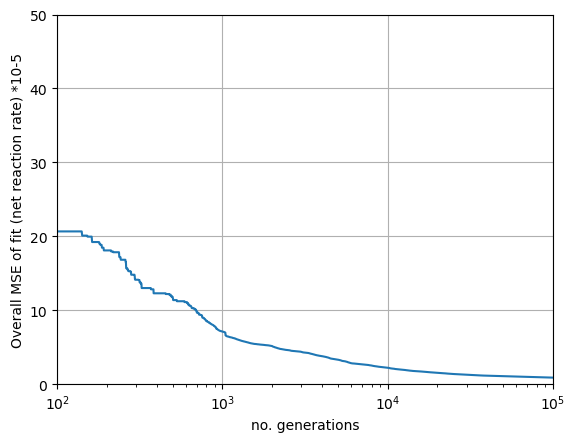

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-10.735103378300824
1.3972321066217142
0.7152023232047908
-4.070041620147784
0.4610065707673258
2.2950966604206844e-06
0.3811577846076258
-7.169333842897449
0.623904359974194
6.448005534683801
5.077152381408465
5.1021723141020745
0.5274788874507677
0.028424429272908364
2.79018038081472
0.0046897818672575475
0.1887238226633386
-10.803653852540785
1.6857600420324563
1.4057953258300602
-9.558494302387704
0.9601501381169039
3.2633846614416444
0.050802423136332216
3.3540763282360055
3.597319847417442
1.3236944776555217
7.661763507473709
-7.933305490369372
2.2442042405217
1.600225960782715
2.9122760721125447
-4.47184027685733
0.5843158966475153
1.0208438218917049
-1.3010293805406854


In [37]:
res.X

array([-1.07351034e+01,  1.39723211e+00,  7.15202323e-01, -4.07004162e+00,
        4.61006571e-01,  2.29509666e-06,  3.81157785e-01, -7.16933384e+00,
        6.23904360e-01,  6.44800553e+00,  5.07715238e+00,  5.10217231e+00,
        5.27478887e-01,  2.84244293e-02,  2.79018038e+00,  4.68978187e-03,
        1.88723823e-01, -1.08036539e+01,  1.68576004e+00,  1.40579533e+00,
       -9.55849430e+00,  9.60150138e-01,  3.26338466e+00,  5.08024231e-02,
        3.35407633e+00,  3.59731985e+00,  1.32369448e+00,  7.66176351e+00,
       -7.93330549e+00,  2.24420424e+00,  1.60022596e+00,  2.91227607e+00,
       -4.47184028e+00,  5.84315897e-01,  1.02084382e+00, -1.30102938e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -10.735103378300824
1.6: 1.3972321066217142
0.9: 0.7152023232047908
-4.3: -4.070041620147784
0.5: 0.4610065707673258
0.003: 2.2950966604206844e-06
0.4: 0.3811577846076258
-7.9: -7.169333842897449
0.7: 0.623904359974194
7.2: 6.448005534683801
5.7: 5.077152381408465
5.7: 5.1021723141020745
0.8: 0.5274788874507677
0.03: 0.028424429272908364
3.1: 2.79018038081472
6.000000000000001e-09: 0.0046897818672575475
0.1: 0.1887238226633386
-12.0: -10.803653852540785
1.9: 1.6857600420324563
1.6: 1.4057953258300602
-11.6: -9.558494302387704
1.2: 0.9601501381169039
4.0: 3.2633846614416444
0.01: 0.050802423136332216
4.2: 3.3540763282360055
5.4: 3.597319847417442
2.2: 1.3236944776555217
11.8: 7.661763507473709
-12.0: -7.933305490369372
3.3: 2.2442042405217
1.8: 1.600225960782715
4.2: 2.9122760721125447
-4.0: -4.47184027685733
0.5: 0.5843158966475153
1.0: 1.0208438218917049
coeff fit: 0.9505585995059179
r: 0.9749659478699335
